# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

In [ ]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [36]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def extrapolate_lines(lines):
    # get all the x points for the line
    x = np.reshape(lines[:, [0, 2]], (1, len(lines) * 2))[0]
    # get all the y points for the line
    y = np.reshape(lines[:, [1, 3]], (1, len(lines) * 2))[0]
    
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html
    # The equation for a line is y = mx + c
    # we can rewrite the equation as y = Ap, where A = [[x 1]] and p = [[m], [c]]
    # and then use lstsq to get the value of p which is (m, c)
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    
    x = np.array(x)
    # using the the value of m and c get all the values of y
    y = np.array(x * m + c)
    return x, y, m, c

def draw_lines(img, lines, color=[255, 0, 0], thickness=2, extrapolate=False):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if extrapolate == False:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

        return
    
    # get all the slopes for the line segments
    slopes = np.apply_along_axis(lambda line: (line[3] - line[1]) / (line[2] - line[0]), 2, lines)
    print (slopes)
    # the line on the right will have slope greater than 0
    right_lines = lines[np.where((slopes >= 0.5) & (slopes <= 0.9))]
    
    # the line on the left will have slope less than 0
    left_lines = lines[np.where((slopes <= -0.5) & (slopes >= -0.9))]
    
    # Extraploate lines to the the x, y, m and c values for the lines
    left_x, left_y, left_m, left_c = extrapolate_lines(left_lines)
    right_x, right_y, right_m, right_c = extrapolate_lines(right_lines)

    print("left_m =", left_m, " right_m =", right_m)
    print("left_c =", left_c, " right_c =", right_c)
    
    # Get the minimum value for y
    min_y = np.min([np.min(left_y), np.min(right_y)])
    print("left_y =", np.min(left_y), " right_y =", np.min(right_y), " min y =", min_y)

    # Using the minimum value of y get the top right and top left points for
    # the lines , x = (y - c)/ m
    top_right_point = np.array([(min_y - right_c) / right_m, min_y], dtype=int)
    top_left_point = np.array([(min_y - left_c) / left_m, min_y], dtype=int)

    # Now get the maximum value for y
    max_y = np.max([np.max(right_y), np.max(left_y)])
    print("left_y =", np.max(left_y), " right_y =", np.max(right_y), " max y =", max_y)
    
    # using the maximum y value get the bottom left and bottom right points. x= (y - c)/ m
    bottom_left_point = np.array([(max_y - left_c) / left_m, max_y], dtype=int)
    bottom_right_point = np.array([(max_y - right_c) / right_m, max_y], dtype=int)

    # Draw the lines.
    cv2.line(img, (bottom_left_point[0], bottom_left_point[1]), (top_left_point[0], top_left_point[1]), color, thickness=5)
    cv2.line(img, (bottom_right_point[0], bottom_right_point[1]), (top_right_point[0], top_right_point[1]), color, thickness=5)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, extrapolate=False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, extrapolate=extrapolate)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['.DS_Store',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: solidWhiteCurve.jpg type( <class 'numpy.ndarray'> ) with dimesions: (540, 960, 3)


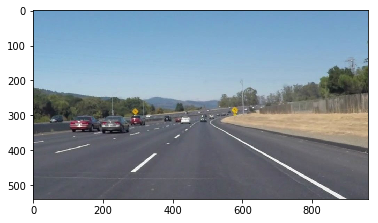

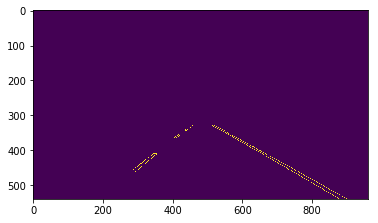

[[ 0.59375   ]
 [-0.84615385]
 [ 0.55696203]
 [ 0.5       ]
 [ 0.57692308]
 [ 0.53488372]
 [ 0.53846154]
 [-0.9       ]
 [ 0.48275862]
 [ 0.525     ]
 [ 0.53846154]
 [ 0.5       ]
 [ 0.60526316]
 [ 0.47058824]
 [ 0.46666667]
 [ 0.47058824]
 [ 0.5       ]
 [-0.76190476]
 [ 0.5       ]
 [ 0.46153846]
 [-0.85714286]
 [ 0.6       ]
 [ 0.46153846]
 [ 0.52380952]
 [ 0.5       ]
 [ 0.5       ]
 [ 0.52941176]]
[ 0.59375     0.55696203  0.57692308  0.53488372  0.53846154  0.525
  0.53846154  0.60526316  0.6         0.52380952  0.52941176]
[-0.84615385 -0.76190476 -0.85714286]
left_m = -0.717857142857  right_m = 0.554725230843
left_c = 664.108928571  right_c = 43.7579889336
left_y = 411.423214286  right_y = 340.535987434  min y = 340.535987434
left_y = 462.391071429  right_y = 541.90124623  max y = 541.90124623


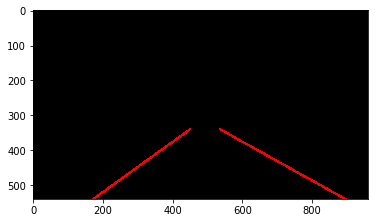

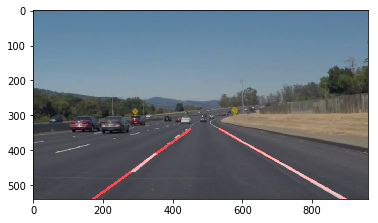

In [35]:
# Get the images  from test_images directory. Read the images and print the dimensions of each images
DEBUG = False

kernel_size = 5
low_threshold = 70
high_threshold = 210
# Define a rectangle region of interest for masking the edges 
# which are of no interest
left_bottom = (80, 539)
right_bottom = (900, 539)
left_top = (350, 330)
right_top = (550, 330)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 10
max_line_gap = 1

extrapolate = True
   
def image_processing_pipeline(input_image):
    # convert the images into grey scale
    gray = grayscale(input_image)
    if DEBUG:
        plt.imshow(gray, cmap='gray')
        plt.show()
    
    # not the the image has been converted into grey scale, get 
    # edges from the images. Use canny edge algorightm. Appy gausian
    # blur before applying the canny edge detection.

    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, kernel_size)
    if DEBUG:
        plt.imshow(blur_gray, cmap='gray')
        plt.show()

    # Define our parameters for Canny and apply
    edges = canny(blur_gray, low_threshold, high_threshold)
    if DEBUG:
        plt.imshow(edges)
        plt.show()
    
    vertices = np.array([[left_bottom, right_bottom, right_top, left_top]], np.int32)
    masked_edges = region_of_interest(edges, vertices)
    if DEBUG:
        plt.imshow(masked_edges)
        plt.show()
    plt.imshow(masked_edges)
    plt.show()
    lines_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, extrapolate=extrapolate)
    if DEBUG:
        plt.imshow(lines_image)
        plt.show()
    plt.imshow(lines_image)
    plt.show()
    lines_edges = weighted_img(lines_image, input_image)
    if DEBUG:
        plt.imshow(lines_edges)
        plt.show()

    return lines_edges
    
for input_img in os.listdir('test_images/'):
    if input_img.startswith("."):
        continue
        
    # Read the input image
    image = mpimg.imread('test_images/%s' % input_img)
    # print the image name and statistics
    print('This image is:', input_img , 'type(', type(image), ') with dimesions:', image.shape)
    # show the current image
    plt.imshow(image)
    plt.show()
    
    result = image_processing_pipeline(image)
    plt.imshow(result)
    plt.show()
    break

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = image_processing_pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

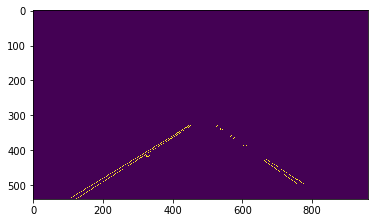

[[-0.66666667]
 [ 0.66666667]
 [-0.62650602]
 [-0.55      ]
 [-0.6097561 ]
 [-0.69230769]
 [ 0.70731707]
 [-0.65384615]
 [ 0.64705882]
 [-0.75      ]
 [-0.56      ]
 [ 0.6       ]
 [-0.76923077]
 [-0.72222222]
 [-0.66666667]
 [-0.66666667]
 [-0.62962963]
 [ 0.69230769]
 [-0.58333333]
 [ 0.72413793]
 [-0.69230769]
 [ 0.75      ]
 [ 0.66666667]
 [-0.66666667]
 [-0.57142857]
 [-0.64285714]
 [ 0.66666667]
 [-0.71428571]
 [-0.69230769]
 [-0.63636364]]
left_m = -0.621527241142  right_m = 0.69834376522
left_c = 608.209186638  right_c = -37.3474077017
left_y = 331.62956433  right_y = 355.820132117  min y = 331.62956433
left_y = 542.327299077  right_y = 492.6955101  max y = 542.327299077


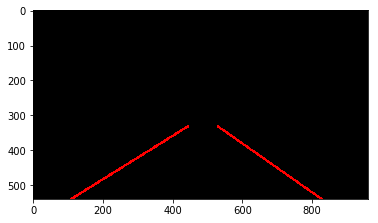

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

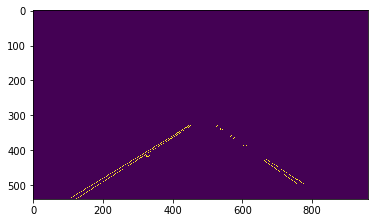

[[-0.66666667]
 [ 0.66666667]
 [-0.62650602]
 [-0.55      ]
 [-0.6097561 ]
 [-0.69230769]
 [ 0.70731707]
 [-0.65384615]
 [ 0.64705882]
 [-0.75      ]
 [-0.56      ]
 [ 0.6       ]
 [-0.76923077]
 [-0.72222222]
 [-0.66666667]
 [-0.66666667]
 [-0.62962963]
 [ 0.69230769]
 [-0.58333333]
 [ 0.72413793]
 [-0.69230769]
 [ 0.75      ]
 [ 0.66666667]
 [-0.66666667]
 [-0.57142857]
 [-0.64285714]
 [ 0.66666667]
 [-0.71428571]
 [-0.69230769]
 [-0.63636364]]
left_m = -0.621527241142  right_m = 0.69834376522
left_c = 608.209186638  right_c = -37.3474077017
left_y = 331.62956433  right_y = 355.820132117  min y = 331.62956433
left_y = 542.327299077  right_y = 492.6955101  max y = 542.327299077


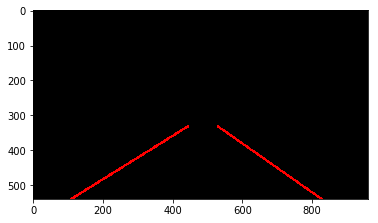

  0%|          | 1/682 [00:00<04:51,  2.34it/s]

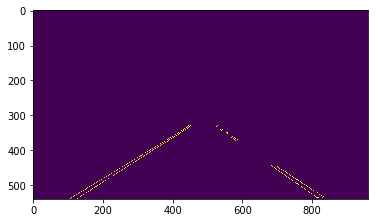

[[ 0.73333333]
 [-0.63636364]
 [-0.64      ]
 [-0.64367816]
 [ 0.57142857]
 [-0.66666667]
 [ 0.68571429]
 [-0.6       ]
 [-0.5       ]
 [-0.68181818]
 [ 0.75      ]
 [-0.65384615]
 [ 0.58333333]
 [ 0.57142857]
 [ 0.66666667]
 [ 0.53846154]
 [-0.55555556]
 [-0.5625    ]
 [-0.72727273]
 [-0.69230769]
 [-0.75      ]
 [-0.5       ]
 [ 0.73333333]
 [-0.75      ]
 [-0.6       ]
 [ 0.5625    ]
 [-0.72727273]
 [-0.69444444]
 [ 0.7       ]]
left_m = -0.642044040924  right_m = 0.683116246516
left_c = 617.431886939  right_c = -27.1551499362
left_y = 327.870024482  right_y = 360.171761838  min y = 327.870024482
left_y = 550.017262642  right_y = 526.852125988  max y = 550.017262642


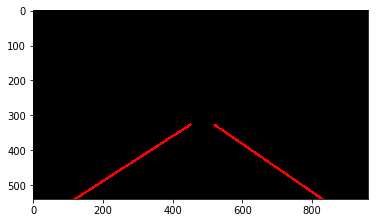

  0%|          | 2/682 [00:01<05:21,  2.12it/s]

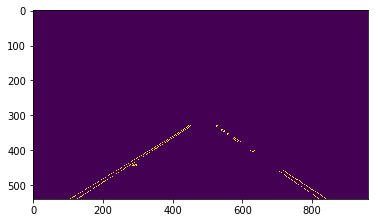

[[-0.60606061]
 [-0.56521739]
 [ 0.63636364]
 [ 0.68852459]
 [-0.6023166 ]
 [-0.5625    ]
 [ 0.58333333]
 [-0.76923077]
 [ 0.57142857]
 [-0.58333333]
 [-0.7       ]
 [-0.63636364]
 [-0.5       ]
 [-0.60606061]
 [ 0.64285714]
 [-0.61290323]
 [-0.62068966]
 [-0.58333333]
 [-0.57142857]
 [ 0.57142857]
 [-0.75      ]
 [ 0.6875    ]
 [-0.6       ]
 [-0.7       ]
 [-0.6875    ]
 [-0.72727273]
 [ 0.625     ]
 [-0.52631579]
 [ 0.66666667]
 [ 0.5625    ]
 [-0.72727273]
 [ 0.63636364]]
left_m = -0.619450110258  right_m = 0.66073422783
left_c = 611.536233168  right_c = -11.8155115026
left_y = 335.261483993  right_y = 368.767403727  min y = 335.261483993
left_y = 545.25507137  right_y = 541.879771419  max y = 545.25507137


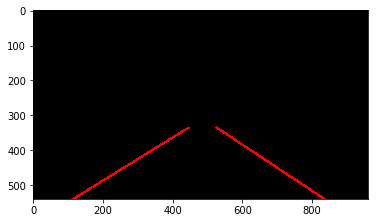

  0%|          | 3/682 [00:01<05:16,  2.15it/s]

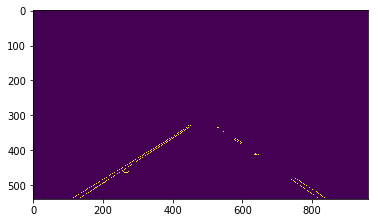

[[-0.62727273]
 [ 0.5       ]
 [-0.5       ]
 [-0.61904762]
 [-0.54545455]
 [ 0.7012987 ]
 [-0.66666667]
 [ 0.54545455]
 [-0.5       ]
 [-0.62790698]
 [-0.72727273]
 [-0.63636364]
 [-0.63076923]
 [ 0.63636364]
 [-0.66666667]
 [-0.69230769]
 [-0.53333333]
 [ 0.63636364]
 [-0.64285714]
 [ 0.58333333]
 [ 0.54545455]
 [-0.5       ]
 [-0.61538462]
 [ 0.5       ]
 [-0.5       ]
 [-0.72727273]
 [-0.57142857]
 [ 0.5       ]
 [-0.61538462]]
left_m = -0.616212622413  right_m = 0.665871482478
left_c = 609.515929651  right_c = -19.1302159914
left_y = 337.149950545  right_y = 366.409372363  min y = 337.149950545
left_y = 541.116328563  right_y = 535.540728913  max y = 541.116328563


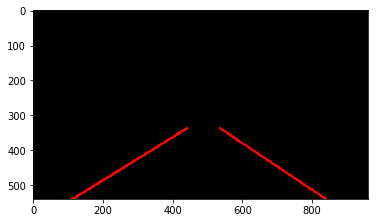

  1%|          | 4/682 [00:01<05:03,  2.23it/s]

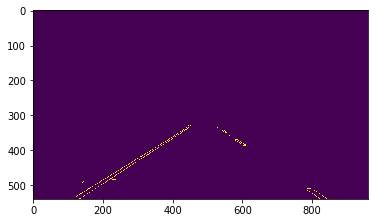

[[-0.66666667]
 [-0.65217391]
 [-0.67164179]
 [-0.65853659]
 [-0.62328767]
 [-0.63414634]
 [ 0.57142857]
 [-0.61627907]
 [ 0.68181818]
 [-0.69230769]
 [-0.61538462]
 [ 0.5625    ]
 [-0.72727273]
 [-0.7       ]
 [-0.73333333]
 [ 0.76190476]
 [-0.83333333]
 [ 0.66666667]
 [-0.71428571]
 [-0.76923077]
 [ 0.625     ]
 [ 0.6       ]]
left_m = -0.64051878677  right_m = 0.674659895052
left_c = 619.626769093  right_c = -23.3091940403
left_y = 332.674352619  right_y = 369.34286488  min y = 332.674352619
left_y = 546.607627401  right_y = 544.754437594  max y = 546.607627401


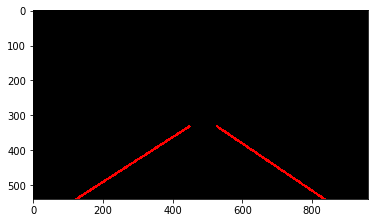

  1%|          | 5/682 [00:02<05:13,  2.16it/s]

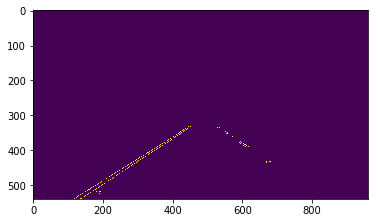

[[-0.64912281]
 [-0.62285714]
 [-0.63636364]
 [-0.6875    ]
 [-0.625     ]
 [-0.7       ]
 [-0.64285714]
 [-0.65384615]
 [ 0.7       ]
 [ 0.15384615]
 [-0.66666667]
 [ 0.8       ]
 [-0.84615385]
 [ 0.61904762]
 [-0.6875    ]
 [-0.8       ]
 [-0.66666667]
 [ 0.57894737]
 [-0.72727273]]
left_m = -0.629131367585  right_m = 0.566326530612
left_c = 615.184264338  right_c = 42.6301020408
left_y = 333.962543027  right_y = 376.196428571  min y = 333.962543027
left_y = 540.946762963  right_y = 393.18622449  max y = 540.946762963


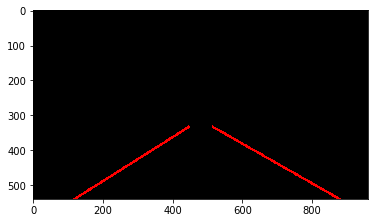

  1%|          | 6/682 [00:02<05:25,  2.08it/s]

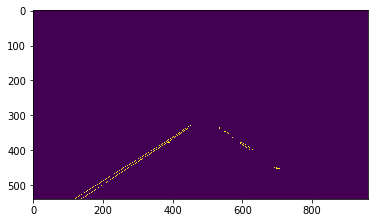

[[-0.625     ]
 [-0.69230769]
 [-0.66666667]
 [-0.6       ]
 [ 0.6       ]
 [-0.75      ]
 [-0.7       ]
 [-0.64285714]
 [-0.57142857]
 [-0.70588235]
 [ 0.5625    ]
 [-0.84615385]
 [ 0.73333333]
 [-0.61904762]
 [-0.6       ]
 [-0.6       ]
 [-0.65217391]
 [-0.6       ]]
left_m = -0.647580846428  right_m = 0.71200039137
left_c = 624.034736927  right_c = -45.7295631329
left_y = 335.21367942  right_y = 345.870652121  min y = 335.21367942
left_y = 546.325035356  right_y = 390.726676777  max y = 546.325035356


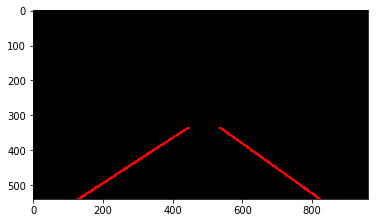

  1%|          | 7/682 [00:03<05:30,  2.04it/s]

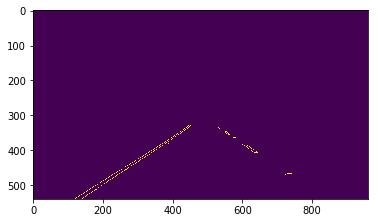

[[-0.62809917]
 [-0.68571429]
 [-0.5       ]
 [-0.6       ]
 [ 0.7037037 ]
 [-0.71428571]
 [-0.67346939]
 [-0.70833333]
 [-0.8       ]
 [-0.5       ]
 [-0.57142857]
 [-0.5625    ]
 [-0.63636364]
 [-0.71428571]
 [ 0.7       ]
 [-0.6       ]
 [-0.5       ]
 [-0.66666667]
 [-0.76470588]
 [-0.66666667]
 [-0.58333333]
 [-0.57142857]
 [ 0.70588235]
 [-0.66666667]
 [-0.6       ]
 [-0.57142857]
 [ 0.7       ]
 [-0.53846154]
 [ 0.7       ]
 [-0.72727273]]
left_m = -0.637388474254  right_m = 0.68268675521
left_c = 620.353376124  right_c = -29.719696572
left_y = 345.638943721  right_y = 347.806079059  min y = 345.638943721
left_y = 538.130262945  right_y = 409.247887028  max y = 538.130262945


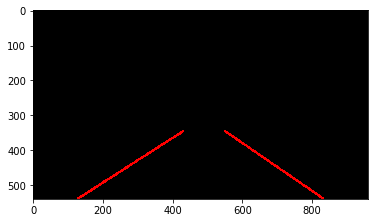

  1%|          | 8/682 [00:04<06:14,  1.80it/s]

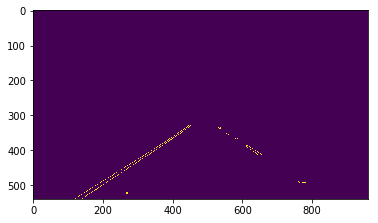

[[-0.69565217]
 [-0.71428571]
 [-0.69565217]
 [-0.6097561 ]
 [-0.72727273]
 [-0.60377358]
 [-0.72222222]
 [-0.75      ]
 [-0.75      ]
 [-0.5862069 ]
 [-0.71052632]
 [-0.8       ]
 [-0.8       ]
 [-0.75      ]
 [-0.7037037 ]
 [ 0.61764706]
 [-0.5       ]
 [-0.75      ]
 [ 0.70967742]
 [-0.73333333]
 [-0.7       ]
 [-0.8       ]
 [-0.8       ]
 [-0.5       ]
 [ 0.63636364]]
left_m = -0.644805228441  right_m = 0.617730900798
left_c = 622.442350354  right_c = 9.33922462942
left_y = 334.214413241  right_y = 387.390535918  min y = 334.214413241
left_y = 544.420917712  right_y = 410.246579247  max y = 544.420917712


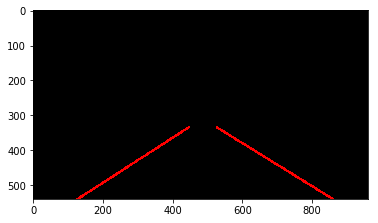

  1%|▏         | 9/682 [00:04<05:59,  1.87it/s]

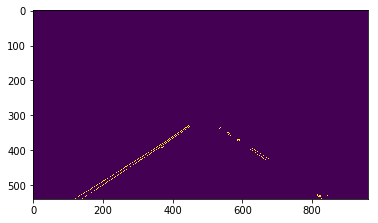

[[-0.60344828]
 [-0.66956522]
 [-0.6741573 ]
 [-0.77777778]
 [-0.71428571]
 [ 0.6       ]
 [ 0.65853659]
 [-0.55555556]
 [ 0.8       ]
 [-0.5       ]
 [-0.56521739]
 [-0.625     ]
 [-0.76923077]
 [-0.58333333]
 [-0.55555556]
 [-0.66666667]
 [-0.5       ]
 [-0.6       ]
 [-0.8       ]
 [-0.53846154]
 [-0.63636364]
 [-0.8       ]
 [-0.58333333]
 [ 0.63636364]
 [-0.8       ]
 [ 0.65      ]
 [ 0.63636364]
 [-0.6       ]]
left_m = -0.645734976846  right_m = 0.655734501457
left_c = 622.216962658  right_c = -14.1455649823
left_y = 331.636223077  right_y = 349.787083327  min y = 331.636223077
left_y = 544.728765436  right_y = 428.475223501  max y = 544.728765436


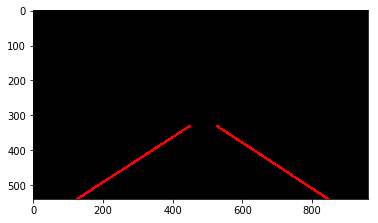

  1%|▏         | 10/682 [00:05<06:53,  1.62it/s]

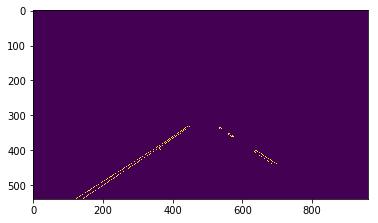

[[-0.5       ]
 [-0.68253968]
 [-0.75      ]
 [-0.55      ]
 [-0.625     ]
 [ 0.66666667]
 [-0.67213115]
 [ 0.61538462]
 [-0.56521739]
 [-0.81818182]
 [-0.75      ]
 [-0.5       ]
 [-0.58823529]
 [-0.55555556]
 [-0.57142857]
 [ 0.62162162]
 [-0.6       ]
 [ 0.71428571]
 [-0.76923077]
 [-0.63157895]
 [ 0.6       ]
 [-0.8       ]
 [-0.54545455]
 [-0.7       ]
 [-0.64285714]
 [-0.68      ]
 [-0.72727273]
 [-0.68181818]
 [-0.58333333]
 [-0.71428571]
 [-0.75      ]
 [-0.6       ]
 [ 0.61538462]]
left_m = -0.640962894069  right_m = 0.639563386195
left_c = 619.92921145  right_c = -4.8178383283
left_y = 335.982649377  right_y = 355.895911485  min y = 335.982649377
left_y = 539.167886797  right_y = 443.516095394  max y = 539.167886797


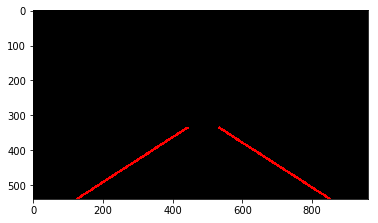

  2%|▏         | 11/682 [00:06<07:51,  1.42it/s]

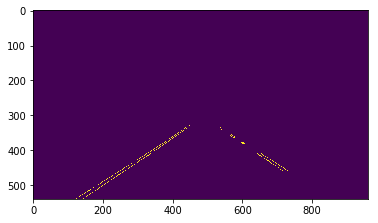

[[-0.64285714]
 [-0.76923077]
 [-0.69047619]
 [-0.625     ]
 [-0.6875    ]
 [ 0.68253968]
 [-0.8       ]
 [-0.6       ]
 [ 0.62962963]
 [ 0.5       ]
 [-0.69230769]
 [-0.6       ]
 [-0.75      ]
 [-0.69767442]
 [-0.65217391]
 [ 0.75      ]
 [-0.75      ]
 [-0.81818182]
 [-0.63636364]
 [ 0.63157895]
 [-0.63636364]
 [-0.58333333]
 [-0.57142857]
 [-0.5       ]
 [ 0.58333333]
 [-0.61290323]
 [-0.61538462]
 [-0.6       ]]
left_m = -0.662704794864  right_m = 0.628396334933
left_c = 628.806641836  right_c = 1.61213028704
left_y = 334.565712917  right_y = 354.142474185  min y = 334.565712917
left_y = 543.980428094  right_y = 459.084662118  max y = 543.980428094


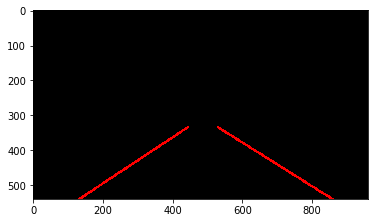

  2%|▏         | 12/682 [00:07<08:14,  1.35it/s]

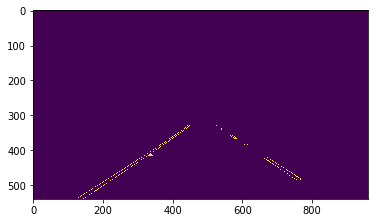

[[-0.78571429]
 [-0.6875    ]
 [-0.70967742]
 [-0.81818182]
 [-0.63043478]
 [-0.67741935]
 [-0.6       ]
 [ 0.60869565]
 [-0.70967742]
 [ 0.57142857]
 [-0.6       ]
 [-0.5       ]
 [-0.61111111]
 [ 0.5       ]
 [-0.66666667]
 [-0.71698113]
 [ 0.68421053]
 [ 0.64285714]
 [ 0.5       ]
 [ 0.61538462]
 [ 0.61538462]
 [ 0.58823529]
 [-0.58333333]
 [-0.66666667]
 [-0.67647059]
 [ 0.57142857]
 [-0.6       ]
 [-0.68421053]
 [-0.6       ]
 [-0.7       ]]
left_m = -0.645863851782  right_m = 0.636086220022
left_c = 623.493077336  right_c = -2.81339589788
left_y = 338.021254848  right_y = 356.575318415  min y = 338.021254848
left_y = 542.114232011  right_y = 476.795613999  max y = 542.114232011


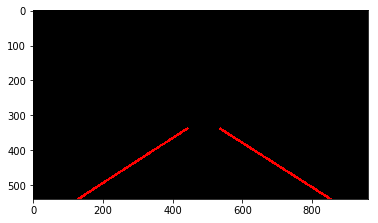

  2%|▏         | 13/682 [00:08<09:00,  1.24it/s]

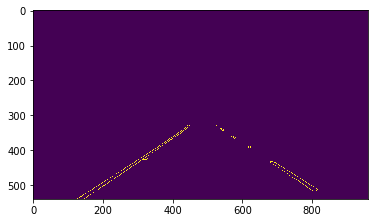

[[-0.72      ]
 [ 0.4       ]
 [-0.76470588]
 [ 0.5       ]
 [-0.75      ]
 [-0.66666667]
 [-0.75      ]
 [ 0.5625    ]
 [-0.72727273]
 [-0.75      ]
 [-0.63636364]
 [-0.5       ]
 [-0.57142857]
 [ 0.69230769]
 [-0.68      ]
 [ 0.61538462]
 [ 0.57894737]
 [-0.76923077]
 [-0.61111111]
 [-0.59090909]
 [-0.5       ]
 [-0.71428571]
 [-0.57142857]
 [-0.6       ]
 [-0.76470588]
 [-0.64285714]
 [ 0.57142857]
 [-0.66666667]
 [-0.58333333]
 [-0.61538462]
 [ 0.6       ]
 [ 0.53846154]
 [-0.76923077]
 [ 0.        ]
 [ 0.625     ]
 [ 0.57894737]
 [ 0.57142857]
 [-0.75      ]
 [-0.72727273]
 [-0.6       ]
 [-0.6       ]
 [-0.83333333]]
left_m = -0.665756073556  right_m = 0.629633061527
left_c = 629.923633475  right_c = 1.82757429746
left_y = 335.659448964  right_y = 360.088786306  min y = 335.659448964
left_y = 544.70685606  right_y = 516.237785565  max y = 544.70685606


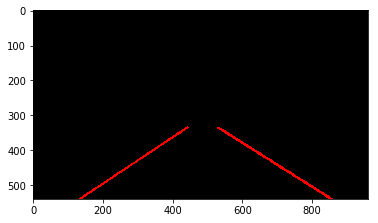

  2%|▏         | 14/682 [00:08<09:14,  1.21it/s]

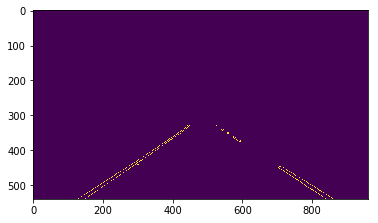

[[ 0.8       ]
 [-0.67647059]
 [ 0.62352941]
 [-0.6446281 ]
 [-0.85      ]
 [-0.67647059]
 [-0.77272727]
 [-0.68571429]
 [ 0.57142857]
 [-0.625     ]
 [ 0.66666667]
 [ 0.70588235]
 [-0.66666667]
 [ 0.54545455]
 [-0.6       ]
 [-0.69565217]
 [ 0.64285714]
 [-0.75      ]
 [-0.76923077]
 [ 0.71428571]
 [ 0.61111111]
 [-0.61538462]
 [ 0.61538462]
 [-0.7       ]]
left_m = -0.656898653021  right_m = 0.641872115915
left_c = 628.665052014  right_c = -5.92819900003
left_y = 335.031354114  right_y = 364.432011883  min y = 335.031354114
left_y = 538.013037897  right_y = 542.872460107  max y = 542.872460107


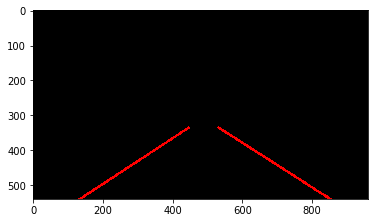

  2%|▏         | 15/682 [00:09<09:41,  1.15it/s]

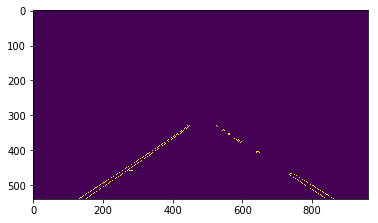

[[-0.6984127 ]
 [-0.875     ]
 [-0.61538462]
 [-0.71428571]
 [ 0.6       ]
 [-0.73684211]
 [ 0.64285714]
 [-0.66666667]
 [ 0.62962963]
 [ 0.61363636]
 [-0.68571429]
 [-0.78571429]
 [-0.72      ]
 [ 0.55      ]
 [-0.70731707]
 [ 0.59259259]
 [-0.73333333]
 [-0.8       ]
 [ 0.46153846]
 [-0.76923077]
 [-0.9       ]
 [-0.72727273]
 [-0.69565217]
 [-0.71428571]
 [-0.7       ]
 [-0.6       ]
 [ 0.54545455]]
left_m = -0.673607663161  right_m = 0.635780117661
left_c = 634.041200943  right_c = -2.50932179966
left_y = 333.612183173  right_y = 364.335806091  min y = 333.612183173
left_y = 543.104166416  right_y = 544.897359506  max y = 544.897359506


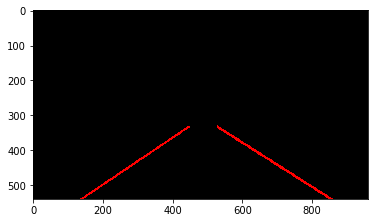

  2%|▏         | 16/682 [00:10<09:49,  1.13it/s]

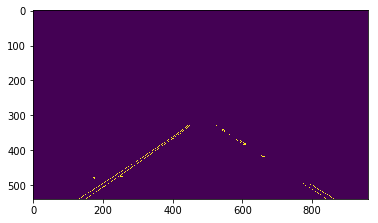

[[-0.71428571]
 [-0.83333333]
 [-0.75      ]
 [-0.8       ]
 [ 0.575     ]
 [ 0.63636364]
 [-0.75      ]
 [-0.625     ]
 [ 0.75      ]
 [-0.62318841]
 [ 0.5625    ]
 [ 0.        ]
 [-0.72727273]
 [-0.8       ]
 [-0.83333333]
 [-0.68181818]
 [-0.78947368]
 [ 0.7       ]
 [ 0.5       ]
 [-0.78571429]
 [ 0.625     ]
 [-0.6       ]
 [-0.7       ]
 [ 0.5       ]
 [ 0.6       ]
 [-0.8       ]]
left_m = -0.679618009955  right_m = 0.639582253206
left_c = 636.1481622  right_c = -4.17095444404
left_y = 335.07738379  right_y = 367.426334668  min y = 335.07738379
left_y = 542.360876826  right_y = 545.869783313  max y = 545.869783313


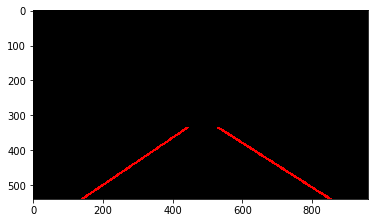

  2%|▏         | 17/682 [00:11<09:25,  1.18it/s]

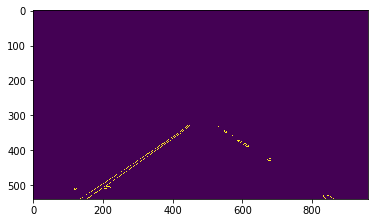

[[-0.63636364]
 [-0.71428571]
 [-0.68965517]
 [-0.6       ]
 [-0.61538462]
 [-0.68085106]
 [-0.65517241]
 [-0.76470588]
 [-0.58333333]
 [ 0.6       ]
 [-0.68421053]
 [-0.61538462]
 [-0.65      ]
 [-0.76470588]
 [-0.64285714]
 [-0.66666667]
 [-0.64285714]
 [-0.63636364]
 [-0.9       ]
 [-0.76923077]
 [ 0.1       ]
 [-0.1       ]
 [-0.66666667]
 [-0.63636364]
 [-0.5       ]]
left_m = -0.675846286663  right_m = 0.6
left_c = 636.222564952  right_c = 22.2
left_y = 346.960354261  right_y = 384.0  min y = 346.960354261
left_y = 544.983316253  right_y = 390.0  max y = 544.983316253


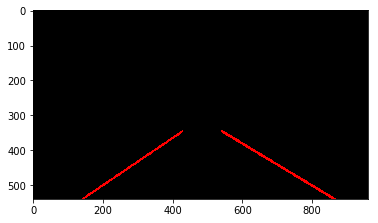

  3%|▎         | 18/682 [00:12<09:45,  1.13it/s]

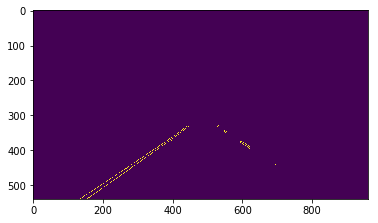

[[-0.75      ]
 [-0.65753425]
 [-0.65346535]
 [-0.71428571]
 [-0.8       ]
 [-0.71052632]
 [-0.74193548]
 [ 0.625     ]
 [-0.77777778]
 [-0.57142857]
 [-0.85714286]
 [ 0.625     ]
 [ 0.72222222]
 [-0.5625    ]
 [-0.9       ]
 [-0.8       ]
 [ 0.8       ]
 [-0.54545455]
 [-0.58333333]
 [-0.81818182]]
left_m = -0.681102843189  right_m = 0.5603085554
left_c = 636.849301007  right_c = 43.476858345
left_y = 336.482947161  right_y = 375.739831697  min y = 336.482947161
left_y = 544.900417177  right_y = 396.471248247  max y = 544.900417177


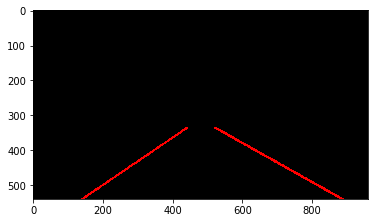

  3%|▎         | 19/682 [00:13<09:49,  1.13it/s]

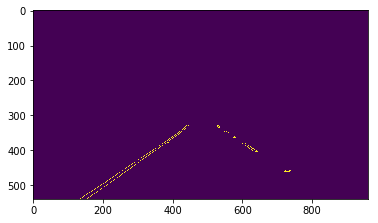

[[-0.7037037 ]
 [-0.67407407]
 [-0.6       ]
 [ 0.53846154]
 [-0.64285714]
 [ 0.57142857]
 [-0.61904762]
 [-0.58333333]
 [-0.64705882]
 [ 0.56521739]
 [-0.6       ]
 [-0.70588235]
 [-0.7       ]
 [ 0.64705882]
 [-0.65384615]
 [-0.84615385]
 [-0.58333333]
 [ 0.625     ]]
left_m = -0.694987330165  right_m = 0.554385225757
left_c = 642.592659274  right_c = 48.5060740117
left_y = 340.968157982  right_y = 383.909135594  min y = 340.968157982
left_y = 538.344559749  right_y = 404.421388947  max y = 538.344559749


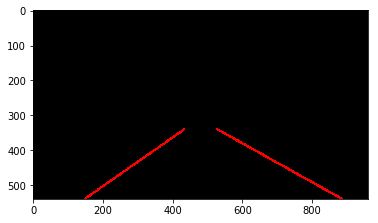

  3%|▎         | 20/682 [00:14<09:25,  1.17it/s]

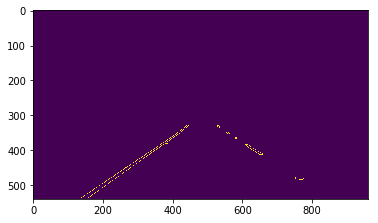

[[-0.675     ]
 [-0.703125  ]
 [-0.76923077]
 [-0.61538462]
 [-0.72      ]
 [-0.75      ]
 [-0.58333333]
 [-0.61111111]
 [-0.81818182]
 [ 0.58823529]
 [-0.6       ]
 [-0.57142857]
 [-0.82352941]
 [-0.66666667]
 [-0.72222222]
 [ 0.65217391]
 [-0.81818182]
 [-0.75      ]
 [-0.58333333]
 [-0.64705882]
 [-0.58333333]
 [ 0.54545455]
 [-0.78571429]]
left_m = -0.668288437667  right_m = 0.539825282631
left_c = 631.135215096  right_c = 55.6431140802
left_y = 339.093167835  right_y = 384.396711202  min y = 339.093167835
left_y = 538.911410698  right_y = 408.688848921  max y = 538.911410698


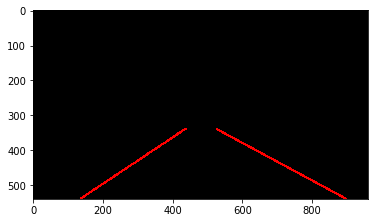

  3%|▎         | 21/682 [00:15<09:07,  1.21it/s]

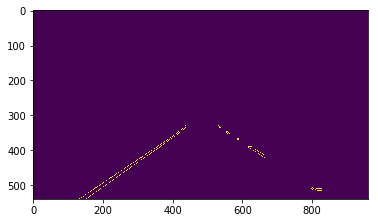

[[-0.71875   ]
 [-0.76923077]
 [-0.68518519]
 [-0.63157895]
 [-0.81818182]
 [-0.76923077]
 [-0.625     ]
 [-0.6       ]
 [ 0.60465116]
 [-0.71428571]
 [-0.75      ]
 [-0.76923077]
 [-0.61538462]
 [-0.69230769]
 [-0.8       ]
 [ 0.6875    ]
 [-0.81818182]
 [-0.73333333]
 [-0.58333333]
 [-0.81818182]
 [-0.58333333]
 [-0.72727273]
 [ 0.68965517]
 [-0.70588235]
 [ 0.6       ]
 [-0.75      ]
 [-0.58333333]
 [-0.8       ]
 [-0.58333333]]
left_m = -0.684563913271  right_m = 0.623271450924
left_c = 635.6659534  right_c = 4.91415401531
left_y = 337.880651127  right_y = 350.206537827  min y = 337.880651127
left_y = 541.196133369  right_y = 420.636211782  max y = 541.196133369


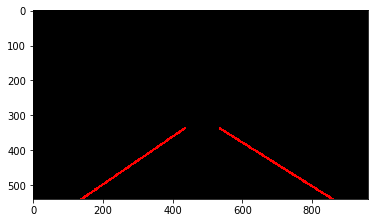

  3%|▎         | 22/682 [00:15<08:59,  1.22it/s]

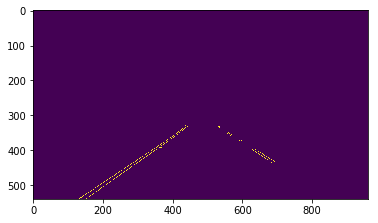

[[-0.64285714]
 [-0.67479675]
 [-0.75      ]
 [-0.7       ]
 [-0.76086957]
 [-0.81818182]
 [-0.69230769]
 [-0.81818182]
 [-0.8       ]
 [-1.        ]
 [-0.77272727]
 [ 0.57142857]
 [-0.83333333]
 [-0.8       ]
 [ 0.54545455]
 [ 0.58333333]
 [-0.625     ]
 [-0.71428571]
 [ 0.64285714]
 [ 0.66666667]
 [ 0.6       ]
 [ 0.60714286]
 [-0.66666667]
 [-0.75      ]
 [-0.70967742]
 [-0.8       ]
 [-0.76923077]]
left_m = -0.690882091901  right_m = 0.642429903726
left_c = 639.020041558  right_c = -8.38763503232
left_y = 338.486331581  right_y = 350.088251247  min y = 338.486331581
left_y = 547.132723336  right_y = 434.888998539  max y = 547.132723336


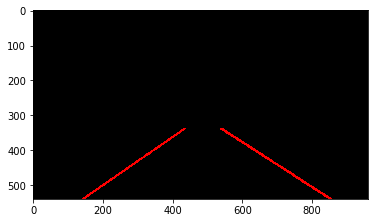

  3%|▎         | 23/682 [00:16<08:39,  1.27it/s]

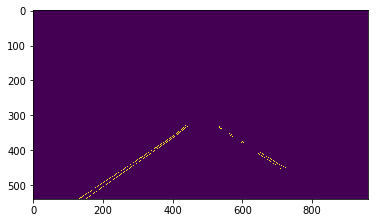

[[-0.72727273]
 [-0.6744186 ]
 [ 0.61643836]
 [-0.91666667]
 [-0.81818182]
 [ 0.64444444]
 [-0.57142857]
 [-0.72727273]
 [-0.58333333]
 [-0.70588235]
 [-0.75      ]
 [-0.58823529]
 [-0.6       ]
 [-0.6       ]
 [-0.54545455]
 [-0.83333333]
 [-0.6       ]
 [ 0.64285714]
 [-0.6       ]
 [-0.63636364]
 [ 0.63636364]]
left_m = -0.658368194606  right_m = 0.563286411951
left_c = 628.93165368  right_c = 45.084688308
left_y = 355.050484724  right_y = 407.277851192  min y = 355.050484724
left_y = 541.368683797  right_y = 452.340764148  max y = 541.368683797


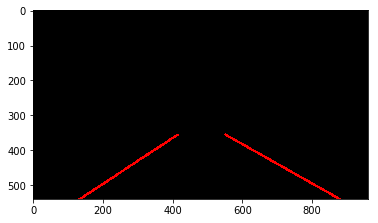

  4%|▎         | 24/682 [00:17<09:15,  1.18it/s]

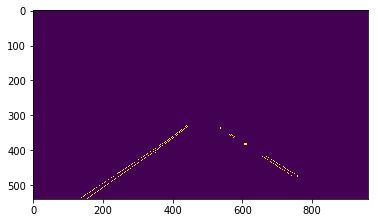

[[-0.66216216]
 [-0.67241379]
 [ 0.63157895]
 [-0.72      ]
 [-0.77083333]
 [ 0.62068966]
 [-0.84615385]
 [ 0.5862069 ]
 [-0.81818182]
 [-0.84615385]
 [-0.67307692]
 [-0.6       ]
 [-0.6       ]
 [ 0.63636364]
 [ 0.41666667]
 [-0.64285714]
 [ 0.64705882]
 [-0.83333333]
 [ 0.54545455]
 [-0.6875    ]
 [-0.6       ]
 [ 0.6       ]
 [ 0.66666667]
 [ 0.5       ]
 [-0.8       ]]
left_m = -0.7023448518  right_m = 0.619580240594
left_c = 643.696798275  right_c = 8.81566419247
left_y = 336.069753187  right_y = 361.35682109  min y = 336.069753187
left_y = 549.582588134  right_y = 471.642103916  max y = 549.582588134


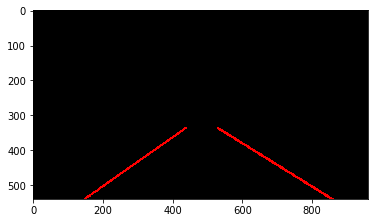

  4%|▎         | 25/682 [00:18<08:31,  1.29it/s]

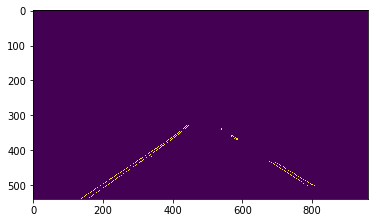

[[ 0.1       ]
 [-0.63043478]
 [ 0.64285714]
 [-0.78846154]
 [-0.71014493]
 [-0.83333333]
 [ 0.75      ]
 [-0.75      ]
 [ 0.5       ]
 [ 0.61764706]
 [-0.72      ]
 [-0.64705882]
 [-0.64285714]
 [-0.75      ]
 [ 0.58823529]
 [-0.61111111]
 [ 0.66666667]
 [ 0.53846154]
 [-0.6       ]
 [-0.69230769]
 [-0.81818182]
 [-0.58333333]
 [-0.8       ]
 [-0.5625    ]
 [ 0.72727273]
 [-0.69230769]
 [ 0.        ]
 [ 0.625     ]
 [ 0.70588235]
 [-0.81818182]
 [ 0.5       ]
 [-0.76923077]
 [-0.63636364]
 [ 0.66666667]
 [-0.75      ]]
left_m = -0.688723587664  right_m = 0.616823782478
left_c = 639.369825845  right_c = 10.1629703965
left_y = 337.020170861  right_y = 361.135702626  min y = 337.020170861
left_y = 540.193629222  right_y = 506.089291509  max y = 540.193629222


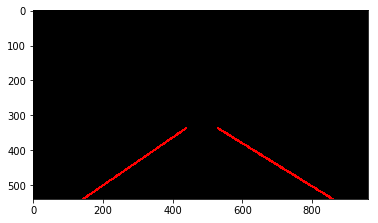

  4%|▍         | 26/682 [00:18<08:39,  1.26it/s]

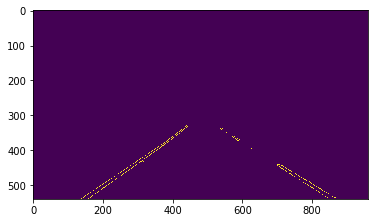

[[-0.80434783]
 [ 0.58333333]
 [-0.78947368]
 [ 0.5       ]
 [ 0.4       ]
 [-1.        ]
 [ 0.61538462]
 [-0.67647059]
 [-0.65625   ]
 [ 0.6       ]
 [-0.61538462]
 [-0.67741935]
 [ 0.5625    ]
 [ 0.57142857]
 [-0.8       ]
 [ 0.53846154]
 [-0.58823529]
 [-0.6       ]
 [-0.70967742]
 [ 0.53333333]
 [-0.6       ]
 [-0.63636364]
 [-0.78947368]
 [ 0.56521739]
 [-0.58333333]
 [-0.7037037 ]
 [ 0.55      ]
 [-0.90909091]
 [ 0.57142857]
 [-0.57142857]
 [-0.73333333]
 [-0.625     ]
 [ 0.61111111]
 [ 0.56521739]
 [ 0.5       ]
 [-0.83333333]
 [-0.54545455]
 [-0.71428571]
 [-0.5       ]
 [ 0.54545455]
 [-0.6       ]]
left_m = -0.690399359913  right_m = 0.606019780568
left_c = 640.649395455  right_c = 15.1805675827
left_y = 337.564076453  right_y = 361.217862287  min y = 337.564076453
left_y = 544.683884427  right_y = 541.205737115  max y = 544.683884427


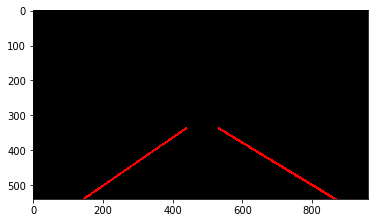

  4%|▍         | 27/682 [00:19<08:34,  1.27it/s]

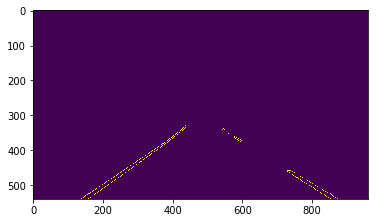

[[ 0.66666667]
 [-0.67647059]
 [-0.76470588]
 [-0.7       ]
 [-0.90909091]
 [ 0.58      ]
 [-0.6875    ]
 [ 0.58333333]
 [ 0.4       ]
 [-0.77272727]
 [-0.67647059]
 [-0.63636364]
 [-0.64285714]
 [-0.6       ]
 [ 0.52173913]
 [-0.61538462]
 [-0.7       ]
 [ 0.66666667]
 [-0.76470588]
 [-0.625     ]
 [ 0.7       ]
 [ 0.64285714]
 [-0.71428571]
 [-0.78571429]
 [-0.83333333]
 [ 0.61538462]
 [-0.90909091]
 [ 0.7       ]]
left_m = -0.718515301273  right_m = 0.616511674584
left_c = 650.726181198  right_c = 6.60915233826
left_y = 336.01647924  right_y = 362.952900248  min y = 336.01647924
left_y = 550.852554321  right_y = 529.411052385  max y = 550.852554321


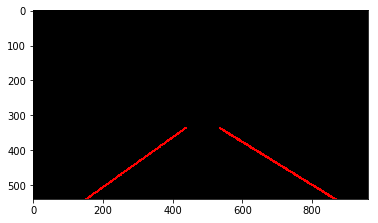

  4%|▍         | 28/682 [00:20<08:34,  1.27it/s]

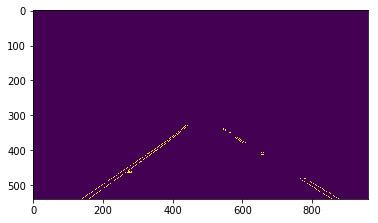

[[-0.65384615]
 [-0.66071429]
 [-0.74285714]
 [ 0.5625    ]
 [ 0.5       ]
 [-0.76923077]
 [-0.76      ]
 [-0.8       ]
 [-0.75757576]
 [-0.81818182]
 [ 0.59259259]
 [ 0.57142857]
 [-0.69565217]
 [-0.66666667]
 [-0.71428571]
 [-0.6       ]
 [ 0.6       ]
 [-0.58333333]
 [ 0.57142857]
 [-0.71428571]
 [ 0.53846154]
 [-0.73076923]
 [ 0.64      ]
 [-0.6       ]
 [ 0.4       ]
 [-0.8       ]
 [ 0.5       ]
 [-0.63636364]]
left_m = -0.698578237354  right_m = 0.604459291426
left_c = 642.716256254  right_c = 12.6792521671
left_y = 338.834723005  right_y = 365.079019068  min y = 338.834723005
left_y = 545.613881262  right_y = 518.611679091  max y = 545.613881262


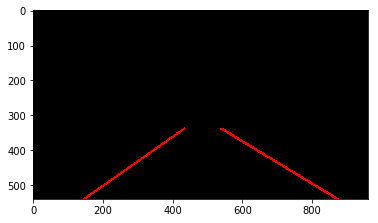

  4%|▍         | 29/682 [00:21<08:38,  1.26it/s]

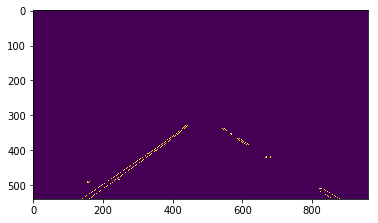

[[-0.75      ]
 [ 0.63157895]
 [-0.72222222]
 [-0.9047619 ]
 [ 0.57142857]
 [-0.69230769]
 [-0.61538462]
 [-0.78947368]
 [-0.81818182]
 [ 0.5625    ]
 [-0.72      ]
 [-0.8       ]
 [-0.79166667]
 [-0.81818182]
 [-0.8       ]
 [ 0.52941176]
 [-0.8       ]
 [-0.8125    ]
 [-0.77272727]
 [-0.65      ]
 [ 0.7       ]
 [ 0.61538462]
 [ 0.57894737]
 [-0.75      ]
 [-0.9       ]
 [-0.9       ]]
left_m = -0.70176838114  right_m = 0.601663214177
left_c = 644.112754446  right_c = 13.4565098004
left_y = 338.141740269  right_y = 367.836142951  min y = 338.141740269
left_y = 541.6545708  right_y = 541.115148634  max y = 541.6545708


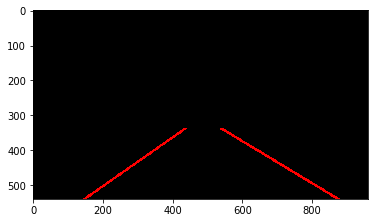

  4%|▍         | 30/682 [00:22<08:17,  1.31it/s]

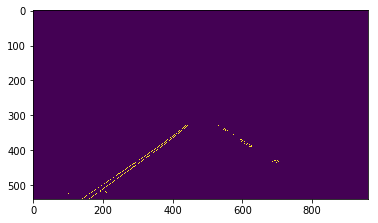

[[-0.83333333]
 [-0.7826087 ]
 [-0.83333333]
 [-0.69565217]
 [-0.80952381]
 [-0.78947368]
 [-0.73333333]
 [-0.7       ]
 [-0.71428571]
 [-0.61111111]
 [-0.63157895]
 [-0.86666667]
 [-0.61538462]
 [-0.81818182]
 [-0.6875    ]
 [ 0.05882353]
 [-0.8       ]
 [ 0.55555556]
 [-0.6       ]
 [ 0.66666667]
 [-0.6       ]]
left_m = -0.700720221888  right_m = 0.497680303669
left_c = 643.669735385  right_c = 77.041754534
left_y = 333.95139731  right_y = 372.16617461  min y = 333.95139731
left_y = 530.853779661  right_y = 389.087304935  max y = 530.853779661


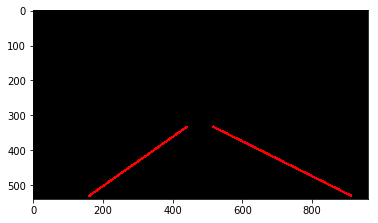

  5%|▍         | 31/682 [00:22<08:25,  1.29it/s]

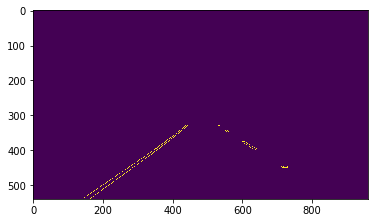

[[-0.84615385]
 [-0.69736842]
 [-0.78571429]
 [-0.83333333]
 [-0.86666667]
 [-0.86666667]
 [-0.81578947]
 [-0.72727273]
 [-0.72727273]
 [ 0.63636364]
 [-0.58333333]
 [-0.68      ]
 [-0.6       ]
 [ 0.60869565]
 [-0.78571429]
 [-0.64285714]
 [ 0.59090909]
 [ 0.56521739]
 [-0.8125    ]
 [-0.84615385]
 [-0.6       ]
 [-0.85714286]
 [-0.84615385]
 [-0.9       ]]
left_m = -0.716689275739  right_m = 0.518884251247
left_c = 648.739014804  right_c = 64.7977196376
left_y = 332.679044203  right_y = 376.647154637  min y = 332.679044203
left_y = 546.969137649  right_y = 396.364756184  max y = 546.969137649


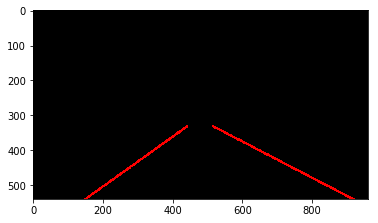

  5%|▍         | 32/682 [00:23<08:30,  1.27it/s]

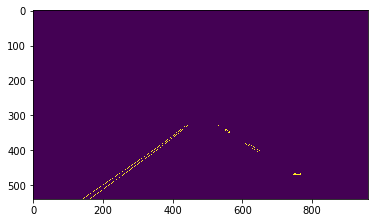

[[-0.75641026]
 [-0.7029703 ]
 [-0.71794872]
 [-0.70909091]
 [ 0.58823529]
 [ 0.5       ]
 [-0.88235294]
 [-0.66666667]
 [-0.57142857]
 [-1.        ]
 [-0.67857143]
 [-0.63636364]
 [ 0.64516129]
 [-0.72222222]
 [-0.7       ]
 [ 0.46666667]
 [ 0.        ]
 [ 0.        ]
 [-0.76470588]
 [ 0.7       ]
 [-0.6       ]
 [-0.7       ]]
left_m = -0.70488299566  right_m = 0.622394282311
left_c = 645.932905153  right_c = 0.430017867778
left_y = 355.521110941  right_y = 381.957712924  min y = 355.521110941
left_y = 543.724870783  right_y = 401.251935676  max y = 543.724870783


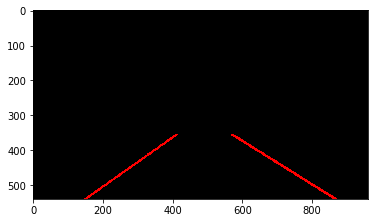

  5%|▍         | 33/682 [00:24<08:19,  1.30it/s]

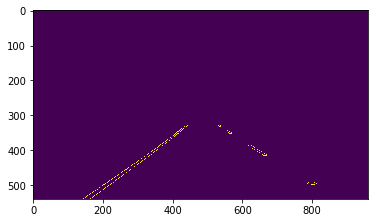

[[-0.79166667]
 [-0.72571429]
 [ 0.5       ]
 [-0.72307692]
 [-0.71794872]
 [-0.72727273]
 [-0.66037736]
 [-0.63636364]
 [-0.73076923]
 [ 0.61111111]
 [ 0.8       ]
 [ 0.62857143]
 [-0.65625   ]
 [-0.72727273]
 [-0.8       ]
 [-0.6       ]
 [-0.75      ]]
left_m = -0.710158726125  right_m = 0.681520493059
left_c = 644.952098808  right_c = -36.3205566212
left_y = 339.583846574  right_y = 343.286358013  min y = 339.583846574
left_y = 539.848607341  right_y = 414.846009784  max y = 539.848607341


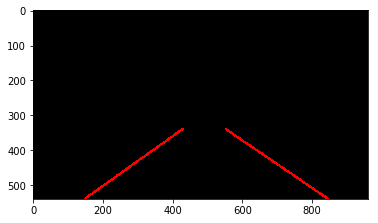

  5%|▍         | 34/682 [00:25<07:59,  1.35it/s]

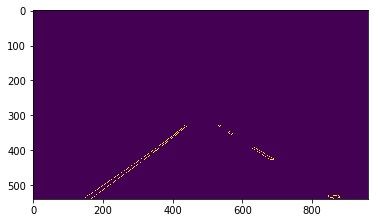

[[ 0.5       ]
 [ 0.5625    ]
 [-0.07692308]
 [-0.86666667]
 [-0.80952381]
 [-0.68085106]
 [-0.72727273]
 [-0.75      ]
 [ 0.11111111]
 [-0.8       ]
 [-0.74358974]
 [-0.64      ]
 [-0.83333333]
 [-0.70588235]
 [-0.82352941]
 [-0.75      ]
 [ 0.53846154]
 [ 0.61538462]
 [ 0.6       ]
 [-0.78571429]]
left_m = -0.72151966759  right_m = 0.636998505575
left_c = 651.673524739  right_c = -9.4635015519
left_y = 334.204870999  right_y = 344.707667548  min y = 334.204870999
left_y = 547.053172938  right_y = 414.777503161  max y = 547.053172938


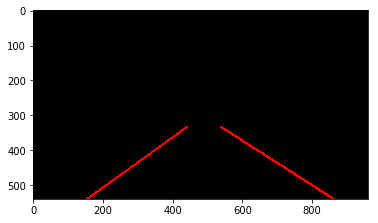

  5%|▌         | 35/682 [00:25<08:28,  1.27it/s]

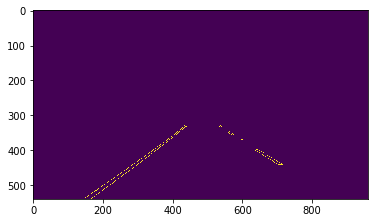

[[-0.8       ]
 [-0.75      ]
 [-0.85      ]
 [-0.68115942]
 [-0.7       ]
 [ 0.5       ]
 [ 0.45454545]
 [ 0.625     ]
 [-0.66666667]
 [-0.7       ]
 [ 0.55555556]
 [-0.7826087 ]
 [-0.64285714]
 [-0.68      ]
 [-0.8125    ]
 [ 0.8       ]
 [-0.85714286]
 [ 0.45454545]
 [ 0.55555556]
 [-0.64285714]
 [-0.61538462]
 [ 0.64285714]
 [-0.6       ]
 [-0.58333333]
 [-0.81818182]
 [-0.8       ]
 [-0.6       ]]
left_m = -0.728632814282  right_m = 0.635454122215
left_c = 652.651753204  right_c = -8.29177934286
left_y = 335.696478991  right_y = 347.562529098  min y = 335.696478991
left_y = 537.527768547  right_y = 427.629748497  max y = 537.527768547


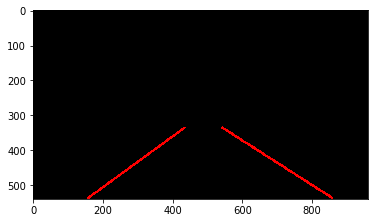

  5%|▌         | 36/682 [00:26<08:20,  1.29it/s]

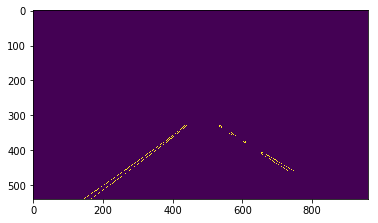

[[-0.72727273]
 [-0.8       ]
 [-0.88888889]
 [-0.76923077]
 [-0.8       ]
 [-0.85714286]
 [-0.86666667]
 [-0.76923077]
 [ 0.54545455]
 [-0.77777778]
 [ 0.53846154]
 [-0.73214286]
 [ 0.55555556]
 [ 0.55555556]
 [ 0.62962963]
 [-0.64285714]
 [-0.70588235]
 [-0.83333333]
 [-0.7       ]
 [ 0.5625    ]
 [-0.83333333]
 [-0.86666667]
 [-0.6875    ]
 [-0.6875    ]
 [ 0.5625    ]]
left_m = -0.719590569573  right_m = 0.604627294777
left_c = 649.693821691  right_c = 9.77661331078
left_y = 333.793561649  right_y = 348.972525681  min y = 333.793561649
left_y = 543.914007964  right_y = 452.968420383  max y = 543.914007964


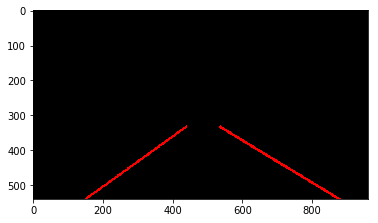

  5%|▌         | 37/682 [00:27<08:19,  1.29it/s]

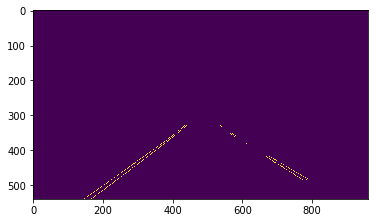

[[-0.82978723]
 [-0.77777778]
 [ 0.7       ]
 [-0.83333333]
 [ 0.62068966]
 [-0.66666667]
 [-0.83333333]
 [-0.67857143]
 [ 0.65909091]
 [-0.86363636]
 [-0.75      ]
 [-0.66666667]
 [ 0.57142857]
 [-0.83333333]
 [ 0.57142857]
 [-0.90909091]
 [-0.81818182]
 [-0.83333333]
 [ 0.58064516]
 [ 0.57894737]
 [ 0.58823529]
 [-0.73684211]
 [-0.9       ]
 [ 0.7       ]
 [ 0.53846154]
 [-0.84615385]
 [-0.6       ]]
left_m = -0.734004363826  right_m = 0.609313478708
left_c = 654.307099871  right_c = 8.02417039995
left_y = 331.345179788  right_y = 354.723539785  min y = 331.345179788
left_y = 546.408458389  right_y = 479.023489441  max y = 546.408458389


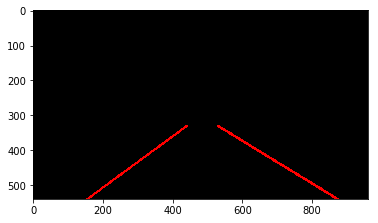

  6%|▌         | 38/682 [00:28<09:00,  1.19it/s]

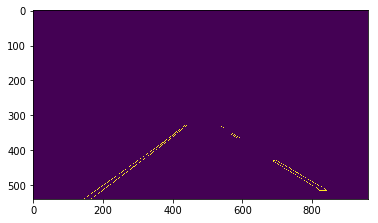

[[-0.72857143]
 [-0.90909091]
 [ 0.6       ]
 [-0.8125    ]
 [-0.71428571]
 [-0.73913043]
 [ 0.58333333]
 [-0.6875    ]
 [ 0.57894737]
 [ 0.58139535]
 [-0.64285714]
 [-0.90909091]
 [-0.75      ]
 [-0.8125    ]
 [-0.58333333]
 [-0.72727273]
 [ 0.6       ]
 [-0.8       ]
 [ 0.57692308]
 [ 0.57692308]
 [-0.82352941]
 [-0.69230769]
 [-0.8       ]
 [-0.9       ]
 [ 0.57142857]
 [-0.9       ]
 [ 0.6       ]
 [ 0.5       ]
 [-0.81818182]
 [-0.72727273]]
left_m = -0.726094800457  right_m = 0.625284992709
left_c = 651.130533151  right_c = -1.98008634347
left_y = 333.10101055  right_y = 428.841273633  min y = 333.10101055
left_y = 544.394597483  right_y = 512.629462656  max y = 544.394597483


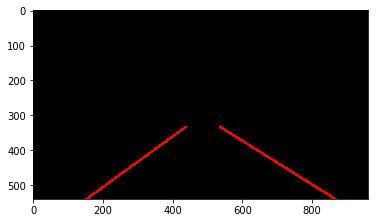

  6%|▌         | 39/682 [00:29<08:55,  1.20it/s]

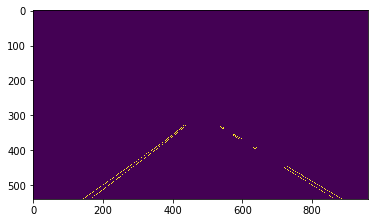

[[-0.8       ]
 [-0.6       ]
 [ 0.6       ]
 [-0.61538462]
 [-0.85      ]
 [ 0.69230769]
 [-0.83333333]
 [-0.78947368]
 [ 0.6       ]
 [-0.8125    ]
 [ 0.63888889]
 [ 0.5       ]
 [-0.7804878 ]
 [ 0.57692308]
 [-0.58333333]
 [ 0.57894737]
 [-0.85185185]
 [-0.71428571]
 [-0.81818182]
 [-0.86666667]
 [-0.8125    ]
 [ 0.72727273]
 [-0.6       ]
 [ 0.64285714]
 [-0.61538462]
 [-0.83333333]
 [-0.83333333]
 [ 0.54545455]
 [-0.8       ]
 [-0.8125    ]
 [-0.81818182]
 [-0.78571429]
 [-0.83333333]
 [ 0.53846154]
 [ 0.66666667]
 [-0.8       ]
 [ 0.5       ]
 [ 0.58823529]
 [-0.58333333]
 [ 0.5       ]
 [-0.78571429]]
left_m = -0.723149152255  right_m = 0.604457415555
left_c = 647.462902723  right_c = 10.9220148388
left_y = 330.723574036  right_y = 358.485028783  min y = 330.723574036
left_y = 543.329424799  right_y = 538.008881203  max y = 543.329424799


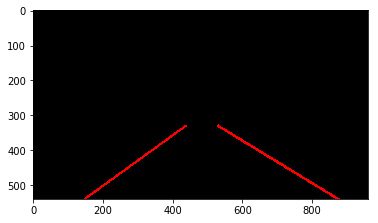

  6%|▌         | 40/682 [00:30<08:51,  1.21it/s]

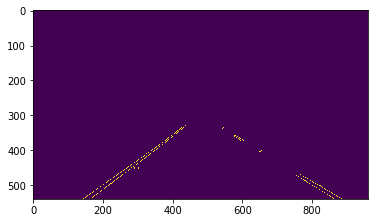

[[-0.80434783]
 [ 0.61904762]
 [-0.58333333]
 [-0.69230769]
 [-0.63636364]
 [-0.75      ]
 [-0.68421053]
 [ 0.58333333]
 [-0.81818182]
 [-0.86666667]
 [ 0.65      ]
 [-0.64285714]
 [ 0.59090909]
 [-0.8       ]
 [-0.75757576]
 [ 0.5483871 ]
 [ 0.64      ]
 [-0.83333333]
 [-0.73076923]
 [-0.86956522]
 [-0.93333333]
 [-0.84615385]
 [-0.7       ]
 [-0.9       ]
 [ 0.5625    ]
 [-0.8       ]
 [ 0.52941176]]
left_m = -0.740962568428  right_m = 0.608969319639
left_c = 654.319406281  right_c = 7.18090755908
left_y = 334.223576721  right_y = 358.556204991  min y = 334.223576721
left_y = 538.729245607  right_y = 541.855970202  max y = 541.855970202


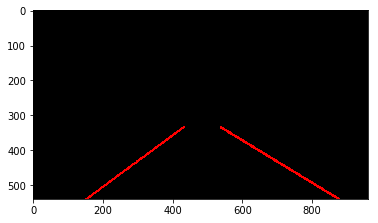

  6%|▌         | 41/682 [00:31<09:11,  1.16it/s]

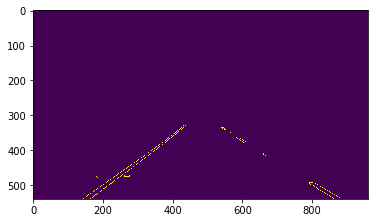

[[-0.88888889]
 [-0.83870968]
 [-0.80645161]
 [ 0.56962025]
 [ 0.56      ]
 [-0.70192308]
 [-0.88888889]
 [ 0.62264151]
 [-0.85714286]
 [ 0.53333333]
 [-0.75      ]
 [-0.66666667]
 [-0.9       ]
 [-0.84615385]
 [ 0.61111111]
 [-0.84615385]
 [-0.86666667]
 [ 0.54545455]
 [ 0.66666667]
 [-0.81818182]]
left_m = -0.759138053092  right_m = 0.611537503985
left_c = 662.758181618  right_c = 5.19437657081
left_y = 331.014852417  right_y = 361.10920389  min y = 331.014852417
left_y = 553.442301973  right_y = 545.18199259  max y = 553.442301973


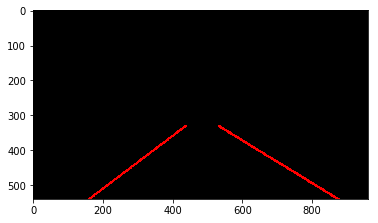

  6%|▌         | 42/682 [00:31<08:49,  1.21it/s]

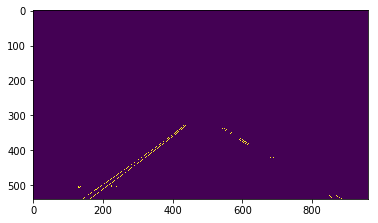

[[-0.69950739]
 [-0.77777778]
 [-0.77777778]
 [-0.79166667]
 [-0.81081081]
 [-0.85714286]
 [-0.82352941]
 [-0.75      ]
 [ 0.6       ]
 [-0.70967742]
 [ 0.61538462]
 [ 0.65217391]
 [-0.6       ]
 [-0.7       ]
 [-0.63636364]
 [-0.72727273]
 [-0.88235294]
 [ 0.        ]]
left_m = -0.755418101925  right_m = 0.563968668407
left_c = 660.867692108  right_c = 34.2214969539
left_y = 330.749981566  right_y = 365.271105309  min y = 330.749981566
left_y = 552.842903532  right_y = 384.446040035  max y = 552.842903532


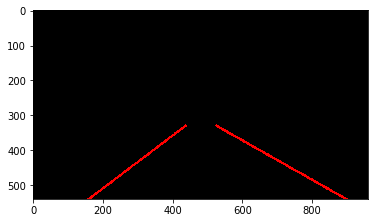

  6%|▋         | 43/682 [00:32<09:02,  1.18it/s]

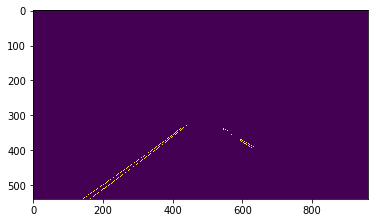

[[ 0.55555556]
 [ 0.59375   ]
 [-0.80769231]
 [-0.77272727]
 [-0.71698113]
 [-0.8       ]
 [-0.9       ]
 [-0.78947368]
 [-0.625     ]
 [-0.80769231]
 [-0.83870968]
 [-0.91666667]
 [-0.84615385]
 [-0.91666667]
 [ 0.5       ]
 [-0.90909091]
 [-0.85714286]
 [-0.81818182]
 [ 0.6       ]
 [-0.90909091]
 [-0.76470588]
 [-0.76923077]
 [-0.71428571]
 [-0.66666667]
 [-0.90909091]
 [-0.72727273]]
left_m = -0.717114995026  right_m = 0.572843760095
left_c = 647.490464966  right_c = 30.7751695919
left_y = 333.394097145  right_y = 373.335738129  min y = 333.394097145
left_y = 534.903410747  right_y = 392.812425972  max y = 534.903410747


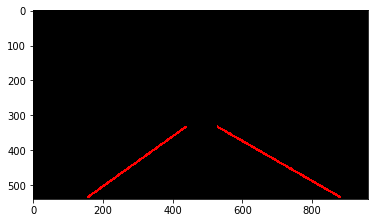

  6%|▋         | 44/682 [00:33<08:50,  1.20it/s]

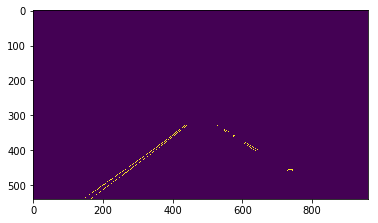

[[ 0.5483871 ]
 [-0.7826087 ]
 [-0.9       ]
 [-0.69811321]
 [-0.77272727]
 [ 0.5       ]
 [-0.8       ]
 [-0.85714286]
 [-0.83333333]
 [-0.86363636]
 [-0.875     ]
 [-0.75      ]
 [-0.63636364]
 [-0.84615385]
 [-0.63636364]
 [ 0.6       ]
 [-0.77777778]
 [-0.81818182]
 [-0.7826087 ]
 [ 0.63636364]
 [-0.77777778]
 [ 0.7       ]]
left_m = -0.744873706233  right_m = 0.556302215765
left_c = 657.272430104  right_c = 43.2277515438
left_y = 330.272873068  right_y = 377.565383218  min y = 330.272873068
left_y = 549.265742701  right_y = 402.042680712  max y = 549.265742701


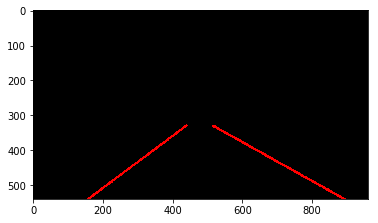

  7%|▋         | 45/682 [00:34<08:44,  1.22it/s]

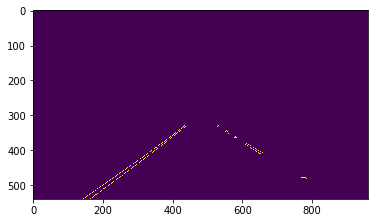

[[-0.8125    ]
 [-0.7755102 ]
 [-0.92307692]
 [-0.63636364]
 [-0.84210526]
 [-0.85714286]
 [-0.76470588]
 [ 0.64705882]
 [-0.84615385]
 [-0.67857143]
 [ 0.        ]
 [ 0.6       ]
 [-0.92307692]
 [-0.76923077]
 [ 0.53846154]
 [-0.66666667]
 [ 0.54545455]
 [ 0.        ]
 [ 0.66666667]
 [-0.66666667]
 [-0.61538462]
 [-0.63636364]
 [-0.81818182]
 [ 0.66666667]
 [-0.83333333]
 [-0.72727273]]
left_m = -0.723091211838  right_m = 0.614785857607
left_c = 648.584992899  right_c = 5.77893862866
left_y = 334.04031575  right_y = 343.296374455  min y = 334.04031575
left_y = 537.228946276  right_y = 404.774960216  max y = 537.228946276


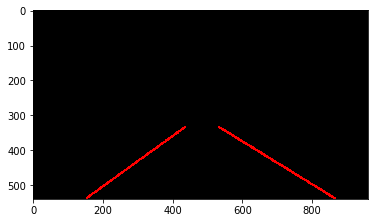

  7%|▋         | 46/682 [00:35<09:17,  1.14it/s]

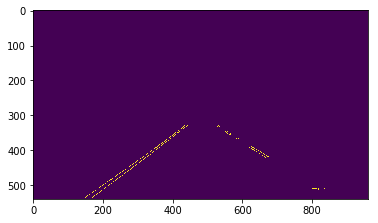

[[-0.83333333]
 [-0.75862069]
 [-0.76470588]
 [-0.70833333]
 [-0.76923077]
 [ 0.60869565]
 [-0.6       ]
 [-0.72916667]
 [ 0.60714286]
 [-0.75      ]
 [-0.9       ]
 [ 0.        ]
 [-0.6       ]
 [-0.7       ]
 [ 0.        ]
 [ 0.7       ]
 [-0.58333333]
 [-0.63636364]
 [ 0.        ]
 [-0.6       ]
 [-0.7       ]
 [-0.77777778]
 [-0.90909091]
 [-0.70588235]
 [-0.9       ]
 [ 0.08333333]
 [-0.76923077]
 [ 0.70588235]
 [-0.84210526]
 [-0.6875    ]
 [-0.6       ]
 [ 0.58333333]
 [-0.8       ]]
left_m = -0.745866247768  right_m = 0.59112959113
left_c = 657.779816177  right_c = 22.2125433125
left_y = 328.852800911  right_y = 388.712889813  min y = 328.852800911
left_y = 549.629210251  right_y = 422.998406098  max y = 549.629210251


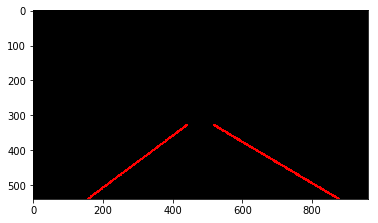

  7%|▋         | 47/682 [00:35<08:48,  1.20it/s]

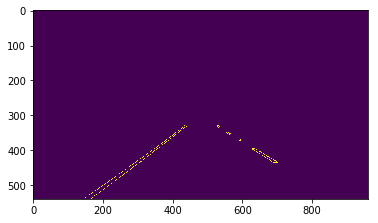

[[ 0.        ]
 [-0.76      ]
 [-0.73684211]
 [-0.8125    ]
 [ 0.64864865]
 [-0.625     ]
 [-0.71428571]
 [-0.6875    ]
 [-0.80645161]
 [-0.6       ]
 [-0.63636364]
 [-0.71428571]
 [-0.7804878 ]
 [-0.84615385]
 [ 0.6       ]
 [-0.7826087 ]
 [ 0.61904762]
 [-0.84210526]
 [ 0.54545455]
 [ 0.5       ]
 [-0.90909091]
 [-0.75      ]
 [-0.82352941]
 [ 0.5       ]
 [-0.8       ]
 [-0.63636364]]
left_m = -0.713422874275  right_m = 0.618992447019
left_c = 645.43534554  right_c = 4.07090024688
left_y = 331.529280859  right_y = 347.611708342  min y = 331.529280859
left_y = 541.275605896  right_y = 428.699718902  max y = 541.275605896


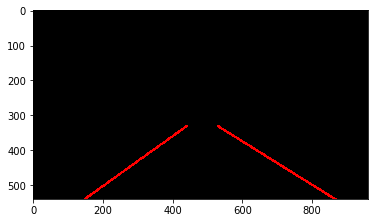

  7%|▋         | 48/682 [00:36<08:40,  1.22it/s]

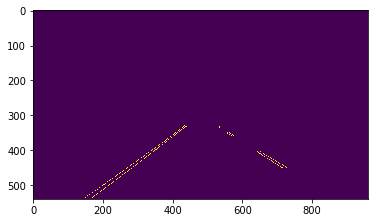

[[-0.8       ]
 [-0.75409836]
 [ 0.6       ]
 [-0.84210526]
 [-0.67924528]
 [-0.84210526]
 [-0.64705882]
 [-0.85714286]
 [-0.77631579]
 [ 0.53846154]
 [-0.625     ]
 [-0.8125    ]
 [ 0.58333333]
 [ 0.5       ]
 [ 0.5       ]
 [-0.66666667]
 [-0.58333333]
 [ 0.65      ]
 [-0.65      ]
 [-0.82608696]
 [-0.64285714]
 [ 0.58333333]
 [ 0.61538462]
 [ 0.66666667]
 [ 0.58333333]
 [ 0.6       ]]
left_m = -0.724198139947  right_m = 0.63288222724
left_c = 648.467973646  right_c = -5.42903229065
left_y = 329.09659393  right_y = 348.352132737  min y = 329.09659393
left_y = 543.459243354  right_y = 447.081760186  max y = 543.459243354


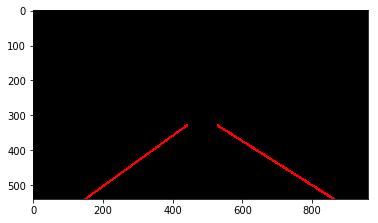

  7%|▋         | 49/682 [00:37<08:32,  1.23it/s]

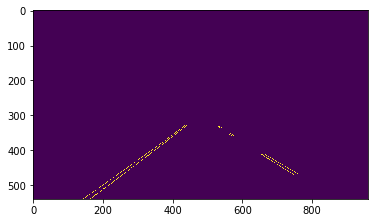

[[ 0.53125   ]
 [-0.70192308]
 [ 0.63636364]
 [-0.74285714]
 [-0.85714286]
 [-0.63636364]
 [ 0.60526316]
 [ 0.5625    ]
 [-0.83333333]
 [-0.71428571]
 [-0.82352941]
 [ 0.63157895]
 [-0.73913043]
 [-0.84615385]
 [-0.68421053]
 [ 0.45454545]
 [ 0.625     ]
 [ 0.52631579]
 [-0.75      ]
 [-0.66666667]
 [-0.66666667]
 [-0.64705882]
 [-0.66666667]
 [-0.65217391]
 [-0.63636364]
 [-0.63636364]
 [-0.6875    ]
 [-0.85714286]]
left_m = -0.753068898216  right_m = 0.599190699656
left_c = 658.784444026  right_c = 17.323602635
left_y = 337.977093386  right_y = 352.870394442  min y = 337.977093386
left_y = 549.589453784  right_y = 466.117436677  max y = 549.589453784


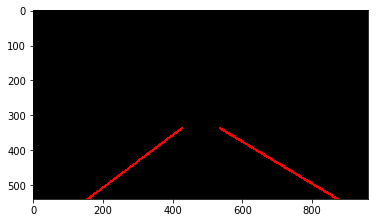

  7%|▋         | 50/682 [00:38<08:29,  1.24it/s]

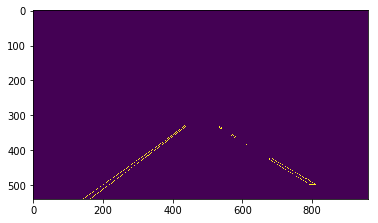

[[-0.61538462]
 [-0.66666667]
 [-0.79310345]
 [-0.7816092 ]
 [ 0.54166667]
 [-0.625     ]
 [ 0.62068966]
 [ 0.54545455]
 [-0.8       ]
 [-0.77142857]
 [ 0.6       ]
 [-0.81818182]
 [-0.81818182]
 [ 0.54545455]
 [-0.82608696]
 [ 0.52631579]
 [-0.78571429]
 [-0.84615385]
 [-0.8       ]
 [ 0.56      ]
 [-0.64705882]
 [-0.83333333]
 [-0.75      ]
 [ 0.52380952]
 [ 0.        ]
 [ 0.63636364]
 [-0.6       ]
 [-0.61538462]
 [ 0.63636364]
 [-0.7       ]
 [-0.6       ]]
left_m = -0.731715027755  right_m = 0.604698903823
left_c = 650.348469033  right_c = 11.6527495283
left_y = 332.784146988  right_y = 353.307630189  min y = 332.784146988
left_y = 544.981505037  right_y = 494.807173683  max y = 544.981505037


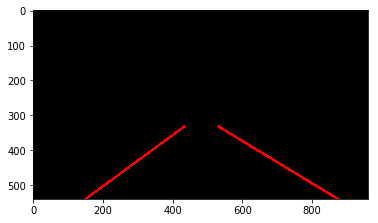

  7%|▋         | 51/682 [00:39<08:03,  1.30it/s]

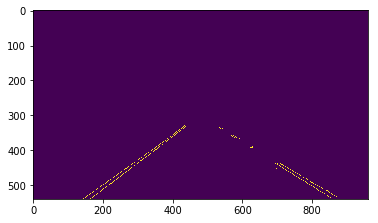

[[ 0.64444444]
 [ 0.6       ]
 [-0.80769231]
 [-0.76470588]
 [-0.77777778]
 [-0.7826087 ]
 [ 0.56521739]
 [ 0.70588235]
 [-0.7826087 ]
 [ 0.61111111]
 [ 0.66666667]
 [-0.9       ]
 [-0.75      ]
 [-0.76923077]
 [-0.83333333]
 [-0.7826087 ]
 [-0.78571429]
 [-0.81818182]
 [-0.76190476]
 [-0.86666667]
 [ 0.61111111]
 [ 0.6875    ]
 [-0.84615385]
 [ 0.46153846]
 [ 0.5       ]
 [-0.77777778]
 [-0.9       ]
 [-0.76470588]
 [ 0.57142857]
 [ 0.5       ]
 [ 0.63636364]
 [-0.90909091]
 [ 0.63636364]
 [ 0.53846154]
 [ 0.69230769]
 [ 0.        ]]
left_m = -0.722780141751  right_m = 0.601952121022
left_c = 648.158904621  right_c = 15.4890939447
left_y = 329.412862109  right_y = 362.815467774  min y = 329.412862109
left_y = 534.682422366  right_y = 535.575726507  max y = 535.575726507


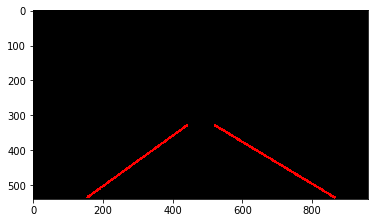

  8%|▊         | 52/682 [00:39<07:14,  1.45it/s]

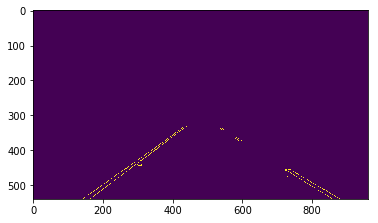

[[ 0.58823529]
 [-0.63636364]
 [ 0.5       ]
 [-0.71153846]
 [-0.68292683]
 [ 0.47058824]
 [-0.7       ]
 [-0.83333333]
 [-0.66666667]
 [ 0.5       ]
 [-0.83333333]
 [-0.75      ]
 [-0.8       ]
 [-0.69230769]
 [-0.75      ]
 [-0.77272727]
 [-0.8125    ]
 [ 0.54545455]
 [-0.84210526]
 [ 0.56756757]
 [-0.9       ]
 [-0.69230769]
 [ 0.53333333]
 [-0.72      ]
 [ 0.58333333]
 [ 0.72727273]
 [ 0.5       ]
 [ 0.5       ]
 [-0.75      ]
 [-0.63636364]
 [-0.63636364]
 [ 0.57894737]
 [-0.6       ]
 [ 0.72727273]
 [ 0.54545455]]
left_m = -0.715248168015  right_m = 0.584674981547
left_c = 646.467459826  right_c = 28.7194768057
left_y = 338.91074758  right_y = 365.492266177  min y = 338.91074758
left_y = 544.1869718  right_y = 542.064110604  max y = 544.1869718


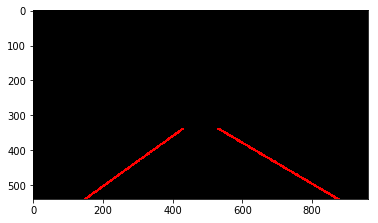

  8%|▊         | 53/682 [00:40<06:52,  1.52it/s]

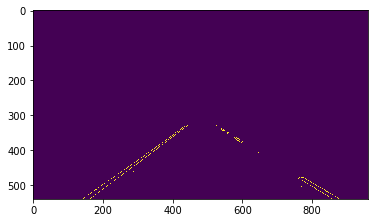

[[-0.64285714]
 [ 0.58536585]
 [-0.72093023]
 [-0.73913043]
 [ 0.57894737]
 [-0.8125    ]
 [-0.73684211]
 [-0.68085106]
 [-0.78125   ]
 [-0.81818182]
 [ 0.5       ]
 [-0.76923077]
 [ 0.57894737]
 [ 0.54545455]
 [-0.8125    ]
 [ 0.66666667]
 [ 0.58823529]
 [-0.73076923]
 [-0.81818182]
 [ 0.53846154]
 [ 0.56      ]
 [ 0.54545455]
 [-0.64285714]
 [-0.8125    ]
 [-0.625     ]
 [-0.72727273]
 [-0.9       ]
 [-0.72727273]
 [-0.6       ]
 [-0.6       ]
 [ 0.54545455]
 [-0.63636364]
 [ 0.45454545]
 [-0.84615385]
 [-0.90909091]]
left_m = -0.718891488688  right_m = 0.599483379656
left_c = 647.662021177  right_c = 19.0557716002
left_y = 329.911983177  right_y = 364.957681661  min y = 329.911983177
left_y = 543.422755317  right_y = 540.606311901  max y = 543.422755317


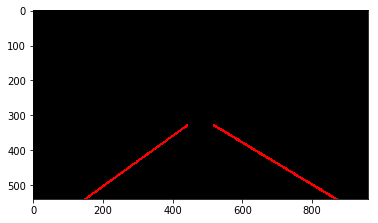

  8%|▊         | 54/682 [00:41<07:41,  1.36it/s]

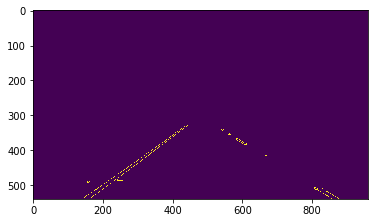

[[-0.7037037 ]
 [ 0.54166667]
 [-0.75      ]
 [-0.58333333]
 [-0.82608696]
 [-0.72992701]
 [-0.78947368]
 [ 0.61538462]
 [ 0.61538462]
 [ 0.53333333]
 [ 0.54545455]
 [-0.83333333]
 [-0.8       ]
 [ 0.55882353]
 [-0.72222222]
 [ 0.        ]
 [-0.83333333]]
left_m = -0.725162109336  right_m = 0.590115528434
left_c = 651.126576843  right_c = 24.860283396
left_y = 331.330086626  right_y = 370.667983058  min y = 331.330086626
left_y = 548.153557318  right_y = 541.801486304  max y = 548.153557318


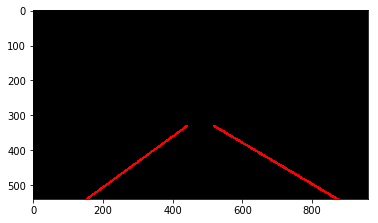

  8%|▊         | 55/682 [00:41<07:56,  1.32it/s]

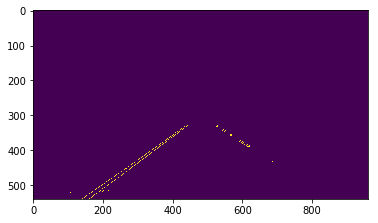

[[-0.63636364]
 [-0.73170732]
 [-0.84615385]
 [-0.76056338]
 [-0.77777778]
 [-0.6       ]
 [-0.80952381]
 [-0.81818182]
 [-0.7       ]
 [-0.70588235]
 [-0.8       ]
 [ 0.58823529]
 [-0.74358974]
 [ 0.55555556]
 [-0.8       ]
 [-0.76923077]
 [ 0.58823529]
 [ 0.1       ]
 [-0.8       ]]
left_m = -0.726465478412  right_m = 0.502040816327
left_c = 649.491624306  right_c = 75.9442176871
left_y = 330.573279283  right_y = 370.642176871  min y = 330.573279283
left_y = 546.333526371  right_y = 382.189115646  max y = 546.333526371


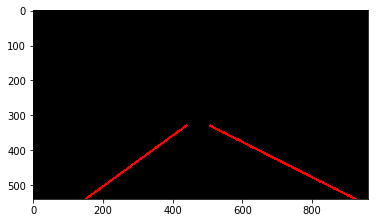

  8%|▊         | 56/682 [00:42<07:45,  1.34it/s]

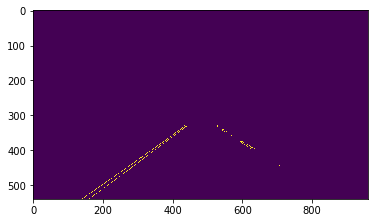

[[-0.66666667]
 [-0.90909091]
 [-0.7       ]
 [-0.73684211]
 [-0.84615385]
 [-0.68421053]
 [-0.83333333]
 [-0.7260274 ]
 [-0.8125    ]
 [-0.83333333]
 [ 0.71428571]
 [-0.9       ]
 [-0.9       ]
 [-0.8125    ]
 [-0.83333333]
 [-0.77777778]
 [ 0.59375   ]
 [-0.6       ]
 [-0.78571429]
 [-0.6       ]
 [ 0.69230769]
 [-0.76923077]
 [-0.9       ]
 [-0.58333333]]
left_m = -0.719242035762  right_m = 0.531363897947
left_c = 646.270148258  right_c = 60.6232495684
left_y = 332.680620666  right_y = 377.847496643  min y = 332.680620666
left_y = 544.857021216  right_y = 396.976596969  max y = 544.857021216


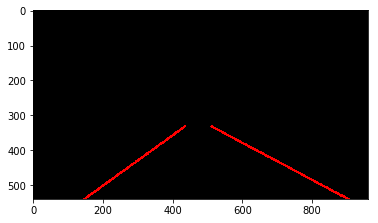

  8%|▊         | 57/682 [00:43<08:28,  1.23it/s]

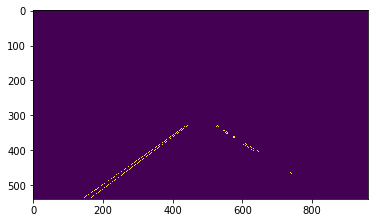

[[-0.71428571]
 [-0.75333333]
 [-0.8       ]
 [-0.77777778]
 [-0.69230769]
 [-0.72413793]
 [ 0.60869565]
 [ 0.59259259]
 [-0.76923077]
 [ 0.53846154]
 [-0.8125    ]
 [ 0.6       ]
 [-0.75      ]
 [-0.71052632]
 [-0.81818182]
 [-0.6       ]
 [-0.75      ]
 [-0.78571429]]
left_m = -0.710105338941  right_m = 0.591156462585
left_c = 642.783232122  right_c = 24.5962585034
left_y = 336.727831038  right_y = 382.83707483  min y = 336.727831038
left_y = 536.97753662  right_y = 406.483333333  max y = 536.97753662


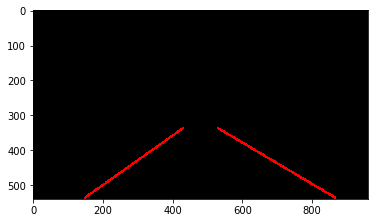

  9%|▊         | 58/682 [00:44<08:32,  1.22it/s]

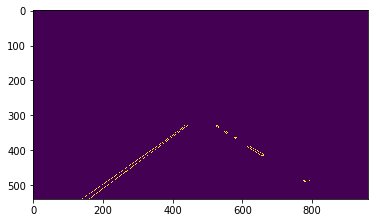

[[-0.7027027 ]
 [-0.71428571]
 [-0.66666667]
 [-0.78571429]
 [-0.85      ]
 [-0.78787879]
 [-0.77272727]
 [ 0.63636364]
 [ 0.53846154]
 [-0.76190476]
 [-0.6       ]
 [-0.69230769]
 [-0.72972973]
 [-0.73913043]
 [ 0.57894737]
 [-0.78571429]
 [ 0.        ]
 [ 0.66666667]
 [-0.8       ]
 [-0.8       ]
 [-0.77777778]
 [ 0.54545455]
 [-0.73913043]
 [ 0.54545455]
 [-0.76923077]
 [ 0.        ]]
left_m = -0.729705859043  right_m = 0.595275760408
left_c = 650.761569767  right_c = 21.5241724791
left_y = 328.231580071  right_y = 347.140013422  min y = 328.231580071
left_y = 533.278926462  right_y = 415.596725869  max y = 533.278926462


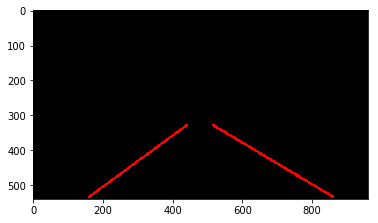

  9%|▊         | 59/682 [00:45<08:27,  1.23it/s]

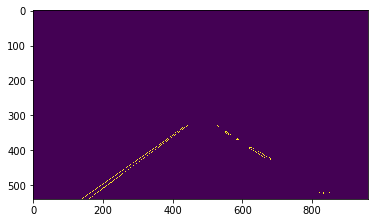

[[-0.73109244]
 [-0.7027027 ]
 [-0.72619048]
 [-0.71428571]
 [ 0.60606061]
 [ 0.58333333]
 [ 0.56521739]
 [-0.66666667]
 [-0.75      ]
 [-0.73684211]
 [-0.72      ]
 [-0.72727273]
 [ 0.57142857]
 [-0.79166667]
 [ 0.        ]
 [-0.86666667]
 [-0.75      ]
 [-0.75      ]]
left_m = -0.718963594747  right_m = 0.638295136768
left_c = 647.207181207  right_c = -4.60465751663
left_y = 329.425272329  right_y = 347.734257979  min y = 329.425272329
left_y = 541.519532779  right_y = 424.967969528  max y = 541.519532779


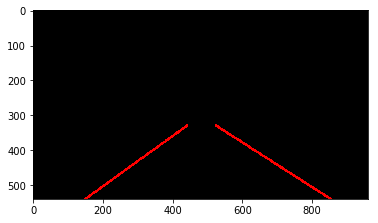

  9%|▉         | 60/682 [00:45<08:12,  1.26it/s]

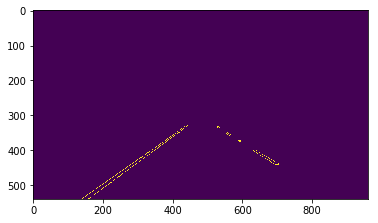

[[-0.73846154]
 [-0.70175439]
 [ 0.575     ]
 [-0.75      ]
 [-0.7173913 ]
 [-0.66666667]
 [ 0.58333333]
 [ 0.57142857]
 [ 0.5       ]
 [-0.69230769]
 [ 0.52173913]
 [ 0.57142857]
 [ 0.5       ]
 [ 0.5       ]
 [-0.70833333]
 [-0.72222222]
 [-0.6875    ]
 [-0.7037037 ]
 [-0.70588235]
 [-0.725     ]
 [-0.66666667]
 [-0.63636364]
 [-0.7       ]]
left_m = -0.734020379541  right_m = 0.610426056042
left_c = 653.407491819  right_c = 13.2341348711
left_y = 337.778728616  right_y = 350.799743862  min y = 337.778728616
left_y = 550.644638683  right_y = 440.532374101  max y = 550.644638683


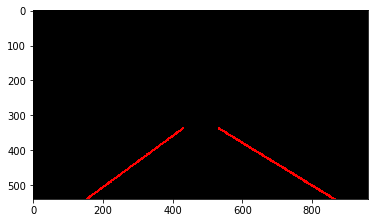

  9%|▉         | 61/682 [00:46<08:31,  1.21it/s]

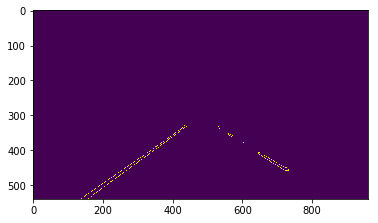

[[ 0.36363636]
 [-0.79166667]
 [-0.77272727]
 [-0.73170732]
 [-0.6969697 ]
 [-0.86666667]
 [-0.8125    ]
 [-0.80769231]
 [-0.78571429]
 [-0.72727273]
 [-0.74285714]
 [-0.81818182]
 [-0.81818182]
 [-0.6       ]
 [ 0.61538462]
 [ 0.53846154]
 [ 0.65625   ]
 [ 0.5       ]
 [-0.77777778]
 [-0.86666667]
 [ 0.7       ]
 [-0.84615385]
 [ 0.66666667]
 [-0.73333333]
 [-0.8       ]
 [-0.9       ]
 [ 0.6       ]]
left_m = -0.71740335043  right_m = 0.631083920079
left_c = 645.92056139  right_c = -0.808843824442
left_y = 330.263087201  right_y = 350.70489966  min y = 330.263087201
left_y = 547.636302381  right_y = 454.202662553  max y = 547.636302381


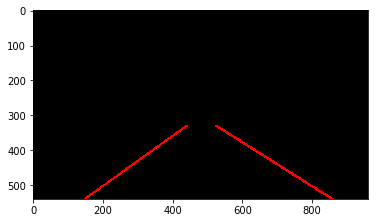

  9%|▉         | 62/682 [00:47<08:34,  1.20it/s]

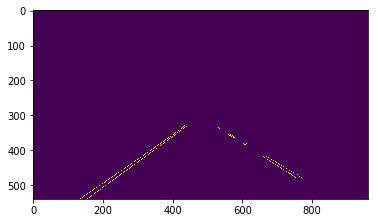

[[ 0.58333333]
 [ 0.45454545]
 [-0.72727273]
 [-0.66666667]
 [ 0.5       ]
 [-0.83333333]
 [-0.67857143]
 [-0.68421053]
 [-0.61538462]
 [-0.7826087 ]
 [ 0.57142857]
 [-0.9       ]
 [ 0.65625   ]
 [ 0.6       ]
 [-0.6       ]
 [-0.71428571]
 [ 0.57142857]
 [-0.86666667]
 [-0.81818182]
 [-0.71428571]
 [-0.81818182]
 [-0.78571429]
 [-0.9       ]
 [-0.76190476]
 [-0.78571429]
 [-0.71428571]
 [-0.6       ]
 [ 0.625     ]
 [ 0.6       ]
 [-0.7       ]]
left_m = -0.699167432962  right_m = 0.619139763349
left_c = 638.55585087  right_c = 5.42270280158
left_y = 336.51551983  right_y = 353.379249804  min y = 336.51551983
left_y = 543.469079987  right_y = 469.777525313  max y = 543.469079987


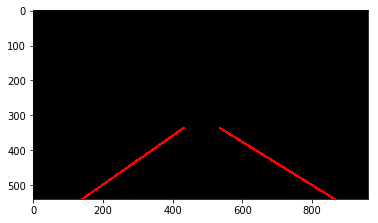

  9%|▉         | 63/682 [00:48<09:01,  1.14it/s]

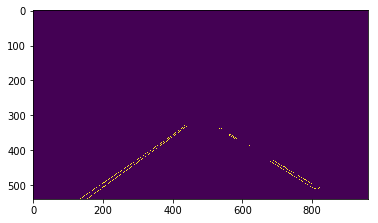

[[-0.72463768]
 [-0.6875    ]
 [-0.73239437]
 [-0.65789474]
 [ 0.6       ]
 [ 0.5       ]
 [-0.6       ]
 [ 0.66666667]
 [-0.8       ]
 [-0.66666667]
 [ 0.55555556]
 [-0.7       ]
 [-0.64      ]
 [ 0.60869565]
 [ 0.625     ]
 [-0.625     ]
 [-0.625     ]
 [-0.58333333]
 [ 0.5625    ]
 [-0.83333333]
 [-0.63333333]
 [ 0.42857143]
 [-0.75      ]
 [ 0.5       ]
 [-0.8       ]
 [-0.58823529]
 [ 0.5       ]
 [ 0.54545455]
 [-0.68      ]
 [ 0.57142857]
 [ 0.5625    ]
 [-0.66666667]
 [ 0.56521739]
 [ 0.6       ]
 [-0.69230769]]
left_m = -0.68220563821  right_m = 0.606654549623
left_c = 632.914508632  right_c = 15.6367424801
left_y = 334.108439096  right_y = 357.183253918  min y = 334.108439096
left_y = 540.816747474  right_y = 513.70012772  max y = 540.816747474


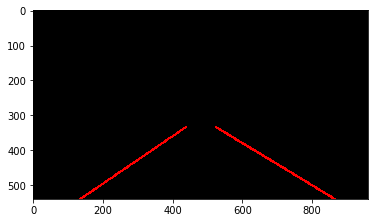

  9%|▉         | 64/682 [00:49<08:54,  1.16it/s]

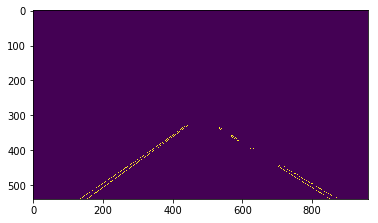

[[ 0.55555556]
 [ 0.55555556]
 [-0.70175439]
 [ 0.54545455]
 [-0.73228346]
 [ 0.65517241]
 [-0.71428571]
 [-0.71428571]
 [ 0.56      ]
 [-0.72727273]
 [-0.6       ]
 [ 0.47826087]
 [-0.57142857]
 [ 0.66666667]
 [-0.68421053]
 [ 0.5       ]
 [-0.58333333]
 [ 0.55555556]
 [ 0.5       ]
 [ 0.57142857]
 [ 0.5       ]
 [-0.72727273]
 [ 0.5       ]
 [ 0.64705882]
 [ 0.5       ]
 [ 0.58333333]
 [-0.68965517]
 [-0.72727273]]
left_m = -0.701574855709  right_m = 0.60362294247
left_c = 639.730524789  right_c = 18.109873582
left_y = 341.561211113  right_y = 360.364081962  min y = 341.561211113
left_y = 544.316344412  right_y = 536.621981164  max y = 544.316344412


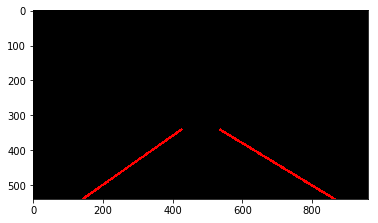

 10%|▉         | 65/682 [00:50<08:55,  1.15it/s]

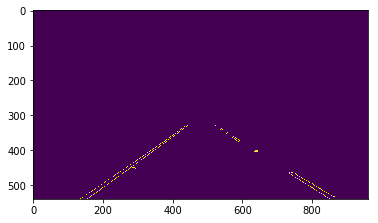

[[-0.77419355]
 [-0.75      ]
 [-0.6       ]
 [-0.71428571]
 [ 0.53846154]
 [-0.70588235]
 [-0.6       ]
 [-0.8       ]
 [-0.77777778]
 [ 0.62068966]
 [ 0.6       ]
 [-0.71428571]
 [ 0.6       ]
 [ 0.61111111]
 [-0.61904762]
 [ 0.55555556]
 [-0.90909091]
 [-0.83333333]
 [-0.8       ]
 [-0.84615385]
 [-0.76470588]
 [ 0.65217391]
 [-0.6       ]
 [-0.77777778]
 [-0.69230769]
 [-0.7826087 ]
 [-0.7       ]
 [-0.9       ]
 [ 0.6       ]
 [ 0.16666667]
 [-0.64285714]
 [-0.8       ]]
left_m = -0.7044423207  right_m = 0.61052366529
left_c = 641.473451161  right_c = 14.3499184411
left_y = 335.745483978  right_y = 367.232596979  min y = 335.745483978
left_y = 545.669295546  right_y = 537.568699595  max y = 545.669295546


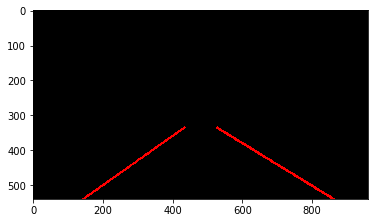

 10%|▉         | 66/682 [00:51<08:49,  1.16it/s]

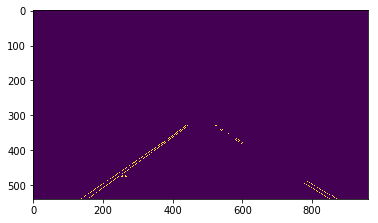

[[-0.67768595]
 [ 0.6       ]
 [-0.76666667]
 [-0.76923077]
 [-0.81818182]
 [-0.76744186]
 [-0.8       ]
 [-0.8       ]
 [ 0.64285714]
 [-0.7826087 ]
 [-0.81818182]
 [ 0.60869565]
 [ 0.61428571]
 [ 0.6       ]
 [ 0.61904762]
 [-0.81818182]
 [-0.81818182]
 [-0.83333333]
 [-0.75      ]
 [-0.6       ]
 [-0.75      ]
 [-0.83333333]
 [-0.81818182]]
left_m = -0.717683367742  right_m = 0.621691402588
left_c = 646.928830206  right_c = 4.86438327792
left_y = 328.995098296  right_y = 364.823705376  min y = 328.995098296
left_y = 547.888525457  right_y = 535.167149685  max y = 547.888525457


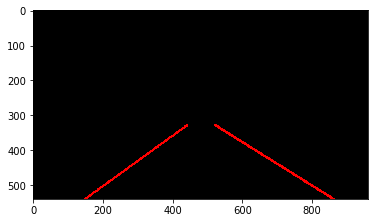

 10%|▉         | 67/682 [00:51<08:21,  1.23it/s]

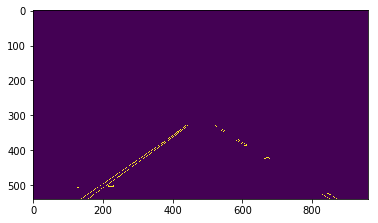

[[-0.72463768]
 [ 0.30434783]
 [-0.81081081]
 [-0.73684211]
 [-0.71794872]
 [-0.71428571]
 [ 0.58823529]
 [-0.70512821]
 [-0.77777778]
 [-0.75      ]
 [ 0.64285714]
 [-0.84615385]
 [ 0.57142857]
 [-0.84615385]
 [ 0.54545455]
 [-0.78571429]
 [-0.71428571]
 [-0.6875    ]
 [-0.81818182]
 [-0.71428571]
 [ 0.6       ]]
left_m = -0.685928289856  right_m = 0.633828764616
left_c = 634.612818976  right_c = 0.162230375546
left_y = 331.43251486  right_y = 367.782913853  min y = 331.43251486
left_y = 539.268786686  right_y = 538.282851534  max y = 539.268786686


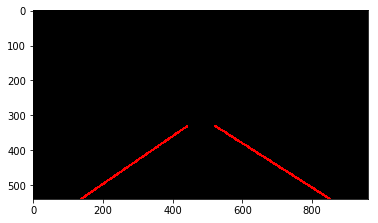

 10%|▉         | 68/682 [00:52<07:30,  1.36it/s]

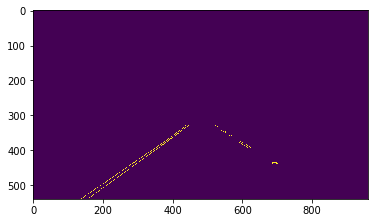

[[-0.625     ]
 [-0.6779661 ]
 [-0.66666667]
 [ 0.54545455]
 [-0.625     ]
 [-0.70833333]
 [-0.64285714]
 [ 0.52631579]
 [-0.66666667]
 [-0.91666667]
 [-0.63636364]
 [-0.64285714]
 [-0.90909091]
 [-0.83333333]
 [-0.81818182]
 [-0.73684211]
 [-0.76923077]
 [-0.9       ]
 [-0.6       ]
 [ 0.        ]
 [-0.61538462]
 [-0.75      ]
 [-0.6       ]]
left_m = -0.68453859741  right_m = 0.39751552795
left_c = 636.815134028  right_c = 144.925465839
left_y = 339.725382752  right_y = 383.434782609  min y = 339.725382752
left_y = 540.295191793  right_y = 392.97515528  max y = 540.295191793


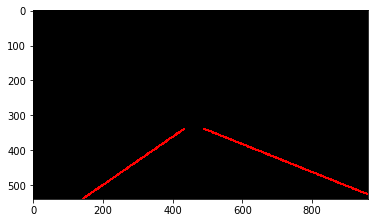

 10%|█         | 69/682 [00:52<06:32,  1.56it/s]

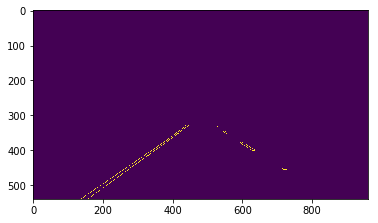

[[-0.70454545]
 [-0.70588235]
 [-0.64285714]
 [ 0.5625    ]
 [-0.69444444]
 [-0.7       ]
 [-0.80952381]
 [-0.625     ]
 [-0.6       ]
 [-0.69230769]
 [-0.8125    ]
 [-0.66666667]
 [-0.76923077]
 [-0.70588235]
 [-0.6       ]
 [-0.66666667]
 [ 0.63157895]
 [-0.6       ]
 [-0.66666667]
 [ 0.61538462]
 [-0.72727273]
 [-0.63636364]
 [-0.7       ]]
left_m = -0.69539720617  right_m = 0.590078328982
left_c = 639.239896576  right_c = 26.2684943429
left_y = 331.874331449  right_y = 380.315491732  min y = 331.874331449
left_y = 543.275082125  right_y = 400.968233246  max y = 543.275082125


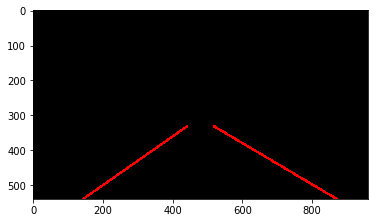

 10%|█         | 70/682 [00:53<05:50,  1.74it/s]

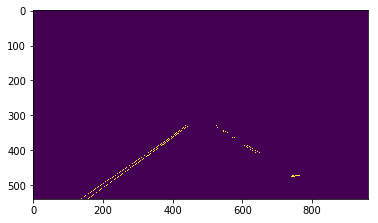

[[-0.65306122]
 [-0.75      ]
 [-0.65      ]
 [-0.72463768]
 [-0.84615385]
 [-0.81818182]
 [-0.76470588]
 [-0.76190476]
 [-0.76923077]
 [-0.61538462]
 [-0.76923077]
 [-0.63636364]
 [-0.75      ]
 [-0.76470588]
 [ 0.68181818]
 [-0.71428571]
 [-0.8       ]
 [ 0.5862069 ]
 [ 0.6       ]
 [-0.63636364]
 [ 0.66666667]
 [ 0.6       ]
 [ 0.64285714]
 [-0.58333333]
 [-0.63157895]
 [-0.8       ]
 [-0.64285714]]
left_m = -0.700913243095  right_m = 0.620199984888
left_c = 640.032235598  right_c = 8.03825907362
left_y = 335.835888095  right_y = 345.427050853  min y = 335.835888095
left_y = 536.29707562  right_y = 410.548049266  max y = 536.29707562


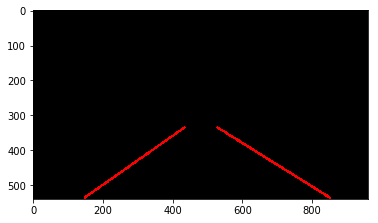

 10%|█         | 71/682 [00:54<06:37,  1.54it/s]

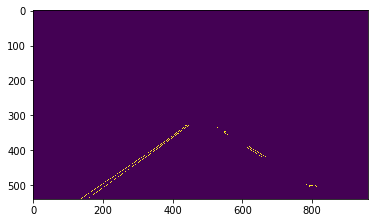

[[-0.72222222]
 [-0.69230769]
 [-0.61904762]
 [ 0.        ]
 [-0.73333333]
 [-0.75      ]
 [-0.77272727]
 [-0.76470588]
 [-0.61904762]
 [-0.64705882]
 [-0.7037037 ]
 [ 0.64285714]
 [-0.64705882]
 [-0.8125    ]
 [-0.90909091]
 [-0.6       ]
 [-0.7826087 ]
 [ 0.57142857]
 [-0.58333333]
 [ 0.54545455]
 [ 0.28571429]
 [-0.78571429]
 [-0.76923077]
 [-0.9       ]
 [ 0.58333333]]
left_m = -0.700951971418  right_m = 0.522485118303
left_c = 641.30353336  right_c = 69.9192136461
left_y = 330.08085805  right_y = 388.635135811  min y = 330.08085805
left_y = 540.366449475  right_y = 417.894302436  max y = 540.366449475


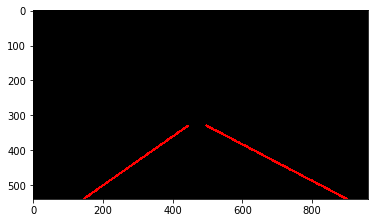

 11%|█         | 72/682 [00:54<07:13,  1.41it/s]

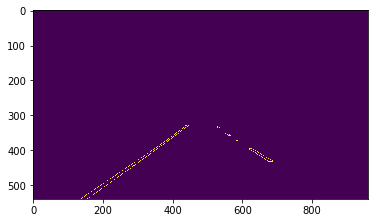

[[-0.7       ]
 [-0.76666667]
 [-0.71830986]
 [-0.69387755]
 [ 0.55      ]
 [-0.78571429]
 [ 0.        ]
 [-0.65957447]
 [-0.65625   ]
 [ 0.64285714]
 [-0.75      ]
 [-0.8125    ]
 [ 0.56410256]
 [-0.83333333]
 [-0.7826087 ]
 [ 0.625     ]
 [-0.69230769]
 [-0.82352941]
 [ 0.57142857]
 [-0.64705882]
 [-0.9       ]
 [-0.83333333]
 [-0.75      ]
 [ 0.53846154]]
left_m = -0.682886224799  right_m = 0.647351861563
left_c = 635.747725151  right_c = -9.27014507953
left_y = 332.54624134  right_y = 348.068082503  min y = 332.54624134
left_y = 542.192312354  right_y = 434.813231952  max y = 542.192312354


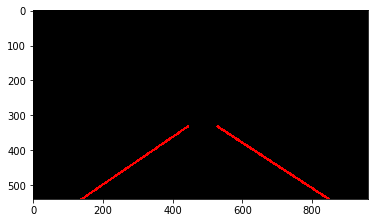

 11%|█         | 73/682 [00:55<06:41,  1.52it/s]

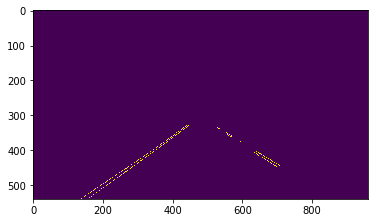

[[ 0.66666667]
 [-0.72881356]
 [-0.8       ]
 [-0.68131868]
 [-0.75      ]
 [-0.6       ]
 [-0.57142857]
 [-0.6       ]
 [-0.78571429]
 [-0.68965517]
 [ 0.58333333]
 [-0.76190476]
 [-0.81818182]
 [ 0.62318841]
 [-0.63636364]
 [ 0.625     ]
 [ 0.6       ]
 [-0.54545455]
 [-0.7037037 ]
 [-0.61111111]
 [-0.63636364]
 [-0.72727273]
 [ 0.63636364]
 [-0.64285714]
 [-0.58823529]
 [ 0.58823529]
 [ 0.57142857]
 [-0.61538462]
 [ 0.6       ]
 [-0.66666667]
 [-0.6       ]]
left_m = -0.686588814136  right_m = 0.61200031706
left_c = 637.170623113  right_c = 13.9573477583
left_y = 331.638600823  right_y = 353.005523409  min y = 331.638600823
left_y = 539.675011506  right_y = 444.805570968  max y = 539.675011506


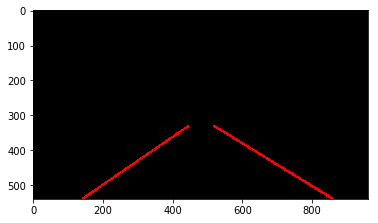

 11%|█         | 74/682 [00:56<08:00,  1.26it/s]

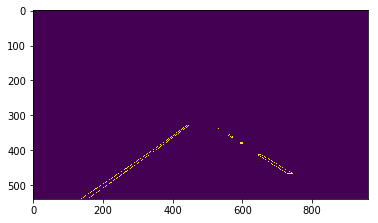

[[-0.73076923]
 [-0.71875   ]
 [-0.73684211]
 [ 0.5862069 ]
 [-0.64705882]
 [-0.6       ]
 [-0.74576271]
 [-0.77777778]
 [ 0.66666667]
 [-0.58333333]
 [ 0.57142857]
 [-0.71428571]
 [-0.72727273]
 [-0.72      ]
 [-0.58333333]
 [-0.78571429]
 [ 0.55      ]
 [-0.58333333]
 [-0.77272727]
 [-0.81818182]
 [-0.61538462]
 [-0.78571429]
 [-0.9       ]
 [ 0.58823529]
 [ 0.58823529]
 [ 0.57142857]
 [-0.8       ]
 [ 0.66666667]
 [-0.7       ]]
left_m = -0.697289853558  right_m = 0.61421618803
left_c = 641.470811128  right_c = 13.1027346994
left_y = 331.176826295  right_y = 354.606935244  min y = 331.176826295
left_y = 538.969202655  right_y = 459.637903397  max y = 538.969202655


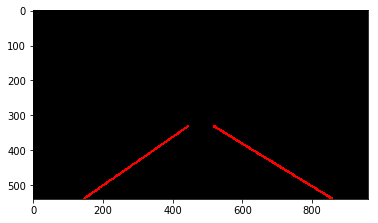

 11%|█         | 75/682 [00:57<08:08,  1.24it/s]

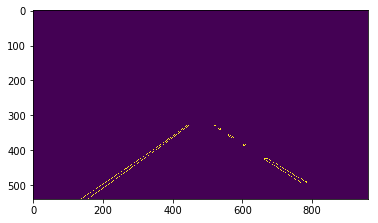

[[-0.6744186 ]
 [ 0.64150943]
 [-0.72277228]
 [-0.72413793]
 [-0.6875    ]
 [-0.61904762]
 [-0.75      ]
 [ 0.63333333]
 [ 0.54545455]
 [-0.6       ]
 [-0.8       ]
 [-0.64285714]
 [-0.64285714]
 [-0.8       ]
 [ 0.58333333]
 [-0.61111111]
 [-0.625     ]
 [-0.6       ]
 [ 0.57575758]
 [ 0.63157895]
 [-0.66666667]
 [ 0.59574468]
 [ 0.61538462]
 [-0.61111111]
 [-0.9       ]
 [-0.90909091]
 [ 0.61538462]
 [-0.64285714]
 [-0.62962963]
 [ 0.63636364]
 [-0.75      ]
 [-0.58333333]]
left_m = -0.686756084251  right_m = 0.620298963018
left_c = 636.983137826  right_c = 10.7677753105
left_y = 350.605850694  right_y = 360.616390452  min y = 350.605850694
left_y = 542.2107982  right_y = 496.461863353  max y = 542.2107982


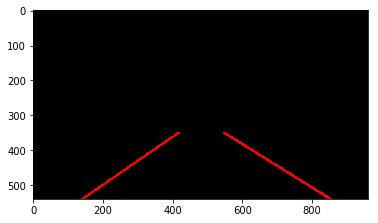

 11%|█         | 76/682 [00:58<08:01,  1.26it/s]

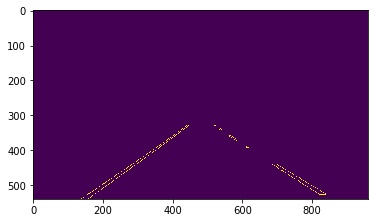

[[-0.8125    ]
 [-0.72413793]
 [ 0.57692308]
 [-0.78571429]
 [-0.61904762]
 [ 0.75      ]
 [ 0.63333333]
 [-0.77777778]
 [ 0.6       ]
 [-0.63333333]
 [-0.66037736]
 [ 0.55555556]
 [ 0.57894737]
 [-0.57142857]
 [-0.8       ]
 [ 0.6875    ]
 [-0.7       ]
 [-0.81818182]
 [-0.6       ]
 [-0.57894737]
 [-0.68421053]
 [-0.8       ]
 [-0.81818182]
 [-0.66666667]
 [ 0.61538462]
 [ 0.6       ]
 [-0.8       ]
 [-0.84615385]
 [ 0.72727273]
 [-0.84615385]
 [ 0.63636364]
 [ 0.6       ]
 [ 0.6       ]
 [ 0.        ]
 [ 0.        ]]
left_m = -0.694007506231  right_m = 0.62862675745
left_c = 639.898001035  right_c = 6.02294102043
left_y = 331.758668269  right_y = 361.19705898  min y = 331.758668269
left_y = 544.124965175  right_y = 518.982375099  max y = 544.124965175


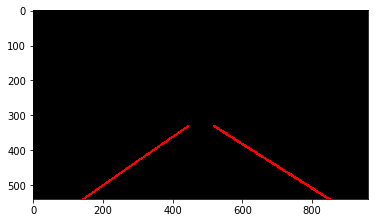

 11%|█▏        | 77/682 [00:59<08:04,  1.25it/s]

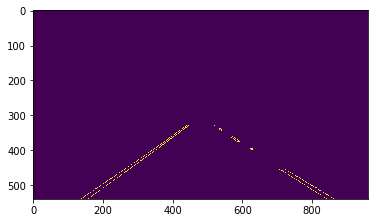

[[-0.7254902 ]
 [-0.66071429]
 [ 0.46666667]
 [-0.70338983]
 [ 0.5625    ]
 [ 0.5       ]
 [ 0.6       ]
 [ 0.61111111]
 [ 0.66666667]
 [-0.73076923]
 [ 0.5       ]
 [ 0.5       ]
 [-0.76470588]
 [-0.71794872]
 [ 0.64285714]
 [ 0.5       ]
 [-0.71794872]
 [ 0.70588235]
 [ 0.61904762]
 [ 0.58333333]
 [-0.76923077]
 [-0.66666667]
 [-0.76923077]
 [-0.7       ]
 [ 0.57142857]
 [-0.7       ]
 [ 0.66666667]
 [-0.6       ]
 [ 0.55555556]]
left_m = -0.70267673362  right_m = 0.61271228413
left_c = 641.953260317  right_c = 15.5225035745
left_y = 333.478174258  right_y = 364.768505529  min y = 333.478174258
left_y = 544.983871077  right_y = 542.455067926  max y = 544.983871077


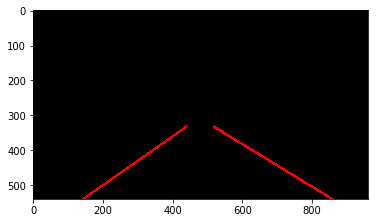

 11%|█▏        | 78/682 [00:59<08:09,  1.23it/s]

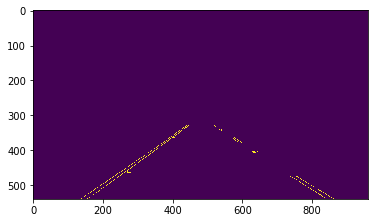

[[-0.69736842]
 [-0.64285714]
 [-0.8125    ]
 [ 0.58823529]
 [-0.78378378]
 [ 0.58      ]
 [-0.77272727]
 [-0.66666667]
 [ 0.61290323]
 [-0.61538462]
 [-0.78571429]
 [-0.86666667]
 [ 0.75      ]
 [-0.6       ]
 [-0.61904762]
 [-0.8       ]
 [ 0.7       ]
 [ 0.52631579]
 [-0.81818182]
 [ 0.5       ]
 [ 0.66666667]
 [-0.57142857]
 [-0.09090909]
 [-0.6       ]
 [-0.81818182]
 [-0.75      ]
 [-0.8       ]
 [-0.84615385]
 [ 0.59090909]
 [-0.71428571]
 [-0.66666667]
 [ 0.53333333]]
left_m = -0.689646135923  right_m = 0.609902482652
left_c = 637.889103789  right_c = 19.9039704429
left_y = 339.961973071  right_y = 373.647410381  min y = 339.961973071
left_y = 543.407583168  right_y = 545.030008006  max y = 545.030008006


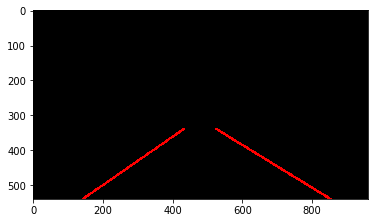

 12%|█▏        | 79/682 [01:00<08:19,  1.21it/s]

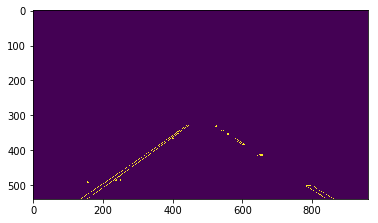

[[-0.77777778]
 [-0.73148148]
 [ 0.58536585]
 [-0.75675676]
 [-0.71875   ]
 [-0.6       ]
 [ 0.61818182]
 [-0.58333333]
 [-0.75757576]
 [-0.8       ]
 [-0.62962963]
 [-0.61538462]
 [ 0.65      ]
 [-0.83333333]
 [-0.81818182]
 [-0.58333333]
 [-0.6       ]
 [-0.81818182]
 [-0.76923077]
 [-0.6       ]
 [ 0.61538462]
 [-0.83333333]
 [-0.8       ]
 [-0.8       ]]
left_m = -0.70144003864  right_m = 0.623962875216
left_c = 641.839099044  right_c = 5.81148863075
left_y = 329.69828185  right_y = 367.085993381  min y = 329.69828185
left_y = 536.623093248  right_y = 543.043524192  max y = 543.043524192


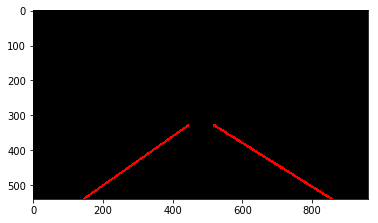

 12%|█▏        | 80/682 [01:01<08:18,  1.21it/s]

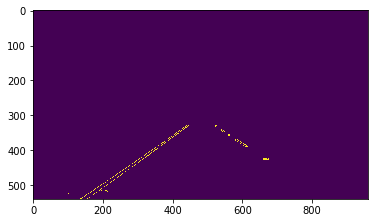

[[-0.58333333]
 [-0.72727273]
 [-0.53846154]
 [-0.70833333]
 [-0.7826087 ]
 [-0.75      ]
 [-0.75      ]
 [ 0.63636364]
 [-0.63636364]
 [-0.75862069]
 [-0.71052632]
 [-0.75      ]
 [-0.73333333]
 [-0.78571429]
 [ 0.75      ]
 [-0.72222222]
 [-0.6       ]
 [ 0.58333333]
 [-0.6       ]
 [-0.81818182]
 [ 0.6       ]
 [-0.8125    ]
 [-0.7       ]
 [ 0.        ]]
left_m = -0.683158131951  right_m = 0.520287621983
left_c = 635.288324102  right_c = 69.6779661017
left_y = 331.966113515  right_y = 371.444786852  min y = 331.966113515
left_y = 542.378818156  right_y = 389.654853621  max y = 542.378818156


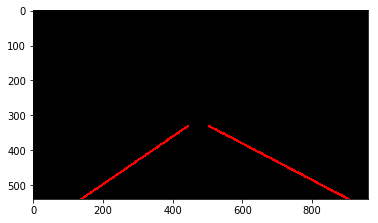

 12%|█▏        | 81/682 [01:02<07:13,  1.39it/s]

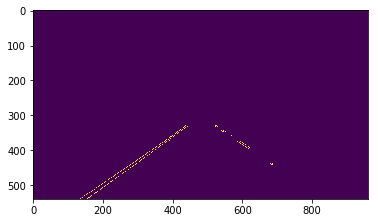

[[-0.67647059]
 [-0.66666667]
 [-0.74074074]
 [-0.7027027 ]
 [-0.72857143]
 [-0.68421053]
 [-0.75      ]
 [-0.76470588]
 [ 0.54545455]
 [-0.63636364]
 [-0.71428571]
 [ 0.66666667]
 [ 0.7       ]
 [-0.68421053]
 [-0.69230769]
 [-0.73333333]
 [-0.64285714]
 [-0.8       ]
 [-0.7       ]
 [-0.76923077]
 [ 0.61538462]
 [-0.75      ]
 [-0.8       ]
 [-0.76923077]
 [-0.63636364]]
left_m = -0.694040282357  right_m = 0.67679558011
left_c = 638.119238303  right_c = -24.0
left_y = 334.12959463  right_y = 342.82320442  min y = 334.12959463
left_y = 543.729759902  right_y = 393.582872928  max y = 543.729759902


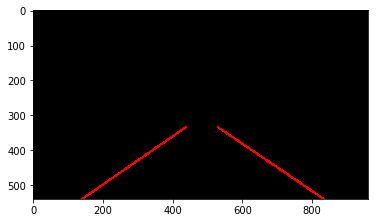

 12%|█▏        | 82/682 [01:02<06:30,  1.54it/s]

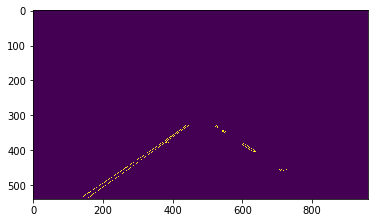

[[-0.78571429]
 [-0.62068966]
 [-0.72727273]
 [-0.6875    ]
 [-0.76      ]
 [ 0.60714286]
 [-0.81818182]
 [-0.76190476]
 [ 0.58333333]
 [ 0.66666667]
 [-0.68421053]
 [-0.81818182]
 [-0.7037037 ]
 [-0.75      ]
 [-0.76      ]
 [-0.8       ]
 [-0.8       ]
 [-0.1       ]
 [-0.66666667]]
left_m = -0.707559307582  right_m = 0.605020920502
left_c = 640.460968807  right_c = 18.2188284519
left_y = 326.304636241  right_y = 376.391213389  min y = 326.304636241
left_y = 544.940462284  right_y = 403.617154812  max y = 544.940462284


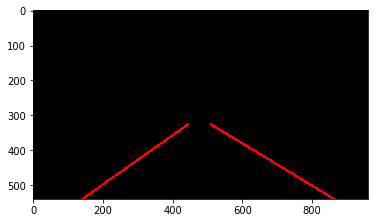

 12%|█▏        | 83/682 [01:03<06:32,  1.53it/s]

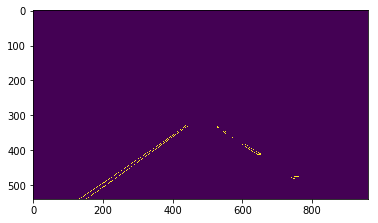

[[-0.6796875 ]
 [-0.71014493]
 [-0.6       ]
 [-0.70588235]
 [ 0.65714286]
 [-0.75      ]
 [-0.61538462]
 [-0.5       ]
 [ 0.        ]
 [-0.68181818]
 [-0.71186441]
 [-0.6       ]
 [-0.66666667]
 [-0.64285714]
 [ 0.5       ]
 [-0.70833333]
 [-0.67741935]
 [-0.6       ]
 [-0.72      ]
 [ 0.6       ]
 [ 0.53846154]
 [-0.69230769]
 [-0.75      ]
 [-0.72727273]
 [ 0.5       ]
 [-0.71428571]]
left_m = -0.69219783946  right_m = 0.643323698337
left_c = 638.68717231  right_c = -6.05612072525
left_y = 339.657705663  right_y = 344.555294868  min y = 339.657705663
left_y = 538.318485588  right_y = 409.5309884  max y = 538.318485588


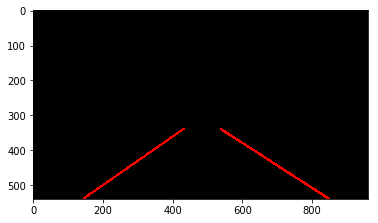

 12%|█▏        | 84/682 [01:03<06:00,  1.66it/s]

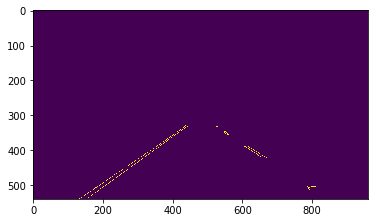

[[-0.71875   ]
 [-0.71698113]
 [-0.5       ]
 [-0.7254902 ]
 [-0.72881356]
 [ 0.6       ]
 [-0.73076923]
 [-0.69811321]
 [ 0.6       ]
 [-0.77777778]
 [ 0.63414634]
 [-0.73333333]
 [ 0.7       ]
 [ 0.54545455]
 [-0.82352941]
 [-0.64285714]
 [-0.57142857]
 [-0.66666667]
 [-0.75      ]
 [-0.78571429]
 [-0.625     ]
 [-0.8       ]
 [-0.7       ]]
left_m = -0.686948938345  right_m = 0.674168100542
left_c = 635.235181026  right_c = -23.639790302
left_y = 330.229852401  right_y = 385.580246727  min y = 330.229852401
left_y = 541.123176473  right_y = 510.301345328  max y = 541.123176473


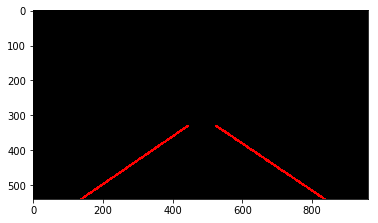

 12%|█▏        | 85/682 [01:04<06:07,  1.63it/s]

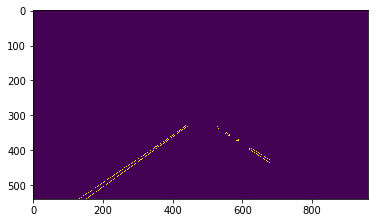

[[-0.67625899]
 [-0.8125    ]
 [-0.67592593]
 [ 0.57142857]
 [-0.72519084]
 [-0.7027027 ]
 [ 0.75      ]
 [-0.75      ]
 [-0.6969697 ]
 [-0.8       ]
 [-0.625     ]
 [ 0.63636364]
 [-0.625     ]
 [ 0.52941176]
 [-0.61111111]
 [ 0.63636364]
 [-0.7       ]
 [-0.63636364]]
left_m = -0.700682417949  right_m = 0.639617746319
left_c = 639.729336757  right_c = -2.71144775844
left_y = 334.231802531  right_y = 350.997165956  min y = 334.231802531
left_y = 532.524926811  right_y = 426.472060021  max y = 532.524926811


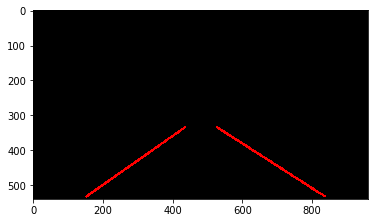

 13%|█▎        | 86/682 [01:04<06:16,  1.58it/s]

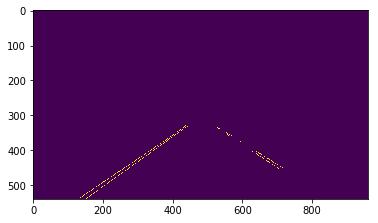

[[-0.6       ]
 [-0.65      ]
 [ 0.6       ]
 [-0.67647059]
 [-0.64285714]
 [-0.72727273]
 [-0.66666667]
 [-0.6875    ]
 [ 0.65625   ]
 [ 0.45454545]
 [-0.6875    ]
 [ 0.5       ]
 [ 0.6       ]
 [-0.7       ]
 [ 0.63636364]
 [-0.76190476]
 [-0.6875    ]
 [-0.69230769]
 [-0.78571429]
 [ 0.54545455]
 [-0.66666667]]
left_m = -0.66852162828  right_m = 0.685143214994
left_c = 629.268674234  right_c = -31.2568028986
left_y = 332.445071277  right_y = 348.312538208  min y = 332.445071277
left_y = 541.692340929  right_y = 443.547445092  max y = 541.692340929


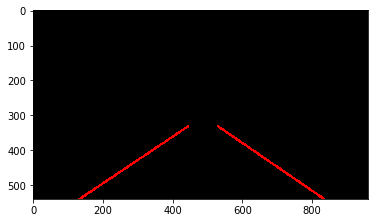

 13%|█▎        | 87/682 [01:05<05:59,  1.66it/s]

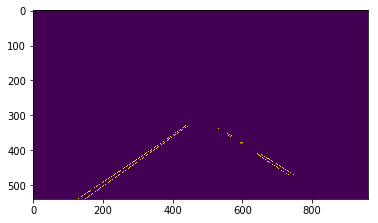

[[-0.70588235]
 [-0.83333333]
 [-0.8       ]
 [-0.75      ]
 [ 0.60714286]
 [-0.65      ]
 [-0.67741935]
 [-0.70967742]
 [ 0.6       ]
 [ 0.6       ]
 [-0.75      ]
 [ 0.7       ]
 [ 0.65217391]
 [ 0.64285714]
 [-0.71111111]
 [ 0.69230769]
 [-0.83333333]
 [-0.76470588]
 [-0.81818182]
 [-0.81818182]
 [-0.8       ]
 [-0.78571429]
 [-0.6       ]
 [-0.8       ]
 [-0.6       ]
 [ 0.6       ]
 [-0.72727273]
 [-0.8       ]
 [ 0.        ]]
left_m = -0.684676412853  right_m = 0.631095548874
left_c = 632.063623179  right_c = 5.21249175038
left_y = 328.751972285  right_y = 356.732712473  min y = 328.751972285
left_y = 543.055689508  right_y = 479.165248955  max y = 543.055689508


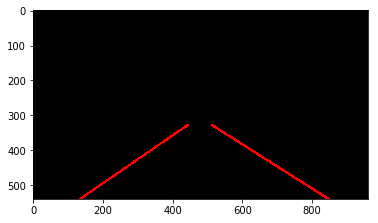

 13%|█▎        | 88/682 [01:06<05:42,  1.73it/s]

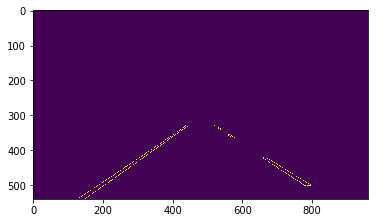

[[-0.65384615]
 [-0.72093023]
 [-0.81818182]
 [-0.57142857]
 [-0.75      ]
 [-0.83333333]
 [-0.74193548]
 [ 0.66666667]
 [ 0.58823529]
 [-0.625     ]
 [ 0.53333333]
 [-0.72340426]
 [ 0.53846154]
 [-0.75      ]
 [-0.67741935]
 [ 0.75      ]
 [ 0.5       ]
 [-0.54545455]
 [ 0.63636364]
 [-0.76190476]
 [ 0.        ]
 [-0.83333333]
 [-0.64705882]
 [ 0.58333333]
 [-0.75      ]
 [ 0.5       ]]
left_m = -0.690020654419  right_m = 0.612604562158
left_c = 635.523324546  right_c = 14.3104682999
left_y = 329.154153984  right_y = 356.143813984  min y = 329.154153984
left_y = 546.510660126  right_y = 502.55630434  max y = 546.510660126


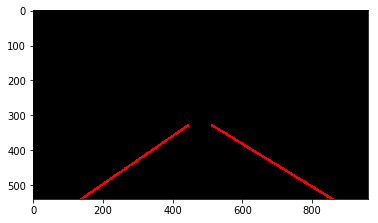

 13%|█▎        | 89/682 [01:06<06:37,  1.49it/s]

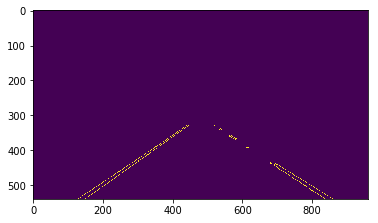

[[-0.67605634]
 [-0.66666667]
 [ 0.62068966]
 [-0.77777778]
 [-0.70731707]
 [-0.7826087 ]
 [-0.8       ]
 [-0.70731707]
 [-0.64285714]
 [ 0.7       ]
 [-0.8       ]
 [-0.76      ]
 [ 0.83333333]
 [-0.8       ]
 [ 0.57142857]
 [ 0.57894737]
 [-0.8125    ]
 [ 0.5       ]
 [ 0.57894737]
 [ 0.61538462]
 [ 0.71428571]
 [-0.69230769]
 [-0.6       ]
 [ 0.73684211]
 [-0.83333333]
 [-0.75      ]
 [ 0.66666667]
 [ 0.5       ]
 [-0.72727273]
 [-0.6       ]
 [ 0.66666667]]
left_m = -0.692421362314  right_m = 0.64636507549
left_c = 637.180475979  right_c = -5.47465832616
left_y = 334.592340648  right_y = 359.721609326  min y = 334.592340648
left_y = 547.165698879  right_y = 534.886544783  max y = 547.165698879


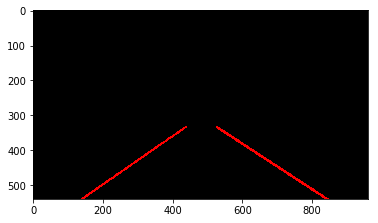

 13%|█▎        | 90/682 [01:07<07:41,  1.28it/s]

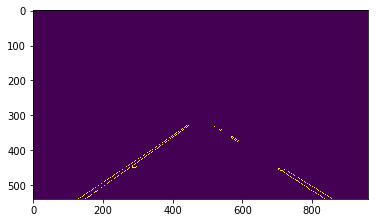

[[-0.69879518]
 [ 0.62745098]
 [-0.66666667]
 [ 0.6       ]
 [ 0.61904762]
 [-0.67164179]
 [-0.69230769]
 [-0.68965517]
 [ 0.5       ]
 [-0.63636364]
 [ 0.63157895]
 [-0.625     ]
 [ 0.57142857]
 [ 0.5       ]
 [-0.7       ]
 [-0.67105263]
 [ 0.55      ]
 [ 0.54545455]
 [-0.83333333]
 [ 0.62790698]
 [ 0.5       ]
 [-0.63636364]
 [ 0.57894737]
 [-0.70588235]
 [-0.61538462]
 [ 0.58333333]]
left_m = -0.683681248412  right_m = 0.620728870719
left_c = 635.498091095  right_c = 9.87160451322
left_y = 334.678341794  right_y = 361.20414534  min y = 334.678341794
left_y = 545.935847553  right_y = 541.83624672  max y = 545.935847553


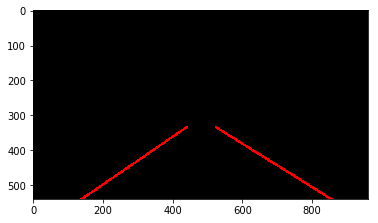

 13%|█▎        | 91/682 [01:08<07:38,  1.29it/s]

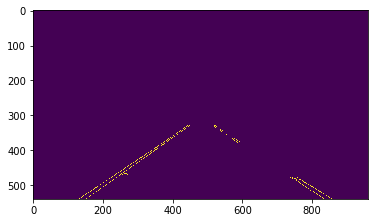

[[-0.8       ]
 [ 0.58333333]
 [-0.75      ]
 [-0.75      ]
 [-0.66      ]
 [-0.75      ]
 [ 0.46153846]
 [-0.68571429]
 [-0.77777778]
 [-0.81818182]
 [ 0.45454545]
 [ 0.60465116]
 [-0.7       ]
 [-0.64285714]
 [-0.75      ]
 [-0.8       ]
 [ 0.57142857]
 [-0.58333333]
 [ 0.70588235]
 [ 0.76923077]
 [-0.69230769]
 [-0.76923077]
 [ 0.        ]
 [-0.61538462]
 [ 0.66666667]
 [ 0.73333333]
 [-0.8       ]
 [-0.61538462]
 [ 0.5       ]
 [-0.69230769]
 [-0.71428571]
 [ 0.6       ]]
left_m = -0.676756159719  right_m = 0.6452863506
left_c = 633.537398681  right_c = -3.77370062503
left_y = 330.350639126  right_y = 366.620664619  min y = 330.350639126
left_y = 544.205585598  right_y = 531.168684022  max y = 544.205585598


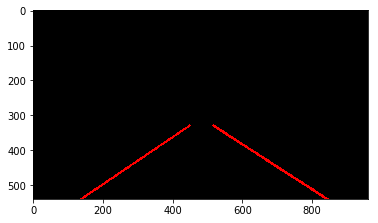

 13%|█▎        | 92/682 [01:09<07:39,  1.28it/s]

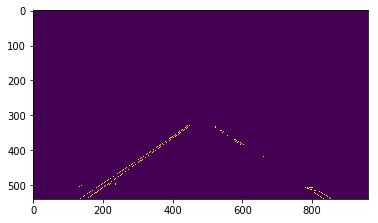

[[-0.75      ]
 [-0.76470588]
 [-0.61538462]
 [-0.7027027 ]
 [-0.8       ]
 [-0.6       ]
 [-0.8       ]
 [-0.5       ]
 [-0.78571429]
 [-0.57142857]
 [-0.81818182]
 [ 0.64516129]
 [-0.81818182]
 [-0.81818182]
 [ 0.        ]
 [-0.70454545]
 [-0.58333333]
 [-0.625     ]
 [ 0.63636364]
 [-0.64705882]
 [-0.76470588]
 [ 0.60606061]
 [-0.5       ]
 [ 0.        ]
 [ 0.57142857]
 [ 0.63636364]
 [ 0.54545455]
 [-0.69230769]]
left_m = -0.67448473956  right_m = 0.625271955486
left_c = 633.359174114  right_c = 9.19253223856
left_y = 334.56243449  right_y = 373.726082287  min y = 334.56243449
left_y = 542.978219013  right_y = 542.549510268  max y = 542.978219013


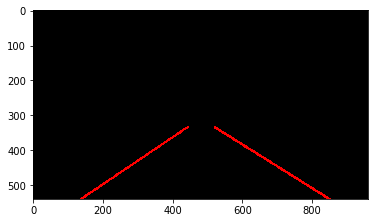

 14%|█▎        | 93/682 [01:10<07:57,  1.23it/s]

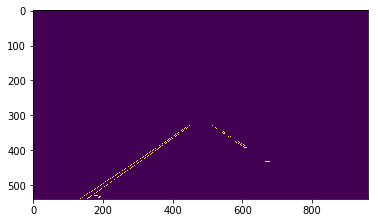

[[-0.70056497]
 [-0.75      ]
 [-0.66666667]
 [-0.625     ]
 [-0.70238095]
 [-0.70212766]
 [-0.68571429]
 [-0.76190476]
 [-0.625     ]
 [ 0.64285714]
 [-0.63636364]
 [-0.7       ]
 [-0.7       ]
 [ 0.57894737]
 [-0.58333333]
 [-0.6       ]
 [-0.63636364]
 [ 0.        ]
 [-0.92307692]
 [-0.71428571]
 [ 0.61538462]]
left_m = -0.667719497399  right_m = 0.530952380952
left_c = 631.034559293  right_c = 66.8738095238
left_y = 334.567102448  right_y = 374.826190476  min y = 334.567102448
left_y = 533.547512673  right_y = 387.569047619  max y = 533.547512673


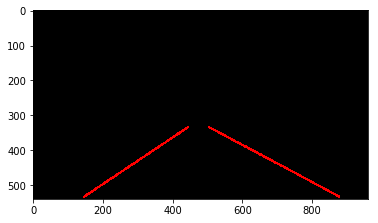

 14%|█▍        | 94/682 [01:11<08:14,  1.19it/s]

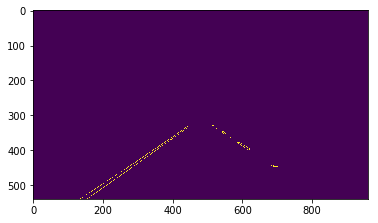

[[-0.77777778]
 [-0.67307692]
 [-0.6754386 ]
 [-0.75      ]
 [-0.75      ]
 [-0.77777778]
 [-0.61538462]
 [-0.64285714]
 [-0.8       ]
 [ 0.6       ]
 [-0.81818182]
 [-0.61904762]
 [ 0.75      ]
 [-0.78571429]
 [-0.8       ]
 [-0.58333333]
 [-0.7826087 ]
 [ 0.58333333]
 [-0.6       ]
 [-0.78947368]
 [-0.5       ]
 [-0.8       ]
 [-0.63636364]
 [-0.83333333]
 [-0.8       ]]
left_m = -0.705429707319  right_m = 0.688888888889
left_c = 646.244881017  right_c = -28.3777777778
left_y = 328.801512724  right_y = 379.444444444  min y = 328.801512724
left_y = 550.306440822  right_y = 393.222222222  max y = 550.306440822


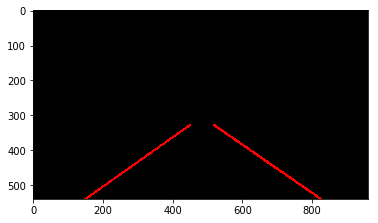

 14%|█▍        | 95/682 [01:12<08:14,  1.19it/s]

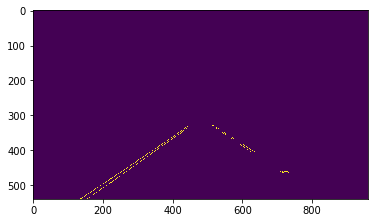

[[-0.57142857]
 [-0.83333333]
 [-0.69230769]
 [-0.58333333]
 [-0.6835443 ]
 [-0.64      ]
 [-0.58823529]
 [-0.66666667]
 [-0.69565217]
 [-0.6       ]
 [-0.66666667]
 [ 0.53846154]
 [-0.63157895]
 [-0.58823529]
 [-0.54545455]
 [-0.61904762]
 [-0.57142857]
 [ 0.58333333]
 [ 0.59090909]
 [-0.63636364]
 [-0.6       ]
 [-0.64285714]
 [-0.57142857]]
left_m = -0.674126902412  right_m = 0.602869440459
left_c = 634.971039255  right_c = 25.5024390244
left_y = 339.029329097  right_y = 388.429842181  min y = 339.029329097
left_y = 543.289780527  right_y = 404.104447633  max y = 543.289780527


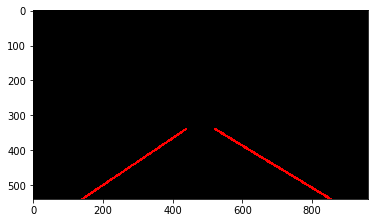

 14%|█▍        | 96/682 [01:12<07:16,  1.34it/s]

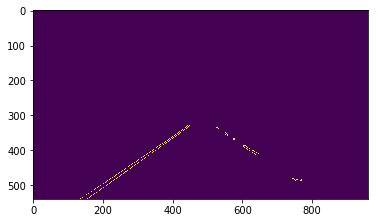

[[-0.73333333]
 [-0.75      ]
 [-0.8       ]
 [-0.5625    ]
 [-0.6875    ]
 [-0.66666667]
 [-0.8       ]
 [-0.66666667]
 [-0.76923077]
 [-0.6       ]
 [-0.61538462]
 [-0.61538462]
 [-0.75      ]
 [-0.77272727]
 [-0.66666667]
 [ 0.66666667]
 [-0.59090909]
 [-0.58823529]
 [-0.76923077]
 [-0.6       ]
 [ 0.63636364]
 [-0.7       ]
 [-0.7       ]
 [-0.58333333]
 [-0.8125    ]
 [ 0.53846154]
 [-0.72222222]
 [ 0.63157895]
 [ 0.63636364]
 [ 0.54545455]]
left_m = -0.682600799748  right_m = 0.675089395905
left_c = 637.062264076  right_c = -20.1339514572
left_y = 331.257105789  right_y = 349.815037499  min y = 331.257105789
left_y = 544.22855531  right_y = 415.298708902  max y = 544.22855531


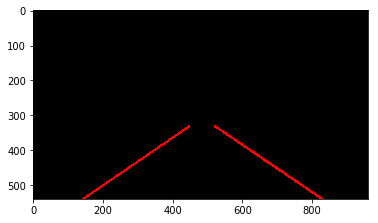

 14%|█▍        | 97/682 [01:13<06:33,  1.49it/s]

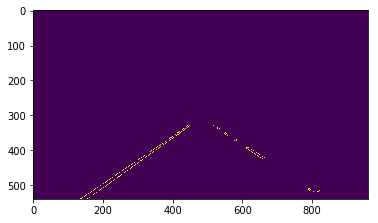

[[-0.69642857]
 [-0.7826087 ]
 [-0.69230769]
 [-0.625     ]
 [-0.625     ]
 [-0.61904762]
 [-0.64285714]
 [ 0.66666667]
 [-0.75      ]
 [-0.69230769]
 [-0.8125    ]
 [ 0.7       ]
 [-0.83333333]
 [-0.72      ]
 [ 0.63636364]
 [-0.57142857]
 [-0.83333333]
 [-0.81818182]
 [-0.8       ]
 [-0.58333333]
 [ 0.6097561 ]
 [-0.6       ]
 [-0.61538462]
 [ 0.58333333]
 [-0.63636364]
 [ 0.63636364]]
left_m = -0.689216025433  right_m = 0.672560946482
left_c = 639.08135162  right_c = -19.1508972787
left_y = 342.718460684  right_y = 349.412501393  min y = 342.718460684
left_y = 544.658756136  right_y = 422.72164456  max y = 544.658756136


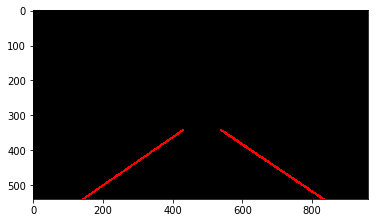

 14%|█▍        | 98/682 [01:13<05:45,  1.69it/s]

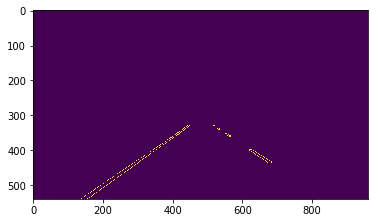

[[-0.72727273]
 [ 0.64      ]
 [-0.83333333]
 [-0.76923077]
 [-0.73214286]
 [-0.69444444]
 [-0.6       ]
 [ 0.63636364]
 [ 0.6875    ]
 [-0.61538462]
 [-0.63333333]
 [-0.6       ]
 [-0.6       ]
 [-0.83333333]
 [-0.8       ]
 [ 0.4       ]
 [-0.70212766]
 [-0.81818182]
 [-0.6875    ]
 [-0.61538462]
 [ 0.57142857]
 [-0.83333333]
 [-0.61538462]
 [-0.72727273]]
left_m = -0.687307496547  right_m = 0.713552132172
left_c = 638.366447551  right_c = -45.7711542755
left_y = 334.576534077  right_y = 396.631167671  min y = 334.576534077
left_y = 542.143398034  right_y = 435.162982809  max y = 542.143398034


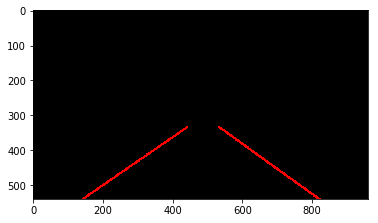

 15%|█▍        | 99/682 [01:14<05:26,  1.79it/s]

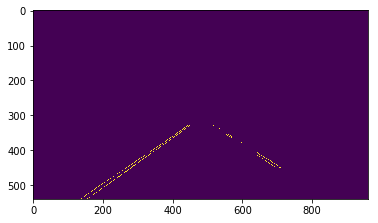

[[-0.8       ]
 [-0.8       ]
 [-0.72131148]
 [-0.67857143]
 [-0.71428571]
 [-0.58333333]
 [-0.69444444]
 [-0.64285714]
 [-0.71428571]
 [ 0.69230769]
 [ 0.64285714]
 [-0.8       ]
 [-0.8125    ]
 [ 0.57142857]
 [-0.8       ]
 [-0.8       ]
 [ 0.6       ]
 [-0.8       ]
 [-0.75      ]
 [-0.78947368]
 [ 0.65789474]
 [ 0.6       ]
 [-0.69230769]
 [-0.81818182]
 [-0.75      ]
 [ 0.7       ]
 [ 0.66666667]
 [ 0.64705882]]
left_m = -0.687070940506  right_m = 0.653883278883
left_c = 637.346291195  right_c = -8.81927531928
left_y = 333.660935492  right_y = 357.355360855  min y = 333.660935492
left_y = 542.530501405  right_y = 450.860669736  max y = 542.530501405


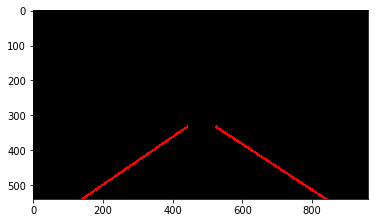

 15%|█▍        | 100/682 [01:14<05:04,  1.91it/s]

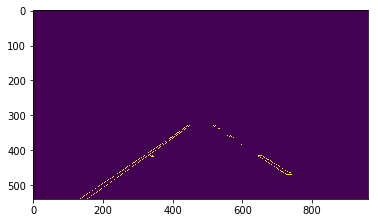

[[-0.83333333]
 [-0.75      ]
 [-0.65671642]
 [-0.83333333]
 [-0.72131148]
 [-0.69565217]
 [-0.90909091]
 [ 0.64285714]
 [-0.58333333]
 [-0.7       ]
 [-0.83333333]
 [-0.65      ]
 [-0.6       ]
 [ 0.66666667]
 [ 0.07692308]
 [ 0.5       ]
 [-0.71428571]
 [-0.61538462]
 [ 0.625     ]
 [-0.7       ]
 [-0.81818182]
 [ 0.7       ]
 [ 0.66666667]]
left_m = -0.687567353301  right_m = 0.520349787512
left_c = 638.616840699  right_c = 80.1078783916
left_y = 346.400715546  right_y = 415.733491337  min y = 346.400715546
left_y = 542.357411237  right_y = 451.637626675  max y = 542.357411237


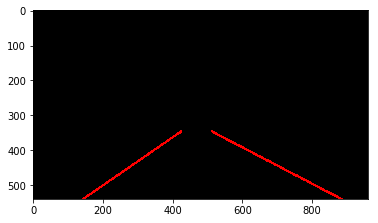

 15%|█▍        | 101/682 [01:15<05:05,  1.90it/s]

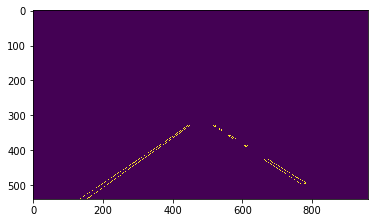

[[-0.75      ]
 [ 0.61111111]
 [-0.75      ]
 [ 0.5625    ]
 [-0.75      ]
 [-0.70440252]
 [-0.69565217]
 [-0.57142857]
 [-0.8       ]
 [ 0.61016949]
 [-0.76923077]
 [-0.71428571]
 [-0.7037037 ]
 [ 0.08333333]
 [-0.8       ]
 [-0.6       ]
 [-0.8125    ]
 [-0.8       ]
 [ 0.625     ]
 [ 0.6875    ]
 [-0.71428571]
 [ 0.75      ]
 [-0.6       ]
 [-0.69230769]
 [ 0.57142857]
 [-0.75      ]]
left_m = -0.685374739063  right_m = 0.690049386555
left_c = 636.61686019  right_c = -35.4087311283
left_y = 329.56897709  right_y = 428.994506023  min y = 329.56897709
left_y = 542.720520939  right_y = 490.408901427  max y = 542.720520939


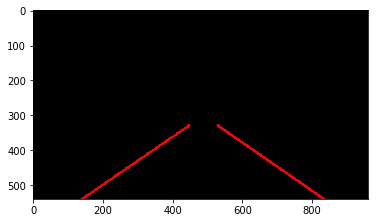

 15%|█▍        | 102/682 [01:15<04:44,  2.04it/s]

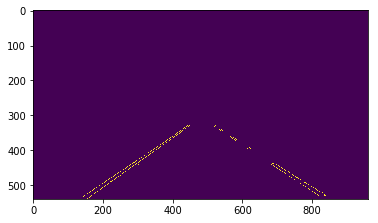

[[-0.72941176]
 [-0.63157895]
 [-0.58333333]
 [-0.71212121]
 [-0.6       ]
 [ 0.58823529]
 [ 0.62      ]
 [ 0.61111111]
 [-0.67368421]
 [-0.76470588]
 [ 0.6       ]
 [-0.69230769]
 [-0.75      ]
 [-0.6       ]
 [-0.81818182]
 [ 0.75      ]
 [ 0.625     ]
 [ 0.6       ]
 [ 0.61111111]
 [ 0.65217391]
 [-0.83333333]
 [-0.61111111]
 [-0.66666667]
 [-0.78947368]
 [ 0.63636364]
 [ 0.6       ]
 [ 0.36363636]
 [-0.66666667]
 [ 0.58333333]
 [ 0.        ]
 [ 0.55555556]
 [ 0.54545455]
 [-0.54545455]
 [ 0.61538462]]
left_m = -0.670142372374  right_m = 0.642387336406
left_c = 632.153971541  right_c = -2.10696179042
left_y = 336.621185324  right_y = 360.841883279  min y = 336.621185324
left_y = 540.344466526  right_y = 527.862590745  max y = 540.344466526


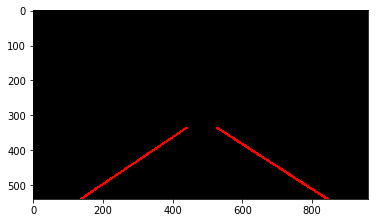

 15%|█▌        | 103/682 [01:15<04:36,  2.10it/s]

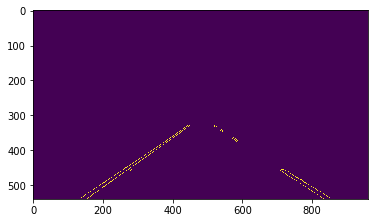

[[-0.72727273]
 [-0.70238095]
 [-0.75      ]
 [-0.76923077]
 [ 0.64705882]
 [ 0.57142857]
 [-0.75      ]
 [ 0.5625    ]
 [-0.70967742]
 [ 0.68965517]
 [-0.72222222]
 [-0.7       ]
 [-0.75      ]
 [-0.73333333]
 [ 0.69230769]
 [ 0.53333333]
 [-0.71875   ]
 [-0.8       ]
 [-0.70833333]
 [-0.76923077]
 [ 0.7       ]
 [ 0.54545455]
 [ 0.56521739]
 [-0.76923077]
 [ 0.61111111]
 [-0.70833333]
 [-0.64285714]
 [ 0.58333333]
 [-0.8       ]
 [-0.8       ]]
left_m = -0.680088713131  right_m = 0.63619414647
left_c = 632.685487924  right_c = 2.50076221165
left_y = 332.766365433  right_y = 366.403813992  min y = 332.766365433
left_y = 541.553600364  right_y = 531.814292074  max y = 541.553600364


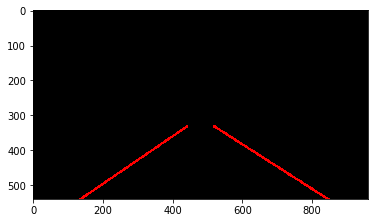

 15%|█▌        | 104/682 [01:16<04:23,  2.19it/s]

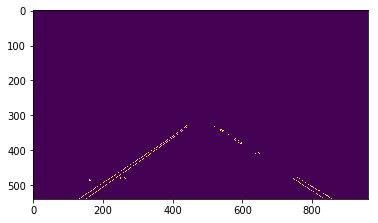

[[-0.63157895]
 [-0.69955157]
 [-0.73333333]
 [ 0.63636364]
 [ 0.6       ]
 [-0.68965517]
 [ 0.61702128]
 [ 0.5       ]
 [-0.63333333]
 [-0.61111111]
 [ 0.07142857]
 [ 0.64705882]
 [-0.71428571]
 [ 0.53333333]
 [-0.81818182]
 [-0.69565217]
 [-0.66666667]
 [-0.73333333]
 [ 0.5       ]
 [ 0.5625    ]
 [-0.58333333]
 [-0.76923077]
 [ 0.72727273]
 [-0.7       ]
 [-0.6       ]
 [-0.58333333]
 [ 0.61538462]
 [-0.63157895]
 [ 0.6       ]]
left_m = -0.665380390902  right_m = 0.621396512559
left_c = 627.70186628  right_c = 11.1802374708
left_y = 339.59215702  right_y = 367.86183568  min y = 339.59215702
left_y = 539.871654681  right_y = 543.095652222  max y = 543.095652222


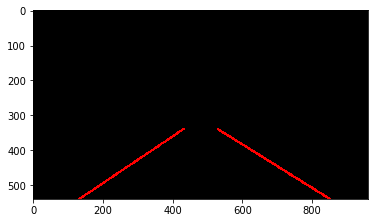

 15%|█▌        | 105/682 [01:16<04:13,  2.28it/s]

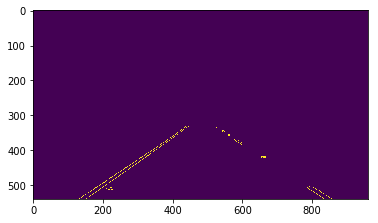

[[-0.75      ]
 [-0.81818182]
 [-0.8       ]
 [-0.6       ]
 [-0.70588235]
 [-0.63043478]
 [-0.70588235]
 [ 0.64285714]
 [-0.74509804]
 [-0.57142857]
 [-0.80769231]
 [ 0.66666667]
 [ 0.625     ]
 [-0.77777778]
 [-0.69230769]
 [-0.78571429]
 [-0.81818182]
 [-0.72222222]
 [-0.6       ]
 [ 0.61538462]
 [-0.75      ]
 [ 0.58333333]
 [ 0.        ]
 [-0.625     ]
 [-0.8       ]
 [ 0.60869565]
 [-0.66666667]]
left_m = -0.690931214589  right_m = 0.632617616987
left_c = 637.924851458  right_c = 3.76797344426
left_y = 329.078598537  right_y = 368.788338446  min y = 329.078598537
left_y = 546.030999918  right_y = 544.656035968  max y = 546.030999918


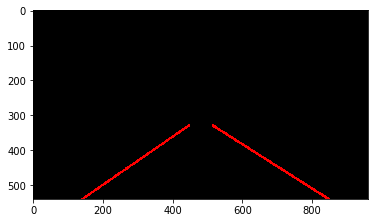

 16%|█▌        | 106/682 [01:17<04:07,  2.33it/s]

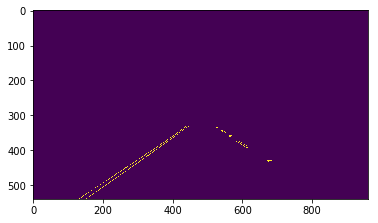

[[-0.67010309]
 [-0.70886076]
 [-0.66666667]
 [-0.61111111]
 [ 0.        ]
 [-0.75      ]
 [-0.72307692]
 [-0.81818182]
 [-0.66666667]
 [-0.76923077]
 [-0.72222222]
 [-0.63636364]
 [-0.81818182]
 [ 0.63636364]
 [ 0.57894737]
 [-0.64      ]
 [-0.73333333]
 [-0.1       ]
 [-0.72      ]
 [ 0.54545455]
 [-0.61538462]
 [-0.76190476]
 [-0.75      ]
 [-0.76923077]
 [-0.83333333]
 [-0.54545455]
 [ 0.6       ]
 [ 0.54545455]]
left_m = -0.690663505466  right_m = 0.542398945518
left_c = 638.056035407  right_c = 56.6860720562
left_y = 336.236083518  right_y = 372.904657293  min y = 336.236083518
left_y = 546.19778918  right_y = 389.176625659  max y = 546.19778918


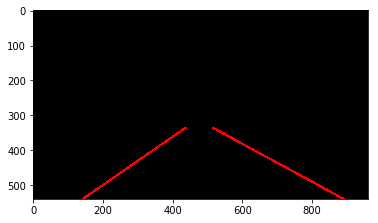

 16%|█▌        | 107/682 [01:17<04:14,  2.26it/s]

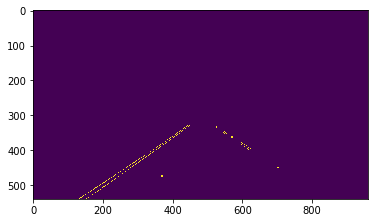

[[-0.6969697 ]
 [-0.6       ]
 [-0.65346535]
 [-0.71428571]
 [-0.57894737]
 [-0.64285714]
 [-0.72093023]
 [-0.64285714]
 [-0.61538462]
 [ 0.73684211]
 [-0.81818182]
 [-0.64285714]
 [-0.90909091]
 [ 0.6       ]
 [-0.58823529]
 [-0.64705882]
 [-0.6875    ]
 [-0.5625    ]
 [-0.6       ]
 [-0.8       ]
 [ 0.58333333]
 [-0.66666667]
 [-0.7       ]]
left_m = -0.6772556408  right_m = 0.615255658005
left_c = 635.415369497  right_c = 13.5528080469
left_y = 360.449579333  right_y = 379.62992456  min y = 360.449579333
left_y = 545.340369271  right_y = 396.857082984  max y = 545.340369271


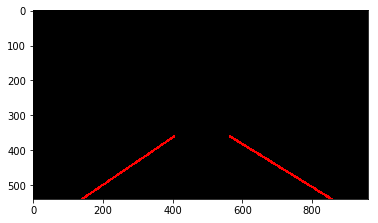

 16%|█▌        | 108/682 [01:18<04:12,  2.28it/s]

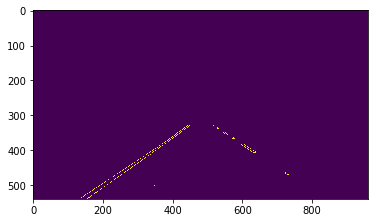

[[-0.65217391]
 [-0.70149254]
 [-0.75      ]
 [-0.69230769]
 [-0.66666667]
 [-0.58333333]
 [ 0.        ]
 [-0.6       ]
 [-0.69230769]
 [-0.80952381]
 [-0.8       ]
 [-0.625     ]
 [-0.78125   ]
 [-0.76190476]
 [ 0.75      ]
 [-0.8       ]
 [-0.8       ]
 [ 0.55      ]
 [-0.90909091]
 [-0.63636364]
 [-0.58333333]
 [-0.6       ]
 [ 0.69230769]
 [-0.71428571]
 [ 0.53846154]]
left_m = -0.685859888496  right_m = 0.63240891789
left_c = 638.786239984  right_c = 4.60902664491
left_y = 349.353367039  right_y = 382.157150625  min y = 349.353367039
left_y = 538.650696264  right_y = 403.026644916  max y = 538.650696264


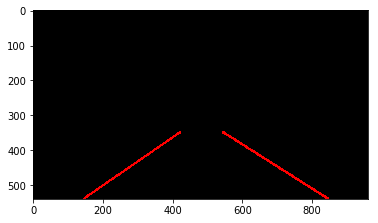

 16%|█▌        | 109/682 [01:18<04:07,  2.31it/s]

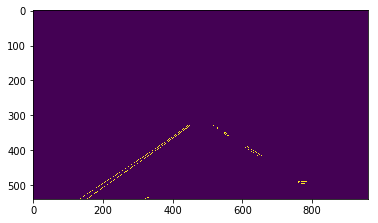

[[-0.78571429]
 [-0.59090909]
 [-0.72222222]
 [-0.77777778]
 [ 0.2       ]
 [-0.76666667]
 [-0.61538462]
 [-0.72340426]
 [-0.57142857]
 [-0.62790698]
 [-0.90909091]
 [ 0.66666667]
 [-0.68888889]
 [ 0.6       ]
 [-0.81818182]
 [-0.78571429]
 [-0.58823529]
 [-0.61111111]
 [-0.8       ]
 [-0.69230769]
 [-0.75      ]
 [-0.5625    ]
 [-0.61538462]
 [ 0.66666667]
 [ 0.63636364]
 [-0.75      ]]
left_m = -0.679657388776  right_m = 0.619944641944
left_c = 634.766895428  right_c = 11.7613306922
left_y = 334.358329589  right_y = 351.490994477  min y = 334.358329589
left_y = 543.692805332  right_y = 412.245569388  max y = 543.692805332


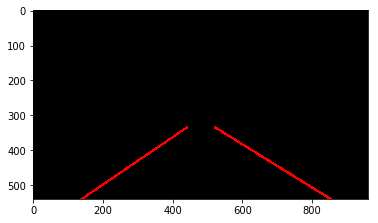

 16%|█▌        | 110/682 [01:18<04:04,  2.34it/s]

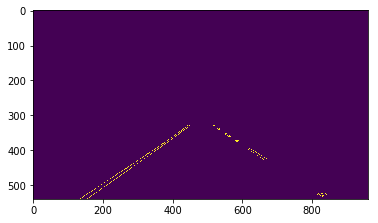

[[-0.68888889]
 [ 0.54545455]
 [ 0.65625   ]
 [-0.75      ]
 [-0.66037736]
 [-0.6875    ]
 [-0.85714286]
 [-0.7254902 ]
 [-0.6       ]
 [ 0.65384615]
 [-0.64285714]
 [-0.6969697 ]
 [-0.6       ]
 [-0.72727273]
 [-0.75      ]
 [-0.78571429]
 [-0.75      ]
 [-0.78571429]
 [-0.70967742]
 [ 0.66666667]
 [ 0.63636364]
 [-0.76923077]
 [ 0.1       ]
 [ 0.6875    ]
 [ 0.65      ]
 [-0.66666667]
 [-0.8       ]]
left_m = -0.686800886333  right_m = 0.640133175461
left_c = 638.630398987  right_c = 0.280307382094
left_y = 332.317203682  right_y = 352.993687061  min y = 332.317203682
left_y = 545.912279332  right_y = 427.88926859  max y = 545.912279332


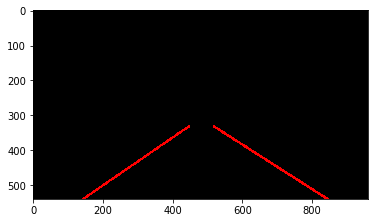

 16%|█▋        | 111/682 [01:19<04:00,  2.37it/s]

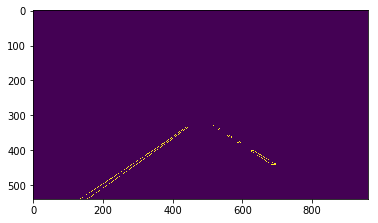

[[-0.57142857]
 [-0.80952381]
 [-0.72463768]
 [ 0.52380952]
 [ 0.68181818]
 [-0.65384615]
 [-0.67692308]
 [ 0.58139535]
 [-0.73076923]
 [-0.76086957]
 [ 0.70833333]
 [ 0.71428571]
 [ 0.58333333]
 [-0.57142857]
 [-0.66666667]
 [-0.57142857]
 [-0.73333333]
 [-0.77777778]
 [-0.5       ]
 [-0.61538462]
 [-0.8       ]
 [-0.6       ]
 [-0.63636364]]
left_m = -0.669485585182  right_m = 0.649657484633
left_c = 633.425598406  right_c = -6.28390074298
left_y = 332.826570659  right_y = 355.575318198  min y = 332.826570659
left_y = 537.689159725  right_y = 445.228051077  max y = 537.689159725


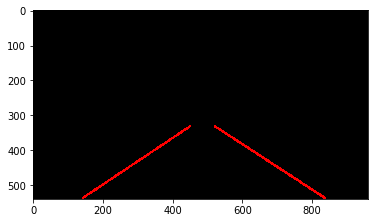

 16%|█▋        | 112/682 [01:19<04:11,  2.27it/s]

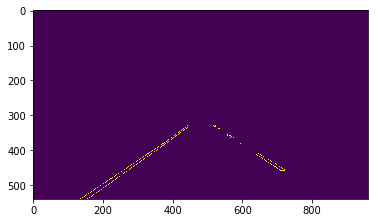

[[-0.67741935]
 [-0.6751269 ]
 [-0.75      ]
 [-0.67924528]
 [-0.66666667]
 [-0.57142857]
 [-0.57142857]
 [-0.66666667]
 [ 0.57142857]
 [-0.5       ]
 [-0.73333333]
 [ 0.63636364]
 [-0.76190476]
 [-0.58823529]
 [-0.63636364]
 [ 0.47058824]
 [-0.8       ]
 [-0.9       ]
 [ 0.53846154]
 [-0.83333333]
 [ 0.625     ]
 [ 0.54545455]
 [ 0.58333333]
 [-0.7       ]]
left_m = -0.674676538029  right_m = 0.684091070289
left_c = 635.278355276  right_c = -28.8349528335
left_y = 331.673913162  right_y = 356.308319739  min y = 331.673913162
left_y = 543.522346104  right_y = 456.185616001  max y = 543.522346104


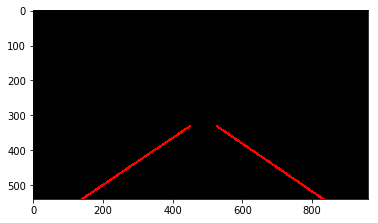

 17%|█▋        | 113/682 [01:20<04:07,  2.29it/s]

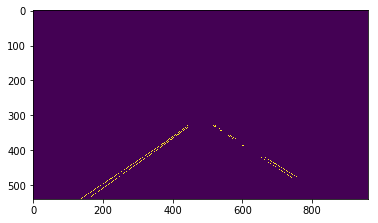

[[-0.68085106]
 [-0.70547945]
 [-0.67515924]
 [ 0.46153846]
 [ 0.53846154]
 [-0.72527473]
 [ 0.66      ]
 [-0.68571429]
 [ 0.66666667]
 [-0.69230769]
 [-0.70454545]
 [-0.66666667]
 [ 0.5       ]
 [-0.72727273]
 [-0.63636364]
 [ 0.55555556]
 [ 0.5625    ]
 [-0.66666667]
 [ 0.57142857]
 [ 0.6       ]]
left_m = -0.696897940802  right_m = 0.633157168149
left_c = 642.071987026  right_c = 1.63368200856
left_y = 331.255505428  right_y = 357.468010508  min y = 331.255505428
left_y = 546.596969136  right_y = 481.566815465  max y = 546.596969136


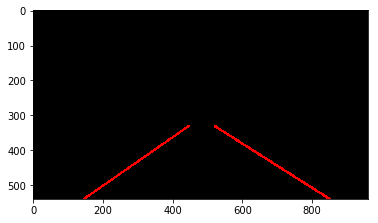

 17%|█▋        | 114/682 [01:20<04:01,  2.35it/s]

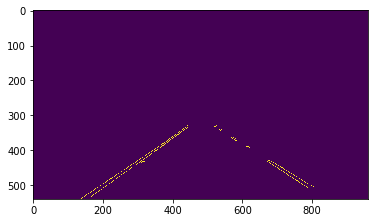

[[-0.64285714]
 [-0.675     ]
 [ 0.58823529]
 [-0.68627451]
 [ 0.58333333]
 [ 0.66666667]
 [-0.8       ]
 [ 0.5       ]
 [-0.76666667]
 [-0.68571429]
 [-0.7       ]
 [ 0.52380952]
 [-0.72727273]
 [-0.83333333]
 [-0.63636364]
 [ 0.72727273]
 [-0.66666667]
 [ 0.63333333]
 [-0.81818182]
 [ 0.6       ]
 [-0.65517241]
 [ 0.625     ]
 [-0.8125    ]
 [ 0.7       ]
 [ 0.55555556]
 [ 0.72727273]
 [ 0.        ]
 [-0.66666667]
 [-0.6       ]]
left_m = -0.697348422414  right_m = 0.623097946986
left_c = 643.80393456  right_c = 9.06296902801
left_y = 332.089189741  right_y = 360.490211128  min y = 332.089189741
left_y = 548.267200689  right_y = 506.91822867  max y = 548.267200689


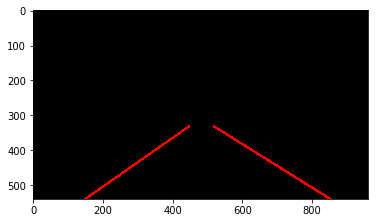

 17%|█▋        | 115/682 [01:21<04:04,  2.32it/s]

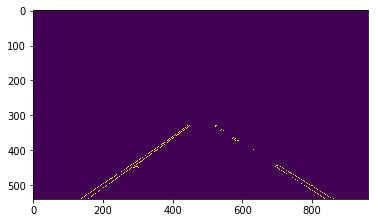

[[ 0.5       ]
 [-0.75      ]
 [-0.85714286]
 [-0.70967742]
 [ 0.5       ]
 [-0.63636364]
 [-0.66666667]
 [-0.7       ]
 [ 0.6       ]
 [-0.83333333]
 [-0.78571429]
 [ 0.58823529]
 [-0.63888889]
 [ 0.5       ]
 [ 0.6       ]
 [-0.78571429]
 [ 0.66666667]
 [ 0.58333333]
 [-0.80952381]
 [-0.8       ]
 [-0.73684211]
 [ 0.66666667]
 [-0.76923077]
 [ 0.53333333]
 [-0.57142857]
 [-0.2       ]
 [-0.66666667]
 [-0.7       ]
 [-0.76923077]
 [-0.66666667]
 [-0.8125    ]
 [ 0.58333333]
 [-0.6       ]
 [-0.61538462]
 [-0.7       ]
 [-0.72727273]
 [-0.6       ]
 [-0.83333333]]
left_m = -0.674061465818  right_m = 0.626253513981
left_c = 635.304157511  right_c = 7.78811277872
left_y = 331.976497893  right_y = 364.752615748  min y = 331.976497893
left_y = 542.957736694  right_y = 543.861120746  max y = 543.861120746


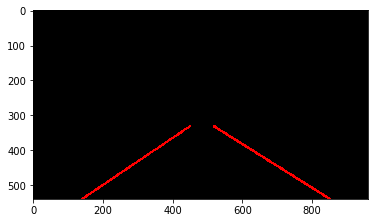

 17%|█▋        | 116/682 [01:21<04:01,  2.35it/s]

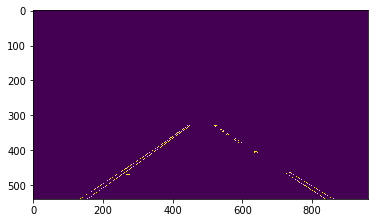

[[-0.70422535]
 [-0.7       ]
 [-0.63157895]
 [-0.76923077]
 [-0.61111111]
 [ 0.64705882]
 [-0.65151515]
 [-0.70967742]
 [-0.70588235]
 [-0.63636364]
 [ 0.54166667]
 [ 0.625     ]
 [ 0.65384615]
 [ 0.6       ]
 [ 0.61904762]
 [-0.63333333]
 [-0.75      ]
 [ 0.5       ]
 [-0.58333333]]
left_m = -0.672015098437  right_m = 0.627328015654
left_c = 632.236450984  right_c = 5.7222377889
left_y = 331.173686884  right_y = 365.181190759  min y = 331.173686884
left_y = 540.842397596  right_y = 532.677770939  max y = 540.842397596


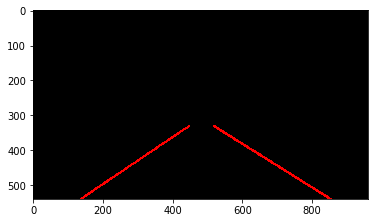

 17%|█▋        | 117/682 [01:21<03:59,  2.36it/s]

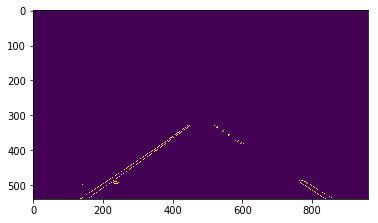

[[-0.75      ]
 [ 0.61538462]
 [-0.68888889]
 [-0.57142857]
 [ 0.5       ]
 [ 0.57142857]
 [-0.68      ]
 [-0.67460317]
 [-0.65909091]
 [ 0.54545455]
 [-0.78571429]
 [-0.8125    ]
 [ 0.68421053]
 [ 0.6       ]
 [ 0.61904762]
 [-0.58333333]
 [-0.66666667]
 [-0.68965517]
 [-0.72727273]
 [-0.77777778]
 [-0.6       ]
 [-0.76923077]
 [ 0.6       ]
 [-0.66666667]
 [ 0.59090909]
 [-0.6       ]
 [-0.66666667]]
left_m = -0.686440152495  right_m = 0.613477570779
left_c = 639.551640807  right_c = 15.4700529182
left_y = 332.026452489  right_y = 370.060088829  min y = 332.026452489
left_y = 542.763579305  right_y = 539.379898364  max y = 542.763579305


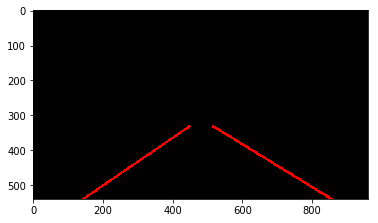

 17%|█▋        | 118/682 [01:22<04:08,  2.27it/s]

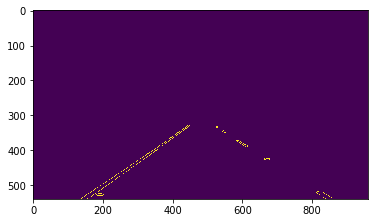

[[-0.75      ]
 [-0.63333333]
 [-0.75510204]
 [-0.6875    ]
 [ 0.8       ]
 [-0.77419355]
 [-0.69047619]
 [-0.76923077]
 [-0.71428571]
 [-0.72222222]
 [-0.58333333]
 [ 0.63636364]
 [ 0.57142857]
 [-0.65      ]
 [ 0.58333333]
 [-0.75      ]
 [-0.69230769]
 [-0.64285714]
 [ 0.53846154]
 [-0.8       ]
 [ 0.69230769]
 [ 0.        ]
 [-0.66666667]
 [ 0.        ]
 [-0.6       ]
 [-0.8       ]]
left_m = -0.678589429102  right_m = 0.626683136229
left_c = 635.607461195  right_c = 6.09883775443
left_y = 331.599396958  right_y = 373.961838721  min y = 331.599396958
left_y = 542.640709408  right_y = 539.406186685  max y = 542.640709408


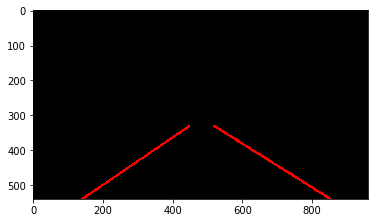

 17%|█▋        | 119/682 [01:22<04:04,  2.31it/s]

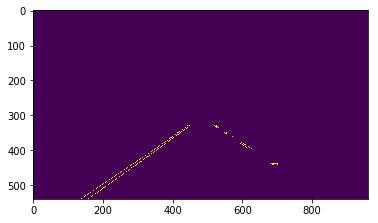

[[-0.78125   ]
 [-0.6       ]
 [-0.75      ]
 [-0.68085106]
 [-0.71186441]
 [ 0.57142857]
 [-0.75      ]
 [-0.6       ]
 [-0.81818182]
 [-0.75      ]
 [-0.78947368]
 [-0.57142857]
 [ 0.66666667]
 [-0.6       ]
 [-0.72727273]
 [-0.81818182]
 [-0.57142857]
 [-0.76923077]
 [-0.71428571]
 [-0.8       ]
 [ 0.63636364]]
left_m = -0.698363675584  right_m = 0.589981447124
left_c = 643.243177416  right_c = 29.3645640074
left_y = 336.661523835  right_y = 380.403525046  min y = 336.661523835
left_y = 541.282080781  right_y = 392.793135436  max y = 541.282080781


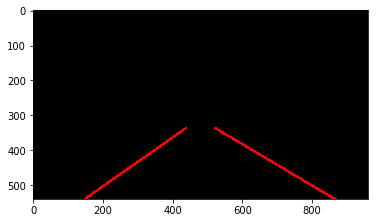

 18%|█▊        | 120/682 [01:23<04:01,  2.33it/s]

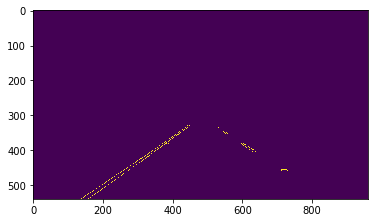

[[-0.77272727]
 [-0.66666667]
 [-0.78571429]
 [-0.69565217]
 [-0.72307692]
 [ 0.57142857]
 [-0.80952381]
 [-0.64285714]
 [-0.66666667]
 [ 0.        ]
 [-0.66666667]
 [-0.61904762]
 [-0.61538462]
 [-0.68292683]
 [-0.63636364]
 [ 0.6       ]
 [-0.72727273]
 [-0.64705882]
 [ 0.59259259]
 [-0.63157895]
 [ 0.6       ]
 [-0.63636364]
 [-0.7       ]
 [-0.72727273]]
left_m = -0.6851171498  right_m = 0.631932524962
left_c = 637.798732438  right_c = 3.81527416348
left_y = 329.496015028  right_y = 348.218500268  min y = 329.496015028
left_y = 539.826980017  right_y = 401.300832364  max y = 539.826980017


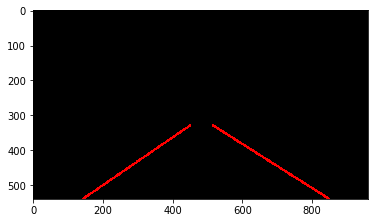

 18%|█▊        | 121/682 [01:23<03:57,  2.36it/s]

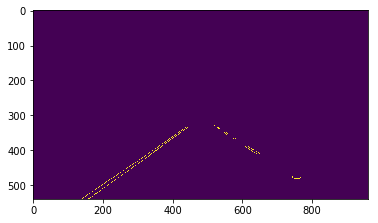

[[-0.7005988 ]
 [-0.7037037 ]
 [-0.72222222]
 [-0.65517241]
 [ 0.58333333]
 [-0.69444444]
 [-0.66666667]
 [-0.63888889]
 [-0.69767442]
 [-0.69230769]
 [ 0.64285714]
 [ 0.65217391]
 [-0.84615385]
 [ 0.6       ]
 [-0.9       ]
 [-0.76923077]
 [-0.63636364]
 [-0.76923077]
 [-0.66666667]
 [-0.81818182]
 [ 0.2       ]
 [-0.78571429]
 [-0.8       ]
 [-0.7       ]]
left_m = -0.683364054195  right_m = 0.645787852684
left_c = 637.386587099  right_c = -4.69867717688
left_y = 330.556126765  right_y = 349.193066094  min y = 330.556126765
left_y = 541.715619511  right_y = 412.480275657  max y = 541.715619511


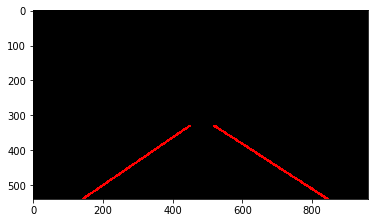

 18%|█▊        | 122/682 [01:24<03:59,  2.34it/s]

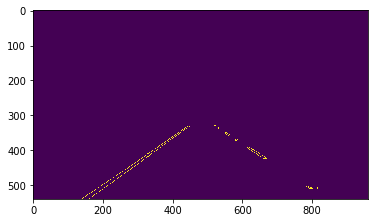

[[-0.69918699]
 [-0.71428571]
 [-0.72727273]
 [-0.72727273]
 [-0.70967742]
 [ 0.61111111]
 [-0.6875    ]
 [-0.57142857]
 [-0.73076923]
 [-0.63636364]
 [-0.68181818]
 [ 0.54545455]
 [-0.57142857]
 [ 0.5625    ]
 [-0.72222222]
 [ 0.61538462]
 [ 0.6       ]
 [ 0.6       ]
 [-0.73333333]
 [ 0.64285714]
 [-0.72727273]
 [-0.76923077]
 [-0.7       ]]
left_m = -0.705264309098  right_m = 0.63473633285
left_c = 645.334840262  right_c = 1.38309489253
left_y = 327.965901167  right_y = 351.122814293  min y = 327.965901167
left_y = 543.776779751  right_y = 426.656437902  max y = 543.776779751


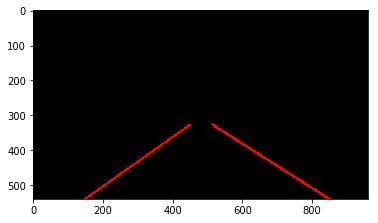

 18%|█▊        | 123/682 [01:24<04:07,  2.26it/s]

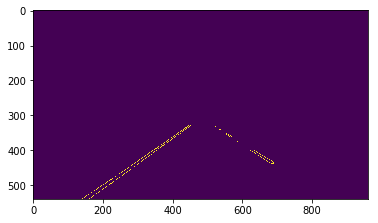

[[-0.7826087 ]
 [-0.75      ]
 [-0.703125  ]
 [ 0.63636364]
 [-0.69852941]
 [-0.68      ]
 [ 0.58333333]
 [-0.6875    ]
 [ 0.68965517]
 [-0.6       ]
 [ 0.5       ]
 [-0.57142857]
 [-0.75      ]
 [-0.8       ]
 [-0.8125    ]
 [-0.6       ]
 [ 0.6       ]
 [-0.8       ]
 [-0.57142857]
 [-0.81818182]
 [ 0.63636364]
 [-0.66666667]
 [-0.6       ]
 [-0.83333333]]
left_m = -0.685486550087  right_m = 0.600076491586
left_c = 639.669646694  right_c = 23.1348376679
left_y = 329.829726054  right_y = 355.577214006  min y = 329.829726054
left_y = 542.330556581  right_y = 426.986316505  max y = 542.330556581


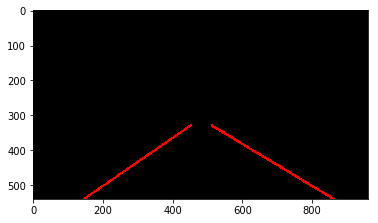

 18%|█▊        | 124/682 [01:24<04:02,  2.30it/s]

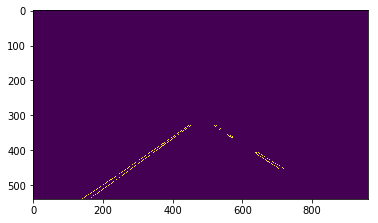

[[-0.7826087 ]
 [-0.6       ]
 [-0.66071429]
 [-0.66666667]
 [-0.58333333]
 [-0.68253968]
 [ 0.59090909]
 [-0.6       ]
 [-0.63636364]
 [-0.625     ]
 [-0.83333333]
 [-0.66666667]
 [-0.6875    ]
 [-0.625     ]
 [-0.625     ]
 [-0.63636364]
 [-0.70833333]
 [-0.61538462]
 [ 0.61111111]
 [ 0.58823529]
 [-0.6       ]
 [-0.625     ]
 [ 0.57894737]
 [-0.57142857]
 [ 0.63636364]
 [-0.72727273]
 [ 0.58333333]
 [ 0.6       ]]
left_m = -0.706737725743  right_m = 0.639208529371
left_c = 647.927303174  right_c = -1.43824247385
left_y = 340.496392476  right_y = 355.879325445  min y = 340.496392476
left_y = 540.503168862  right_y = 449.203770733  max y = 540.503168862


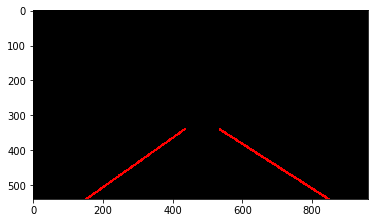

 18%|█▊        | 125/682 [01:25<03:55,  2.36it/s]

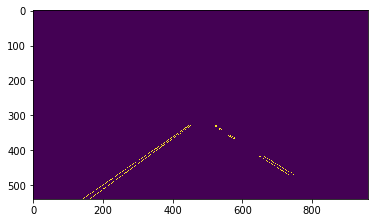

[[ 0.61538462]
 [-0.81818182]
 [-0.7826087 ]
 [-0.69736842]
 [-0.74358974]
 [-0.64285714]
 [-0.64285714]
 [-0.78125   ]
 [ 0.6       ]
 [-0.71794872]
 [-0.84615385]
 [-0.64285714]
 [ 0.62711864]
 [-0.72727273]
 [-0.61538462]
 [-0.76923077]
 [-0.77272727]
 [ 0.53846154]
 [-0.7826087 ]
 [-0.57142857]
 [ 0.45454545]
 [-0.58333333]
 [-0.57142857]
 [-0.9       ]
 [-0.77272727]
 [ 0.54545455]
 [ 0.53846154]
 [ 0.54545455]
 [-0.81818182]
 [-0.81818182]
 [-0.77777778]
 [-0.9       ]
 [ 0.5       ]]
left_m = -0.695648801695  right_m = 0.625754208119
left_c = 643.169318305  right_c = 6.07642277756
left_y = 336.388196758  right_y = 356.498779324  min y = 336.388196758
left_y = 543.691539663  right_y = 467.883028369  max y = 543.691539663


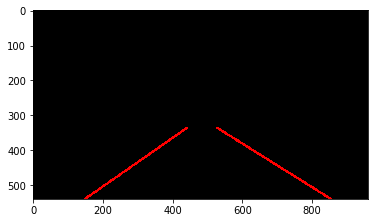

 18%|█▊        | 126/682 [01:25<03:52,  2.39it/s]

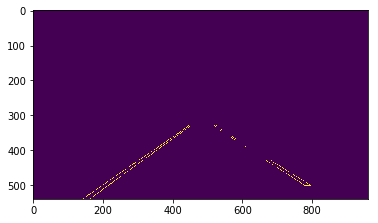

[[-0.625     ]
 [-0.6       ]
 [-0.75      ]
 [-0.72340426]
 [ 0.6       ]
 [ 0.64864865]
 [-0.78571429]
 [ 0.56      ]
 [-0.78571429]
 [-0.77419355]
 [ 0.6       ]
 [-0.81818182]
 [-0.78571429]
 [ 0.        ]
 [-0.75      ]
 [-0.725     ]
 [-0.64285714]
 [-0.81818182]
 [ 0.58333333]
 [-0.73684211]
 [ 0.5       ]
 [ 0.5625    ]
 [ 0.61538462]
 [-0.8       ]
 [-0.6       ]
 [-0.72727273]
 [-0.8       ]
 [-0.8       ]
 [ 0.5       ]
 [ 0.63636364]
 [ 0.61538462]
 [-0.72727273]
 [-0.7       ]]
left_m = -0.695643211661  right_m = 0.615534032398
left_c = 643.034556213  right_c = 12.5907844102
left_y = 331.386397389  right_y = 359.751978683  min y = 331.386397389
left_y = 543.557576945  right_y = 501.324806134  max y = 543.557576945


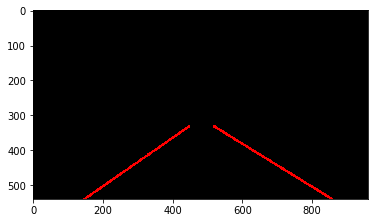

 19%|█▊        | 127/682 [01:26<03:53,  2.38it/s]

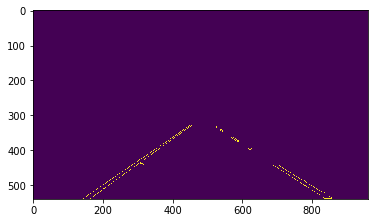

[[-0.73076923]
 [-0.66666667]
 [ 0.59259259]
 [-0.6835443 ]
 [ 0.62264151]
 [-0.68888889]
 [ 0.5625    ]
 [-0.63636364]
 [-0.58333333]
 [-0.76      ]
 [ 0.63636364]
 [ 0.59459459]
 [ 0.57142857]
 [ 0.5625    ]
 [-0.69230769]
 [-0.78571429]
 [-0.66666667]
 [-0.78947368]
 [-0.73076923]
 [-0.76923077]
 [-0.81818182]
 [ 0.5625    ]
 [ 0.6       ]
 [-0.78571429]
 [ 0.55555556]
 [ 0.        ]
 [ 0.66666667]
 [-0.7       ]
 [ 0.58823529]
 [-0.6       ]
 [ 0.64705882]
 [ 0.53846154]
 [ 0.54545455]
 [ 0.5       ]
 [-0.63636364]
 [-0.84615385]]
left_m = -0.695160489033  right_m = 0.628673401752
left_c = 643.297676253  right_c = 5.59640617375
left_y = 333.256098145  right_y = 362.682898369  min y = 333.256098145
left_y = 543.889726321  right_y = 543.112164672  max y = 543.889726321


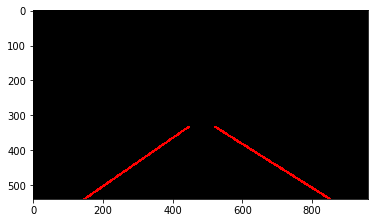

 19%|█▉        | 128/682 [01:26<03:53,  2.37it/s]

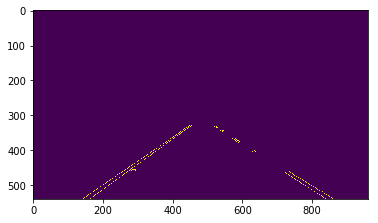

[[ 0.62222222]
 [-0.8       ]
 [ 0.59615385]
 [-0.75      ]
 [-0.69411765]
 [-0.66071429]
 [-0.8125    ]
 [ 0.72727273]
 [-0.65853659]
 [-0.61538462]
 [ 0.56521739]
 [-0.66666667]
 [-0.69047619]
 [ 0.63333333]
 [-0.58333333]
 [-0.66666667]
 [-0.71428571]
 [-0.8       ]
 [-0.83333333]
 [ 0.6       ]
 [-0.83333333]
 [ 0.6875    ]
 [-0.8125    ]
 [-0.83333333]
 [-0.81818182]
 [ 0.58333333]
 [ 0.63636364]
 [-0.58333333]]
left_m = -0.689404236559  right_m = 0.627281863665
left_c = 642.280666146  right_c = 5.92994279424
left_y = 334.806376641  right_y = 366.617014401  min y = 334.806376641
left_y = 543.695860318  right_y = 543.510499955  max y = 543.695860318


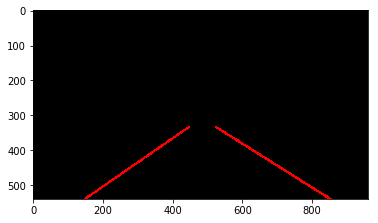

 19%|█▉        | 129/682 [01:27<04:05,  2.25it/s]

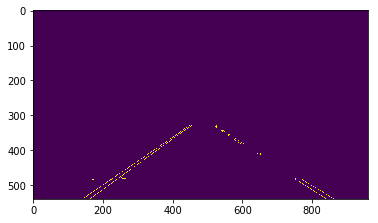

[[-0.66      ]
 [-0.78571429]
 [-0.73333333]
 [-0.81818182]
 [-0.7244898 ]
 [-0.81818182]
 [ 0.58064516]
 [-0.76470588]
 [-0.57142857]
 [-0.76470588]
 [ 0.55555556]
 [-0.76666667]
 [-0.75      ]
 [ 0.57142857]
 [ 0.5625    ]
 [ 0.64285714]
 [ 0.63636364]
 [-0.76470588]
 [ 0.61538462]
 [-0.66666667]
 [-0.6       ]
 [-0.84615385]
 [ 0.8       ]
 [-0.8       ]
 [-0.75      ]
 [ 0.60869565]
 [ 0.61538462]]
left_m = -0.708046875141  right_m = 0.627236283619
left_c = 646.418320355  right_c = 6.10498976973
left_y = 329.213320291  right_y = 367.393089134  min y = 329.213320291
left_y = 545.875664085  right_y = 538.628594562  max y = 545.875664085


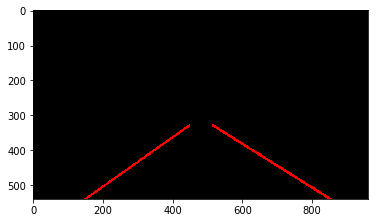

 19%|█▉        | 130/682 [01:27<04:03,  2.27it/s]

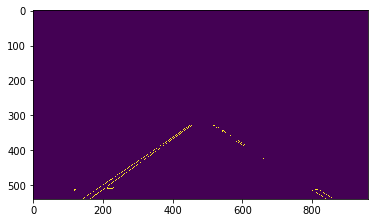

[[-0.58333333]
 [-0.74      ]
 [-0.65909091]
 [-0.65306122]
 [-0.63333333]
 [-0.71084337]
 [-0.8125    ]
 [-0.6969697 ]
 [-0.8       ]
 [ 0.64864865]
 [-0.6       ]
 [-0.8       ]
 [-0.7826087 ]
 [-0.64285714]
 [-0.61904762]
 [-0.6       ]
 [-0.6       ]
 [ 0.6875    ]
 [ 0.61538462]
 [-0.69230769]
 [ 0.        ]
 [ 0.68421053]
 [-0.58333333]
 [-0.64285714]
 [-0.66666667]
 [-0.64285714]
 [-0.66666667]
 [-0.58333333]]
left_m = -0.702453207317  right_m = 0.617369223266
left_c = 646.048562436  right_c = 15.7398423203
left_y = 336.26669801  right_y = 380.605053271  min y = 336.26669801
left_y = 525.929063985  right_y = 546.677374329  max y = 546.677374329


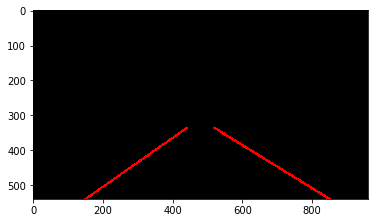

 19%|█▉        | 131/682 [01:27<03:59,  2.30it/s]

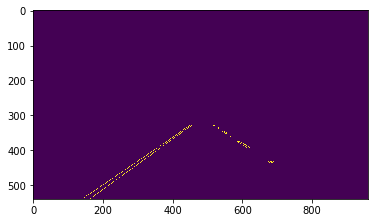

[[-0.7826087 ]
 [-0.66666667]
 [-0.67475728]
 [-0.75      ]
 [-0.78947368]
 [-0.7826087 ]
 [ 0.57142857]
 [-0.66666667]
 [-0.68965517]
 [-0.77777778]
 [-0.625     ]
 [-0.66666667]
 [ 0.66666667]
 [-0.66666667]
 [-0.71428571]
 [-0.61904762]
 [-0.625     ]
 [ 0.66666667]
 [-0.84615385]
 [ 0.6       ]
 [-0.72727273]]
left_m = -0.725279920199  right_m = 0.577579203899
left_c = 655.007484977  right_c = 36.17018684
left_y = 326.455681127  right_y = 378.674654752  min y = 326.455681127
left_y = 552.017736309  right_y = 394.269293258  max y = 552.017736309


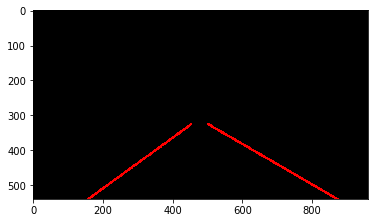

 19%|█▉        | 132/682 [01:28<03:56,  2.33it/s]

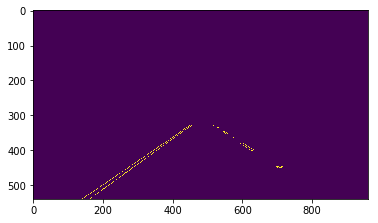

[[-0.67676768]
 [-0.8125    ]
 [-0.68333333]
 [-0.67741935]
 [ 0.58333333]
 [ 0.6       ]
 [-0.70588235]
 [-0.69230769]
 [-0.64285714]
 [-0.66666667]
 [-0.71014493]
 [-0.66666667]
 [-0.68181818]
 [ 0.61904762]
 [-0.65      ]
 [-0.64285714]
 [ 0.63636364]]
left_m = -0.696739125915  right_m = 0.541504178273
left_c = 645.250207698  right_c = 57.6715877437
left_y = 329.627383658  right_y = 379.866573816  min y = 329.627383658
left_y = 546.313251818  right_y = 394.48718663  max y = 546.313251818


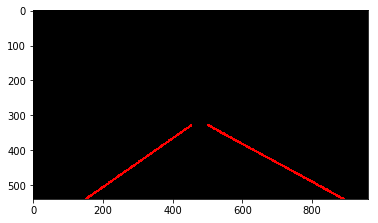

 20%|█▉        | 133/682 [01:28<03:52,  2.37it/s]

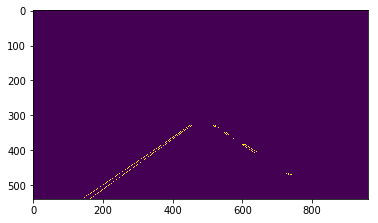

[[-0.67532468]
 [-0.71875   ]
 [-0.7       ]
 [-0.72807018]
 [ 0.69230769]
 [-0.7       ]
 [ 0.75      ]
 [-0.71428571]
 [-0.85714286]
 [-0.81818182]
 [-0.8       ]
 [-0.77777778]
 [-0.90909091]
 [ 0.64285714]
 [-0.83333333]
 [-0.74074074]
 [-0.76923077]
 [ 0.6       ]
 [-0.78571429]]
left_m = -0.723187999819  right_m = 0.684255948712
left_c = 653.052262233  right_c = -29.4691160153
left_y = 327.617662314  right_y = 386.558500801  min y = 327.617662314
left_y = 538.788558261  right_y = 411.191714955  max y = 538.788558261


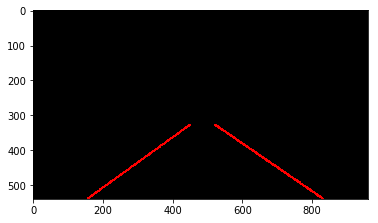

 20%|█▉        | 134/682 [01:29<04:01,  2.27it/s]

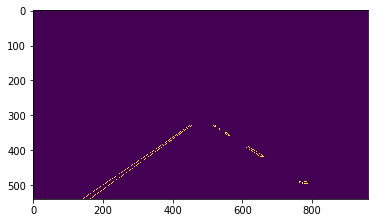

[[-0.73333333]
 [-0.77777778]
 [-0.64285714]
 [-0.70175439]
 [-0.71428571]
 [-0.64285714]
 [-0.75      ]
 [ 0.57692308]
 [-0.77272727]
 [ 0.5       ]
 [-0.70967742]
 [-0.61538462]
 [-0.81818182]
 [-0.73333333]
 [ 0.6       ]
 [-0.71875   ]
 [ 0.59090909]
 [ 0.54545455]
 [-0.1       ]
 [-0.6       ]
 [-0.6       ]
 [-0.7       ]
 [-0.64285714]
 [-0.72727273]
 [-0.75      ]
 [-0.6       ]
 [-0.64705882]
 [-0.7       ]]
left_m = -0.697925285748  right_m = 0.637527774125
left_c = 645.219852977  right_c = 0.119582747856
left_y = 328.361773248  right_y = 350.759858516  min y = 328.361773248
left_y = 545.416537115  right_y = 417.700274799  max y = 545.416537115


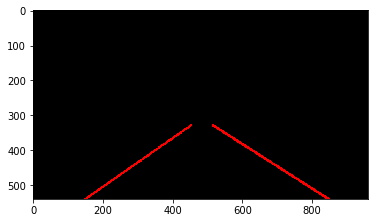

 20%|█▉        | 135/682 [01:29<03:55,  2.32it/s]

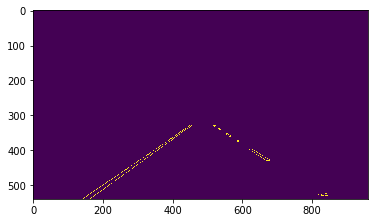

[[-0.71875   ]
 [-0.72826087]
 [-0.65625   ]
 [-0.75      ]
 [-0.63636364]
 [-0.625     ]
 [ 0.60714286]
 [-0.69230769]
 [-0.75      ]
 [ 0.65789474]
 [-0.75      ]
 [-0.8       ]
 [-0.625     ]
 [-0.75      ]
 [-0.73333333]
 [-0.76923077]
 [-0.76923077]
 [ 0.58823529]
 [-0.78571429]
 [-0.81818182]
 [-0.71428571]
 [-0.78571429]
 [-0.69230769]]
left_m = -0.675137988121  right_m = 0.596389208195
left_c = 636.48973756  right_c = 25.4584488471
left_y = 329.301952965  right_y = 399.394482386  min y = 329.301952965
left_y = 533.193625378  right_y = 429.810332004  max y = 533.193625378


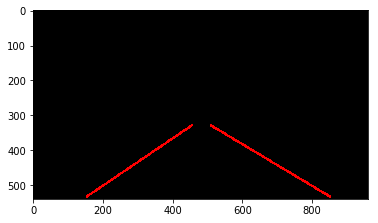

 20%|█▉        | 136/682 [01:30<03:57,  2.30it/s]

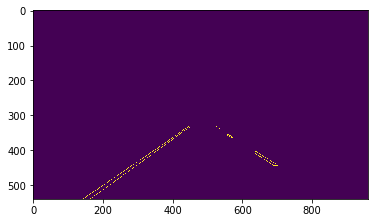

[[-0.84615385]
 [-0.76923077]
 [ 0.6       ]
 [-0.77272727]
 [-0.75      ]
 [-0.67672414]
 [ 0.61538462]
 [-0.76923077]
 [ 0.5       ]
 [-0.66666667]
 [-0.81818182]
 [-0.85714286]
 [ 0.57142857]
 [-0.8       ]
 [ 0.58333333]
 [-0.63636364]
 [-0.66666667]
 [-0.63636364]
 [-0.69230769]
 [ 0.65      ]
 [-0.66666667]]
left_m = -0.70040689196  right_m = 0.604982573759
left_c = 648.502009315  right_c = 19.3064111724
left_y = 329.116466581  right_y = 355.071739609  min y = 329.116466581
left_y = 547.643416873  right_y = 439.769299935  max y = 547.643416873


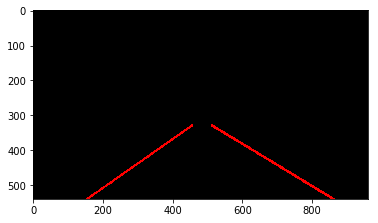

 20%|██        | 137/682 [01:30<03:51,  2.36it/s]

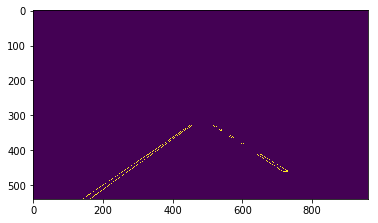

[[-0.66071429]
 [-0.73333333]
 [-0.73333333]
 [-0.72222222]
 [-0.83333333]
 [-0.57142857]
 [-0.69230769]
 [-0.63636364]
 [ 0.65853659]
 [-0.65217391]
 [-0.64285714]
 [-0.68965517]
 [-0.61538462]
 [ 0.61904762]
 [-0.76923077]
 [ 0.57692308]
 [ 0.52941176]
 [-0.64705882]
 [-0.6       ]
 [-0.6875    ]
 [-0.64285714]
 [-0.71428571]
 [-0.61538462]
 [-0.78571429]
 [-0.58333333]
 [ 0.64285714]
 [-0.58333333]
 [-0.61538462]
 [-0.64705882]
 [ 0.61538462]
 [ 0.        ]
 [ 0.54545455]
 [ 0.54545455]
 [ 0.6       ]]
left_m = -0.69626654703  right_m = 0.617816004421
left_c = 644.905086202  right_c = 11.1137232973
left_y = 332.977673132  right_y = 358.326317782  min y = 332.977673132
left_y = 534.198705224  right_y = 454.087798467  max y = 534.198705224


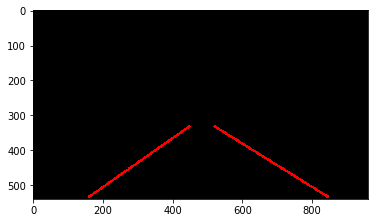

 20%|██        | 138/682 [01:30<03:48,  2.38it/s]

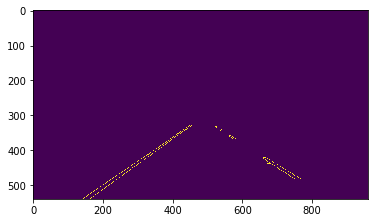

[[-0.75      ]
 [-0.76470588]
 [-0.76923077]
 [ 0.5       ]
 [-0.78947368]
 [-0.58823529]
 [-0.6       ]
 [-0.64285714]
 [-0.68      ]
 [-0.70833333]
 [-0.61538462]
 [-0.58823529]
 [ 0.56666667]
 [ 0.63768116]
 [-0.58333333]
 [-0.81818182]
 [-0.84615385]
 [-0.75      ]
 [ 0.        ]
 [-0.83333333]
 [-0.73913043]
 [-0.83333333]
 [-0.6       ]
 [ 0.53333333]
 [-0.625     ]
 [-0.6       ]
 [ 0.69230769]
 [ 0.57142857]
 [ 0.55555556]
 [-0.81818182]
 [-0.76923077]
 [ 0.71428571]
 [ 0.6       ]]
left_m = -0.68693676036  right_m = 0.616743797363
left_c = 640.30395428  right_c = 11.8777853044
left_y = 329.808538597  right_y = 358.487799422  min y = 329.808538597
left_y = 537.263440226  right_y = 480.6030713  max y = 537.263440226


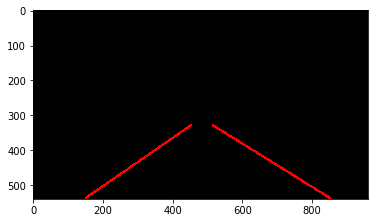

 20%|██        | 139/682 [01:31<03:46,  2.39it/s]

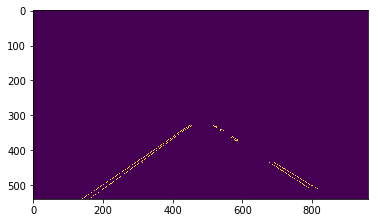

[[-0.69473684]
 [ 0.65517241]
 [ 0.63636364]
 [-0.69230769]
 [-0.72486772]
 [-0.78571429]
 [-0.73584906]
 [ 0.5       ]
 [-0.7       ]
 [ 0.64      ]
 [ 0.6       ]
 [ 0.60869565]
 [-0.76923077]
 [ 0.58823529]
 [-0.69642857]
 [ 0.58823529]
 [ 0.76923077]
 [-0.78571429]
 [ 0.69230769]
 [-0.76923077]
 [-0.68      ]
 [-0.76923077]
 [ 0.61538462]
 [ 0.58333333]
 [-0.72727273]
 [-0.66666667]
 [-0.7       ]
 [-0.71428571]]
left_m = -0.699397694774  right_m = 0.631977460068
left_c = 643.823899926  right_c = 3.63784759038
left_y = 329.094937278  right_y = 365.760932209  min y = 329.094937278
left_y = 538.91424571  right_y = 519.331455006  max y = 538.91424571


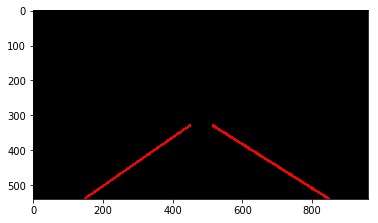

 21%|██        | 140/682 [01:31<03:55,  2.30it/s]

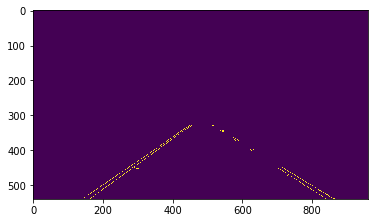

[[-0.72532189]
 [-0.66666667]
 [-0.78571429]
 [ 0.63636364]
 [ 0.6       ]
 [-0.61538462]
 [ 0.5       ]
 [-0.72      ]
 [ 0.83333333]
 [ 0.6       ]
 [ 0.57142857]
 [-0.7027027 ]
 [ 0.63636364]
 [-0.76470588]
 [-0.71428571]
 [-0.75      ]
 [ 0.5       ]
 [ 0.5       ]
 [ 0.47058824]
 [ 0.53846154]
 [-0.75      ]
 [ 0.5       ]
 [ 0.54545455]
 [ 0.5       ]
 [-0.75      ]
 [-0.75      ]
 [ 0.53846154]
 [ 0.57894737]
 [-0.75      ]
 [ 0.55      ]
 [-0.81818182]]
left_m = -0.713993712183  right_m = 0.618313867702
left_c = 647.879678105  right_c = 13.2623572262
left_y = 334.436438457  right_y = 366.319575684  min y = 334.436438457
left_y = 528.64272817  right_y = 542.539027979  max y = 542.539027979


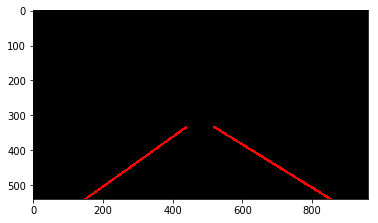

 21%|██        | 141/682 [01:32<03:52,  2.32it/s]

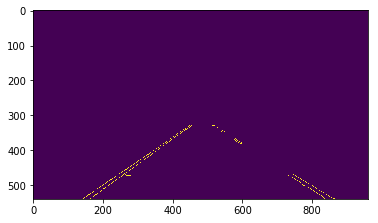

[[ 0.45454545]
 [-0.68181818]
 [-0.72727273]
 [-0.65957447]
 [-0.61904762]
 [ 0.5       ]
 [ 0.625     ]
 [-0.75      ]
 [-0.75      ]
 [ 0.64705882]
 [-0.71428571]
 [-0.61538462]
 [-0.72727273]
 [ 0.63636364]
 [-0.73684211]
 [ 0.53333333]
 [ 0.61538462]
 [ 0.625     ]
 [-0.625     ]
 [ 0.61904762]
 [-0.8       ]
 [ 0.6       ]
 [-0.8       ]
 [-0.78571429]
 [ 0.7       ]
 [ 0.5       ]
 [-0.69230769]
 [ 0.69230769]
 [ 0.57142857]
 [-0.61538462]]
left_m = -0.694603009393  right_m = 0.611957078772
left_c = 641.376994542  right_c = 16.7820710516
left_y = 337.140876428  right_y = 367.433477188  min y = 337.140876428
left_y = 542.048764199  right_y = 541.229287559  max y = 542.048764199


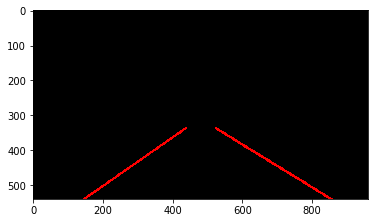

 21%|██        | 142/682 [01:32<03:48,  2.36it/s]

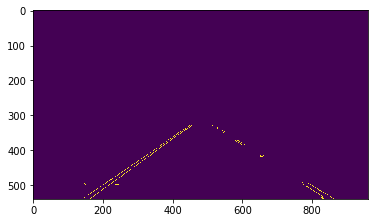

[[-0.70588235]
 [-0.70833333]
 [ 0.53846154]
 [-0.75      ]
 [-0.80952381]
 [-0.63157895]
 [-0.77272727]
 [-0.61904762]
 [ 0.59375   ]
 [ 0.62      ]
 [-0.6       ]
 [-0.63333333]
 [ 0.54545455]
 [-0.83333333]
 [-0.75      ]
 [-0.58333333]
 [-0.58333333]
 [-0.78571429]
 [-0.63333333]
 [ 0.53846154]
 [ 0.5625    ]
 [-0.6       ]
 [-0.68421053]
 [-0.54545455]
 [ 0.57142857]
 [-0.70588235]
 [-0.58333333]
 [ 0.55      ]
 [ 0.6       ]
 [-0.72727273]]
left_m = -0.695114018714  right_m = 0.615266499336
left_c = 643.164793598  right_c = 13.5629082796
left_y = 333.839055271  right_y = 369.186944896  min y = 333.839055271
left_y = 544.458602941  right_y = 534.693633217  max y = 544.458602941


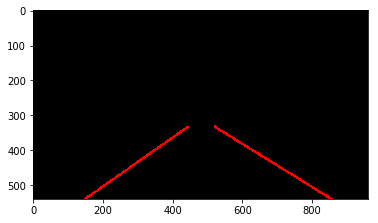

 21%|██        | 143/682 [01:33<03:48,  2.36it/s]

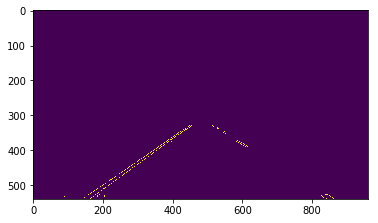

[[ 0.        ]
 [-0.69230769]
 [-0.78571429]
 [-0.63636364]
 [-0.72608696]
 [-0.76470588]
 [-0.725     ]
 [-0.76923077]
 [-0.64705882]
 [ 0.625     ]
 [-0.65853659]
 [-0.58333333]
 [-0.625     ]
 [-0.7037037 ]
 [-0.63636364]
 [ 0.58823529]
 [-0.68421053]
 [-0.8       ]
 [ 0.42857143]]
left_m = -0.689634356072  right_m = 0.472940029254
left_c = 639.327951978  right_c = 98.3271574842
left_y = 331.061394814  right_y = 374.051194539  min y = 331.061394814
left_y = 526.227917582  right_y = 389.185275475  max y = 526.227917582


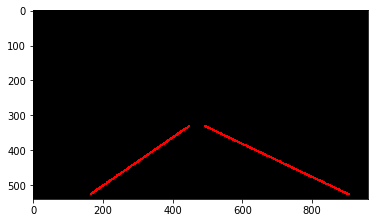

 21%|██        | 144/682 [01:33<03:45,  2.38it/s]

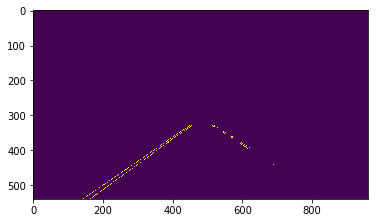

[[-0.75      ]
 [-0.75      ]
 [-0.64      ]
 [-0.71428571]
 [-0.81818182]
 [-0.67857143]
 [-0.83333333]
 [-0.65      ]
 [-0.81818182]
 [-0.70588235]
 [-0.75      ]
 [-0.68181818]
 [-0.76923077]
 [-0.6       ]
 [-0.68      ]
 [-0.61538462]
 [ 0.61111111]
 [-0.58333333]
 [ 0.6       ]
 [-0.76923077]
 [-0.6       ]
 [-0.76923077]
 [-0.81818182]]
left_m = -0.700242256076  right_m = 0.730158730159
left_c = 644.958113012  right_c = -56.1587301587
left_y = 326.347886498  right_y = 378.285714286  min y = 326.347886498
left_y = 544.123228137  right_y = 395.80952381  max y = 544.123228137


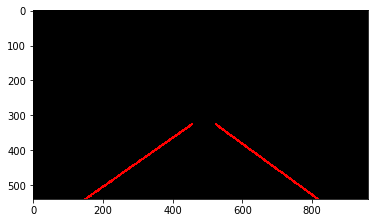

 21%|██▏       | 145/682 [01:33<03:57,  2.26it/s]

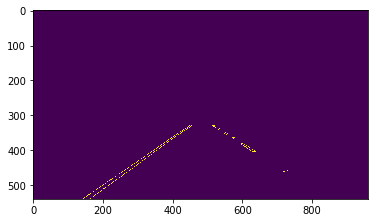

[[-0.58333333]
 [-0.57142857]
 [-0.72307692]
 [-0.75      ]
 [-0.72      ]
 [-0.75      ]
 [ 0.5       ]
 [-0.75      ]
 [-0.76470588]
 [-0.76190476]
 [-0.7037037 ]
 [-0.71875   ]
 [ 0.6       ]
 [ 0.65517241]
 [-0.75      ]
 [-0.72222222]
 [ 0.63636364]
 [-0.72727273]
 [ 0.5       ]
 [-0.7       ]
 [-0.66666667]]
left_m = -0.693503256765  right_m = 0.593187054881
left_c = 641.905276449  right_c = 27.2318548387
left_y = 327.054797878  right_y = 351.111986804  min y = 327.054797878
left_y = 542.734310731  right_y = 403.312447633  max y = 542.734310731


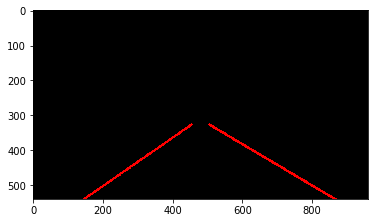

 21%|██▏       | 146/682 [01:34<03:49,  2.34it/s]

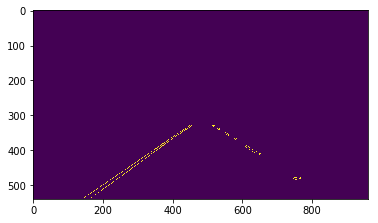

[[-0.75      ]
 [-0.5       ]
 [-0.75      ]
 [-0.75      ]
 [-0.64285714]
 [-0.81818182]
 [-0.8       ]
 [-0.71428571]
 [ 0.71428571]
 [ 0.58823529]
 [-0.64285714]
 [-0.6       ]
 [-0.76190476]
 [-0.75      ]
 [-0.76190476]
 [-0.6       ]
 [-0.73913043]
 [-0.8       ]
 [-0.84615385]
 [ 0.7       ]
 [-0.6       ]
 [-0.58333333]
 [-0.6875    ]
 [-0.75      ]
 [-0.61538462]
 [-0.8       ]
 [ 0.69230769]
 [-0.3       ]]
left_m = -0.699081506699  right_m = 0.545270773487
left_c = 644.20709309  right_c = 57.3536546441
left_y = 331.018578089  right_y = 389.968826471  min y = 331.018578089
left_y = 544.238437632  right_y = 409.598574316  max y = 544.238437632


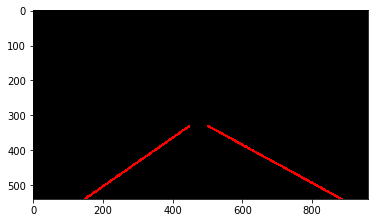

 22%|██▏       | 147/682 [01:34<03:46,  2.37it/s]

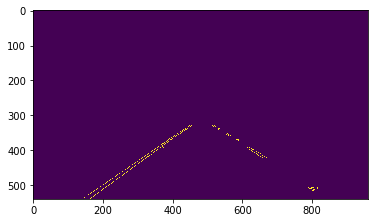

[[-0.69747899]
 [-0.7       ]
 [-0.69565217]
 [-0.6       ]
 [-0.8       ]
 [-0.6       ]
 [ 0.53846154]
 [ 0.63157895]
 [-0.6       ]
 [-0.69811321]
 [-0.63636364]
 [ 0.66666667]
 [-0.66666667]
 [-0.68421053]
 [-0.69565217]
 [-0.72222222]
 [ 0.6       ]
 [-0.6969697 ]
 [-0.8       ]
 [-0.7       ]
 [ 0.66666667]
 [-0.63157895]
 [-0.75      ]
 [-0.63636364]]
left_m = -0.708518495855  right_m = 0.634266075241
left_c = 649.822137567  right_c = 2.11944177503
left_y = 331.697332928  right_y = 352.234315308  min y = 331.697332928
left_y = 535.750659735  right_y = 426.443446111  max y = 535.750659735


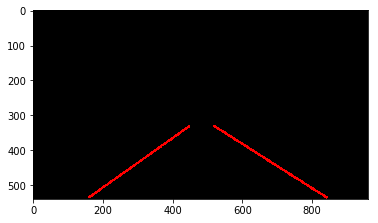

 22%|██▏       | 148/682 [01:35<03:45,  2.37it/s]

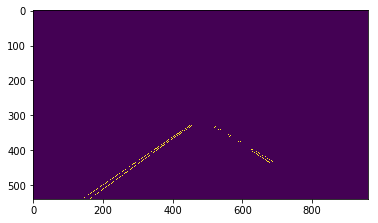

[[-0.83333333]
 [-0.703125  ]
 [-0.6       ]
 [ 0.58333333]
 [-0.61538462]
 [-0.67785235]
 [ 0.64285714]
 [-0.67716535]
 [-0.8       ]
 [-0.69230769]
 [-0.63157895]
 [ 0.61538462]
 [-0.68421053]
 [-0.6       ]
 [-0.68571429]
 [-0.68181818]
 [-0.72727273]
 [-0.7037037 ]
 [ 0.6       ]
 [-0.66666667]
 [-0.6875    ]
 [-0.64285714]
 [ 0.5       ]
 [-0.66666667]
 [ 0.6       ]]
left_m = -0.697049431741  right_m = 0.605680572294
left_c = 644.967320597  right_c = 18.2054212194
left_y = 332.689175177  right_y = 353.75245827  min y = 332.689175177
left_y = 545.289251858  right_y = 436.125016102  max y = 545.289251858


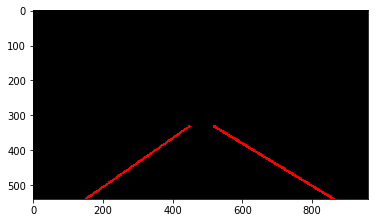

 22%|██▏       | 149/682 [01:35<03:44,  2.38it/s]

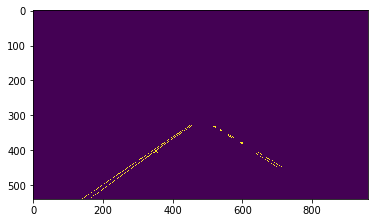

[[-0.72222222]
 [-0.74074074]
 [ 0.61111111]
 [-0.625     ]
 [-0.75      ]
 [-0.703125  ]
 [-0.78571429]
 [-0.70967742]
 [ 0.65517241]
 [-0.85714286]
 [ 0.61904762]
 [-0.72      ]
 [-0.84615385]
 [-0.63636364]
 [-0.75      ]
 [-0.76923077]
 [-0.6       ]
 [-0.6       ]
 [-0.61538462]
 [ 0.5       ]
 [-0.8       ]
 [ 0.66666667]
 [-0.61538462]
 [ 0.63636364]
 [-0.8       ]
 [-0.7       ]]
left_m = -0.686694753059  right_m = 0.599491836114
left_c = 641.022260848  right_c = 21.9625388377
left_y = 329.262842959  right_y = 329.501850764  min y = 329.262842959
left_y = 540.764826901  right_y = 446.402758806  max y = 540.764826901


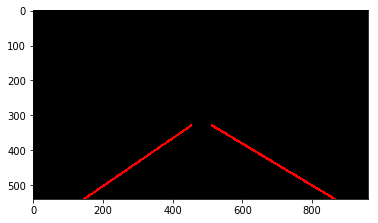

 22%|██▏       | 150/682 [01:36<03:47,  2.34it/s]

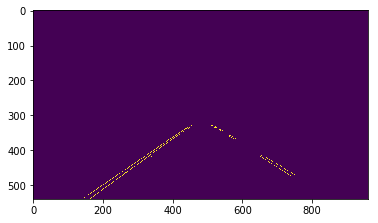

[[-0.67213115]
 [ 0.71428571]
 [-0.78571429]
 [-0.74358974]
 [ 0.57142857]
 [-0.8       ]
 [-0.66666667]
 [-0.625     ]
 [-0.65789474]
 [-0.7       ]
 [ 0.57894737]
 [-0.73333333]
 [-0.8       ]
 [ 0.6       ]
 [ 0.5       ]
 [-0.84615385]
 [-0.72727273]
 [ 0.54545455]
 [-0.8125    ]
 [-0.90909091]
 [-0.75      ]
 [-0.78571429]
 [-0.78571429]]
left_m = -0.705375822595  right_m = 0.613546934993
left_c = 648.335990846  right_c = 14.3103579152
left_y = 330.916870678  right_y = 358.510188446  min y = 330.916870678
left_y = 548.172624037  right_y = 473.857012225  max y = 548.172624037


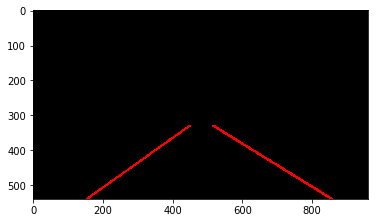

 22%|██▏       | 151/682 [01:36<04:19,  2.05it/s]

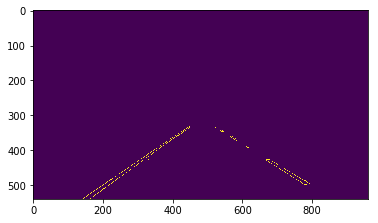

[[-0.72826087]
 [-0.69565217]
 [-0.72222222]
 [-0.70967742]
 [-0.76190476]
 [-0.73809524]
 [-0.72727273]
 [-0.72413793]
 [ 0.59375   ]
 [-0.72727273]
 [-0.76470588]
 [ 0.62162162]
 [ 0.75      ]
 [ 0.72727273]
 [-0.81818182]
 [-0.84615385]
 [-0.8125    ]
 [ 0.5       ]
 [-0.73684211]
 [-0.75      ]
 [ 0.5       ]
 [ 0.64285714]
 [-0.73333333]
 [-0.75      ]
 [-0.8       ]
 [-0.58333333]
 [ 0.61538462]]
left_m = -0.690900874813  right_m = 0.649824429396
left_c = 642.406339392  right_c = -10.3241597693
left_y = 332.191846601  right_y = 360.725589416  min y = 332.191846601
left_y = 544.298415169  right_y = 494.589421871  max y = 544.298415169


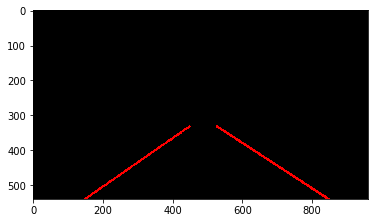

 22%|██▏       | 152/682 [01:37<04:19,  2.05it/s]

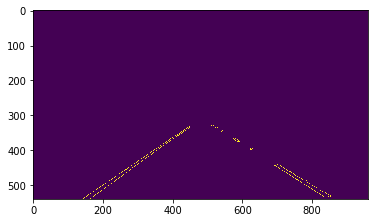

[[ 0.59459459]
 [-0.69411765]
 [ 0.62931034]
 [ 0.55      ]
 [-0.73684211]
 [-0.67857143]
 [ 0.54545455]
 [-0.75      ]
 [-0.72093023]
 [-0.63157895]
 [-0.65957447]
 [-0.68421053]
 [-0.625     ]
 [ 0.63636364]
 [-0.64705882]
 [-0.67857143]
 [ 0.55555556]
 [-0.58333333]
 [-0.6       ]
 [-0.6       ]
 [-0.6       ]
 [ 0.66666667]
 [-0.64285714]
 [-0.58823529]
 [-0.63636364]
 [ 0.54545455]]
left_m = -0.686501204966  right_m = 0.635223095342
left_c = 642.120485186  right_c = -2.50067451351
left_y = 333.194942951  right_y = 361.482159118  min y = 333.194942951
left_y = 543.950812876  right_y = 526.640163907  max y = 543.950812876


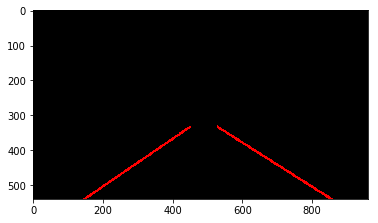

 22%|██▏       | 153/682 [01:37<04:05,  2.16it/s]

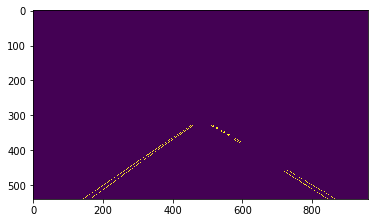

[[-0.67391304]
 [-0.69230769]
 [-0.75      ]
 [-0.77777778]
 [-0.675     ]
 [ 0.58064516]
 [ 0.6       ]
 [ 0.58823529]
 [ 0.66666667]
 [-0.78571429]
 [-0.58333333]
 [-0.54545455]
 [ 0.        ]
 [ 0.63414634]
 [ 0.55555556]
 [-0.6       ]
 [ 0.61363636]
 [-0.72727273]
 [-0.83333333]
 [-0.8       ]
 [-0.83333333]
 [ 0.72727273]
 [ 0.63157895]
 [-0.63636364]
 [-0.8       ]
 [ 0.55      ]
 [-0.78947368]
 [-0.64705882]
 [ 0.64285714]
 [ 0.55      ]
 [ 0.57142857]]
left_m = -0.700453293238  right_m = 0.607841464542
left_c = 647.165703503  right_c = 17.5389330392
left_y = 327.058548493  right_y = 367.047775151  min y = 327.058548493
left_y = 546.300429276  right_y = 543.321799868  max y = 546.300429276


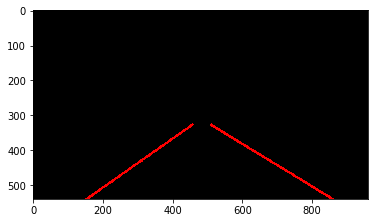

 23%|██▎       | 154/682 [01:37<03:56,  2.23it/s]

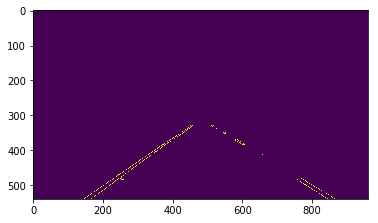

[[-0.8       ]
 [-0.75      ]
 [-0.58333333]
 [-0.72677596]
 [ 0.59090909]
 [-0.78571429]
 [-0.77777778]
 [-0.78571429]
 [-0.62962963]
 [-0.64      ]
 [-0.68888889]
 [ 0.61290323]
 [-0.58333333]
 [-0.78571429]
 [-0.76923077]
 [-0.60869565]
 [-0.8       ]
 [ 0.5       ]
 [ 0.625     ]
 [ 0.68      ]
 [ 0.5       ]
 [-0.81818182]
 [-0.81818182]
 [ 0.54545455]
 [ 0.58333333]
 [-0.72727273]
 [-0.81818182]
 [ 0.63636364]
 [-0.76470588]
 [ 0.52941176]
 [ 0.625     ]
 [ 0.        ]
 [ 0.66666667]]
left_m = -0.678710628176  right_m = 0.614450421884
left_c = 639.083379648  right_c = 14.1792601954
left_y = 332.984886341  right_y = 369.946054466  min y = 332.984886341
left_y = 539.312917306  right_y = 545.678875125  max y = 545.678875125


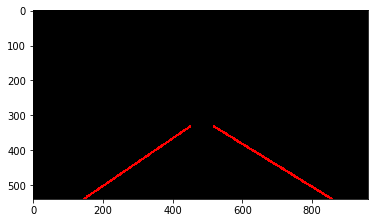

 23%|██▎       | 155/682 [01:38<03:49,  2.30it/s]

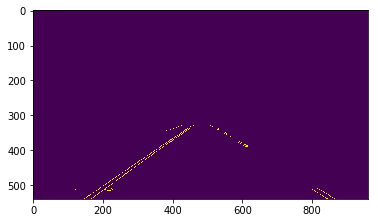

[[-0.67307692]
 [-0.76923077]
 [-0.76923077]
 [-0.72222222]
 [-0.72727273]
 [-0.78571429]
 [-0.6       ]
 [-0.625     ]
 [-0.63636364]
 [ 0.6       ]
 [-0.77777778]
 [ 0.56521739]
 [ 0.52631579]
 [ 0.6       ]
 [-0.6       ]
 [-0.81818182]
 [-0.74193548]
 [-0.6875    ]
 [-0.72972973]
 [-0.64285714]
 [-0.76      ]
 [-0.84615385]
 [ 0.08333333]
 [-0.8       ]
 [ 0.61111111]
 [-0.625     ]
 [-0.33333333]
 [ 0.66666667]
 [-0.41666667]
 [-0.8       ]
 [-0.71428571]
 [-0.6       ]]
left_m = -0.683270479845  right_m = 0.611935888499
left_c = 643.596845728  right_c = 15.6774629524
left_y = 329.975695479  right_y = 377.331573055  min y = 329.975695479
left_y = 542.472814711  right_y = 544.390070615  max y = 544.390070615


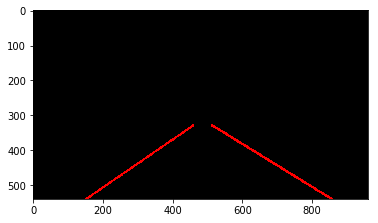

 23%|██▎       | 156/682 [01:38<04:02,  2.17it/s]

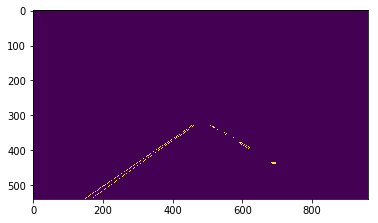

[[-0.74193548]
 [-0.6       ]
 [-0.6       ]
 [-0.65789474]
 [-0.76923077]
 [-0.65909091]
 [-0.58333333]
 [-0.59090909]
 [-0.63333333]
 [-0.71794872]
 [-0.64285714]
 [-0.76470588]
 [-0.8       ]
 [ 0.63157895]
 [-0.76923077]
 [ 0.61538462]
 [-0.66666667]
 [ 0.45454545]
 [-0.63636364]
 [-0.71428571]
 [-0.61538462]
 [-0.75      ]
 [-0.53846154]
 [-0.66666667]
 [-0.91666667]
 [-0.72727273]
 [-0.69230769]
 [ 0.        ]
 [-0.54545455]
 [-0.75      ]
 [-0.83333333]
 [ 0.5       ]]
left_m = -0.691850848721  right_m = 0.567796610169
left_c = 646.581654629  right_c = 43.2429378531
left_y = 332.48136931  right_y = 382.785310734  min y = 332.48136931
left_y = 543.49587817  right_y = 395.276836158  max y = 543.49587817


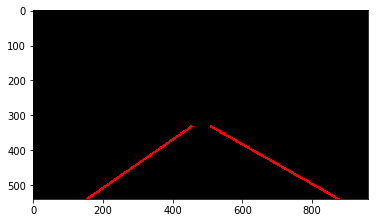

 23%|██▎       | 157/682 [01:39<03:52,  2.26it/s]

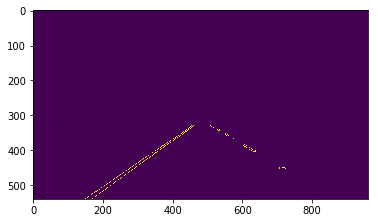

[[-0.6754386 ]
 [-0.703125  ]
 [-0.7195122 ]
 [-0.63636364]
 [-0.71875   ]
 [ 0.57142857]
 [ 0.54545455]
 [-0.70833333]
 [-0.81818182]
 [ 0.5       ]
 [ 0.63333333]
 [-0.71428571]
 [-0.66666667]
 [-0.75      ]
 [-0.91666667]
 [-0.71428571]
 [-0.76470588]]
left_m = -0.682423693182  right_m = 0.577922077922
left_c = 644.863979616  right_c = 36.6168831169
left_y = 334.361199219  right_y = 330.201298701  min y = 330.201298701
left_y = 537.041036094  right_y = 403.597402597  max y = 537.041036094


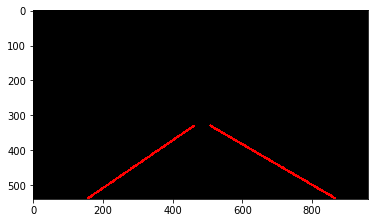

 23%|██▎       | 158/682 [01:39<03:46,  2.32it/s]

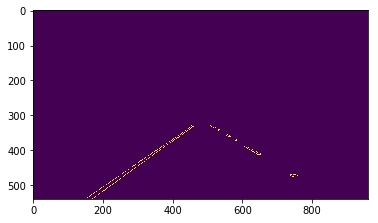

[[-0.75      ]
 [-0.74193548]
 [-0.71428571]
 [-0.75      ]
 [-0.69620253]
 [-0.78378378]
 [-0.75      ]
 [-0.76190476]
 [-0.70588235]
 [-0.78947368]
 [ 0.53333333]
 [ 0.55      ]
 [-0.81818182]
 [-0.81818182]
 [-0.57142857]
 [-0.75      ]
 [ 0.52380952]
 [-0.72727273]
 [-0.75      ]
 [ 0.54545455]]
left_m = -0.702765754537  right_m = 0.491445365802
left_c = 651.405274285  right_c = 91.5694342395
left_y = 328.133027198  right_y = 391.351107379  min y = 328.133027198
left_y = 538.962753559  right_y = 411.500367377  max y = 538.962753559


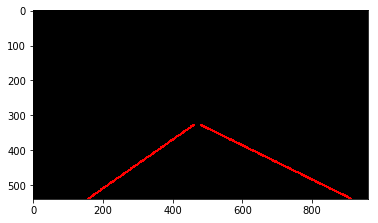

 23%|██▎       | 159/682 [01:40<03:43,  2.34it/s]

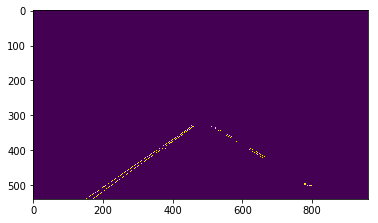

[[-0.65517241]
 [ 0.59259259]
 [-0.75      ]
 [-0.78571429]
 [-0.90909091]
 [-0.82352941]
 [-0.83333333]
 [-0.83333333]
 [ 0.60526316]
 [-0.76923077]
 [-0.73684211]
 [-0.76923077]
 [-0.78571429]
 [-0.64285714]
 [-0.81818182]
 [-0.64705882]
 [-0.64705882]
 [-0.61111111]
 [ 0.6       ]
 [ 0.        ]
 [-0.84615385]
 [-0.63636364]]
left_m = -0.685755550081  right_m = 0.522519685039
left_c = 646.509926995  right_c = 74.015328084
left_y = 333.119640608  right_y = 395.364934383  min y = 333.119640608
left_y = 536.789038982  right_y = 420.445879265  max y = 536.789038982


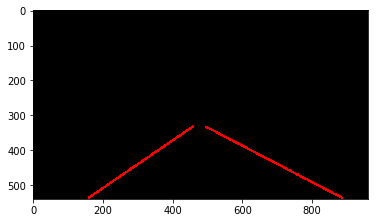

 23%|██▎       | 160/682 [01:40<03:39,  2.38it/s]

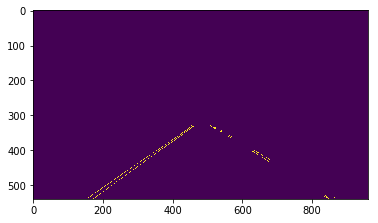

[[-0.72222222]
 [-0.74074074]
 [ 0.72727273]
 [ 0.        ]
 [-0.76923077]
 [ 0.52380952]
 [-0.61111111]
 [-0.8       ]
 [-0.65      ]
 [-0.81818182]
 [-0.8125    ]
 [-0.64705882]
 [-0.75      ]
 [-0.61904762]
 [-0.61538462]
 [-0.66037736]
 [-0.63636364]
 [-0.73913043]
 [ 0.5625    ]
 [-0.72093023]
 [ 0.69230769]
 [-0.6       ]
 [-0.7       ]
 [ 0.68421053]
 [ 0.7       ]
 [-0.5       ]
 [-0.8       ]
 [-0.78571429]
 [-0.84615385]
 [ 0.2       ]
 [-0.58823529]
 [-0.6       ]]
left_m = -0.699599851209  right_m = 0.576475461955
left_c = 651.907251569  right_c = 38.9664829766
left_y = 332.190119566  right_y = 360.639790747  min y = 332.190119566
left_y = 537.872475821  right_y = 435.00512534  max y = 537.872475821


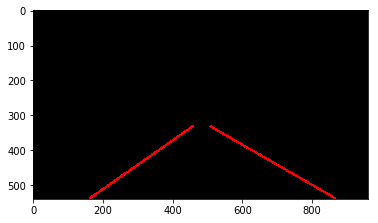

 24%|██▎       | 161/682 [01:40<03:39,  2.38it/s]

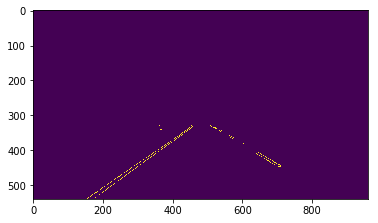

[[-0.76      ]
 [-0.68421053]
 [-0.77777778]
 [-0.84615385]
 [-0.6557377 ]
 [-0.61538462]
 [-0.75      ]
 [-0.6       ]
 [-0.66666667]
 [-0.65217391]
 [-0.7       ]
 [ 0.57692308]
 [-0.63636364]
 [-0.75      ]
 [-0.63636364]
 [ 0.6       ]
 [ 0.58333333]
 [ 0.53846154]
 [-0.76923077]
 [-0.76470588]
 [-0.57142857]
 [-0.83333333]
 [-0.83333333]
 [ 0.54545455]
 [-0.61538462]
 [ 0.4       ]
 [ 0.6       ]
 [ 0.66666667]
 [-0.6       ]
 [-0.76470588]
 [-0.6       ]]
left_m = -0.696670253876  right_m = 0.581840005078
left_c = 651.490358664  right_c = 34.1756481797
left_y = 333.808722897  right_y = 331.495890775  min y = 331.495890775
left_y = 535.843096521  right_y = 447.86389179  max y = 535.843096521


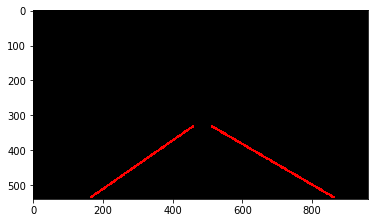

 24%|██▍       | 162/682 [01:41<03:46,  2.30it/s]

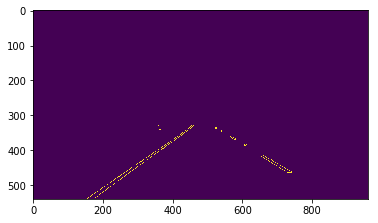

[[-0.7235023 ]
 [-0.625     ]
 [-0.58333333]
 [-0.69565217]
 [ 0.4       ]
 [-0.75      ]
 [ 0.59677419]
 [-0.57142857]
 [-0.7       ]
 [ 0.58823529]
 [ 0.61538462]
 [-0.82352941]
 [ 0.58823529]
 [ 0.57142857]
 [-0.72727273]
 [ 0.53333333]
 [-0.73333333]
 [-0.72      ]
 [ 0.53846154]
 [-0.72727273]]
left_m = -0.693506300501  right_m = 0.604131675184
left_c = 648.739112149  right_c = 19.6719139001
left_y = 329.726213918  right_y = 360.402178704  min y = 329.726213918
left_y = 541.245635571  right_y = 460.688036784  max y = 541.245635571


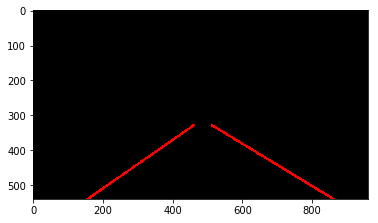

 24%|██▍       | 163/682 [01:41<03:41,  2.34it/s]

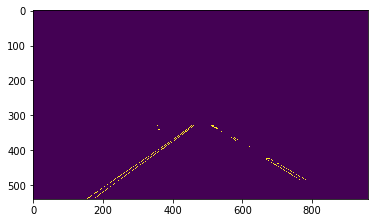

[[-0.68888889]
 [-0.69767442]
 [-0.81818182]
 [-0.75      ]
 [ 0.63157895]
 [-0.7037037 ]
 [ 0.54545455]
 [ 0.59493671]
 [-0.67741935]
 [-0.90909091]
 [-0.84210526]
 [-0.6875    ]
 [-0.78571429]
 [ 0.69230769]
 [ 0.6       ]
 [-0.61538462]
 [ 0.61538462]
 [ 0.56666667]
 [-0.75      ]
 [ 0.5       ]
 [ 0.4       ]
 [-0.81818182]
 [-0.72727273]
 [-0.9       ]
 [ 0.6       ]]
left_m = -0.688993496946  right_m = 0.601001575186
left_c = 649.027675683  right_c = 20.042357741
left_y = 347.248524021  right_y = 361.411252447  min y = 347.248524021
left_y = 542.233683657  right_y = 481.611567484  max y = 542.233683657


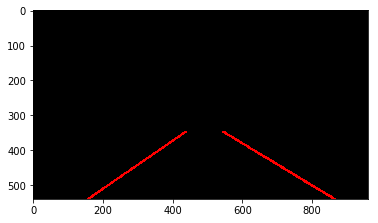

 24%|██▍       | 164/682 [01:42<03:44,  2.30it/s]

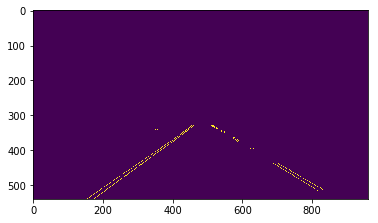

[[-0.65853659]
 [ 0.47368421]
 [ 0.5625    ]
 [-0.77272727]
 [ 0.6875    ]
 [-0.75      ]
 [-0.65      ]
 [-0.73333333]
 [-0.77142857]
 [-0.58333333]
 [-0.8       ]
 [-0.61111111]
 [ 0.66666667]
 [-0.85714286]
 [-0.61538462]
 [-0.78571429]
 [-0.83333333]
 [ 0.6       ]
 [ 0.72727273]
 [-0.73684211]
 [-0.8       ]
 [ 0.53333333]
 [ 0.71428571]
 [-0.65217391]
 [ 0.64705882]
 [ 0.4       ]
 [ 0.6       ]
 [-0.85714286]
 [ 0.53846154]
 [-0.64      ]
 [-0.6       ]
 [-0.6       ]
 [-0.61538462]
 [-0.78571429]
 [-0.8       ]
 [ 0.6       ]]
left_m = -0.698965757328  right_m = 0.590856128595
left_c = 652.416277806  right_c = 28.0196413419
left_y = 335.085823979  right_y = 329.356266925  min y = 329.356266925
left_y = 542.678653905  right_y = 508.976530018  max y = 542.678653905


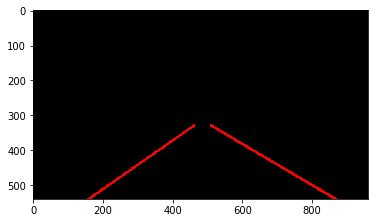

 24%|██▍       | 165/682 [01:42<03:39,  2.35it/s]

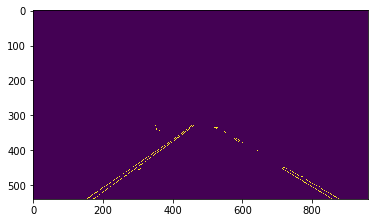

[[ 0.59677419]
 [-0.69491525]
 [-0.78571429]
 [-0.75      ]
 [-0.8       ]
 [ 0.56666667]
 [-0.6       ]
 [-0.85      ]
 [-0.78125   ]
 [-0.67857143]
 [-0.8       ]
 [ 0.5483871 ]
 [-0.66666667]
 [ 0.60869565]
 [-0.72093023]
 [-0.83333333]
 [-0.69230769]
 [-0.61111111]
 [-0.83333333]
 [ 0.53846154]
 [-0.76923077]
 [ 0.6       ]
 [-0.78571429]
 [ 0.6       ]
 [-0.84210526]]
left_m = -0.707317795059  right_m = 0.598074127059
left_c = 655.799680196  right_c = 18.8209101441
left_y = 333.970083444  right_y = 445.845836864  min y = 333.970083444
left_y = 546.165421962  right_y = 537.351178305  max y = 546.165421962


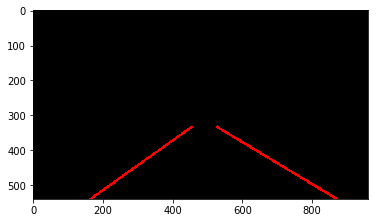

 24%|██▍       | 166/682 [01:43<03:37,  2.37it/s]

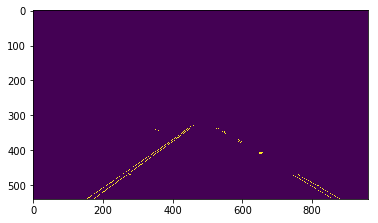

[[-0.7       ]
 [-0.73333333]
 [-0.77272727]
 [-0.77272727]
 [-0.70454545]
 [ 0.5483871 ]
 [ 0.60784314]
 [-0.78378378]
 [-0.79411765]
 [-0.71428571]
 [ 0.52173913]
 [ 0.45454545]
 [-0.71014493]
 [ 0.6       ]
 [ 0.58333333]
 [ 0.59259259]
 [-0.65      ]
 [-0.7       ]
 [-0.63636364]
 [-0.8       ]
 [-0.8       ]
 [-0.6       ]
 [-0.6       ]
 [-0.8       ]
 [-0.83333333]
 [-0.81818182]
 [ 0.54545455]
 [-0.8       ]
 [ 0.5       ]
 [ 0.6       ]
 [ 0.61538462]
 [ 0.6       ]]
left_m = -0.704808629504  right_m = 0.581254074803
left_c = 653.729109905  right_c = 34.6291787525
left_y = 330.221948963  right_y = 372.919050288  min y = 330.221948963
left_y = 531.092408371  right_y = 543.226494205  max y = 543.226494205


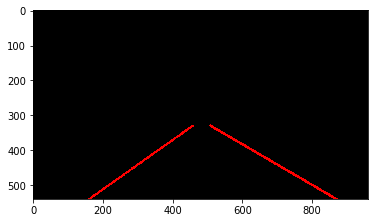

 24%|██▍       | 167/682 [01:43<03:45,  2.29it/s]

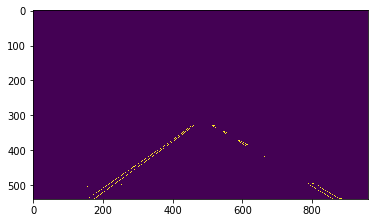

[[-0.7295082 ]
 [-0.71428571]
 [-0.70588235]
 [-0.72093023]
 [-0.76470588]
 [-0.78571429]
 [-0.75      ]
 [ 0.61904762]
 [ 0.5625    ]
 [ 0.63636364]
 [ 0.56756757]
 [-0.78571429]
 [-0.72727273]
 [-0.76190476]
 [-0.73913043]
 [-0.69230769]
 [ 0.57894737]
 [ 0.52941176]
 [-0.70588235]
 [-0.76923077]]
left_m = -0.694290028122  right_m = 0.601253204215
left_c = 648.598745546  right_c = 19.0686414127
left_y = 333.391072779  right_y = 373.206778696  min y = 333.391072779
left_y = 536.12376099  right_y = 534.342637425  max y = 536.12376099


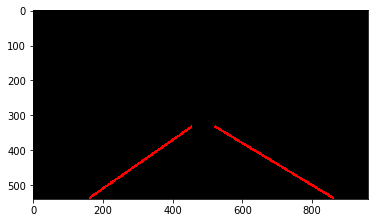

 25%|██▍       | 168/682 [01:43<03:41,  2.32it/s]

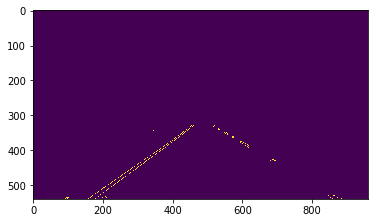

[[-0.77777778]
 [-0.70967742]
 [-0.71428571]
 [-0.8       ]
 [ 0.09090909]
 [-0.625     ]
 [-0.75      ]
 [-0.77777778]
 [-0.81818182]
 [-0.75      ]
 [-0.78571429]
 [ 0.55555556]
 [-0.08333333]
 [ 0.        ]
 [-0.72727273]
 [-0.8125    ]
 [ 0.6       ]
 [-0.75      ]
 [-0.7       ]
 [-0.9       ]
 [ 0.6       ]]
left_m = -0.713053791293  right_m = 0.617467499197
left_c = 656.968521402  right_c = 8.22253389028
left_y = 347.503175981  right_y = 382.407838403  min y = 347.503175981
left_y = 539.314645838  right_y = 538.009648201  max y = 539.314645838


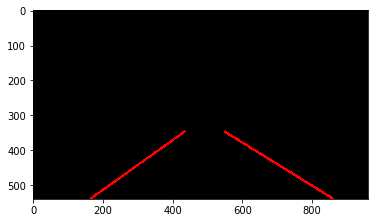

 25%|██▍       | 169/682 [01:44<03:38,  2.35it/s]

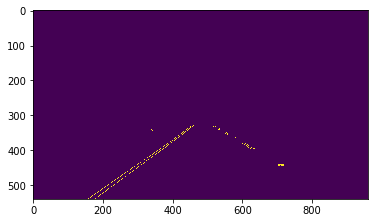

[[-0.75      ]
 [-0.69411765]
 [-0.7037037 ]
 [-0.82352941]
 [-0.6875    ]
 [-0.88235294]
 [ 0.55555556]
 [ 0.6       ]
 [-0.76923077]
 [-0.72      ]
 [-0.80645161]
 [-0.76470588]
 [-0.7       ]
 [-0.76470588]
 [-0.83333333]
 [ 0.64285714]
 [-0.9       ]
 [-0.70588235]
 [ 0.55      ]
 [-0.8       ]
 [-0.7       ]
 [-0.8       ]
 [-0.69230769]]
left_m = -0.716531271119  right_m = 0.615251299827
left_c = 659.128147523  right_c = 9.98440207972
left_y = 330.240294079  right_y = 349.603119584  min y = 330.240294079
left_y = 545.916206686  right_y = 401.284228769  max y = 545.916206686


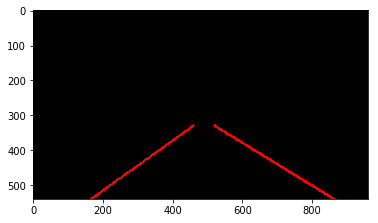

 25%|██▍       | 170/682 [01:44<03:35,  2.38it/s]

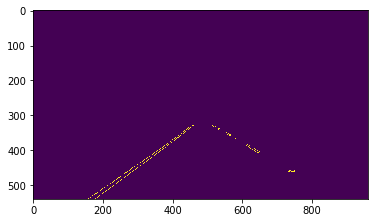

[[-0.75      ]
 [-0.75362319]
 [-0.77777778]
 [-0.75324675]
 [-0.6875    ]
 [-0.6       ]
 [-0.71875   ]
 [ 0.54545455]
 [ 0.55555556]
 [-0.73076923]
 [-0.73333333]
 [-0.75      ]
 [ 0.60869565]
 [-0.83333333]
 [-0.82352941]
 [-0.81818182]
 [ 0.5       ]
 [-0.71428571]
 [-0.64285714]
 [ 0.6       ]
 [-0.76923077]
 [-0.7       ]]
left_m = -0.720500581613  right_m = 0.611686866913
left_c = 658.901453662  right_c = 10.5720475438
left_y = 332.514690191  right_y = 349.446571813  min y = 332.514690191
left_y = 525.608846063  right_y = 400.216581767  max y = 525.608846063


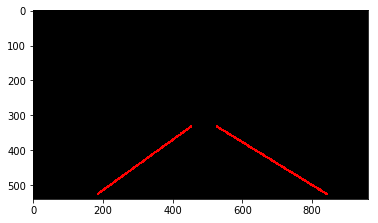

 25%|██▌       | 171/682 [01:45<03:38,  2.33it/s]

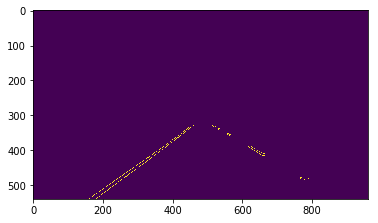

[[-0.75      ]
 [-0.8       ]
 [-0.80769231]
 [-0.81818182]
 [-0.75609756]
 [-0.84615385]
 [-0.6       ]
 [ 0.58333333]
 [ 0.58333333]
 [-0.8       ]
 [ 0.54545455]
 [-0.76923077]
 [-0.63636364]
 [-0.83333333]
 [-0.85714286]
 [-0.92307692]
 [-0.58333333]
 [-0.73076923]
 [-0.78571429]
 [ 0.58333333]
 [-0.8125    ]
 [ 0.57894737]
 [-0.6       ]
 [ 0.54545455]
 [-0.58333333]
 [ 0.        ]
 [-0.6       ]
 [-0.75      ]]
left_m = -0.723503409307  right_m = 0.579089048615
left_c = 661.487651995  right_c = 31.1611844464
left_y = 349.657682584  right_y = 352.555606428  min y = 349.657682584
left_y = 543.556596278  right_y = 406.989976997  max y = 543.556596278


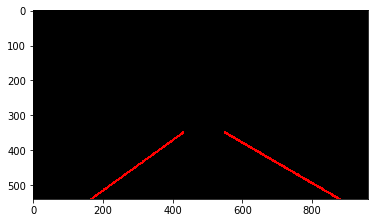

 25%|██▌       | 172/682 [01:45<03:34,  2.37it/s]

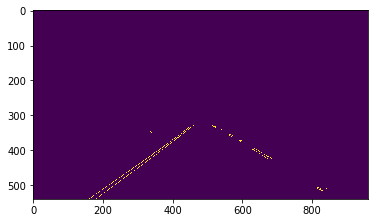

[[-0.80952381]
 [-0.75590551]
 [-0.71794872]
 [-0.83333333]
 [ 0.46153846]
 [ 0.53846154]
 [-0.6       ]
 [-0.84615385]
 [ 0.53846154]
 [-0.8       ]
 [-0.80434783]
 [-0.78947368]
 [-0.88235294]
 [-0.69565217]
 [-0.8       ]
 [ 0.68181818]
 [ 0.75      ]
 [-0.78571429]
 [ 0.46153846]
 [-0.81818182]
 [-0.8       ]
 [-0.8       ]
 [ 0.5       ]
 [-0.6       ]
 [-0.9       ]
 [-0.7       ]
 [-0.75      ]]
left_m = -0.735255164908  right_m = 0.602817703145
left_c = 665.009741906  right_c = 15.4023053935
left_y = 328.262876378  right_y = 352.980219155  min y = 328.262876378
left_y = 545.898405191  right_y = 423.509890423  max y = 545.898405191


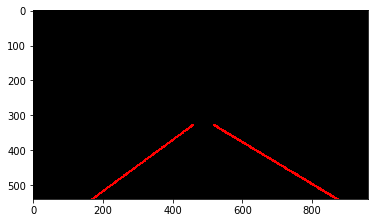

 25%|██▌       | 173/682 [01:46<03:43,  2.27it/s]

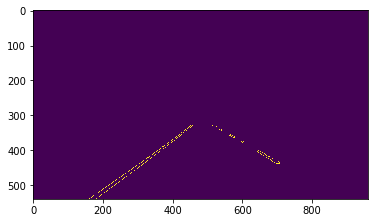

[[-0.64      ]
 [-0.76666667]
 [-0.81081081]
 [-0.8       ]
 [-0.84615385]
 [-0.83333333]
 [ 0.54545455]
 [-0.58333333]
 [ 0.5       ]
 [-0.63636364]
 [-0.63636364]
 [-0.73584906]
 [-0.875     ]
 [ 0.625     ]
 [-0.75      ]
 [ 0.61403509]
 [ 0.58333333]
 [-0.77272727]
 [-0.77777778]
 [-0.66666667]
 [-0.6       ]
 [-0.73333333]
 [-0.83333333]
 [ 0.66666667]
 [-0.64285714]
 [ 0.54545455]
 [ 0.54545455]]
left_m = -0.723973623049  right_m = 0.569913613786
left_c = 662.013211207  right_c = 34.4815494741
left_y = 335.501107212  right_y = 354.203086808  min y = 335.501107212
left_y = 542.557563404  right_y = 430.571511056  max y = 542.557563404


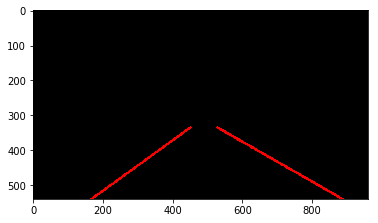

 26%|██▌       | 174/682 [01:46<03:39,  2.31it/s]

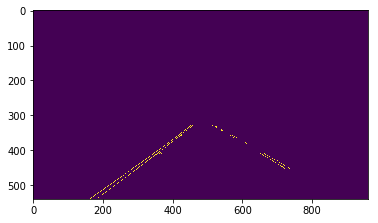

[[-0.76923077]
 [-0.78787879]
 [-0.84615385]
 [ 0.6       ]
 [-0.66666667]
 [-0.78947368]
 [-0.65      ]
 [-0.68888889]
 [-0.64705882]
 [-0.7173913 ]
 [ 0.70588235]
 [ 0.53846154]
 [ 0.5       ]
 [-0.70588235]
 [-0.7       ]
 [-0.58333333]
 [ 0.72727273]
 [-0.73684211]
 [-0.72413793]
 [-0.73529412]
 [ 0.47058824]
 [-0.63636364]
 [-0.69230769]
 [ 0.54545455]
 [ 0.53571429]
 [ 0.64285714]
 [ 0.5       ]
 [-0.66666667]
 [ 0.08333333]
 [-0.75      ]
 [-0.58333333]]
left_m = -0.735449123896  right_m = 0.573621867461
left_c = 666.306692349  right_c = 34.0237411034
left_y = 330.206442728  right_y = 358.120096219  min y = 330.206442728
left_y = 545.69303603  right_y = 447.605107543  max y = 545.69303603


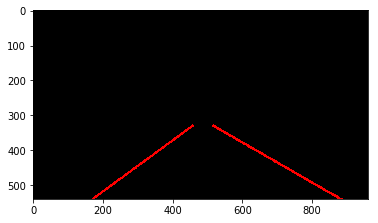

 26%|██▌       | 175/682 [01:46<03:40,  2.30it/s]

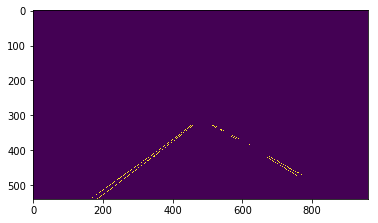

[[-0.70833333]
 [-0.85714286]
 [ 0.3       ]
 [-0.66666667]
 [-0.73684211]
 [-0.8125    ]
 [-0.6969697 ]
 [-0.66666667]
 [ 0.5625    ]
 [-0.85714286]
 [-0.65      ]
 [ 0.53571429]
 [-0.76315789]
 [-0.8       ]
 [ 0.59649123]
 [-0.66666667]
 [-0.86666667]
 [-0.9       ]
 [-0.58333333]
 [ 0.56      ]
 [ 0.53846154]
 [-0.75      ]
 [ 0.59574468]
 [-0.7       ]
 [ 0.6       ]
 [-0.6875    ]
 [-0.84615385]
 [-0.7       ]
 [-0.9       ]]
left_m = -0.743292046589  right_m = 0.582180163901
left_c = 668.889783526  right_c = 26.9218618733
left_y = 335.151654607  right_y = 359.346735461  min y = 335.151654607
left_y = 546.246595839  right_y = 465.885705454  max y = 546.246595839


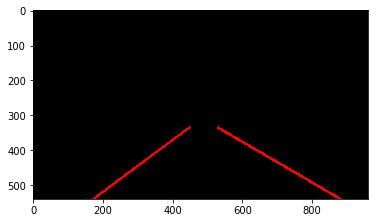

 26%|██▌       | 176/682 [01:47<03:35,  2.34it/s]

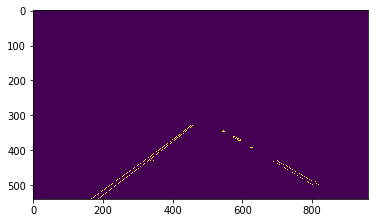

[[-0.78571429]
 [-0.8       ]
 [-0.9       ]
 [-0.73333333]
 [-0.7826087 ]
 [-0.7       ]
 [ 0.55      ]
 [-0.77272727]
 [-0.9       ]
 [-0.85714286]
 [ 0.5       ]
 [-0.68421053]
 [-0.63636364]
 [ 0.5       ]
 [ 0.53333333]
 [-0.76315789]
 [ 0.57142857]
 [ 0.5       ]
 [-0.91666667]
 [-0.75      ]
 [ 0.61111111]
 [-0.8125    ]
 [ 0.5       ]
 [-0.71428571]
 [ 0.36363636]
 [-0.75      ]
 [-0.7       ]
 [-0.75      ]
 [-0.66666667]
 [-0.85714286]
 [ 0.5       ]
 [ 0.53333333]]
left_m = -0.742116946229  right_m = 0.584102557131
left_c = 669.415287302  right_c = 25.1581587569
left_y = 331.009959821  right_y = 363.353539336  min y = 331.009959821
left_y = 544.739640335  right_y = 490.68789679  max y = 544.739640335


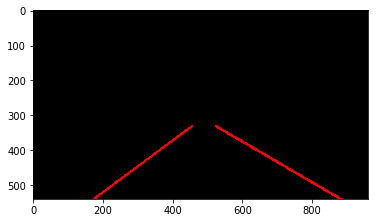

 26%|██▌       | 177/682 [01:47<03:34,  2.36it/s]

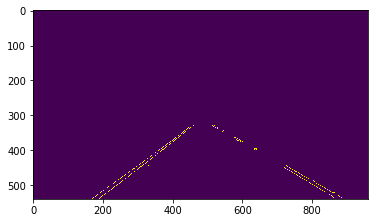

[[ 0.5       ]
 [ 0.53125   ]
 [-0.72925764]
 [ 0.5       ]
 [-0.78787879]
 [-0.83783784]
 [ 0.53333333]
 [ 0.5       ]
 [ 0.52380952]
 [ 0.5       ]
 [-0.72413793]
 [ 0.5       ]
 [ 0.52631579]
 [-0.72413793]
 [ 0.56410256]
 [-0.80555556]
 [-0.71428571]
 [ 0.5       ]
 [ 0.42857143]
 [ 0.57142857]
 [ 0.57142857]
 [-0.92857143]
 [-0.91666667]
 [ 0.        ]
 [ 0.53846154]
 [ 0.55555556]
 [ 0.5       ]
 [-0.75      ]
 [ 0.57142857]
 [-0.72222222]]
left_m = -0.743058584097  right_m = 0.580782946664
left_c = 672.866574599  right_c = 28.7443999003
left_y = 337.747153171  right_y = 363.275377179  min y = 337.747153171
left_y = 547.289673887  right_y = 531.702431711  max y = 547.289673887


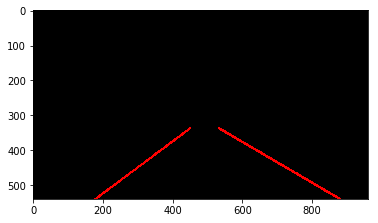

 26%|██▌       | 178/682 [01:48<03:49,  2.19it/s]

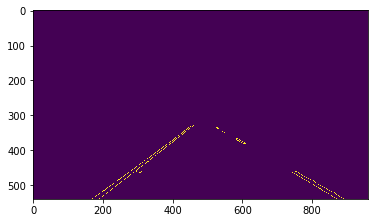

[[-0.73684211]
 [-0.76470588]
 [-0.90909091]
 [-0.875     ]
 [-0.75      ]
 [-0.76923077]
 [ 0.59813084]
 [-0.75      ]
 [ 0.59459459]
 [-0.9       ]
 [-0.6       ]
 [ 0.52777778]
 [ 0.47368421]
 [-0.80555556]
 [-0.81818182]
 [-0.84210526]
 [-0.73684211]
 [-0.7       ]
 [ 0.63157895]
 [ 0.53846154]
 [-0.91666667]
 [-0.81818182]
 [ 0.        ]
 [ 0.66666667]
 [-0.91666667]
 [ 0.45454545]
 [-0.7       ]]
left_m = -0.757581382415  right_m = 0.556165309972
left_c = 676.345180481  right_c = 46.0654936219
left_y = 329.372907335  right_y = 369.753704025  min y = 329.372907335
left_y = 534.677461969  right_y = 538.271792947  max y = 538.271792947


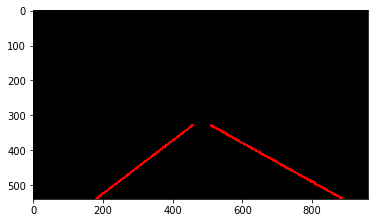

 26%|██▌       | 179/682 [01:48<03:40,  2.28it/s]

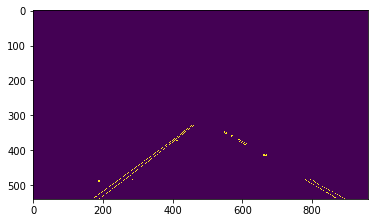

[[-0.8       ]
 [-0.69230769]
 [-0.7826087 ]
 [-0.76666667]
 [ 0.5       ]
 [ 0.52      ]
 [-0.82608696]
 [-0.76923077]
 [-0.75      ]
 [-0.69230769]
 [-0.71428571]
 [-0.85714286]
 [-0.90909091]
 [-0.76      ]
 [ 0.56521739]
 [-0.66666667]
 [-0.69230769]
 [-0.75      ]
 [ 0.5       ]
 [-0.75      ]
 [-0.72727273]
 [ 0.54545455]
 [ 0.58333333]
 [ 0.57142857]
 [ 0.59259259]
 [ 0.625     ]
 [ 0.        ]
 [ 0.6       ]
 [ 0.54545455]
 [ 0.        ]]
left_m = -0.760679716773  right_m = 0.569499858267
left_c = 678.743373799  right_c = 37.1604277928
left_y = 334.155462101  right_y = 371.456844596  min y = 334.155462101
left_y = 543.342384213  right_y = 542.876301934  max y = 543.342384213


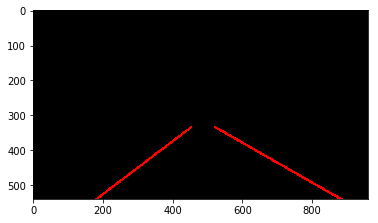

 26%|██▋       | 180/682 [01:49<03:39,  2.29it/s]

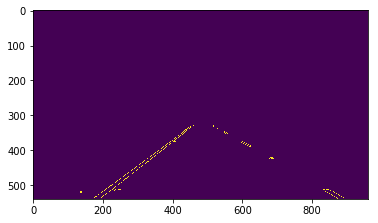

[[-0.9       ]
 [-0.625     ]
 [-0.73684211]
 [-0.75700935]
 [-0.71428571]
 [ 0.57142857]
 [ 0.61538462]
 [-0.83333333]
 [-0.69230769]
 [-0.81818182]
 [ 0.52941176]
 [-0.79166667]
 [ 0.5625    ]
 [-0.8       ]
 [-0.77777778]
 [-0.6       ]
 [-0.61538462]
 [-0.69230769]
 [ 0.58333333]
 [-0.83333333]
 [ 0.55172414]
 [-0.69230769]
 [-0.8       ]
 [-0.71428571]
 [-0.73333333]]
left_m = -0.728606995254  right_m = 0.559748068767
left_c = 666.829689757  right_c = 44.3074233814
left_y = 342.599576869  right_y = 381.835508848  min y = 342.599576869
left_y = 534.223216621  right_y = 544.72219686  max y = 544.72219686


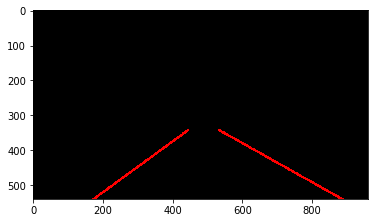

 27%|██▋       | 181/682 [01:49<03:36,  2.31it/s]

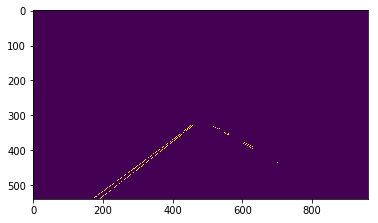

[[-0.8115942 ]
 [-0.79166667]
 [-0.9       ]
 [-0.76785714]
 [-0.84615385]
 [-0.84615385]
 [ 0.5       ]
 [-0.75      ]
 [-0.90909091]
 [-0.86666667]
 [-0.76190476]
 [-0.71428571]
 [ 0.5       ]
 [-0.66666667]
 [-0.84210526]
 [-0.75      ]
 [-0.66666667]
 [-0.85      ]
 [-0.86666667]
 [-0.81818182]
 [-0.83333333]
 [ 0.        ]
 [ 0.58333333]]
left_m = -0.760766158281  right_m = 0.399014778325
left_c = 675.992213336  right_c = 138.435960591
left_y = 332.125909793  right_y = 377.445812808  min y = 332.125909793
left_y = 534.489707895  right_y = 387.820197044  max y = 534.489707895


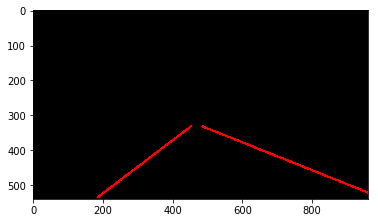

 27%|██▋       | 182/682 [01:50<03:36,  2.31it/s]

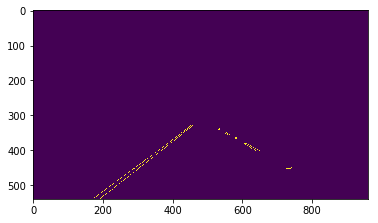

[[-0.07142857]
 [-0.81818182]
 [-0.89473684]
 [-0.83333333]
 [-0.72727273]
 [-0.83333333]
 [-0.77777778]
 [-0.75862069]
 [ 0.59375   ]
 [-0.83333333]
 [-0.8       ]
 [ 0.5       ]
 [-0.9       ]
 [ 0.46666667]
 [-0.9       ]
 [-0.75      ]
 [-0.76923077]
 [-0.84615385]
 [ 0.5       ]]
left_m = -0.73743464271  right_m = 0.606382978723
left_c = 666.313697019  right_c = 11.5425531915
left_y = 340.367584941  right_y = 379.617021277  min y = 340.367584941
left_y = 540.212373115  right_y = 399.021276596  max y = 540.212373115


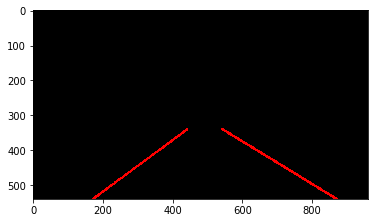

 27%|██▋       | 183/682 [01:50<03:32,  2.35it/s]

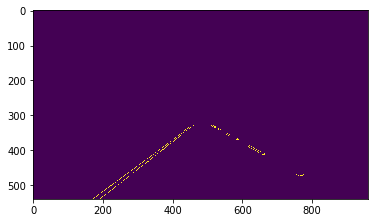

[[-0.84615385]
 [-0.71428571]
 [-0.75      ]
 [-0.76923077]
 [-0.73684211]
 [-0.84615385]
 [-0.91666667]
 [-0.73684211]
 [-0.90909091]
 [ 0.45454545]
 [ 0.55813953]
 [ 0.        ]
 [-0.75      ]
 [-0.66666667]
 [-0.77142857]
 [ 0.47058824]
 [-0.8       ]
 [-0.8125    ]
 [-1.        ]
 [-0.84615385]
 [-0.69230769]
 [-0.72222222]
 [-0.9       ]
 [-0.7       ]]
left_m = -0.750313214398  right_m = 0.558139534884
left_c = 672.783048008  right_c = 45.3023255814
left_y = 334.391788315  right_y = 388.0  min y = 334.391788315
left_y = 543.729175132  right_y = 412.0  max y = 543.729175132


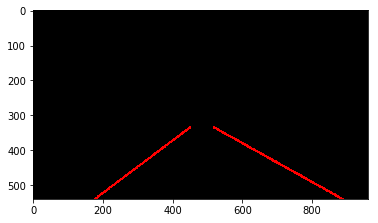

 27%|██▋       | 184/682 [01:50<03:46,  2.20it/s]

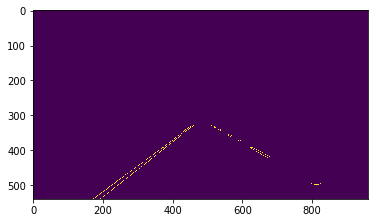

[[-0.83333333]
 [-0.84615385]
 [-0.91666667]
 [-0.75824176]
 [-0.90909091]
 [-0.9       ]
 [ 0.53846154]
 [-0.77083333]
 [-0.77083333]
 [-0.68181818]
 [ 0.5862069 ]
 [-0.83333333]
 [-1.        ]
 [ 0.50943396]
 [-0.85714286]
 [-0.8       ]
 [ 0.47368421]
 [-0.86666667]
 [-0.76923077]
 [-1.        ]
 [-0.9       ]
 [-0.72727273]
 [ 0.5       ]]
left_m = -0.778862564749  right_m = 0.567624268621
left_c = 684.696349028  right_c = 37.9138790786
left_y = 347.448858491  right_y = 355.783469506  min y = 347.448858491
left_y = 549.174262761  right_y = 423.898381741  max y = 549.174262761


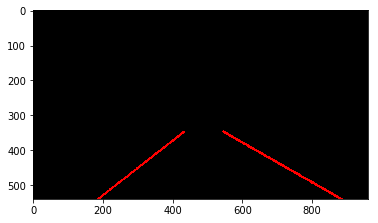

 27%|██▋       | 185/682 [01:51<03:37,  2.29it/s]

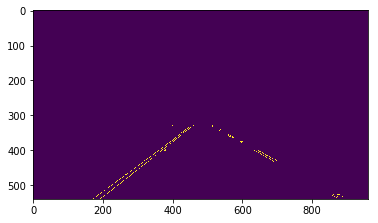

[[-0.73684211]
 [-0.775     ]
 [-0.72727273]
 [-0.8       ]
 [-0.81395349]
 [-0.86363636]
 [ 0.56521739]
 [-0.75      ]
 [-0.84210526]
 [ 0.52173913]
 [ 0.52380952]
 [-0.88235294]
 [-0.64285714]
 [-1.        ]
 [ 0.54545455]
 [-0.9       ]
 [ 0.46153846]
 [-0.69230769]
 [-0.76923077]
 [ 0.54545455]
 [ 0.5       ]]
left_m = -0.77316729202  right_m = 0.520526271963
left_c = 681.546739056  right_c = 68.7096344408
left_y = 332.848290355  right_y = 398.723290865  min y = 332.848290355
left_y = 547.788797536  right_y = 431.516445999  max y = 547.788797536


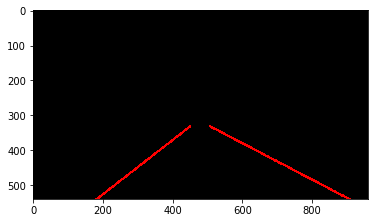

 27%|██▋       | 186/682 [01:51<03:31,  2.35it/s]

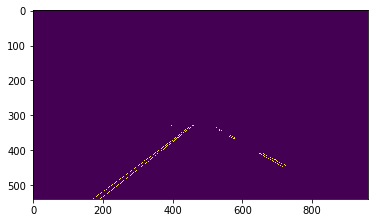

[[-0.73846154]
 [-0.69230769]
 [-0.75      ]
 [-0.73684211]
 [ 0.54545455]
 [-0.75      ]
 [-0.85714286]
 [-0.63636364]
 [-0.75      ]
 [ 0.55172414]
 [-0.8125    ]
 [-0.63636364]
 [ 0.52      ]
 [-0.76923077]
 [-0.71428571]
 [-0.66666667]
 [-0.71428571]
 [-0.9       ]
 [-0.66666667]
 [-0.90909091]
 [ 0.53846154]
 [-0.8       ]
 [-0.7       ]
 [-0.79166667]
 [-0.76470588]
 [ 0.54545455]]
left_m = -0.74794142776  right_m = 0.586332712704
left_c = 672.799125096  right_c = 26.5473793232
left_y = 333.98165832  right_y = 357.825362001  min y = 333.98165832
left_y = 543.405258093  right_y = 446.947934332  max y = 543.405258093


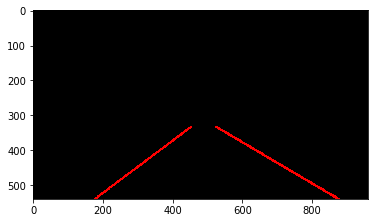

 27%|██▋       | 187/682 [01:52<03:29,  2.37it/s]

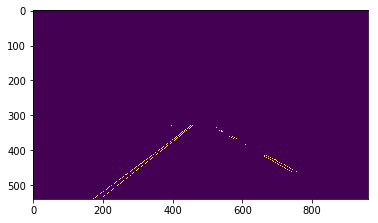

[[-0.8125    ]
 [-0.8       ]
 [-0.79310345]
 [ 0.52173913]
 [ 0.52380952]
 [ 0.5625    ]
 [ 0.57142857]
 [ 0.47368421]
 [ 0.55555556]
 [-0.81428571]
 [-0.63636364]
 [ 0.53658537]
 [-0.8       ]
 [-0.85714286]
 [-0.9       ]
 [-0.9       ]
 [-0.79166667]
 [-0.875     ]
 [-0.88888889]
 [-0.875     ]
 [-0.8       ]
 [-0.93333333]
 [ 0.53333333]
 [ 0.52631579]
 [ 0.53333333]
 [-0.81818182]
 [ 0.5       ]]
left_m = -0.771243083002  right_m = 0.553698283979
left_c = 680.708460606  right_c = 47.6646277839
left_y = 329.021614756  right_y = 359.396761664  min y = 329.021614756
left_y = 528.002330171  right_y = 462.384642484  max y = 528.002330171


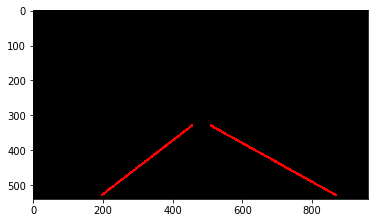

 28%|██▊       | 188/682 [01:52<03:26,  2.39it/s]

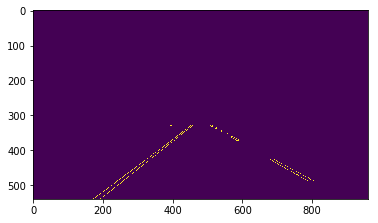

[[-0.75206612]
 [ 0.45454545]
 [-0.84615385]
 [-0.8       ]
 [-0.91666667]
 [-0.8030303 ]
 [-0.79069767]
 [ 0.5625    ]
 [-0.88235294]
 [-0.85      ]
 [-0.81818182]
 [ 0.55555556]
 [ 0.5       ]
 [-0.69565217]
 [-0.73076923]
 [ 0.6       ]
 [ 0.53333333]
 [ 0.57142857]
 [ 0.46153846]
 [ 0.5       ]
 [ 0.5625    ]
 [ 0.5       ]
 [ 0.46153846]
 [ 0.        ]
 [ 0.46153846]
 [ 0.5       ]]
left_m = -0.763726520738  right_m = 0.543824233284
left_c = 678.12810498  right_c = 53.707692347
left_y = 342.088435856  right_y = 361.512208386  min y = 342.088435856
left_y = 546.003416893  right_y = 480.065891242  max y = 546.003416893


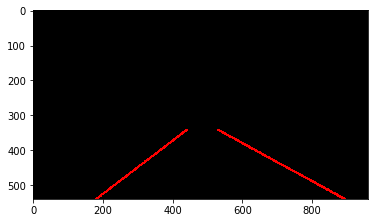

 28%|██▊       | 189/682 [01:53<03:36,  2.27it/s]

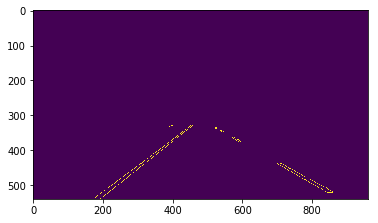

[[-0.75      ]
 [-0.75      ]
 [ 0.51428571]
 [-0.85714286]
 [-0.92307692]
 [ 0.5       ]
 [-0.7       ]
 [ 0.5       ]
 [-0.7       ]
 [ 0.45454545]
 [-1.        ]
 [ 0.51515152]
 [-0.72222222]
 [ 0.5       ]
 [-0.83333333]
 [-0.70588235]
 [ 0.62068966]
 [ 0.57575758]
 [-0.66666667]
 [-0.70588235]
 [ 0.6       ]
 [-0.66666667]
 [-1.        ]
 [-0.85      ]
 [-0.93333333]
 [ 0.55555556]
 [-0.72727273]
 [ 0.52941176]
 [-0.75      ]
 [-0.85      ]
 [-0.64285714]
 [ 0.5       ]
 [ 0.72727273]
 [-0.76470588]
 [ 0.53846154]
 [ 0.6       ]
 [-0.90909091]]
left_m = -0.747536721969  right_m = 0.546265823712
left_c = 671.482214631  right_c = 52.6970788824
left_y = 329.857932692  right_y = 364.614864222  min y = 329.857932692
left_y = 540.663288287  right_y = 508.829041682  max y = 540.663288287


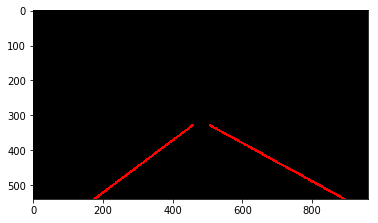

 28%|██▊       | 190/682 [01:53<03:31,  2.33it/s]

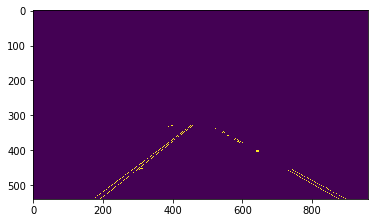

[[ 0.53703704]
 [-0.83870968]
 [-0.81081081]
 [-0.73417722]
 [-0.81481481]
 [ 0.5       ]
 [ 0.6       ]
 [-0.84615385]
 [-0.82758621]
 [-0.63636364]
 [-0.6875    ]
 [ 0.5625    ]
 [ 0.47058824]
 [-0.92307692]
 [ 0.52631579]
 [ 0.44444444]
 [-0.81818182]
 [-0.6       ]
 [-0.6875    ]
 [-0.81818182]
 [-0.91666667]
 [-0.9       ]
 [-0.7       ]
 [ 0.55555556]
 [-1.        ]
 [ 0.5       ]
 [-0.66666667]
 [-0.66666667]
 [-0.92307692]
 [ 0.45454545]
 [ 0.52173913]
 [ 0.47058824]
 [-0.75      ]
 [-1.        ]
 [ 0.5       ]]
left_m = -0.769215710623  right_m = 0.559913864101
left_c = 678.169431023  right_c = 46.2004954077
left_y = 327.407066979  right_y = 372.070364315  min y = 327.407066979
left_y = 544.325897375  right_y = 535.005298768  max y = 544.325897375


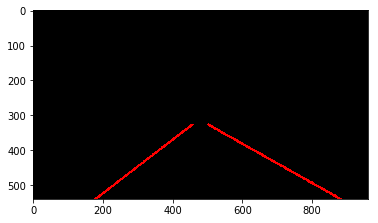

 28%|██▊       | 191/682 [01:53<03:31,  2.32it/s]

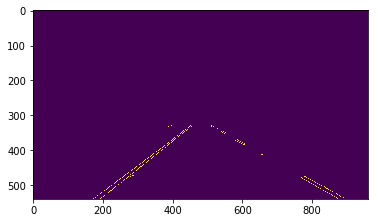

[[-0.75324675]
 [-0.75757576]
 [-0.80898876]
 [-0.76470588]
 [ 0.60869565]
 [ 0.51020408]
 [ 0.47619048]
 [ 0.6       ]
 [ 0.5       ]
 [ 0.56521739]
 [ 0.58823529]
 [-0.69230769]
 [-0.81578947]
 [-0.88888889]
 [-0.63636364]
 [-0.70588235]
 [-0.76470588]
 [ 0.6       ]
 [ 0.55      ]
 [ 0.54545455]
 [-0.7       ]
 [-0.66666667]
 [ 0.5       ]
 [-0.875     ]
 [ 0.3       ]
 [ 0.5       ]]
left_m = -0.785250312079  right_m = 0.552580041682
left_c = 686.707070624  right_c = 49.5858401228
left_y = 364.754442672  right_y = 369.529684257  min y = 364.754442672
left_y = 537.509511329  right_y = 531.988216511  max y = 537.509511329


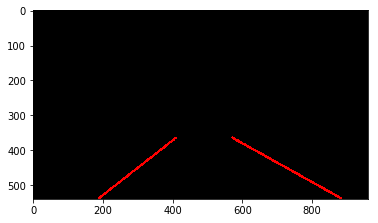

 28%|██▊       | 192/682 [01:54<03:27,  2.36it/s]

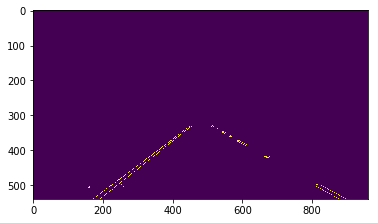

[[-0.73333333]
 [ 0.53846154]
 [-0.77906977]
 [-0.66666667]
 [-0.78947368]
 [-0.78333333]
 [ 0.52941176]
 [ 0.44444444]
 [ 0.56666667]
 [-0.9       ]
 [-0.8       ]
 [-0.78947368]
 [-0.9       ]
 [-0.92307692]
 [-0.76470588]
 [-0.90909091]
 [ 0.64285714]
 [ 0.53846154]
 [ 0.53333333]]
left_m = -0.76081550523  right_m = 0.545298538992
left_c = 674.969116726  right_c = 55.5902119617
left_y = 340.97110993  right_y = 374.044558733  min y = 340.97110993
left_y = 534.218248258  right_y = 543.63240436  max y = 543.63240436


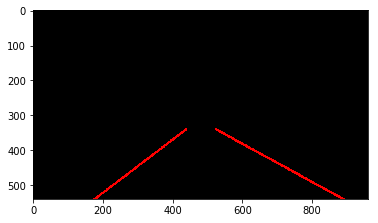

 28%|██▊       | 193/682 [01:54<03:28,  2.35it/s]

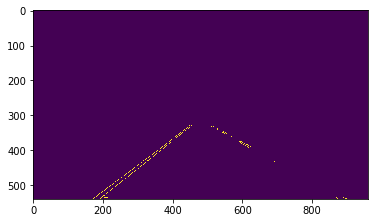

[[-0.75342466]
 [-0.81132075]
 [-0.74285714]
 [-0.9       ]
 [-0.64285714]
 [ 0.53846154]
 [-0.75      ]
 [-0.58333333]
 [-0.61538462]
 [-0.775     ]
 [-0.8       ]
 [-0.7826087 ]
 [ 0.54166667]
 [-0.84615385]
 [-0.83333333]
 [-0.69230769]
 [-0.7       ]
 [-0.7       ]
 [-0.8       ]]
left_m = -0.753332715408  right_m = 0.533869885983
left_c = 671.876072539  right_c = 59.476861167
left_y = 330.616352459  right_y = 374.460093897  min y = 330.616352459
left_y = 533.262852904  right_y = 387.27297116  max y = 533.262852904


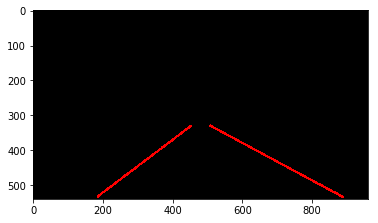

 28%|██▊       | 194/682 [01:55<03:26,  2.37it/s]

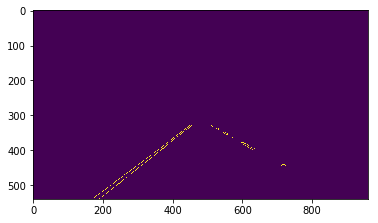

[[-0.85714286]
 [-0.8       ]
 [-0.81034483]
 [-0.74      ]
 [-0.81196581]
 [ 0.57142857]
 [-0.9       ]
 [-0.75      ]
 [-0.61538462]
 [-0.8       ]
 [-0.8       ]
 [-0.9       ]
 [-0.8       ]
 [ 0.53333333]
 [-0.72727273]
 [ 0.58823529]
 [-0.78571429]]
left_m = -0.781561395135  right_m = 0.567164179104
left_c = 679.825115831  right_c = 39.9850746269
left_y = 330.467172205  right_y = 381.417910448  min y = 330.467172205
left_y = 538.362503311  right_y = 391.059701493  max y = 538.362503311


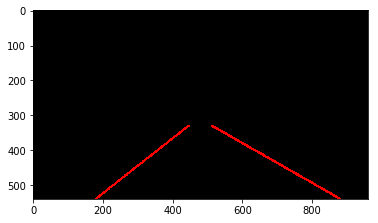

 29%|██▊       | 195/682 [01:55<03:33,  2.28it/s]

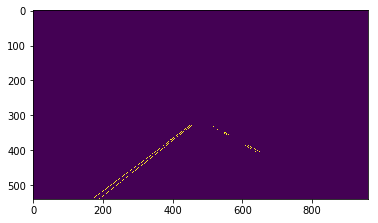

[[-0.85714286]
 [-0.64285714]
 [-0.86363636]
 [ 0.52173913]
 [-0.69230769]
 [-0.90909091]
 [-0.7       ]
 [-0.77083333]
 [-0.72727273]
 [-0.79310345]
 [-0.84615385]
 [-0.83333333]
 [-0.73684211]
 [-0.79411765]
 [-0.90909091]
 [-0.72413793]
 [ 0.54545455]
 [-1.        ]
 [ 0.54545455]
 [ 0.5       ]]
left_m = -0.755692924358  right_m = 0.566254900378
left_c = 671.895080353  right_c = 39.4909886876
left_y = 340.14588656  right_y = 349.798674095  min y = 340.14588656
left_y = 541.915897364  right_y = 407.556673933  max y = 541.915897364


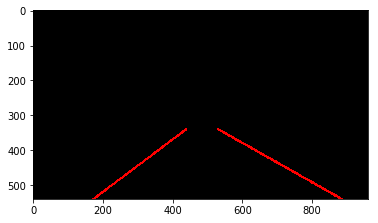

 29%|██▊       | 196/682 [01:56<03:30,  2.31it/s]

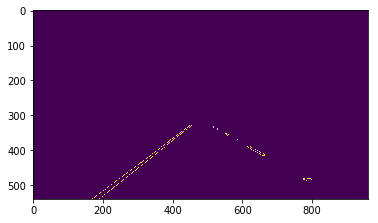

[[-0.75925926]
 [-0.82142857]
 [ 0.5       ]
 [-0.73611111]
 [-0.79411765]
 [ 0.57894737]
 [-0.78205128]
 [ 0.5       ]
 [-0.77777778]
 [ 0.5       ]
 [-0.76923077]
 [-0.78571429]
 [-0.73684211]
 [-0.70588235]
 [-0.84615385]
 [-0.75      ]
 [-0.83333333]
 [-0.78571429]
 [-0.78571429]
 [-0.07142857]]
left_m = -0.767836849604  right_m = 0.41582061663
left_c = 676.469325299  right_c = 135.674244784
left_y = 334.014090376  right_y = 390.156462161  min y = 334.014090376
left_y = 545.169224017  right_y = 412.194954843  max y = 545.169224017


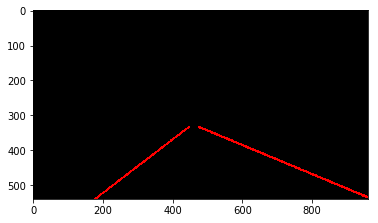

 29%|██▉       | 197/682 [01:56<03:25,  2.36it/s]

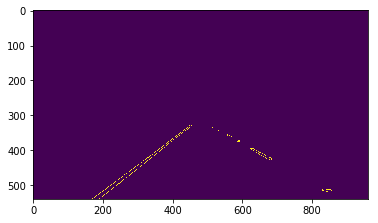

[[-0.72916667]
 [-0.9       ]
 [ 0.57407407]
 [-0.7       ]
 [-0.78740157]
 [ 0.        ]
 [ 0.6       ]
 [-0.85714286]
 [-0.90909091]
 [-0.92857143]
 [-0.73076923]
 [-0.83333333]
 [-0.78947368]
 [-0.69230769]
 [-0.72727273]
 [ 0.25      ]
 [-0.7       ]
 [ 0.57142857]
 [ 0.57142857]
 [ 0.        ]
 [-0.74074074]
 [-0.78947368]
 [-0.66666667]]
left_m = -0.774993202707  right_m = 0.519880130572
left_c = 678.487249439  right_c = 71.6784395569
left_y = 335.16526064  right_y = 395.043880773  min y = 335.16526064
left_y = 545.963411777  right_y = 423.117407824  max y = 545.963411777


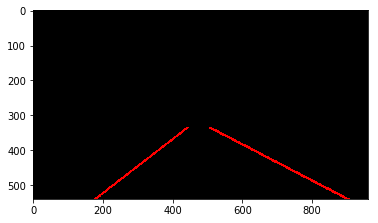

 29%|██▉       | 198/682 [01:56<03:27,  2.34it/s]

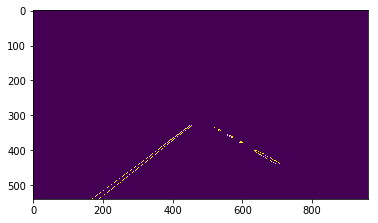

[[ 0.45454545]
 [-0.72727273]
 [-0.70588235]
 [-0.85714286]
 [-0.69565217]
 [ 0.        ]
 [ 0.5       ]
 [-0.9       ]
 [-0.73913043]
 [ 0.6       ]
 [-0.85714286]
 [-0.85      ]
 [-0.73684211]
 [-0.72727273]
 [-0.66666667]
 [-0.91666667]
 [-0.6       ]
 [-0.9       ]
 [-0.63636364]
 [-0.84      ]
 [-0.58333333]
 [-0.69565217]
 [ 0.64285714]
 [ 0.57142857]
 [ 0.6       ]
 [-0.90909091]
 [ 0.57142857]
 [ 0.5       ]]
left_m = -0.752450778808  right_m = 0.478527817795
left_c = 670.14259592  right_c = 99.9643616656
left_y = 338.311802466  right_y = 407.657748508  min y = 338.311802466
left_y = 542.225963523  right_y = 438.762056665  max y = 542.225963523


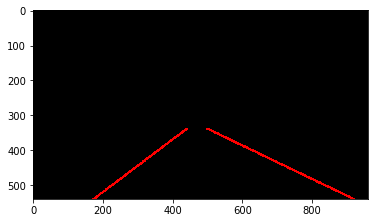

 29%|██▉       | 199/682 [01:57<03:24,  2.37it/s]

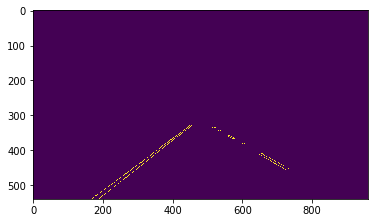

[[-0.63636364]
 [-0.88888889]
 [-0.6       ]
 [-0.80769231]
 [ 0.55      ]
 [-0.69230769]
 [-0.73333333]
 [-0.64285714]
 [ 0.57894737]
 [ 0.52941176]
 [-0.72727273]
 [ 0.54761905]
 [-0.7       ]
 [-0.70588235]
 [-0.71428571]
 [-0.6       ]
 [-0.83333333]
 [-0.72727273]
 [-0.72727273]
 [ 0.53333333]
 [-0.66666667]
 [-0.6       ]
 [-0.74358974]
 [-0.68421053]
 [ 0.5       ]
 [-0.90909091]]
left_m = -0.734667265561  right_m = 0.563380176576
left_c = 665.097806028  right_c = 42.8275357668
left_y = 335.232203791  right_y = 359.447195003  min y = 335.232203791
left_y = 541.673705414  right_y = 451.278163785  max y = 541.673705414


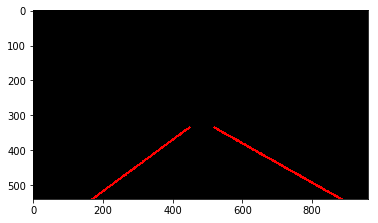

 29%|██▉       | 200/682 [01:57<03:31,  2.28it/s]

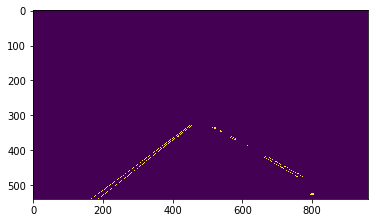

[[-0.76086957]
 [ 0.        ]
 [-0.8       ]
 [-0.78873239]
 [ 0.59375   ]
 [-0.73404255]
 [-0.73333333]
 [-0.77777778]
 [-0.77777778]
 [-0.9       ]
 [ 0.64705882]
 [ 0.55555556]
 [-0.9       ]
 [-0.78571429]
 [ 0.58823529]
 [-0.77272727]
 [-0.8       ]
 [-0.73684211]
 [-0.75      ]
 [-0.75      ]
 [-0.78571429]
 [-0.86666667]
 [ 0.57142857]
 [-0.75      ]
 [ 0.54545455]
 [ 0.54545455]]
left_m = -0.770338065995  right_m = 0.580922688716
left_c = 676.397451648  right_c = 32.7180205308
left_y = 326.663969686  right_y = 359.777494278  min y = 326.663969686
left_y = 547.750994627  right_y = 472.476495889  max y = 547.750994627


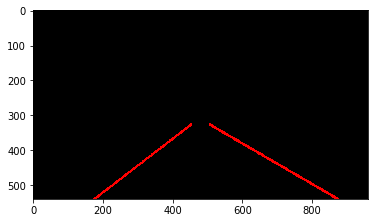

 29%|██▉       | 201/682 [01:58<03:27,  2.32it/s]

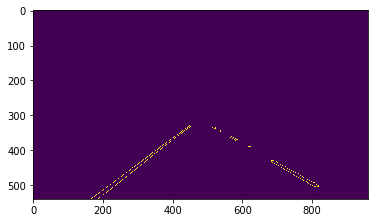

[[-0.6       ]
 [ 0.57407407]
 [-0.83333333]
 [-0.81818182]
 [-0.7       ]
 [-0.70588235]
 [-0.69565217]
 [-0.69230769]
 [-0.63636364]
 [-0.66666667]
 [-0.80882353]
 [-0.76666667]
 [-0.71428571]
 [ 0.47619048]
 [ 0.5       ]
 [ 0.47058824]
 [-0.69230769]
 [ 0.5       ]
 [ 0.46666667]
 [-0.68421053]
 [-0.86666667]
 [ 0.56      ]
 [ 0.5       ]
 [-0.68421053]
 [ 0.53333333]
 [-0.7       ]
 [-0.90909091]
 [ 0.35714286]
 [ 0.6       ]
 [-0.63636364]
 [-0.875     ]
 [ 0.57894737]]
left_m = -0.759620298208  right_m = 0.568771091987
left_c = 670.848357681  right_c = 40.41829594
left_y = 327.499982891  right_y = 362.911505097  min y = 327.499982891
left_y = 543.99176788  right_y = 507.379362461  max y = 543.99176788


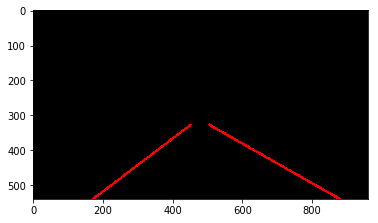

 30%|██▉       | 202/682 [01:58<03:23,  2.36it/s]

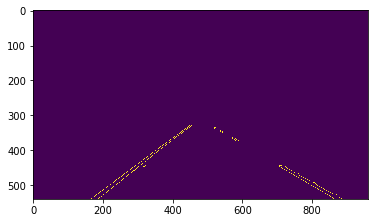

[[ 0.55      ]
 [-0.63636364]
 [-0.75308642]
 [ 0.6       ]
 [-0.775     ]
 [-0.77142857]
 [-0.76190476]
 [ 0.55769231]
 [ 0.57142857]
 [ 0.52380952]
 [-0.8       ]
 [-0.84210526]
 [ 0.5       ]
 [-0.75      ]
 [ 0.57575758]
 [-0.75      ]
 [ 0.58823529]
 [-0.78125   ]
 [-0.73333333]
 [-0.76470588]
 [-0.72727273]
 [ 0.6       ]
 [-0.75      ]
 [ 0.61538462]
 [-0.76470588]
 [-0.8       ]]
left_m = -0.760490132377  right_m = 0.579788406805
left_c = 673.440369388  right_c = 33.2610918559
left_y = 333.501280215  right_y = 363.160695328  min y = 333.501280215
left_y = 546.438517281  right_y = 532.458910115  max y = 546.438517281


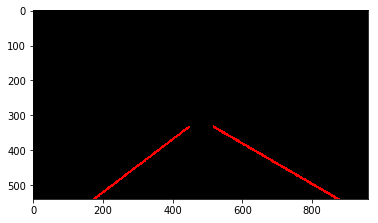

 30%|██▉       | 203/682 [01:59<03:22,  2.37it/s]

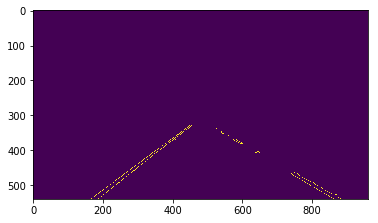

[[ 0.58064516]
 [-0.9       ]
 [-0.84615385]
 [-0.72881356]
 [ 0.55769231]
 [-0.78571429]
 [ 0.5625    ]
 [-0.72413793]
 [-0.7       ]
 [-0.76056338]
 [ 0.52631579]
 [-0.8       ]
 [-0.63636364]
 [-0.8       ]
 [ 0.45454545]
 [ 0.55      ]
 [ 0.55      ]
 [-0.78571429]
 [-0.78571429]
 [-0.82352941]
 [-0.8       ]
 [ 0.5       ]
 [-0.66666667]
 [-0.63636364]
 [ 0.5       ]
 [-0.84615385]
 [ 0.54545455]
 [ 0.45454545]]
left_m = -0.754837832843  right_m = 0.595791678181
left_c = 668.848492876  right_c = 23.3868918648
left_y = 326.906954598  right_y = 368.94606521  min y = 326.906954598
left_y = 542.790574792  right_y = 536.363526779  max y = 542.790574792


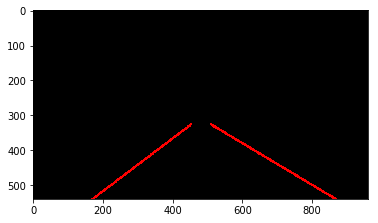

 30%|██▉       | 204/682 [01:59<03:19,  2.40it/s]

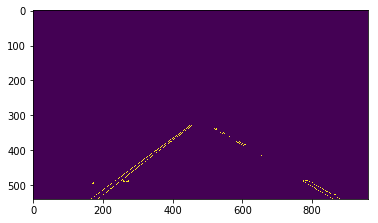

[[-0.85      ]
 [-0.875     ]
 [-0.81081081]
 [ 0.52941176]
 [-0.75862069]
 [-0.75675676]
 [-0.72727273]
 [-0.85714286]
 [-0.76923077]
 [-0.90909091]
 [ 0.59459459]
 [-0.7       ]
 [ 0.5       ]
 [ 0.5       ]
 [ 0.57142857]
 [-0.76666667]
 [ 0.55555556]
 [-0.8       ]
 [-0.84615385]
 [ 0.66666667]
 [ 0.57142857]
 [ 0.63636364]
 [-0.75      ]
 [ 0.3       ]
 [-0.66666667]
 [-0.63636364]
 [ 0.        ]
 [-0.73333333]
 [-0.66666667]]
left_m = -0.751368669887  right_m = 0.587972213404
left_c = 670.588065121  right_c = 29.9838399117
left_y = 330.218057662  right_y = 372.183668113  min y = 330.218057662
left_y = 541.3526539  right_y = 534.463999012  max y = 541.3526539


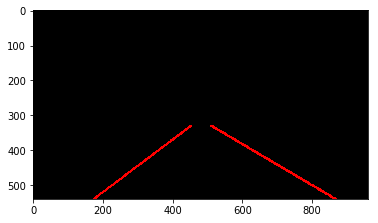

 30%|███       | 205/682 [01:59<03:27,  2.30it/s]

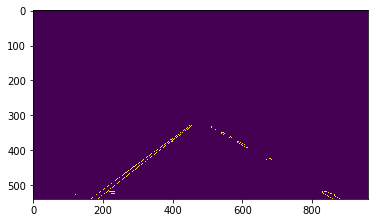

[[-0.73333333]
 [-0.6875    ]
 [-0.8       ]
 [-0.83870968]
 [-0.91666667]
 [ 0.        ]
 [-0.66666667]
 [ 0.63636364]
 [-0.85714286]
 [ 0.55      ]
 [-0.74418605]
 [-0.88888889]
 [-0.72727273]
 [-0.78947368]
 [-0.83333333]
 [-0.69230769]
 [ 0.53571429]
 [-0.7       ]
 [-0.81818182]
 [-0.63636364]
 [-0.72727273]
 [ 0.53846154]]
left_m = -0.748617280763  right_m = 0.599878787759
left_c = 669.172962747  right_c = 23.9877728142
left_y = 339.781359211  right_y = 374.916863653  min y = 339.781359211
left_y = 535.919086771  right_y = 538.683772711  max y = 538.683772711


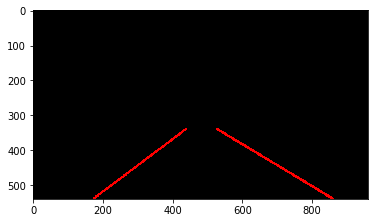

 30%|███       | 206/682 [02:00<03:31,  2.25it/s]

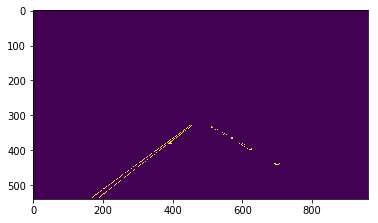

[[-0.86363636]
 [-0.73493976]
 [-0.76106195]
 [-0.84615385]
 [-0.69230769]
 [-0.91666667]
 [-0.77142857]
 [-0.78571429]
 [-0.86956522]
 [ 0.52380952]
 [ 0.57142857]
 [-0.9       ]
 [ 0.61111111]
 [-0.66666667]
 [-0.7       ]
 [ 0.5       ]
 [-0.81818182]
 [-0.74358974]
 [-0.73333333]
 [-0.91666667]
 [-0.73684211]
 [-0.6       ]
 [-0.8       ]
 [-0.81818182]]
left_m = -0.751776746807  right_m = 0.60498489426
left_c = 667.900409034  right_c = 21.0540030211
left_y = 327.34554273  right_y = 350.165785498  min y = 327.34554273
left_y = 543.85724581  right_y = 400.379531722  max y = 543.85724581


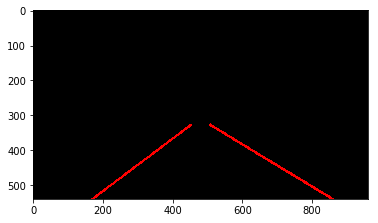

 30%|███       | 207/682 [02:00<03:30,  2.26it/s]

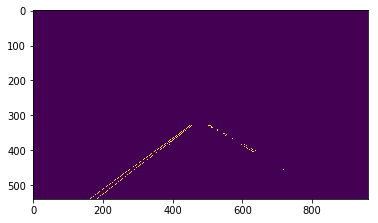

[[-0.70588235]
 [-0.66666667]
 [-0.76190476]
 [-0.71794872]
 [ 0.6       ]
 [-0.72727273]
 [-0.76923077]
 [-0.6       ]
 [-0.85714286]
 [ 0.56521739]
 [-0.6       ]
 [-0.66666667]
 [-0.6875    ]
 [-0.77419355]
 [-0.63636364]
 [-0.66666667]
 [-0.78787879]
 [-0.7       ]
 [-0.69565217]
 [ 0.55555556]
 [-0.6       ]
 [ 0.18181818]
 [-0.85714286]
 [-0.90909091]
 [-0.7       ]
 [-0.6       ]
 [ 0.53846154]]
left_m = -0.734922870858  right_m = 0.521812527765
left_c = 662.073468521  right_c = 71.2755219902
left_y = 329.153408022  right_y = 382.797601066  min y = 329.153408022
left_y = 541.546117701  right_y = 404.713727232  max y = 541.546117701


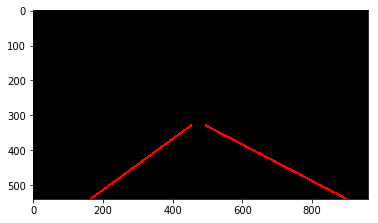

 30%|███       | 208/682 [02:01<03:27,  2.28it/s]

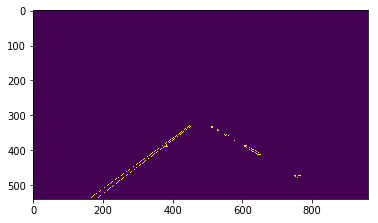

[[-0.72289157]
 [-0.76      ]
 [-0.6       ]
 [-0.69230769]
 [-0.7826087 ]
 [-0.72727273]
 [-0.72727273]
 [-0.84615385]
 [ 0.53846154]
 [-0.73333333]
 [-0.76470588]
 [ 0.5       ]
 [-0.7       ]
 [-0.81818182]
 [ 0.53333333]
 [ 0.5       ]]
left_m = -0.731962922438  right_m = 0.540910221338
left_c = 663.167406814  right_c = 61.0907734394
left_y = 350.619238933  right_y = 388.88236757  min y = 350.619238933
left_y = 544.589413379  right_y = 409.977866202  max y = 544.589413379


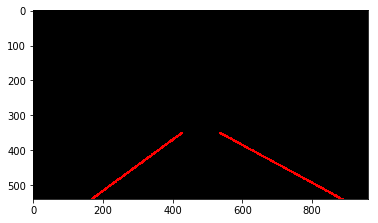

 31%|███       | 209/682 [02:01<03:23,  2.32it/s]

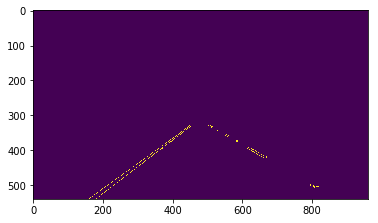

[[-0.70886076]
 [-0.90909091]
 [-0.78846154]
 [-0.81481481]
 [ 0.51515152]
 [-0.75      ]
 [-0.73076923]
 [-0.63636364]
 [ 0.5625    ]
 [ 0.54545455]
 [-0.8125    ]
 [-0.73684211]
 [-0.9       ]
 [-0.85714286]
 [-0.78571429]
 [-0.8       ]
 [-0.81818182]
 [-0.81818182]
 [ 0.4375    ]
 [ 0.        ]
 [-0.83333333]
 [-0.81818182]
 [-0.8       ]
 [-0.81818182]
 [ 0.5       ]
 [-0.7       ]
 [-0.63636364]]
left_m = -0.745510310981  right_m = 0.560773665862
left_c = 667.544267271  right_c = 46.6739239743
left_y = 330.573606708  right_y = 328.743077903  min y = 328.743077903
left_y = 543.789555649  right_y = 422.392280102  max y = 543.789555649


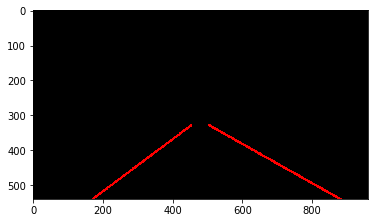

 31%|███       | 210/682 [02:02<03:22,  2.33it/s]

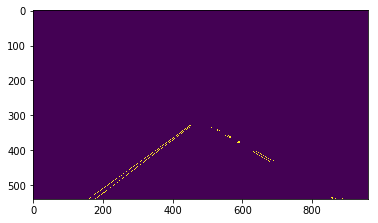

[[-0.725     ]
 [-0.83333333]
 [-0.84615385]
 [-0.58333333]
 [-0.63636364]
 [-0.76086957]
 [-0.70588235]
 [ 0.54545455]
 [-0.68421053]
 [-0.72      ]
 [ 0.55555556]
 [-0.8       ]
 [-0.7       ]
 [ 0.55555556]
 [-0.78571429]
 [-0.70588235]
 [-0.75      ]
 [-0.75      ]]
left_m = -0.739690227805  right_m = 0.755547909857
left_c = 664.825106451  right_c = -81.0319972475
left_y = 329.745433255  right_y = 401.763117151  min y = 329.745433255
left_y = 536.858697041  right_y = 433.496129365  max y = 536.858697041


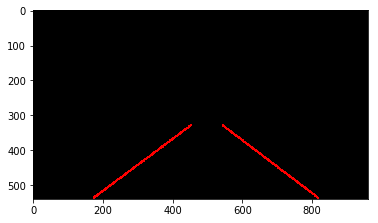

 31%|███       | 211/682 [02:02<03:26,  2.28it/s]

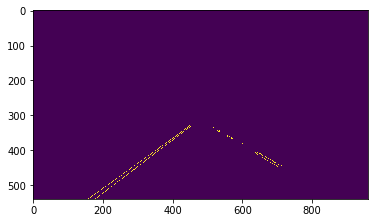

[[-0.72815534]
 [-0.88235294]
 [ 0.5483871 ]
 [ 0.5       ]
 [-0.72483221]
 [-0.6       ]
 [-0.7826087 ]
 [ 0.64705882]
 [-0.69230769]
 [-0.86666667]
 [-0.72      ]
 [-0.72413793]
 [-0.6       ]
 [ 0.53846154]
 [-0.81481481]
 [ 0.54545455]
 [ 0.61538462]
 [ 0.6       ]
 [-0.72727273]
 [-0.75      ]
 [-0.83333333]]
left_m = -0.728505954507  right_m = 0.56
left_c = 662.012025951  right_c = 49.44
left_y = 331.998828559  right_y = 360.24  min y = 331.998828559
left_y = 546.179579184  right_y = 440.32  max y = 546.179579184


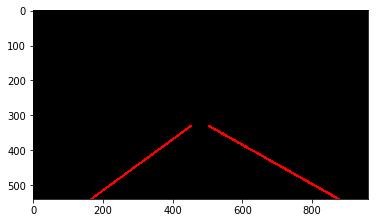

 31%|███       | 212/682 [02:02<03:25,  2.29it/s]

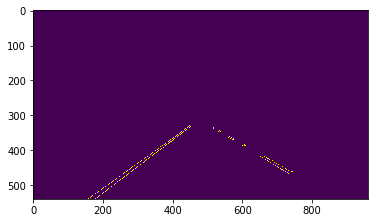

[[-0.81818182]
 [-0.6875    ]
 [-0.9       ]
 [ 0.5952381 ]
 [-0.75675676]
 [-0.64285714]
 [ 0.53846154]
 [-0.64285714]
 [-0.75      ]
 [-0.81818182]
 [ 0.55      ]
 [-0.6       ]
 [-0.76190476]
 [-0.81818182]
 [-0.83333333]
 [-0.64285714]
 [-0.66666667]
 [-0.73684211]
 [-0.66666667]
 [ 0.6097561 ]
 [-0.77777778]
 [-0.73913043]
 [-0.8       ]
 [ 0.54166667]
 [ 0.61538462]
 [-0.625     ]
 [ 0.5       ]]
left_m = -0.718761424158  right_m = 0.562712699791
left_c = 656.337853656  right_c = 48.7519539043
left_y = 341.520349875  right_y = 414.515208769  min y = 341.520349875
left_y = 542.054787215  right_y = 464.59663905  max y = 542.054787215


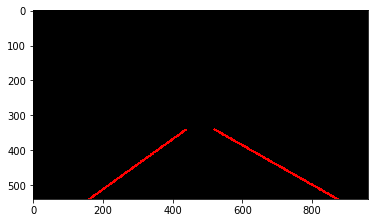

 31%|███       | 213/682 [02:03<03:19,  2.35it/s]

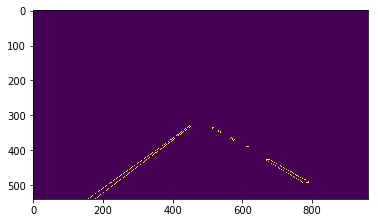

[[-0.83333333]
 [-0.80645161]
 [-0.72413793]
 [-0.85714286]
 [-0.73043478]
 [ 0.36363636]
 [ 0.5       ]
 [-0.79166667]
 [ 0.5       ]
 [-0.77272727]
 [-0.84615385]
 [-0.72727273]
 [ 0.5625    ]
 [-0.84615385]
 [ 0.61538462]
 [-0.66666667]
 [-0.84210526]
 [ 0.5       ]
 [-0.78571429]
 [ 0.55555556]
 [ 0.53846154]
 [-0.90909091]
 [-0.75      ]
 [-0.78571429]
 [ 0.66666667]
 [-0.75      ]
 [ 0.5       ]
 [-0.72727273]
 [-0.9       ]
 [-0.83333333]
 [-0.68421053]
 [-0.92857143]
 [ 0.54545455]
 [-0.81818182]]
left_m = -0.749087821603  right_m = 0.599397151996
left_c = 667.830211342  right_c = 25.3873589501
left_y = 336.733394194  right_y = 364.046749828  min y = 336.733394194
left_y = 548.725247707  right_y = 489.920151747  max y = 548.725247707


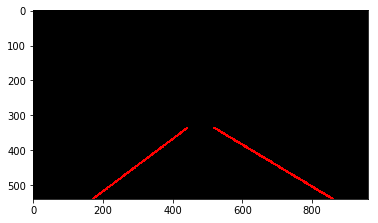

 31%|███▏      | 214/682 [02:03<03:14,  2.40it/s]

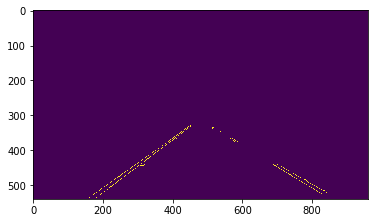

[[ 0.60194175]
 [-0.73      ]
 [-0.63636364]
 [-0.84615385]
 [-0.7047619 ]
 [-0.8125    ]
 [ 0.5       ]
 [ 0.61111111]
 [-0.73684211]
 [ 0.56666667]
 [-0.9       ]
 [ 0.52173913]
 [-0.6       ]
 [ 0.46153846]
 [ 0.5       ]
 [-0.7       ]
 [ 0.55555556]
 [-1.        ]
 [ 0.53333333]
 [-0.90909091]
 [ 0.53846154]
 [-0.81818182]
 [ 0.5       ]
 [-0.78947368]
 [-0.6       ]
 [-0.84615385]
 [ 0.54545455]
 [ 0.5       ]
 [ 0.        ]]
left_m = -0.73271499247  right_m = 0.568028591699
left_c = 662.032424508  right_c = 45.9536665364
left_y = 336.706967851  right_y = 367.457849438  min y = 336.706967851
left_y = 546.99617069  right_y = 516.281340464  max y = 546.99617069


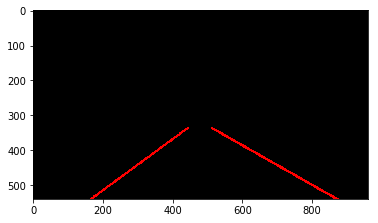

 32%|███▏      | 215/682 [02:04<03:14,  2.40it/s]

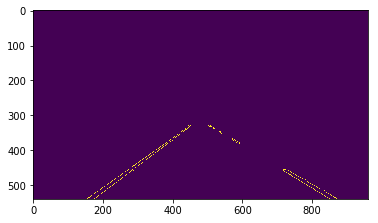

[[-0.76315789]
 [-0.70886076]
 [-0.73529412]
 [-0.68518519]
 [-0.84615385]
 [ 0.58333333]
 [ 0.56521739]
 [ 0.63888889]
 [-0.82352941]
 [-0.90909091]
 [ 0.55      ]
 [ 0.53571429]
 [-0.63636364]
 [ 0.47058824]
 [ 0.54545455]
 [ 0.09090909]
 [-0.625     ]
 [-0.85714286]
 [-0.9       ]
 [ 0.5       ]
 [ 0.6       ]
 [-0.64285714]
 [-0.6       ]
 [ 0.5       ]
 [-0.69230769]
 [-0.9       ]
 [-0.83333333]
 [-0.9       ]
 [ 0.5       ]]
left_m = -0.741182364254  right_m = 0.561684118745
left_c = 663.312127232  right_c = 52.5107023879
left_y = 332.744792775  right_y = 372.108965954  min y = 332.744792775
left_y = 543.240584223  right_y = 539.49083334  max y = 543.240584223


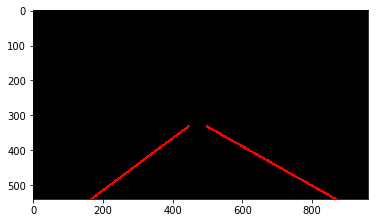

 32%|███▏      | 216/682 [02:04<03:12,  2.42it/s]

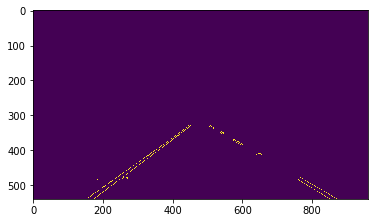

[[-0.70212766]
 [ 0.55172414]
 [-0.7625    ]
 [ 0.61111111]
 [ 0.5       ]
 [-0.78125   ]
 [-0.69230769]
 [ 0.45454545]
 [ 0.61538462]
 [-0.70175439]
 [-0.85      ]
 [ 0.6       ]
 [ 0.6       ]
 [-0.80952381]
 [-0.9       ]
 [ 0.59090909]
 [-0.77272727]
 [-0.7       ]
 [-0.84615385]
 [ 0.5       ]
 [ 0.53333333]
 [-0.85714286]
 [-0.9       ]
 [-0.66666667]
 [ 0.        ]
 [-0.7       ]
 [-0.7       ]
 [ 0.5       ]]
left_m = -0.727620381299  right_m = 0.585823633421
left_c = 658.948839598  right_c = 34.4372765183
left_y = 335.15776992  right_y = 374.800807536  min y = 335.15776992
left_y = 546.895300878  right_y = 535.316483093  max y = 546.895300878


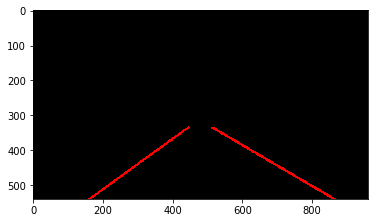

 32%|███▏      | 217/682 [02:05<03:20,  2.32it/s]

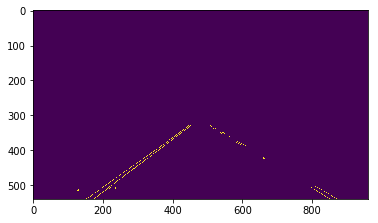

[[-0.8       ]
 [-0.66666667]
 [-0.8       ]
 [-0.61538462]
 [-0.75438596]
 [ 0.5625    ]
 [-0.76470588]
 [-0.61904762]
 [ 0.51851852]
 [-0.58333333]
 [-0.85714286]
 [-0.6875    ]
 [ 0.57894737]
 [-0.81818182]
 [-0.66666667]
 [-0.85714286]
 [-0.8       ]
 [ 0.6       ]
 [-0.63636364]
 [-0.8       ]
 [ 0.5       ]
 [-0.58333333]
 [ 0.        ]
 [-0.81818182]
 [ 0.59259259]
 [-0.6875    ]
 [-0.78571429]
 [ 0.5       ]
 [-0.85714286]
 [-0.1       ]
 [ 0.53333333]
 [-0.63636364]
 [-0.83333333]
 [-0.6       ]]
left_m = -0.716596750685  right_m = 0.58576543222
left_c = 654.015399403  right_c = 34.297982931
left_y = 335.129845348  right_y = 373.456168186  min y = 335.129845348
left_y = 544.376096548  right_y = 539.227785505  max y = 544.376096548


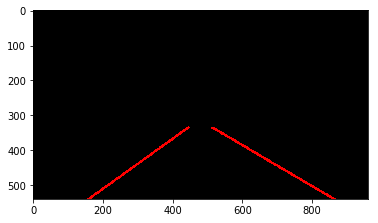

 32%|███▏      | 218/682 [02:05<03:16,  2.36it/s]

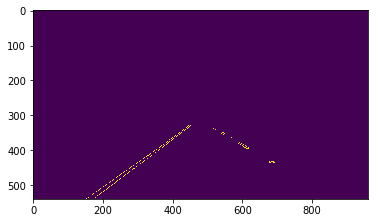

[[-0.7       ]
 [-0.7016129 ]
 [-0.77419355]
 [-0.77777778]
 [-0.8       ]
 [-0.69230769]
 [-0.8       ]
 [-0.77777778]
 [-0.8       ]
 [-0.83333333]
 [-0.8125    ]
 [-0.84615385]
 [-0.83333333]
 [-0.81818182]
 [ 0.6       ]
 [ 0.6       ]
 [ 0.61538462]
 [-0.9       ]
 [-0.92307692]
 [-0.83333333]
 [-0.8       ]
 [-0.8       ]]
left_m = -0.746723009155  right_m = 0.568990283059
left_c = 664.836246608  right_c = 43.718208703
left_y = 334.037953552  right_y = 350.403971272  min y = 334.037953552
left_y = 550.587626207  right_y = 395.354203633  max y = 550.587626207


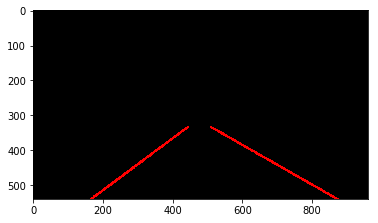

 32%|███▏      | 219/682 [02:05<03:18,  2.33it/s]

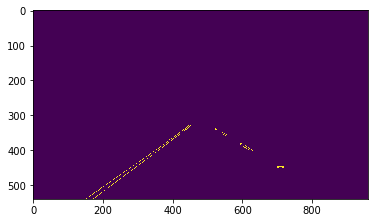

[[-0.728     ]
 [-0.63636364]
 [-0.61538462]
 [-0.6875    ]
 [-1.        ]
 [-0.6       ]
 [ 0.58333333]
 [-0.9       ]
 [-0.625     ]
 [ 0.54545455]
 [-0.6       ]
 [-0.625     ]
 [-0.64285714]
 [-0.75      ]
 [-0.74074074]
 [-0.63636364]
 [ 0.6       ]
 [-0.84210526]
 [-0.6       ]
 [-0.61538462]
 [-0.58333333]
 [-0.84210526]
 [-0.8       ]
 [-0.63636364]
 [-0.66666667]
 [-0.69230769]]
left_m = -0.687664759437  right_m = 0.588235294118
left_c = 646.5066982  right_c = 33.431372549
left_y = 343.246539288  right_y = 381.666666667  min y = 343.246539288
left_y = 537.855666209  right_y = 398.137254902  max y = 537.855666209


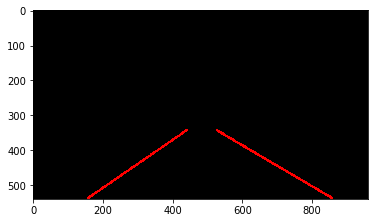

 32%|███▏      | 220/682 [02:06<03:17,  2.34it/s]

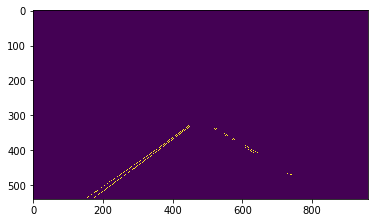

[[-0.75641026]
 [-0.6984127 ]
 [-0.78125   ]
 [-0.84615385]
 [ 0.5       ]
 [-0.68181818]
 [-0.78787879]
 [-0.9       ]
 [-0.64285714]
 [-0.8       ]
 [ 0.6       ]
 [-0.81818182]
 [ 0.5       ]
 [-0.8125    ]
 [ 0.60606061]
 [-0.9       ]
 [ 0.5       ]
 [-0.84615385]
 [-0.61538462]
 [-0.6       ]
 [ 0.5       ]
 [-0.83333333]]
left_m = -0.732417400326  right_m = 0.577763070814
left_c = 659.824602671  right_c = 37.1365541584
left_y = 332.434024726  right_y = 351.439664681  min y = 332.434024726
left_y = 545.567488221  right_y = 407.48268255  max y = 545.567488221


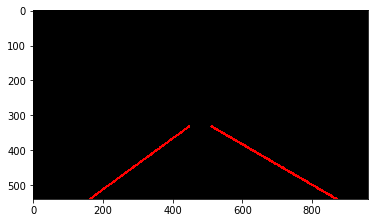

 32%|███▏      | 221/682 [02:06<03:15,  2.36it/s]

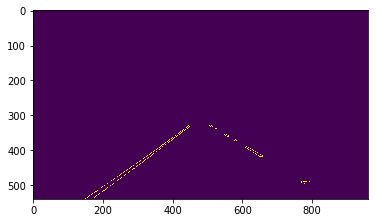

[[-0.70046083]
 [-0.70114943]
 [ 0.57692308]
 [-0.88235294]
 [-0.66666667]
 [-0.7278481 ]
 [ 0.64285714]
 [-0.7       ]
 [-0.71428571]
 [-0.70238095]
 [ 0.4       ]
 [ 0.65384615]
 [-0.9       ]
 [ 0.54545455]
 [ 0.46153846]
 [-0.70588235]
 [-0.91666667]
 [ 0.7       ]
 [-0.71428571]]
left_m = -0.705244932302  right_m = 0.642853359604
left_c = 650.167049633  right_c = -0.819112085677
left_y = 341.269769285  right_y = 352.750235697  min y = 341.269769285
left_y = 543.675064856  right_y = 417.035571657  max y = 543.675064856


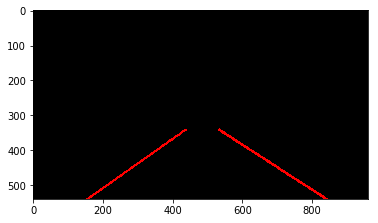

 33%|███▎      | 222/682 [02:07<03:24,  2.24it/s]

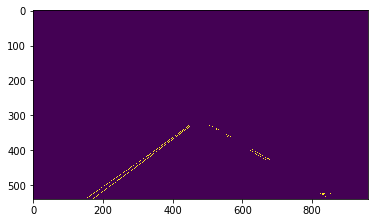

[[-0.71014493]
 [-0.75280899]
 [ 0.61538462]
 [-0.75      ]
 [-0.58333333]
 [-0.75      ]
 [-0.75438596]
 [-0.73529412]
 [-0.78571429]
 [ 0.63636364]
 [ 0.56521739]
 [-0.75      ]
 [ 0.61538462]
 [-0.8       ]
 [ 0.54545455]
 [-0.78571429]
 [-0.78571429]
 [ 0.6       ]
 [-0.83333333]
 [ 0.66666667]
 [-0.76923077]]
left_m = -0.707456870634  right_m = 0.607309866549
left_c = 649.443562104  right_c = 20.3915668535
left_y = 336.747625283  right_y = 354.411993456  min y = 336.747625283
left_y = 535.543005932  right_y = 423.645318242  max y = 535.543005932


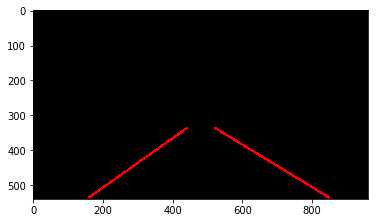

 33%|███▎      | 223/682 [02:07<03:17,  2.32it/s]

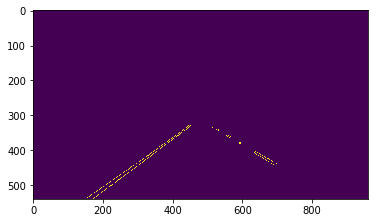

[[ 0.57142857]
 [ 0.52380952]
 [-0.75806452]
 [-0.72839506]
 [-0.72222222]
 [-0.78125   ]
 [-0.84615385]
 [-0.734375  ]
 [ 0.        ]
 [-0.78571429]
 [ 0.6       ]
 [-0.8       ]
 [-0.8       ]
 [-0.75      ]
 [ 0.72727273]
 [-0.73076923]
 [-0.6       ]
 [ 0.53846154]
 [-1.        ]
 [-0.78571429]
 [-0.7       ]
 [ 0.54545455]
 [ 0.53333333]
 [ 0.57142857]
 [-0.63636364]]
left_m = -0.707822485347  right_m = 0.589784445464
left_c = 651.41527144  right_c = 30.1291861504
left_y = 339.265555402  right_y = 356.279984492  min y = 339.265555402
left_y = 544.534076153  right_y = 443.56808242  max y = 544.534076153


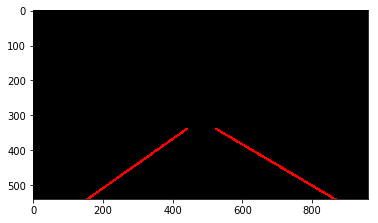

 33%|███▎      | 224/682 [02:08<03:14,  2.35it/s]

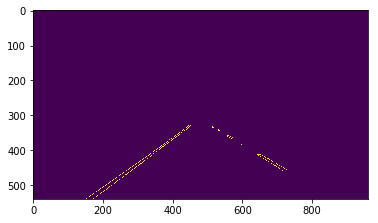

[[-0.74074074]
 [-0.68571429]
 [-0.8       ]
 [ 0.58333333]
 [-0.75221239]
 [-0.86666667]
 [-0.84615385]
 [-0.68888889]
 [-0.8       ]
 [ 0.58064516]
 [-0.61538462]
 [-0.80645161]
 [ 0.6       ]
 [-0.72727273]
 [-0.64285714]
 [ 0.60869565]
 [ 0.57142857]
 [-0.7       ]
 [-0.6       ]
 [-0.68      ]
 [ 0.54545455]
 [-0.75757576]
 [ 0.5       ]
 [-0.76923077]]
left_m = -0.723066002141  right_m = 0.602936806656
left_c = 655.39024273  right_c = 22.1689035261
left_y = 345.194927811  right_y = 362.22526248  min y = 345.194927811
left_y = 536.807418379  right_y = 462.312772385  max y = 536.807418379


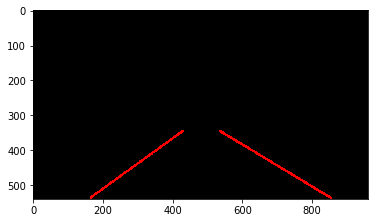

 33%|███▎      | 225/682 [02:08<03:11,  2.39it/s]

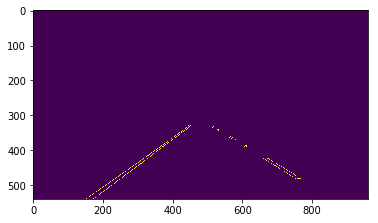

[[-0.81818182]
 [-0.72727273]
 [-0.75      ]
 [ 0.52173913]
 [-0.61111111]
 [-0.875     ]
 [-0.78571429]
 [-0.77777778]
 [ 0.7       ]
 [-0.72340426]
 [-0.8       ]
 [ 0.61538462]
 [-0.6       ]
 [-0.75      ]
 [-0.6       ]
 [ 0.6       ]
 [-0.63636364]
 [-0.78571429]
 [-0.86666667]
 [ 0.5       ]
 [-0.6       ]
 [ 0.5625    ]
 [ 0.45454545]
 [-0.73333333]
 [ 0.61904762]
 [-0.80952381]
 [-1.        ]
 [ 0.63636364]
 [ 0.7       ]
 [-0.72727273]
 [ 0.54545455]
 [-0.6       ]]
left_m = -0.726503766784  right_m = 0.599432865637
left_c = 658.038935473  right_c = 24.5525604843
left_y = 339.830285621  right_y = 360.234965241  min y = 339.830285621
left_y = 537.439310186  right_y = 477.124374041  max y = 537.439310186


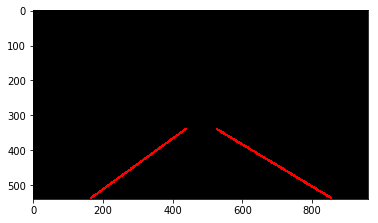

 33%|███▎      | 226/682 [02:08<03:16,  2.33it/s]

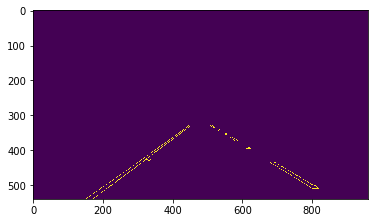

[[-0.69724771]
 [-0.72222222]
 [-0.80952381]
 [ 0.6       ]
 [-0.83333333]
 [-0.6969697 ]
 [-0.84615385]
 [-0.79310345]
 [ 0.59649123]
 [ 0.61538462]
 [-0.78947368]
 [-0.73255814]
 [ 0.6       ]
 [-0.69230769]
 [-0.6       ]
 [ 0.58333333]
 [-0.72413793]
 [ 0.57142857]
 [-0.81818182]
 [-0.69230769]
 [-0.64285714]
 [-0.81818182]
 [ 0.57894737]
 [ 0.63157895]
 [ 0.57142857]
 [ 0.6       ]]
left_m = -0.739710376278  right_m = 0.60430511309
left_c = 662.165506769  right_c = 19.4937814412
left_y = 346.309176098  right_y = 365.156306129  min y = 346.309176098
left_y = 549.729529575  right_y = 496.894820783  max y = 549.729529575


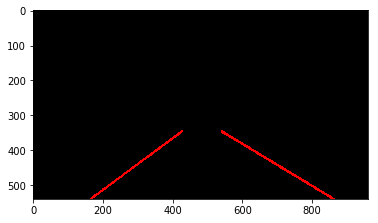

 33%|███▎      | 227/682 [02:09<03:15,  2.32it/s]

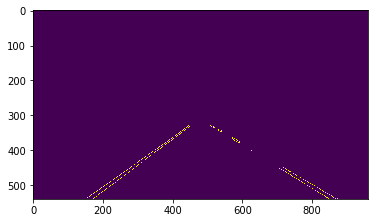

[[ 0.60294118]
 [ 0.57142857]
 [-0.75147929]
 [-0.70192308]
 [-0.83333333]
 [ 0.6       ]
 [ 0.68421053]
 [ 0.45454545]
 [-0.8       ]
 [ 0.56756757]
 [-0.78571429]
 [ 0.66666667]
 [ 0.53846154]
 [-0.77777778]
 [-0.625     ]
 [-0.71428571]
 [ 0.57142857]
 [-0.76923077]
 [ 0.66666667]
 [ 0.5       ]
 [-0.83333333]
 [-0.6       ]
 [ 0.63636364]
 [-0.85714286]
 [ 0.5       ]
 [-0.81818182]
 [ 0.52941176]
 [-0.81818182]]
left_m = -0.727312152072  right_m = 0.609990345954
left_c = 655.552461217  right_c = 17.5104907982
left_y = 328.261992784  right_y = 364.594997646  min y = 328.261992784
left_y = 534.091331821  right_y = 534.782304167  max y = 534.782304167


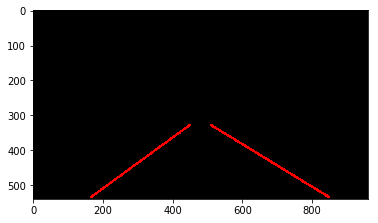

 33%|███▎      | 228/682 [02:09<03:25,  2.21it/s]

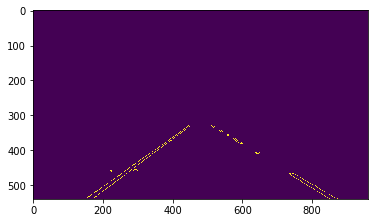

[[-0.66666667]
 [ 0.46153846]
 [-0.75714286]
 [-0.78571429]
 [-0.9       ]
 [-0.75      ]
 [ 0.55882353]
 [-0.84615385]
 [-0.80952381]
 [-0.92857143]
 [-0.83333333]
 [-0.625     ]
 [ 0.66666667]
 [-0.65      ]
 [ 0.60869565]
 [ 0.5       ]
 [-0.81818182]
 [ 0.53333333]
 [-0.85714286]
 [ 0.62962963]
 [-0.79166667]
 [-0.6       ]
 [-0.8       ]
 [-0.72727273]
 [ 0.69230769]
 [-1.        ]
 [-0.6       ]
 [-0.61538462]
 [-0.9       ]
 [ 0.54545455]
 [ 0.54545455]
 [-0.81818182]
 [ 0.6       ]]
left_m = -0.71180275291  right_m = 0.592121076418
left_c = 650.554154418  right_c = 28.4185850656
left_y = 340.208154149  right_y = 368.296082929  min y = 340.208154149
left_y = 538.089319458  right_y = 541.78755832  max y = 541.78755832


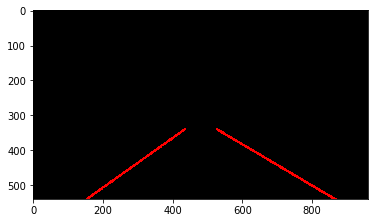

 34%|███▎      | 229/682 [02:10<03:21,  2.24it/s]

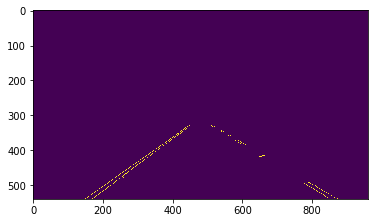

[[-0.73026316]
 [-0.7038835 ]
 [-0.1       ]
 [-0.7173913 ]
 [-0.74      ]
 [-0.77272727]
 [-0.71428571]
 [ 0.57142857]
 [ 0.65217391]
 [ 0.61111111]
 [ 0.46153846]
 [-0.75      ]
 [ 0.58139535]
 [ 0.5       ]
 [ 0.45454545]
 [-0.75      ]
 [-0.6       ]
 [-0.70588235]
 [ 0.65      ]
 [ 0.4       ]
 [-0.72727273]
 [ 0.58333333]
 [-0.63636364]]
left_m = -0.719696969697  right_m = 0.599677507402
left_c = 655.053030303  right_c = 22.9762266082
left_y = 334.787878788  right_y = 371.988535916  min y = 334.787878788
left_y = 540.621212121  right_y = 534.501140422  max y = 540.621212121


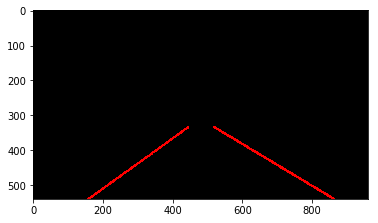

 34%|███▎      | 230/682 [02:10<03:20,  2.26it/s]

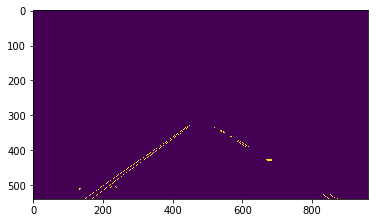

[[-0.70238095]
 [-0.73333333]
 [-0.68181818]
 [-0.70229008]
 [-0.71428571]
 [-0.72      ]
 [-0.6       ]
 [-0.69565217]
 [ 0.55555556]
 [ 0.66666667]
 [ 0.53333333]
 [ 0.        ]
 [-0.71428571]
 [-0.72222222]
 [-0.72727273]
 [-0.71428571]
 [-0.6       ]
 [ 0.69230769]
 [ 0.6       ]]
left_m = -0.727576921904  right_m = 0.598344601339
left_c = 657.625872431  right_c = 24.0161304247
left_y = 341.857488324  right_y = 375.244411411  min y = 341.857488324
left_y = 531.027488019  right_y = 542.182555184  max y = 542.182555184


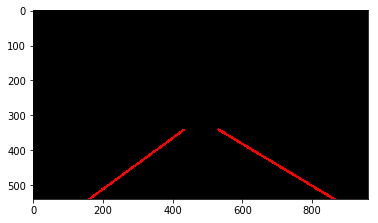

 34%|███▍      | 231/682 [02:11<03:15,  2.31it/s]

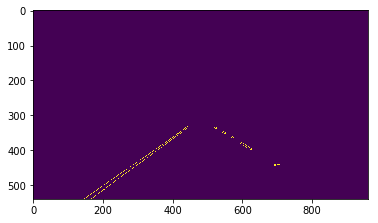

[[-0.68421053]
 [-0.72881356]
 [-0.75      ]
 [-0.77777778]
 [-0.73333333]
 [-0.81818182]
 [ 0.57142857]
 [-0.81818182]
 [-0.77777778]
 [-0.71428571]
 [-0.83333333]
 [ 0.53846154]
 [-0.7       ]
 [ 0.61290323]
 [-0.73529412]
 [ 0.63636364]
 [-0.6       ]
 [ 0.4       ]
 [ 0.07692308]
 [-0.78571429]
 [-0.81818182]
 [-0.72727273]]
left_m = -0.720631257983  right_m = 0.603251318102
left_c = 651.391013227  right_c = 20.4433216169
left_y = 336.475153488  right_y = 376.964850615  min y = 336.475153488
left_y = 538.972536981  right_y = 399.285149385  max y = 538.972536981


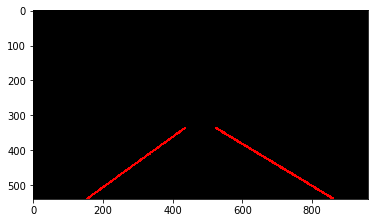

 34%|███▍      | 232/682 [02:11<03:11,  2.35it/s]

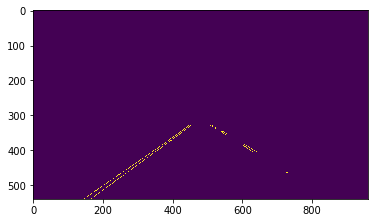

[[-0.84615385]
 [-0.70103093]
 [-0.84615385]
 [-0.78571429]
 [-0.78571429]
 [-0.84615385]
 [ 0.55      ]
 [-0.6875    ]
 [-0.72727273]
 [-0.2       ]
 [-0.8       ]
 [-0.73913043]
 [-0.77777778]
 [-0.84615385]
 [-0.70588235]
 [-0.9       ]
 [-0.71052632]
 [-0.8       ]
 [-0.84615385]
 [-0.8       ]
 [-0.8       ]
 [ 0.53846154]
 [ 0.54545455]
 [-0.66666667]
 [-0.78571429]
 [-0.6       ]]
left_m = -0.717452118727  right_m = 0.753984063745
left_c = 652.995710541  right_c = -72.3615537849
left_y = 333.729517708  right_y = 381.53685259  min y = 333.729517708
left_y = 547.530249088  right_y = 405.664342629  max y = 547.530249088


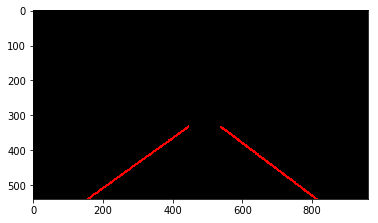

 34%|███▍      | 233/682 [02:12<03:21,  2.23it/s]

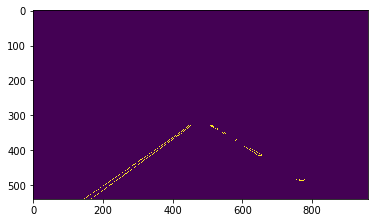

[[-0.61538462]
 [-0.73333333]
 [-0.73      ]
 [-0.67857143]
 [-0.8       ]
 [-0.58333333]
 [-0.63157895]
 [ 0.6       ]
 [ 0.58823529]
 [-0.7173913 ]
 [-0.8125    ]
 [-0.71428571]
 [ 0.33333333]
 [-0.61111111]
 [-0.73333333]
 [-0.625     ]
 [ 0.61111111]
 [-0.81818182]
 [-0.58333333]
 [-0.70588235]
 [-0.75      ]
 [-0.57142857]
 [-0.58333333]
 [-0.7       ]
 [-0.6       ]]
left_m = -0.695871748638  right_m = 0.667461956413
left_c = 644.032636336  right_c = -15.5333921447
left_y = 329.498605952  right_y = 348.900836057  min y = 329.498605952
left_y = 541.739489286  right_y = 415.647031698  max y = 541.739489286


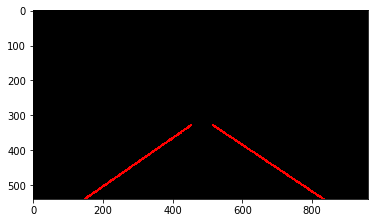

 34%|███▍      | 234/682 [02:12<03:16,  2.28it/s]

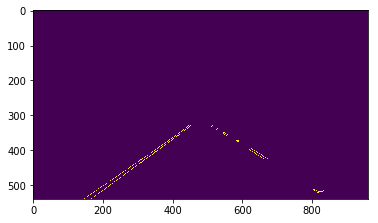

[[-0.77272727]
 [-0.84615385]
 [-0.70247934]
 [-0.66666667]
 [-0.64285714]
 [-0.6       ]
 [ 0.        ]
 [ 0.58823529]
 [-0.6875    ]
 [-0.58333333]
 [-0.75438596]
 [-0.54545455]
 [-0.81818182]
 [-0.75      ]
 [ 0.46666667]
 [-0.7       ]
 [-0.91666667]
 [-0.8       ]
 [-0.58333333]
 [ 0.58333333]
 [ 0.65517241]
 [-0.78571429]
 [-0.8125    ]
 [-0.81818182]
 [ 0.05      ]
 [-0.6       ]]
left_m = -0.698895563448  right_m = 0.581012658228
left_c = 647.7327019  right_c = 35.7759493671
left_y = 343.014236236  right_y = 352.427848101  min y = 343.014236236
left_y = 539.403889565  right_y = 417.501265823  max y = 539.403889565


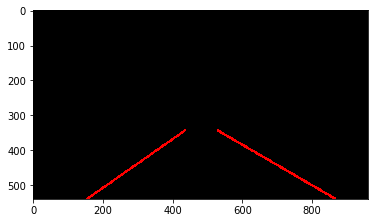

 34%|███▍      | 235/682 [02:12<03:22,  2.21it/s]

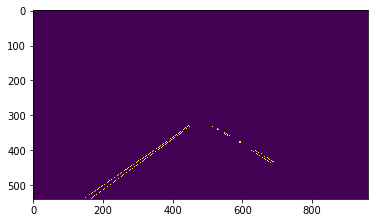

[[-0.58333333]
 [-0.68333333]
 [ 0.61111111]
 [-0.72992701]
 [-0.72413793]
 [-0.68571429]
 [ 0.6       ]
 [-0.65      ]
 [ 0.5       ]
 [ 0.36363636]
 [-0.61111111]
 [-0.82352941]
 [-0.63157895]
 [-0.58333333]
 [-0.68421053]
 [-0.6       ]
 [-0.57142857]
 [ 0.57142857]
 [-0.6875    ]]
left_m = -0.693397349133  right_m = 0.617267322656
left_c = 643.07154612  right_c = 12.0057649249
left_y = 340.750301898  right_y = 350.885525063  min y = 340.750301898
left_y = 537.675149052  right_y = 426.809405749  max y = 537.675149052


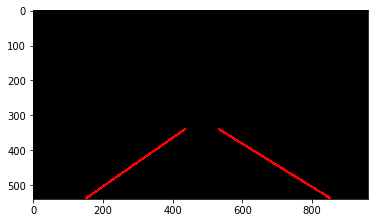

 35%|███▍      | 236/682 [02:13<03:38,  2.04it/s]

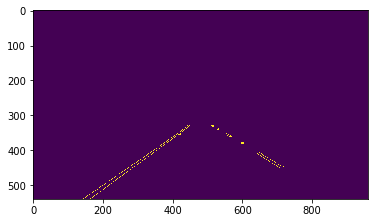

[[-0.77142857]
 [-0.8       ]
 [ 0.38461538]
 [ 0.61290323]
 [-0.70253165]
 [-0.72727273]
 [-0.8       ]
 [-0.7037037 ]
 [ 0.58333333]
 [-0.69047619]
 [-0.78571429]
 [ 0.46666667]
 [ 0.56521739]
 [-0.70833333]
 [ 0.61538462]
 [-0.7       ]
 [-0.69230769]
 [ 0.57142857]
 [-0.6       ]
 [-0.7       ]
 [ 0.5       ]]
left_m = -0.720695103178  right_m = 0.607542688799
left_c = 653.963738151  right_c = 18.1376655908
left_y = 330.371636824  right_y = 352.28614443  min y = 330.371636824
left_y = 549.46294819  right_y = 443.41754775  max y = 549.46294819


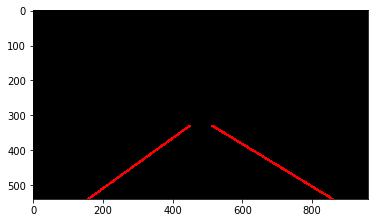

 35%|███▍      | 237/682 [02:13<03:28,  2.13it/s]

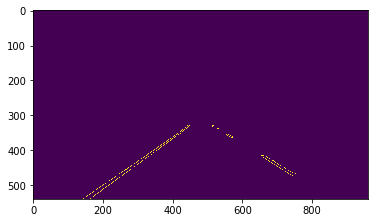

[[-0.73584906]
 [-0.64285714]
 [-0.70588235]
 [-0.6       ]
 [-0.77777778]
 [-0.76923077]
 [-0.75      ]
 [-0.73913043]
 [ 0.66666667]
 [-0.71428571]
 [ 0.58333333]
 [-0.73684211]
 [ 0.55555556]
 [ 0.66666667]
 [-0.6875    ]
 [-0.78571429]
 [-0.75      ]
 [ 0.55555556]
 [-0.82608696]
 [-0.83333333]
 [-0.72222222]
 [ 0.57142857]
 [ 0.64705882]
 [-0.63636364]
 [-0.66666667]
 [-0.6       ]]
left_m = -0.71458045687  right_m = 0.629936475661
left_c = 650.067306624  right_c = 2.62863858905
left_y = 329.935261946  right_y = 352.873319057  min y = 329.935261946
left_y = 547.167720835  right_y = 469.411567054  max y = 547.167720835


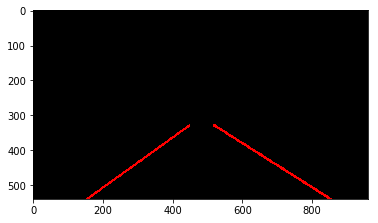

 35%|███▍      | 238/682 [02:14<03:19,  2.22it/s]

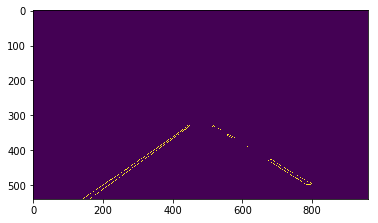

[[-0.72685185]
 [-0.81818182]
 [-0.75      ]
 [ 0.57894737]
 [ 0.61818182]
 [ 0.5       ]
 [-0.75      ]
 [ 0.60714286]
 [ 0.6       ]
 [-0.75      ]
 [-0.73913043]
 [ 0.60465116]
 [-0.69230769]
 [ 0.55555556]
 [-0.76923077]
 [ 0.58333333]
 [-0.73333333]
 [-0.75      ]
 [ 0.6       ]
 [-0.75      ]
 [-0.75      ]
 [-0.72222222]
 [-0.77272727]
 [-0.75      ]
 [-0.75      ]
 [ 0.64285714]
 [-0.69230769]]
left_m = -0.696171854288  right_m = 0.598839544512
left_c = 641.211253014  right_c = 22.6475230344
left_y = 336.287980836  right_y = 355.602309783  min y = 336.287980836
left_y = 534.696959308  right_y = 495.730763199  max y = 534.696959308


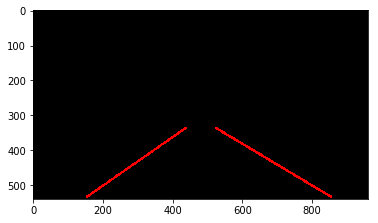

 35%|███▌      | 239/682 [02:14<03:30,  2.11it/s]

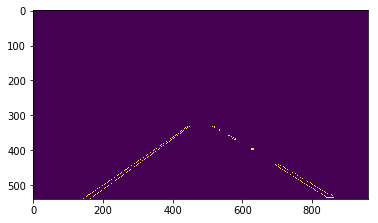

[[-0.66666667]
 [-0.6       ]
 [-0.73015873]
 [-0.67567568]
 [-0.7       ]
 [ 0.64367816]
 [-0.9       ]
 [-0.54545455]
 [-0.58333333]
 [-0.64285714]
 [ 0.56862745]
 [-0.83333333]
 [ 0.46666667]
 [ 0.52941176]
 [ 0.63157895]
 [-0.6       ]
 [-0.6       ]
 [-0.64705882]
 [ 0.63461538]
 [-0.69565217]
 [ 0.54545455]
 [ 0.5625    ]
 [ 0.58333333]
 [ 0.61538462]
 [-0.6       ]
 [-0.63636364]
 [-0.66666667]
 [-0.61538462]
 [-0.6       ]
 [ 0.57142857]
 [ 0.        ]
 [ 0.5625    ]]
left_m = -0.713531697743  right_m = 0.609715518484
left_c = 651.021323114  right_c = 15.4628733161
left_y = 332.78618592  right_y = 358.732710223  min y = 332.78618592
left_y = 543.278036754  right_y = 532.501632991  max y = 543.278036754


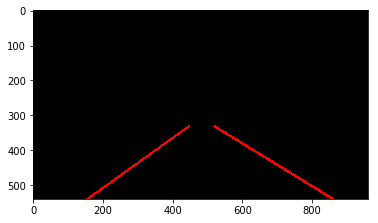

 35%|███▌      | 240/682 [02:15<03:20,  2.20it/s]

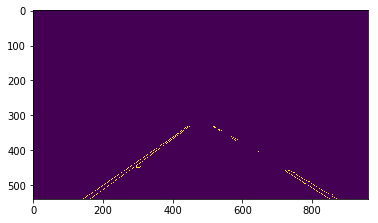

[[-0.7260274 ]
 [-0.69827586]
 [ 0.30769231]
 [-0.82352941]
 [-0.6       ]
 [ 0.5       ]
 [-0.82352941]
 [ 0.62105263]
 [-0.70588235]
 [-0.7826087 ]
 [-0.66666667]
 [-0.8       ]
 [-0.75      ]
 [-0.84615385]
 [-0.8       ]
 [ 0.52380952]
 [-0.6       ]
 [ 0.5       ]
 [ 0.46153846]
 [-0.8       ]
 [ 0.55      ]
 [ 0.63636364]
 [ 0.5       ]]
left_m = -0.6943406457  right_m = 0.552671126302
left_c = 643.451791407  right_c = 58.1822975543
left_y = 330.998500842  right_y = 473.790984533  min y = 330.998500842
left_y = 533.745969386  right_y = 539.006177437  max y = 539.006177437


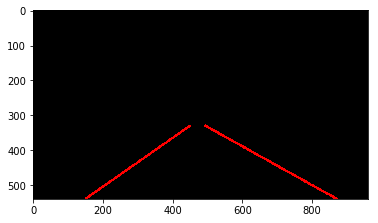

 35%|███▌      | 241/682 [02:15<03:14,  2.27it/s]

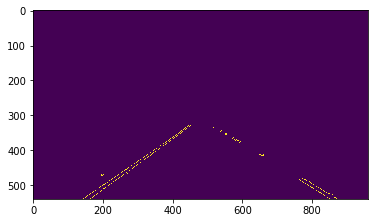

[[ 0.53846154]
 [-0.83333333]
 [-0.58333333]
 [-0.6       ]
 [ 0.61428571]
 [-0.70588235]
 [-0.78125   ]
 [ 0.63636364]
 [-0.6984127 ]
 [-0.73684211]
 [-0.66666667]
 [-0.79166667]
 [ 0.59259259]
 [ 0.625     ]
 [ 0.6       ]
 [-0.72413793]
 [-0.73684211]
 [-0.63636364]
 [-0.8125    ]
 [ 0.54545455]
 [-0.81818182]
 [ 0.58333333]
 [-0.76923077]]
left_m = -0.705107523988  right_m = 0.575519494124
left_c = 647.171961492  right_c = 38.9437555949
left_y = 341.155296081  right_y = 372.745062187  min y = 341.155296081
left_y = 544.931370514  right_y = 540.221234977  max y = 544.931370514


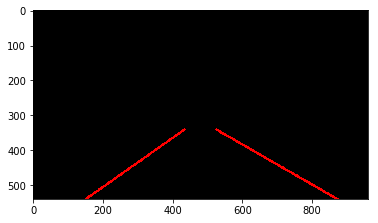

 35%|███▌      | 242/682 [02:16<03:10,  2.31it/s]

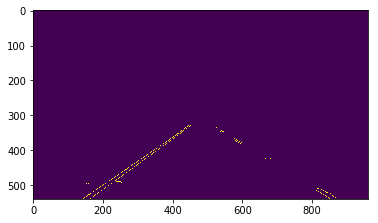

[[ 0.61904762]
 [-0.75      ]
 [-0.68      ]
 [-0.66666667]
 [ 0.5       ]
 [-0.86666667]
 [ 0.64285714]
 [-0.75      ]
 [-0.8125    ]
 [-0.7826087 ]
 [ 0.14285714]
 [-0.66666667]
 [-0.81818182]
 [ 0.57894737]
 [-0.66666667]
 [-0.84615385]
 [-0.7       ]
 [-0.64285714]
 [-0.6       ]
 [-0.81818182]
 [-0.76923077]
 [-0.73913043]
 [-0.8       ]
 [ 0.625     ]
 [ 0.        ]
 [-0.81818182]]
left_m = -0.717558228528  right_m = 0.601774535909
left_c = 651.738182379  right_c = 21.7107474061
left_y = 328.119421313  right_y = 368.934654626  min y = 328.119421313
left_y = 549.127355699  right_y = 545.856368183  max y = 549.127355699


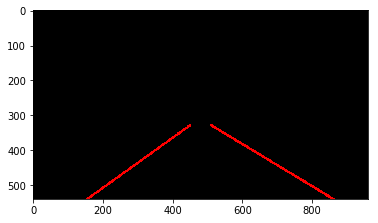

 36%|███▌      | 243/682 [02:16<03:08,  2.33it/s]

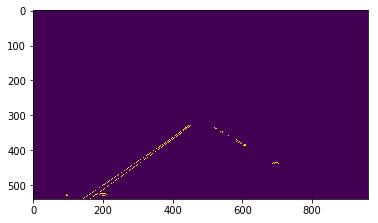

[[-0.67669173]
 [-0.72727273]
 [ 0.61538462]
 [-0.75862069]
 [-0.6       ]
 [-0.68421053]
 [ 0.47058824]
 [-0.8       ]
 [-0.64      ]
 [-0.75      ]
 [-0.83333333]
 [-0.61538462]
 [-0.58333333]
 [-0.625     ]
 [-0.84615385]
 [-0.61111111]
 [-0.8       ]
 [-0.58333333]
 [-0.84615385]
 [-0.57142857]
 [ 0.52941176]]
left_m = -0.709377634317  right_m = 0.603919546158
left_c = 649.135656327  right_c = 20.3904074265
left_y = 334.17198669  right_y = 368.85198556  min y = 334.17198669
left_y = 547.694654619  right_y = 384.55389376  max y = 547.694654619


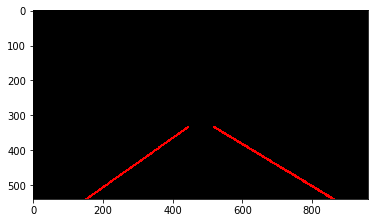

 36%|███▌      | 244/682 [02:16<03:15,  2.24it/s]

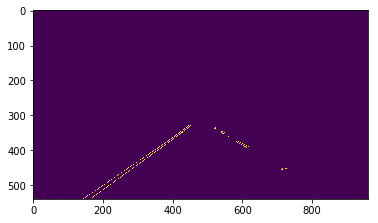

[[-0.73076923]
 [-0.58333333]
 [-0.78571429]
 [-0.75      ]
 [-0.70175439]
 [-0.76923077]
 [-0.69565217]
 [ 0.54545455]
 [-0.78571429]
 [-0.72727273]
 [-0.58333333]
 [-0.84615385]
 [ 0.52173913]
 [-0.69230769]
 [-0.73913043]
 [-0.78571429]
 [-0.75      ]
 [ 0.52941176]
 [-0.83333333]
 [-0.9       ]
 [-0.8       ]]
left_m = -0.698298116231  right_m = 0.534626038781
left_c = 646.151144353  right_c = 61.9390581717
left_y = 336.805078862  right_y = 375.229916898  min y = 336.805078862
left_y = 545.596215615  right_y = 392.872576177  max y = 545.596215615


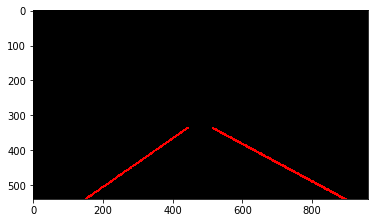

 36%|███▌      | 245/682 [02:17<03:12,  2.27it/s]

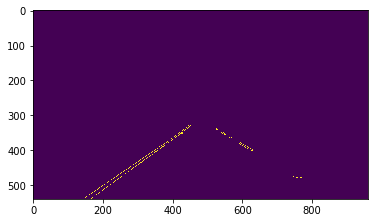

[[ 0.625     ]
 [-0.67901235]
 [-0.67605634]
 [-0.70588235]
 [-0.66666667]
 [ 0.53846154]
 [-0.75      ]
 [-0.73170732]
 [-0.78      ]
 [-0.75      ]
 [-0.71428571]
 [-0.64285714]
 [-0.74074074]
 [-0.61111111]
 [-0.83333333]
 [-0.58333333]
 [-0.78571429]
 [-0.58333333]
 [-0.72727273]
 [ 0.        ]
 [ 0.5       ]]
left_m = -0.692765159518  right_m = 0.605458221024
left_c = 644.387321901  right_c = 20.2068733154
left_y = 338.877886554  right_y = 376.821765499  min y = 338.877886554
left_y = 543.936373771  right_y = 396.196428571  max y = 543.936373771


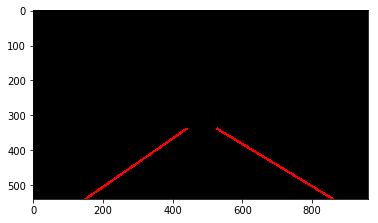

 36%|███▌      | 246/682 [02:17<03:14,  2.24it/s]

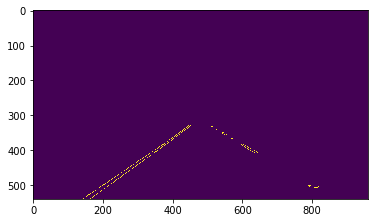

[[-0.6       ]
 [-0.65      ]
 [-0.64516129]
 [-0.73214286]
 [-0.72      ]
 [ 0.65      ]
 [-0.73076923]
 [-0.7826087 ]
 [-0.78571429]
 [-0.72727273]
 [-0.6       ]
 [-0.75      ]
 [-0.58333333]
 [-0.57142857]
 [ 0.53333333]
 [-0.54545455]
 [ 0.7       ]
 [-0.61538462]
 [-0.58333333]
 [-0.76923077]
 [ 0.54545455]]
left_m = -0.681789684526  right_m = 0.548360655738
left_c = 638.634573537  right_c = 56.4196721311
left_y = 334.556374238  right_y = 388.177868852  min y = 334.556374238
left_y = 541.138648649  right_y = 409.01557377  max y = 541.138648649


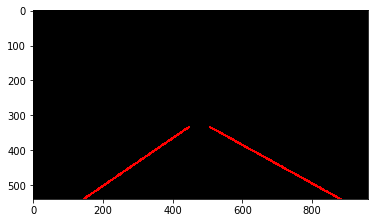

 36%|███▌      | 247/682 [02:18<03:10,  2.29it/s]

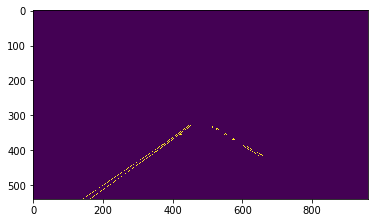

[[-0.64705882]
 [ 0.54545455]
 [-0.70967742]
 [-0.6741573 ]
 [-0.6       ]
 [-0.69565217]
 [-0.64      ]
 [-0.6       ]
 [-0.65517241]
 [-0.63636364]
 [-0.63333333]
 [-0.58333333]
 [-0.66666667]
 [ 0.5862069 ]
 [-0.64285714]
 [-0.6       ]
 [-0.7826087 ]
 [ 0.62068966]
 [-0.65384615]
 [-0.70588235]
 [ 0.5       ]
 [-0.58333333]
 [-0.6       ]
 [-0.54545455]
 [-0.625     ]
 [-0.63636364]
 [-0.63636364]
 [-0.76923077]
 [-0.71428571]
 [-0.54545455]
 [ 0.6       ]
 [-0.54545455]]
left_m = -0.702877059954  right_m = 0.585934686037
left_c = 647.757370434  right_c = 33.1408032177
left_y = 334.274201695  right_y = 352.475207108  min y = 334.274201695
left_y = 543.731565561  right_y = 414.584283828  max y = 543.731565561


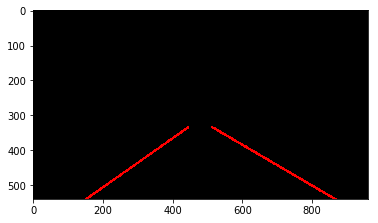

 36%|███▋      | 248/682 [02:18<03:05,  2.34it/s]

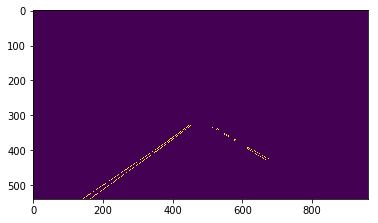

[[-0.75      ]
 [-0.69565217]
 [-0.74358974]
 [-0.72222222]
 [-0.58333333]
 [-0.65384615]
 [-0.8       ]
 [ 0.4       ]
 [-0.9       ]
 [-0.64285714]
 [-0.725     ]
 [ 0.46153846]
 [-0.61904762]
 [-0.76923077]
 [-0.6       ]
 [-0.75      ]
 [ 0.57894737]
 [-0.7       ]
 [ 0.54545455]
 [-0.7       ]
 [-0.64285714]
 [-0.71428571]
 [-0.63636364]
 [-0.72222222]
 [ 0.53846154]
 [-0.69230769]]
left_m = -0.686737758626  right_m = 0.586830213041
left_c = 641.859089542  right_c = 33.1423499032
left_y = 345.875115574  right_y = 354.138476436  min y = 345.875115574
left_y = 543.655590058  right_y = 425.144932214  max y = 543.655590058


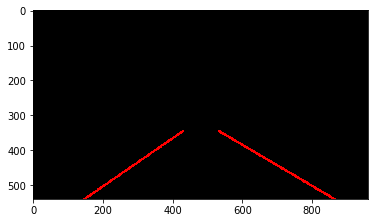

 37%|███▋      | 249/682 [02:19<03:04,  2.34it/s]

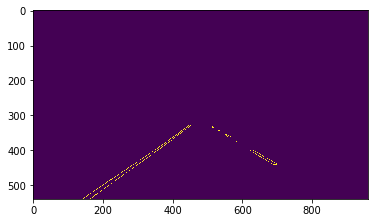

[[-0.68253968]
 [ 0.58333333]
 [-0.74545455]
 [-0.75531915]
 [-0.76923077]
 [ 0.57142857]
 [ 0.53846154]
 [-0.76923077]
 [-0.75      ]
 [-0.84615385]
 [-0.76666667]
 [ 0.55172414]
 [-0.8       ]
 [ 0.5       ]
 [ 0.5       ]
 [ 0.5       ]
 [-0.76923077]
 [ 0.54545455]
 [-0.61538462]
 [-0.75      ]
 [-0.76923077]
 [ 0.        ]
 [ 0.6       ]
 [-0.75      ]
 [-0.76923077]
 [-0.6       ]
 [-0.75      ]]
left_m = -0.720926425334  right_m = 0.600512228641
left_c = 652.791599652  right_c = 24.6417998798
left_y = 329.816561103  right_y = 355.524037861  min y = 329.816561103
left_y = 549.69912083  right_y = 437.794213185  max y = 549.69912083


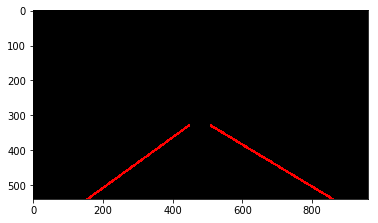

 37%|███▋      | 250/682 [02:19<03:11,  2.25it/s]

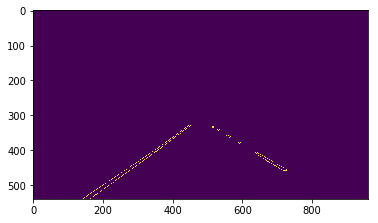

[[-0.70588235]
 [-0.67400881]
 [-0.69444444]
 [-0.70731707]
 [-0.78571429]
 [-0.84615385]
 [ 0.64285714]
 [ 0.64285714]
 [-0.84615385]
 [-0.83333333]
 [ 0.59210526]
 [ 0.54285714]
 [ 0.5625    ]
 [-0.6875    ]
 [-0.83333333]
 [-0.83333333]
 [-0.75      ]
 [-0.63636364]]
left_m = -0.718309367197  right_m = 0.588246084028
left_c = 653.789649404  right_c = 31.0578229983
left_y = 344.916621509  right_y = 356.357907466  min y = 344.916621509
left_y = 551.071409895  right_y = 459.300972171  max y = 551.071409895


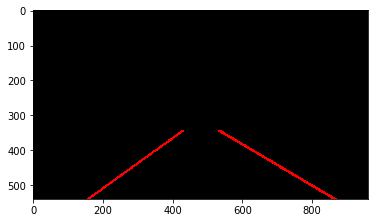

 37%|███▋      | 251/682 [02:20<03:09,  2.28it/s]

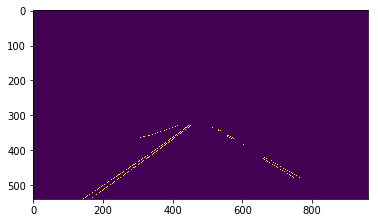

[[ 0.57142857]
 [-0.72289157]
 [-0.65789474]
 [-0.65517241]
 [-0.75      ]
 [-0.85714286]
 [-1.        ]
 [ 0.57142857]
 [ 0.62962963]
 [-0.6875    ]
 [-0.61111111]
 [-0.35      ]
 [ 0.57142857]
 [ 0.53846154]
 [-0.90909091]
 [ 0.56521739]
 [ 0.6875    ]
 [-0.6       ]
 [ 0.51851852]
 [-0.625     ]
 [-0.70588235]]
left_m = -0.684337827538  right_m = 0.60134719563
left_c = 640.820517582  right_c = 23.9799953437
left_y = 352.029954362  right_y = 358.93038331  min y = 352.029954362
left_y = 529.957789521  right_y = 478.59847524  max y = 529.957789521


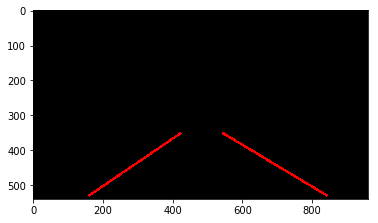

 37%|███▋      | 252/682 [02:20<03:06,  2.30it/s]

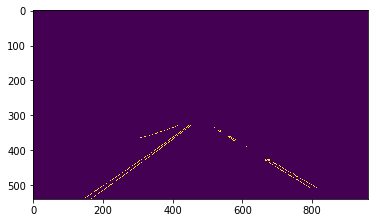

[[-0.63888889]
 [ 0.62790698]
 [-0.61904762]
 [-0.7278481 ]
 [-0.68421053]
 [ 0.5       ]
 [-0.66666667]
 [ 0.54545455]
 [-0.6875    ]
 [-0.30769231]
 [ 0.66666667]
 [-0.85714286]
 [-0.68      ]
 [ 0.6       ]
 [ 0.53846154]
 [-0.63333333]
 [-0.68181818]
 [ 0.5       ]
 [ 0.5625    ]
 [-0.34782609]
 [-0.64285714]
 [-0.61111111]
 [ 0.52631579]
 [ 0.54545455]
 [ 0.5       ]
 [ 0.5       ]
 [-0.70588235]
 [-0.76923077]
 [-0.63636364]
 [-0.6       ]
 [-0.75      ]
 [ 0.61538462]
 [-0.66666667]
 [ 0.54545455]
 [-0.36363636]
 [ 0.45454545]
 [-0.71428571]
 [-0.58333333]
 [-0.36363636]
 [ 0.53333333]
 [-0.69230769]]
left_m = -0.700800469357  right_m = 0.593904786849
left_c = 646.088530588  right_c = 29.6748013897
left_y = 329.326718438  right_y = 362.261482025  min y = 329.326718438
left_y = 540.968460184  right_y = 511.925488311  max y = 540.968460184


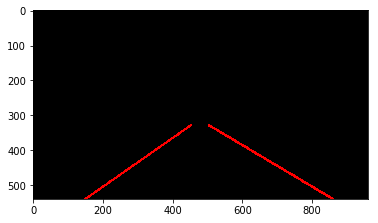

 37%|███▋      | 253/682 [02:20<03:05,  2.31it/s]

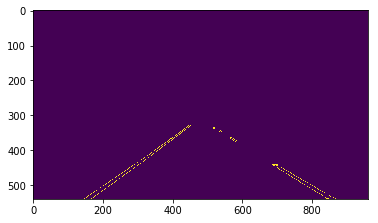

[[-0.75      ]
 [-0.69047619]
 [-0.78571429]
 [-0.75806452]
 [-0.8125    ]
 [-0.70588235]
 [-0.66101695]
 [ 0.54545455]
 [ 0.4375    ]
 [-0.83333333]
 [ 0.54545455]
 [ 0.63793103]
 [-0.68571429]
 [ 0.62      ]
 [ 0.54054054]
 [ 0.5       ]
 [-0.80952381]
 [-0.66666667]
 [ 0.66666667]
 [ 0.7       ]
 [ 0.61538462]
 [ 0.5       ]
 [-0.6       ]
 [ 0.54545455]
 [-0.65      ]
 [-0.63636364]
 [-0.9       ]
 [-0.625     ]
 [-0.8       ]
 [-0.90909091]
 [-0.58333333]]
left_m = -0.720664362195  right_m = 0.616014004991
left_c = 654.683154877  right_c = 14.4287397006
left_y = 329.663527527  right_y = 365.556722546  min y = 329.663527527
left_y = 539.376856926  right_y = 540.504699963  max y = 540.504699963


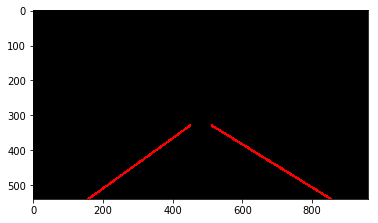

 37%|███▋      | 254/682 [02:21<03:02,  2.34it/s]

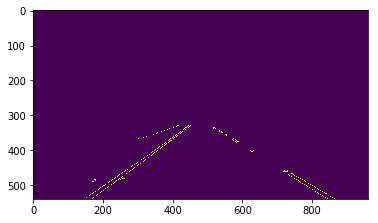

[[-0.70833333]
 [-0.69863014]
 [-0.75423729]
 [ 0.6875    ]
 [ 0.5       ]
 [-0.70689655]
 [-0.29411765]
 [-0.8       ]
 [-0.71428571]
 [ 0.5       ]
 [ 0.65217391]
 [-0.66666667]
 [-0.72727273]
 [ 0.58333333]
 [ 0.6       ]
 [-0.33333333]
 [-0.41666667]
 [ 0.5       ]
 [-0.76470588]
 [ 0.5       ]
 [ 0.6875    ]
 [-0.78571429]
 [ 0.64705882]
 [ 0.53571429]
 [ 0.66666667]
 [ 0.64705882]
 [ 0.69230769]
 [-0.76470588]]
left_m = -0.720665129811  right_m = 0.602761137874
left_c = 653.129769437  right_c = 24.1650059629
left_y = 338.19910771  right_y = 366.533332275  min y = 338.19910771
left_y = 546.471330225  right_y = 544.950629086  max y = 546.471330225


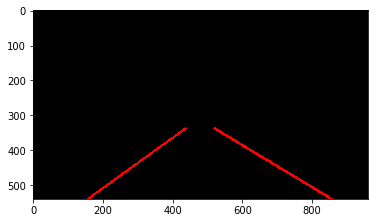

 37%|███▋      | 255/682 [02:21<03:09,  2.26it/s]

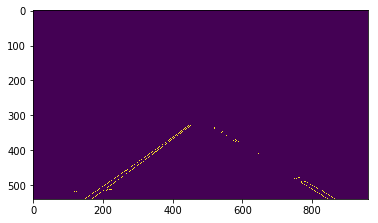

[[-0.75471698]
 [ 0.60606061]
 [ 0.58064516]
 [-0.70833333]
 [-0.8       ]
 [-0.80952381]
 [-0.66666667]
 [-0.65853659]
 [ 0.5625    ]
 [-0.85714286]
 [ 0.6       ]
 [-0.65625   ]
 [-0.58823529]
 [-0.58333333]
 [ 0.65      ]
 [-0.86666667]
 [ 0.60869565]
 [ 0.69230769]
 [-0.77419355]
 [-0.9       ]
 [ 0.64285714]
 [-0.66666667]
 [-0.90909091]
 [-0.85714286]
 [-0.85714286]
 [ 0.        ]
 [-0.9       ]
 [ 0.65      ]
 [ 0.6       ]
 [-0.8       ]]
left_m = -0.710260289114  right_m = 0.601308944799
left_c = 652.553355801  right_c = 24.5689190178
left_y = 332.22596541  right_y = 369.118944388  min y = 332.22596541
left_y = 547.434833012  right_y = 544.099847324  max y = 547.434833012


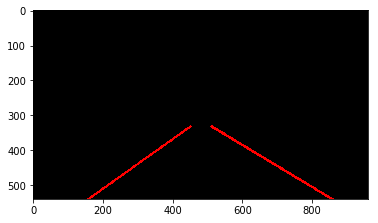

 38%|███▊      | 256/682 [02:22<03:06,  2.29it/s]

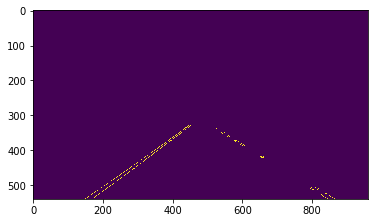

[[-0.75      ]
 [-0.6875    ]
 [-0.69047619]
 [-0.75      ]
 [-0.81818182]
 [-0.8125    ]
 [-0.75949367]
 [-0.8125    ]
 [-0.78571429]
 [-0.9       ]
 [-0.81818182]
 [-0.9       ]
 [ 0.56521739]
 [-0.8       ]
 [-0.73684211]
 [-0.8       ]
 [-0.73913043]
 [ 0.55555556]
 [ 0.7       ]
 [-0.75      ]
 [-0.81818182]
 [ 0.66666667]
 [-0.8       ]
 [-0.63636364]]
left_m = -0.717047511308  right_m = 0.600529949193
left_c = 652.762145078  right_c = 24.8469474946
left_y = 329.373717478  right_y = 371.352728179  min y = 329.373717478
left_y = 545.205018382  right_y = 540.702173851  max y = 545.205018382


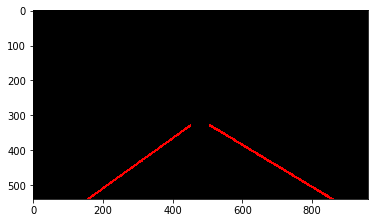

 38%|███▊      | 257/682 [02:22<03:15,  2.18it/s]

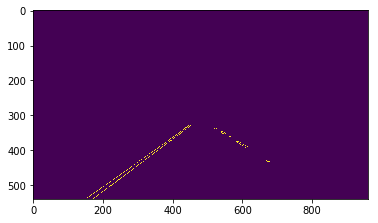

[[-0.81818182]
 [-0.69230769]
 [-0.73076923]
 [-0.75217391]
 [-0.81818182]
 [-0.77272727]
 [-0.77777778]
 [-0.64285714]
 [-0.8       ]
 [ 0.61538462]
 [ 0.58333333]
 [ 0.6       ]
 [ 0.53846154]
 [-0.68181818]
 [-0.69565217]
 [-0.8       ]
 [-0.81818182]]
left_m = -0.724870127892  right_m = 0.494744218641
left_c = 652.9476068  right_c = 86.0087596356
left_y = 326.03117912  right_y = 374.444639103  min y = 326.03117912
left_y = 543.492217488  right_y = 390.2764541  max y = 543.492217488


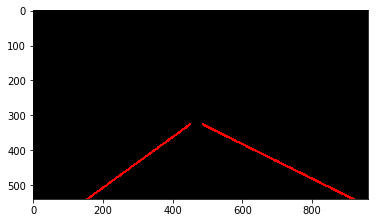

 38%|███▊      | 258/682 [02:23<03:16,  2.16it/s]

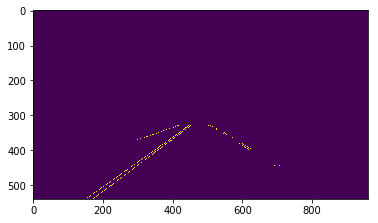

[[-0.74418605]
 [-0.775     ]
 [-0.34375   ]
 [-0.66666667]
 [-0.72413793]
 [-0.8       ]
 [-0.6       ]
 [-0.75      ]
 [-0.78571429]
 [ 0.61538462]
 [ 0.6       ]
 [-0.75      ]
 [ 0.        ]
 [-0.83333333]
 [-0.76923077]
 [ 0.6       ]
 [ 0.4       ]
 [-0.71794872]
 [-0.79166667]
 [-0.8       ]
 [-0.78571429]
 [-0.76470588]
 [-0.76923077]
 [-0.4       ]
 [-0.6       ]
 [-0.30769231]
 [-0.9       ]
 [ 0.54545455]]
left_m = -0.723556284333  right_m = 0.606979034079
left_c = 655.673720561  right_c = 20.8152213069
left_y = 328.626280043  right_y = 349.797857778  min y = 328.626280043
left_y = 541.351827637  right_y = 396.535243402  max y = 541.351827637


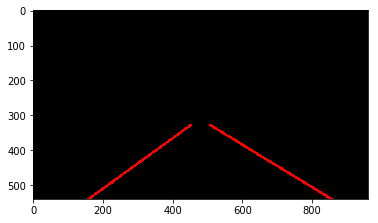

 38%|███▊      | 259/682 [02:23<03:10,  2.22it/s]

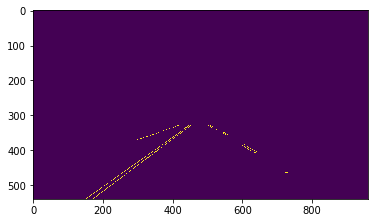

[[-0.70229008]
 [-0.83333333]
 [-0.72151899]
 [-0.84210526]
 [-0.84615385]
 [-0.3125    ]
 [-0.3       ]
 [-0.83333333]
 [-0.9       ]
 [-0.71428571]
 [-0.64285714]
 [-0.80769231]
 [-0.6       ]
 [-0.74285714]
 [-0.84615385]
 [ 0.6       ]
 [ 0.57894737]
 [-0.70588235]
 [-0.4       ]
 [-0.84615385]
 [ 0.5       ]
 [-0.6       ]
 [-0.72222222]
 [-0.83333333]
 [-0.69230769]
 [ 0.66666667]
 [ 0.7       ]
 [-0.33333333]
 [ 0.7       ]]
left_m = -0.737056259322  right_m = 0.578071215879
left_c = 661.450818998  right_c = 37.9922778962
left_y = 329.038446044  right_y = 352.463019334  min y = 329.038446044
left_y = 549.418267581  right_y = 407.379784843  max y = 549.418267581


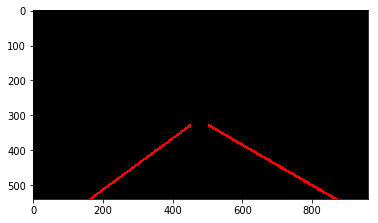

 38%|███▊      | 260/682 [02:24<03:18,  2.13it/s]

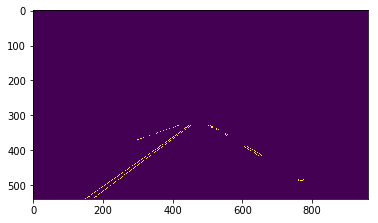

[[-0.78      ]
 [-0.72463768]
 [-0.69230769]
 [-0.8       ]
 [-0.75      ]
 [-0.72131148]
 [-0.72222222]
 [-0.64285714]
 [ 0.63333333]
 [-0.84615385]
 [ 0.5       ]
 [-0.34782609]
 [-0.85714286]
 [-0.64285714]
 [-0.75      ]
 [-0.9       ]
 [-0.33333333]
 [-0.58333333]
 [ 0.57142857]
 [-0.71428571]
 [-0.6       ]
 [-0.58333333]
 [-0.4       ]
 [-0.36363636]
 [-0.58333333]]
left_m = -0.726735947558  right_m = 0.582706766917
left_c = 655.499363753  right_c = 34.1428571429
left_y = 327.741451404  right_y = 389.593984962  min y = 327.741451404
left_y = 545.762235672  right_y = 409.406015038  max y = 545.762235672


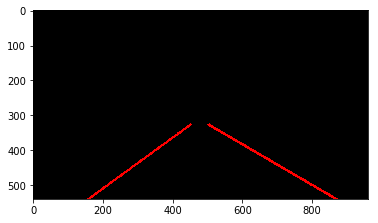

 38%|███▊      | 261/682 [02:24<03:28,  2.02it/s]

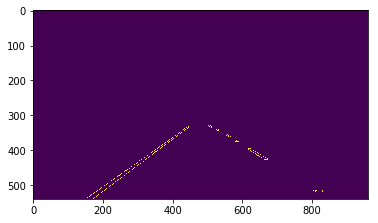

[[-0.65      ]
 [-0.61538462]
 [-0.77777778]
 [-0.83333333]
 [-0.6       ]
 [-0.66666667]
 [-0.58333333]
 [-0.74603175]
 [-0.8125    ]
 [-0.76271186]
 [ 0.65625   ]
 [-0.625     ]
 [-0.9       ]
 [ 0.54545455]
 [-0.75      ]
 [ 0.59183673]
 [ 0.57142857]
 [-0.64705882]
 [-0.61538462]
 [-0.63636364]
 [-0.73684211]
 [-0.8       ]
 [-0.61538462]
 [-0.6       ]]
left_m = -0.703506770261  right_m = 0.568791921132
left_c = 646.890580257  right_c = 44.266374563
left_y = 338.754614883  right_y = 329.799918971  min y = 329.799918971
left_y = 540.661057948  right_y = 427.063337485  max y = 540.661057948


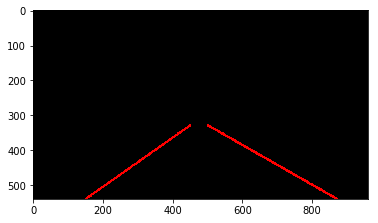

 38%|███▊      | 262/682 [02:25<03:22,  2.07it/s]

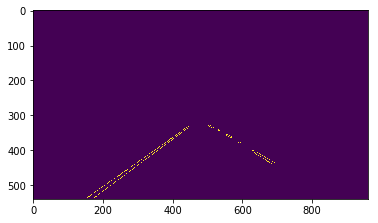

[[ 0.59322034]
 [-0.70181818]
 [-0.68421053]
 [-0.75      ]
 [ 0.65      ]
 [-0.74242424]
 [-0.69230769]
 [ 0.38461538]
 [ 0.6       ]
 [-0.80952381]
 [-0.63636364]
 [-0.7       ]
 [-0.8       ]
 [ 0.45454545]
 [-0.66666667]
 [-0.6875    ]
 [ 0.61538462]
 [-0.63636364]
 [ 0.58333333]
 [-0.66666667]]
left_m = -0.737353466026  right_m = 0.548421780201
left_c = 662.96987234  right_c = 57.6738345749
left_y = 331.898166095  right_y = 403.179556102  min y = 331.898166095
left_y = 551.62949897  right_y = 438.826971815  max y = 551.62949897


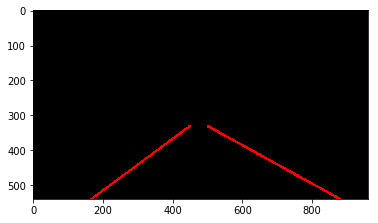

 39%|███▊      | 263/682 [02:25<03:17,  2.13it/s]

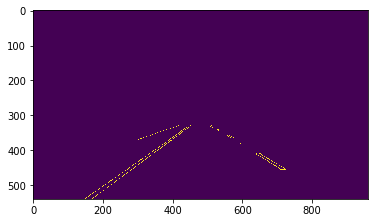

[[-0.72093023]
 [-0.8       ]
 [-0.68253968]
 [-0.35294118]
 [-0.75      ]
 [-0.66666667]
 [-0.76190476]
 [ 0.        ]
 [-0.77777778]
 [ 0.57692308]
 [-0.77419355]
 [-0.66666667]
 [-0.64705882]
 [ 0.57894737]
 [-0.6       ]
 [-0.6       ]
 [ 0.54545455]
 [-0.80952381]
 [-0.61538462]
 [ 0.64285714]
 [ 0.70588235]
 [ 0.61538462]
 [-0.84615385]
 [-0.64285714]
 [ 0.45454545]
 [ 0.66666667]
 [-0.33333333]
 [ 0.75      ]
 [ 0.5       ]
 [-0.9       ]
 [-0.63636364]
 [-0.8       ]
 [ 0.6       ]]
left_m = -0.713722753278  right_m = 0.621074383301
left_c = 651.215811842  right_c = 10.6921260534
left_y = 330.75429562  right_y = 356.630557552  min y = 330.75429562
left_y = 542.016230591  right_y = 459.72890518  max y = 542.016230591


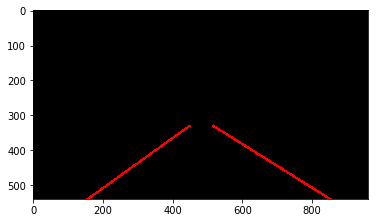

 39%|███▊      | 264/682 [02:26<03:19,  2.09it/s]

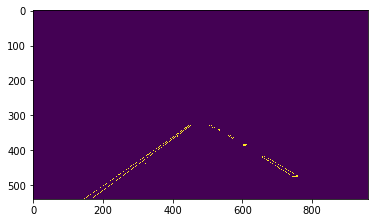

[[-0.75581395]
 [ 0.64102564]
 [ 0.5       ]
 [-0.69958848]
 [-0.75308642]
 [ 0.5       ]
 [ 0.55555556]
 [-0.8       ]
 [-0.8       ]
 [-0.76923077]
 [-0.8       ]
 [ 0.7       ]
 [ 0.53846154]
 [ 0.53333333]
 [ 0.63636364]
 [ 0.53333333]
 [ 0.5625    ]
 [-0.84615385]
 [ 0.6       ]
 [ 0.45454545]
 [-0.81818182]
 [-0.72222222]]
left_m = -0.697702361742  right_m = 0.582214485546
left_c = 647.25575278  right_c = 33.664460056
left_y = 346.546034869  right_y = 327.682775256  min y = 327.682775256
left_y = 536.321077263  right_y = 472.654182157  max y = 536.321077263


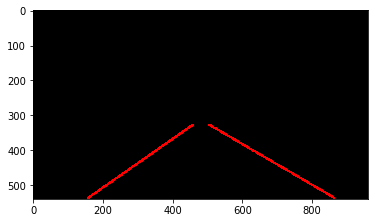

 39%|███▉      | 265/682 [02:26<03:14,  2.15it/s]

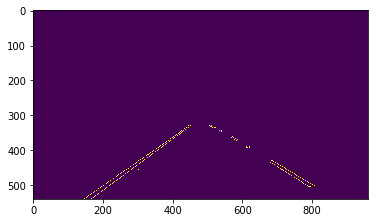

[[-0.63636364]
 [ 0.46153846]
 [-0.75      ]
 [ 0.625     ]
 [ 0.54545455]
 [ 0.625     ]
 [-0.69444444]
 [-0.64285714]
 [-0.77419355]
 [ 0.54545455]
 [-0.75      ]
 [ 0.58333333]
 [-0.66666667]
 [-0.71428571]
 [ 0.5       ]
 [-0.7       ]
 [-0.6779661 ]
 [-0.625     ]
 [ 0.61111111]
 [ 0.5       ]
 [-0.76923077]
 [ 0.5       ]
 [ 0.45454545]
 [ 0.55555556]
 [-0.68421053]
 [ 0.58823529]
 [-0.72727273]
 [-0.66666667]
 [-0.76470588]
 [-0.1       ]]
left_m = -0.709864316562  right_m = 0.612948260461
left_c = 649.563136151  right_c = 14.3401011825
left_y = 329.414329382  right_y = 365.559454427  min y = 329.414329382
left_y = 545.213081617  right_y = 498.569226947  max y = 545.213081617


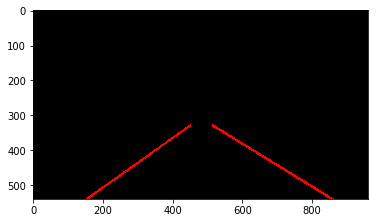

 39%|███▉      | 266/682 [02:27<03:22,  2.05it/s]

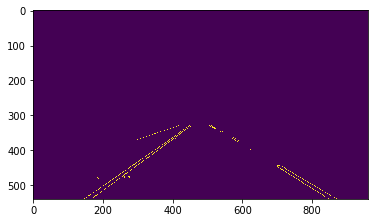

[[-0.72972973]
 [-0.7008547 ]
 [ 0.58333333]
 [-0.6       ]
 [ 0.54166667]
 [-0.63157895]
 [ 0.60526316]
 [-0.7       ]
 [-0.6       ]
 [-0.34482759]
 [-0.71428571]
 [-0.63636364]
 [ 0.5       ]
 [ 0.54545455]
 [-0.70588235]
 [-0.66666667]
 [-0.78571429]
 [ 0.53333333]
 [ 0.46153846]
 [-0.38095238]
 [-0.625     ]
 [ 0.6       ]
 [-0.75      ]
 [ 0.55555556]
 [ 0.5       ]
 [ 0.53333333]
 [-0.375     ]
 [-0.75      ]
 [ 0.6       ]
 [-0.61538462]
 [ 0.54545455]
 [-0.58333333]]
left_m = -0.724330148994  right_m = 0.598378710203
left_c = 654.188554251  right_c = 24.2677046378
left_y = 329.688647502  right_y = 366.540326874  min y = 329.688647502
left_y = 526.706448028  right_y = 535.881501861  max y = 535.881501861


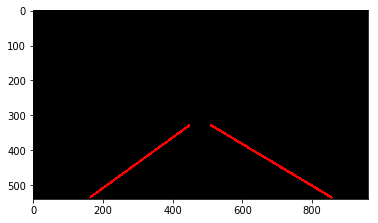

 39%|███▉      | 267/682 [02:27<03:15,  2.13it/s]

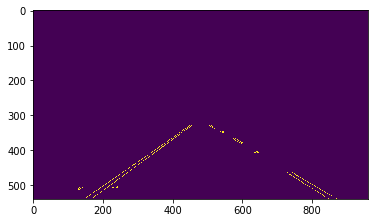

[[-0.7       ]
 [-0.73033708]
 [-0.70588235]
 [-0.73913043]
 [ 0.5       ]
 [ 0.58333333]
 [ 0.57142857]
 [-0.81818182]
 [ 0.58333333]
 [ 0.5       ]
 [-0.7037037 ]
 [ 0.6       ]
 [ 0.53846154]
 [ 0.5625    ]
 [-0.83333333]
 [-0.72222222]
 [ 0.52380952]
 [ 0.5       ]
 [-0.84615385]
 [ 0.64      ]
 [ 0.5       ]
 [ 0.53333333]
 [-0.8       ]
 [-0.71428571]]
left_m = -0.689657699292  right_m = 0.605818694857
left_c = 643.811048448  right_c = 19.6935517235
left_y = 334.844399166  right_y = 325.631992626  min y = 325.631992626
left_y = 533.465816562  right_y = 535.851079742  max y = 535.851079742


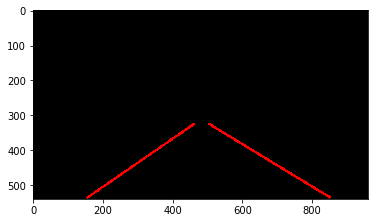

 39%|███▉      | 268/682 [02:27<03:12,  2.15it/s]

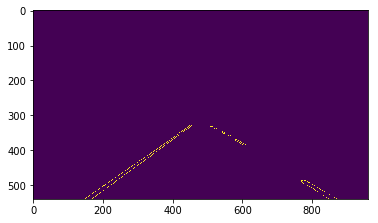

[[-0.72277228]
 [-0.75      ]
 [-0.70707071]
 [-0.70588235]
 [ 0.5       ]
 [-0.69444444]
 [ 0.53333333]
 [-0.75      ]
 [-0.8       ]
 [ 0.56521739]
 [-0.76923077]
 [ 0.5625    ]
 [ 0.5483871 ]
 [ 0.6       ]
 [-0.71428571]
 [-0.76470588]
 [ 0.54545455]
 [ 0.5       ]
 [-0.71428571]
 [-0.7       ]
 [-0.78571429]
 [ 0.6       ]]
left_m = -0.705652531182  right_m = 0.608073026684
left_c = 649.514772719  right_c = 16.4681621908
left_y = 332.676786218  right_y = 368.542444641  min y = 332.676786218
left_y = 544.372545573  right_y = 541.235184219  max y = 544.372545573


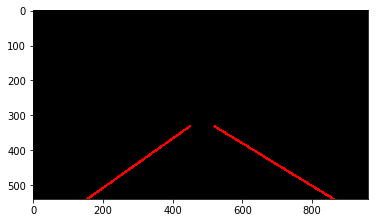

 39%|███▉      | 269/682 [02:28<03:08,  2.19it/s]

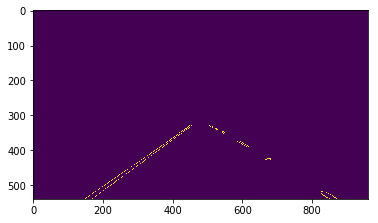

[[-0.69767442]
 [-0.83333333]
 [-0.73148148]
 [-0.78571429]
 [-0.72      ]
 [ 0.45833333]
 [ 0.57142857]
 [ 0.55555556]
 [ 0.45454545]
 [-0.7       ]
 [-0.79166667]
 [-0.6       ]
 [-0.6       ]
 [ 0.71428571]
 [-0.8125    ]
 [-0.72      ]
 [-0.66666667]
 [-0.58333333]
 [-0.64285714]
 [-0.76470588]
 [-0.75675676]
 [-0.81818182]
 [ 0.5625    ]]
left_m = -0.71655866561  right_m = 0.631224670719
left_c = 653.078591484  right_c = 3.30743097771
left_y = 336.359661284  right_y = 378.886110056  min y = 336.359661284
left_y = 546.311350308  right_y = 535.429828394  max y = 546.311350308


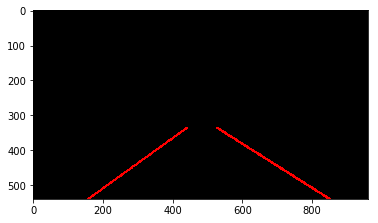

 40%|███▉      | 270/682 [02:28<03:05,  2.22it/s]

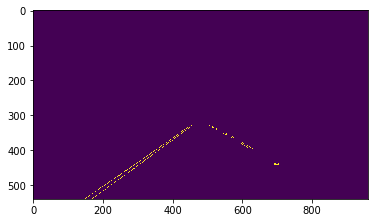

[[-0.76923077]
 [-0.72847682]
 [ 0.62068966]
 [-0.65789474]
 [-0.9       ]
 [-0.67948718]
 [-0.6744186 ]
 [-0.66666667]
 [ 0.5       ]
 [-0.71153846]
 [ 0.5       ]
 [-0.76923077]
 [ 0.45454545]
 [-0.73684211]
 [-0.69230769]]
left_m = -0.708340695335  right_m = 0.53385742362
left_c = 650.899941897  right_c = 60.2579953547
left_y = 337.105013863  right_y = 376.301590138  min y = 337.105013863
left_y = 545.357178292  right_y = 394.452742541  max y = 545.357178292


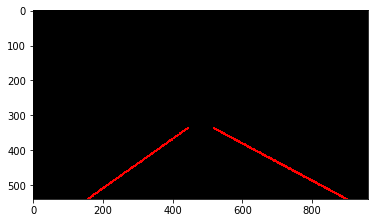

 40%|███▉      | 271/682 [02:29<03:06,  2.20it/s]

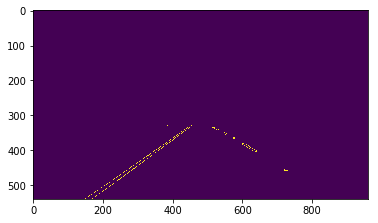

[[ 0.07692308]
 [-0.73684211]
 [-0.69827586]
 [-0.76923077]
 [-0.66666667]
 [ 0.54166667]
 [ 0.625     ]
 [-0.76470588]
 [-0.76923077]
 [-0.73239437]
 [-0.6       ]
 [-0.84615385]
 [-0.8       ]
 [-0.71875   ]
 [-0.6       ]
 [-0.7       ]
 [-0.75      ]
 [ 0.46666667]
 [-0.63636364]
 [-0.84615385]
 [-0.625     ]
 [-0.6       ]
 [-0.72727273]
 [ 0.63636364]]
left_m = -0.714732164526  right_m = 0.536225196124
left_c = 654.670143442  right_c = 61.1273650208
left_y = 329.467008582  right_y = 382.862482695  min y = 329.467008582
left_y = 546.745586598  right_y = 405.383940932  max y = 546.745586598


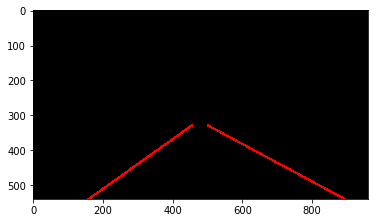

 40%|███▉      | 272/682 [02:29<03:14,  2.11it/s]

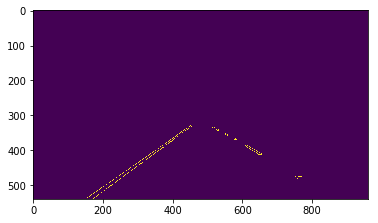

[[-0.7       ]
 [-0.68888889]
 [-0.70491803]
 [-0.83333333]
 [-0.67948718]
 [-0.66666667]
 [-0.71428571]
 [-0.64705882]
 [ 0.57142857]
 [-0.71875   ]
 [-0.79166667]
 [ 0.52631579]
 [-0.58333333]
 [-0.74074074]
 [-0.72727273]
 [ 0.55      ]
 [-0.77777778]
 [ 0.53333333]
 [ 0.61538462]
 [ 0.36363636]
 [-0.63636364]
 [-0.58333333]
 [ 0.54545455]
 [ 0.5       ]]
left_m = -0.704753715279  right_m = 0.582117099651
left_c = 651.330019972  right_c = 31.1473594416
left_y = 329.962325805  right_y = 351.893881349  min y = 329.962325805
left_y = 532.22664209  right_y = 413.016176813  max y = 532.22664209


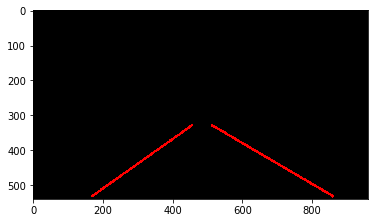

 40%|████      | 273/682 [02:30<03:10,  2.15it/s]

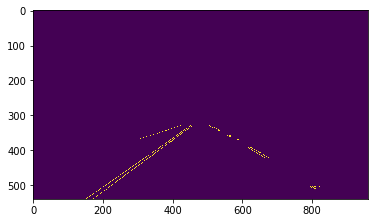

[[-0.78125   ]
 [-0.30952381]
 [-0.6875    ]
 [-0.72093023]
 [-0.9       ]
 [-0.70909091]
 [-0.73076923]
 [ 0.45454545]
 [-0.66666667]
 [-0.69047619]
 [-0.69444444]
 [-0.7254902 ]
 [ 0.6       ]
 [-0.625     ]
 [ 0.5       ]
 [ 0.57142857]
 [-0.34210526]
 [-0.63636364]
 [ 0.45454545]
 [-0.73684211]
 [ 0.5       ]
 [-0.63636364]
 [-0.75      ]
 [ 0.38461538]
 [-0.58333333]
 [-0.78571429]
 [-0.66666667]
 [-0.125     ]
 [-0.64285714]
 [-0.41666667]
 [-0.63636364]
 [-0.27272727]]
left_m = -0.705272813762  right_m = 0.608289199165
left_c = 651.651030274  right_c = 14.0318167228
left_y = 334.278264081  right_y = 351.63232226  min y = 334.278264081
left_y = 544.449562582  right_y = 418.544134168  max y = 544.449562582


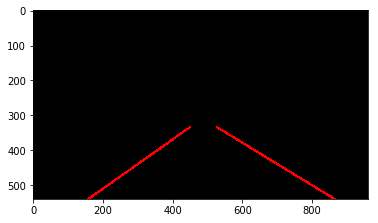

 40%|████      | 274/682 [02:30<03:09,  2.15it/s]

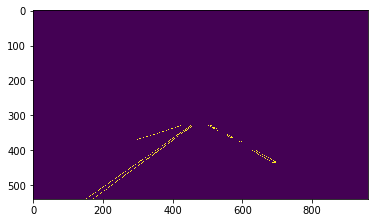

[[-0.68181818]
 [-0.69747899]
 [ 0.5       ]
 [-0.75      ]
 [-0.77777778]
 [-0.78125   ]
 [-0.9       ]
 [-0.33333333]
 [-0.85714286]
 [-0.9       ]
 [ 0.61538462]
 [-0.63636364]
 [-0.92307692]
 [-0.30434783]
 [ 0.58823529]
 [-0.84615385]
 [-0.25      ]
 [-0.69230769]
 [-0.75      ]
 [ 0.54545455]
 [ 0.53846154]
 [ 0.        ]
 [ 0.54545455]
 [-0.66666667]]
left_m = -0.734633069566  right_m = 0.559424562152
left_c = 661.839930065  right_c = 46.9685936854
left_y = 343.743810943  right_y = 357.44922568  min y = 343.743810943
left_y = 549.441070421  right_y = 426.258446825  max y = 549.441070421


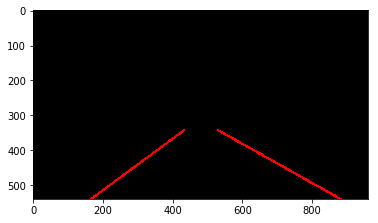

 40%|████      | 275/682 [02:31<03:07,  2.17it/s]

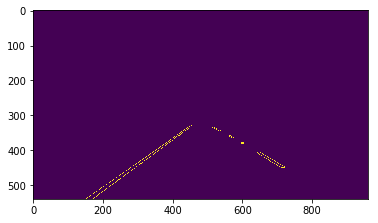

[[-0.76086957]
 [-0.80952381]
 [ 0.53846154]
 [-0.81818182]
 [-0.8125    ]
 [ 0.5       ]
 [-0.57142857]
 [-0.72727273]
 [-0.69230769]
 [ 0.58      ]
 [-0.66666667]
 [-0.63636364]
 [-0.6875    ]
 [-0.9       ]
 [-0.66666667]
 [-0.66666667]
 [-0.65      ]
 [-0.73333333]
 [-0.66666667]
 [-0.58333333]
 [-0.66666667]
 [ 0.45454545]
 [-0.6       ]
 [ 0.5       ]
 [-0.61538462]
 [ 0.58823529]
 [-0.63636364]
 [-0.8       ]
 [-0.72727273]]
left_m = -0.706944494145  right_m = 0.563284509698
left_c = 651.332050921  right_c = 44.2638134809
left_y = 331.086195073  right_y = 358.576569892  min y = 331.086195073
left_y = 541.755654328  right_y = 450.955229483  max y = 541.755654328


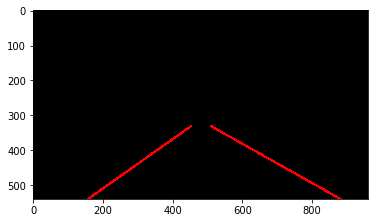

 40%|████      | 276/682 [02:31<03:06,  2.17it/s]

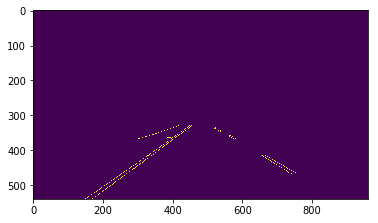

[[-0.81818182]
 [-0.72093023]
 [-0.72131148]
 [-0.58333333]
 [-0.77777778]
 [ 0.57142857]
 [-0.68      ]
 [-0.63636364]
 [ 0.62962963]
 [-0.64705882]
 [ 0.58024691]
 [-0.73076923]
 [-0.6       ]
 [ 0.57894737]
 [-0.325     ]
 [ 0.5625    ]
 [-0.71428571]
 [-0.6       ]
 [-0.04347826]
 [-0.72727273]
 [-0.73684211]
 [-0.72727273]
 [ 0.54545455]
 [-0.72727273]
 [-0.81818182]
 [-0.66666667]
 [-0.69230769]
 [-0.3       ]
 [ 0.61538462]
 [-0.31578947]
 [-0.76923077]]
left_m = -0.705734433717  right_m = 0.584856868427
left_c = 650.655679702  right_c = 29.89974281
left_y = 332.369450096  right_y = 358.004445998  min y = 332.369450096
left_y = 540.561108043  right_y = 472.051535341  max y = 540.561108043


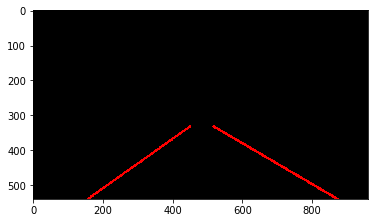

 41%|████      | 277/682 [02:32<03:16,  2.06it/s]

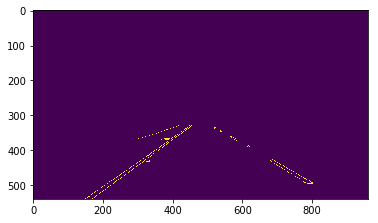

[[-0.77419355]
 [-0.8       ]
 [ 0.6       ]
 [-0.81818182]
 [-0.67924528]
 [-0.77777778]
 [-0.64      ]
 [-0.86666667]
 [-0.83333333]
 [-0.35555556]
 [ 0.60810811]
 [ 0.5952381 ]
 [-0.75      ]
 [-0.66666667]
 [-0.9       ]
 [-0.75      ]
 [-0.82352941]
 [ 0.58823529]
 [-0.33333333]
 [-0.33333333]
 [-0.6875    ]
 [-0.69230769]
 [ 0.44444444]
 [-0.8       ]
 [ 0.57142857]
 [ 0.58333333]
 [-0.69230769]
 [-0.6875    ]
 [-0.58333333]]
left_m = -0.725411914774  right_m = 0.558537336097
left_c = 656.962369391  right_c = 47.9025136971
left_y = 339.23195072  right_y = 363.476108592  min y = 339.23195072
left_y = 547.42517026  right_y = 489.70554655  max y = 547.42517026


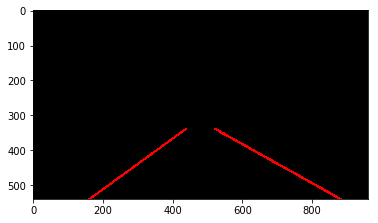

 41%|████      | 278/682 [02:32<03:09,  2.13it/s]

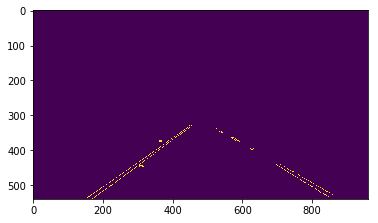

[[-0.61111111]
 [-0.74468085]
 [ 0.57142857]
 [-0.8       ]
 [-0.61538462]
 [-0.77777778]
 [ 0.5625    ]
 [-0.9       ]
 [-0.83333333]
 [-0.76923077]
 [-0.6       ]
 [-0.8125    ]
 [-0.73333333]
 [-0.82352941]
 [-0.77777778]
 [ 0.66666667]
 [-0.77777778]
 [-0.78571429]
 [ 0.        ]
 [ 0.61363636]
 [ 0.45454545]
 [ 0.6875    ]
 [ 0.5       ]
 [ 0.6       ]
 [ 0.54545455]
 [-0.83333333]
 [-0.61111111]
 [-0.57142857]
 [ 0.        ]
 [ 0.5       ]
 [-0.8       ]
 [ 0.54545455]
 [ 0.6       ]]
left_m = -0.705239954531  right_m = 0.581088037796
left_c = 650.931849064  right_c = 35.3634106209
left_y = 341.331509025  right_y = 369.489032354  min y = 341.331509025
left_y = 544.44061593  right_y = 536.261299201  max y = 544.44061593


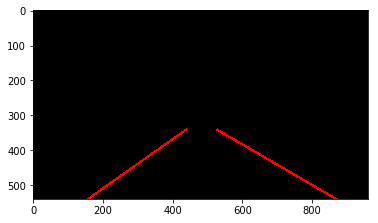

 41%|████      | 279/682 [02:33<03:08,  2.14it/s]

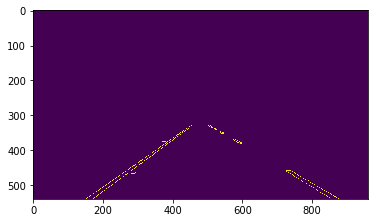

[[-0.8       ]
 [-0.73913043]
 [-0.74193548]
 [-0.7826087 ]
 [-0.83333333]
 [-0.72093023]
 [-0.63636364]
 [-0.9       ]
 [ 0.53658537]
 [-0.86666667]
 [ 0.6       ]
 [-0.76190476]
 [ 0.5       ]
 [-0.72413793]
 [-0.61538462]
 [-0.61904762]
 [ 0.69230769]
 [-0.83333333]
 [ 0.57692308]
 [ 0.44444444]
 [-0.6       ]
 [-0.84615385]
 [ 0.6       ]
 [-0.8       ]
 [-0.65      ]
 [ 0.5       ]
 [-0.625     ]
 [ 0.58823529]
 [-0.9       ]
 [ 0.64285714]
 [-0.8       ]
 [ 0.5       ]
 [ 0.5       ]
 [-0.75      ]
 [-0.7       ]
 [ 0.        ]]
left_m = -0.71009286694  right_m = 0.577003523464
left_c = 653.184747876  right_c = 37.6187221293
left_y = 332.932864887  right_y = 371.126758691  min y = 332.932864887
left_y = 540.279982033  right_y = 540.188791066  max y = 540.279982033


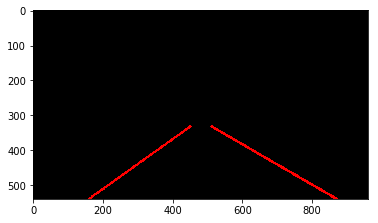

 41%|████      | 280/682 [02:33<03:03,  2.19it/s]

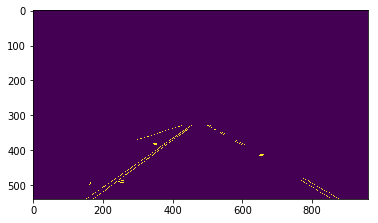

[[-0.63636364]
 [-0.66666667]
 [-0.81818182]
 [-0.80952381]
 [-0.8       ]
 [ 0.52941176]
 [ 0.60714286]
 [-0.75862069]
 [ 0.5       ]
 [-0.71875   ]
 [-0.65      ]
 [ 0.58333333]
 [-0.33333333]
 [-0.79166667]
 [-0.31578947]
 [-0.83333333]
 [-0.70588235]
 [ 0.66666667]
 [-0.64705882]
 [-0.84210526]
 [ 0.54166667]
 [ 0.625     ]
 [ 0.52173913]
 [ 0.5       ]
 [-0.64285714]
 [ 0.42857143]
 [-0.69230769]
 [-0.69565217]
 [ 0.57894737]
 [-0.68421053]
 [-0.83333333]
 [-0.58333333]
 [-0.81818182]
 [ 0.07142857]
 [ 0.        ]
 [-0.8       ]]
left_m = -0.702535398083  right_m = 0.568915089053
left_c = 650.577387229  right_c = 44.2563484396
left_y = 358.322661626  right_y = 373.089269912  min y = 358.322661626
left_y = 542.386935924  right_y = 542.057051361  max y = 542.386935924


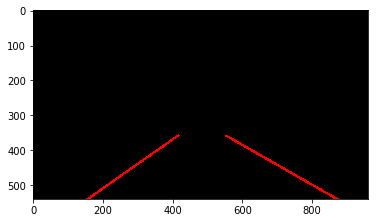

 41%|████      | 281/682 [02:33<03:00,  2.22it/s]

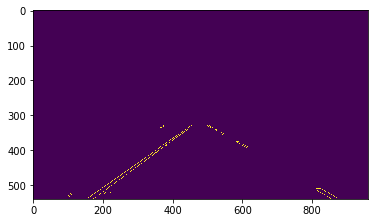

[[-0.68253968]
 [-0.61538462]
 [-0.625     ]
 [-0.64705882]
 [-0.61904762]
 [-0.63636364]
 [-0.68518519]
 [-0.85714286]
 [-0.7173913 ]
 [-0.66666667]
 [ 0.57692308]
 [ 0.5862069 ]
 [-0.73529412]
 [-0.57142857]
 [ 0.        ]
 [ 0.59090909]
 [ 0.51851852]
 [ 0.45454545]
 [-0.69230769]
 [ 0.18181818]
 [-0.58333333]
 [-0.65      ]
 [ 0.46666667]
 [-0.63636364]
 [-0.68      ]
 [-0.7       ]
 [ 0.625     ]
 [ 0.        ]
 [ 0.6       ]]
left_m = -0.713878470241  right_m = 0.584854140621
left_c = 653.985204827  right_c = 34.5135951849
left_y = 333.453771689  right_y = 376.068413308  min y = 333.453771689
left_y = 536.909135708  right_y = 545.676114088  max y = 545.676114088


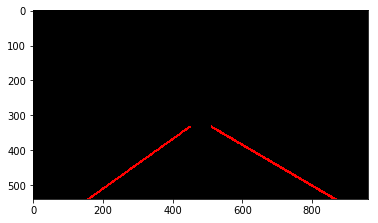

 41%|████▏     | 282/682 [02:34<02:56,  2.26it/s]

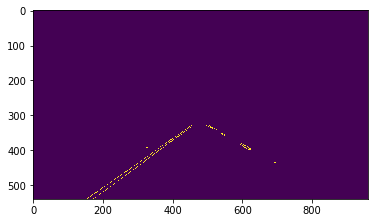

[[-0.78571429]
 [-0.83333333]
 [-0.75      ]
 [-0.82352941]
 [-0.76470588]
 [-0.78571429]
 [-0.73684211]
 [-0.8       ]
 [ 0.54545455]
 [ 0.52380952]
 [-0.76923077]
 [-0.70588235]
 [-0.70588235]
 [-0.81818182]
 [-0.76190476]
 [-0.67647059]
 [-0.75      ]
 [ 0.5       ]
 [-0.76923077]
 [ 0.58823529]
 [ 0.        ]
 [ 0.        ]]
left_m = -0.712131311717  right_m = 0.540716145522
left_c = 654.246505874  right_c = 61.6264959511
left_y = 334.499546913  right_y = 354.153930679  min y = 334.499546913
left_y = 543.866152558  right_y = 395.248357738  max y = 543.866152558


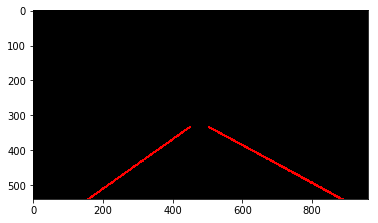

 41%|████▏     | 283/682 [02:34<03:02,  2.18it/s]

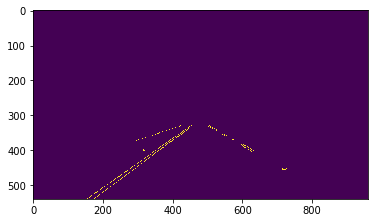

[[-0.6875    ]
 [-0.8       ]
 [-0.76923077]
 [-0.69863014]
 [-0.72881356]
 [ 0.54545455]
 [-0.6875    ]
 [ 0.53333333]
 [-0.33333333]
 [-0.68181818]
 [ 0.        ]
 [-0.8       ]
 [ 0.58823529]
 [-0.4       ]
 [-0.3       ]
 [-0.34482759]
 [-0.90909091]
 [ 0.        ]
 [-0.68      ]
 [-0.80769231]
 [ 0.        ]
 [-0.66666667]
 [-0.65714286]
 [-0.85714286]
 [ 0.        ]
 [ 0.5       ]
 [ 0.6       ]
 [-0.76190476]
 [-0.81818182]
 [-0.8       ]]
left_m = -0.723753788034  right_m = 0.55648547582
left_c = 659.990232055  right_c = 51.8764999512
left_y = 332.853519864  right_y = 329.006266909  min y = 329.006266909
left_y = 547.084641122  right_y = 398.566951387  max y = 547.084641122


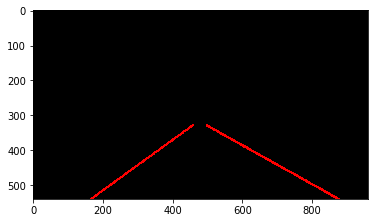

 42%|████▏     | 284/682 [02:35<02:56,  2.25it/s]

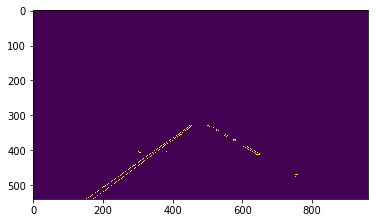

[[ 0.6       ]
 [-0.7029703 ]
 [-0.68852459]
 [-0.6744186 ]
 [-0.73684211]
 [ 0.        ]
 [-0.75      ]
 [-0.70588235]
 [-0.71428571]
 [-0.61111111]
 [ 0.56410256]
 [-0.77272727]
 [-0.61538462]
 [-0.66666667]
 [-0.09090909]
 [-0.63636364]
 [ 0.53571429]
 [ 0.5       ]
 [-0.6       ]
 [ 0.53846154]
 [-0.63157895]
 [-0.73684211]
 [-0.8       ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.7       ]]
left_m = -0.7121455003  right_m = 0.552632368607
left_c = 654.460633469  right_c = 52.7153231009
left_y = 334.707303834  right_y = 331.794669247  min y = 331.794669247
left_y = 541.941644421  right_y = 411.373730327  max y = 541.941644421


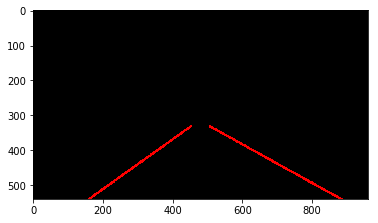

 42%|████▏     | 285/682 [02:35<02:52,  2.31it/s]

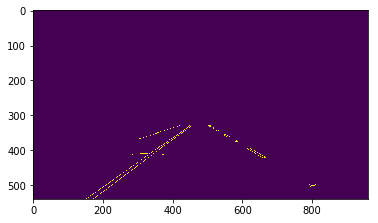

[[-0.70114943]
 [-0.73770492]
 [-0.67741935]
 [-0.70338983]
 [-0.86666667]
 [-0.72463768]
 [ 0.        ]
 [-0.35714286]
 [ 0.62962963]
 [-0.63157895]
 [ 0.        ]
 [ 0.52631579]
 [-0.74285714]
 [ 0.        ]
 [-0.76923077]
 [-0.83333333]
 [ 0.63636364]
 [ 0.        ]
 [-0.8       ]
 [ 0.        ]
 [-0.29166667]
 [-0.30434783]
 [-0.73684211]
 [ 0.46153846]
 [-0.76923077]
 [-0.26666667]]
left_m = -0.721229369502  right_m = 0.602843601896
left_c = 655.442157072  right_c = 23.3090047393
left_y = 330.888940796  right_y = 392.2492891  min y = 330.888940796
left_y = 544.372834168  right_y = 418.774407583  max y = 544.372834168


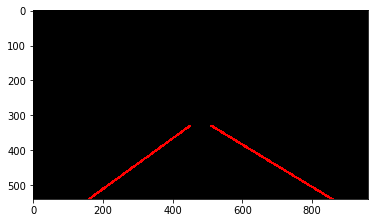

 42%|████▏     | 286/682 [02:36<02:52,  2.29it/s]

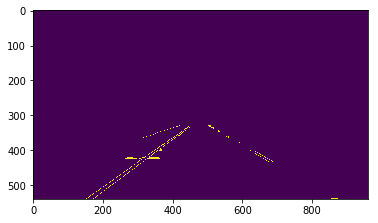

[[-0.7826087 ]
 [-0.69333333]
 [-0.69230769]
 [-0.8       ]
 [-0.68571429]
 [-0.33333333]
 [ 0.        ]
 [-0.73972603]
 [ 0.59375   ]
 [-0.73076923]
 [-0.83333333]
 [ 0.57142857]
 [-0.80769231]
 [-0.35714286]
 [-0.75      ]
 [-0.84615385]
 [ 0.52941176]
 [ 0.45454545]
 [-0.73684211]
 [-0.73333333]
 [ 0.        ]
 [-0.8       ]
 [ 0.        ]
 [-0.83333333]
 [ 0.42857143]
 [-0.76923077]
 [-0.75      ]
 [ 0.54545455]
 [-1.        ]
 [-0.28571429]
 [ 0.        ]
 [-0.09090909]
 [ 0.53846154]
 [-0.3       ]
 [-0.76923077]
 [ 0.57142857]]
left_m = -0.693765719647  right_m = 0.576488836523
left_c = 645.971638085  right_c = 38.6707333443
left_y = 350.427441515  right_y = 358.045548778  min y = 350.427441515
left_y = 537.74418582  right_y = 430.68314218  max y = 537.74418582


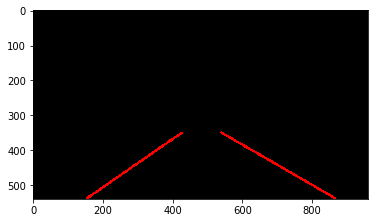

 42%|████▏     | 287/682 [02:36<02:55,  2.25it/s]

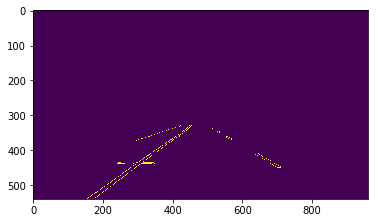

[[-0.7027027 ]
 [-0.76923077]
 [-0.8       ]
 [-0.31428571]
 [-0.75      ]
 [-0.68      ]
 [-0.9       ]
 [-0.70833333]
 [-0.03703704]
 [ 0.57692308]
 [-0.91666667]
 [-0.8       ]
 [-0.63157895]
 [ 0.57142857]
 [ 0.6       ]
 [-0.23076923]
 [ 0.52380952]
 [ 0.        ]
 [-0.86666667]
 [-0.65      ]
 [-0.6875    ]
 [ 0.60869565]
 [-0.76923077]
 [-0.80769231]
 [-0.63157895]
 [ 0.        ]
 [ 0.        ]
 [-0.33333333]
 [ 0.53333333]
 [ 0.57142857]
 [ 0.5       ]]
left_m = -0.740837587807  right_m = 0.585527643701
left_c = 662.998919503  right_c = 35.2807878336
left_y = 331.103680166  right_y = 362.005213019  min y = 331.103680166
left_y = 548.169093393  right_y = 446.321193711  max y = 548.169093393


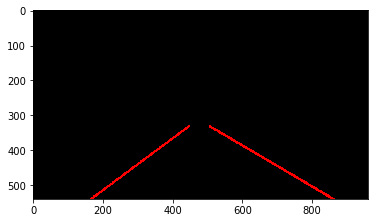

 42%|████▏     | 288/682 [02:37<03:05,  2.12it/s]

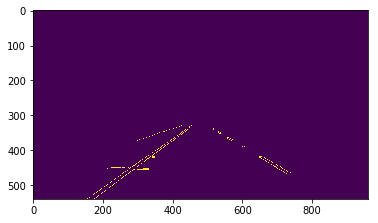

[[-0.6       ]
 [-0.77272727]
 [-0.77272727]
 [-0.35      ]
 [-0.3       ]
 [-0.73333333]
 [-1.        ]
 [ 0.58333333]
 [-0.88235294]
 [-0.9       ]
 [-0.69047619]
 [ 0.        ]
 [-0.75      ]
 [ 0.        ]
 [ 0.58333333]
 [ 0.60377358]
 [-0.69230769]
 [-0.625     ]
 [ 0.04347826]
 [-0.64705882]
 [ 0.57142857]
 [ 0.53846154]
 [-0.7       ]
 [ 0.        ]
 [-0.33333333]
 [-0.8       ]
 [-0.9375    ]
 [-0.77272727]
 [-0.76470588]
 [-0.33333333]
 [ 0.47058824]
 [-0.4       ]
 [-0.61538462]
 [ 0.5       ]
 [-0.81818182]
 [ 0.        ]]
left_m = -0.714505320504  right_m = 0.586737286178
left_c = 655.682120861  right_c = 35.716346672
left_y = 352.731864967  right_y = 364.289226932  min y = 352.731864967
left_y = 542.075774901  right_y = 471.075413016  max y = 542.075774901


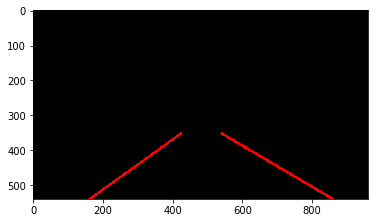

 42%|████▏     | 289/682 [02:37<02:58,  2.20it/s]

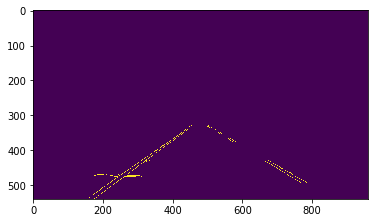

[[-0.61111111]
 [ 0.58064516]
 [-0.58333333]
 [-0.65217391]
 [-0.66666667]
 [-0.83333333]
 [ 0.54545455]
 [-0.76923077]
 [ 0.52941176]
 [-0.74418605]
 [ 0.        ]
 [ 0.72727273]
 [-0.72222222]
 [-0.63636364]
 [ 0.6875    ]
 [ 0.        ]
 [-0.54545455]
 [-0.64285714]
 [-0.8       ]
 [ 0.65625   ]
 [ 0.        ]
 [ 0.56666667]
 [-0.65      ]
 [ 0.        ]
 [ 0.53333333]
 [ 0.55555556]
 [ 0.72727273]
 [ 0.        ]
 [-0.69565217]
 [-0.84615385]
 [-0.65      ]
 [ 0.52941176]
 [ 0.54545455]
 [ 0.        ]
 [-0.66666667]
 [-0.66666667]]
left_m = -0.702831508674  right_m = 0.588033440316
left_c = 651.908948582  right_c = 37.3207883399
left_y = 349.691399852  right_y = 328.397341296  min y = 328.397341296
left_y = 533.833255125  right_y = 491.870637704  max y = 533.833255125


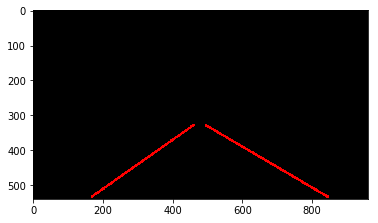

 43%|████▎     | 290/682 [02:37<02:54,  2.25it/s]

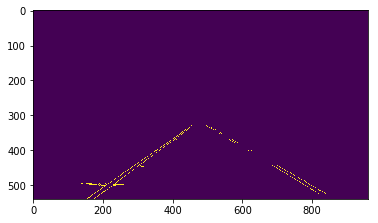

[[ 0.55555556]
 [-0.66666667]
 [ 0.58333333]
 [-0.68085106]
 [ 0.62365591]
 [-0.75      ]
 [-0.73333333]
 [-0.68181818]
 [ 0.        ]
 [ 0.58333333]
 [-0.76923077]
 [-0.76470588]
 [-0.66666667]
 [-0.65517241]
 [ 0.        ]
 [ 0.6       ]
 [ 0.52631579]
 [ 0.6       ]
 [-0.66666667]
 [-0.77272727]
 [-0.8       ]
 [ 0.63157895]
 [ 0.        ]
 [-0.63157895]
 [ 0.        ]
 [ 0.        ]
 [ 0.45454545]
 [-0.76190476]
 [ 0.        ]
 [ 0.        ]
 [-0.6       ]
 [ 0.        ]
 [ 0.625     ]
 [ 0.        ]
 [-0.6       ]]
left_m = -0.710701496888  right_m = 0.585002905609
left_c = 655.697296  right_c = 38.3185477796
left_y = 354.359861319  right_y = 367.675183638  min y = 354.359861319
left_y = 545.538563982  right_y = 521.530947813  max y = 545.538563982


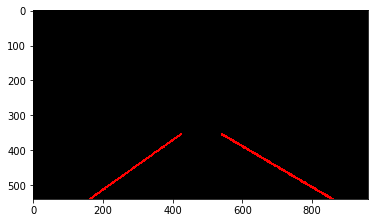

 43%|████▎     | 291/682 [02:38<02:55,  2.22it/s]

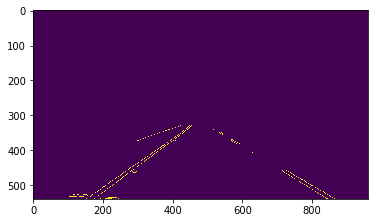

[[ 0.66666667]
 [ 0.57777778]
 [-0.64285714]
 [-0.6       ]
 [-0.625     ]
 [-0.57142857]
 [-0.68181818]
 [-0.6       ]
 [-0.73684211]
 [-0.61904762]
 [-0.79310345]
 [-0.82352941]
 [ 0.72727273]
 [-0.71428571]
 [ 0.5       ]
 [-0.58333333]
 [-0.75      ]
 [ 0.61111111]
 [ 0.45454545]
 [-0.36      ]
 [-0.66666667]
 [-0.75      ]
 [ 0.        ]
 [ 0.        ]
 [-0.73076923]
 [ 0.        ]
 [-0.36363636]
 [ 0.58333333]
 [ 0.54545455]
 [-0.63636364]
 [ 0.04166667]
 [ 0.        ]
 [-0.9       ]
 [ 0.6       ]
 [ 0.54545455]
 [-0.70588235]
 [ 0.55      ]
 [-0.3       ]
 [ 0.5       ]
 [ 0.53333333]
 [-0.5625    ]
 [-0.36363636]
 [ 0.58823529]
 [-0.3       ]
 [-0.4       ]
 [ 0.58333333]]
left_m = -0.708023007025  right_m = 0.586128964282
left_c = 652.110769817  right_c = 37.9052568599
left_y = 337.748554698  right_y = 370.826508572  min y = 337.748554698
left_y = 535.286973658  right_y = 521.461652392  max y = 535.286973658


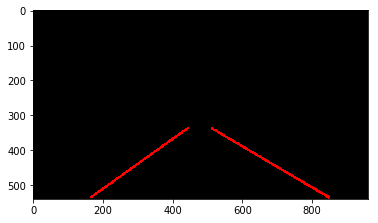

 43%|████▎     | 292/682 [02:38<02:51,  2.28it/s]

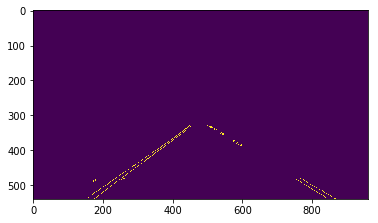

[[-0.72727273]
 [-0.78571429]
 [-0.69565217]
 [ 0.56410256]
 [-0.74193548]
 [ 0.5       ]
 [-0.73684211]
 [ 0.58823529]
 [-0.81818182]
 [-0.8       ]
 [-0.76923077]
 [-0.77777778]
 [ 0.5       ]
 [-0.66666667]
 [-0.63636364]
 [ 0.60465116]
 [ 0.5625    ]
 [ 0.60714286]
 [ 0.47058824]
 [-0.72727273]
 [-0.76470588]
 [-0.8       ]
 [-0.90909091]
 [-0.76470588]
 [ 0.57142857]]
left_m = -0.710317481054  right_m = 0.585975229152
left_c = 651.777519292  right_c = 37.8001628221
left_y = 342.079097553  right_y = 374.735919584  min y = 342.079097553
left_y = 542.38862721  right_y = 541.152884663  max y = 542.38862721


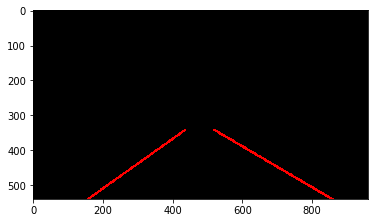

 43%|████▎     | 293/682 [02:39<02:54,  2.23it/s]

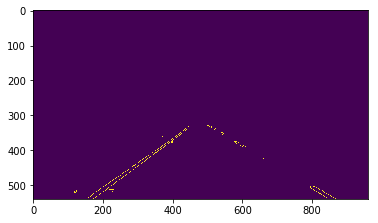

[[ 0.58695652]
 [-0.66666667]
 [ 0.57894737]
 [-0.64285714]
 [-0.8       ]
 [-0.67948718]
 [-1.        ]
 [-0.8       ]
 [-0.6       ]
 [-0.84615385]
 [-0.78947368]
 [ 0.58333333]
 [-0.83333333]
 [-0.9       ]
 [-0.77777778]
 [ 0.56521739]
 [-0.65      ]
 [-0.83333333]
 [-0.6       ]
 [-0.64705882]
 [-0.63636364]
 [-0.95238095]
 [-0.9       ]
 [ 0.66666667]
 [-0.72727273]
 [-0.64705882]]
left_m = -0.719873984365  right_m = 0.591434931917
left_c = 657.025383574  right_c = 33.5244907963
left_y = 364.036671938  right_y = 374.782446512  min y = 364.036671938
left_y = 546.164789982  right_y = 545.707141836  max y = 546.164789982


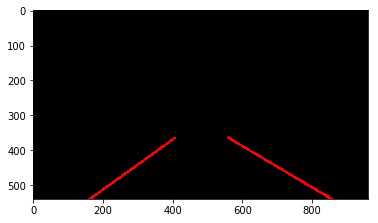

 43%|████▎     | 294/682 [02:39<02:56,  2.20it/s]

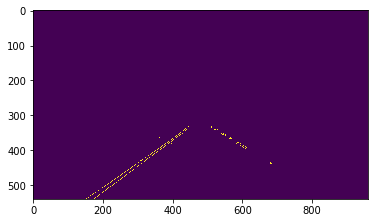

[[ 0.57692308]
 [ 0.61538462]
 [-0.8125    ]
 [-0.9047619 ]
 [-0.63636364]
 [-0.73684211]
 [-0.8125    ]
 [-0.6       ]
 [-0.73214286]
 [-0.63636364]
 [-0.58333333]
 [ 0.58333333]
 [-0.71428571]
 [-0.625     ]
 [-0.66666667]
 [ 0.61538462]
 [-0.66666667]
 [-0.66666667]
 [-0.625     ]
 [-0.66666667]
 [-0.58333333]
 [-0.7       ]
 [-0.63636364]]
left_m = -0.702759550135  right_m = 0.529338889515
left_c = 650.271491514  right_c = 69.9778128168
left_y = 350.193163606  right_y = 378.582385404  min y = 350.193163606
left_y = 540.641001692  right_y = 397.109246537  max y = 540.641001692


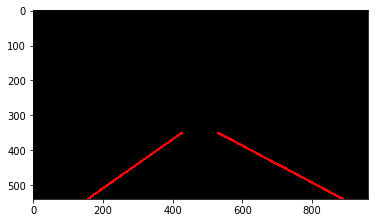

 43%|████▎     | 295/682 [02:40<02:58,  2.17it/s]

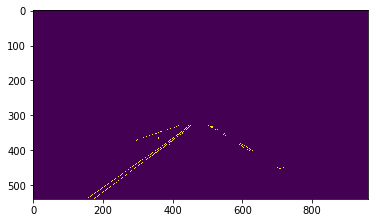

[[-0.70175439]
 [-0.86666667]
 [-0.75      ]
 [-0.72857143]
 [-0.90909091]
 [-0.76923077]
 [ 0.54545455]
 [ 0.54545455]
 [-0.72222222]
 [-0.32432432]
 [-0.8       ]
 [-0.90909091]
 [-1.        ]
 [-0.4       ]
 [ 0.55555556]
 [-0.8       ]
 [-0.68421053]
 [-0.9       ]
 [ 0.57142857]
 [-0.33333333]
 [-0.8       ]]
left_m = -0.711587953798  right_m = 0.587248322148
left_c = 653.349698628  right_c = 34.5503355705
left_y = 348.078466449  right_y = 382.201342282  min y = 348.078466449
left_y = 540.207213974  right_y = 399.231543624  max y = 540.207213974


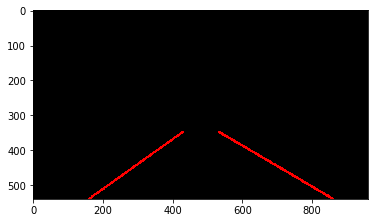

 43%|████▎     | 296/682 [02:40<02:52,  2.24it/s]

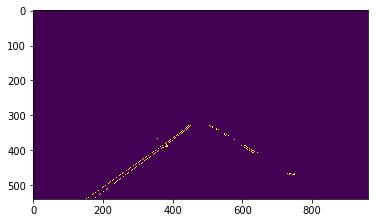

[[-0.78125   ]
 [-0.66666667]
 [-0.7755102 ]
 [-0.70048309]
 [-0.71428571]
 [-0.7037037 ]
 [-0.85714286]
 [-0.7       ]
 [-0.70512821]
 [ 0.66666667]
 [ 0.54166667]
 [-0.69230769]
 [-0.80952381]
 [-0.7       ]
 [-0.91666667]
 [ 0.5625    ]
 [-0.90909091]
 [ 0.54545455]
 [ 0.5       ]]
left_m = -0.742671525907  right_m = 0.624565522114
left_c = 665.369196641  right_c = 11.9424950712
left_y = 340.821739819  right_y = 352.330704623  min y = 340.821739819
left_y = 550.997781651  right_y = 402.920511915  max y = 550.997781651


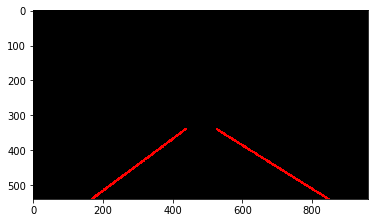

 44%|████▎     | 297/682 [02:41<02:49,  2.27it/s]

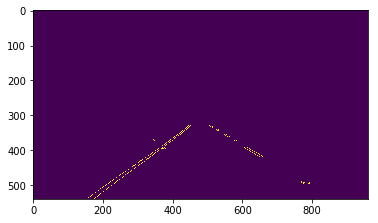

[[-0.61538462]
 [-0.73      ]
 [-0.8       ]
 [-0.81818182]
 [-0.73195876]
 [-0.71875   ]
 [-0.84615385]
 [-0.8       ]
 [ 0.55      ]
 [ 0.53125   ]
 [-0.66666667]
 [-0.9       ]
 [-0.90909091]
 [ 0.41666667]
 [-0.81818182]
 [ 0.        ]
 [-0.81818182]
 [ 0.58333333]
 [-0.72727273]
 [-0.75      ]
 [-0.9       ]
 [-0.6875    ]]
left_m = -0.720997623551  right_m = 0.49815498155
left_c = 656.916021024  right_c = 91.3271832718
left_y = 335.351080921  right_y = 396.696186962  min y = 335.351080921
left_y = 537.951413138  right_y = 415.127921279  max y = 537.951413138


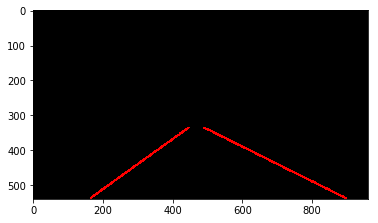

 44%|████▎     | 298/682 [02:41<02:45,  2.32it/s]

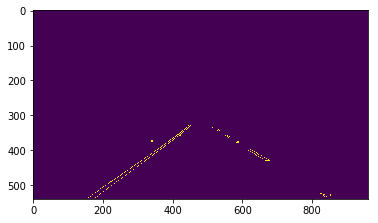

[[-0.83333333]
 [-0.80952381]
 [-0.7       ]
 [-0.725     ]
 [-0.65      ]
 [-0.66666667]
 [-0.84615385]
 [ 0.6       ]
 [-0.63636364]
 [-0.72222222]
 [ 0.58333333]
 [ 0.5       ]
 [-0.6       ]
 [-0.66666667]
 [-0.75      ]
 [-0.8       ]
 [ 0.55172414]
 [-0.81818182]
 [-0.82352941]
 [-0.66666667]
 [-0.9       ]
 [ 0.5       ]
 [-0.94117647]
 [-0.63157895]
 [-0.81818182]
 [ 0.4       ]
 [ 0.54545455]
 [-0.69230769]]
left_m = -0.707911380092  right_m = 0.608059027738
left_c = 651.605969415  right_c = 21.3422317954
left_y = 335.877493894  right_y = 356.382756079  min y = 335.877493894
left_y = 537.63223722  right_y = 428.74178038  max y = 537.63223722


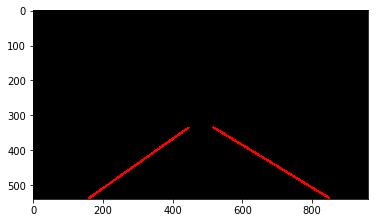

 44%|████▍     | 299/682 [02:41<02:54,  2.20it/s]

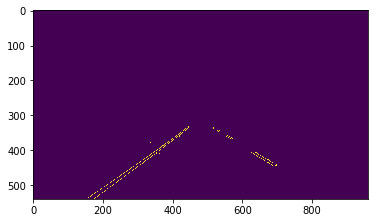

[[-0.78571429]
 [-0.80952381]
 [-0.67692308]
 [-0.68253968]
 [-0.66666667]
 [-0.76923077]
 [-0.83333333]
 [-0.84615385]
 [-0.63636364]
 [-0.76923077]
 [-0.6779661 ]
 [ 0.47058824]
 [ 0.6       ]
 [ 0.46153846]
 [-0.80952381]
 [-0.64285714]
 [-0.71428571]
 [-0.72413793]
 [-0.84615385]
 [-0.66666667]
 [-0.9       ]
 [-0.80952381]
 [ 0.60465116]
 [-0.68      ]
 [-0.66666667]
 [-0.7       ]
 [ 0.58333333]
 [ 0.6031746 ]
 [ 0.5       ]]
left_m = -0.73145804694  right_m = 0.63289183223
left_c = 662.028619538  right_c = 7.57152317881
left_y = 330.678124274  right_y = 358.826490066  min y = 330.678124274
left_y = 548.652622262  right_y = 443.633995585  max y = 548.652622262


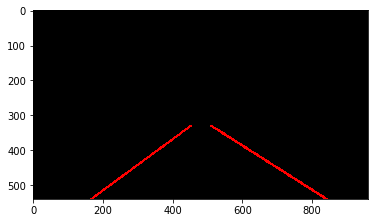

 44%|████▍     | 300/682 [02:42<02:46,  2.29it/s]

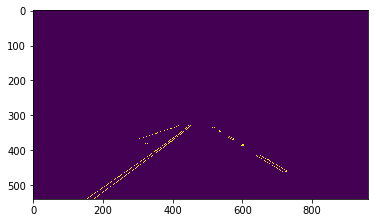

[[-0.72340426]
 [-0.85714286]
 [ 0.58064516]
 [-0.81481481]
 [-0.83333333]
 [-0.90909091]
 [-0.9       ]
 [-0.83333333]
 [-0.85      ]
 [-0.77419355]
 [-0.61538462]
 [-0.58333333]
 [-0.84615385]
 [-0.9047619 ]
 [ 0.57894737]
 [-0.70833333]
 [ 0.57142857]
 [-0.33333333]
 [ 0.52941176]
 [-0.72972973]
 [-0.91666667]
 [-0.3       ]
 [-0.375     ]
 [-0.81818182]
 [-0.83333333]
 [-0.8       ]
 [ 0.61538462]
 [-0.83333333]
 [-0.35294118]
 [-0.81818182]
 [-0.41666667]]
left_m = -0.722645830045  right_m = 0.532622429569
left_c = 657.711755357  right_c = 74.591716305
left_y = 348.419340098  right_y = 418.133183377  min y = 348.419340098
left_y = 545.7016517  right_y = 457.014620736  max y = 545.7016517


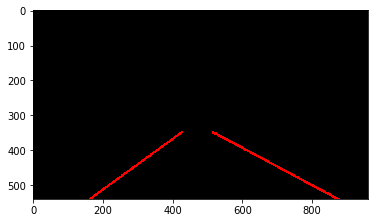

 44%|████▍     | 301/682 [02:42<02:42,  2.34it/s]

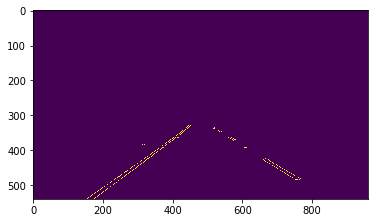

[[-0.68421053]
 [ 0.53333333]
 [-0.69565217]
 [-0.8125    ]
 [-0.78723404]
 [-0.84615385]
 [ 0.62857143]
 [ 0.44444444]
 [-0.71428571]
 [-0.77777778]
 [-0.8       ]
 [-0.90909091]
 [-1.        ]
 [ 0.5       ]
 [ 0.5       ]
 [-0.63636364]
 [-0.77777778]
 [ 0.57142857]
 [ 0.64285714]
 [ 0.5       ]
 [-0.63636364]
 [-0.85714286]
 [-0.75      ]
 [-0.63636364]
 [-0.80952381]
 [-0.90909091]
 [-0.8       ]
 [ 0.5       ]
 [ 0.63636364]
 [-0.81818182]
 [-0.6       ]]
left_m = -0.73567324343  right_m = 0.615454540963
left_c = 661.553174906  right_c = 16.3802555501
left_y = 333.442908336  right_y = 361.650253031  min y = 333.442908336
left_y = 546.788148931  right_y = 482.279343059  max y = 546.788148931


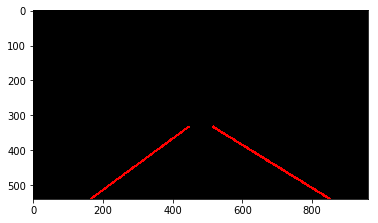

 44%|████▍     | 302/682 [02:43<02:40,  2.36it/s]

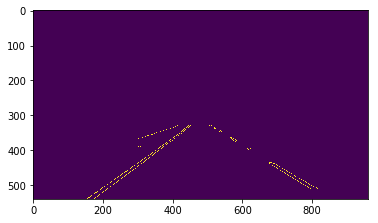

[[-0.58333333]
 [-0.61538462]
 [-0.625     ]
 [ 0.59090909]
 [ 0.52380952]
 [-0.4       ]
 [-0.76666667]
 [-0.81818182]
 [ 0.64705882]
 [ 0.65384615]
 [-0.77419355]
 [ 0.8       ]
 [-0.79166667]
 [-0.8       ]
 [-0.73015873]
 [-0.84210526]
 [-0.6875    ]
 [-0.86666667]
 [ 0.63333333]
 [-0.90909091]
 [ 0.71428571]
 [-0.76190476]
 [-0.76470588]
 [ 0.58333333]
 [ 0.        ]
 [-0.9375    ]
 [-0.77777778]
 [ 0.64285714]
 [-0.9       ]
 [-0.33333333]
 [-0.80952381]
 [-0.83333333]
 [ 0.7       ]
 [-0.3       ]
 [ 0.58333333]
 [ 0.5       ]]
left_m = -0.717972116371  right_m = 0.581810142057
left_c = 656.515851216  right_c = 41.3112896373
left_y = 333.428398849  right_y = 434.614945668  min y = 333.428398849
left_y = 533.0246472  right_y = 510.250264135  max y = 533.0246472


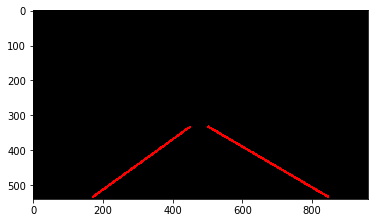

 44%|████▍     | 303/682 [02:43<02:38,  2.39it/s]

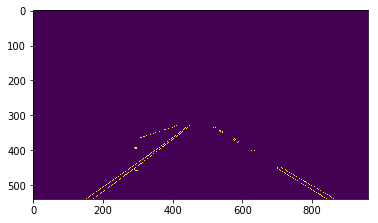

[[-0.76086957]
 [ 0.54545455]
 [ 0.5       ]
 [-0.69892473]
 [-0.80952381]
 [-0.70588235]
 [-0.66666667]
 [-1.        ]
 [-0.75      ]
 [-0.73529412]
 [ 0.66666667]
 [-0.73529412]
 [ 0.6       ]
 [-0.90909091]
 [-0.29411765]
 [ 0.51724138]
 [-0.76470588]
 [-0.9       ]
 [ 0.75      ]
 [ 0.57894737]
 [-0.8       ]
 [ 0.54545455]
 [ 0.5       ]
 [-0.9       ]
 [ 0.5625    ]
 [-0.70588235]
 [-0.75      ]
 [ 0.53846154]
 [-0.31428571]
 [ 0.55      ]
 [-0.9       ]
 [ 0.7       ]
 [ 0.54545455]]
left_m = -0.737528191283  right_m = 0.616542904953
left_c = 661.116316354  right_c = 15.4190824825
left_y = 335.866383998  right_y = 366.848538306  min y = 335.866383998
left_y = 548.274503088  right_y = 540.097094597  max y = 548.274503088


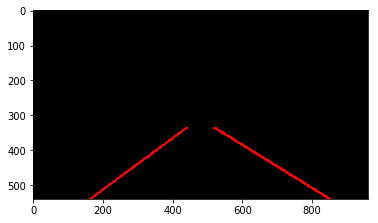

 45%|████▍     | 304/682 [02:44<02:50,  2.22it/s]

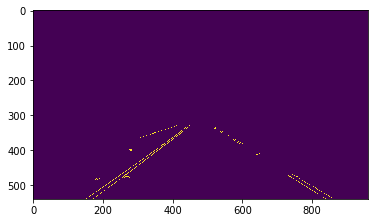

[[-0.58333333]
 [-0.82352941]
 [-0.75714286]
 [ 0.62686567]
 [-0.72727273]
 [-0.81818182]
 [-0.63636364]
 [-0.75      ]
 [-0.72340426]
 [ 0.375     ]
 [ 0.54166667]
 [-0.33333333]
 [ 0.63157895]
 [-0.30769231]
 [-0.71794872]
 [ 0.62      ]
 [-0.6       ]
 [ 0.46153846]
 [-0.58333333]
 [ 0.5625    ]
 [ 0.53333333]
 [-0.6       ]
 [ 0.5       ]
 [-0.7       ]
 [ 0.59259259]
 [-0.74193548]
 [ 0.54545455]
 [ 0.5       ]
 [ 0.625     ]
 [-0.83333333]
 [-0.61538462]
 [-0.3       ]
 [ 0.45454545]
 [-0.71428571]
 [-0.66666667]
 [-0.6       ]
 [-0.875     ]
 [-0.36363636]]
left_m = -0.719955906941  right_m = 0.613130297576
left_c = 654.41764311  right_c = 17.0103758431
left_y = 331.157440894  right_y = 368.947166651  min y = 331.157440894
left_y = 536.344874372  right_y = 544.302431758  max y = 544.302431758


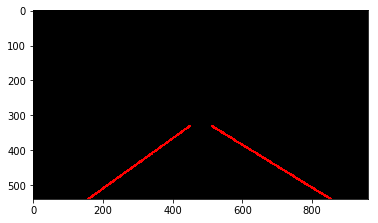

 45%|████▍     | 305/682 [02:44<03:00,  2.09it/s]

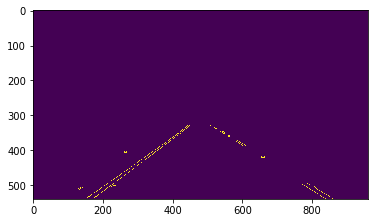

[[-0.75      ]
 [-0.57142857]
 [-0.85714286]
 [-0.72093023]
 [-0.77777778]
 [-0.75      ]
 [-0.8125    ]
 [-0.73333333]
 [-0.78571429]
 [ 0.57142857]
 [-0.9       ]
 [ 0.59090909]
 [-0.84615385]
 [ 0.5       ]
 [-0.70833333]
 [-0.77777778]
 [ 0.6875    ]
 [-0.84615385]
 [-0.81818182]
 [-0.81818182]
 [-0.90909091]
 [ 0.58333333]
 [ 0.5       ]
 [-0.77272727]
 [-0.63636364]
 [ 0.5       ]
 [ 0.54545455]
 [ 0.        ]
 [ 0.61538462]
 [-0.8       ]
 [ 0.75      ]]
left_m = -0.729678832918  right_m = 0.619985635293
left_c = 656.517915331  right_c = 12.1264962913
left_y = 335.459228847  right_y = 371.718164761  min y = 335.459228847
left_y = 542.688017396  right_y = 544.074171373  max y = 544.074171373


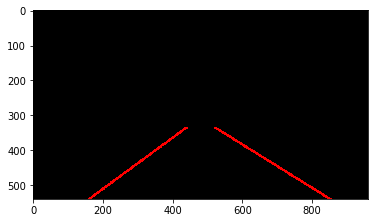

 45%|████▍     | 306/682 [02:45<02:55,  2.14it/s]

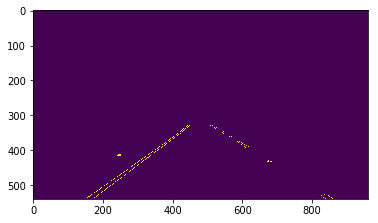

[[-0.6       ]
 [ 0.625     ]
 [-0.80769231]
 [-0.6875    ]
 [-0.66666667]
 [-0.83333333]
 [ 0.57894737]
 [-0.68518519]
 [-0.92857143]
 [-0.68421053]
 [-0.63636364]
 [-0.58333333]
 [ 0.57142857]
 [-0.85714286]
 [-0.75      ]
 [-0.65      ]
 [ 0.54545455]
 [-0.6       ]
 [-0.7       ]
 [ 0.5625    ]
 [-0.81818182]
 [-0.54545455]
 [-0.8125    ]
 [-0.9       ]
 [-0.66666667]
 [-0.9       ]
 [ 0.63636364]
 [-0.63636364]
 [-0.6       ]]
left_m = -0.71083635221  right_m = 0.621960654608
left_c = 651.351785185  right_c = 10.0982581451
left_y = 357.06553537  right_y = 373.945241091  min y = 357.06553537
left_y = 544.015496002  right_y = 544.984421108  max y = 544.984421108


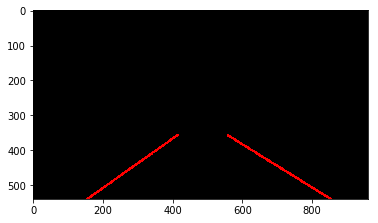

 45%|████▌     | 307/682 [02:45<02:49,  2.21it/s]

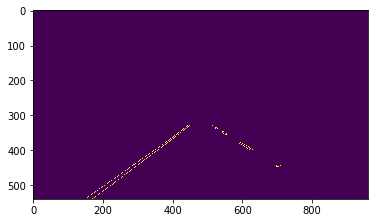

[[-0.70454545]
 [-0.6       ]
 [-0.92307692]
 [-0.77777778]
 [-0.76923077]
 [-0.83333333]
 [-0.72727273]
 [-0.84615385]
 [-0.84615385]
 [-0.64705882]
 [-0.67857143]
 [ 0.54545455]
 [-0.66666667]
 [-0.71428571]
 [-0.64705882]
 [-0.9       ]
 [-0.61904762]
 [ 0.63333333]
 [-0.92857143]
 [-0.84210526]
 [-0.61538462]
 [-0.76470588]
 [ 0.54545455]
 [-0.625     ]
 [ 0.6       ]
 [ 0.53846154]]
left_m = -0.71180399858  right_m = 0.656617964367
left_c = 650.042055499  right_c = -11.363571913
left_y = 331.153864136  right_y = 346.493218667  min y = 331.153864136
left_y = 542.559651714  right_y = 397.052801923  max y = 542.559651714


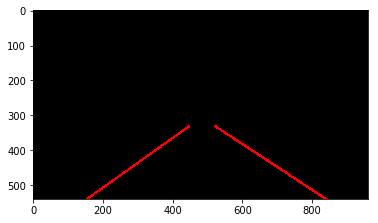

 45%|████▌     | 308/682 [02:45<02:46,  2.25it/s]

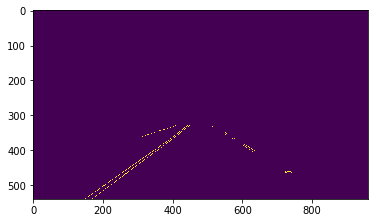

[[-0.70119522]
 [-0.75925926]
 [-0.71794872]
 [-0.72727273]
 [-0.33333333]
 [-0.75      ]
 [-0.79310345]
 [ 0.61111111]
 [-0.70588235]
 [-0.84210526]
 [-0.3       ]
 [-0.3       ]
 [ 0.5       ]
 [-0.69230769]
 [ 0.45454545]
 [-0.9       ]
 [ 0.5625    ]
 [-0.80952381]
 [-0.69230769]
 [-0.7       ]
 [-0.6875    ]
 [-0.8       ]
 [-0.90909091]
 [-0.35714286]
 [ 0.55      ]
 [-0.35714286]]
left_m = -0.750075901182  right_m = 0.573018913096
left_c = 665.047985408  right_c = 38.829123773
left_y = 343.265423801  right_y = 350.551412497  min y = 343.265423801
left_y = 552.536600231  right_y = 402.696133589  max y = 552.536600231


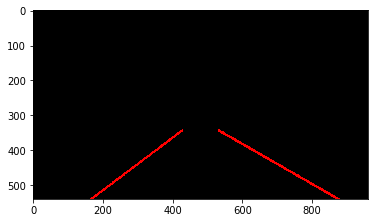

 45%|████▌     | 309/682 [02:46<02:43,  2.29it/s]

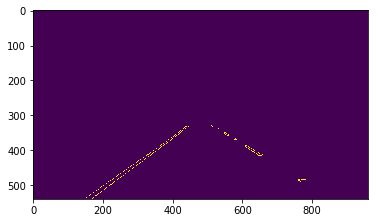

[[-0.8       ]
 [-0.66666667]
 [ 0.6       ]
 [-0.6835443 ]
 [-0.775     ]
 [-0.63636364]
 [-0.85714286]
 [-0.71794872]
 [-0.9       ]
 [ 0.63414634]
 [-0.64285714]
 [-0.61538462]
 [-0.58333333]
 [-0.77272727]
 [-0.7       ]
 [-0.6       ]
 [-0.68181818]
 [-0.71428571]
 [-0.85714286]
 [ 0.6       ]
 [-0.875     ]
 [ 0.6       ]
 [-0.63636364]]
left_m = -0.718822124447  right_m = 0.619512528163
left_c = 652.203736213  right_c = 8.89308390797
left_y = 330.890246585  right_y = 384.937188503  min y = 330.890246585
left_y = 545.818061794  right_y = 412.81525227  max y = 545.818061794


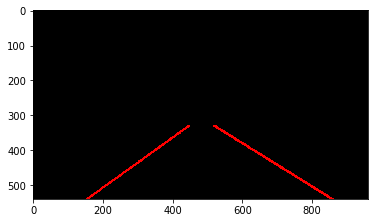

 45%|████▌     | 310/682 [02:46<02:49,  2.19it/s]

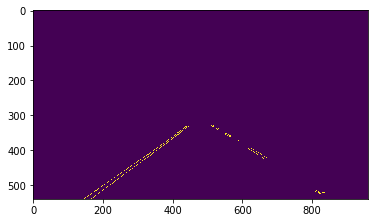

[[-0.70192308]
 [ 0.        ]
 [-0.68      ]
 [-0.73684211]
 [-0.76470588]
 [-0.72340426]
 [-0.8       ]
 [-0.80769231]
 [ 0.57692308]
 [-0.82758621]
 [ 0.61538462]
 [ 0.57142857]
 [ 0.72222222]
 [-0.81818182]
 [-0.86666667]
 [-0.91666667]
 [-0.74193548]
 [-0.8125    ]
 [-0.7       ]
 [-0.6       ]
 [-0.3       ]
 [-0.73333333]
 [-0.78571429]
 [-0.7       ]
 [-0.7       ]]
left_m = -0.710760670683  right_m = 0.606967033172
left_c = 649.997965137  right_c = 17.814810317
left_y = 332.287945341  right_y = 351.646678562  min y = 332.287945341
left_y = 546.226907217  right_y = 417.199118144  max y = 546.226907217


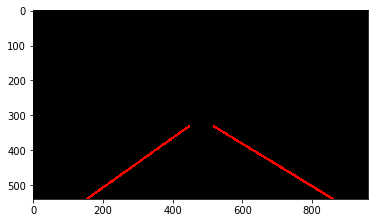

 46%|████▌     | 311/682 [02:47<02:44,  2.26it/s]

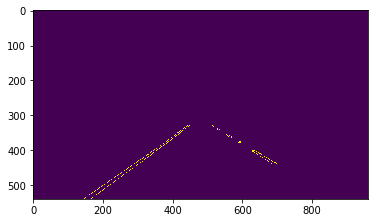

[[-0.82352941]
 [-0.73015873]
 [ 0.60465116]
 [-0.67816092]
 [ 0.61111111]
 [-0.68      ]
 [-0.63636364]
 [ 0.64      ]
 [-0.64      ]
 [-0.76190476]
 [-0.7       ]
 [-0.72727273]
 [-0.58333333]
 [-0.66666667]
 [-0.64285714]
 [ 0.55      ]
 [ 0.53846154]
 [-0.75      ]
 [-0.68421053]
 [-0.7       ]
 [-0.6       ]
 [-0.6       ]]
left_m = -0.730093672388  right_m = 0.609080696593
left_c = 654.607106969  right_c = 16.7183654142
left_y = 330.445516429  right_y = 354.758152023  min y = 330.445516429
left_y = 546.553243456  right_y = 438.811288153  max y = 546.553243456


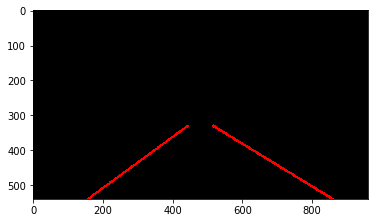

 46%|████▌     | 312/682 [02:47<02:41,  2.29it/s]

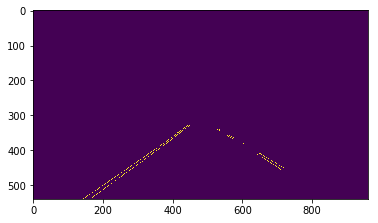

[[-0.77142857]
 [-0.6984127 ]
 [-0.76923077]
 [-0.78571429]
 [-0.72413793]
 [-0.72      ]
 [-0.75      ]
 [-0.69230769]
 [-0.76923077]
 [ 0.625     ]
 [ 0.5       ]
 [ 0.55555556]
 [ 0.6875    ]
 [-0.75      ]
 [-0.81818182]
 [-0.90909091]
 [-0.78571429]
 [-0.76470588]
 [ 0.58333333]
 [-0.81818182]
 [ 0.62962963]
 [ 0.5       ]
 [-0.72727273]]
left_m = -0.692838352244  right_m = 0.595163373117
left_c = 640.173768164  right_c = 27.8434435531
left_y = 330.475024711  right_y = 360.539769125  min y = 330.475024711
left_y = 539.712207089  right_y = 451.599765212  max y = 539.712207089


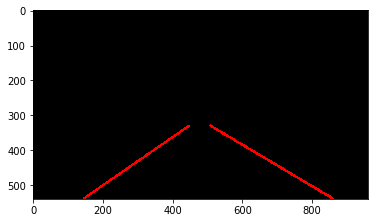

 46%|████▌     | 313/682 [02:48<02:40,  2.30it/s]

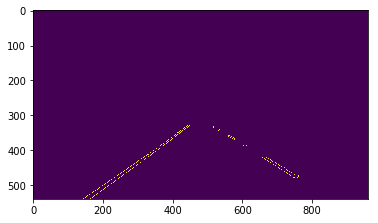

[[-0.7       ]
 [-0.6969697 ]
 [-0.75362319]
 [-0.75      ]
 [ 0.57142857]
 [-0.85714286]
 [-0.7826087 ]
 [ 0.62318841]
 [-0.84615385]
 [ 0.5       ]
 [-0.8       ]
 [-0.8       ]
 [ 0.62264151]
 [-0.74468085]
 [-0.73333333]
 [-0.8       ]
 [-0.85714286]
 [ 0.55555556]
 [-0.8       ]
 [-0.80952381]
 [ 0.6       ]
 [-0.76923077]
 [-0.83333333]
 [ 0.5       ]
 [ 0.6       ]
 [-0.8       ]]
left_m = -0.697910110114  right_m = 0.599913580469
left_c = 645.578489969  right_c = 22.0614118791
left_y = 333.612670748  right_y = 416.204634247  min y = 333.612670748
left_y = 545.079434113  right_y = 473.196424392  max y = 545.079434113


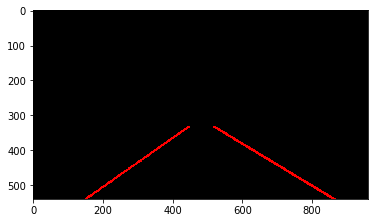

 46%|████▌     | 314/682 [02:48<02:38,  2.33it/s]

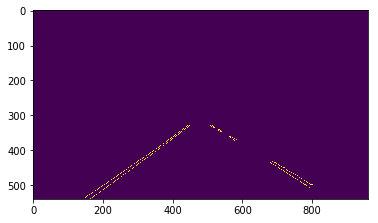

[[-0.78571429]
 [-0.75      ]
 [-0.74509804]
 [-0.8125    ]
 [-0.8       ]
 [-0.83333333]
 [ 0.625     ]
 [ 0.57894737]
 [ 0.61797753]
 [ 0.53846154]
 [-0.6       ]
 [ 0.56521739]
 [-0.57142857]
 [ 0.625     ]
 [-0.76470588]
 [ 0.5       ]
 [-0.72222222]
 [-0.8       ]
 [ 0.56666667]
 [-0.7       ]
 [-0.72727273]
 [ 0.58333333]
 [-0.8       ]
 [-0.69230769]
 [-0.8125    ]
 [ 0.1       ]
 [ 0.54545455]]
left_m = -0.727327557116  right_m = 0.595003662485
left_c = 652.925802017  right_c = 26.365261158
left_y = 326.355728872  right_y = 328.032118038  min y = 326.355728872
left_y = 541.644685778  right_y = 498.203165509  max y = 541.644685778


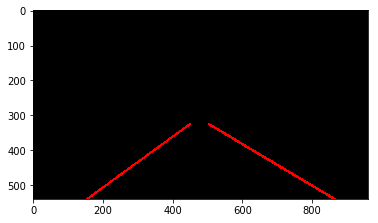

 46%|████▌     | 315/682 [02:48<02:38,  2.32it/s]

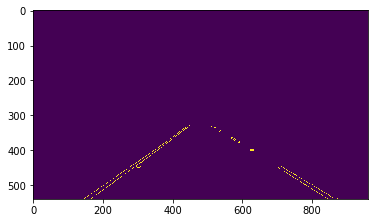

[[-0.72413793]
 [ 0.6       ]
 [-0.85714286]
 [ 0.59649123]
 [-0.88235294]
 [-0.9       ]
 [ 0.5       ]
 [ 0.7       ]
 [-0.6984127 ]
 [-0.73333333]
 [ 0.5       ]
 [ 0.57142857]
 [-0.8125    ]
 [-0.61904762]
 [ 0.8       ]
 [-0.8       ]
 [-0.9       ]
 [ 0.59090909]
 [-0.70588235]
 [-0.84615385]
 [-0.72727273]
 [-0.8       ]
 [-0.8       ]
 [-0.72      ]
 [-0.78571429]
 [ 0.625     ]
 [ 0.61538462]
 [ 0.        ]
 [ 0.45454545]
 [ 0.5       ]]
left_m = -0.707249734206  right_m = 0.619809595881
left_c = 648.428084606  right_c = 10.8161877774
left_y = 341.481699961  right_y = 364.10765743  min y = 341.481699961
left_y = 544.462373678  right_y = 544.472249831  max y = 544.472249831


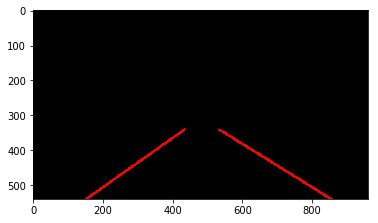

 46%|████▋     | 316/682 [02:49<02:41,  2.26it/s]

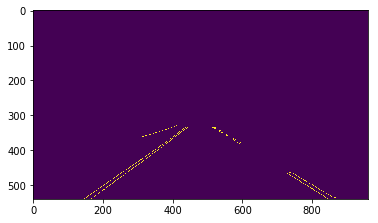

[[ 0.625     ]
 [-0.69827586]
 [-0.72881356]
 [ 0.64814815]
 [-0.70833333]
 [ 0.5       ]
 [ 0.53333333]
 [ 0.625     ]
 [-0.78125   ]
 [-0.81818182]
 [-0.35135135]
 [-0.6875    ]
 [-0.81818182]
 [ 0.5       ]
 [ 0.58333333]
 [ 0.57142857]
 [-0.7       ]
 [ 0.5       ]
 [ 0.58333333]
 [-0.78571429]
 [ 0.54166667]
 [-0.71428571]
 [-0.7       ]
 [-0.69230769]
 [-0.76470588]
 [-0.72727273]
 [ 0.68421053]
 [-0.72727273]]
left_m = -0.710749088899  right_m = 0.602610622002
left_c = 647.865029184  right_c = 22.4788237095
left_y = 339.399924602  right_y = 367.172099495  min y = 339.399924602
left_y = 536.277422227  right_y = 539.518737388  max y = 539.518737388


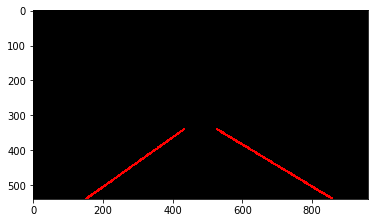

 46%|████▋     | 317/682 [02:49<02:39,  2.28it/s]

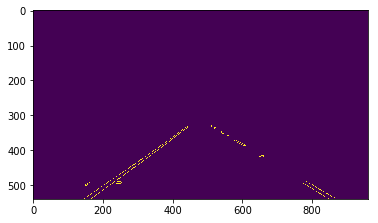

[[-0.7027027 ]
 [-0.83333333]
 [-0.9       ]
 [ 0.7       ]
 [ 0.6       ]
 [-0.81818182]
 [-0.58333333]
 [-0.84615385]
 [-0.83333333]
 [-0.71428571]
 [-0.8125    ]
 [ 0.64285714]
 [-0.6       ]
 [ 0.63333333]
 [-0.81818182]
 [-0.9       ]
 [-0.77272727]
 [-0.66666667]
 [ 0.69230769]
 [-0.76470588]
 [-0.9       ]
 [ 0.5       ]
 [-0.83333333]
 [ 0.54545455]
 [-0.9       ]
 [-0.81818182]
 [-0.70588235]
 [-0.6       ]
 [-0.63636364]
 [ 0.7       ]]
left_m = -0.711769535631  right_m = 0.609890868497
left_c = 650.622607703  right_c = 19.3150645183
left_y = 331.038086205  right_y = 331.579189189  min y = 331.038086205
left_y = 545.992485966  right_y = 535.892630135  max y = 545.992485966


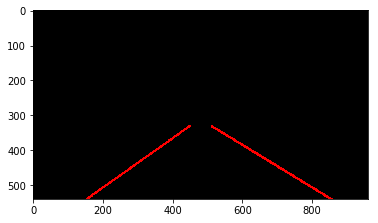

 47%|████▋     | 318/682 [02:50<02:37,  2.31it/s]

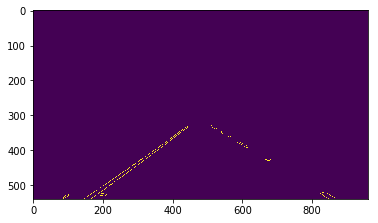

[[-0.64      ]
 [-0.72916667]
 [ 0.52380952]
 [-0.6       ]
 [-0.75757576]
 [-0.72093023]
 [-0.85714286]
 [-0.9       ]
 [ 0.64285714]
 [-0.63636364]
 [-0.8       ]
 [-0.63636364]
 [-0.83333333]
 [ 0.7       ]
 [ 0.54545455]
 [-0.64285714]
 [-0.83333333]
 [-0.64285714]
 [-0.58333333]
 [-0.61538462]
 [ 0.45454545]
 [-0.57142857]
 [ 0.58333333]
 [-0.41666667]
 [-0.6       ]
 [ 0.58333333]
 [-0.4       ]
 [-0.58823529]
 [-0.69230769]
 [-0.5       ]]
left_m = -0.644213529944  right_m = 0.596346552046
left_c = 626.79963258  right_c = 25.383527067
left_y = 337.547757635  right_y = 373.05356691  min y = 337.547757635
left_y = 567.531987825  right_y = 533.47078941  max y = 567.531987825


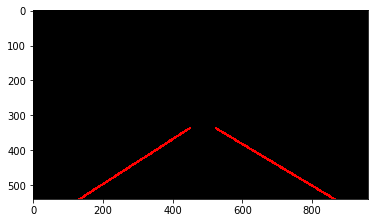

 47%|████▋     | 319/682 [02:50<02:34,  2.35it/s]

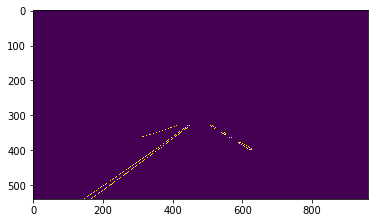

[[-0.70212766]
 [-0.76470588]
 [ 0.5862069 ]
 [-0.77777778]
 [-0.31578947]
 [-0.73333333]
 [-0.6875    ]
 [-0.80952381]
 [-0.76470588]
 [-0.36666667]
 [-0.77777778]
 [-0.9       ]
 [-0.72727273]
 [ 0.66666667]
 [ 0.57692308]
 [ 0.7       ]
 [-0.7       ]
 [-0.81818182]
 [-0.8       ]
 [-0.78571429]
 [-0.8       ]
 [ 0.6       ]
 [-0.84615385]]
left_m = -0.72662929465  right_m = 0.560814228493
left_c = 655.594582923  right_c = 46.7932439268
left_y = 337.330951867  right_y = 349.632927313  min y = 337.330951867
left_y = 548.78007661  right_y = 398.423765192  max y = 548.78007661


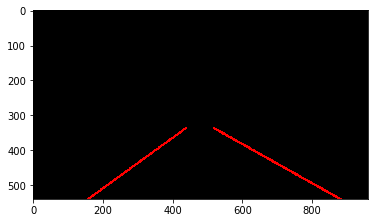

 47%|████▋     | 320/682 [02:51<02:34,  2.34it/s]

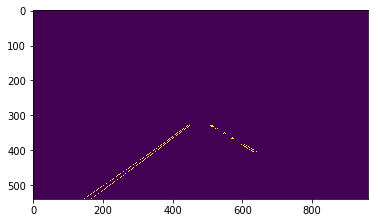

[[-0.67346939]
 [-0.72307692]
 [ 0.58333333]
 [-0.73404255]
 [ 0.66666667]
 [-0.7027027 ]
 [ 0.66666667]
 [-0.70588235]
 [-0.81818182]
 [-0.7       ]
 [-0.6       ]
 [-0.81818182]
 [-0.73684211]
 [-0.72727273]
 [ 0.58333333]
 [-0.73684211]
 [-0.8       ]
 [ 0.5       ]]
left_m = -0.712494607802  right_m = 0.544496200049
left_c = 649.948954155  right_c = 56.3992400098
left_y = 334.313842899  right_y = 380.374479039  min y = 334.313842899
left_y = 545.212246808  right_y = 404.876808041  max y = 545.212246808


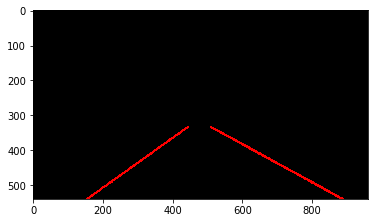

 47%|████▋     | 321/682 [02:51<02:40,  2.25it/s]

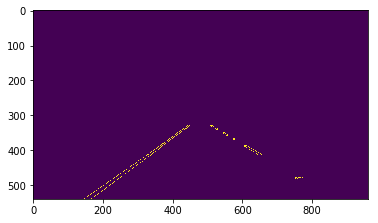

[[-0.72477064]
 [-0.65      ]
 [ 0.        ]
 [-0.76      ]
 [-0.6       ]
 [-0.63157895]
 [-0.73267327]
 [-0.81818182]
 [-0.63636364]
 [-0.58333333]
 [ 0.54054054]
 [-0.69230769]
 [-0.73684211]
 [-0.57142857]
 [ 0.71428571]
 [-0.70833333]
 [ 0.45454545]
 [-0.78947368]
 [-0.64285714]
 [-0.61538462]
 [-0.76923077]
 [ 0.63636364]
 [-0.75      ]
 [-0.66666667]
 [ 0.54545455]
 [-0.78571429]]
left_m = -0.711101775898  right_m = 0.47125006481
left_c = 648.832866548  right_c = 103.825115363
left_y = 333.814779825  right_y = 389.402654638  min y = 333.814779825
left_y = 545.012007266  right_y = 412.965157878  max y = 545.012007266


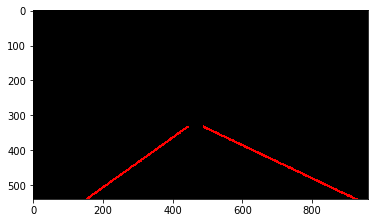

 47%|████▋     | 322/682 [02:52<02:35,  2.32it/s]

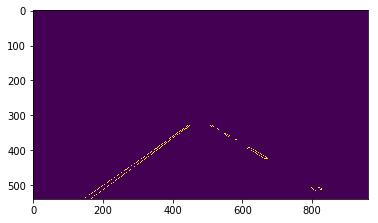

[[-0.8       ]
 [-0.69863014]
 [-0.72222222]
 [-0.80952381]
 [-0.75862069]
 [-0.7804878 ]
 [-0.84615385]
 [-0.7       ]
 [-0.85714286]
 [-0.8       ]
 [ 0.66666667]
 [-0.84615385]
 [-0.73333333]
 [ 0.56818182]
 [ 0.6       ]
 [-0.83333333]
 [-0.66666667]
 [ 0.6       ]
 [-0.8       ]
 [-0.9       ]
 [ 0.58333333]
 [ 0.75      ]
 [-0.6       ]
 [ 0.        ]
 [ 0.64705882]
 [ 0.27272727]
 [-0.81818182]
 [-0.72727273]]
left_m = -0.719587944755  right_m = 0.551015429652
left_c = 651.87871963  right_c = 53.8311276453
left_y = 329.503320379  right_y = 355.236567665  min y = 329.503320379
left_y = 546.818879696  right_y = 424.664511801  max y = 546.818879696


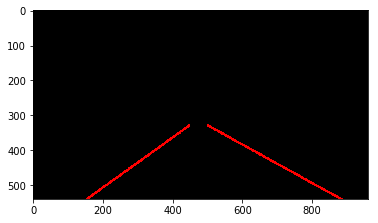

 47%|████▋     | 323/682 [02:52<02:32,  2.36it/s]

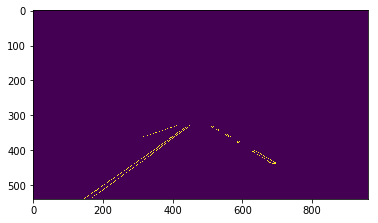

[[-0.6       ]
 [-0.76923077]
 [-0.77777778]
 [-0.67567568]
 [-0.78947368]
 [-0.76190476]
 [-0.7       ]
 [-0.76315789]
 [-0.31818182]
 [-0.71428571]
 [ 0.69230769]
 [-0.70833333]
 [-0.84615385]
 [ 0.58333333]
 [ 0.5       ]
 [ 0.59090909]
 [-0.9       ]
 [ 0.53333333]
 [-0.77272727]
 [ 0.5       ]
 [-0.81818182]
 [-0.68421053]
 [ 0.61538462]
 [-0.66666667]
 [ 0.63636364]
 [-0.36363636]
 [-0.68421053]
 [-0.8125    ]]
left_m = -0.721659471559  right_m = 0.603634531009
left_c = 651.991423654  right_c = 22.5027303451
left_y = 327.966320924  right_y = 354.5017224  min y = 327.966320924
left_y = 547.350800278  right_y = 441.425094865  max y = 547.350800278


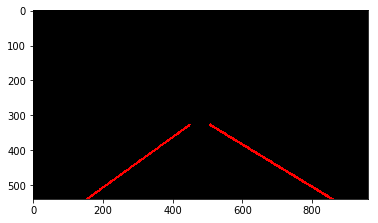

 48%|████▊     | 324/682 [02:52<02:32,  2.35it/s]

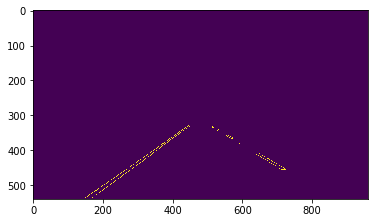

[[ 0.625     ]
 [-0.70212766]
 [-0.68181818]
 [-0.73170732]
 [-0.76190476]
 [-0.8125    ]
 [-0.58333333]
 [-0.78181818]
 [-0.9       ]
 [-0.83333333]
 [ 0.6       ]
 [ 0.5483871 ]
 [-0.8       ]
 [ 0.6       ]
 [ 0.63636364]
 [ 0.5       ]
 [-0.65217391]
 [-0.6875    ]
 [-0.78571429]
 [ 0.5       ]
 [-0.78571429]
 [-0.6       ]
 [-0.78571429]
 [ 0.625     ]
 [-0.83333333]
 [-0.8       ]]
left_m = -0.714342347617  right_m = 0.590008649522
left_c = 649.081010641  right_c = 29.7438398465
left_y = 329.769981256  right_y = 356.608631682  min y = 329.769981256
left_y = 545.501370236  right_y = 455.730084801  max y = 545.501370236


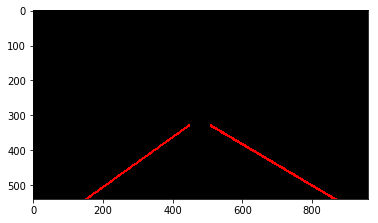

 48%|████▊     | 325/682 [02:53<02:30,  2.38it/s]

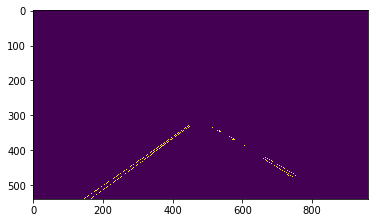

[[-0.65217391]
 [-0.76470588]
 [ 0.6       ]
 [-0.72727273]
 [-0.66666667]
 [ 0.52631579]
 [-0.75757576]
 [-0.66666667]
 [-0.77272727]
 [-0.6       ]
 [ 0.57407407]
 [ 0.61111111]
 [-0.66037736]
 [ 0.52380952]
 [-0.85714286]
 [-0.64      ]
 [-0.81818182]
 [ 0.52941176]
 [-0.9       ]
 [ 0.44444444]
 [-0.72727273]
 [ 0.55555556]
 [-0.81818182]
 [ 0.58333333]
 [ 0.53846154]
 [-0.63636364]]
left_m = -0.696902476678  right_m = 0.601341418153
left_c = 643.284650606  right_c = 23.4874028159
left_y = 329.678536101  right_y = 360.238596982  min y = 329.678536101
left_y = 538.749279105  right_y = 479.304197776  max y = 538.749279105


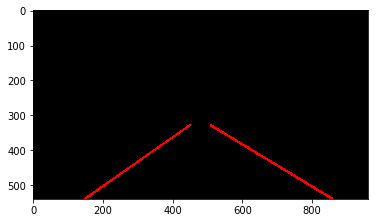

 48%|████▊     | 326/682 [02:53<02:29,  2.39it/s]

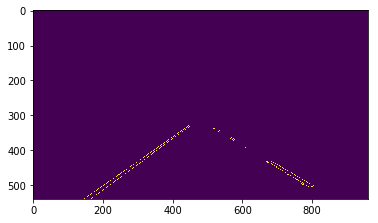

[[-0.69047619]
 [ 0.55555556]
 [-0.69942197]
 [ 0.53846154]
 [-0.75      ]
 [ 0.56818182]
 [-0.70769231]
 [-0.66666667]
 [ 0.63636364]
 [-0.63636364]
 [ 0.52      ]
 [-0.7826087 ]
 [-0.72093023]
 [ 0.53571429]
 [-0.83333333]
 [-0.6       ]
 [ 0.41666667]
 [ 0.5       ]
 [-0.80952381]
 [ 0.6       ]
 [ 0.5       ]
 [-0.69230769]
 [ 0.54545455]
 [ 0.56521739]
 [-0.1       ]
 [ 0.6       ]
 [ 0.63636364]
 [ 0.53846154]]
left_m = -0.719388338805  right_m = 0.598988581524
left_c = 654.256333875  right_c = 26.3355715759
left_y = 334.128523107  right_y = 363.566142974  min y = 334.128523107
left_y = 545.628694716  right_y = 508.521379703  max y = 545.628694716


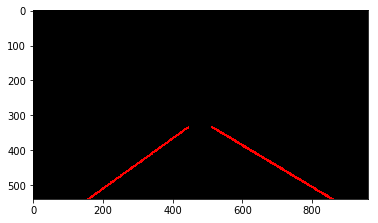

 48%|████▊     | 327/682 [02:54<02:39,  2.23it/s]

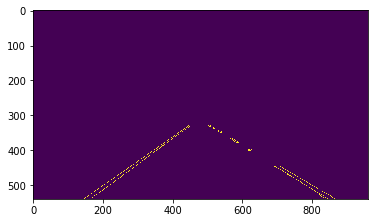

[[-0.67857143]
 [ 0.55555556]
 [-0.73770492]
 [-0.75      ]
 [-0.68085106]
 [-0.625     ]
 [-0.84615385]
 [-0.63636364]
 [ 0.60606061]
 [-0.6       ]
 [ 0.6875    ]
 [-0.75862069]
 [-0.66666667]
 [ 0.63157895]
 [ 0.7       ]
 [ 0.64705882]
 [ 0.7       ]
 [-0.6       ]
 [-0.61538462]
 [ 0.56818182]
 [ 0.55555556]
 [-0.78571429]
 [-0.63636364]
 [-0.63636364]
 [ 0.64      ]
 [ 0.61111111]
 [ 0.7       ]
 [ 0.66666667]
 [-0.7       ]
 [-0.83333333]
 [-0.68421053]
 [-0.63636364]
 [-0.75      ]
 [ 0.57894737]
 [-0.6       ]]
left_m = -0.735099284372  right_m = 0.597627539013
left_c = 657.702759522  right_c = 27.5342944557
left_y = 342.345166526  right_y = 364.596226459  min y = 342.345166526
left_y = 541.557072591  right_y = 544.482115702  max y = 544.482115702


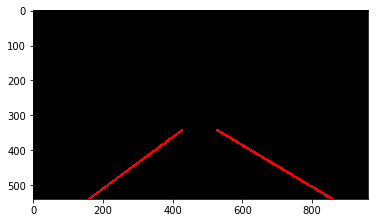

 48%|████▊     | 328/682 [02:54<02:36,  2.27it/s]

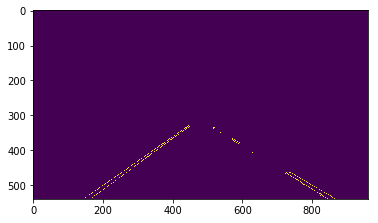

[[ 0.57894737]
 [ 0.61538462]
 [-0.84615385]
 [-0.72413793]
 [-0.73076923]
 [ 0.5       ]
 [-0.67605634]
 [ 0.52631579]
 [-0.81818182]
 [ 0.57142857]
 [ 0.63636364]
 [ 0.6       ]
 [-0.83333333]
 [-0.8       ]
 [-0.63636364]
 [-0.625     ]
 [-0.78571429]
 [ 0.55555556]
 [-0.81818182]
 [ 0.54545455]
 [-0.63636364]
 [-0.70588235]
 [ 0.62962963]
 [-0.63636364]
 [-0.72222222]
 [ 0.52941176]
 [ 0.6       ]
 [-0.69230769]
 [-0.6       ]
 [-0.6       ]
 [-0.75      ]
 [-0.61904762]]
left_m = -0.703404289326  right_m = 0.576593941033
left_c = 645.357074489  right_c = 42.0708755211
left_y = 333.045570028  right_y = 374.765579497  min y = 333.045570028
left_y = 543.363452537  right_y = 540.824634514  max y = 543.363452537


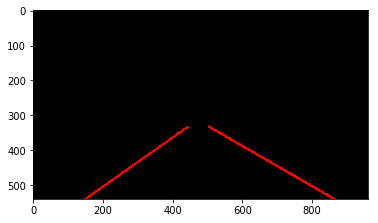

 48%|████▊     | 329/682 [02:55<02:34,  2.29it/s]

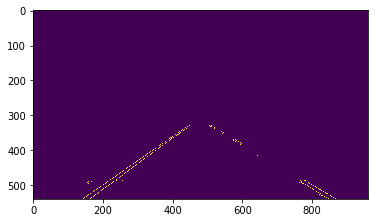

[[-0.7       ]
 [-0.7283237 ]
 [-0.7       ]
 [ 0.53846154]
 [ 0.64705882]
 [-0.75      ]
 [ 0.5       ]
 [-0.81818182]
 [-0.8       ]
 [-0.9       ]
 [ 0.6       ]
 [ 0.52173913]
 [ 0.58333333]
 [-0.77777778]
 [ 0.61111111]
 [-0.7       ]
 [-0.81818182]
 [-0.58333333]
 [-0.73333333]
 [ 0.63636364]
 [-0.61111111]
 [-0.69230769]
 [-0.72727273]
 [ 0.63636364]]
left_m = -0.683757433829  right_m = 0.600904439939
left_c = 637.663534466  right_c = 23.9027575047
left_y = 331.34020411  right_y = 368.82190603  min y = 331.34020411
left_y = 534.416161957  right_y = 532.868818133  max y = 534.416161957


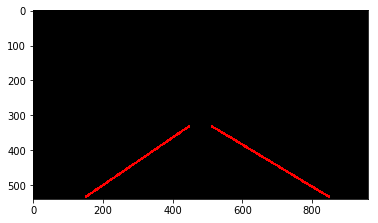

 48%|████▊     | 330/682 [02:55<02:31,  2.33it/s]

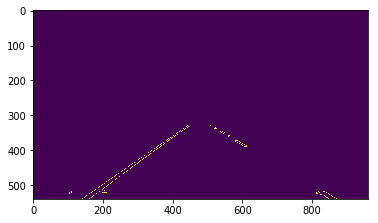

[[-0.73846154]
 [-0.68333333]
 [-0.77419355]
 [-0.7173913 ]
 [-0.64285714]
 [-0.58333333]
 [-0.63636364]
 [-0.63636364]
 [-0.6       ]
 [-0.64285714]
 [-0.68627451]
 [ 0.65384615]
 [ 0.53846154]
 [-0.7       ]
 [ 0.57894737]
 [ 0.58333333]
 [-0.61538462]
 [-0.64705882]
 [-0.6       ]
 [-0.54545455]
 [-0.7       ]
 [-0.64      ]
 [-0.6       ]
 [ 0.        ]
 [-0.6       ]
 [ 0.63636364]
 [ 0.6       ]]
left_m = -0.698505368083  right_m = 0.601879902984
left_c = 641.657168631  right_c = 23.6117265908
left_y = 332.917795938  right_y = 372.100190419  min y = 332.917795938
left_y = 543.167911731  right_y = 546.043482381  max y = 546.043482381


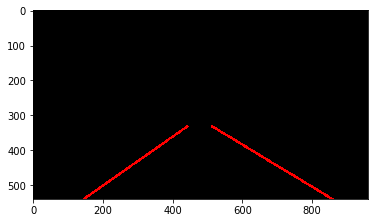

 49%|████▊     | 331/682 [02:55<02:29,  2.35it/s]

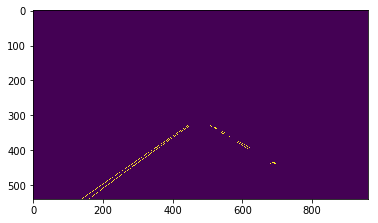

[[ 0.5625    ]
 [-0.6       ]
 [-0.67924528]
 [-0.84615385]
 [-0.76923077]
 [-0.70967742]
 [-0.58333333]
 [-0.66666667]
 [-0.8       ]
 [ 0.61290323]
 [-0.81818182]
 [-0.66666667]
 [-0.65      ]
 [-0.78571429]
 [-0.78571429]
 [-0.8       ]
 [-0.81818182]
 [-0.76470588]
 [-0.78571429]
 [-0.76470588]
 [-0.78571429]
 [-0.78571429]
 [-0.8       ]
 [-0.8       ]
 [ 0.63636364]]
left_m = -0.700233574046  right_m = 0.57103137826
left_c = 641.370894343  right_c = 41.7395736793
left_y = 328.366486744  right_y = 376.36396134  min y = 328.366486744
left_y = 543.338193976  right_y = 396.921090957  max y = 543.338193976


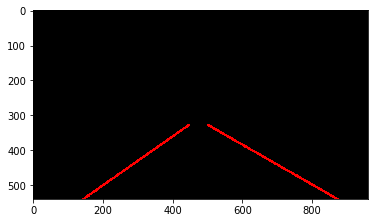

 49%|████▊     | 332/682 [02:56<02:34,  2.27it/s]

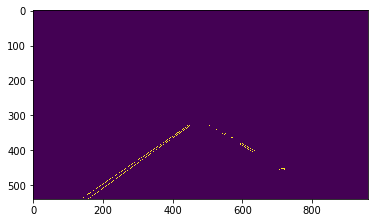

[[-0.75      ]
 [-0.69444444]
 [-0.76470588]
 [-0.9       ]
 [-0.8       ]
 [-0.71666667]
 [-0.70114943]
 [-0.63157895]
 [ 0.625     ]
 [-0.8       ]
 [-0.71428571]
 [-0.71875   ]
 [-0.79166667]
 [ 0.58333333]
 [ 0.55555556]
 [ 0.625     ]
 [-0.75      ]
 [-0.78571429]
 [ 0.        ]
 [-0.7       ]
 [-0.69230769]
 [-0.83333333]]
left_m = -0.701548792807  right_m = 0.551301684533
left_c = 643.303679385  right_c = 54.2507656968
left_y = 331.816015379  right_y = 383.377871363  min y = 331.816015379
left_y = 539.47445805  right_y = 403.776033691  max y = 539.47445805


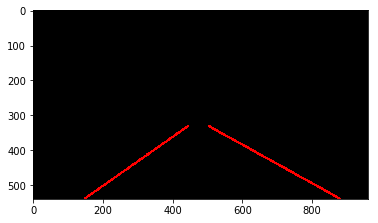

 49%|████▉     | 333/682 [02:56<02:30,  2.32it/s]

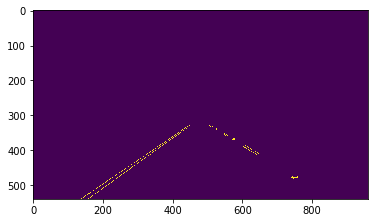

[[-0.74193548]
 [-0.67558528]
 [-0.65      ]
 [ 0.63636364]
 [-0.6969697 ]
 [-0.7       ]
 [-0.75      ]
 [ 0.61538462]
 [-0.78571429]
 [ 0.66666667]
 [-0.7       ]
 [ 0.58823529]
 [ 0.6       ]
 [ 0.66666667]
 [ 0.55172414]
 [-0.72727273]]
left_m = -0.703823188584  right_m = 0.61377178591
left_c = 646.38691439  right_c = 16.8620348575
left_y = 333.889418659  right_y = 350.753886392  min y = 333.889418659
left_y = 549.259314366  right_y = 410.289749626  max y = 549.259314366


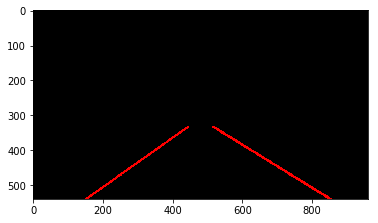

 49%|████▉     | 334/682 [02:57<02:30,  2.31it/s]

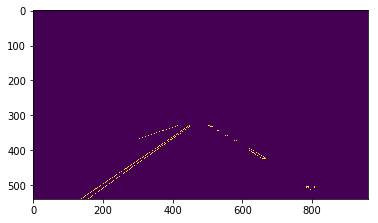

[[-0.76923077]
 [ 0.65      ]
 [-0.75      ]
 [-0.65      ]
 [-0.61538462]
 [-0.6       ]
 [-0.73913043]
 [-0.58333333]
 [-0.64285714]
 [-0.70967742]
 [-0.6875    ]
 [-0.83333333]
 [-0.6       ]
 [-0.32352941]
 [-0.70588235]
 [ 0.5       ]
 [-0.63636364]
 [-0.72727273]
 [-0.33333333]
 [ 0.54545455]
 [ 0.54545455]
 [-0.66666667]
 [-0.8       ]
 [-0.81818182]
 [-0.78571429]
 [-0.73684211]]
left_m = -0.684184432908  right_m = 0.584795860396
left_c = 637.996480088  right_c = 35.9470496108
left_y = 334.218591876  right_y = 330.09936739  min y = 330.09936739
left_y = 543.579028346  right_y = 426.005888495  max y = 543.579028346


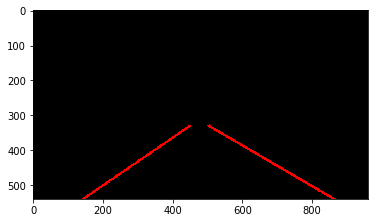

 49%|████▉     | 335/682 [02:57<02:27,  2.35it/s]

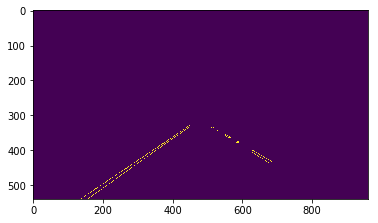

[[-0.7007874 ]
 [-0.84615385]
 [-0.6712963 ]
 [-0.8       ]
 [ 0.5       ]
 [-0.67647059]
 [-0.65789474]
 [ 0.4       ]
 [-0.72727273]
 [-1.        ]
 [ 0.65384615]
 [ 0.5       ]
 [-0.70833333]
 [-0.8       ]
 [-0.66666667]
 [-0.76923077]
 [-0.8       ]
 [ 0.52380952]
 [-0.72222222]
 [ 0.64285714]
 [-0.66666667]]
left_m = -0.693394720559  right_m = 0.460597359633
left_c = 642.021245683  right_c = 115.79473175
left_y = 345.941700005  right_y = 401.825692082  min y = 345.941700005
left_y = 547.026168967  right_y = 426.697949502  max y = 547.026168967


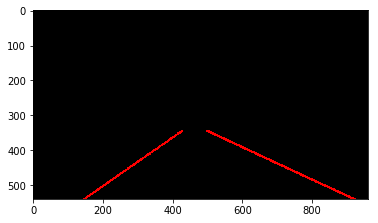

 49%|████▉     | 336/682 [02:58<02:26,  2.35it/s]

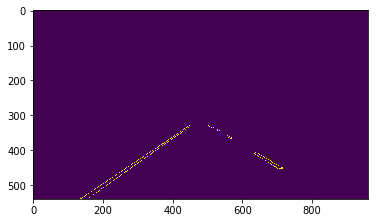

[[ 0.59722222]
 [-0.72727273]
 [-0.67532468]
 [-1.        ]
 [ 0.625     ]
 [-0.70731707]
 [-0.75757576]
 [-0.8       ]
 [ 0.58333333]
 [-0.61538462]
 [-0.68965517]
 [ 0.57142857]
 [-0.66666667]
 [ 0.53846154]
 [ 0.57692308]
 [-0.6969697 ]
 [-0.70588235]
 [-0.6       ]
 [-0.83333333]
 [-0.72727273]
 [-0.66666667]
 [-0.8       ]
 [-0.61538462]
 [-0.8       ]
 [ 0.6       ]]
left_m = -0.674388250214  right_m = 0.600343713254
left_c = 635.699787741  right_c = 26.59453019
left_y = 340.317734147  right_y = 358.58460362  min y = 340.317734147
left_y = 543.308597462  right_y = 455.239941454  max y = 543.308597462


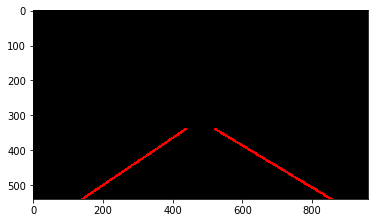

 49%|████▉     | 337/682 [02:58<02:24,  2.39it/s]

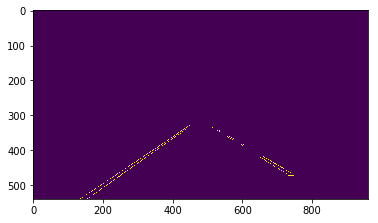

[[-0.76470588]
 [-0.57142857]
 [-0.8       ]
 [-0.75      ]
 [ 0.66666667]
 [-0.83333333]
 [-0.70454545]
 [-0.72222222]
 [-0.74285714]
 [-0.61538462]
 [-0.6       ]
 [-0.75      ]
 [ 0.6       ]
 [-0.76923077]
 [ 0.76923077]
 [-0.75      ]
 [-0.63636364]
 [-0.69230769]
 [ 0.66666667]
 [-0.54545455]
 [ 0.6       ]
 [-0.66666667]
 [-0.67741935]
 [-0.57894737]
 [-0.78571429]
 [-0.9       ]
 [ 0.53846154]
 [ 0.58333333]
 [-0.8       ]]
left_m = -0.695922017077  right_m = 0.623928525737
left_c = 641.535370416  right_c = 11.5166105164
left_y = 329.762306766  right_y = 357.7969423  min y = 329.762306766
left_y = 528.79600365  right_y = 471.97586251  max y = 528.79600365


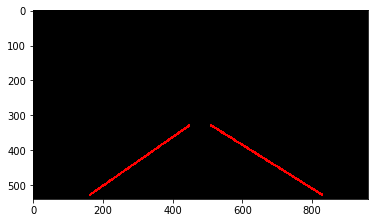

 50%|████▉     | 338/682 [02:59<02:45,  2.07it/s]

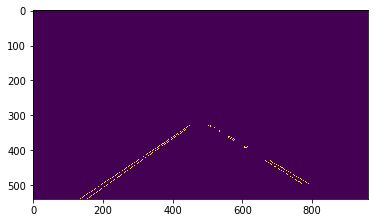

[[-0.67114094]
 [ 0.625     ]
 [ 0.58139535]
 [-0.78571429]
 [-0.78571429]
 [-0.72413793]
 [-0.72093023]
 [-0.66990291]
 [-0.70833333]
 [-0.71428571]
 [ 0.61904762]
 [-0.57142857]
 [-0.58333333]
 [-0.77272727]
 [ 0.575     ]
 [ 0.63636364]
 [-0.68      ]
 [-0.8       ]
 [ 0.53846154]
 [ 0.5625    ]
 [ 0.58333333]
 [ 0.58333333]
 [ 0.5625    ]
 [-0.75      ]
 [ 0.54545455]
 [ 0.6       ]]
left_m = -0.689347192234  right_m = 0.594013730223
left_c = 640.361672924  right_c = 29.4653598681
left_y = 336.359561149  right_y = 328.25426617  min y = 328.25426617
left_y = 546.61045478  right_y = 499.924234205  max y = 546.61045478


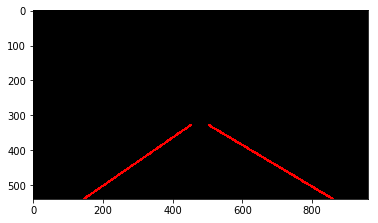

 50%|████▉     | 339/682 [02:59<02:54,  1.96it/s]

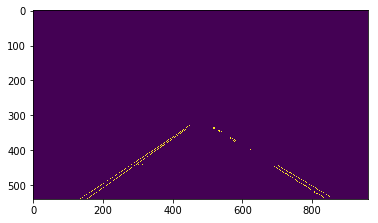

[[-0.63333333]
 [ 0.625     ]
 [-0.61904762]
 [ 0.55555556]
 [-0.65656566]
 [-0.81818182]
 [-0.63636364]
 [-0.77777778]
 [-0.75      ]
 [-0.58333333]
 [-0.76923077]
 [ 0.61538462]
 [-0.77777778]
 [ 0.57142857]
 [ 0.5       ]
 [-0.8       ]
 [-0.78571429]
 [-0.75      ]
 [ 0.69230769]
 [-0.6       ]
 [ 0.61538462]
 [-1.        ]
 [-0.68      ]
 [ 0.54166667]
 [-1.        ]
 [-0.78571429]
 [-0.8       ]
 [ 0.58823529]
 [ 0.5       ]
 [ 0.61538462]
 [-0.81818182]
 [ 0.5       ]
 [-0.625     ]
 [-0.75      ]
 [-0.6       ]
 [ 0.53846154]
 [-0.66666667]
 [ 0.58333333]
 [ 0.        ]
 [ 0.54545455]
 [-0.8       ]]
left_m = -0.697211210946  right_m = 0.592450932873
left_c = 642.302979635  right_c = 32.3894299793
left_y = 338.318891663  right_y = 366.53175612  min y = 338.318891663
left_y = 547.482254946  right_y = 538.342526653  max y = 547.482254946


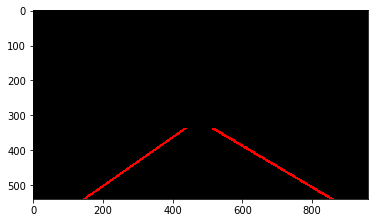

 50%|████▉     | 340/682 [03:00<03:06,  1.84it/s]

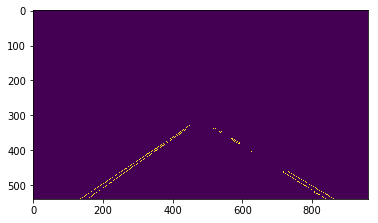

[[-0.65486726]
 [ 0.56666667]
 [-0.65263158]
 [-0.75      ]
 [-0.72307692]
 [-0.66666667]
 [ 0.6       ]
 [ 0.5       ]
 [-0.68421053]
 [-0.73684211]
 [-0.7037037 ]
 [ 0.46666667]
 [ 0.45454545]
 [-0.58333333]
 [-0.76470588]
 [ 0.6       ]
 [ 0.61538462]
 [ 0.61538462]
 [-0.66666667]
 [ 0.53333333]
 [ 0.5       ]
 [ 0.53333333]
 [-0.625     ]
 [ 0.47368421]
 [ 0.54545455]
 [-0.7       ]
 [ 0.61538462]
 [-0.63636364]
 [ 0.5       ]
 [-0.64285714]
 [ 0.55555556]
 [-0.63636364]]
left_m = -0.693044477376  right_m = 0.604238644982
left_c = 642.242384122  right_c = 24.6471728322
left_y = 337.995858554  right_y = 367.854723182  min y = 337.995858554
left_y = 545.909201767  right_y = 541.875452937  max y = 545.909201767


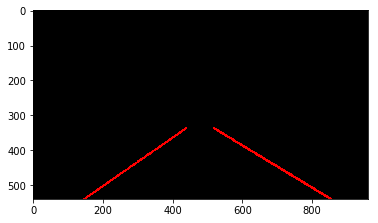

 50%|█████     | 341/682 [03:00<03:06,  1.82it/s]

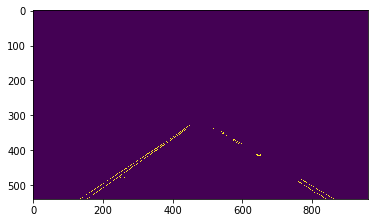

[[-0.68333333]
 [-0.78571429]
 [-0.675     ]
 [ 0.6097561 ]
 [ 0.57692308]
 [-1.        ]
 [ 0.5       ]
 [-0.8       ]
 [-0.58333333]
 [ 0.5       ]
 [-0.76923077]
 [ 0.52631579]
 [-0.63333333]
 [ 0.65      ]
 [-0.83333333]
 [-0.7       ]
 [-0.68181818]
 [-0.7       ]
 [-1.        ]
 [-0.6       ]
 [-0.81818182]
 [ 0.55      ]
 [-0.6       ]
 [-0.83333333]
 [ 0.36363636]
 [ 0.54545455]
 [-0.58333333]
 [ 0.64705882]
 [ 0.5       ]]
left_m = -0.70445048296  right_m = 0.590551972717
left_c = 645.832340501  right_c = 31.6057323371
left_y = 333.76077655  right_y = 369.992012704  min y = 333.76077655
left_y = 550.027074819  right_y = 540.070980847  max y = 550.027074819


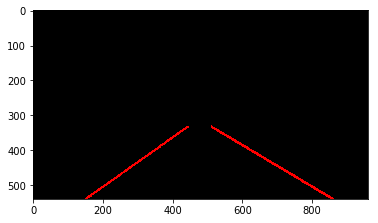

 50%|█████     | 342/682 [03:01<03:13,  1.76it/s]

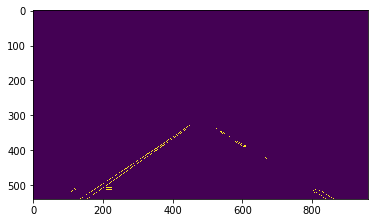

[[-0.6       ]
 [-0.70466321]
 [ 0.60714286]
 [-0.72      ]
 [-0.76923077]
 [-0.71428571]
 [ 0.54545455]
 [ 0.5       ]
 [-0.8       ]
 [-0.75      ]
 [-0.8       ]
 [-0.76923077]
 [-0.58333333]
 [-0.58333333]
 [-0.76923077]
 [-0.70588235]
 [-0.70967742]
 [-0.72727273]
 [-0.68181818]
 [-0.71428571]
 [-0.68      ]
 [ 0.4       ]
 [-0.61538462]
 [ 0.64705882]
 [-0.72727273]]
left_m = -0.677925797425  right_m = 0.610691957604
left_c = 634.551894793  right_c = 19.6205014512
left_y = 333.552840736  right_y = 381.150140353  min y = 333.552840736
left_y = 542.353986343  right_y = 544.81558499  max y = 544.81558499


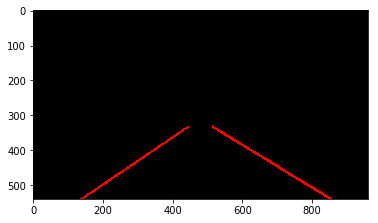

 50%|█████     | 343/682 [03:02<03:14,  1.74it/s]

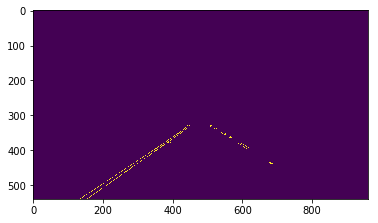

[[-0.75      ]
 [-0.6746988 ]
 [-0.67567568]
 [-0.73684211]
 [-0.625     ]
 [ 0.63157895]
 [-0.5625    ]
 [-0.58333333]
 [-0.69565217]
 [-0.61538462]
 [-0.75      ]
 [-0.6       ]
 [-0.8       ]
 [ 0.54545455]
 [-0.58333333]
 [ 0.58333333]
 [-0.7       ]
 [ 0.53333333]
 [-0.08333333]
 [-0.53846154]
 [-0.58333333]
 [-0.75      ]
 [ 0.        ]]
left_m = -0.656020936356  right_m = 0.50060189166
left_c = 630.030056833  right_c = 84.5776440241
left_y = 337.444719218  right_y = 377.429750645  min y = 337.444719218
left_y = 540.811209488  right_y = 392.948409286  max y = 540.811209488


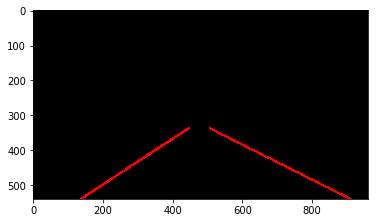

 50%|█████     | 344/682 [03:02<02:56,  1.91it/s]

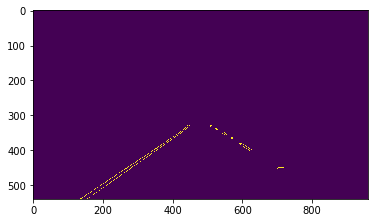

[[-0.67647059]
 [-0.65384615]
 [-0.63636364]
 [-0.66666667]
 [-0.71428571]
 [-0.69892473]
 [-0.6875    ]
 [ 0.6       ]
 [-0.65957447]
 [ 0.        ]
 [-0.68421053]
 [-0.8       ]
 [-0.72222222]
 [ 0.58333333]
 [-0.76923077]
 [-0.6       ]
 [-0.8       ]
 [ 0.66666667]
 [ 0.54545455]
 [-0.6       ]
 [-0.7       ]
 [-0.63636364]]
left_m = -0.675483552205  right_m = 0.522367937247
left_c = 635.524224128  right_c = 72.8014462557
left_y = 341.688878919  right_y = 381.520897169  min y = 341.688878919
left_y = 538.25459261  right_y = 398.236671161  max y = 538.25459261


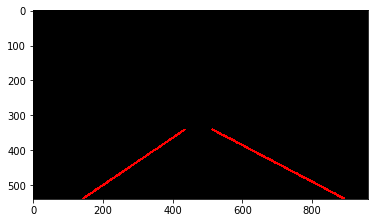

 51%|█████     | 345/682 [03:02<02:54,  1.94it/s]

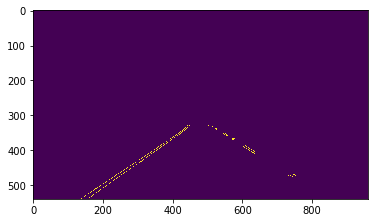

[[-0.67391304]
 [-0.94117647]
 [-0.73333333]
 [-0.58333333]
 [-0.6875    ]
 [-0.625     ]
 [ 0.53333333]
 [-0.625     ]
 [-0.57142857]
 [-0.66666667]
 [ 0.54545455]
 [-0.76190476]
 [-0.61538462]
 [-0.57142857]
 [-0.63636364]
 [ 0.6       ]
 [ 0.55555556]
 [ 0.6       ]
 [-0.81818182]
 [-0.66666667]
 [ 0.58333333]
 [-0.91666667]
 [-0.77777778]
 [-0.58333333]
 [ 0.61538462]]
left_m = -0.666031627672  right_m = 0.61371424449
left_c = 633.766158541  right_c = 17.3882696678
left_y = 352.700811664  right_y = 351.24881867  min y = 351.24881867
left_y = 541.853793923  right_y = 413.233957364  max y = 541.853793923


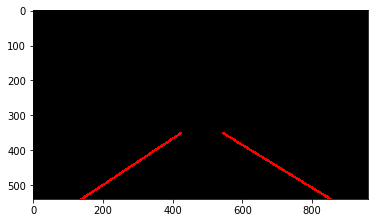

 51%|█████     | 346/682 [03:03<02:46,  2.02it/s]

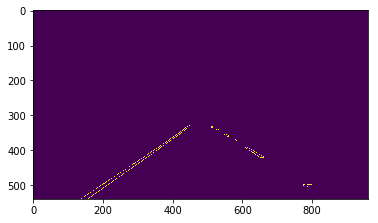

[[-0.66666667]
 [-0.67961165]
 [-0.73333333]
 [-0.81818182]
 [-0.67741935]
 [-0.62068966]
 [-0.76923077]
 [-0.71428571]
 [-0.61538462]
 [ 0.5625    ]
 [-0.68518519]
 [ 0.65      ]
 [-0.6       ]
 [-0.64285714]
 [ 0.61363636]
 [-0.63157895]
 [-0.6       ]
 [-0.58333333]
 [-0.63157895]
 [-0.69230769]
 [-0.6       ]
 [-0.66666667]
 [-0.83333333]]
left_m = -0.67841494103  right_m = 0.629310344828
left_c = 637.901773095  right_c = 8.73275862069
left_y = 347.540178334  right_y = 391.353448276  min y = 347.540178334
left_y = 544.280511233  right_y = 419.043103448  max y = 544.280511233


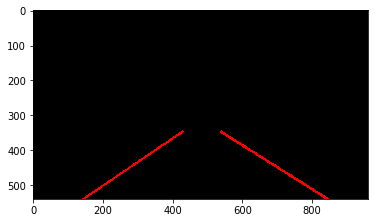

 51%|█████     | 347/682 [03:03<02:40,  2.09it/s]

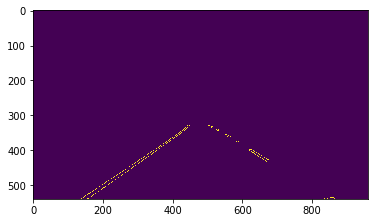

[[-0.70454545]
 [-0.6969697 ]
 [-0.69230769]
 [-0.625     ]
 [-0.69047619]
 [ 0.59574468]
 [ 0.62790698]
 [-0.8       ]
 [-0.76923077]
 [-0.75      ]
 [-0.68181818]
 [-0.81818182]
 [-0.6875    ]
 [-0.8       ]
 [ 0.35714286]
 [-0.64285714]
 [-0.7027027 ]
 [-0.75      ]
 [-0.78571429]
 [ 0.6       ]
 [-0.58333333]
 [-0.81818182]
 [-0.72727273]
 [-0.8       ]
 [-0.64285714]
 [-0.72727273]
 [ 0.6       ]]
left_m = -0.682754088535  right_m = 0.583982768749
left_c = 639.255615363  right_c = 38.3020560016
left_y = 339.526570496  right_y = 399.787389857  min y = 339.526570496
left_y = 544.352797056  right_y = 430.738476601  max y = 544.352797056


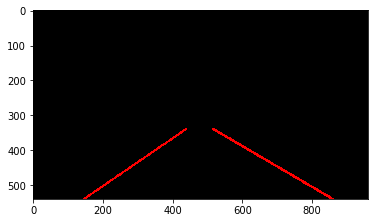

 51%|█████     | 348/682 [03:04<02:33,  2.18it/s]

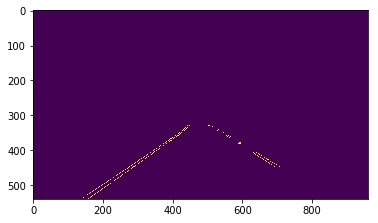

[[-0.75      ]
 [-0.70247934]
 [-0.65753425]
 [-0.83333333]
 [-0.70833333]
 [ 0.59459459]
 [-0.70588235]
 [ 0.54545455]
 [ 0.5625    ]
 [ 0.64285714]
 [ 0.63888889]
 [-0.64705882]
 [ 0.6875    ]
 [ 0.61538462]
 [-0.68571429]
 [-0.63333333]
 [-0.67391304]
 [-0.6       ]
 [-0.7       ]]
left_m = -0.677786974113  right_m = 0.610974964511
left_c = 636.151795423  right_c = 19.8597277534
left_y = 344.703396554  right_y = 327.180134902  min y = 327.180134902
left_y = 541.939406021  right_y = 445.098303053  max y = 541.939406021


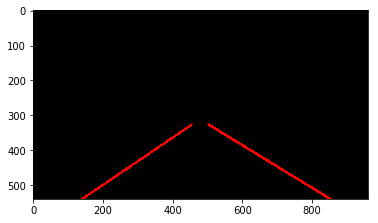

 51%|█████     | 349/682 [03:04<02:35,  2.14it/s]

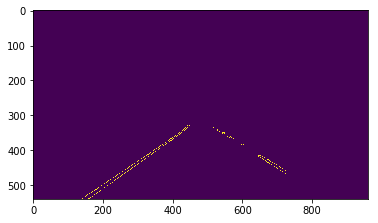

[[-0.5       ]
 [ 0.64556962]
 [-0.70285714]
 [-0.61538462]
 [-0.6       ]
 [-0.63888889]
 [-0.60869565]
 [-0.71428571]
 [-0.76190476]
 [-0.62857143]
 [-0.82758621]
 [ 0.57142857]
 [-0.58333333]
 [-0.58823529]
 [ 0.54545455]
 [ 0.57692308]
 [-0.8       ]
 [ 0.64705882]
 [-0.81818182]
 [ 0.57692308]
 [-0.8       ]]
left_m = -0.663569736012  right_m = 0.620369532118
left_c = 632.495094128  right_c = 12.3732411561
left_y = 336.542991867  right_y = 359.780179142  min y = 336.542991867
left_y = 528.978215311  right_y = 464.002260538  max y = 528.978215311


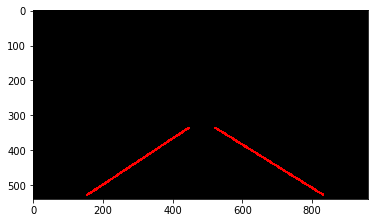

 51%|█████▏    | 350/682 [03:05<02:31,  2.19it/s]

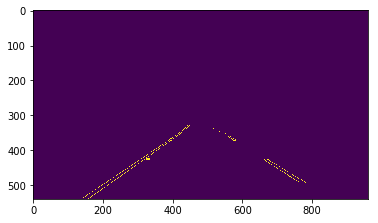

[[-1.        ]
 [-0.75      ]
 [-0.58823529]
 [-0.72527473]
 [-0.63636364]
 [-0.81818182]
 [-0.77272727]
 [-0.81818182]
 [-0.77777778]
 [-0.57142857]
 [ 0.66666667]
 [-0.72972973]
 [ 0.6025641 ]
 [ 0.63636364]
 [-0.8       ]
 [-0.5625    ]
 [ 0.57142857]
 [ 0.61764706]
 [-1.        ]
 [-0.58333333]
 [-0.57142857]
 [ 0.56521739]
 [-0.81818182]
 [-0.7       ]
 [ 0.5625    ]
 [-1.        ]
 [-0.78571429]
 [-0.6       ]
 [ 0.53846154]
 [ 0.57142857]
 [-0.76923077]
 [ 0.        ]
 [ 0.61538462]
 [ 0.54545455]
 [-1.        ]]
left_m = -0.682369074735  right_m = 0.633437003451
left_c = 638.519700075  right_c = 5.74494548613
left_y = 350.559950537  right_y = 360.469667419  min y = 350.559950537
left_y = 537.529077015  right_y = 487.157068109  max y = 537.529077015


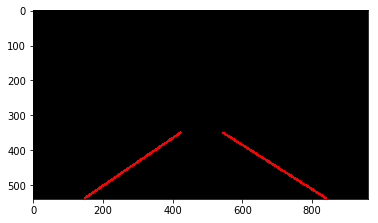

 51%|█████▏    | 351/682 [03:05<02:25,  2.27it/s]

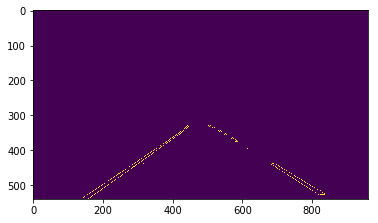

[[-0.70344828]
 [-0.78571429]
 [-0.72      ]
 [ 0.60294118]
 [-0.6       ]
 [-1.        ]
 [-0.61538462]
 [ 0.65714286]
 [ 0.53846154]
 [-0.61904762]
 [-0.61538462]
 [-0.73333333]
 [ 0.6       ]
 [-0.625     ]
 [-0.81481481]
 [-0.63414634]
 [ 0.65957447]
 [ 0.5       ]
 [ 0.55555556]
 [-0.81818182]
 [ 0.64102564]
 [-0.75      ]
 [-0.6       ]
 [ 0.54545455]
 [ 0.5       ]
 [-0.63157895]
 [ 0.6       ]
 [-0.8       ]
 [-0.71428571]
 [ 0.6       ]
 [-0.6       ]]
left_m = -0.668668539261  right_m = 0.635509232345
left_c = 634.779463308  right_c = 1.71179027213
left_y = 341.233974572  right_y = 362.681034244  min y = 341.233974572
left_y = 537.153856576  right_y = 520.287323866  max y = 537.153856576


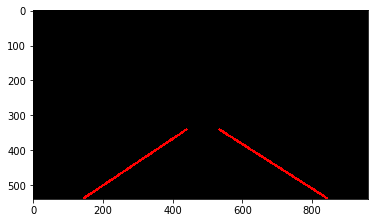

 52%|█████▏    | 352/682 [03:05<02:23,  2.29it/s]

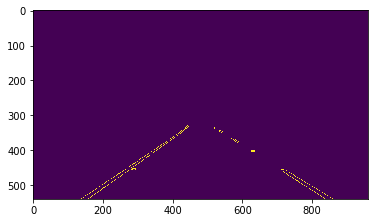

[[ 0.72727273]
 [-0.7826087 ]
 [-0.6       ]
 [ 0.68421053]
 [-0.68235294]
 [ 0.5952381 ]
 [-0.57142857]
 [ 0.61290323]
 [-0.8       ]
 [-0.58823529]
 [-0.75      ]
 [-0.54545455]
 [-0.77777778]
 [ 0.56      ]
 [ 0.54545455]
 [-0.58823529]
 [-0.7254902 ]
 [ 0.6       ]
 [-0.63636364]
 [-0.54545455]
 [-0.68181818]
 [ 0.66666667]
 [-0.57142857]
 [-0.58333333]
 [ 0.66666667]
 [-0.9       ]
 [-0.75      ]
 [-0.57142857]
 [-0.66666667]
 [-0.6875    ]
 [-0.58333333]
 [-0.8       ]
 [ 0.64705882]]
left_m = -0.670229094594  right_m = 0.614224372442
left_c = 634.626077364  right_c = 16.0152338224
left_y = 340.395504837  right_y = 364.894677369  min y = 340.395504837
left_y = 542.13446231  right_y = 542.405521005  max y = 542.405521005


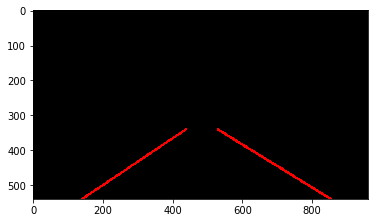

 52%|█████▏    | 353/682 [03:06<02:21,  2.32it/s]

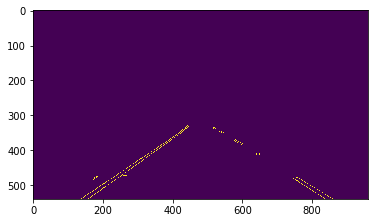

[[-0.76923077]
 [-0.64705882]
 [-0.67307692]
 [-0.75      ]
 [ 0.58064516]
 [-0.61111111]
 [-0.85714286]
 [-0.63636364]
 [-0.68421053]
 [ 0.5625    ]
 [-0.61290323]
 [-0.58333333]
 [-0.78571429]
 [ 0.66666667]
 [-0.63157895]
 [ 0.63333333]
 [ 0.5       ]
 [-0.66666667]
 [-0.61538462]
 [ 0.6       ]
 [-0.625     ]
 [ 0.70588235]
 [-0.6       ]
 [-0.62068966]
 [-0.81818182]
 [-0.66666667]
 [ 0.69230769]
 [-0.58333333]
 [-0.75      ]
 [ 0.71428571]
 [-0.69230769]
 [ 0.63636364]
 [-0.7       ]
 [-0.66666667]]
left_m = -0.679210412694  right_m = 0.608777171187
left_c = 636.438734607  right_c = 23.1536746122
left_y = 338.944573847  right_y = 371.982993702  min y = 338.944573847
left_y = 542.707697656  right_y = 544.266933148  max y = 544.266933148


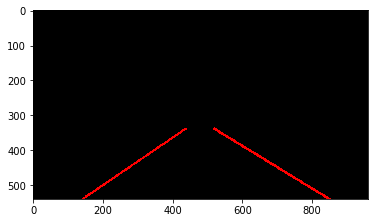

 52%|█████▏    | 354/682 [03:06<02:27,  2.22it/s]

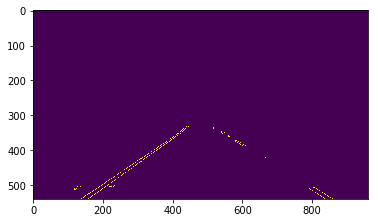

[[-0.75      ]
 [-0.6       ]
 [-0.8125    ]
 [-0.7826087 ]
 [ 0.59375   ]
 [ 0.63636364]
 [-0.64705882]
 [-0.76190476]
 [-0.75      ]
 [-0.57142857]
 [-0.66666667]
 [-0.625     ]
 [ 0.54545455]
 [-0.7       ]
 [-0.71428571]
 [ 0.57142857]
 [-0.6       ]
 [-0.74074074]
 [-0.8       ]
 [-0.8       ]
 [-0.76923077]
 [-0.6       ]
 [-0.57142857]
 [ 0.6       ]
 [-0.58333333]
 [-0.84615385]
 [-0.8       ]
 [ 0.53846154]
 [-0.53333333]
 [-0.63636364]
 [-0.63636364]
 [-0.9       ]]
left_m = -0.654182493906  right_m = 0.631336696091
left_c = 627.977858046  right_c = 5.53627574611
left_y = 348.641933148  right_y = 370.448886087  min y = 348.641933148
left_y = 550.130141271  right_y = 546.591824296  max y = 550.130141271


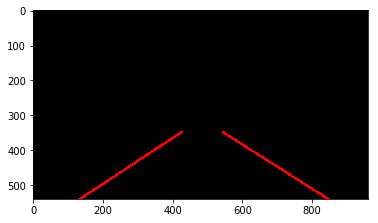

 52%|█████▏    | 355/682 [03:07<02:23,  2.28it/s]

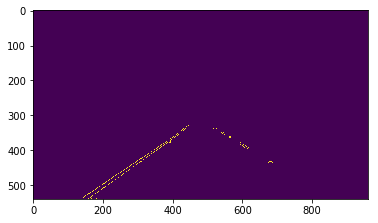

[[-0.75      ]
 [-0.65517241]
 [-0.8       ]
 [-0.76923077]
 [-0.69642857]
 [-0.81818182]
 [ 0.55555556]
 [-0.92857143]
 [-0.68421053]
 [ 0.60714286]
 [-0.83333333]
 [-0.73076923]
 [-0.66666667]
 [-0.71428571]
 [-0.58823529]
 [-0.58333333]
 [-0.72727273]
 [-0.77777778]
 [-0.58333333]
 [ 0.54545455]
 [-0.66666667]
 [-0.4       ]
 [-0.7       ]
 [ 0.        ]
 [-0.6       ]
 [ 0.54545455]]
left_m = -0.707339829603  right_m = 0.565789473684
left_c = 646.803692713  right_c = 44.5723684211
left_y = 337.696187176  right_y = 348.967105263  min y = 337.696187176
left_y = 535.043999635  right_y = 390.835526316  max y = 535.043999635


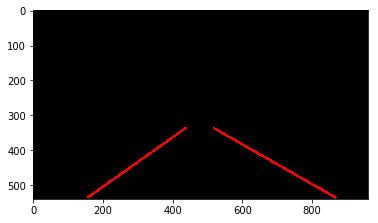

 52%|█████▏    | 356/682 [03:07<02:19,  2.33it/s]

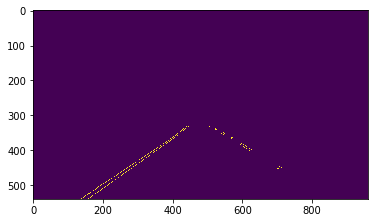

[[-0.81818182]
 [-0.65217391]
 [-0.6       ]
 [-0.77777778]
 [-0.9       ]
 [-0.58333333]
 [-0.81818182]
 [-0.76923077]
 [-0.78571429]
 [-0.72972973]
 [-1.        ]
 [-0.6       ]
 [ 0.5625    ]
 [ 0.6       ]
 [-0.61290323]
 [-0.93333333]
 [ 0.46153846]
 [-0.6       ]
 [-0.67567568]
 [-0.58333333]
 [ 0.65      ]
 [-0.8       ]
 [ 0.7       ]]
left_m = -0.672956737012  right_m = 0.5940625
left_c = 636.719352678  right_c = 30.19
left_y = 349.366825974  right_y = 350.98375  min y = 349.366825974
left_y = 539.140625812  right_y = 399.696875  max y = 539.140625812


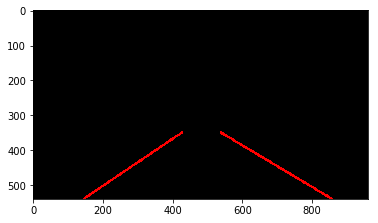

 52%|█████▏    | 357/682 [03:08<02:17,  2.37it/s]

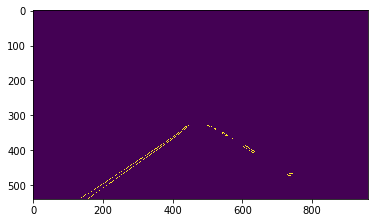

[[-0.71875   ]
 [-0.75      ]
 [-0.82758621]
 [-0.6       ]
 [-0.71794872]
 [-0.65      ]
 [-0.61904762]
 [-0.94117647]
 [-0.72727273]
 [-0.61538462]
 [-0.66666667]
 [-0.58333333]
 [-0.66666667]
 [-0.58333333]
 [-0.6       ]
 [-0.81818182]
 [ 0.58333333]
 [-0.76923077]
 [-0.8       ]
 [ 0.5625    ]
 [-0.7       ]
 [-0.75      ]
 [ 0.57142857]
 [-0.6       ]
 [-0.8       ]
 [-0.76923077]
 [-0.6       ]
 [-0.58333333]]
left_m = -0.676295872975  right_m = 0.623439172315
left_c = 636.532947422  right_c = 10.9240099893
left_y = 334.904988075  right_y = 350.074919729  min y = 334.904988075
left_y = 545.909300443  right_y = 399.326614342  max y = 545.909300443


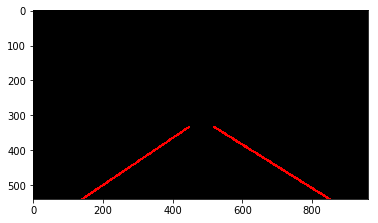

 52%|█████▏    | 358/682 [03:08<02:15,  2.38it/s]

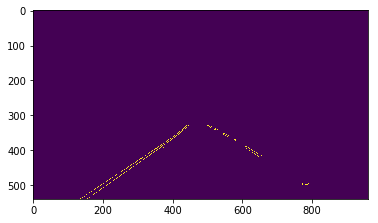

[[-0.86956522]
 [-0.7       ]
 [-0.63636364]
 [-0.69230769]
 [-0.66666667]
 [-0.68965517]
 [-0.75      ]
 [-0.90909091]
 [ 0.65      ]
 [-0.71428571]
 [ 0.63636364]
 [-0.73333333]
 [ 0.60869565]
 [-0.71428571]
 [-0.75      ]
 [-0.07692308]
 [ 0.54545455]
 [-0.625     ]
 [-0.8       ]
 [-0.72727273]
 [ 0.54545455]
 [-0.6       ]]
left_m = -0.676751745437  right_m = 0.621544380628
left_c = 632.682315512  right_c = 13.6167461761
left_y = 341.002313229  right_y = 352.358433618  min y = 341.002313229
left_y = 540.644078133  right_y = 418.242137965  max y = 540.644078133


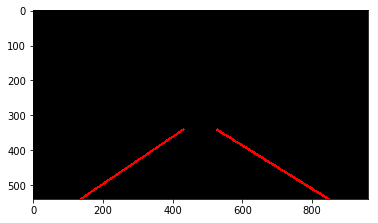

 53%|█████▎    | 359/682 [03:09<02:21,  2.28it/s]

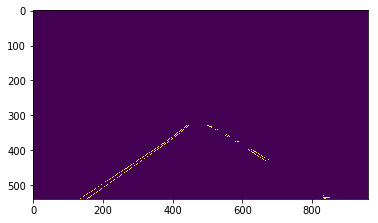

[[-0.75      ]
 [-0.68888889]
 [-0.8       ]
 [-0.73913043]
 [ 0.58333333]
 [-0.66666667]
 [-0.78571429]
 [ 0.57142857]
 [-0.65217391]
 [ 0.625     ]
 [-0.78571429]
 [-0.57142857]
 [-0.57142857]
 [-0.78571429]
 [-0.7       ]
 [ 0.6       ]
 [ 0.        ]
 [-0.78571429]
 [ 0.58333333]
 [ 0.5       ]
 [-0.6       ]
 [-0.8       ]
 [-0.57142857]
 [-0.76470588]
 [-0.875     ]
 [ 0.53846154]
 [-0.72222222]
 [-0.75      ]]
left_m = -0.706253801958  right_m = 0.615657723248
left_c = 645.728636025  right_c = 14.8977124624
left_y = 331.445694154  right_y = 354.740775695  min y = 331.445694154
left_y = 550.384372761  right_y = 427.388387039  max y = 550.384372761


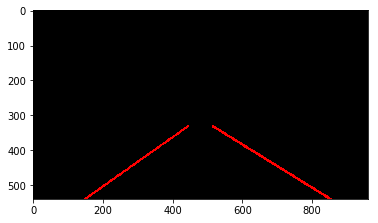

 53%|█████▎    | 360/682 [03:09<02:29,  2.16it/s]

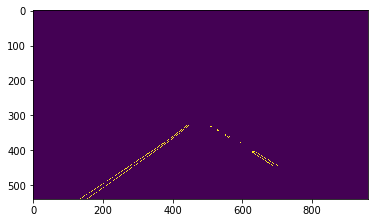

[[-0.84375   ]
 [-0.75      ]
 [-0.703125  ]
 [-0.61111111]
 [-0.71428571]
 [ 0.64516129]
 [-0.66666667]
 [ 0.61538462]
 [ 0.58333333]
 [ 0.61111111]
 [-0.71428571]
 [-0.73333333]
 [ 0.4       ]
 [-0.90909091]
 [-0.70238095]
 [-0.8       ]
 [ 0.53333333]
 [-0.73913043]
 [-0.8       ]
 [-0.8       ]
 [-0.75      ]
 [-0.71428571]
 [ 0.66666667]
 [-0.70588235]]
left_m = -0.657970383944  right_m = 0.615027679919
left_c = 628.53886669  right_c = 16.8842929039
left_y = 344.953631211  right_y = 355.14951686  min y = 344.953631211
left_y = 539.054894474  right_y = 442.483447408  max y = 539.054894474


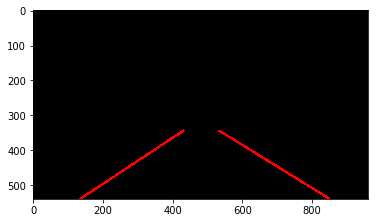

 53%|█████▎    | 361/682 [03:09<02:23,  2.23it/s]

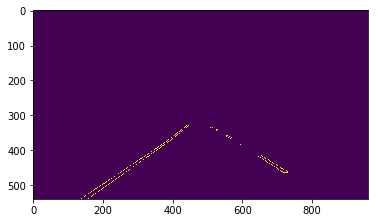

[[-0.69047619]
 [-0.65116279]
 [-0.63888889]
 [-0.70165746]
 [-0.70588235]
 [ 0.64285714]
 [-0.78125   ]
 [ 0.58333333]
 [ 0.63157895]
 [-0.71428571]
 [ 0.60714286]
 [-0.72      ]
 [ 0.57142857]
 [-0.90909091]
 [-0.875     ]
 [-0.75      ]
 [-0.71428571]
 [ 0.5625    ]
 [-0.69230769]
 [-0.63636364]
 [ 0.6       ]]
left_m = -0.68079359034  right_m = 0.602785753559
left_c = 636.335011919  right_c = 24.7148878979
left_y = 339.509006531  right_y = 358.055409616  min y = 339.509006531
left_y = 543.066290043  right_y = 458.72063046  max y = 543.066290043


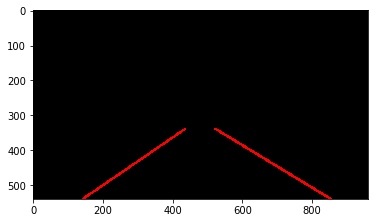

 53%|█████▎    | 362/682 [03:10<02:20,  2.28it/s]

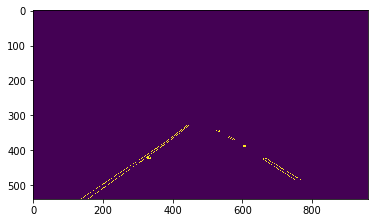

[[-0.72727273]
 [-0.58333333]
 [-0.76190476]
 [-0.64285714]
 [-0.67961165]
 [ 0.62903226]
 [-0.81818182]
 [ 0.59375   ]
 [-0.67857143]
 [-0.61538462]
 [-0.72727273]
 [ 0.42105263]
 [-0.61111111]
 [ 0.57894737]
 [-0.81818182]
 [-0.73684211]
 [-0.81818182]
 [-1.        ]
 [ 0.6       ]
 [-0.73913043]
 [-0.58823529]
 [-0.63636364]
 [ 0.54545455]
 [-0.71428571]
 [ 0.        ]
 [-0.8       ]
 [-0.66666667]
 [ 0.46153846]
 [-0.63636364]]
left_m = -0.687496463412  right_m = 0.549291130894
left_c = 640.280279914  right_c = 63.8498186614
left_y = 351.531765281  right_y = 432.424167491  min y = 351.531765281
left_y = 545.405767963  right_y = 479.663204748  max y = 545.405767963


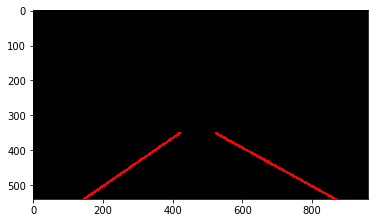

 53%|█████▎    | 363/682 [03:10<02:16,  2.33it/s]

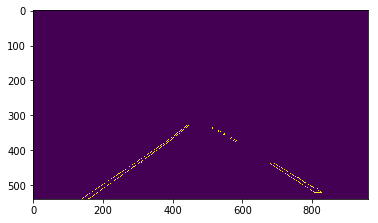

[[-0.67175573]
 [ 0.6       ]
 [-0.9       ]
 [-0.81818182]
 [ 0.66153846]
 [ 0.6       ]
 [-0.82857143]
 [-0.6       ]
 [ 0.70588235]
 [-0.83333333]
 [ 0.65217391]
 [-0.75      ]
 [-0.8       ]
 [-0.9       ]
 [-0.77777778]
 [-0.6       ]
 [-0.73333333]
 [-0.64285714]
 [ 0.55      ]
 [-0.76470588]
 [-0.90909091]
 [ 0.57142857]
 [ 0.7       ]
 [ 0.55555556]
 [ 0.65217391]
 [-0.8125    ]
 [ 0.69230769]
 [-0.66666667]
 [-0.8125    ]
 [ 0.66666667]]
left_m = -0.723572900401  right_m = 0.625479780432
left_c = 652.71462287  right_c = 10.374916636
left_y = 334.342546694  right_y = 361.269073458  min y = 334.342546694
left_y = 551.414416814  right_y = 515.137099445  max y = 551.414416814


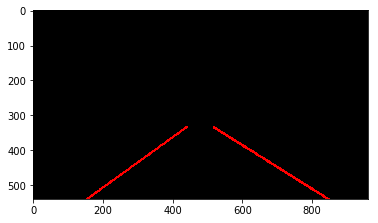

 53%|█████▎    | 364/682 [03:11<02:16,  2.32it/s]

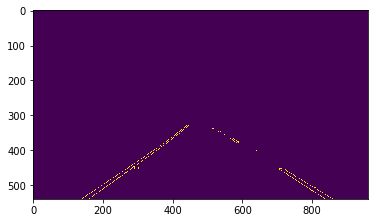

[[-0.85714286]
 [ 0.625     ]
 [-0.75      ]
 [-0.8       ]
 [-0.61538462]
 [-0.57142857]
 [-0.72789116]
 [ 0.5862069 ]
 [ 0.62295082]
 [ 0.5       ]
 [ 0.5       ]
 [ 0.57142857]
 [ 0.53846154]
 [-0.72413793]
 [-0.70588235]
 [ 0.55555556]
 [-0.63636364]
 [-0.72      ]
 [-0.73529412]
 [-0.8       ]
 [-0.72727273]
 [ 0.5       ]
 [-0.76923077]
 [ 0.6       ]
 [ 0.5625    ]
 [ 0.5       ]
 [-0.7       ]
 [-0.7       ]
 [ 0.6       ]
 [-0.73333333]]
left_m = -0.699252652377  right_m = 0.60843603918
left_c = 643.41377149  right_c = 21.8885088825
left_y = 346.930646882  right_y = 365.654871019  min y = 346.930646882
left_y = 545.518400157  right_y = 543.31819446  max y = 545.518400157


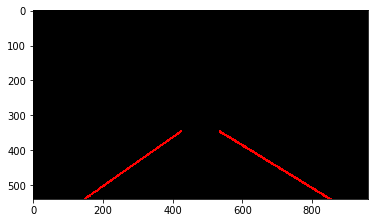

 54%|█████▎    | 365/682 [03:11<02:22,  2.23it/s]

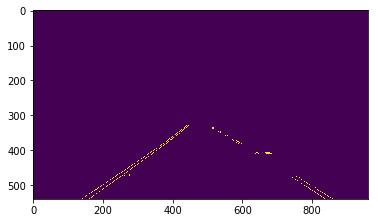

[[-0.6       ]
 [-0.70833333]
 [-0.73239437]
 [-0.70588235]
 [-0.81818182]
 [ 0.58333333]
 [-0.7027027 ]
 [-0.71875   ]
 [-0.81818182]
 [ 0.65277778]
 [ 0.64285714]
 [ 0.6097561 ]
 [-0.78571429]
 [-0.73076923]
 [-0.69565217]
 [-0.69230769]
 [-0.72727273]
 [-0.7       ]
 [-0.73333333]
 [ 0.57142857]
 [-0.8       ]
 [ 0.5       ]
 [ 0.54545455]]
left_m = -0.681771679304  right_m = 0.62486577001
left_c = 638.20432192  right_c = 8.88864951207
left_y = 340.951869744  right_y = 373.185393428  min y = 340.951869744
left_y = 542.756286818  right_y = 544.398614411  max y = 544.398614411


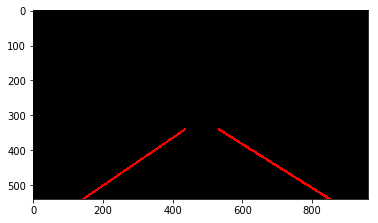

 54%|█████▎    | 366/682 [03:12<02:21,  2.23it/s]

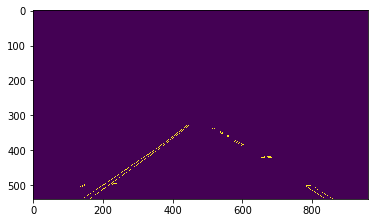

[[ 0.58333333]
 [-0.75675676]
 [-0.75      ]
 [-0.81818182]
 [-0.66      ]
 [-0.76470588]
 [-0.73333333]
 [-0.70731707]
 [-0.78571429]
 [ 0.63636364]
 [-0.78571429]
 [-0.625     ]
 [-0.66666667]
 [ 0.61111111]
 [ 0.58333333]
 [ 0.56      ]
 [-0.4       ]
 [-0.58333333]
 [ 0.66666667]
 [-0.72727273]
 [-0.76470588]
 [-0.75      ]
 [-0.5       ]
 [-0.77777778]
 [-0.7       ]
 [ 0.        ]
 [ 0.54545455]
 [ 0.        ]]
left_m = -0.653939838476  right_m = 0.612861016194
left_c = 628.597603293  right_c = 19.4695356766
left_y = 340.864074363  right_y = 371.864619988  min y = 340.864074363
left_y = 539.66178526  right_y = 538.562816393  max y = 539.66178526


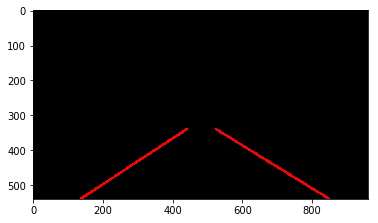

 54%|█████▍    | 367/682 [03:12<02:18,  2.27it/s]

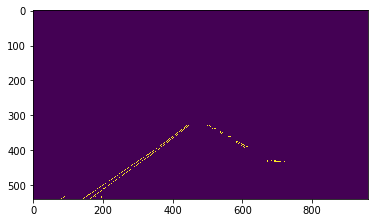

[[-0.72815534]
 [ 0.55555556]
 [-0.68141593]
 [-0.64285714]
 [-0.66666667]
 [ 0.56666667]
 [-0.66666667]
 [-0.63636364]
 [-0.76923077]
 [ 0.        ]
 [-0.72222222]
 [-0.85714286]
 [ 0.61538462]
 [-0.75      ]
 [-0.75      ]]
left_m = -0.719897503409  right_m = 0.567944250871
left_c = 650.29224565  right_c = 46.1533101045
left_y = 330.657754136  right_y = 375.56097561  min y = 330.657754136
left_y = 547.346902662  right_y = 392.599303136  max y = 547.346902662


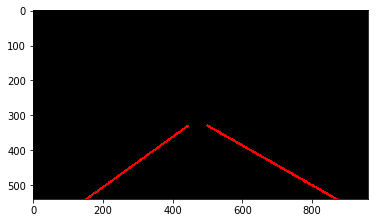

 54%|█████▍    | 368/682 [03:12<02:16,  2.29it/s]

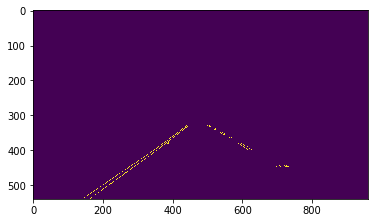

[[ 0.59259259]
 [-0.7804878 ]
 [-0.63636364]
 [-0.75609756]
 [-0.63333333]
 [-0.77777778]
 [ 0.5       ]
 [-0.81818182]
 [-0.8       ]
 [-0.58333333]
 [-0.78571429]
 [-0.625     ]
 [ 0.        ]
 [-0.84615385]
 [-0.6       ]
 [ 0.45454545]
 [-0.8       ]
 [-0.63636364]
 [-0.81818182]
 [-0.83333333]
 [ 0.5       ]
 [ 0.5       ]
 [ 0.53333333]
 [ 0.        ]]
left_m = -0.704992421743  right_m = 0.638592649019
left_c = 645.563347075  right_c = 3.16573033708
left_y = 332.546711821  right_y = 347.367168158  min y = 332.546711821
left_y = 545.454423187  right_y = 398.45458008  max y = 545.454423187


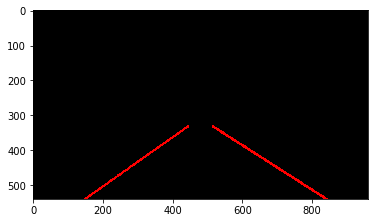

 54%|█████▍    | 369/682 [03:13<02:14,  2.33it/s]

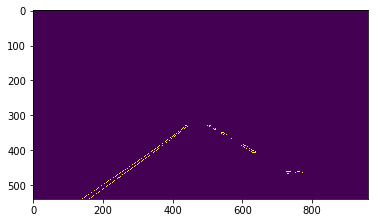

[[-0.73684211]
 [-0.78571429]
 [-0.83333333]
 [-0.63636364]
 [-0.77419355]
 [-0.73684211]
 [-0.80952381]
 [ 0.59259259]
 [-0.76923077]
 [-0.69565217]
 [-0.68421053]
 [-0.6       ]
 [ 0.        ]
 [ 0.54545455]
 [-0.92307692]
 [-0.78571429]
 [-0.63636364]
 [ 0.5       ]
 [-0.88235294]
 [-0.72727273]
 [ 0.63636364]
 [-0.76923077]
 [-0.76923077]
 [-0.77272727]
 [-0.66666667]
 [ 0.6       ]
 [-0.76923077]
 [-0.8       ]
 [-0.75      ]
 [-0.81818182]]
left_m = -0.69069749846  right_m = 0.639182980974
left_c = 640.841658966  right_c = 2.51903182805
left_y = 341.769642133  right_y = 350.234573478  min y = 341.769642133
left_y = 543.453311683  right_y = 407.761041765  max y = 543.453311683


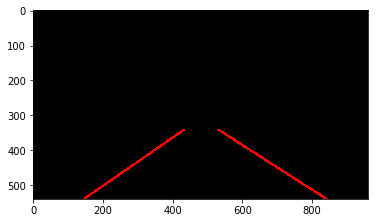

 54%|█████▍    | 370/682 [03:13<02:14,  2.32it/s]

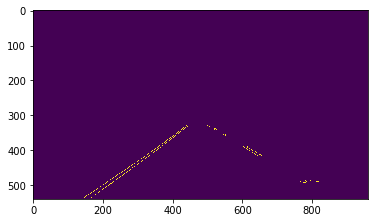

[[-0.66666667]
 [-0.84615385]
 [-0.68085106]
 [-0.6754386 ]
 [-0.67857143]
 [-0.8       ]
 [-0.78571429]
 [-0.75      ]
 [ 0.52941176]
 [-0.66666667]
 [-0.82608696]
 [-0.63636364]
 [-0.73333333]
 [-0.72413793]
 [-0.81818182]
 [ 0.6       ]
 [-0.82352941]
 [ 0.62962963]
 [-0.6       ]
 [-0.66666667]
 [-0.7       ]
 [-0.73333333]
 [-0.6       ]
 [ 0.66666667]
 [ 0.04761905]]
left_m = -0.714101476505  right_m = 0.587829130539
left_c = 649.456098817  right_c = 34.4638294487
left_y = 339.536058014  right_y = 353.067218201  min y = 339.536058014
left_y = 548.053689154  right_y = 404.796181688  max y = 548.053689154


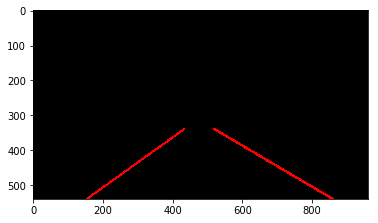

 54%|█████▍    | 371/682 [03:14<02:19,  2.22it/s]

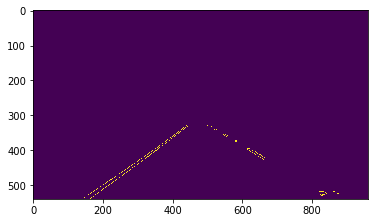

[[-0.6875    ]
 [-0.7826087 ]
 [-0.74137931]
 [-0.6       ]
 [-0.71052632]
 [ 0.6       ]
 [-0.66666667]
 [-0.6       ]
 [ 0.6       ]
 [-0.68253968]
 [-0.81818182]
 [-0.68181818]
 [ 0.5       ]
 [-0.8       ]
 [-0.6       ]
 [-0.64285714]
 [-0.78571429]
 [ 0.61538462]
 [-0.84615385]
 [-0.88888889]
 [-0.58823529]
 [-0.63636364]
 [-0.6       ]
 [ 0.63157895]
 [ 0.7       ]
 [-0.63636364]
 [-0.72727273]]
left_m = -0.701170531519  right_m = 0.562498628694
left_c = 643.947807419  right_c = 51.3550676145
left_y = 336.835114613  right_y = 357.916820253  min y = 336.835114613
left_y = 543.680421411  right_y = 524.416414346  max y = 543.680421411


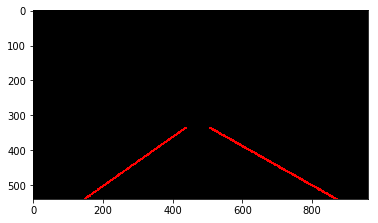

 55%|█████▍    | 372/682 [03:14<02:15,  2.28it/s]

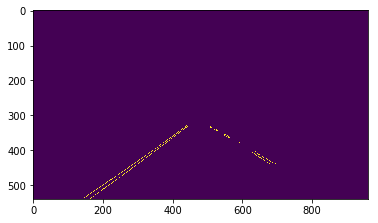

[[-0.68421053]
 [-0.63333333]
 [-0.77777778]
 [-0.71428571]
 [-0.75      ]
 [-0.8       ]
 [-0.63636364]
 [-0.77272727]
 [-0.61538462]
 [-0.9       ]
 [-0.77777778]
 [ 0.54545455]
 [ 0.53846154]
 [-0.63636364]
 [-0.8       ]
 [ 0.69230769]
 [ 0.63636364]
 [ 0.63636364]
 [-0.64705882]
 [-0.61538462]
 [-0.7       ]
 [ 0.54545455]
 [-0.625     ]
 [-0.63636364]
 [ 0.6       ]
 [-0.6       ]]
left_m = -0.713344665999  right_m = 0.600113031405
left_c = 647.492294164  right_c = 25.7017366368
left_y = 331.480607126  right_y = 353.963564815  min y = 331.480607126
left_y = 532.643802938  right_y = 437.37927618  max y = 532.643802938


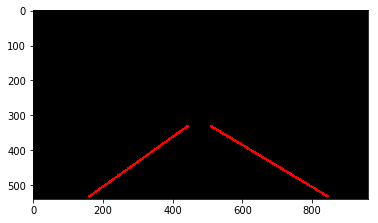

 55%|█████▍    | 373/682 [03:15<02:16,  2.26it/s]

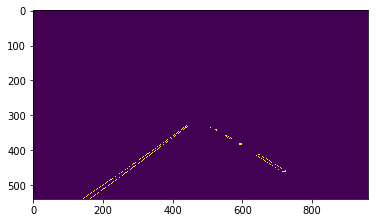

[[-0.74193548]
 [-0.67213115]
 [-0.77777778]
 [-0.9       ]
 [-0.875     ]
 [ 0.62857143]
 [-0.73170732]
 [-0.8       ]
 [-0.77777778]
 [-0.54545455]
 [-0.9       ]
 [-0.81818182]
 [ 0.5       ]
 [ 0.625     ]
 [-0.81818182]
 [-0.83333333]
 [-0.81818182]
 [-0.80769231]
 [-0.81818182]
 [-0.83333333]
 [-0.71428571]
 [-0.66666667]
 [ 0.5       ]
 [ 0.6       ]
 [ 0.53846154]
 [ 0.6       ]
 [ 0.5       ]]
left_m = -0.719000706003  right_m = 0.605059626007
left_c = 649.300191449  right_c = 24.4139805556
left_y = 330.78287869  right_y = 357.196774859  min y = 330.78287869
left_y = 547.202091197  right_y = 457.031613151  max y = 547.202091197


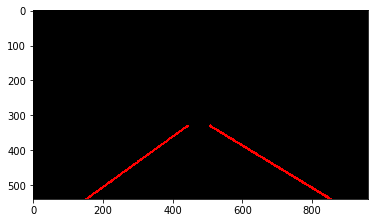

 55%|█████▍    | 374/682 [03:15<02:13,  2.31it/s]

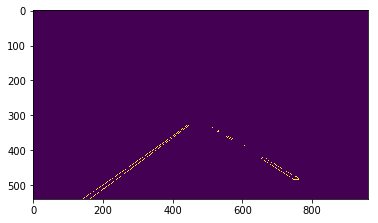

[[ 0.53333333]
 [ 0.64285714]
 [ 0.38461538]
 [-0.75438596]
 [-0.70588235]
 [-0.83333333]
 [-0.725     ]
 [-0.76190476]
 [ 0.5       ]
 [-0.65909091]
 [-0.82352941]
 [-0.75      ]
 [ 0.54166667]
 [-0.6       ]
 [-0.83333333]
 [ 0.61538462]
 [-0.64285714]
 [-0.625     ]
 [-0.8       ]
 [ 0.65217391]
 [-0.78571429]
 [-0.64285714]
 [ 0.46153846]
 [-0.8       ]
 [-0.84210526]
 [-0.81818182]
 [-0.76923077]
 [-0.76470588]
 [-0.63636364]
 [-0.78571429]
 [ 0.        ]]
left_m = -0.703565414688  right_m = 0.577790287379
left_c = 644.920481982  right_c = 43.7562592897
left_y = 332.53743786  right_y = 364.429868785  min y = 332.53743786
left_y = 544.310627681  right_y = 477.676765112  max y = 544.310627681


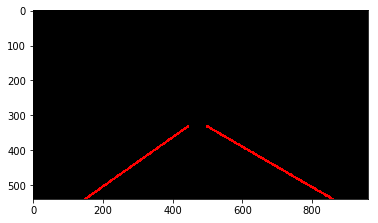

 55%|█████▍    | 375/682 [03:16<02:12,  2.31it/s]

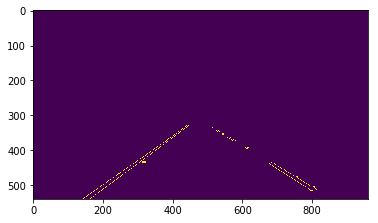

[[-0.68055556]
 [-0.77272727]
 [ 0.58974359]
 [ 0.58823529]
 [ 0.75      ]
 [-0.66666667]
 [-0.80645161]
 [ 0.6       ]
 [-0.65789474]
 [-0.75      ]
 [ 0.72222222]
 [-0.77142857]
 [-0.61538462]
 [-0.83333333]
 [ 0.5625    ]
 [-0.57142857]
 [ 0.55555556]
 [ 0.51851852]
 [-0.64705882]
 [ 0.53333333]
 [-0.83333333]
 [-0.73333333]
 [-0.81818182]
 [ 0.5625    ]
 [ 0.5625    ]
 [-0.8       ]
 [ 0.58823529]
 [ 0.57142857]
 [-0.72727273]
 [-0.8       ]]
left_m = -0.707666117661  right_m = 0.618159024596
left_c = 645.446252585  right_c = 16.9841450749
left_y = 330.534830226  right_y = 361.298721775  min y = 330.534830226
left_y = 544.24999776  right_y = 509.038728653  max y = 544.24999776


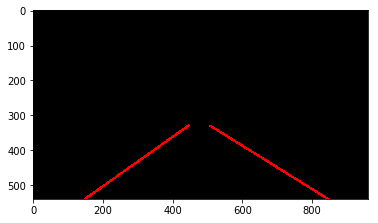

 55%|█████▌    | 376/682 [03:16<02:17,  2.23it/s]

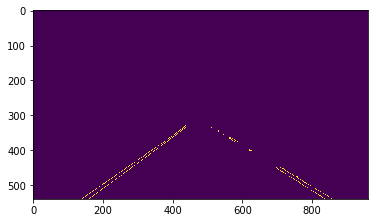

[[-0.72222222]
 [-0.73195876]
 [-0.75      ]
 [-0.63636364]
 [ 0.575     ]
 [ 0.64285714]
 [-0.75438596]
 [ 0.62264151]
 [ 0.5625    ]
 [ 0.625     ]
 [-0.81818182]
 [-0.78571429]
 [-0.84615385]
 [-0.8       ]
 [-0.78571429]
 [ 0.65957447]
 [-0.8       ]
 [-0.70588235]
 [-0.72727273]
 [ 0.53333333]
 [-0.83333333]
 [ 0.57142857]
 [-0.76923077]
 [ 0.6       ]
 [ 0.63636364]
 [ 0.5       ]
 [-0.76923077]
 [-0.8       ]
 [-0.8       ]
 [ 0.54545455]]
left_m = -0.696477414532  right_m = 0.615408861958
left_c = 640.450368524  right_c = 16.8797409505
left_y = 336.089738373  right_y = 362.739521371  min y = 336.089738373
left_y = 542.247053075  right_y = 536.900229305  max y = 542.247053075


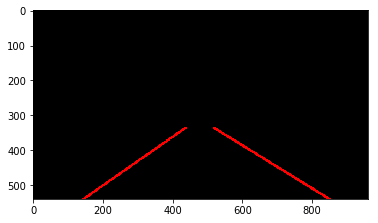

 55%|█████▌    | 377/682 [03:16<02:18,  2.20it/s]

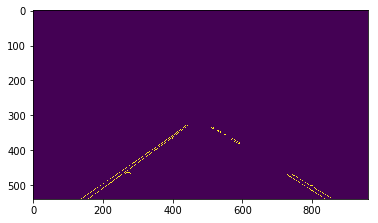

[[-0.84615385]
 [-0.69565217]
 [-0.6984127 ]
 [-0.83333333]
 [-0.71794872]
 [ 0.56756757]
 [-0.75      ]
 [-0.75609756]
 [-0.8125    ]
 [ 0.62162162]
 [-0.8125    ]
 [ 0.53846154]
 [ 0.57142857]
 [-0.76470588]
 [ 0.5       ]
 [ 0.625     ]
 [-0.82352941]
 [-0.9       ]
 [ 0.57142857]
 [ 0.52      ]
 [ 0.66666667]
 [ 0.7       ]
 [-0.75      ]]
left_m = -0.713659749198  right_m = 0.604706054641
left_c = 646.383341882  right_c = 23.3245786475
left_y = 330.232072987  right_y = 366.192911629  min y = 330.232072987
left_y = 547.184636744  right_y = 540.95296142  max y = 547.184636744


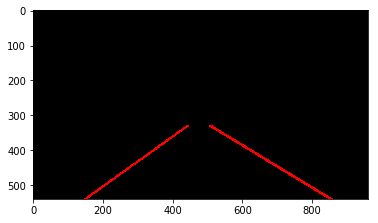

 55%|█████▌    | 378/682 [03:17<02:16,  2.23it/s]

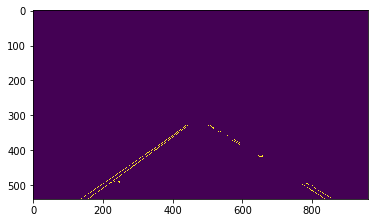

[[-0.7       ]
 [-0.77777778]
 [-0.70588235]
 [-0.75362319]
 [-0.71428571]
 [ 0.57692308]
 [-0.79310345]
 [ 0.56521739]
 [-0.84615385]
 [-0.78571429]
 [-0.64705882]
 [ 0.56      ]
 [-0.8       ]
 [-0.9       ]
 [ 0.57142857]
 [-0.75      ]
 [ 0.6       ]
 [ 0.58823529]
 [-0.83333333]
 [-0.83333333]
 [-0.72      ]
 [-0.81818182]
 [ 0.5625    ]
 [-0.7       ]
 [-0.84615385]
 [ 0.63636364]
 [-0.73913043]
 [ 0.6       ]]
left_m = -0.704287464617  right_m = 0.618745767891
left_c = 642.539773588  right_c = 15.6721036656
left_y = 330.540426763  right_y = 369.594682899  min y = 330.540426763
left_y = 545.348103471  right_y = 532.943565622  max y = 545.348103471


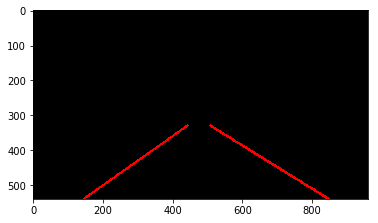

 56%|█████▌    | 379/682 [03:17<02:17,  2.20it/s]

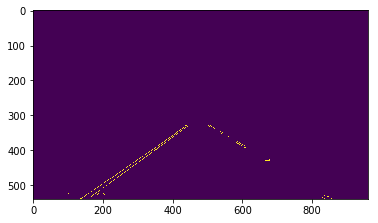

[[-0.6       ]
 [-0.73170732]
 [-0.54545455]
 [-0.75      ]
 [ 0.6       ]
 [-0.75      ]
 [ 0.53333333]
 [ 0.61904762]
 [-0.9       ]
 [-0.69444444]
 [-0.8       ]
 [-0.6875    ]
 [-0.66037736]
 [-0.6       ]
 [-0.83333333]
 [-0.8       ]
 [-0.83333333]
 [-0.8       ]
 [-0.76923077]
 [ 0.5       ]
 [ 0.        ]
 [-0.63636364]
 [ 0.5       ]]
left_m = -0.70705349366  right_m = 0.595820674023
left_c = 644.010898502  right_c = 27.9298141989
left_y = 330.079147317  right_y = 372.909984458  min y = 330.079147317
left_y = 530.882339517  right_y = 537.952311162  max y = 537.952311162


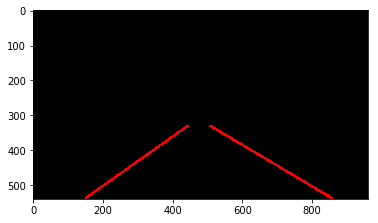

 56%|█████▌    | 380/682 [03:18<02:14,  2.25it/s]

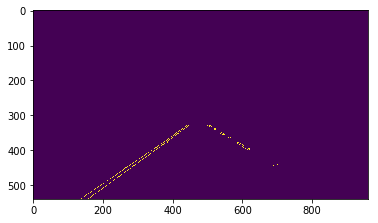

[[ 0.59375   ]
 [-0.66666667]
 [-0.72941176]
 [-0.72368421]
 [-0.77777778]
 [-0.75      ]
 [-0.8       ]
 [-0.75      ]
 [-0.83333333]
 [-0.73333333]
 [-0.72727273]
 [-0.76923077]
 [ 0.5625    ]
 [-0.76923077]
 [-0.76470588]]
left_m = -0.689557610732  right_m = 0.552430886559
left_c = 634.97155869  right_c = 55.4103908484
left_y = 328.118421914  right_y = 378.030028599  min y = 328.118421914
left_y = 517.057207255  right_y = 398.469971401  max y = 517.057207255


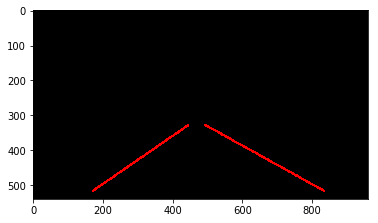

 56%|█████▌    | 381/682 [03:18<02:10,  2.30it/s]

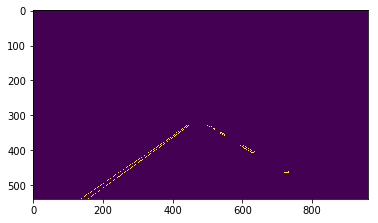

[[-0.72772277]
 [-0.77777778]
 [-0.85714286]
 [ 0.59459459]
 [-0.73913043]
 [-0.76923077]
 [ 0.58823529]
 [ 0.54545455]
 [-0.8       ]
 [-0.72222222]
 [-0.85714286]
 [-0.7173913 ]
 [-0.72727273]
 [-0.76470588]
 [-0.76923077]
 [ 0.625     ]
 [-0.73333333]]
left_m = -0.701949571173  right_m = 0.575116793705
left_c = 640.19887027  right_c = 41.347184657
left_y = 327.129361527  right_y = 381.241209737  min y = 327.129361527
left_y = 543.329829448  right_y = 405.971231866  max y = 543.329829448


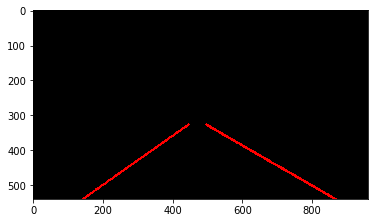

 56%|█████▌    | 382/682 [03:19<02:23,  2.08it/s]

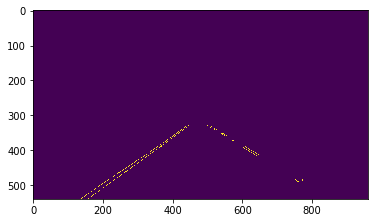

[[-0.78947368]
 [-0.675     ]
 [-0.72727273]
 [-0.58333333]
 [-0.57142857]
 [ 0.59259259]
 [-0.64705882]
 [-0.64705882]
 [-0.68421053]
 [-0.83333333]
 [ 0.55882353]
 [-0.76190476]
 [-0.71875   ]
 [ 0.53846154]
 [ 0.45454545]
 [-0.6       ]
 [-0.58333333]
 [-0.67857143]
 [-0.65384615]
 [-0.6       ]
 [-0.6       ]
 [-0.57142857]
 [-0.61538462]
 [-0.6875    ]
 [-0.6       ]
 [-0.69230769]]
left_m = -0.693751960094  right_m = 0.565691837625
left_c = 640.112513966  right_c = 50.5910082933
left_y = 334.167899565  right_y = 389.440419031  min y = 334.167899565
left_y = 534.662216032  right_y = 413.199476211  max y = 534.662216032


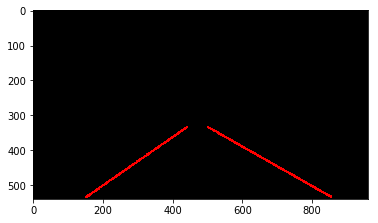

 56%|█████▌    | 383/682 [03:19<02:16,  2.18it/s]

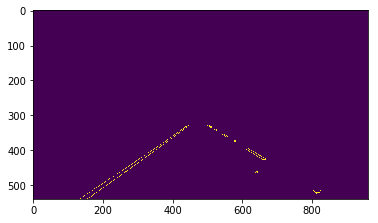

[[-0.64705882]
 [ 0.5       ]
 [ 0.5       ]
 [-0.65714286]
 [-0.61538462]
 [-0.9       ]
 [-0.61111111]
 [-0.76923077]
 [ 0.5       ]
 [-0.75      ]
 [ 0.58333333]
 [-0.8       ]
 [-0.58333333]
 [-0.73170732]
 [-0.62162162]
 [-0.84615385]
 [-0.8       ]
 [-0.76470588]
 [ 0.56521739]
 [-0.84615385]
 [-0.75      ]
 [-0.6       ]
 [-0.58823529]
 [ 0.52941176]
 [ 0.45454545]
 [-0.6       ]
 [ 0.5       ]
 [-0.83333333]
 [-0.63636364]]
left_m = -0.697359018558  right_m = 0.597661062756
left_c = 640.507202523  right_c = 31.7308433687
left_y = 332.971875339  right_y = 356.260800445  min y = 332.971875339
left_y = 547.061094037  right_y = 427.382466913  max y = 547.061094037


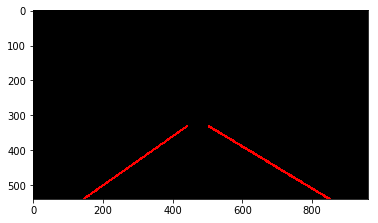

 56%|█████▋    | 384/682 [03:20<02:15,  2.21it/s]

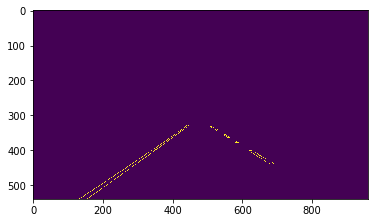

[[-0.67883212]
 [-0.78947368]
 [-0.69230769]
 [-0.6       ]
 [-0.80952381]
 [-0.81818182]
 [-0.58333333]
 [ 0.5       ]
 [-0.77777778]
 [-0.61290323]
 [-0.6       ]
 [ 0.5       ]
 [-0.6       ]
 [-0.73333333]
 [-0.61290323]
 [ 0.5       ]
 [-0.68181818]
 [ 0.61538462]
 [-0.63636364]
 [-0.54545455]
 [ 0.5       ]
 [ 0.6       ]
 [ 0.45454545]
 [-0.6       ]
 [-0.7       ]
 [ 0.5       ]
 [ 0.5       ]
 [-0.6       ]
 [-0.6       ]
 [-0.69230769]
 [-0.6       ]]
left_m = -0.681712562953  right_m = 0.591466911343
left_c = 637.079303465  right_c = 32.8255820622
left_y = 345.306326521  right_y = 355.766515655  min y = 345.306326521
left_y = 542.321257214  right_y = 435.614548687  max y = 542.321257214


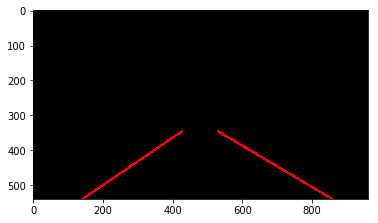

 56%|█████▋    | 385/682 [03:20<02:12,  2.24it/s]

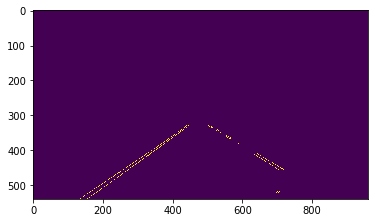

[[-0.7       ]
 [-0.67647059]
 [-0.65      ]
 [-0.69444444]
 [-0.75      ]
 [-0.68181818]
 [-0.76923077]
 [-0.77419355]
 [ 0.6       ]
 [-0.75      ]
 [-0.8       ]
 [-0.63636364]
 [-0.64705882]
 [-0.58333333]
 [ 0.57575758]
 [-0.625     ]
 [-0.6       ]
 [-0.54545455]
 [ 0.625     ]
 [-0.75      ]
 [ 0.54545455]
 [ 0.5       ]
 [ 0.60416667]
 [ 0.6       ]
 [-0.76190476]
 [ 0.6       ]
 [-0.73913043]
 [ 0.5       ]
 [-0.72727273]
 [-0.8       ]
 [-0.7       ]
 [-0.63157895]
 [-0.73333333]]
left_m = -0.682393373225  right_m = 0.602442281346
left_c = 635.820814959  right_c = 26.575187509
left_y = 332.155763873  right_y = 328.398770463  min y = 328.398770463
left_y = 543.697709573  right_y = 458.526303234  max y = 543.697709573


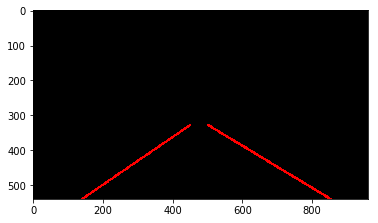

 57%|█████▋    | 386/682 [03:21<02:11,  2.25it/s]

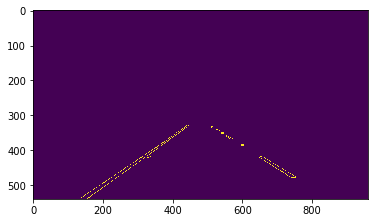

[[-0.78947368]
 [-0.70786517]
 [-0.75      ]
 [-0.81818182]
 [-0.7       ]
 [ 0.6       ]
 [-0.7826087 ]
 [-0.65957447]
 [-0.7       ]
 [ 0.625     ]
 [ 0.5625    ]
 [-0.65116279]
 [-0.63333333]
 [-0.57142857]
 [-0.67857143]
 [ 0.6       ]
 [-0.6875    ]
 [-0.8125    ]
 [-0.61111111]
 [ 0.6       ]
 [-0.81818182]
 [-0.72727273]
 [-0.58333333]
 [-0.625     ]
 [-0.72727273]]
left_m = -0.693675911153  right_m = 0.620557200093
left_c = 638.282960531  right_c = 15.4082336608
left_y = 330.29085598  right_y = 358.576365312  min y = 330.29085598
left_y = 540.474657059  right_y = 473.37944733  max y = 540.474657059


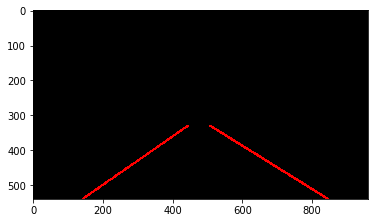

 57%|█████▋    | 387/682 [03:21<02:17,  2.15it/s]

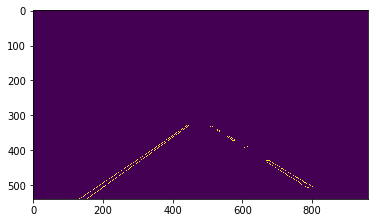

[[-0.66666667]
 [ 0.625     ]
 [-0.75      ]
 [-0.75      ]
 [-0.75      ]
 [-0.72727273]
 [-0.61538462]
 [-0.75      ]
 [-0.70212766]
 [ 0.64102564]
 [-0.63636364]
 [-0.72727273]
 [-0.72727273]
 [-0.57142857]
 [ 0.69230769]
 [-0.66666667]
 [-0.6       ]
 [ 0.61538462]
 [-0.78571429]
 [ 0.54545455]
 [ 0.53846154]
 [-0.625     ]
 [-0.6       ]
 [-0.81818182]
 [-0.77777778]
 [-0.5625    ]
 [ 0.53846154]
 [-0.73333333]
 [ 0.57692308]
 [-0.81818182]
 [ 0.54545455]
 [ 0.57142857]
 [ 0.58333333]
 [-0.81818182]
 [ 0.72727273]
 [-0.7       ]
 [ 0.63636364]]
left_m = -0.681634945012  right_m = 0.616309686512
left_c = 634.608526663  right_c = 16.8563530366
left_y = 331.280976132  right_y = 360.140848424  min y = 331.280976132
left_y = 543.269444031  right_y = 501.275766635  max y = 543.269444031


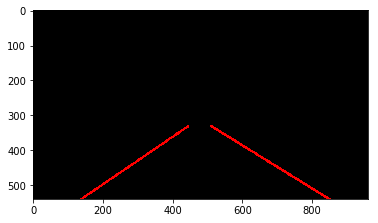

 57%|█████▋    | 388/682 [03:21<02:13,  2.20it/s]

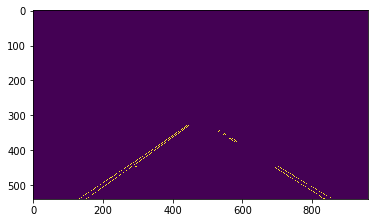

[[-0.65432099]
 [-0.75      ]
 [-0.8125    ]
 [ 0.4375    ]
 [ 0.62765957]
 [-0.65      ]
 [-0.73015873]
 [-0.78571429]
 [ 0.5       ]
 [-0.65217391]
 [ 0.5       ]
 [-0.72222222]
 [ 0.66666667]
 [-0.78947368]
 [ 0.52941176]
 [ 0.55555556]
 [-0.78947368]
 [-0.64285714]
 [-0.8       ]
 [ 0.69230769]
 [ 0.61111111]
 [-0.8       ]
 [-0.76923077]
 [-0.8       ]
 [-0.6       ]
 [-0.61111111]
 [ 0.46153846]
 [-0.53846154]
 [ 0.46666667]
 [ 0.53333333]
 [-0.8       ]
 [-0.6       ]
 [ 0.6       ]
 [ 0.54545455]]
left_m = -0.684046090369  right_m = 0.589736899614
left_c = 634.954234271  right_c = 36.9467984928
left_y = 330.553724057  right_y = 367.789199176  min y = 330.553724057
left_y = 543.976104252  right_y = 533.505267968  max y = 543.976104252


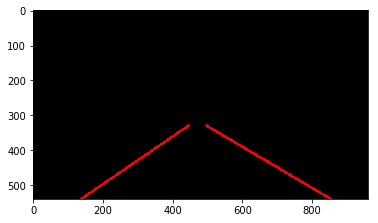

 57%|█████▋    | 389/682 [03:22<02:15,  2.16it/s]

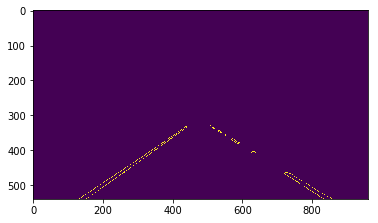

[[-0.72463768]
 [-0.68656716]
 [-0.75      ]
 [ 0.625     ]
 [-0.72727273]
 [ 0.675     ]
 [ 0.        ]
 [-0.63414634]
 [-0.6       ]
 [ 0.60869565]
 [-0.6875    ]
 [-0.7037037 ]
 [ 0.6       ]
 [ 0.57692308]
 [ 0.5483871 ]
 [ 0.57894737]
 [-0.6       ]
 [-0.68965517]
 [-0.61538462]
 [-0.61538462]
 [-0.81818182]
 [-0.6       ]
 [-0.68421053]
 [ 0.66666667]
 [-0.78571429]
 [-0.8       ]
 [-0.58333333]
 [ 0.58333333]
 [-0.6       ]
 [ 0.61538462]
 [ 0.6       ]]
left_m = -0.677366178867  right_m = 0.622309332131
left_c = 632.636148003  right_c = 13.8735894865
left_y = 333.240296944  right_y = 367.345290137  min y = 333.240296944
left_y = 539.15961532  right_y = 540.969593801  max y = 540.969593801


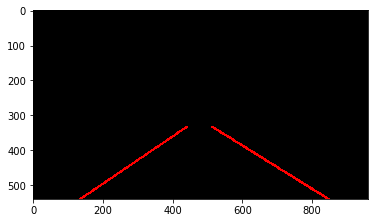

 57%|█████▋    | 390/682 [03:23<02:29,  1.96it/s]

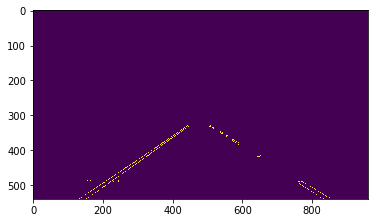

[[-0.78571429]
 [-0.7       ]
 [-0.6       ]
 [ 0.6       ]
 [ 0.60606061]
 [ 0.45454545]
 [-0.57142857]
 [ 0.64285714]
 [-0.65454545]
 [-0.68965517]
 [-0.63636364]
 [-0.7       ]
 [-0.65625   ]
 [-0.6       ]
 [-0.58333333]
 [-0.58333333]
 [-0.58333333]
 [-0.07692308]
 [-0.6       ]
 [-0.66666667]]
left_m = -0.678074190099  right_m = 0.589812165692
left_c = 632.033469845  right_c = 38.7570593357
left_y = 334.358900392  right_y = 485.83468093  min y = 334.358900392
left_y = 537.781157422  right_y = 537.148339346  max y = 537.781157422


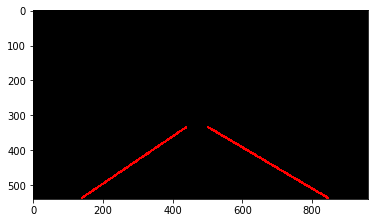

 57%|█████▋    | 391/682 [03:23<02:50,  1.70it/s]

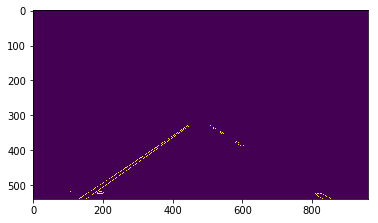

[[-0.70967742]
 [-0.8       ]
 [-0.8       ]
 [-0.625     ]
 [-0.77272727]
 [-0.66666667]
 [-0.69736842]
 [-0.68571429]
 [ 0.        ]
 [-0.75      ]
 [ 0.63636364]
 [-0.70833333]
 [ 0.64      ]
 [-0.75      ]
 [ 0.6       ]
 [ 0.58823529]
 [-0.68518519]
 [ 0.62962963]
 [-0.81818182]
 [-0.6       ]
 [-0.6       ]
 [-0.61538462]
 [-0.72222222]
 [-0.66666667]
 [-0.58333333]
 [-0.6       ]
 [ 0.64285714]
 [ 0.63636364]
 [-0.8       ]
 [-0.7       ]]
left_m = -0.688154826595  right_m = 0.611400414099
left_c = 637.289371187  right_c = 22.0197301254
left_y = 334.501247485  right_y = 348.507551254  min y = 334.501247485
left_y = 532.001682718  right_y = 542.932882937  max y = 542.932882937


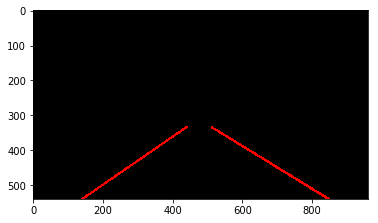

 57%|█████▋    | 392/682 [03:24<02:50,  1.70it/s]

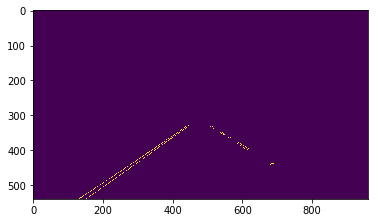

[[-0.72340426]
 [-0.8       ]
 [-0.76923077]
 [-0.77777778]
 [-0.75      ]
 [-0.62068966]
 [-0.75      ]
 [ 0.6       ]
 [ 0.58333333]
 [-0.78571429]
 [-0.8       ]
 [-0.75      ]
 [-0.76923077]
 [-0.78571429]
 [-0.66666667]
 [-0.66666667]
 [-0.61538462]
 [-0.6       ]
 [-0.08333333]
 [-0.8       ]
 [-0.61111111]
 [ 0.5       ]
 [-0.63636364]
 [-0.81818182]
 [ 0.58333333]]
left_m = -0.68212064191  right_m = 0.636856858667
left_c = 633.546264184  right_c = 4.71109503572
left_y = 330.684699176  right_y = 347.976941857  min y = 330.684699176
left_y = 543.506339452  right_y = 395.104349399  max y = 543.506339452


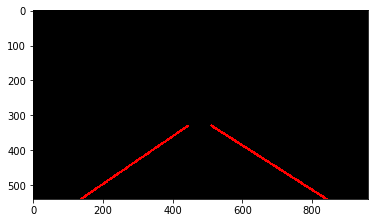

 58%|█████▊    | 393/682 [03:25<02:51,  1.68it/s]

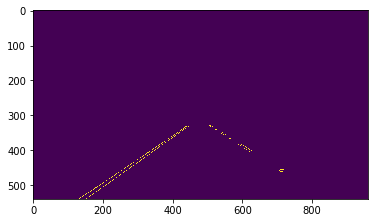

[[-0.72173913]
 [-0.7       ]
 [-0.72222222]
 [-0.58823529]
 [-0.67272727]
 [-0.8       ]
 [-0.71428571]
 [ 0.6       ]
 [-0.7826087 ]
 [-0.83333333]
 [ 0.57142857]
 [-0.76470588]
 [-0.69565217]
 [ 0.5625    ]
 [ 0.53846154]
 [-0.6       ]
 [-0.8       ]
 [-0.68      ]
 [ 0.53846154]]
left_m = -0.6976909663  right_m = 0.614676578463
left_c = 639.335480632  right_c = 18.7665153666
left_y = 331.653764493  right_y = 350.691867737  min y = 331.653764493
left_y = 533.286453754  right_y = 404.783406641  max y = 533.286453754


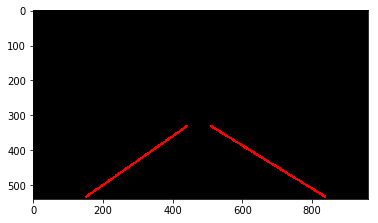

 58%|█████▊    | 394/682 [03:25<02:39,  1.80it/s]

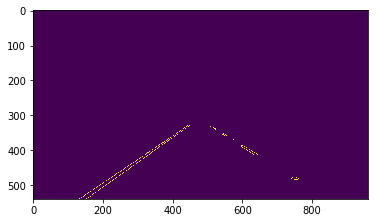

[[-0.75      ]
 [-0.81818182]
 [-0.66666667]
 [-0.75      ]
 [-0.625     ]
 [-0.8125    ]
 [-0.63636364]
 [ 0.66666667]
 [-0.75      ]
 [-0.57142857]
 [-0.68965517]
 [-0.58333333]
 [ 0.57894737]
 [ 0.58333333]
 [-0.72727273]
 [ 0.53333333]
 [-0.64285714]
 [-0.61904762]
 [-0.63157895]
 [-0.61538462]
 [ 0.5       ]
 [-0.8       ]
 [ 0.64285714]
 [-0.68421053]
 [-0.58333333]
 [-0.75      ]
 [-0.58333333]
 [-0.63636364]]
left_m = -0.689472004753  right_m = 0.613938434812
left_c = 636.354801307  right_c = 19.9467720121
left_y = 332.297647211  right_y = 328.757804722  min y = 328.757804722
left_y = 544.655024675  right_y = 409.797678117  max y = 544.655024675


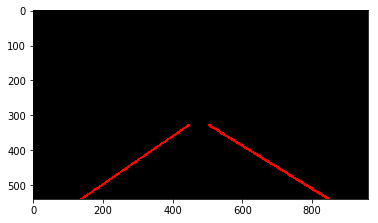

 58%|█████▊    | 395/682 [03:25<02:33,  1.87it/s]

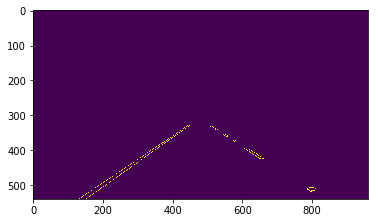

[[-0.67346939]
 [-0.8       ]
 [-0.72058824]
 [-0.77777778]
 [-0.77777778]
 [-0.81818182]
 [ 0.57142857]
 [-0.6       ]
 [-0.75      ]
 [ 0.69230769]
 [-0.72222222]
 [-0.75      ]
 [-0.83333333]
 [-0.75862069]
 [-0.63636364]
 [-0.8       ]
 [ 0.66666667]
 [-0.75      ]
 [-0.8       ]
 [-0.66666667]
 [-0.63157895]
 [-0.81818182]]
left_m = -0.702651356268  right_m = 0.521618080576
left_c = 641.794206995  right_c = 80.2869308877
left_y = 329.817004812  right_y = 395.865869636  min y = 329.817004812
left_y = 548.341576612  right_y = 424.033245988  max y = 548.341576612


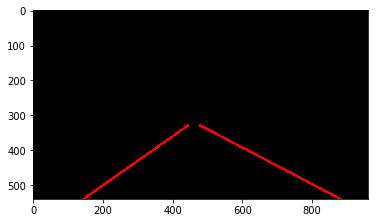

 58%|█████▊    | 396/682 [03:26<02:24,  1.98it/s]

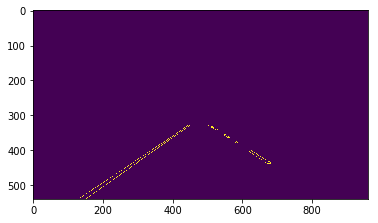

[[-0.67479675]
 [-0.70588235]
 [-0.72727273]
 [ 0.5       ]
 [-0.70731707]
 [-0.6       ]
 [-0.85714286]
 [-0.76470588]
 [-0.77777778]
 [-0.58823529]
 [-0.6       ]
 [-0.75862069]
 [-0.625     ]
 [ 0.64705882]
 [-0.61111111]
 [-0.8       ]
 [ 0.54545455]
 [-0.7       ]
 [ 0.4375    ]
 [-0.57142857]
 [-0.6       ]
 [-0.58333333]
 [-0.54545455]
 [-0.81818182]
 [-0.76923077]
 [-0.81818182]
 [-0.57142857]
 [-0.7       ]]
left_m = -0.690527265401  right_m = 0.715144359772
left_c = 637.098278775  right_c = -44.9337769668
left_y = 328.43259114  right_y = 399.886014812  min y = 328.43259114
left_y = 545.948679742  right_y = 434.92808844  max y = 545.948679742


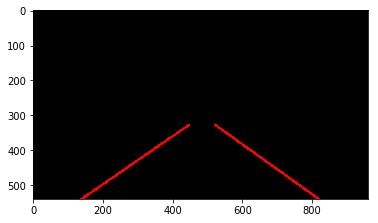

 58%|█████▊    | 397/682 [03:26<02:19,  2.04it/s]

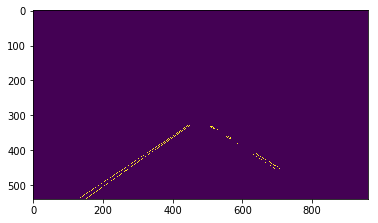

[[-0.67010309]
 [-0.6       ]
 [-0.66666667]
 [-0.75      ]
 [-0.71428571]
 [-0.7826087 ]
 [-0.7826087 ]
 [-0.64285714]
 [-0.76190476]
 [ 0.6       ]
 [-0.61904762]
 [-0.66666667]
 [-0.66666667]
 [ 0.53846154]
 [-0.5625    ]
 [ 0.61538462]
 [ 0.5       ]
 [ 0.58333333]
 [ 0.68      ]
 [-0.72727273]
 [-0.65217391]
 [ 0.53846154]
 [-0.81818182]
 [-0.73333333]]
left_m = -0.6959258056  right_m = 0.618345597881
left_c = 640.357588927  right_c = 18.8133394136
left_y = 340.413566713  right_y = 330.459520746  min y = 330.459520746
left_y = 549.191308393  right_y = 449.181875539  max y = 549.191308393


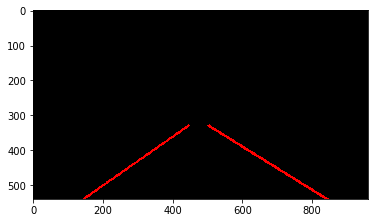

 58%|█████▊    | 398/682 [03:27<02:19,  2.03it/s]

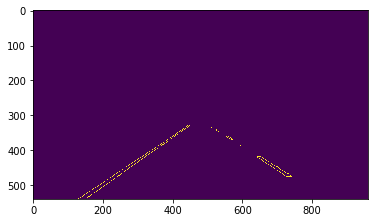

[[-0.67123288]
 [ 0.61538462]
 [-0.725     ]
 [-0.73076923]
 [-0.77777778]
 [ 0.66666667]
 [-0.75      ]
 [ 0.61904762]
 [-0.75      ]
 [ 0.46153846]
 [-0.5625    ]
 [-0.58333333]
 [-0.59090909]
 [ 0.6744186 ]
 [-0.75      ]
 [ 0.67213115]
 [-0.5625    ]
 [-0.69230769]
 [-0.73684211]
 [ 0.5625    ]
 [-0.76470588]
 [-0.7       ]
 [-0.57142857]
 [-0.69565217]
 [-0.66666667]]
left_m = -0.692675733719  right_m = 0.632456578238
left_c = 637.847264695  right_c = 9.97741767995
left_y = 327.528535989  right_y = 360.358362024  min y = 327.528535989
left_y = 543.64336491  right_y = 471.038263215  max y = 543.64336491


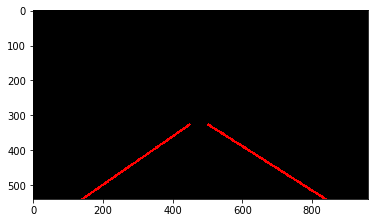

 59%|█████▊    | 399/682 [03:27<02:18,  2.04it/s]

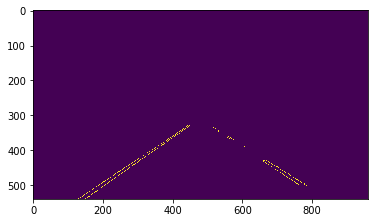

[[ 0.62162162]
 [-0.71428571]
 [-0.6       ]
 [ 0.69230769]
 [-0.66666667]
 [ 0.60606061]
 [-0.61538462]
 [-0.66666667]
 [-0.77777778]
 [-0.67692308]
 [-0.7037037 ]
 [ 0.67647059]
 [-0.77272727]
 [-0.76470588]
 [-0.73333333]
 [-0.81818182]
 [ 0.69565217]
 [ 0.5625    ]
 [ 0.6875    ]
 [ 0.66666667]
 [ 0.7       ]
 [-0.70588235]
 [-0.6       ]
 [-0.57142857]
 [ 0.58333333]
 [ 0.54545455]
 [-0.58333333]
 [-0.69230769]
 [-0.69230769]
 [-0.58333333]
 [-0.6       ]
 [-0.76470588]
 [-0.58333333]
 [-0.54545455]
 [-0.73333333]
 [-0.70967742]
 [ 0.58333333]]
left_m = -0.677564539639  right_m = 0.641468065851
left_c = 633.462936953  right_c = 4.2494352626
left_y = 333.979410432  right_y = 361.547147941  min y = 333.979410432
left_y = 545.3795468  right_y = 499.462782099  max y = 545.3795468


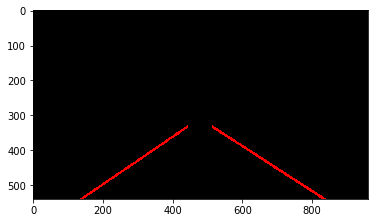

 59%|█████▊    | 400/682 [03:28<02:17,  2.05it/s]

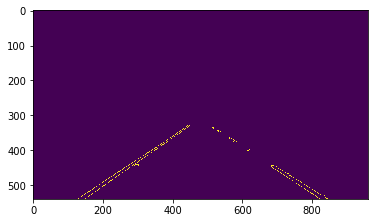

[[-0.76190476]
 [ 0.64893617]
 [ 0.61111111]
 [ 0.55555556]
 [-0.6875    ]
 [-0.68518519]
 [ 0.65333333]
 [-0.63636364]
 [-0.62068966]
 [-0.6       ]
 [-0.78571429]
 [-0.76470588]
 [-0.75      ]
 [ 0.5625    ]
 [-0.76923077]
 [-0.75      ]
 [-0.71428571]
 [ 0.53333333]
 [-0.73684211]
 [-0.8       ]
 [-0.78947368]
 [ 0.53846154]
 [-0.78571429]
 [-0.6       ]
 [ 0.58064516]
 [-0.61538462]
 [-0.6875    ]
 [-0.58333333]
 [-0.6       ]
 [-0.6       ]
 [-0.66666667]
 [-0.8       ]
 [ 0.6       ]]
left_m = -0.67331472683  right_m = 0.630238315537
left_c = 630.92637517  right_c = 10.365498012
left_y = 329.28137755  right_y = 366.45014629  min y = 329.28137755
left_y = 544.068775409  right_y = 531.572584961  max y = 544.068775409


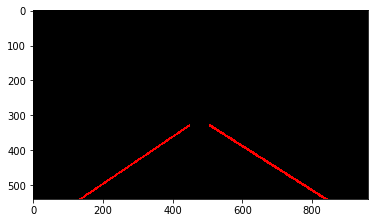

 59%|█████▉    | 401/682 [03:28<02:16,  2.06it/s]

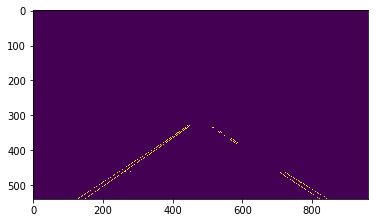

[[ 0.66666667]
 [-0.70689655]
 [-0.65217391]
 [-0.65714286]
 [ 0.58823529]
 [-0.81818182]
 [-0.76923077]
 [ 0.6744186 ]
 [-0.68055556]
 [-0.65      ]
 [ 0.56521739]
 [-0.65      ]
 [ 0.66666667]
 [-0.71428571]
 [-0.65517241]
 [-0.77272727]
 [-0.78571429]
 [-0.64285714]
 [-0.77777778]
 [ 0.58333333]
 [-0.76190476]
 [-0.76923077]
 [ 0.58333333]
 [ 0.6       ]
 [-0.63157895]
 [-0.8       ]
 [ 0.54545455]]
left_m = -0.668682461884  right_m = 0.631423964448
left_c = 630.731472089  right_c = 10.6331920807
left_y = 330.493046703  right_y = 368.019155958  min y = 330.493046703
left_y = 539.790657273  right_y = 532.820810679  max y = 539.790657273


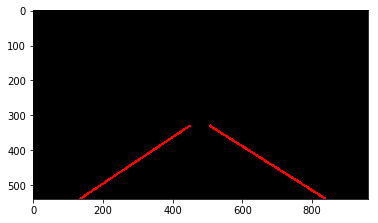

 59%|█████▉    | 402/682 [03:29<02:05,  2.23it/s]

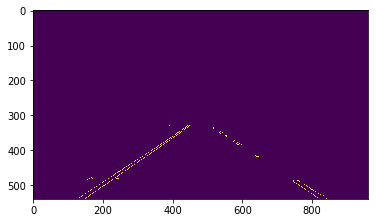

[[-0.78571429]
 [-0.71428571]
 [-0.81818182]
 [-0.78571429]
 [ 0.625     ]
 [-0.6744186 ]
 [-0.8       ]
 [ 0.57894737]
 [-0.66197183]
 [-0.78571429]
 [ 0.41666667]
 [-0.73684211]
 [-0.76190476]
 [-0.8       ]
 [-0.6       ]
 [-0.72727273]
 [ 0.        ]
 [-0.75      ]
 [ 0.67567568]
 [ 0.63636364]
 [-0.57142857]
 [-0.81818182]
 [-0.65      ]
 [ 0.66666667]
 [-0.5       ]
 [-0.46666667]
 [ 0.53846154]
 [-0.76923077]
 [-0.81818182]
 [-0.6875    ]
 [-0.76470588]
 [-0.81818182]
 [ 0.69230769]
 [ 0.71428571]
 [ 0.        ]
 [-0.8       ]]
left_m = -0.659430515984  right_m = 0.64736914341
left_c = 626.941291778  right_c = 2.03468761005
left_y = 338.110725777  right_y = 372.977206784  min y = 338.110725777
left_y = 539.896463668  right_y = 532.877385206  max y = 539.896463668


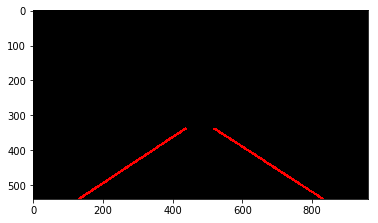

 59%|█████▉    | 403/682 [03:29<01:59,  2.34it/s]

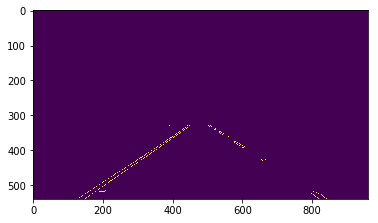

[[-0.56521739]
 [-0.69512195]
 [-0.69736842]
 [-0.5625    ]
 [-0.72727273]
 [-0.68421053]
 [-0.6       ]
 [-0.57142857]
 [-0.61111111]
 [-0.6       ]
 [ 0.6       ]
 [ 0.61111111]
 [-0.75      ]
 [-0.7037037 ]
 [-0.75      ]
 [ 0.59259259]
 [-0.61764706]
 [ 0.63636364]
 [-0.81818182]
 [-0.76923077]
 [-0.6875    ]
 [-0.6       ]
 [-0.7       ]]
left_m = -0.655553692287  right_m = 0.683063773349
left_c = 625.227525905  right_c = -20.4053678665
left_y = 330.883918068  right_y = 374.405493129  min y = 330.883918068
left_y = 541.316653292  right_y = 532.193224773  max y = 541.316653292


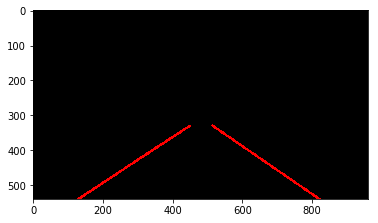

 59%|█████▉    | 404/682 [03:30<02:01,  2.29it/s]

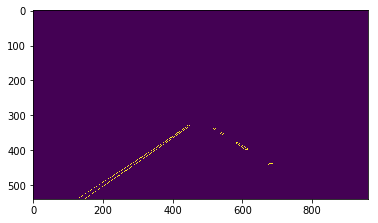

[[-0.76923077]
 [-0.63291139]
 [-0.72222222]
 [-0.62068966]
 [-0.69642857]
 [-0.83333333]
 [-0.76470588]
 [-0.61538462]
 [ 0.6       ]
 [-0.5625    ]
 [-0.70588235]
 [ 0.66666667]
 [-0.81818182]
 [ 0.66666667]
 [-0.66666667]
 [-0.75      ]
 [-0.81818182]
 [-0.625     ]
 [-0.5625    ]
 [-0.8       ]]
left_m = -0.663925828655  right_m = 0.679757994814
left_c = 629.520506662  right_c = -18.0526879862
left_y = 335.401364568  right_y = 347.657113224  min y = 335.401364568
left_y = 544.538000594  right_y = 397.95920484  max y = 544.538000594


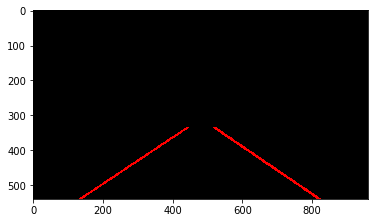

 59%|█████▉    | 405/682 [03:30<01:56,  2.39it/s]

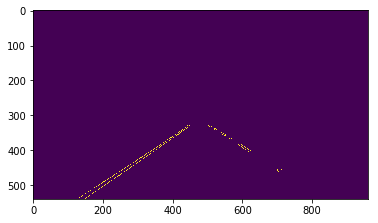

[[-0.652     ]
 [-0.68888889]
 [-0.8       ]
 [-0.68571429]
 [-0.57142857]
 [-0.64285714]
 [-0.60869565]
 [-0.66666667]
 [ 0.73333333]
 [-0.64      ]
 [-0.81818182]
 [-0.65909091]
 [-0.8       ]
 [ 0.61764706]
 [-0.6       ]
 [ 0.5       ]
 [-0.64705882]
 [ 0.6       ]]
left_m = -0.691615789305  right_m = 0.657988569479
left_c = 640.348602391  right_c = -5.76768745202
left_y = 341.570581411  right_y = 348.888151497  min y = 341.570581411
left_y = 551.82178136  right_y = 406.133157042  max y = 551.82178136


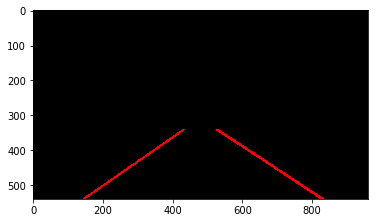

 60%|█████▉    | 406/682 [03:30<01:50,  2.50it/s]

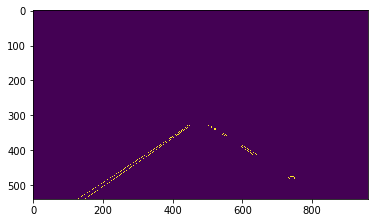

[[-0.5       ]
 [-0.72727273]
 [-0.76923077]
 [-0.65789474]
 [-0.69230769]
 [-0.64285714]
 [-0.5625    ]
 [-0.8       ]
 [-0.61538462]
 [-0.71875   ]
 [ 0.6       ]
 [-0.54545455]
 [-0.75      ]
 [ 0.65625   ]
 [-0.71875   ]
 [-0.6       ]
 [-0.9       ]
 [-0.61538462]
 [-0.63636364]
 [ 0.58333333]
 [-0.63636364]
 [-0.8       ]
 [-0.73333333]
 [-0.75      ]
 [-0.76923077]
 [ 0.58333333]
 [-0.8       ]
 [ 0.54545455]
 [-0.7       ]
 [-0.81818182]
 [-0.78571429]
 [ 0.64285714]]
left_m = -0.665091115174  right_m = 0.664214457945
left_c = 629.492275648  right_c = -9.13140749846
left_y = 330.866364934  right_y = 351.537043166  min y = 330.866364934
left_y = 543.030430675  right_y = 415.965845586  max y = 543.030430675


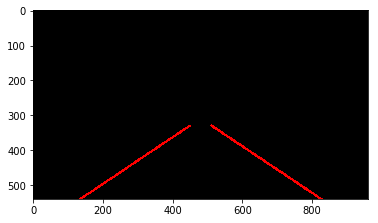

 60%|█████▉    | 407/682 [03:31<01:47,  2.56it/s]

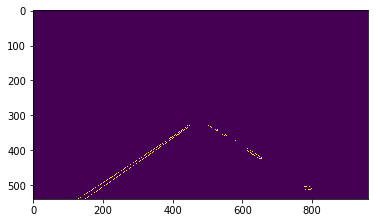

[[-0.63157895]
 [-0.65128205]
 [-0.75      ]
 [-0.67857143]
 [ 0.59090909]
 [-0.68181818]
 [-0.83333333]
 [-0.76923077]
 [-0.78571429]
 [-0.66666667]
 [ 0.625     ]
 [-0.68      ]
 [ 0.66666667]
 [-0.66666667]
 [-0.64705882]
 [-0.7       ]
 [-0.73333333]]
left_m = -0.683641658319  right_m = 0.584535315985
left_c = 637.405159002  right_c = 38.7604460967
left_y = 340.704679291  right_y = 392.404312268  min y = 340.704679291
left_y = 548.53174342  right_y = 416.370260223  max y = 548.53174342


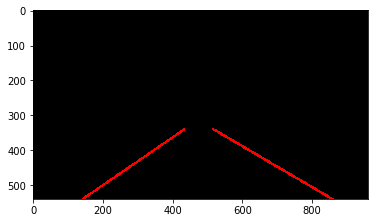

 60%|█████▉    | 408/682 [03:31<01:44,  2.61it/s]

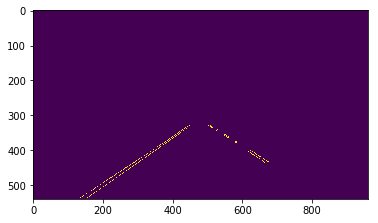

[[-0.71875   ]
 [-0.61290323]
 [-0.78571429]
 [-0.75      ]
 [-0.71428571]
 [-0.71794872]
 [-0.57894737]
 [-0.83333333]
 [ 0.61538462]
 [ 0.67857143]
 [-0.81818182]
 [ 0.6       ]
 [-0.83333333]
 [ 0.73684211]
 [-0.61111111]
 [-0.5625    ]
 [-0.75      ]
 [-0.8       ]
 [-0.81818182]
 [-0.63265306]
 [-0.78571429]
 [-0.75      ]
 [-0.53846154]
 [-0.81818182]
 [ 0.63636364]
 [ 0.54545455]
 [ 0.63636364]]
left_m = -0.676987048402  right_m = 0.638239044574
left_c = 633.99196694  right_c = 6.90674342426
left_y = 332.055743353  right_y = 327.3027438  min y = 327.3027438
left_y = 545.3066636  right_y = 438.356337556  max y = 545.3066636


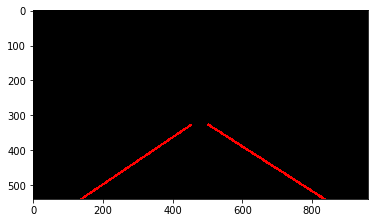

 60%|█████▉    | 409/682 [03:31<01:51,  2.46it/s]

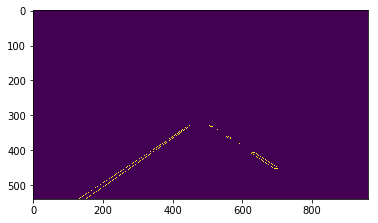

[[-0.58333333]
 [ 0.57142857]
 [-0.8       ]
 [-0.6       ]
 [-0.72727273]
 [-0.75      ]
 [-0.69444444]
 [-0.66666667]
 [-0.61904762]
 [-0.66666667]
 [-0.7       ]
 [-0.68888889]
 [-0.58333333]
 [-0.66666667]
 [-0.75      ]
 [-0.65      ]
 [ 0.66666667]
 [-0.76470588]
 [ 0.53333333]
 [ 0.66666667]
 [-0.5       ]
 [-0.57142857]
 [ 0.59090909]
 [-0.8       ]
 [-0.69230769]
 [-0.58333333]
 [ 0.5       ]
 [-0.8       ]
 [ 0.6       ]]
left_m = -0.67251945382  right_m = 0.619957250154
left_c = 632.665092897  right_c = 16.3705127447
left_y = 331.376377585  right_y = 328.828966822  min y = 328.828966822
left_y = 542.547486085  right_y = 444.760972601  max y = 542.547486085


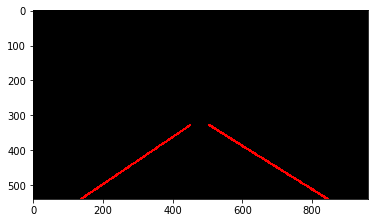

 60%|██████    | 410/682 [03:32<01:46,  2.55it/s]

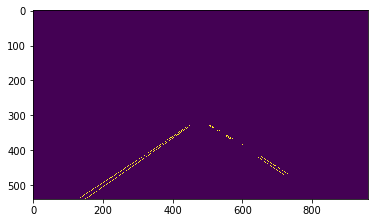

[[-0.72727273]
 [-0.72222222]
 [-0.57894737]
 [-0.68627451]
 [-0.5625    ]
 [-0.58823529]
 [ 0.6       ]
 [ 0.57142857]
 [ 0.57142857]
 [-0.75      ]
 [-0.66666667]
 [-0.63333333]
 [-0.5625    ]
 [-0.64285714]
 [-0.57142857]
 [-0.5625    ]
 [ 0.625     ]
 [-0.58333333]
 [-0.6       ]
 [-0.78571429]
 [-0.66666667]
 [-0.57894737]
 [ 0.58333333]
 [-0.61538462]
 [ 0.6       ]
 [-0.6       ]]
left_m = -0.671588279285  right_m = 0.637838284055
left_c = 631.53566944  right_c = 7.7807740462
left_y = 340.73794451  right_y = 425.564850103  min y = 340.73794451
left_y = 538.856486899  right_y = 468.937853418  max y = 538.856486899


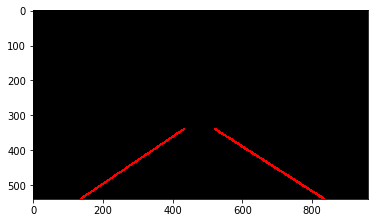

 60%|██████    | 411/682 [03:32<01:45,  2.58it/s]

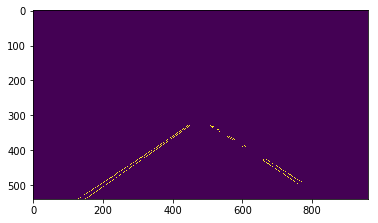

[[-0.65088757]
 [-0.58333333]
 [ 0.58333333]
 [-0.77272727]
 [-0.61538462]
 [-0.61538462]
 [-0.71428571]
 [-0.72093023]
 [ 0.64285714]
 [-0.66666667]
 [-0.61538462]
 [-0.78571429]
 [-0.76470588]
 [-0.78571429]
 [-0.58333333]
 [-0.6       ]
 [ 0.73333333]
 [ 0.64705882]
 [-0.66666667]
 [-0.81818182]
 [ 0.64285714]
 [ 0.71428571]
 [-0.83333333]
 [ 0.6       ]
 [ 0.7       ]
 [-0.6       ]
 [ 0.6       ]
 [ 0.54545455]
 [ 0.54545455]
 [ 0.6       ]
 [-0.66666667]
 [ 0.        ]]
left_m = -0.667973455165  right_m = 0.639986035053
left_c = 630.247545516  right_c = 4.20956017028
left_y = 334.335304878  right_y = 360.681781695  min y = 334.335304878
left_y = 543.410996344  right_y = 500.198737336  max y = 543.410996344


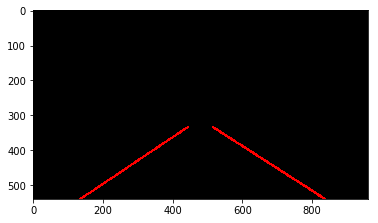

 60%|██████    | 412/682 [03:33<01:44,  2.57it/s]

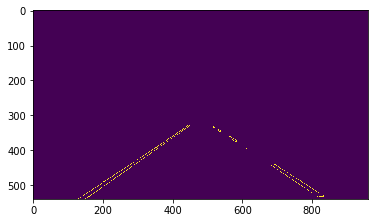

[[-0.63157895]
 [-0.75      ]
 [ 0.64285714]
 [ 0.69387755]
 [-0.73333333]
 [-0.58333333]
 [-0.625     ]
 [-0.61290323]
 [-0.63636364]
 [-0.8       ]
 [-0.81818182]
 [ 0.63043478]
 [ 0.75      ]
 [ 0.6       ]
 [-0.77777778]
 [-0.65      ]
 [ 0.71428571]
 [-0.75      ]
 [ 0.61538462]
 [-0.57894737]
 [-0.78571429]
 [-0.81818182]
 [-0.66666667]
 [-0.6       ]
 [-0.57142857]
 [ 0.6       ]
 [-0.53846154]
 [ 0.57142857]
 [-0.75      ]
 [ 0.63157895]
 [-0.76470588]
 [-0.63636364]
 [-0.78571429]
 [ 0.5       ]
 [ 0.54545455]
 [ 0.6       ]
 [ 0.63636364]]
left_m = -0.678178788592  right_m = 0.643780406245
left_c = 633.422240985  right_c = -0.505507123635
left_y = 329.598143696  right_y = 362.586641999  min y = 329.598143696
left_y = 539.155389371  right_y = 521.600402341  max y = 539.155389371


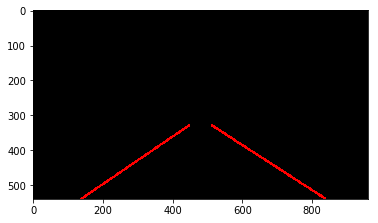

 61%|██████    | 413/682 [03:33<01:41,  2.64it/s]

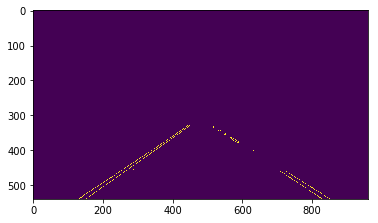

[[-0.73684211]
 [ 0.64516129]
 [-0.6       ]
 [ 0.6122449 ]
 [-0.8       ]
 [-0.69230769]
 [-0.66666667]
 [-0.61111111]
 [-0.68627451]
 [ 0.61538462]
 [ 0.55      ]
 [-0.83333333]
 [-0.68888889]
 [-0.67857143]
 [-0.7037037 ]
 [ 0.5625    ]
 [ 0.6       ]
 [-0.77777778]
 [-0.6       ]
 [ 0.56521739]
 [-0.8       ]
 [-0.64285714]
 [-0.68      ]
 [-0.76923077]
 [-0.76923077]
 [-0.83333333]
 [ 0.58333333]
 [ 0.63636364]
 [-0.76923077]
 [-0.58333333]
 [-0.6       ]
 [ 0.58333333]
 [ 0.625     ]
 [-0.8       ]
 [-0.78571429]
 [-0.58333333]]
left_m = -0.674228854772  right_m = 0.634309912087
left_c = 633.135784812  right_c = 4.48720121281
left_y = 336.475088712  right_y = 363.506611454  min y = 336.475088712
left_y = 543.463347127  right_y = 543.016316574  max y = 543.463347127


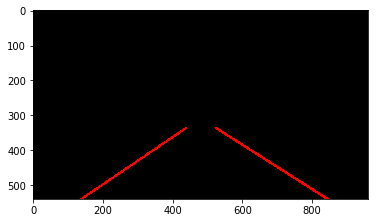

 61%|██████    | 414/682 [03:33<01:40,  2.66it/s]

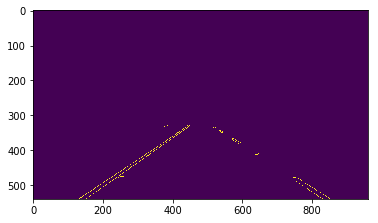

[[-0.64948454]
 [-0.64705882]
 [-0.73684211]
 [-0.77777778]
 [ 0.61290323]
 [-0.81818182]
 [ 0.61538462]
 [-0.65517241]
 [-0.75      ]
 [-0.64705882]
 [ 0.71875   ]
 [-0.81818182]
 [-0.69230769]
 [-0.63636364]
 [-0.76923077]
 [-0.71428571]
 [-0.81818182]
 [-0.66666667]
 [-0.75      ]
 [-0.61904762]
 [ 0.61538462]
 [ 0.6       ]
 [ 0.6       ]
 [-0.76190476]
 [ 0.5       ]
 [-0.6       ]
 [-0.81818182]
 [ 0.        ]]
left_m = -0.697209604237  right_m = 0.620740642012
left_c = 641.381518519  right_c = 13.9305486715
left_y = 335.306502259  right_y = 368.37345526  min y = 335.306502259
left_y = 548.652641156  right_y = 542.180835024  max y = 548.652641156


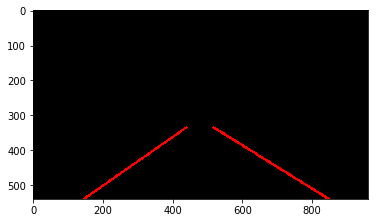

 61%|██████    | 415/682 [03:34<01:44,  2.56it/s]

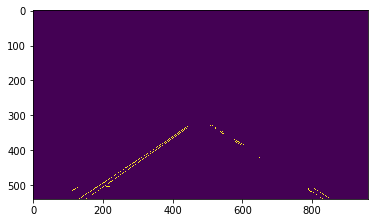

[[-0.5625    ]
 [-0.61111111]
 [-0.72340426]
 [-0.725     ]
 [-0.81818182]
 [-0.625     ]
 [-0.63636364]
 [-0.8125    ]
 [-0.58333333]
 [ 0.57692308]
 [-0.8125    ]
 [-0.58333333]
 [ 0.55555556]
 [-0.6       ]
 [ 0.58823529]
 [-0.8       ]
 [-0.76923077]
 [-0.6       ]
 [-0.64285714]
 [-0.64705882]
 [ 0.57894737]
 [-0.5       ]
 [-0.58333333]
 [-0.6875    ]
 [-0.58333333]
 [-0.5       ]
 [ 0.5625    ]
 [-0.64285714]
 [ 0.56521739]
 [ 0.54545455]
 [ 0.        ]]
left_m = -0.676323640008  right_m = 0.637912043801
left_c = 634.33769521  right_c = 2.09995343684
left_y = 337.431617247  right_y = 368.899378623  min y = 337.431617247
left_y = 531.536501929  right_y = 544.325190668  max y = 544.325190668


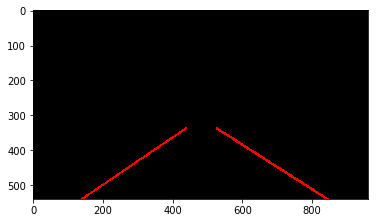

 61%|██████    | 416/682 [03:34<01:41,  2.63it/s]

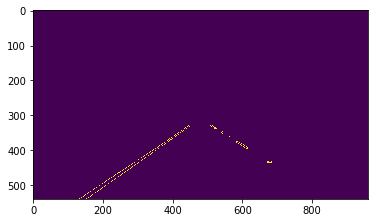

[[-0.5       ]
 [-0.7027972 ]
 [-0.69444444]
 [ 0.5       ]
 [-0.75      ]
 [ 0.54545455]
 [-0.68181818]
 [-0.75      ]
 [ 0.52631579]
 [-0.70588235]
 [-0.76923077]
 [-0.78571429]
 [-0.71428571]
 [-0.72727273]
 [-0.61538462]
 [-0.63157895]
 [ 0.54166667]
 [ 0.6       ]
 [-0.73333333]
 [-0.71428571]]
left_m = -0.670593162991  right_m = 0.63227319361
left_c = 629.542582507  right_c = 5.93499926718
left_y = 331.128624976  right_y = 346.730250623  min y = 331.128624976
left_y = 537.671319177  right_y = 396.679832918  max y = 537.671319177


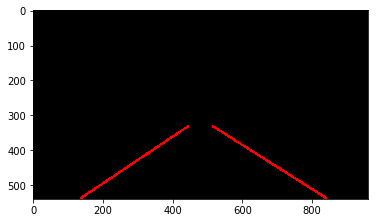

 61%|██████    | 417/682 [03:34<01:39,  2.65it/s]

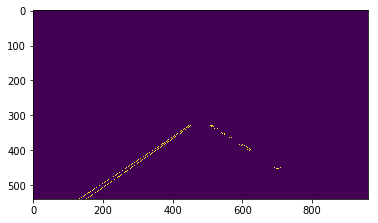

[[-0.72727273]
 [-0.67901235]
 [-0.75      ]
 [-0.67479675]
 [-0.63157895]
 [-0.62962963]
 [-0.625     ]
 [-0.81818182]
 [-0.75      ]
 [ 0.54545455]
 [ 0.55555556]
 [-0.74074074]
 [-0.69230769]
 [-0.8       ]
 [ 0.64705882]
 [ 0.61538462]
 [ 0.        ]
 [-0.6       ]
 [-0.58333333]
 [ 0.6       ]
 [-0.625     ]
 [-0.75      ]]
left_m = -0.675563368511  right_m = 0.624965807978
left_c = 635.772229937  right_c = 9.55777245008
left_y = 331.093150738  right_y = 348.914206182  min y = 331.093150738
left_y = 529.033217712  right_y = 402.661265668  max y = 529.033217712


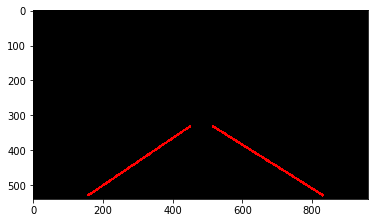

 61%|██████▏   | 418/682 [03:35<01:38,  2.69it/s]

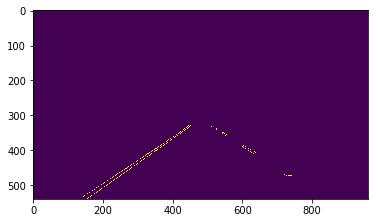

[[-0.83333333]
 [ 0.65384615]
 [-0.8       ]
 [-0.66666667]
 [-0.76470588]
 [-0.83333333]
 [-0.75      ]
 [-0.75      ]
 [-0.61290323]
 [-0.6       ]
 [-0.61538462]
 [-0.73529412]
 [-0.8       ]
 [ 0.58333333]
 [-0.8125    ]
 [-0.76470588]
 [-0.625     ]
 [-0.8       ]
 [-0.71428571]
 [-0.8       ]
 [-0.7037037 ]
 [-0.6       ]
 [-0.8       ]
 [ 0.6       ]
 [-0.6       ]
 [-0.8       ]
 [-0.63636364]
 [-0.75      ]
 [-0.6       ]]
left_m = -0.664477489053  right_m = 0.538817820909
left_c = 631.461305848  right_c = 64.1643140715
left_y = 335.10434573  right_y = 385.299735333  min y = 335.10434573
left_y = 541.756844826  right_y = 407.39126599  max y = 541.756844826


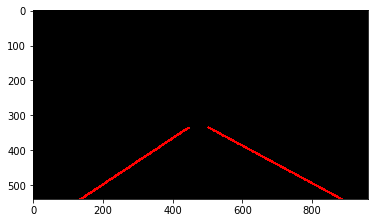

 61%|██████▏   | 419/682 [03:35<01:36,  2.73it/s]

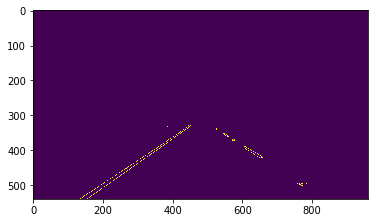

[[-0.63333333]
 [-0.78571429]
 [ 0.72727273]
 [-0.72307692]
 [-0.75      ]
 [-0.61538462]
 [-0.72      ]
 [-0.72093023]
 [-0.75      ]
 [-0.76190476]
 [ 0.61702128]
 [ 0.75      ]
 [-0.71428571]
 [-0.72727273]
 [-0.63636364]
 [-0.75      ]
 [-0.78571429]
 [ 0.61538462]
 [ 0.        ]
 [-0.2       ]
 [-0.54545455]
 [-0.77777778]
 [ 0.66666667]
 [ 0.7       ]
 [ 0.6       ]]
left_m = -0.683759375828  right_m = 0.592601102941
left_c = 638.063169784  right_c = 33.0607930672
left_y = 336.525285043  right_y = 390.991859244  min y = 336.525285043
left_y = 537.550541537  right_y = 421.807116597  max y = 537.550541537


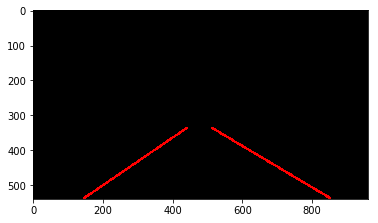

 62%|██████▏   | 420/682 [03:36<01:41,  2.58it/s]

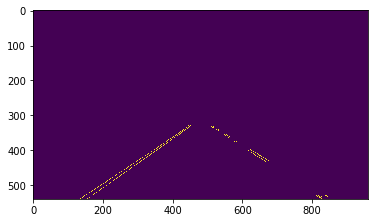

[[-0.72222222]
 [-0.66906475]
 [-0.71428571]
 [ 0.5       ]
 [-0.8       ]
 [-0.67567568]
 [-0.6875    ]
 [-0.73684211]
 [-0.77777778]
 [-0.75      ]
 [ 0.56756757]
 [-0.70967742]
 [ 0.66666667]
 [-0.74193548]
 [ 0.52941176]
 [-0.76470588]
 [-0.78571429]
 [-0.8       ]
 [-0.58333333]
 [ 0.5       ]
 [ 0.6       ]
 [-0.69230769]
 [ 0.54545455]]
left_m = -0.693418458666  right_m = 0.648929356919
left_c = 642.791948612  right_c = -3.08766216035
left_y = 346.008848303  right_y = 355.770272216  min y = 346.008848303
left_y = 548.487038234  right_y = 425.854642763  max y = 548.487038234


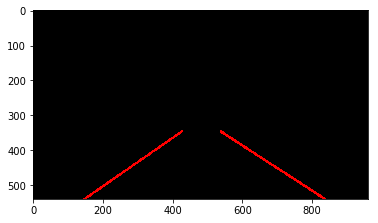

 62%|██████▏   | 421/682 [03:36<01:38,  2.65it/s]

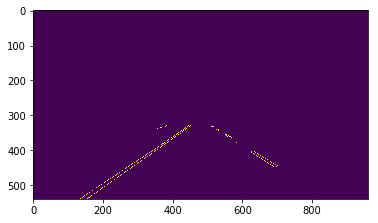

[[-0.6875    ]
 [-0.66981132]
 [-0.77777778]
 [-0.61904762]
 [ 0.59183673]
 [-0.81818182]
 [-0.67272727]
 [-0.7       ]
 [-0.76470588]
 [ 0.64285714]
 [-0.703125  ]
 [ 0.63636364]
 [-0.6875    ]
 [-0.7       ]
 [-0.70833333]
 [-0.72      ]
 [-0.65      ]
 [ 0.63636364]
 [ 0.58333333]
 [ 0.53846154]
 [-0.63636364]
 [-0.66666667]]
left_m = -0.688959308282  right_m = 0.592910154054
left_c = 640.066873328  right_c = 31.8015574047
left_y = 334.16894045  right_y = 358.495052288  min y = 334.16894045
left_y = 547.05736671  right_y = 443.281204318  max y = 547.05736671


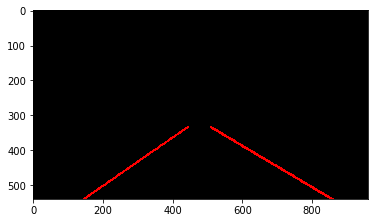

 62%|██████▏   | 422/682 [03:36<01:37,  2.68it/s]

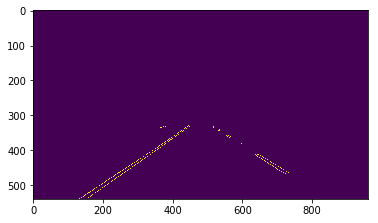

[[-0.7       ]
 [-0.72340426]
 [ 0.58823529]
 [-0.69230769]
 [-0.7254902 ]
 [ 0.60227273]
 [-0.83333333]
 [-0.8       ]
 [-0.76923077]
 [-0.73913043]
 [-0.58333333]
 [-0.64285714]
 [ 0.58333333]
 [-0.70588235]
 [-0.66666667]
 [-0.7027027 ]
 [-0.7       ]
 [ 0.6       ]
 [ 0.63157895]
 [-0.58333333]
 [-0.73333333]
 [-0.65      ]
 [ 0.6       ]
 [-0.6       ]
 [-0.69230769]
 [-0.54545455]]
left_m = -0.666974884644  right_m = 0.630477977831
left_c = 632.735388048  right_c = 8.94039528473
left_y = 336.598539266  right_y = 357.594717025  min y = 336.598539266
left_y = 543.360753506  right_y = 471.080753035  max y = 543.360753506


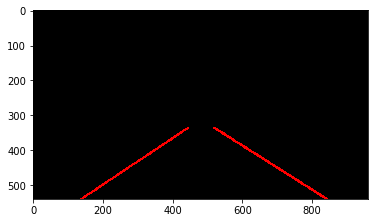

 62%|██████▏   | 423/682 [03:37<01:35,  2.71it/s]

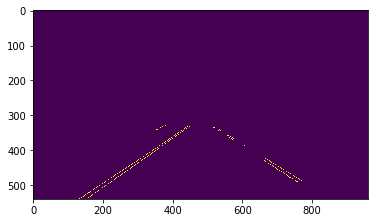

[[-0.65294118]
 [-0.70175439]
 [-0.72463768]
 [-0.77142857]
 [ 0.53333333]
 [-0.72      ]
 [-0.68421053]
 [ 0.54545455]
 [-0.72093023]
 [ 0.6       ]
 [ 0.68421053]
 [ 0.58823529]
 [ 0.64285714]
 [ 0.68181818]
 [ 0.66666667]
 [ 0.58333333]
 [ 0.61111111]
 [ 0.66666667]
 [-0.63636364]
 [ 0.66666667]
 [ 0.        ]
 [-0.7       ]
 [-0.64285714]]
left_m = -0.703260294123  right_m = 0.619570531055
left_c = 644.509659634  right_c = 14.2857532369
left_y = 328.745787573  right_y = 360.625680097  min y = 328.745787573
left_y = 530.581491986  right_y = 493.213773742  max y = 530.581491986


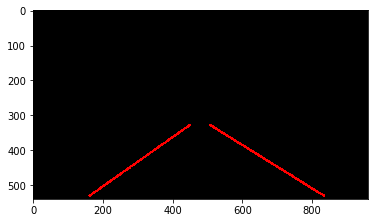

 62%|██████▏   | 424/682 [03:37<01:34,  2.74it/s]

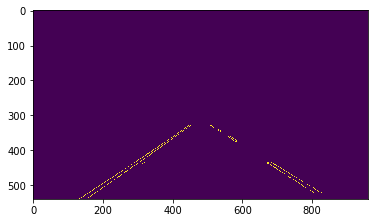

[[-0.67464115]
 [-0.58333333]
 [ 0.5       ]
 [-0.76923077]
 [-0.65853659]
 [-0.61290323]
 [-0.77419355]
 [ 0.6       ]
 [ 0.7       ]
 [-0.6       ]
 [ 0.66666667]
 [ 0.66666667]
 [ 0.6       ]
 [-0.64705882]
 [ 0.66666667]
 [-0.63157895]
 [-0.63157895]
 [-0.63333333]
 [ 0.59259259]
 [-0.65      ]
 [ 0.53846154]
 [-0.66666667]
 [-0.63636364]
 [ 0.6       ]
 [-0.81818182]
 [ 0.5       ]
 [ 0.45454545]
 [ 0.63636364]]
left_m = -0.68065038215  right_m = 0.646852849249
left_c = 639.128567665  right_c = -1.70011031736
left_y = 332.835895697  right_y = 361.184338111  min y = 332.835895697
left_y = 543.156863781  right_y = 521.603844725  max y = 543.156863781


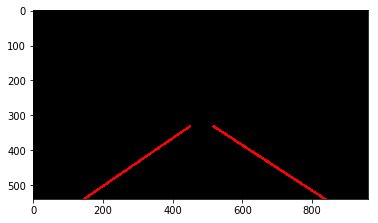

 62%|██████▏   | 425/682 [03:37<01:34,  2.73it/s]

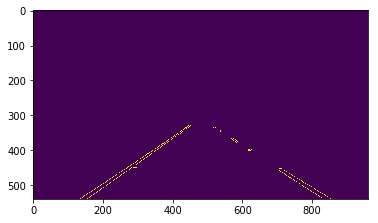

[[ 0.63333333]
 [-0.83333333]
 [ 0.5       ]
 [-0.68      ]
 [-0.78571429]
 [ 0.6       ]
 [-0.66666667]
 [-0.7       ]
 [-0.58333333]
 [-0.69230769]
 [ 0.70588235]
 [-0.65217391]
 [-0.75      ]
 [-0.76923077]
 [ 0.5       ]
 [-0.5625    ]
 [ 0.58823529]
 [-0.82352941]
 [ 0.53333333]
 [ 0.53846154]
 [ 0.57142857]
 [-0.58333333]
 [-0.61538462]
 [-0.69444444]
 [-0.7       ]
 [-0.81818182]
 [-0.76923077]
 [-0.61538462]
 [ 0.73333333]
 [ 0.58333333]
 [-0.63636364]
 [-0.71428571]
 [ 0.7       ]]
left_m = -0.677257920919  right_m = 0.617670465701
left_c = 637.284272372  right_c = 16.7475154817
left_y = 334.549981721  right_y = 365.731328603  min y = 334.549981721
left_y = 545.177195127  right_y = 543.620422724  max y = 545.177195127


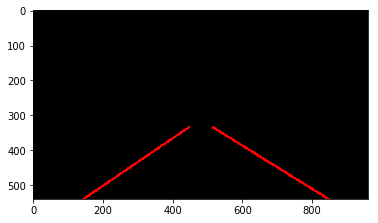

 62%|██████▏   | 426/682 [03:38<01:37,  2.63it/s]

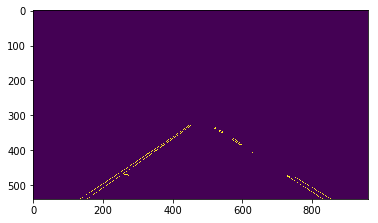

[[-0.71428571]
 [-0.71186441]
 [-0.76923077]
 [ 0.6744186 ]
 [-0.75      ]
 [-0.78571429]
 [-0.78571429]
 [-0.75      ]
 [ 0.57894737]
 [ 0.68181818]
 [-0.81818182]
 [ 0.65909091]
 [-0.8       ]
 [-0.8       ]
 [ 0.60869565]
 [-0.76470588]
 [ 0.7       ]
 [-0.6       ]
 [-0.83333333]
 [-0.8       ]
 [ 0.57142857]
 [-0.6875    ]
 [-0.8       ]
 [-0.63636364]
 [-0.59090909]
 [-0.8       ]
 [-0.78571429]
 [-0.62068966]
 [-0.63636364]
 [-0.5       ]
 [-0.78571429]
 [ 0.6875    ]
 [ 0.        ]]
left_m = -0.687940232796  right_m = 0.626574836574
left_c = 639.151315684  right_c = 11.4481666253
left_y = 332.329971857  right_y = 368.595823473  min y = 332.329971857
left_y = 545.591444023  right_y = 545.289927387  max y = 545.591444023


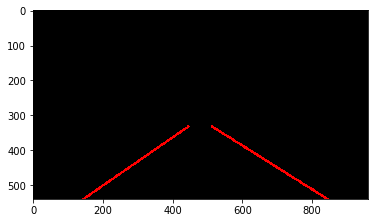

 63%|██████▎   | 427/682 [03:38<01:35,  2.67it/s]

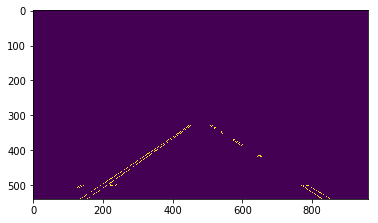

[[-0.65217391]
 [ 0.625     ]
 [-0.72131148]
 [-0.6       ]
 [-0.61904762]
 [-0.72463768]
 [-0.6       ]
 [-0.57142857]
 [ 0.5625    ]
 [-0.68421053]
 [-0.61538462]
 [-0.8       ]
 [-0.6       ]
 [-0.58333333]
 [ 0.66666667]
 [-0.8       ]
 [-0.90909091]
 [ 0.61538462]
 [-0.5625    ]
 [ 0.54545455]
 [-0.53846154]
 [ 0.5625    ]
 [ 0.6       ]
 [-0.63157895]
 [ 0.6       ]]
left_m = -0.648268024966  right_m = 0.627757321508
left_c = 626.669976702  right_c = 9.33871592891
left_y = 338.190705592  right_y = 370.926933117  min y = 338.190705592
left_y = 544.988205556  right_y = 534.14383671  max y = 544.988205556


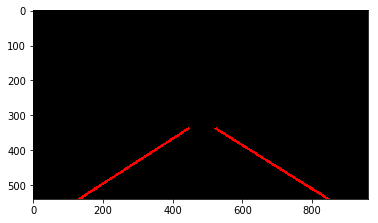

 63%|██████▎   | 428/682 [03:39<01:34,  2.68it/s]

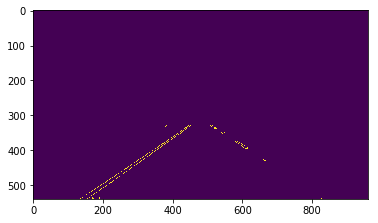

[[-0.66666667]
 [-0.66666667]
 [-0.66666667]
 [ 0.66666667]
 [-0.67605634]
 [-0.61538462]
 [-0.69565217]
 [-0.76470588]
 [ 0.6       ]
 [-0.78571429]
 [-0.76923077]
 [ 0.65217391]
 [-0.58333333]
 [-0.69230769]
 [-0.6969697 ]
 [-0.73684211]
 [-0.72222222]
 [-0.69444444]
 [-0.81818182]
 [-0.76923077]
 [-0.66666667]
 [-0.6875    ]
 [-0.66666667]
 [-0.6       ]
 [-0.6       ]
 [-0.72727273]]
left_m = -0.685267868404  right_m = 0.532242540905
left_c = 638.83938622  right_c = 66.6249598973
left_y = 329.78357757  right_y = 378.519088868  min y = 329.78357757
left_y = 545.642956117  right_y = 393.954122554  max y = 545.642956117


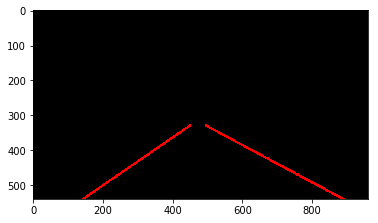

 63%|██████▎   | 429/682 [03:39<01:34,  2.69it/s]

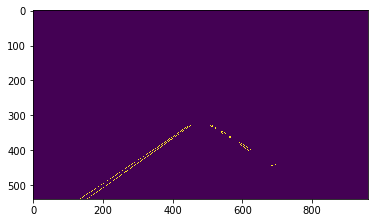

[[-0.67391304]
 [-0.7037037 ]
 [-0.5       ]
 [ 0.57142857]
 [ 0.6       ]
 [-0.6       ]
 [-0.70491803]
 [-0.66666667]
 [-0.76923077]
 [-0.63636364]
 [ 0.57142857]]
left_m = -0.67212190224  right_m = 0.68402676753
left_c = 632.38674691  right_c = -25.8876927553
left_y = 329.259769  right_y = 381.108233925  min y = 329.259769
left_y = 541.650290108  right_y = 401.629036951  max y = 541.650290108


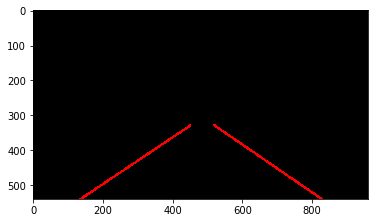

 63%|██████▎   | 430/682 [03:39<01:34,  2.68it/s]

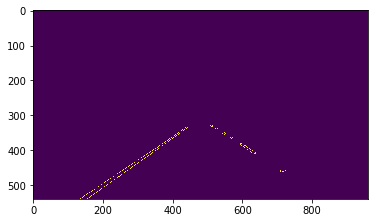

[[-0.65      ]
 [-0.66666667]
 [-0.67455621]
 [-0.6875    ]
 [-0.66666667]
 [-0.67088608]
 [-0.66666667]
 [ 0.55555556]
 [-0.7       ]
 [-0.66666667]
 [-0.68181818]
 [-0.64285714]
 [-0.68421053]
 [ 0.6       ]
 [-0.58333333]
 [-0.66666667]
 [-0.69230769]
 [ 0.6       ]
 [-0.64285714]]
left_m = -0.699636341036  right_m = 0.426907073509
left_c = 644.988788543  right_c = 133.161719834
left_y = 330.152435077  right_y = 388.025242718  min y = 330.152435077
left_y = 549.838246162  right_y = 402.113176144  max y = 549.838246162


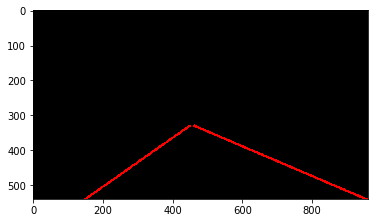

 63%|██████▎   | 431/682 [03:40<01:38,  2.56it/s]

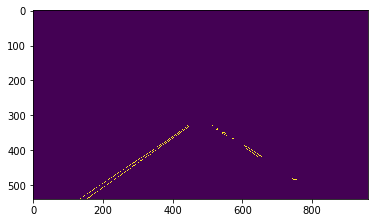

[[-0.64583333]
 [-0.72307692]
 [-0.69565217]
 [-0.61538462]
 [-0.76923077]
 [-0.8       ]
 [-0.58333333]
 [ 0.07142857]
 [-0.83333333]
 [-0.65217391]
 [-0.61538462]
 [-0.57142857]
 [-0.71428571]
 [ 0.65714286]
 [-0.5625    ]
 [-0.63636364]
 [-0.63157895]
 [ 0.63636364]
 [-0.76470588]
 [-0.57142857]
 [ 0.58823529]
 [-0.69230769]
 [-0.81818182]
 [-0.8       ]
 [ 0.63636364]
 [ 0.        ]
 [-0.8       ]
 [-0.6       ]]
left_m = -0.667038123639  right_m = 0.604579011731
left_c = 631.365889234  right_c = 22.6921056207
left_y = 339.870229204  right_y = 350.97850899  min y = 339.870229204
left_y = 541.982780666  right_y = 418.086779293  max y = 541.982780666


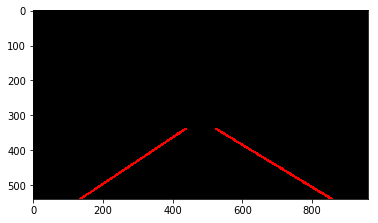

 63%|██████▎   | 432/682 [03:40<01:35,  2.63it/s]

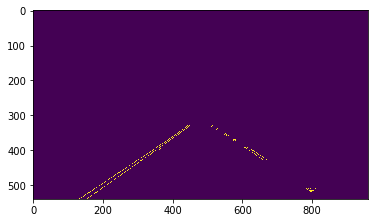

[[-0.67525773]
 [-0.72222222]
 [-0.6       ]
 [-0.81818182]
 [ 0.7       ]
 [-0.66666667]
 [-0.63636364]
 [-0.73333333]
 [-0.64285714]
 [ 0.63461538]
 [-0.69047619]
 [-0.66666667]
 [-0.69230769]
 [ 0.53846154]
 [-0.69230769]]
left_m = -0.693872974943  right_m = 0.655659498341
left_c = 641.525748827  right_c = -8.23609506417
left_y = 329.282910103  right_y = 350.409650529  min y = 329.282910103
left_y = 548.546770185  right_y = 433.02274732  max y = 548.546770185


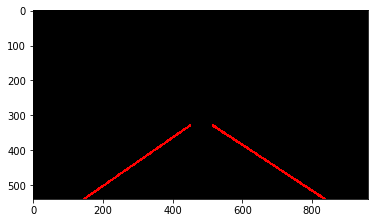

 63%|██████▎   | 433/682 [03:40<01:33,  2.65it/s]

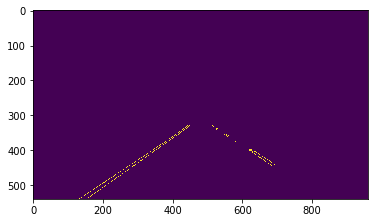

[[-0.68181818]
 [-0.9       ]
 [-0.75      ]
 [-0.83333333]
 [-0.64705882]
 [-0.6       ]
 [-0.65217391]
 [-0.77777778]
 [-0.61290323]
 [-0.8       ]
 [ 0.62162162]
 [-0.57142857]
 [-0.6       ]
 [ 0.58333333]
 [-0.64      ]
 [-0.6       ]
 [ 0.77777778]
 [ 0.6       ]
 [-0.69230769]
 [-0.54545455]
 [-0.77777778]
 [-0.66666667]
 [-0.78571429]
 [ 0.8       ]
 [-0.8       ]
 [ 0.8       ]
 [ 0.72727273]
 [-0.63636364]
 [-0.9       ]
 [ 0.8       ]
 [-0.63636364]
 [-0.66666667]]
left_m = -0.677943053062  right_m = 0.663515181744
left_c = 634.365748109  right_c = -12.3023530145
left_y = 334.036975603  right_y = 353.294512127  min y = 334.036975603
left_y = 544.199322052  right_y = 449.50421348  max y = 544.199322052


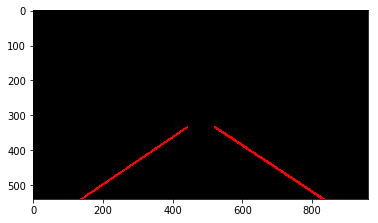

 64%|██████▎   | 434/682 [03:41<01:32,  2.69it/s]

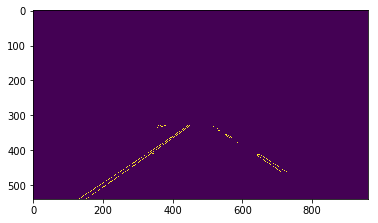

[[-0.75      ]
 [-0.6875    ]
 [-0.6875    ]
 [-0.63157895]
 [ 0.73684211]
 [-0.58823529]
 [-0.73333333]
 [-0.64285714]
 [-0.65217391]
 [-0.6       ]
 [-0.61538462]
 [-0.8       ]
 [-0.64285714]
 [-0.61538462]
 [ 0.61904762]
 [-0.75      ]
 [-0.5       ]
 [-0.83333333]
 [-0.6       ]
 [-0.6       ]
 [ 0.72727273]
 [-0.68      ]
 [-0.66666667]
 [ 0.66666667]
 [-0.57142857]
 [-0.6       ]
 [ 0.57142857]
 [ 0.53846154]
 [ 0.57142857]
 [-0.69230769]
 [-0.58333333]
 [-0.66666667]
 [ 0.7       ]
 [ 0.09090909]
 [-0.5       ]
 [-0.58333333]
 [-0.7       ]
 [ 0.58333333]]
left_m = -0.665438178911  right_m = 0.643156042526
left_c = 630.691079791  right_c = -2.16419977623
left_y = 332.574775639  right_y = 355.430559868  min y = 332.574775639
left_y = 542.853240175  right_y = 464.123931055  max y = 542.853240175


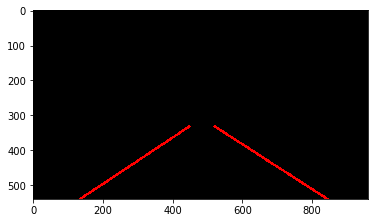

 64%|██████▍   | 435/682 [03:41<01:30,  2.72it/s]

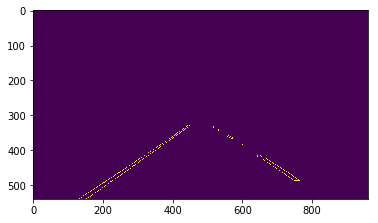

[[-0.69879518]
 [-0.75      ]
 [-0.84615385]
 [-0.81818182]
 [-0.703125  ]
 [-0.83333333]
 [-0.59259259]
 [-0.61538462]
 [ 0.6       ]
 [-0.68627451]
 [-0.57142857]
 [ 0.68421053]
 [-0.6       ]
 [ 0.6440678 ]
 [-0.59259259]
 [-0.66666667]
 [-0.71428571]
 [-0.6875    ]
 [-0.61538462]
 [-0.57142857]
 [-0.8       ]
 [ 0.63157895]
 [-0.76923077]
 [ 0.58333333]
 [-0.58333333]
 [ 0.61538462]
 [ 0.58333333]
 [-0.61111111]
 [-0.58333333]
 [-0.6       ]
 [ 0.64705882]
 [-0.81818182]]
left_m = -0.667678908693  right_m = 0.614612668656
left_c = 631.076549532  right_c = 19.4955156362
left_y = 335.96247189  right_y = 359.990934072  min y = 335.96247189
left_y = 542.275254676  right_y = 485.371918478  max y = 542.275254676


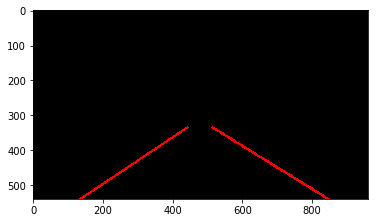

 64%|██████▍   | 436/682 [03:42<01:31,  2.69it/s]

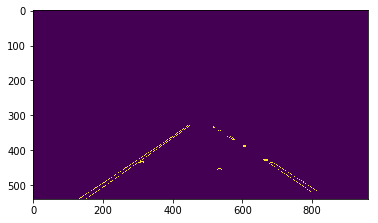

[[-0.7       ]
 [ 0.59259259]
 [ 0.4       ]
 [-0.69565217]
 [-0.76470588]
 [-0.75      ]
 [ 0.67857143]
 [-0.8       ]
 [-0.69047619]
 [ 0.64      ]
 [-0.69444444]
 [ 0.        ]
 [-0.54545455]
 [-0.57142857]
 [ 0.76923077]
 [-0.8       ]
 [-0.75      ]
 [-0.64285714]
 [-0.61538462]
 [-0.77777778]
 [-0.57142857]
 [-0.6969697 ]
 [-0.83333333]
 [ 0.57142857]
 [-0.81818182]
 [ 0.5       ]
 [-0.8       ]
 [ 0.53846154]
 [-0.8       ]
 [ 0.7       ]
 [ 0.68181818]
 [ 0.69230769]
 [-0.57142857]]
left_m = -0.688030842165  right_m = 0.649621406606
left_c = 637.609418441  right_c = -6.51869997352
left_y = 334.875847889  right_y = 359.867773352  min y = 334.875847889
left_y = 546.789347275  right_y = 518.375396564  max y = 546.789347275


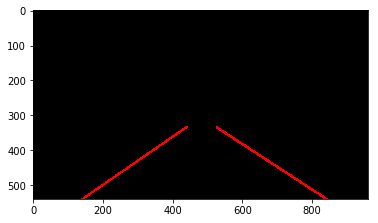

 64%|██████▍   | 437/682 [03:42<01:34,  2.60it/s]

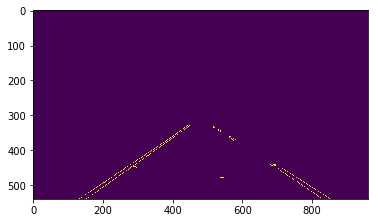

[[ 0.64285714]
 [ 0.5       ]
 [-0.67251462]
 [ 0.56      ]
 [-0.8       ]
 [-0.703125  ]
 [-0.77272727]
 [ 0.5       ]
 [-0.58333333]
 [ 0.59259259]
 [-0.75      ]
 [-0.72727273]
 [-0.61904762]
 [ 0.65306122]
 [-0.78947368]
 [ 0.66666667]
 [-0.7       ]
 [ 0.5625    ]
 [-0.8       ]
 [ 0.5625    ]
 [-0.8       ]
 [ 0.6       ]
 [-0.63636364]
 [ 0.5       ]
 [ 0.8       ]
 [-0.72727273]
 [-0.66666667]
 [ 0.57142857]]
left_m = -0.705624550324  right_m = 0.620988703828
left_c = 644.114782017  right_c = 14.0323726582
left_y = 327.994983472  right_y = 362.407035506  min y = 327.994983472
left_y = 539.682348569  right_y = 541.251782208  max y = 541.251782208


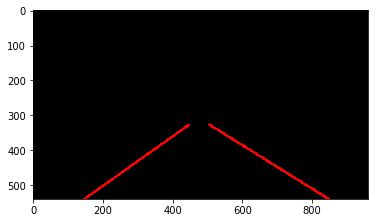

 64%|██████▍   | 438/682 [03:42<01:32,  2.64it/s]

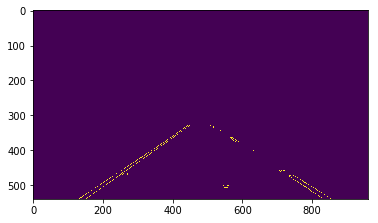

[[-0.5       ]
 [-0.70070423]
 [ 0.62135922]
 [-0.71875   ]
 [ 0.54545455]
 [ 0.57894737]
 [-0.69892473]
 [-0.72      ]
 [ 0.6       ]
 [-0.71428571]
 [ 0.6       ]
 [-0.7       ]
 [-0.73333333]
 [ 0.7       ]
 [-0.71428571]
 [-0.72222222]
 [-0.72727273]
 [-0.75      ]
 [ 0.7       ]
 [ 0.62068966]
 [-0.76923077]
 [-0.71428571]
 [ 0.        ]
 [ 0.61111111]
 [ 0.6       ]]
left_m = -0.673228058333  right_m = 0.626595323028
left_c = 629.911618254  right_c = 9.94978200555
left_y = 329.651904238  right_y = 363.976139516  min y = 329.651904238
left_y = 541.045514554  right_y = 543.808997226  max y = 543.808997226


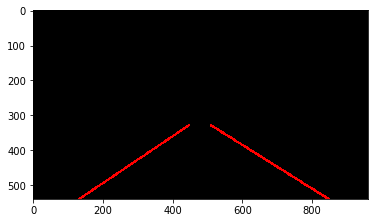

 64%|██████▍   | 439/682 [03:43<01:30,  2.68it/s]

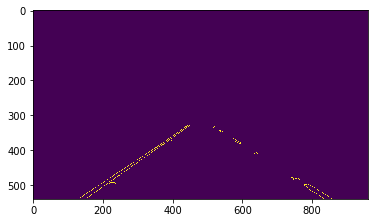

[[ 0.57142857]
 [ 0.66666667]
 [-0.6875    ]
 [-0.78571429]
 [-0.6       ]
 [-0.72340426]
 [-0.71428571]
 [ 0.8       ]
 [-0.57894737]
 [-0.6       ]
 [-0.64285714]
 [-0.69444444]
 [-0.77777778]
 [-0.65      ]
 [-0.73333333]
 [ 0.72      ]
 [-0.57142857]
 [-0.6       ]
 [ 0.68181818]
 [-0.81818182]
 [-0.68627451]
 [-0.73333333]
 [-0.6       ]
 [ 0.8       ]
 [-0.73684211]
 [-0.8       ]
 [ 0.5625    ]
 [-0.76923077]
 [ 0.66666667]
 [-0.6       ]
 [-0.57142857]]
left_m = -0.670561073728  right_m = 0.62426133507
left_c = 630.145200558  right_c = 10.4058843637
left_y = 331.745522749  right_y = 366.234845353  min y = 331.745522749
left_y = 542.301699899  right_y = 537.906712498  max y = 542.301699899


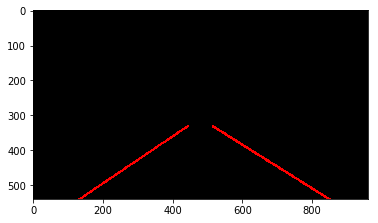

 65%|██████▍   | 440/682 [03:43<01:29,  2.71it/s]

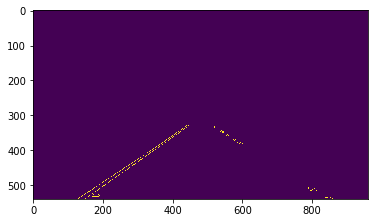

[[ 0.3       ]
 [-0.76923077]
 [-0.65217391]
 [-0.68421053]
 [-0.84615385]
 [-0.73684211]
 [-0.66666667]
 [-0.76470588]
 [ 0.58333333]
 [ 0.61904762]
 [ 0.61904762]
 [-0.625     ]
 [-0.61904762]
 [-0.61538462]
 [-0.77777778]
 [-0.8       ]
 [-0.1       ]
 [-0.6       ]
 [-0.625     ]
 [-0.61538462]
 [-0.66666667]
 [-0.69230769]
 [ 0.66666667]
 [-0.66666667]
 [ 0.        ]
 [-0.61538462]]
left_m = -0.676230939384  right_m = 0.645065090586
left_c = 632.356203563  right_c = -1.71279406652
left_y = 335.490821173  right_y = 368.55456793  min y = 335.490821173
left_y = 545.122412382  right_y = 513.694213312  max y = 545.122412382


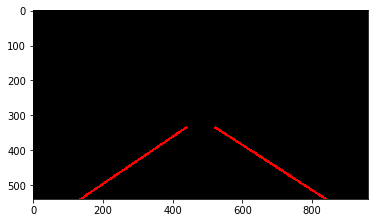

 65%|██████▍   | 441/682 [03:43<01:29,  2.71it/s]

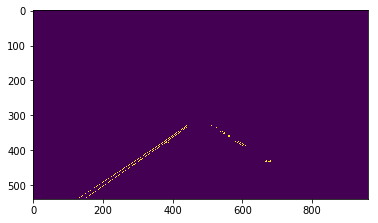

[[-0.65068493]
 [-0.70833333]
 [-0.71875   ]
 [-0.57142857]
 [-0.81818182]
 [-0.68965517]
 [-0.8       ]
 [-0.77272727]
 [-0.81818182]
 [-0.76923077]
 [-0.75      ]
 [-0.6875    ]
 [-0.7173913 ]
 [ 0.6       ]
 [-0.64705882]
 [ 0.64285714]
 [-0.63636364]
 [-0.75      ]
 [-0.75      ]
 [ 0.57142857]
 [-0.7       ]]
left_m = -0.675857455715  right_m = 0.514309076043
left_c = 632.497466856  right_c = 74.1052057781
left_y = 330.389184151  right_y = 372.404469883  min y = 330.389184151
left_y = 533.822278321  right_y = 385.77650586  max y = 533.822278321


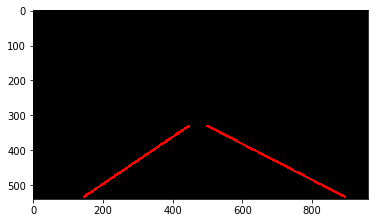

 65%|██████▍   | 442/682 [03:44<01:31,  2.62it/s]

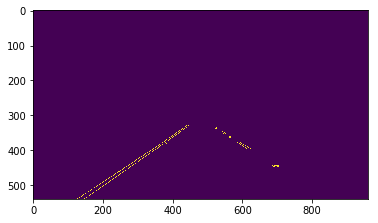

[[-0.72727273]
 [-0.64705882]
 [-0.80952381]
 [-0.70588235]
 [-0.8       ]
 [-0.65      ]
 [-0.81818182]
 [-0.77777778]
 [-0.77272727]
 [-0.66666667]
 [-0.8       ]
 [-0.6       ]
 [-0.58333333]
 [-0.66666667]
 [-0.78571429]
 [-0.76923077]
 [ 0.53846154]
 [-0.8       ]
 [-0.76923077]
 [-0.6875    ]
 [-0.6       ]
 [-0.60869565]
 [-0.73333333]
 [ 0.58333333]
 [-0.61904762]
 [-0.6       ]
 [ 0.54545455]
 [-0.08333333]
 [-0.66666667]
 [ 0.57142857]
 [-0.54545455]
 [-0.66666667]
 [-0.58333333]]
left_m = -0.67542425637  right_m = 0.556995175741
left_c = 631.531265926  right_c = 50.494279807
left_y = 334.344593123  right_y = 378.007443143  min y = 334.344593123
left_y = 541.024415573  right_y = 396.945279118  max y = 541.024415573


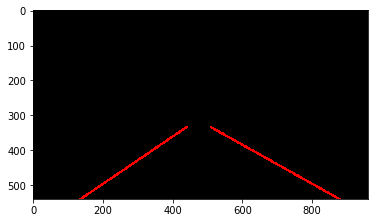

 65%|██████▍   | 443/682 [03:44<01:29,  2.66it/s]

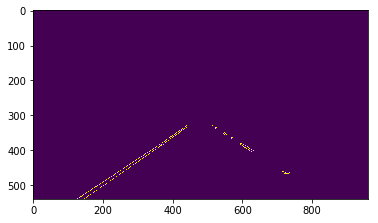

[[-0.59090909]
 [-0.62790698]
 [-0.6984127 ]
 [-0.5625    ]
 [-0.69565217]
 [ 0.54545455]
 [-0.70212766]
 [-0.75      ]
 [ 0.41666667]
 [-0.8       ]
 [-0.73333333]
 [ 0.54545455]
 [ 0.6       ]
 [-0.7       ]
 [ 0.6       ]
 [-0.75      ]
 [-0.68421053]
 [ 0.58333333]
 [-0.72727273]]
left_m = -0.685986560901  right_m = 0.641841281468
left_c = 631.900158859  right_c = 0.504774112539
left_y = 325.264166136  right_y = 347.740907387  min y = 325.264166136
left_y = 544.779865624  right_y = 401.013733748  max y = 544.779865624


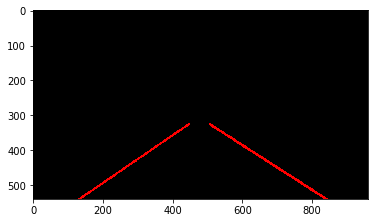

 65%|██████▌   | 444/682 [03:45<01:29,  2.67it/s]

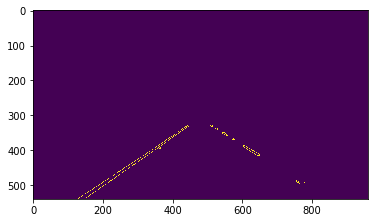

[[-0.66037736]
 [-0.67272727]
 [-0.81818182]
 [ 0.6       ]
 [-0.77272727]
 [-0.69230769]
 [ 0.66666667]
 [-0.65957447]
 [-0.65217391]
 [-0.75      ]
 [-0.63636364]
 [-0.70833333]
 [-1.11111111]
 [-0.6       ]
 [-0.6       ]
 [ 0.56818182]
 [-0.73333333]
 [-0.78571429]
 [-0.72727273]
 [-0.66666667]
 [-0.66666667]
 [-0.8       ]
 [-0.75      ]]
left_m = -0.672247699492  right_m = 0.636788874842
left_c = 630.289399208  right_c = 2.7002528445
left_y = 333.155916032  right_y = 351.023767383  min y = 333.155916032
left_y = 543.569445973  right_y = 417.249810367  max y = 543.569445973


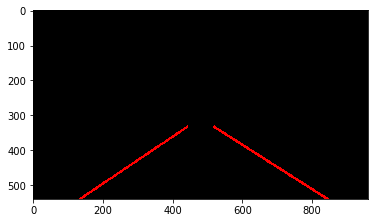

 65%|██████▌   | 445/682 [03:45<01:27,  2.71it/s]

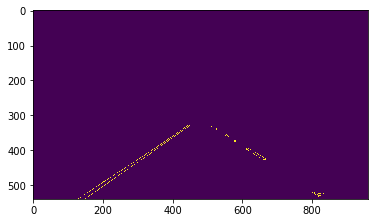

[[-0.65217391]
 [-0.77777778]
 [-0.68965517]
 [-0.77777778]
 [-0.61538462]
 [-0.75      ]
 [-0.83333333]
 [-0.71428571]
 [-0.72222222]
 [-0.83333333]
 [ 0.55882353]
 [ 0.        ]
 [-0.5625    ]
 [ 0.66666667]
 [-0.76923077]
 [-0.76923077]
 [-0.8125    ]
 [-0.78571429]
 [-0.75      ]
 [-0.76190476]
 [ 0.72727273]
 [-0.7       ]
 [-0.54545455]]
left_m = -0.690032536153  right_m = 0.525291828794
left_c = 637.350223802  right_c = 75.4753566796
left_y = 334.425940431  right_y = 395.903372244  min y = 334.425940431
left_y = 547.645994102  right_y = 416.915045396  max y = 547.645994102


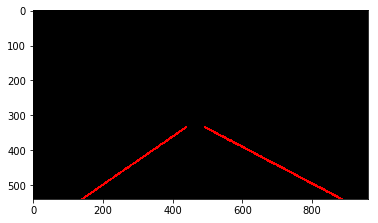

 65%|██████▌   | 446/682 [03:45<01:26,  2.73it/s]

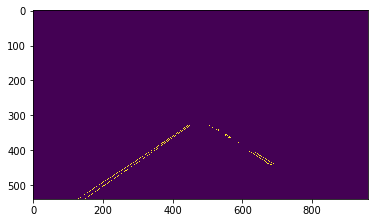

[[-0.65284974]
 [-0.71875   ]
 [-0.66666667]
 [ 0.3       ]
 [-0.62068966]
 [-0.63157895]
 [-0.72222222]
 [-0.66666667]
 [ 0.59259259]
 [ 0.68181818]
 [-0.74074074]
 [-0.54545455]
 [-0.6       ]
 [-0.72222222]
 [-0.6       ]
 [-0.63636364]
 [ 0.64705882]
 [ 0.53846154]
 [-0.58333333]
 [ 0.5       ]
 [-0.68181818]
 [ 0.58333333]
 [-0.6       ]
 [ 0.53846154]]
left_m = -0.691285641636  right_m = 0.620223536488
left_c = 639.065047837  right_c = 14.5175922213
left_y = 332.825508592  right_y = 355.020313753  min y = 332.825508592
left_y = 549.197914424  right_y = 437.510044106  max y = 549.197914424


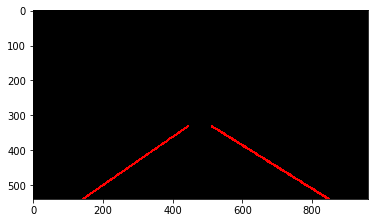

 66%|██████▌   | 447/682 [03:46<01:27,  2.70it/s]

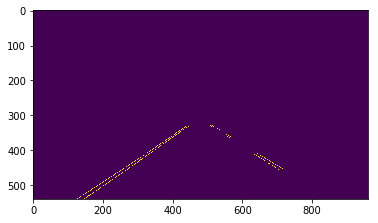

[[-0.65957447]
 [-0.66037736]
 [-0.71428571]
 [-0.63636364]
 [-0.63157895]
 [-0.66      ]
 [ 0.57142857]
 [-0.63157895]
 [-0.68888889]
 [-0.76923077]
 [-0.6       ]
 [-0.61111111]
 [ 0.64705882]
 [ 0.66666667]
 [-0.65789474]
 [-0.64705882]
 [-0.68421053]
 [-0.7       ]
 [ 0.66666667]
 [ 0.57142857]
 [-0.61111111]
 [-0.66666667]
 [-0.6       ]
 [-0.63157895]
 [-0.66666667]
 [-0.66666667]
 [ 0.5       ]
 [ 0.5625    ]
 [-0.7       ]
 [-0.61538462]
 [ 0.6       ]]
left_m = -0.671992553037  right_m = 0.601545317412
left_c = 629.847682474  right_c = 26.078117983
left_y = 330.139003819  right_y = 358.131133194  min y = 330.139003819
left_y = 542.488650579  right_y = 449.566021441  max y = 542.488650579


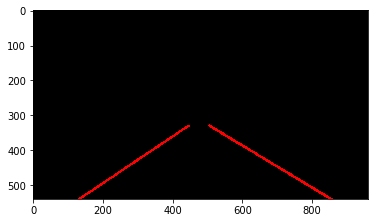

 66%|██████▌   | 448/682 [03:46<01:30,  2.59it/s]

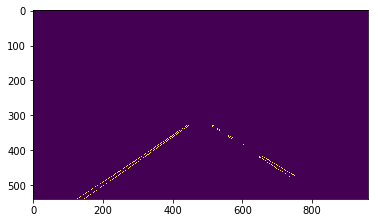

[[-0.67400881]
 [-0.70491803]
 [-0.68333333]
 [-0.67741935]
 [-0.65957447]
 [-0.66666667]
 [-0.68181818]
 [-0.58333333]
 [ 0.6       ]
 [ 0.6       ]
 [-0.67567568]
 [ 0.6       ]
 [ 0.58333333]
 [ 0.60714286]
 [ 0.57894737]
 [ 0.6       ]
 [-0.66666667]
 [-0.65      ]
 [ 0.63157895]
 [-0.69565217]
 [-0.64705882]]
left_m = -0.667754169597  right_m = 0.631965659805
left_c = 629.327590397  right_c = 6.60271818523
left_y = 331.509230757  right_y = 357.343659377  min y = 331.509230757
left_y = 544.522810858  right_y = 481.208928699  max y = 544.522810858


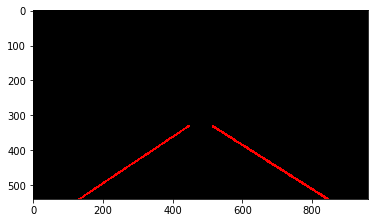

 66%|██████▌   | 449/682 [03:46<01:29,  2.62it/s]

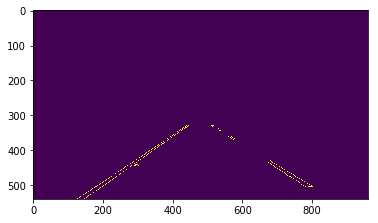

[[-0.76470588]
 [-0.75      ]
 [-0.66956522]
 [ 0.63333333]
 [-0.61904762]
 [-0.63636364]
 [-0.75      ]
 [-0.68571429]
 [-0.63157895]
 [ 0.59722222]
 [-0.6       ]
 [-0.78571429]
 [ 0.65217391]
 [-0.75      ]
 [-0.81818182]
 [ 0.56      ]
 [-0.6       ]
 [-0.6       ]
 [-0.6       ]
 [ 0.66666667]
 [-0.72727273]
 [ 0.58823529]
 [-0.6       ]
 [ 0.54545455]
 [-0.5       ]
 [ 0.5       ]
 [ 0.6       ]
 [-0.61538462]
 [ 0.63636364]
 [-0.71428571]
 [ 0.5       ]
 [-0.81818182]
 [-0.6       ]
 [-0.76923077]
 [-0.72222222]]
left_m = -0.687744023042  right_m = 0.619867675511
left_c = 634.1739255  right_c = 13.4203217661
left_y = 332.254299384  right_y = 361.166087727  min y = 332.254299384
left_y = 536.514274228  right_y = 509.314462175  max y = 536.514274228


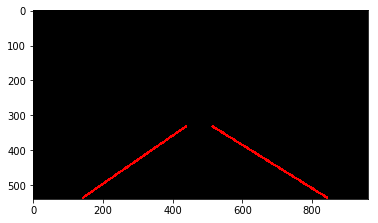

 66%|██████▌   | 450/682 [03:47<01:28,  2.62it/s]

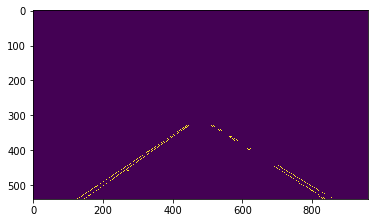

[[-0.67364017]
 [-0.70588235]
 [-0.72289157]
 [ 0.59574468]
 [ 0.60869565]
 [ 0.61111111]
 [-0.71428571]
 [ 0.60344828]
 [-0.68181818]
 [-0.58333333]
 [ 0.66666667]
 [-0.7037037 ]
 [-0.57142857]
 [ 0.45454545]
 [-0.73170732]
 [ 0.61111111]
 [ 0.65384615]
 [-0.625     ]
 [-0.6       ]
 [ 0.68181818]
 [-0.72727273]
 [ 0.66666667]
 [ 0.58333333]
 [ 0.52631579]
 [-0.58333333]]
left_m = -0.679483460667  right_m = 0.621206021213
left_c = 632.667675307  right_c = 12.1668953804
left_y = 334.374436074  right_y = 362.527091344  min y = 334.374436074
left_y = 534.822056971  right_y = 540.813219432  max y = 540.813219432


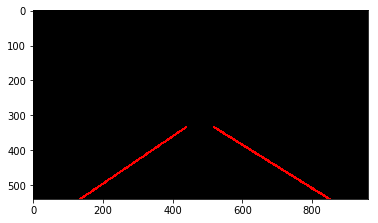

 66%|██████▌   | 451/682 [03:47<01:30,  2.55it/s]

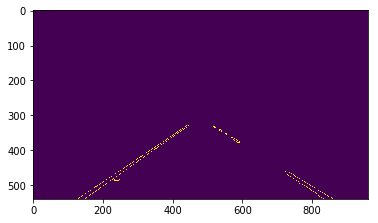

[[-0.70175439]
 [-0.76923077]
 [-0.67272727]
 [-0.75      ]
 [ 0.61764706]
 [ 0.65517241]
 [ 0.        ]
 [ 0.63636364]
 [ 0.57142857]
 [-0.61904762]
 [ 0.66666667]
 [-0.78571429]
 [-0.58333333]
 [-0.61290323]
 [ 0.66666667]
 [-0.70833333]
 [ 0.75      ]
 [-0.75      ]
 [-0.68181818]
 [ 0.6       ]
 [ 0.61904762]
 [ 0.63636364]
 [-0.72727273]
 [-0.66666667]]
left_m = -0.658780902001  right_m = 0.634658560863
left_c = 624.590489045  right_c = 3.56275615189
left_y = 330.774206753  right_y = 364.683477283  min y = 330.774206753
left_y = 534.996286373  right_y = 541.753215763  max y = 541.753215763


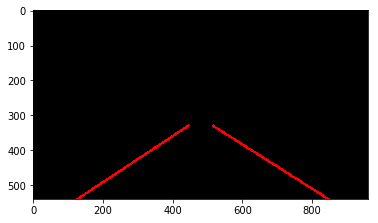

 66%|██████▋   | 452/682 [03:48<01:32,  2.49it/s]

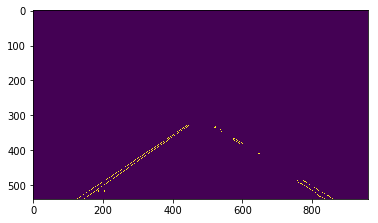

[[-0.7027027 ]
 [-0.72727273]
 [-0.76470588]
 [ 0.61538462]
 [-0.68      ]
 [-0.8       ]
 [ 0.64      ]
 [ 0.59259259]
 [-0.66666667]
 [-0.66666667]
 [-0.78571429]
 [-0.66666667]
 [ 0.61111111]
 [-0.69230769]
 [ 0.54545455]
 [-0.78571429]
 [-0.75      ]
 [-0.58333333]
 [-0.8       ]
 [-0.73684211]
 [-0.63636364]
 [-0.72222222]
 [-0.6       ]
 [ 0.69230769]
 [ 0.61538462]
 [-0.8       ]
 [ 0.57142857]
 [-0.63636364]]
left_m = -0.669094656663  right_m = 0.625144722867
left_c = 627.167939174  right_c = 7.65242711694
left_y = 328.751722303  right_y = 365.86035332  min y = 328.751722303
left_y = 542.192917778  right_y = 537.150007386  max y = 542.192917778


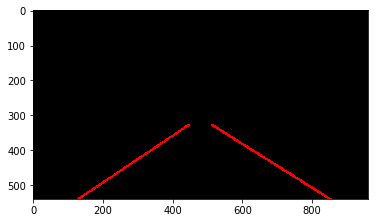

 66%|██████▋   | 453/682 [03:48<01:34,  2.44it/s]

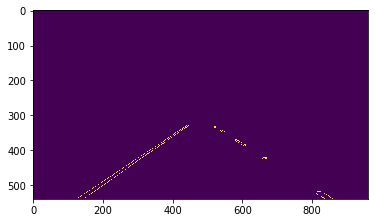

[[-0.67073171]
 [-0.67226891]
 [-0.70454545]
 [-0.72093023]
 [-0.6875    ]
 [-0.66666667]
 [-0.65      ]
 [-0.66666667]
 [ 0.61538462]
 [-0.75      ]
 [ 0.5       ]
 [ 0.55555556]
 [ 0.55555556]
 [-0.7       ]
 [-0.73333333]
 [-0.6       ]
 [-0.70588235]
 [-0.75      ]
 [ 0.58333333]
 [ 0.4       ]
 [ 0.63636364]]
left_m = -0.67917348851  right_m = 0.603756960278
left_c = 631.685530836  right_c = 19.8091740925
left_y = 333.52836938  right_y = 344.630418722  min y = 333.52836938
left_y = 535.242895467  right_y = 529.983805527  max y = 535.242895467


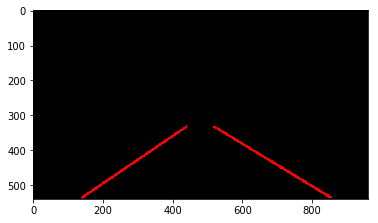

 67%|██████▋   | 454/682 [03:48<01:31,  2.51it/s]

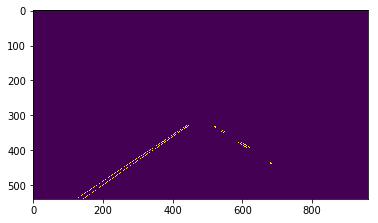

[[-0.64935065]
 [-0.8       ]
 [-0.72727273]
 [-0.72      ]
 [-0.71875   ]
 [-0.7008547 ]
 [-0.81818182]
 [-0.78571429]
 [-0.64705882]
 [-0.81818182]
 [-0.73684211]
 [ 0.66666667]
 [-0.71428571]
 [ 0.55555556]
 [-0.65384615]
 [-0.72222222]
 [-0.73333333]
 [-0.76470588]
 [ 0.58333333]
 [-0.8       ]
 [-0.64285714]]
left_m = -0.677788564359  right_m = 0.619098426247
left_c = 629.531859678  right_c = 10.2235262737
left_y = 328.593737102  right_y = 372.396105628  min y = 328.593737102
left_y = 538.030403489  right_y = 389.111763137  max y = 538.030403489


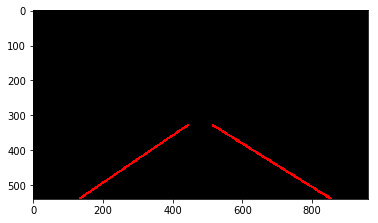

 67%|██████▋   | 455/682 [03:49<01:28,  2.57it/s]

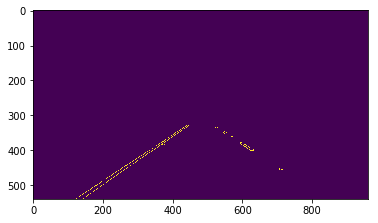

[[ 0.60606061]
 [-0.6969697 ]
 [-0.7       ]
 [-0.75      ]
 [-0.63333333]
 [-0.73913043]
 [-0.72727273]
 [-0.70588235]
 [-0.71875   ]
 [-0.725     ]
 [-0.7       ]
 [-0.72222222]
 [ 0.6       ]
 [-0.76923077]
 [ 0.5625    ]
 [-0.8       ]
 [-0.76470588]
 [ 0.6       ]
 [-0.71428571]
 [-0.72222222]
 [ 0.61538462]
 [-0.8       ]]
left_m = -0.673348723643  right_m = 0.604526616072
left_c = 626.847709082  right_c = 20.1230421444
left_y = 334.614363021  right_y = 347.171941439  min y = 334.614363021
left_y = 543.35246735  right_y = 402.183863502  max y = 543.35246735


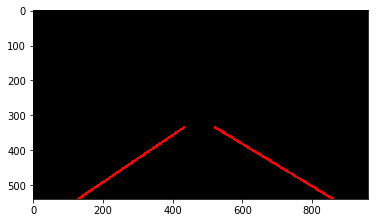

 67%|██████▋   | 456/682 [03:49<01:26,  2.62it/s]

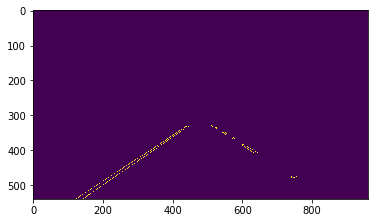

[[-0.81818182]
 [ 0.5625    ]
 [-0.66666667]
 [-0.66666667]
 [-0.68421053]
 [-0.61290323]
 [-0.77272727]
 [-0.75      ]
 [-0.625     ]
 [-0.75      ]
 [-0.78571429]
 [-0.65853659]
 [-0.59090909]
 [-0.5625    ]
 [-0.78571429]
 [-0.6       ]
 [ 0.63636364]
 [-0.5       ]
 [-0.6       ]
 [-0.81818182]
 [-0.6       ]
 [-0.81818182]
 [ 0.54545455]
 [-0.5625    ]
 [-0.63157895]
 [-0.7       ]
 [-0.8       ]]
left_m = -0.673733596726  right_m = 0.782397782398
left_c = 629.364340812  right_c = -89.2972972973
left_y = 349.091164574  right_y = 384.053361053  min y = 349.091164574
left_y = 545.821374818  right_y = 409.872487872  max y = 545.821374818


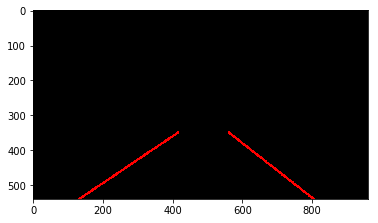

 67%|██████▋   | 457/682 [03:50<01:24,  2.66it/s]

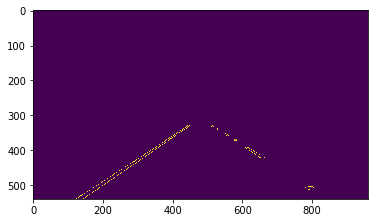

[[-0.64      ]
 [-0.7       ]
 [-0.64814815]
 [-0.57894737]
 [-0.6763285 ]
 [ 0.6       ]
 [ 0.6875    ]
 [-0.7       ]
 [-0.69565217]
 [-0.6       ]
 [ 0.6       ]
 [-0.57142857]
 [-0.67272727]
 [ 0.68965517]
 [-0.67213115]
 [-0.57142857]
 [-0.58823529]
 [-0.78571429]
 [ 0.57894737]
 [ 0.7       ]
 [ 0.6       ]]
left_m = -0.651782445463  right_m = 0.618410470132
left_c = 621.018438546  right_c = 13.7931041686
left_y = 332.278815206  right_y = 351.445220861  min y = 332.278815206
left_y = 540.197415308  right_y = 423.799245866  max y = 540.197415308


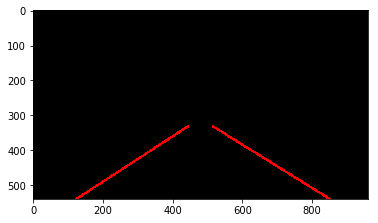

 67%|██████▋   | 458/682 [03:50<01:23,  2.69it/s]

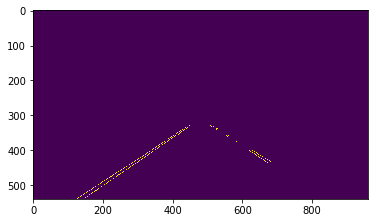

[[-0.6969697 ]
 [-0.65432099]
 [-0.68253968]
 [-0.75      ]
 [-0.5       ]
 [-0.66101695]
 [-0.75      ]
 [-0.78571429]
 [-0.69387755]
 [-0.68181818]
 [ 0.64814815]
 [-0.63636364]
 [ 0.625     ]
 [-0.59090909]
 [-0.75      ]
 [-0.63636364]
 [ 0.5       ]
 [-0.83333333]
 [-0.6875    ]
 [-0.63636364]]
left_m = -0.658680493141  right_m = 0.585513259968
left_c = 625.832058883  right_c = 35.8462926213
left_y = 334.036600422  right_y = 398.279000541  min y = 334.036600422
left_y = 535.592831323  right_y = 436.337362439  max y = 535.592831323


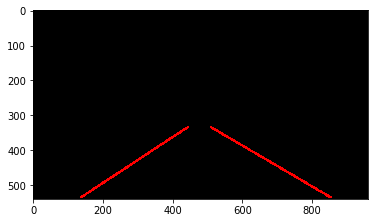

 67%|██████▋   | 459/682 [03:50<01:27,  2.56it/s]

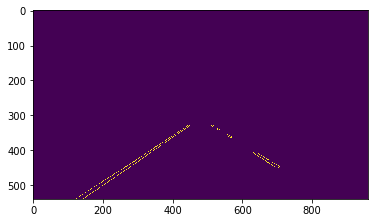

[[-0.71428571]
 [-0.63636364]
 [-0.76923077]
 [-0.78571429]
 [-0.57894737]
 [-0.62222222]
 [-0.59259259]
 [-0.71428571]
 [-0.75      ]
 [-0.65      ]
 [-0.6       ]
 [ 0.5952381 ]
 [ 0.66666667]
 [-0.75      ]
 [-0.78571429]
 [-0.625     ]
 [ 0.5625    ]
 [-0.64285714]
 [-0.65384615]
 [-0.5       ]
 [-0.72727273]
 [ 0.57142857]
 [-0.75      ]
 [-0.75      ]
 [-0.75      ]
 [ 0.63636364]
 [-0.63636364]]
left_m = -0.663920565513  right_m = 0.541564681353
left_c = 626.381166441  right_c = 66.2844257094
left_y = 332.928276484  right_y = 408.011739643  min y = 332.928276484
left_y = 544.718936883  right_y = 445.379702656  max y = 544.718936883


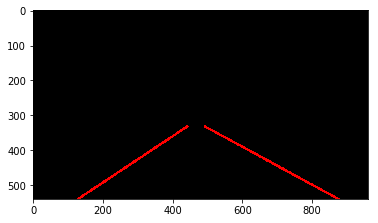

 67%|██████▋   | 460/682 [03:51<01:24,  2.63it/s]

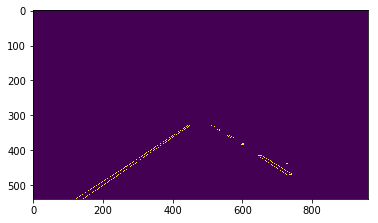

[[-0.83333333]
 [-0.64705882]
 [-0.68333333]
 [-0.68      ]
 [-0.63157895]
 [ 0.58974359]
 [-0.75      ]
 [-0.57894737]
 [ 0.54545455]
 [ 0.64285714]
 [-0.61538462]
 [-0.71428571]
 [ 0.61538462]
 [ 0.57142857]
 [ 0.6       ]
 [-0.6       ]
 [-0.7       ]
 [-0.68421053]
 [-0.61538462]
 [-0.75      ]
 [-0.58823529]
 [-0.58823529]
 [-0.63157895]
 [ 0.61538462]
 [ 0.54545455]
 [-0.73913043]]
left_m = -0.664970780492  right_m = 0.627398302559
left_c = 627.541581728  right_c = 6.74573678678
left_y = 333.62449675  right_y = 355.579193009  min y = 333.62449675
left_y = 538.435497142  right_y = 472.275277285  max y = 538.435497142


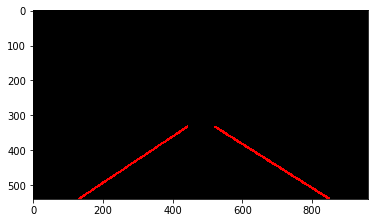

 68%|██████▊   | 461/682 [03:51<01:22,  2.68it/s]

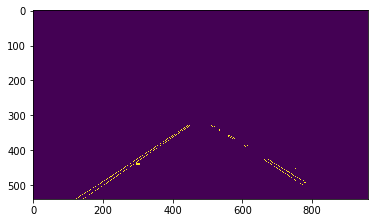

[[-0.67175573]
 [ 0.58974359]
 [-0.66666667]
 [-0.70967742]
 [-0.70175439]
 [-0.81818182]
 [-0.57142857]
 [-0.69491525]
 [ 0.65277778]
 [ 0.57142857]
 [-0.57142857]
 [ 0.7       ]
 [-0.68965517]
 [-0.65714286]
 [ 0.57142857]
 [-0.71428571]
 [ 0.59259259]
 [-0.72727273]
 [-0.6       ]
 [-0.66666667]
 [-0.75      ]
 [-0.6875    ]]
left_m = -0.664568845251  right_m = 0.582224896765
left_c = 626.627989067  right_c = 39.1210288228
left_y = 328.901146394  right_y = 425.718360275  min y = 328.901146394
left_y = 527.607231124  right_y = 490.927548712  max y = 527.607231124


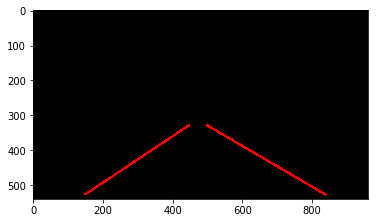

 68%|██████▊   | 462/682 [03:51<01:21,  2.68it/s]

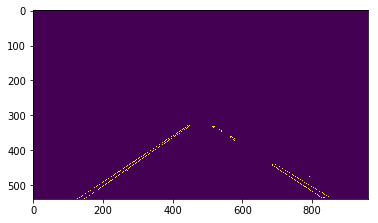

[[-0.63461538]
 [-0.69767442]
 [ 0.5       ]
 [ 0.64285714]
 [ 0.5       ]
 [-0.75      ]
 [-0.73684211]
 [-0.68      ]
 [-0.76923077]
 [ 0.63636364]
 [ 0.5       ]
 [-0.61111111]
 [-0.72222222]
 [-0.57894737]
 [-0.68571429]
 [-0.75      ]
 [ 0.66666667]
 [ 0.6       ]
 [ 0.57142857]
 [ 0.69444444]
 [-0.57142857]
 [ 0.58823529]
 [-0.76923077]
 [ 0.61538462]
 [-0.8       ]
 [ 0.53846154]
 [-0.81818182]
 [ 0.72727273]
 [ 0.5625    ]
 [-0.76923077]
 [-0.58333333]
 [ 0.6       ]
 [ 0.        ]]
left_m = -0.654782937931  right_m = 0.63246814931
left_c = 623.294301385  right_c = 4.903825899
left_y = 330.606328129  right_y = 364.778202857  min y = 330.606328129
left_y = 533.589038888  right_y = 539.971880216  max y = 539.971880216


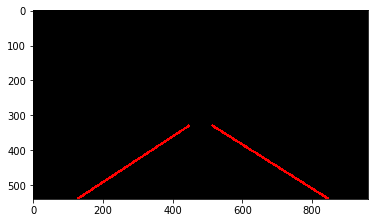

 68%|██████▊   | 463/682 [03:52<01:23,  2.62it/s]

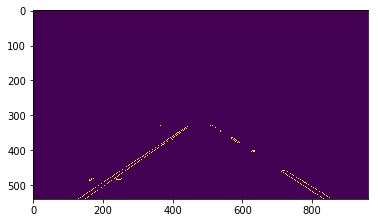

[[-0.61111111]
 [ 0.60784314]
 [-0.67692308]
 [-0.67391304]
 [-0.7       ]
 [ 0.75      ]
 [-0.7       ]
 [-0.54545455]
 [-0.76923077]
 [ 0.65      ]
 [ 0.57142857]
 [-0.64285714]
 [ 0.54545455]
 [-0.8       ]
 [-0.58823529]
 [-0.83333333]
 [ 0.53846154]
 [ 0.8       ]
 [-0.66666667]
 [ 0.53333333]
 [-0.66666667]
 [-0.81818182]
 [ 0.76923077]
 [ 0.        ]]
left_m = -0.666764867615  right_m = 0.60957742441
left_c = 629.732686466  right_c = 18.6449442344
left_y = 334.355850113  right_y = 364.884921299  min y = 334.355850113
left_y = 542.386488809  right_y = 539.224064681  max y = 542.386488809


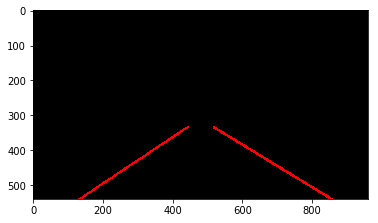

 68%|██████▊   | 464/682 [03:52<01:26,  2.52it/s]

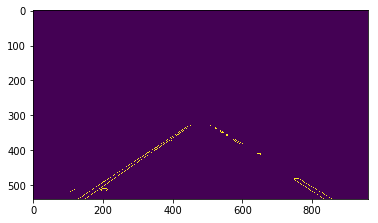

[[-0.68571429]
 [-0.83333333]
 [-0.61111111]
 [-0.66972477]
 [-0.68965517]
 [ 0.66666667]
 [-0.81818182]
 [-0.69230769]
 [ 0.6875    ]
 [-0.8       ]
 [-0.72727273]
 [-0.77272727]
 [-0.625     ]
 [-0.75      ]
 [ 0.59090909]
 [ 0.61904762]
 [-0.69230769]
 [-0.84615385]
 [ 0.61111111]
 [-0.6       ]
 [ 0.59090909]
 [ 0.5       ]
 [-0.6       ]
 [-0.66666667]
 [ 0.5       ]
 [ 0.        ]
 [-0.58333333]
 [-0.71428571]
 [ 0.6       ]
 [-0.81818182]
 [ 0.        ]]
left_m = -0.685316458282  right_m = 0.621870549648
left_c = 636.533437541  right_c = 12.3387821215
left_y = 334.308879438  right_y = 368.67060707  min y = 334.308879438
left_y = 546.756981506  right_y = 540.306878773  max y = 546.756981506


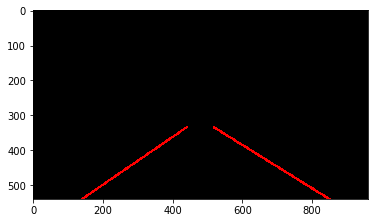

 68%|██████▊   | 465/682 [03:53<01:25,  2.55it/s]

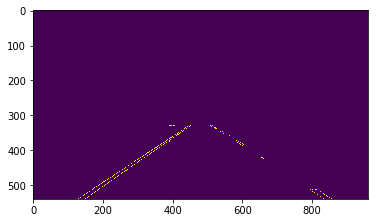

[[-0.67058824]
 [-0.69871795]
 [ 0.66666667]
 [-0.75      ]
 [-0.67391304]
 [-0.71428571]
 [-0.72413793]
 [ 0.        ]
 [-0.71428571]
 [ 0.6       ]
 [-0.7826087 ]
 [-0.68965517]
 [-0.8       ]
 [-0.73333333]
 [ 0.53333333]
 [-0.8       ]
 [ 0.73913043]
 [ 0.66666667]
 [-0.76923077]
 [-0.73333333]
 [-0.72727273]]
left_m = -0.678714462185  right_m = 0.63794980928
left_c = 633.786485336  right_c = 2.03807861512
left_y = 327.686262891  right_y = 370.13511857  min y = 327.686262891
left_y = 545.553605252  right_y = 544.295416503  max y = 545.553605252


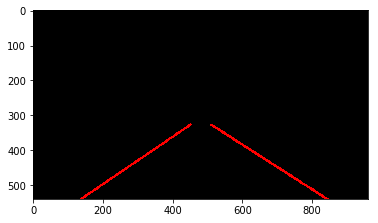

 68%|██████▊   | 466/682 [03:53<01:22,  2.62it/s]

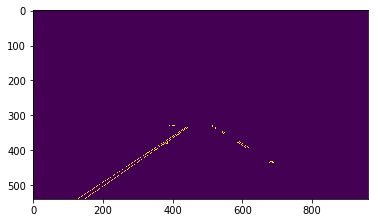

[[-0.76923077]
 [-0.70967742]
 [-0.62962963]
 [-0.5625    ]
 [-0.63043478]
 [-0.76470588]
 [-0.57894737]
 [-0.61290323]
 [-0.79166667]
 [-0.66666667]
 [-0.61538462]
 [-0.65      ]
 [-0.66666667]
 [-0.7       ]
 [-0.65      ]
 [-0.81818182]
 [-0.77777778]
 [-0.5625    ]
 [ 0.61538462]
 [ 0.66666667]
 [-0.54545455]
 [ 0.61111111]
 [-0.69230769]
 [ 0.63636364]
 [-0.6       ]
 [-0.58333333]]
left_m = -0.66302720289  right_m = 0.658640226629
left_c = 628.993985096  right_c = -12.592776204
left_y = 330.631743795  right_y = 374.687677054  min y = 330.631743795
left_y = 540.811367111  right_y = 393.788243626  max y = 540.811367111


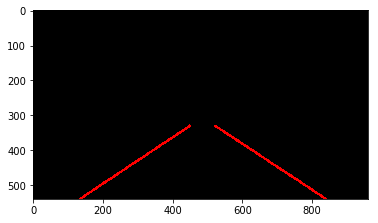

 68%|██████▊   | 467/682 [03:53<01:22,  2.62it/s]

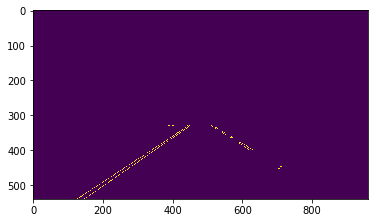

[[-0.58333333]
 [-0.76470588]
 [-0.6744186 ]
 [-0.63461538]
 [-0.58333333]
 [-0.67647059]
 [ 0.56      ]
 [-0.83333333]
 [-0.66666667]
 [ 0.62962963]
 [-0.625     ]
 [-0.6969697 ]
 [-0.76470588]
 [-0.75      ]
 [-0.81818182]
 [ 0.58823529]
 [-0.81818182]
 [-0.69565217]
 [ 0.6       ]
 [-0.6       ]
 [-0.78571429]
 [-0.6       ]
 [-0.76470588]
 [ 0.5625    ]
 [-0.76923077]
 [ 0.6       ]
 [-0.61538462]
 [-0.75      ]
 [-0.6       ]]
left_m = -0.672880783233  right_m = 0.618408495604
left_c = 632.850822932  right_c = 12.6510521364
left_y = 331.400232044  right_y = 347.828456754  min y = 331.400232044
left_y = 546.722082678  right_y = 401.629995871  max y = 546.722082678


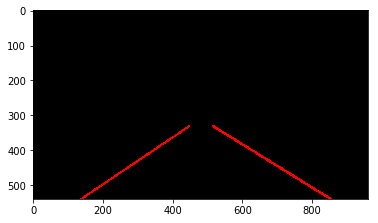

 69%|██████▊   | 468/682 [03:54<01:19,  2.68it/s]

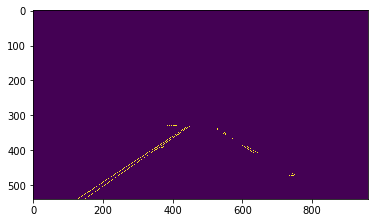

[[-0.73170732]
 [-0.81818182]
 [-0.75      ]
 [-0.65517241]
 [-0.77777778]
 [-0.63157895]
 [-0.6       ]
 [-0.76923077]
 [-0.76923077]
 [-0.8       ]
 [-0.57894737]
 [-0.66666667]
 [ 0.63636364]
 [-0.57142857]
 [-0.54545455]
 [-0.71794872]
 [-0.73333333]
 [-0.61538462]
 [ 0.        ]
 [ 0.60869565]
 [-0.6       ]
 [-0.73913043]
 [-0.70588235]
 [-0.75      ]
 [ 0.58064516]
 [ 0.54545455]
 [-0.8       ]
 [-0.63636364]]
left_m = -0.664214903115  right_m = 0.494488977956
left_c = 629.474360943  right_c = 89.7973446894
left_y = 341.205092991  right_y = 386.490731463  min y = 341.205092991
left_y = 543.126423538  right_y = 407.753757515  max y = 543.126423538


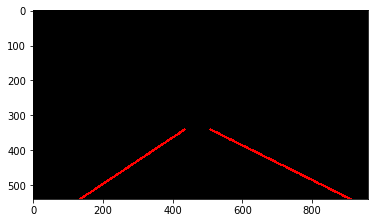

 69%|██████▉   | 469/682 [03:54<01:18,  2.70it/s]

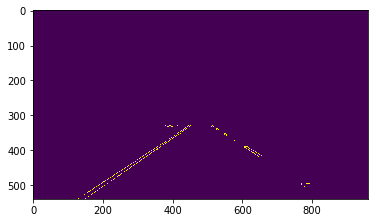

[[-0.75      ]
 [-0.6875    ]
 [-0.70588235]
 [ 0.66666667]
 [-0.75      ]
 [-0.76470588]
 [ 0.6       ]
 [-0.78571429]
 [-0.76470588]
 [-0.69491525]
 [-0.66666667]
 [-0.8       ]
 [-0.81818182]
 [-0.625     ]
 [-0.8       ]
 [-0.78571429]
 [-0.72727273]
 [-0.5625    ]
 [-0.8       ]
 [-0.58333333]
 [ 0.58333333]
 [-0.8       ]
 [-0.6       ]
 [ 0.        ]
 [-0.69230769]
 [-0.76923077]]
left_m = -0.660210284958  right_m = 0.612503021026
left_c = 628.07640486  right_c = 17.9231853702
left_y = 330.981776629  right_y = 352.349834851  min y = 330.981776629
left_y = 542.909278101  right_y = 414.825142995  max y = 542.909278101


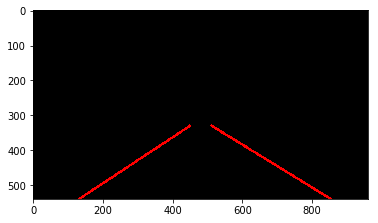

 69%|██████▉   | 470/682 [03:55<01:21,  2.59it/s]

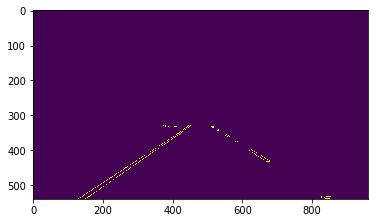

[[-0.69902913]
 [-0.75      ]
 [-0.63636364]
 [-0.70212766]
 [-0.8       ]
 [-0.8       ]
 [-0.75      ]
 [-0.72340426]
 [ 0.59574468]
 [-0.81818182]
 [ 0.61904762]
 [-0.73684211]
 [-0.73333333]
 [-0.72222222]
 [-0.75      ]
 [ 0.5       ]
 [-0.69230769]
 [-0.61538462]
 [-0.69230769]
 [ 0.58333333]
 [-0.70588235]]
left_m = -0.66808102891  right_m = 0.570143082972
left_c = 630.678628249  right_c = 45.6423736371
left_y = 329.374084211  right_y = 396.280369665  min y = 329.374084211
left_y = 530.466473913  right_y = 427.068096145  max y = 530.466473913


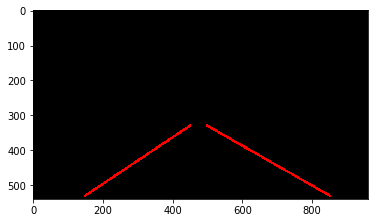

 69%|██████▉   | 471/682 [03:55<01:19,  2.66it/s]

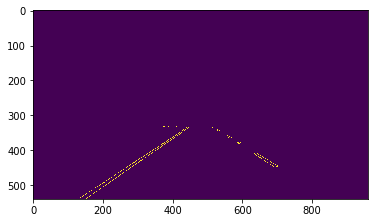

[[-0.58333333]
 [-0.83333333]
 [-0.83333333]
 [-0.61111111]
 [-0.64957265]
 [-0.64864865]
 [-0.75      ]
 [ 0.63636364]
 [ 0.57142857]
 [-0.58333333]
 [-0.85714286]
 [-0.71929825]
 [ 0.5       ]
 [-0.64285714]
 [-0.6       ]
 [-0.5       ]
 [-0.64285714]
 [-0.625     ]
 [ 0.5       ]
 [ 0.63636364]
 [-0.6       ]
 [-0.6       ]]
left_m = -0.678011627874  right_m = 0.55736337088
left_c = 637.318638157  right_c = 55.7042136003
left_y = 330.17937073  right_y = 414.646224447  min y = 330.17937073
left_y = 540.362975371  right_y = 446.973299958  max y = 540.362975371


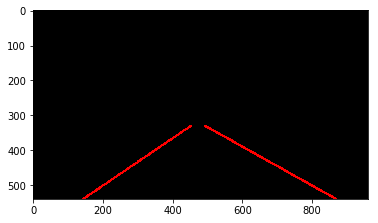

 69%|██████▉   | 472/682 [03:55<01:17,  2.69it/s]

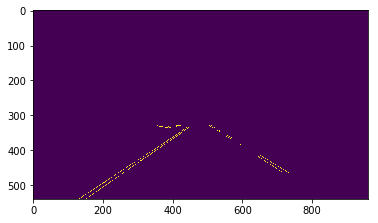

[[-0.6744186 ]
 [-0.67924528]
 [ 0.61971831]
 [-0.65789474]
 [ 0.61904762]
 [-0.70588235]
 [ 0.61290323]
 [ 0.5       ]
 [-0.76923077]
 [-0.69444444]
 [ 0.57142857]
 [-0.76923077]
 [-0.66666667]
 [-0.67692308]
 [-0.7       ]
 [-0.81818182]
 [-0.7       ]
 [-0.7       ]
 [-0.69565217]
 [-0.75      ]
 [-0.66666667]
 [ 0.6       ]
 [-0.72727273]]
left_m = -0.664029004109  right_m = 0.640145277358
left_c = 630.385356331  right_c = 3.3998473535
left_y = 343.524826556  right_y = 358.680476287  min y = 343.524826556
left_y = 542.069498785  right_y = 464.944592329  max y = 542.069498785


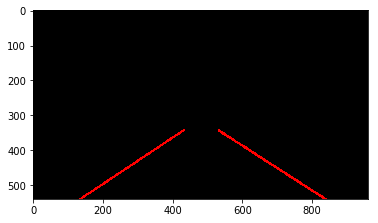

 69%|██████▉   | 473/682 [03:56<01:18,  2.67it/s]

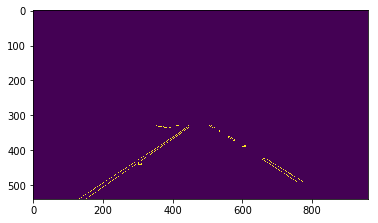

[[-0.73913043]
 [ 0.52631579]
 [-0.65909091]
 [ 0.57894737]
 [-0.66666667]
 [-0.57142857]
 [-0.66666667]
 [ 0.5       ]
 [-0.8       ]
 [-0.7       ]
 [ 0.63636364]
 [-0.72727273]
 [ 0.7       ]
 [ 0.5625    ]
 [ 0.        ]
 [-0.8       ]
 [-0.8       ]
 [-0.6875    ]
 [-0.78571429]
 [-0.8       ]
 [-0.58333333]
 [-0.6       ]
 [-0.75      ]
 [-0.58333333]
 [-0.64705882]
 [ 0.53333333]
 [ 0.69230769]
 [ 0.        ]
 [-0.64285714]
 [-0.61538462]
 [ 0.66666667]
 [ 0.61538462]
 [ 0.52941176]
 [ 0.63636364]]
left_m = -0.681353448203  right_m = 0.623031960967
left_c = 637.395627996  right_c = 12.6927985261
left_y = 348.501765958  right_y = 361.590696668  min y = 348.501765958
left_y = 533.829903869  right_y = 493.673472393  max y = 533.829903869


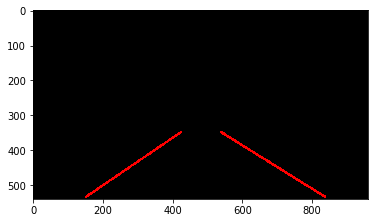

 70%|██████▉   | 474/682 [03:56<01:16,  2.71it/s]

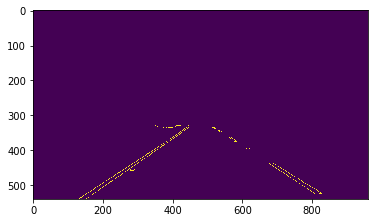

[[-0.72222222]
 [ 0.76923077]
 [ 0.56521739]
 [-0.68292683]
 [-0.8       ]
 [-0.64285714]
 [-0.72      ]
 [-0.8       ]
 [-0.57894737]
 [-0.625     ]
 [-0.7       ]
 [ 0.33333333]
 [ 0.72727273]
 [ 0.66666667]
 [-0.61111111]
 [-0.6       ]
 [-0.61111111]
 [ 0.63636364]
 [-0.72222222]
 [ 0.53333333]
 [ 0.61538462]
 [-0.78571429]
 [ 0.61538462]
 [-0.72727273]
 [ 0.58823529]
 [-0.78571429]
 [ 0.625     ]
 [-0.75      ]
 [-0.54545455]
 [-0.7       ]
 [ 0.53846154]
 [-0.72727273]
 [-0.72727273]]
left_m = -0.66629101241  right_m = 0.606835085817
left_c = 631.150553155  right_c = 24.8732671136
left_y = 332.652179595  right_y = 367.128255515  min y = 332.652179595
left_y = 539.202393442  right_y = 526.725883084  max y = 539.202393442


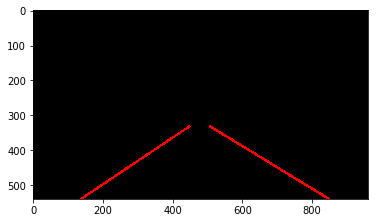

 70%|██████▉   | 475/682 [03:56<01:22,  2.50it/s]

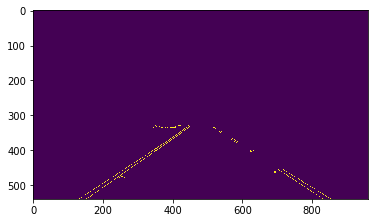

[[-0.68055556]
 [-0.72      ]
 [-0.66666667]
 [ 0.45454545]
 [-0.76923077]
 [ 0.        ]
 [-0.67307692]
 [ 0.5       ]
 [ 0.72727273]
 [-0.73333333]
 [-0.72222222]
 [ 0.5       ]
 [-0.09090909]
 [-0.625     ]
 [-0.58333333]
 [-0.75      ]
 [ 0.57142857]
 [ 0.75      ]
 [-0.73684211]
 [-0.8       ]
 [-0.8       ]
 [-0.68965517]
 [-0.72222222]
 [ 0.66666667]
 [ 0.        ]
 [-0.625     ]
 [-0.69230769]
 [ 0.57894737]
 [ 0.6       ]
 [ 0.52941176]
 [-0.70588235]
 [ 0.66666667]
 [ 0.7       ]
 [ 0.6       ]]
left_m = -0.666901500097  right_m = 0.60515700159
left_c = 632.354838667  right_c = 28.7154503602
left_y = 330.915360623  right_y = 455.956293483  min y = 330.915360623
left_y = 541.656234654  right_y = 543.704058713  max y = 543.704058713


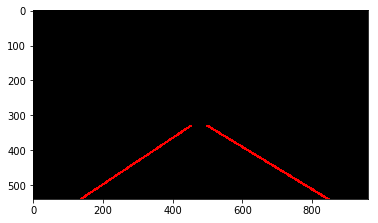

 70%|██████▉   | 476/682 [03:57<01:20,  2.56it/s]

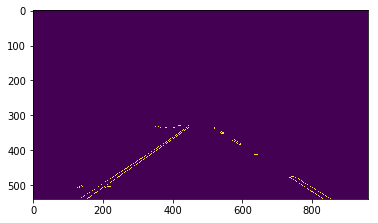

[[-0.70068027]
 [ 0.54545455]
 [-0.70588235]
 [-0.65333333]
 [-0.72727273]
 [-0.64814815]
 [-0.66666667]
 [ 0.63461538]
 [-0.6741573 ]
 [ 0.65116279]
 [-0.63157895]
 [ 0.65      ]
 [ 0.6       ]
 [-0.73076923]
 [ 0.63636364]
 [-0.66666667]
 [ 0.6       ]
 [ 0.6       ]
 [-0.7       ]
 [-0.61538462]
 [-0.71428571]
 [-0.70588235]
 [ 0.63157895]
 [ 0.57142857]
 [-0.6       ]]
left_m = -0.616004658911  right_m = 0.621474369841
left_c = 614.396370297  right_c = 13.1621074105
left_y = 339.042287764  right_y = 368.02397259  min y = 339.042287764
left_y = 536.163778615  right_y = 542.036796145  max y = 542.036796145


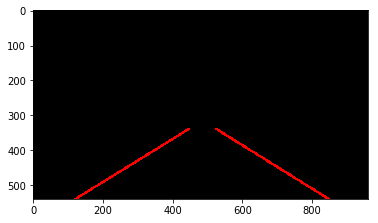

 70%|██████▉   | 477/682 [03:57<01:19,  2.59it/s]

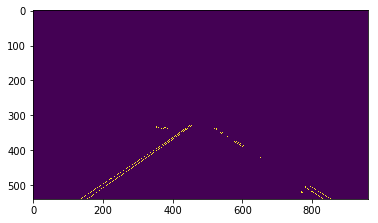

[[-0.75      ]
 [ 0.57142857]
 [-0.66666667]
 [-0.78571429]
 [-0.83333333]
 [-0.61111111]
 [-0.75      ]
 [-0.81818182]
 [-0.57142857]
 [-0.76      ]
 [-0.8       ]
 [ 0.64705882]
 [ 0.6       ]
 [-0.77777778]
 [ 0.5       ]
 [-0.58333333]
 [ 0.62222222]
 [ 0.66666667]
 [-0.76923077]
 [-0.8       ]
 [-0.66666667]
 [-0.76470588]
 [-0.66666667]
 [ 0.58333333]
 [ 0.        ]
 [-0.61538462]
 [-0.73333333]
 [ 0.54545455]
 [-0.8       ]
 [-0.63636364]
 [-0.81818182]]
left_m = -0.680552126529  right_m = 0.633409516112
left_c = 638.693429452  right_c = 6.9795318373
left_y = 335.847733147  right_y = 373.09023215  min y = 335.847733147
left_y = 540.693923232  right_y = 546.644439564  max y = 546.644439564


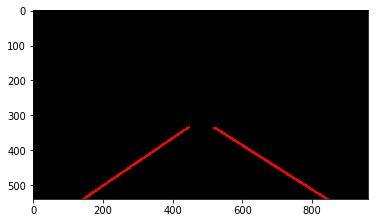

 70%|███████   | 478/682 [03:58<01:17,  2.63it/s]

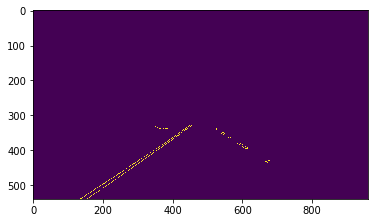

[[-0.70165746]
 [-0.65185185]
 [-0.72413793]
 [-0.70454545]
 [-0.78571429]
 [-0.75      ]
 [-0.63636364]
 [-0.6969697 ]
 [-0.65217391]
 [-0.68181818]
 [ 0.65384615]
 [-0.625     ]
 [ 0.54166667]
 [ 0.        ]
 [ 0.5       ]
 [-0.7       ]
 [-0.63636364]
 [-0.63636364]
 [-0.7       ]
 [-0.72727273]]
left_m = -0.701558425399  right_m = 0.579075425791
left_c = 645.449564787  right_c = 38.5377128954
left_y = 327.643598082  right_y = 375.559610706  min y = 327.643598082
left_y = 536.006450425  right_y = 394.090024331  max y = 536.006450425


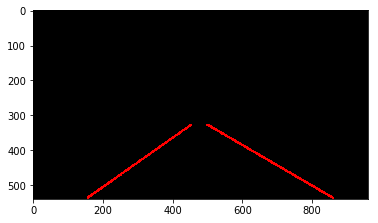

 70%|███████   | 479/682 [03:58<01:15,  2.67it/s]

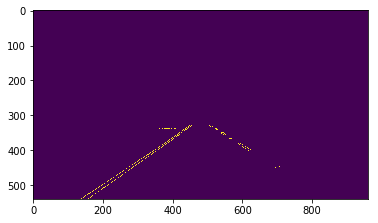

[[-0.63157895]
 [-0.68421053]
 [-0.72916667]
 [-0.7826087 ]
 [-0.6       ]
 [-0.76470588]
 [-0.8125    ]
 [-0.63636364]
 [-0.9       ]
 [-0.68571429]
 [ 0.55882353]
 [-0.6       ]
 [ 0.66666667]
 [-0.78947368]
 [-0.57894737]
 [-0.65      ]
 [ 0.        ]
 [-0.69230769]
 [-0.61538462]
 [-0.58333333]
 [-0.58823529]
 [-0.61538462]
 [ 0.        ]
 [-0.70833333]
 [-0.75      ]
 [-0.64285714]
 [-0.58823529]
 [ 0.54545455]
 [-0.76923077]
 [-0.7       ]
 [ 0.69230769]]
left_m = -0.675090805762  right_m = 0.574657280474
left_c = 636.461757505  right_c = 42.4499814746
left_y = 329.970531689  right_y = 380.923119674  min y = 329.970531689
left_y = 539.248681476  right_y = 401.610781771  max y = 539.248681476


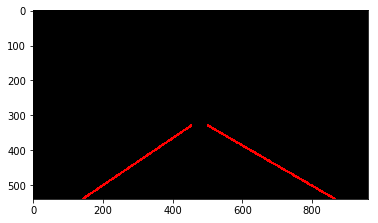

 70%|███████   | 480/682 [03:58<01:15,  2.68it/s]

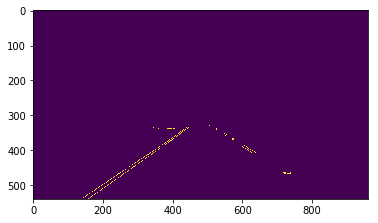

[[-0.6       ]
 [-0.69090909]
 [-0.72631579]
 [-0.77777778]
 [-0.625     ]
 [ 0.58064516]
 [-0.6       ]
 [-0.65      ]
 [-0.6       ]
 [-0.69047619]
 [-0.75      ]
 [-0.6       ]
 [-0.7       ]
 [-0.76923077]
 [-0.81818182]
 [-0.83333333]
 [ 0.61111111]
 [ 0.54545455]
 [-0.66666667]
 [-0.64705882]
 [-0.8       ]
 [-0.73333333]
 [ 0.61111111]
 [-0.6       ]
 [-0.81818182]
 [ 0.57142857]
 [-0.6       ]
 [-0.66666667]]
left_m = -0.691928574414  right_m = 0.658843409688
left_c = 643.605159216  right_c = -7.64250844912
left_y = 341.924300772  right_y = 351.427149831  min y = 341.924300772
left_y = 541.199730203  right_y = 408.746526474  max y = 541.199730203


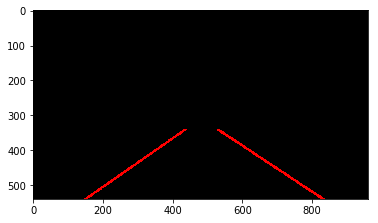

 71%|███████   | 481/682 [03:59<01:18,  2.56it/s]

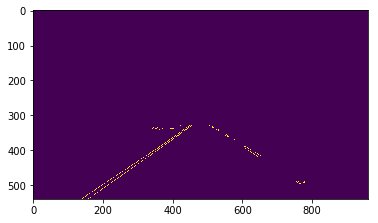

[[-0.57142857]
 [-0.69767442]
 [ 0.63414634]
 [-0.63636364]
 [ 0.625     ]
 [-0.75      ]
 [-0.75      ]
 [-0.73469388]
 [-0.81818182]
 [-0.68      ]
 [-0.76923077]
 [-0.76923077]
 [-0.77777778]
 [-0.58333333]
 [-0.58333333]
 [-0.63636364]
 [-0.75      ]
 [-0.63636364]
 [-0.6       ]
 [-0.8       ]
 [-0.81818182]
 [-0.8       ]
 [-0.8       ]
 [ 0.58333333]
 [-0.76923077]
 [-0.8       ]
 [-0.8125    ]]
left_m = -0.689062751618  right_m = 0.522906332069
left_c = 642.304501269  right_c = 75.8367863048
left_y = 330.159074786  right_y = 391.672210874  min y = 330.159074786
left_y = 541.701339532  right_y = 417.294621146  max y = 541.701339532


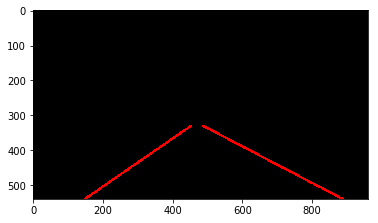

 71%|███████   | 482/682 [03:59<01:16,  2.62it/s]

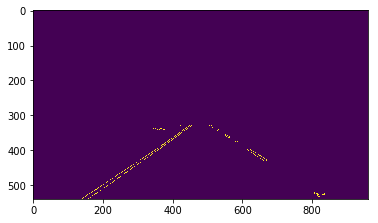

[[-0.68      ]
 [-0.8       ]
 [-0.61290323]
 [-0.77777778]
 [-0.66666667]
 [-0.5       ]
 [ 0.66666667]
 [ 0.54545455]
 [-0.58333333]
 [-0.66666667]
 [-0.66666667]
 [-0.76470588]
 [ 0.63636364]
 [ 0.54545455]
 [-0.64285714]
 [-0.64285714]
 [-0.66666667]
 [-0.8       ]
 [-0.58823529]
 [ 0.68421053]
 [-0.64285714]
 [ 0.        ]
 [-0.64285714]
 [-0.81818182]
 [-0.57142857]
 [-0.66666667]
 [-0.64285714]
 [-0.6       ]
 [-0.6       ]
 [ 0.        ]
 [-0.6       ]]
left_m = -0.685222866003  right_m = 0.661185983827
left_c = 641.535503823  right_c = -8.73989218329
left_y = 330.444322658  right_y = 354.912398922  min y = 330.444322658
left_y = 530.529399531  right_y = 428.304043127  max y = 530.529399531


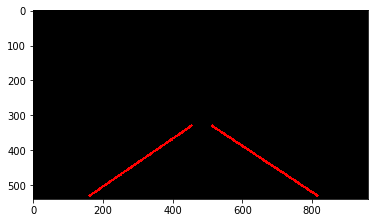

 71%|███████   | 483/682 [03:59<01:15,  2.64it/s]

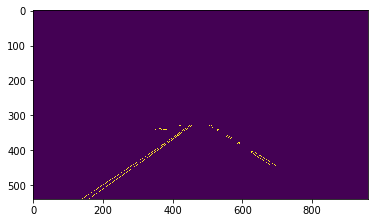

[[-0.72972973]
 [-0.71428571]
 [-0.77272727]
 [-0.8       ]
 [ 0.5       ]
 [-0.78125   ]
 [-0.5       ]
 [-0.8       ]
 [ 0.59259259]
 [-0.77272727]
 [-0.81818182]
 [-0.64705882]
 [ 0.57142857]
 [-0.8125    ]
 [-0.71428571]
 [-0.83333333]
 [ 0.61538462]
 [-0.77272727]
 [-0.75      ]
 [-0.61290323]
 [ 0.7       ]
 [ 0.5       ]
 [-0.75      ]
 [-0.83333333]
 [-0.75      ]
 [ 0.5       ]
 [ 0.58333333]
 [ 0.        ]
 [ 0.63636364]
 [-0.78571429]
 [ 0.625     ]
 [-0.66666667]
 [ 0.        ]]
left_m = -0.68131310401  right_m = 0.62430072196
left_c = 640.724463084  right_c = 12.3822322952
left_y = 334.814879383  right_y = 356.996230817  min y = 334.814879383
left_y = 537.846184378  right_y = 443.774031169  max y = 537.846184378


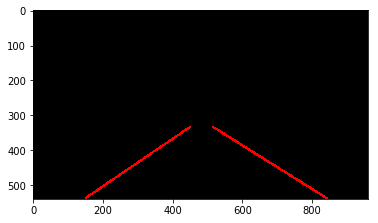

 71%|███████   | 484/682 [04:00<01:13,  2.68it/s]

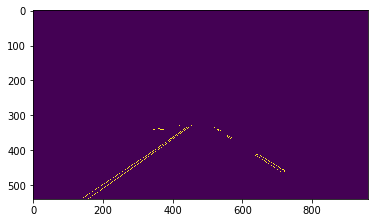

[[ 0.5       ]
 [-0.72649573]
 [-0.75      ]
 [-0.66666667]
 [ 0.64383562]
 [-0.67175573]
 [-0.77272727]
 [ 0.57692308]
 [-0.64      ]
 [-0.77777778]
 [-0.81818182]
 [-0.65      ]
 [-0.74193548]
 [-0.65384615]
 [-0.78571429]
 [ 0.53846154]
 [ 0.55      ]
 [-0.6       ]
 [ 0.        ]
 [-0.81818182]
 [ 0.        ]]
left_m = -0.709207039668  right_m = 0.621409132144
left_c = 649.158287359  right_c = 12.4274266707
left_y = 328.596705429  right_y = 408.886452979  min y = 328.596705429
left_y = 539.231196211  right_y = 459.220592682  max y = 539.231196211


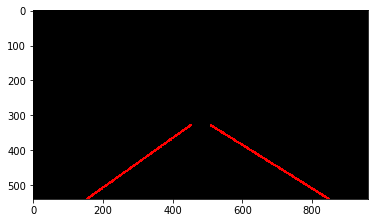

 71%|███████   | 485/682 [04:00<01:12,  2.72it/s]

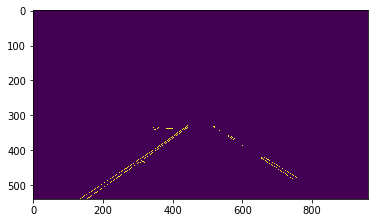

[[ 0.5       ]
 [-0.62068966]
 [-0.75      ]
 [-0.64      ]
 [-0.5625    ]
 [-0.63636364]
 [-0.69047619]
 [ 0.58333333]
 [-0.8       ]
 [-0.83333333]
 [-0.6875    ]
 [ 0.6       ]
 [ 0.61458333]
 [-0.84615385]
 [-0.6779661 ]
 [-0.68421053]
 [-0.58823529]
 [ 0.61538462]
 [-0.76923077]
 [-0.8       ]
 [-0.61904762]
 [-0.63636364]
 [ 0.8       ]
 [ 0.5625    ]
 [-0.9       ]
 [-0.85714286]
 [-0.54545455]
 [-0.58823529]
 [-0.6       ]]
left_m = -0.684266632113  right_m = 0.659619834129
left_c = 637.513213894  right_c = -10.7951861464
left_y = 332.330295972  right_y = 359.2515408  min y = 332.330295972
left_y = 544.452951927  right_y = 489.856267957  max y = 544.452951927


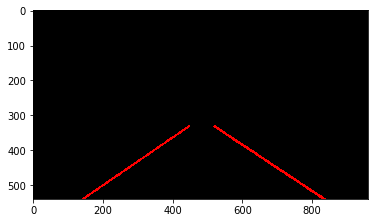

 71%|███████▏  | 486/682 [04:01<01:15,  2.60it/s]

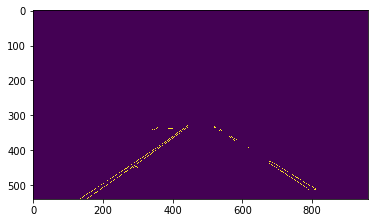

[[ 0.76923077]
 [ 0.        ]
 [-0.72413793]
 [-0.7826087 ]
 [-0.61538462]
 [-0.78571429]
 [-0.78571429]
 [-0.6       ]
 [-0.73913043]
 [-0.6       ]
 [ 0.55      ]
 [-0.76470588]
 [ 0.55555556]
 [ 0.58333333]
 [ 0.5625    ]
 [-0.68      ]
 [-0.6       ]
 [-0.83333333]
 [-0.57142857]
 [-0.75555556]
 [ 0.5       ]
 [ 0.71428571]
 [-0.54545455]
 [ 0.6       ]
 [ 0.5       ]
 [-0.8       ]
 [ 0.7       ]
 [-0.60869565]
 [-0.81818182]
 [ 0.58333333]
 [-0.81818182]
 [ 0.5       ]
 [-0.5       ]
 [-0.7       ]
 [ 0.5       ]
 [ 0.54545455]
 [ 0.        ]
 [-0.83333333]
 [-0.8       ]
 [-0.8       ]]
left_m = -0.685067417138  right_m = 0.622902205539
left_c = 637.097023807  right_c = 11.9549185212
left_y = 338.407629935  right_y = 362.025958034  min y = 338.407629935
left_y = 543.927855076  right_y = 505.916367514  max y = 543.927855076


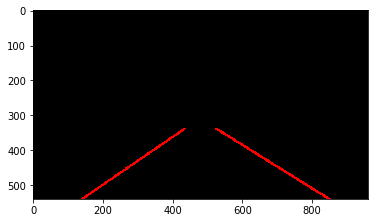

 71%|███████▏  | 487/682 [04:01<01:13,  2.64it/s]

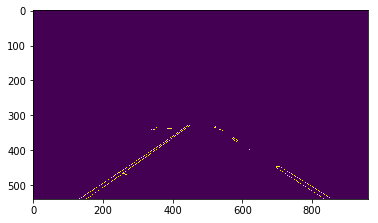

[[-0.61290323]
 [ 0.5952381 ]
 [-0.70053476]
 [-0.63157895]
 [ 0.64705882]
 [-0.75      ]
 [ 0.57142857]
 [-0.57142857]
 [ 0.5       ]
 [-0.71232877]
 [-0.70588235]
 [ 0.5       ]
 [ 0.63636364]
 [ 0.5       ]
 [-0.66666667]
 [ 0.57894737]
 [ 0.53333333]
 [-0.63636364]
 [-0.03571429]
 [ 0.6       ]
 [ 0.52941176]
 [ 0.57142857]
 [-0.58333333]
 [ 0.5       ]
 [-0.69230769]
 [-0.63636364]
 [ 0.59259259]
 [-0.6       ]
 [-0.66666667]
 [ 0.54545455]]
left_m = -0.686473920392  right_m = 0.628928994275
left_c = 635.049184031  right_c = 8.21623457191
left_y = 328.195341616  right_y = 364.818974326  min y = 328.195341616
left_y = 529.332200291  right_y = 535.887660768  max y = 535.887660768


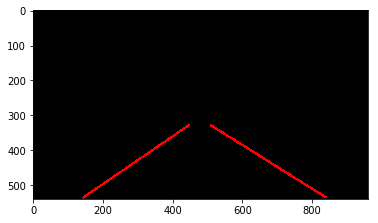

 72%|███████▏  | 488/682 [04:01<01:13,  2.65it/s]

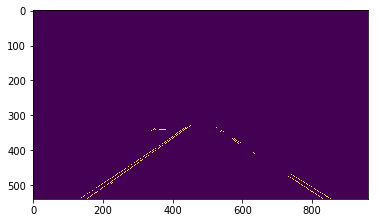

[[-0.69565217]
 [-0.675     ]
 [ 0.65048544]
 [-0.58333333]
 [-0.66666667]
 [-0.83333333]
 [ 0.57142857]
 [-0.83333333]
 [-0.70588235]
 [-0.77272727]
 [-0.70967742]
 [-0.81818182]
 [-0.75      ]
 [-0.63636364]
 [-0.6       ]
 [ 0.61956522]
 [-0.66666667]
 [ 0.61702128]
 [-0.72222222]
 [-0.75      ]
 [-0.7       ]
 [-0.66666667]
 [-0.75      ]
 [-0.64705882]
 [ 0.58333333]
 [-0.81818182]
 [ 0.        ]
 [-0.75      ]
 [-0.07142857]
 [ 0.        ]
 [-0.71428571]]
left_m = -0.677100679265  right_m = 0.6253762548
left_c = 635.705017837  right_c = 9.81004136949
left_y = 330.332611488  right_y = 371.277516644  min y = 330.332611488
left_y = 540.91092274  right_y = 542.63061046  max y = 542.63061046


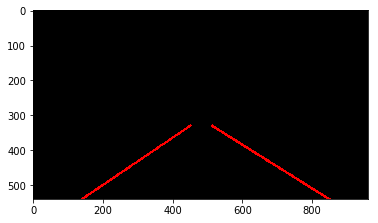

 72%|███████▏  | 489/682 [04:02<01:12,  2.68it/s]

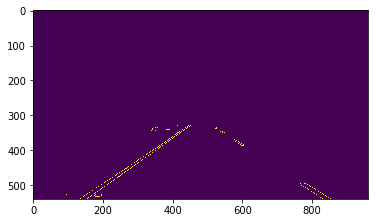

[[-0.61538462]
 [-0.77272727]
 [-0.6       ]
 [-0.65178571]
 [-0.58333333]
 [-0.8       ]
 [ 0.        ]
 [ 0.64150943]
 [-0.72727273]
 [-0.72380952]
 [ 0.625     ]
 [-0.8       ]
 [ 0.54545455]
 [-0.58333333]
 [ 0.6       ]
 [ 0.625     ]
 [-0.75      ]
 [-0.72727273]
 [ 0.58333333]
 [-0.64705882]
 [-0.78571429]
 [ 0.6       ]
 [-0.8       ]
 [ 0.5625    ]
 [-0.81818182]
 [-0.81818182]
 [-0.76923077]
 [ 0.06666667]
 [ 0.6       ]
 [-0.8       ]]
left_m = -0.708751914583  right_m = 0.61292153268
left_c = 645.461639502  right_c = 18.5993958042
left_y = 330.067037512  right_y = 373.480963226  min y = 330.067037512
left_y = 549.780131033  right_y = 540.195620115  max y = 549.780131033


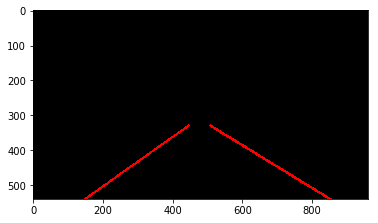

 72%|███████▏  | 490/682 [04:02<01:10,  2.71it/s]

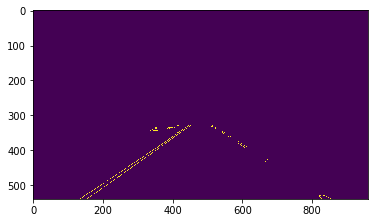

[[-0.5       ]
 [-0.75      ]
 [-0.71794872]
 [-0.6       ]
 [-0.64285714]
 [-0.6       ]
 [-0.68571429]
 [-0.81818182]
 [-0.6969697 ]
 [ 0.        ]
 [ 0.65217391]
 [-0.71875   ]
 [ 0.54545455]
 [-0.73333333]
 [-0.70967742]
 [ 0.        ]
 [-0.72727273]
 [-0.72727273]
 [-0.66666667]
 [-0.76923077]
 [-0.76470588]
 [-0.58333333]
 [-0.76923077]
 [-0.71428571]
 [-0.72727273]
 [-0.8       ]
 [-0.72727273]
 [-0.66666667]
 [-0.08333333]]
left_m = -0.685895246089  right_m = 0.495294117647
left_c = 638.267650175  right_c = 88.3258823529
left_y = 328.928894189  right_y = 377.577647059  min y = 328.928894189
left_y = 545.671791953  right_y = 390.950588235  max y = 545.671791953


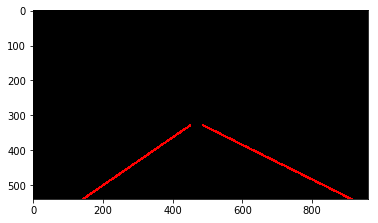

 72%|███████▏  | 491/682 [04:02<01:11,  2.67it/s]

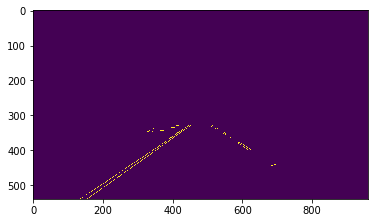

[[-0.72477064]
 [-0.7037037 ]
 [-0.6       ]
 [-0.69911504]
 [-0.81818182]
 [ 0.7037037 ]
 [-0.6       ]
 [-0.8       ]
 [-0.61538462]
 [-0.78571429]
 [-0.83333333]
 [ 0.58333333]
 [ 0.57142857]
 [-0.8       ]
 [-0.57142857]
 [ 0.        ]
 [-0.64285714]
 [-0.8       ]
 [ 0.        ]
 [-0.76923077]
 [-0.8       ]
 [-0.8       ]
 [-0.72727273]]
left_m = -0.682347334856  right_m = 0.588401697313
left_c = 636.675301277  right_c = 31.9971711457
left_y = 331.666042596  right_y = 377.977369165  min y = 331.666042596
left_y = 537.052590388  right_y = 398.571428571  max y = 537.052590388


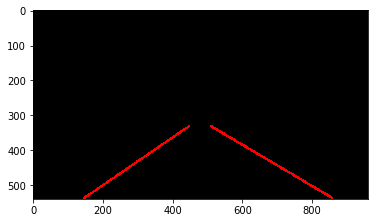

 72%|███████▏  | 492/682 [04:03<01:13,  2.59it/s]

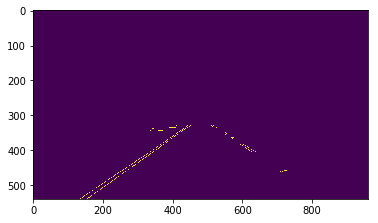

[[-0.69642857]
 [-0.76923077]
 [-0.75      ]
 [-0.63157895]
 [-0.69811321]
 [-0.69565217]
 [-0.76923077]
 [-0.78571429]
 [-0.73015873]
 [-0.5       ]
 [-0.75      ]
 [-0.81818182]
 [ 0.64285714]
 [ 0.6       ]
 [ 0.61538462]
 [-0.81818182]
 [-0.66666667]]
left_m = -0.677680216338  right_m = 0.610187696356
left_c = 634.07976138  right_c = 18.3338524744
left_y = 333.867425542  right_y = 350.275959292  min y = 333.867425542
left_y = 538.526850876  right_y = 399.701162697  max y = 538.526850876


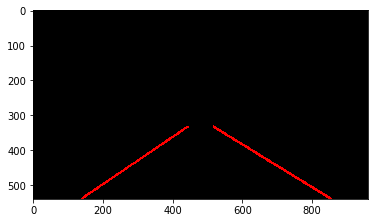

 72%|███████▏  | 493/682 [04:03<01:10,  2.67it/s]

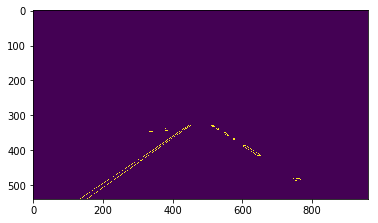

[[-0.77272727]
 [-0.65486726]
 [-0.69642857]
 [-0.8       ]
 [ 0.6       ]
 [-0.71666667]
 [-0.6       ]
 [ 0.65625   ]
 [-0.61538462]
 [-0.8       ]
 [ 0.        ]
 [-0.84615385]
 [-0.66666667]
 [-0.75      ]
 [-0.58333333]
 [-0.04545455]
 [ 0.6       ]
 [-0.81818182]
 [-0.5625    ]
 [-0.61538462]
 [ 0.5       ]
 [-0.81818182]
 [-0.69230769]]
left_m = -0.679810620603  right_m = 0.582977106488
left_c = 636.334399459  right_c = 36.3180393274
left_y = 329.059998946  right_y = 392.517051392  min y = 329.059998946
left_y = 544.559965677  right_y = 415.253158545  max y = 544.559965677


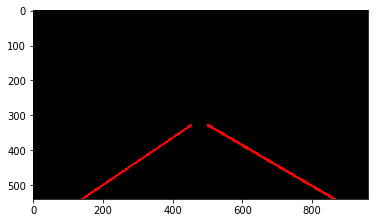

 72%|███████▏  | 494/682 [04:04<01:09,  2.70it/s]

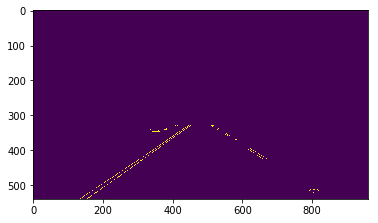

[[-0.72727273]
 [-0.76190476]
 [-0.8       ]
 [-0.70833333]
 [-0.8       ]
 [-0.75      ]
 [-0.75      ]
 [ 0.625     ]
 [-0.81818182]
 [-0.68571429]
 [-0.75      ]
 [-0.61111111]
 [-0.625     ]
 [ 0.63636364]
 [-0.72      ]
 [ 0.54545455]
 [ 0.58333333]
 [-0.63636364]
 [ 0.60869565]
 [-0.65517241]
 [-0.6       ]
 [-0.75      ]
 [-0.76923077]
 [-0.76923077]
 [ 0.63636364]]
left_m = -0.685235657816  right_m = 0.633289226269
left_c = 636.972631099  right_c = 3.95495508044
left_y = 327.931349424  right_y = 352.264029529  min y = 327.931349424
left_y = 544.465817294  right_y = 427.625447455  max y = 544.465817294


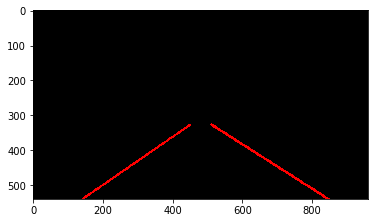

 73%|███████▎  | 495/682 [04:04<01:08,  2.72it/s]

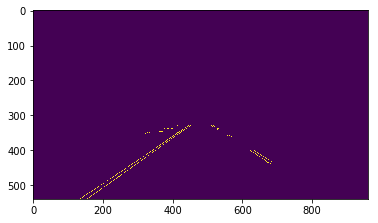

[[-0.67460317]
 [-0.77272727]
 [-0.72      ]
 [ 0.61538462]
 [-0.81818182]
 [-0.6969697 ]
 [-0.68      ]
 [-0.81818182]
 [ 0.61111111]
 [-0.74285714]
 [-0.64705882]
 [ 0.68965517]
 [-0.1       ]
 [-0.1       ]
 [-0.61538462]
 [-0.84615385]
 [-0.7826087 ]
 [-0.66666667]
 [-0.58333333]
 [-0.75      ]
 [ 0.71428571]
 [-0.64285714]]
left_m = -0.692547359679  right_m = 0.540301938045
left_c = 641.318365752  right_c = 63.8268818889
left_y = 333.827338054  right_y = 402.055895105  min y = 333.827338054
left_y = 540.206451239  right_y = 432.312803636  max y = 540.206451239


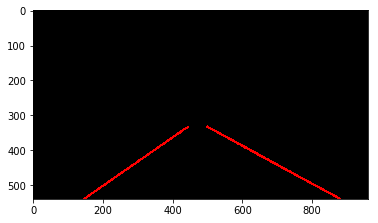

 73%|███████▎  | 496/682 [04:04<01:08,  2.72it/s]

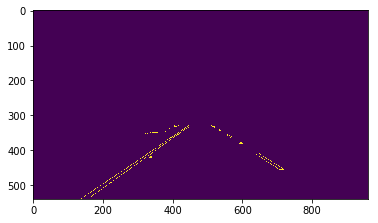

[[-0.66666667]
 [-0.65517241]
 [-0.75      ]
 [-0.8125    ]
 [-0.77272727]
 [-0.64285714]
 [-0.72340426]
 [-0.71428571]
 [ 0.58064516]
 [-0.63888889]
 [-0.78571429]
 [-0.81818182]
 [ 0.06666667]
 [-0.68965517]
 [-0.63636364]
 [-0.83333333]
 [ 0.66666667]
 [-0.71428571]
 [ 0.57692308]
 [-0.65      ]
 [ 0.57692308]
 [-0.57142857]
 [ 0.57142857]
 [ 0.5       ]
 [ 0.54545455]
 [ 0.75      ]]
left_m = -0.681803160887  right_m = 0.621607811305
left_c = 636.942086704  right_c = 10.2741431566
left_y = 328.767057983  right_y = 355.888086242  min y = 328.767057983
left_y = 543.535053663  right_y = 454.102120428  max y = 543.535053663


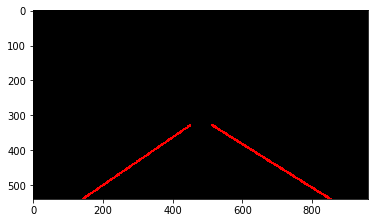

 73%|███████▎  | 497/682 [04:05<01:10,  2.62it/s]

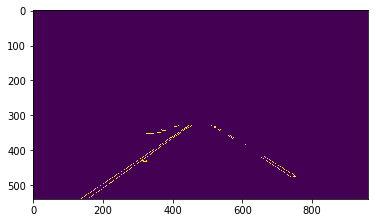

[[-0.69767442]
 [ 0.5625    ]
 [-0.8       ]
 [-0.78571429]
 [-0.70634921]
 [-0.71875   ]
 [ 0.65753425]
 [-0.69565217]
 [ 0.59259259]
 [ 0.        ]
 [-0.76923077]
 [ 0.57692308]
 [-0.68965517]
 [-0.71428571]
 [ 0.        ]
 [-0.71428571]
 [ 0.54545455]
 [-0.84615385]
 [-0.625     ]
 [-0.75      ]
 [-0.07142857]
 [-0.6875    ]
 [ 0.53333333]
 [-0.8       ]]
left_m = -0.671639905469  right_m = 0.625381400109
left_c = 632.71733937  right_c = 5.63692622598
left_y = 334.509221341  right_y = 357.101273087  min y = 334.509221341
left_y = 535.329553077  right_y = 469.044543707  max y = 535.329553077


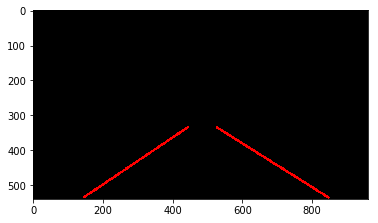

 73%|███████▎  | 498/682 [04:05<01:09,  2.66it/s]

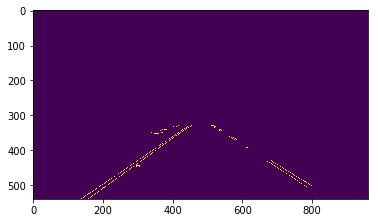

[[ 0.66666667]
 [-0.8125    ]
 [-0.6       ]
 [-0.58823529]
 [-0.8       ]
 [ 0.61111111]
 [-0.64285714]
 [-0.71428571]
 [ 0.61538462]
 [-0.61904762]
 [-0.6       ]
 [ 0.58333333]
 [ 0.69565217]
 [-0.84615385]
 [-0.72727273]
 [-0.78571429]
 [-0.64705882]
 [-0.8       ]
 [-0.83333333]
 [ 0.        ]
 [ 0.68421053]
 [-0.66666667]
 [-0.8       ]
 [-0.625     ]
 [-0.71428571]
 [-0.64285714]
 [ 0.58333333]
 [ 0.63636364]
 [-0.8       ]
 [ 0.        ]
 [-0.75      ]
 [ 0.58333333]
 [ 0.        ]
 [ 0.        ]
 [ 0.61538462]
 [-0.07142857]]
left_m = -0.702334628986  right_m = 0.624731042189
left_c = 644.492263801  right_c = 10.0168745022
left_y = 326.33467687  right_y = 361.740451255  min y = 326.33467687
left_y = 532.821057792  right_y = 505.428590958  max y = 532.821057792


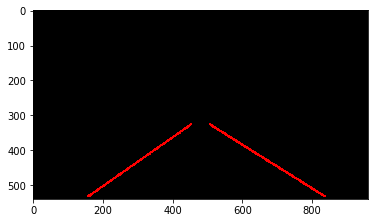

 73%|███████▎  | 499/682 [04:05<01:08,  2.66it/s]

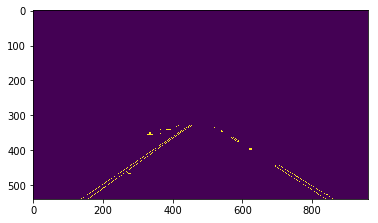

[[ 0.58823529]
 [-0.78947368]
 [-0.58333333]
 [-0.66666667]
 [-0.7037037 ]
 [ 0.65384615]
 [-0.67857143]
 [-0.73684211]
 [ 0.5       ]
 [-0.75      ]
 [ 0.55      ]
 [ 0.6       ]
 [-0.83333333]
 [ 0.61111111]
 [ 0.53846154]
 [-0.73684211]
 [-0.63636364]
 [-0.76470588]
 [ 0.65217391]
 [-0.6       ]
 [-0.69565217]
 [-0.78571429]
 [ 0.5625    ]
 [ 0.75      ]
 [-0.78571429]
 [ 0.66666667]
 [ 0.71428571]
 [ 0.5       ]
 [-0.8       ]
 [-0.8       ]
 [ 0.        ]
 [-0.66666667]
 [-0.8       ]
 [-0.6       ]
 [-0.70833333]
 [-0.69230769]]
left_m = -0.687451931778  right_m = 0.623448644279
left_c = 639.322429366  right_c = 8.62259241869
left_y = 334.781223588  right_y = 362.741422369  min y = 334.781223588
left_y = 539.641899258  right_y = 526.708415815  max y = 539.641899258


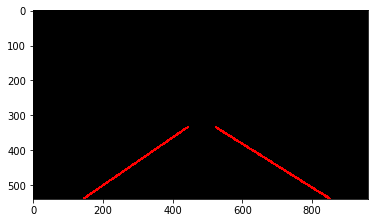

 73%|███████▎  | 500/682 [04:06<01:07,  2.69it/s]

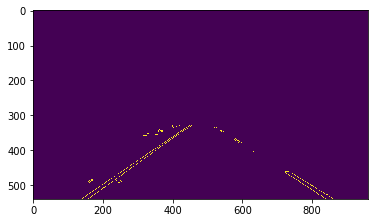

[[-0.65277778]
 [-0.76470588]
 [-0.8125    ]
 [ 0.66666667]
 [-0.81818182]
 [-0.625     ]
 [-0.625     ]
 [-0.625     ]
 [-0.75      ]
 [ 0.61290323]
 [ 0.64705882]
 [-0.81818182]
 [-0.7       ]
 [-0.76923077]
 [ 0.52380952]
 [-0.78571429]
 [-0.81818182]
 [-0.8       ]
 [-0.83333333]
 [ 0.6       ]
 [ 0.54545455]
 [-0.61904762]
 [ 0.53846154]
 [-0.6       ]
 [ 0.70967742]
 [-0.66666667]
 [-0.7       ]
 [-0.8       ]
 [-0.75      ]
 [-0.8       ]
 [-0.75      ]
 [ 0.57142857]
 [-0.05555556]
 [-0.6       ]]
left_m = -0.679377215533  right_m = 0.622531594047
left_c = 636.946056333  right_c = 8.79816794303
left_y = 328.508800481  right_y = 364.886239738  min y = 328.508800481
left_y = 533.001342356  right_y = 535.459896506  max y = 535.459896506


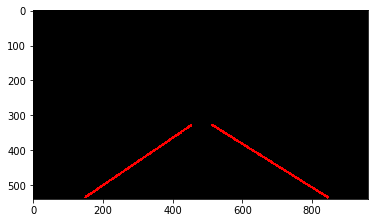

 73%|███████▎  | 501/682 [04:06<01:06,  2.72it/s]

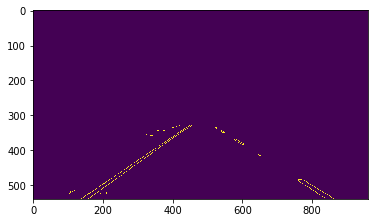

[[ 0.59756098]
 [-0.76923077]
 [-0.72      ]
 [-0.65789474]
 [-0.7238806 ]
 [-0.68965517]
 [-0.75757576]
 [ 0.6       ]
 [-0.54545455]
 [ 0.64705882]
 [ 0.5       ]
 [-0.60869565]
 [ 0.6       ]
 [-0.76923077]
 [-0.75      ]
 [ 0.56521739]
 [-0.71428571]
 [-0.73076923]
 [-0.83333333]
 [-0.8       ]
 [ 0.57692308]
 [ 0.5625    ]
 [ 0.53846154]
 [-0.76923077]
 [-0.6       ]
 [ 0.        ]
 [-0.72727273]]
left_m = -0.652535107161  right_m = 0.629568043797
left_c = 625.418619188  right_c = 5.36392742575
left_y = 334.387961394  right_y = 371.142960872  min y = 334.387961394
left_y = 557.554968043  right_y = 546.792445091  max y = 557.554968043


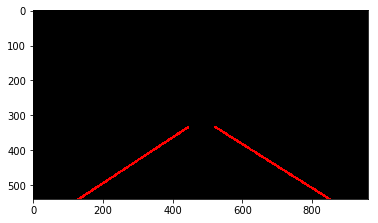

 74%|███████▎  | 502/682 [04:07<01:06,  2.72it/s]

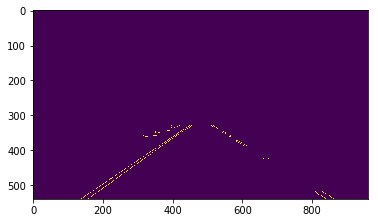

[[-0.64285714]
 [-0.75      ]
 [-0.73076923]
 [-0.66666667]
 [-0.66666667]
 [-0.6       ]
 [-0.64285714]
 [-0.6       ]
 [-0.35714286]
 [-0.72727273]
 [-0.64705882]
 [-0.73684211]
 [ 0.46153846]
 [-0.65      ]
 [-0.78571429]
 [-0.59259259]
 [ 0.59259259]
 [-0.7037037 ]
 [-0.76923077]
 [-0.70588235]
 [-0.72727273]
 [-0.71428571]
 [-0.76923077]
 [-0.57142857]
 [-0.81818182]
 [ 0.59259259]
 [ 0.54545455]
 [ 0.36363636]
 [ 0.        ]
 [-0.76470588]
 [-0.7       ]]
left_m = -0.678217102873  right_m = 0.596633447785
left_c = 636.417482287  right_c = 24.5343717723
left_y = 327.150483377  right_y = 371.775038383  min y = 327.150483377
left_y = 542.823522091  right_y = 538.235770315  max y = 542.823522091


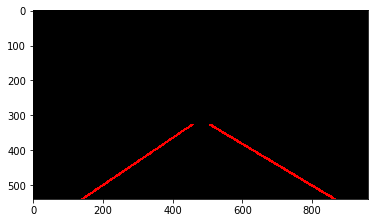

 74%|███████▍  | 503/682 [04:07<01:08,  2.61it/s]

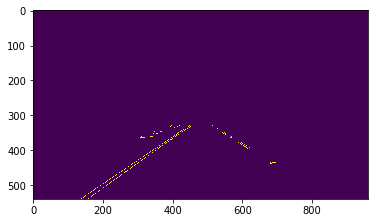

[[-0.66666667]
 [-0.71875   ]
 [-0.6       ]
 [-0.83333333]
 [-0.77272727]
 [-0.75      ]
 [-0.75      ]
 [-0.7826087 ]
 [-0.75      ]
 [-0.76923077]
 [ 0.55      ]
 [ 0.57142857]
 [-0.61538462]
 [-0.72727273]
 [-0.09090909]
 [-0.8       ]
 [-0.75      ]
 [-0.75862069]
 [-0.78571429]
 [-0.77777778]
 [ 0.58333333]
 [-0.6       ]
 [-0.78571429]
 [-0.57142857]
 [-0.1       ]
 [-0.1       ]
 [-0.63636364]]
left_m = -0.686200620748  right_m = 0.550774526678
left_c = 638.924369216  right_c = 52.3270223752
left_y = 334.251293604  right_y = 384.444061962  min y = 334.251293604
left_y = 540.111479829  right_y = 395.459552496  max y = 540.111479829


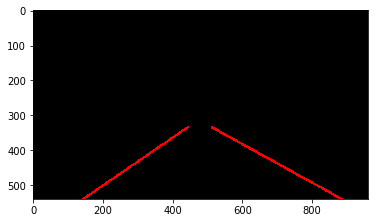

 74%|███████▍  | 504/682 [04:07<01:09,  2.58it/s]

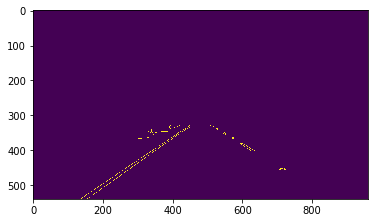

[[-0.61538462]
 [-0.70967742]
 [-0.70588235]
 [-0.70833333]
 [-0.6969697 ]
 [-0.69565217]
 [-0.6       ]
 [ 0.58823529]
 [-0.61904762]
 [-0.83333333]
 [-0.69565217]
 [-0.71428571]
 [-0.61538462]
 [ 0.58064516]
 [-0.69230769]
 [-0.57142857]
 [-0.66666667]
 [-0.72727273]
 [-0.57894737]
 [ 0.2       ]
 [-0.63636364]
 [-0.58333333]
 [-0.57142857]
 [-0.7       ]
 [-0.8       ]
 [-0.65      ]
 [-0.3       ]
 [-0.7       ]
 [-0.8       ]
 [ 0.6       ]
 [-0.58333333]]
left_m = -0.677372249016  right_m = 0.536608408125
left_c = 635.742556555  right_c = 62.859943316
left_y = 341.085628233  right_y = 381.605337742  min y = 341.085628233
left_y = 542.94255844  right_y = 403.069674067  max y = 542.94255844


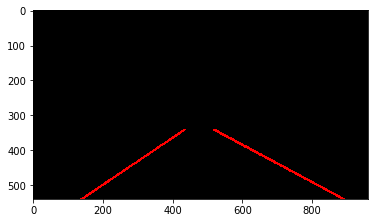

 74%|███████▍  | 505/682 [04:08<01:07,  2.63it/s]

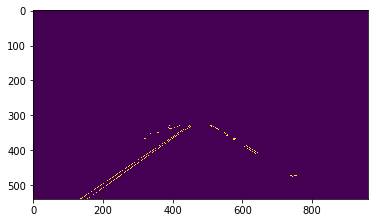

[[-0.72881356]
 [-0.63636364]
 [-0.8       ]
 [-0.64285714]
 [ 0.59259259]
 [-0.69934641]
 [-0.66037736]
 [-0.65116279]
 [-0.58823529]
 [-0.75      ]
 [-0.30769231]
 [-0.71428571]
 [ 0.64285714]
 [-0.6       ]
 [-0.63636364]
 [-0.58823529]
 [ 0.65517241]
 [-0.5625    ]
 [ 0.63636364]
 [ 0.55172414]
 [-0.7       ]
 [-0.75      ]
 [-0.07692308]
 [-0.58333333]
 [ 0.6       ]
 [-0.69230769]
 [-0.8       ]]
left_m = -0.674247032674  right_m = 0.607746522797
left_c = 633.217161008  right_c = 18.8815463939
left_y = 332.502984435  right_y = 350.711147841  min y = 332.502984435
left_y = 541.519564564  right_y = 412.701293166  max y = 541.519564564


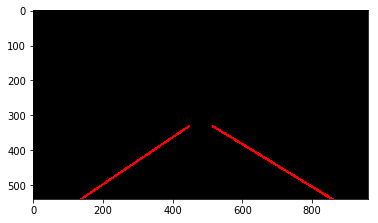

 74%|███████▍  | 506/682 [04:08<01:06,  2.67it/s]

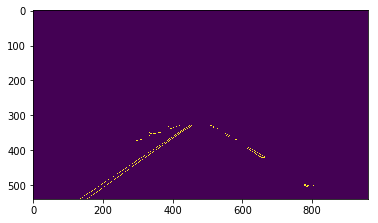

[[-0.67251462]
 [-0.69620253]
 [-0.70212766]
 [ 0.58333333]
 [ 0.60714286]
 [ 0.6       ]
 [-0.76923077]
 [-0.69444444]
 [ 0.57142857]
 [-0.36363636]
 [ 0.5625    ]
 [-0.7       ]
 [-0.625     ]
 [-0.07142857]
 [-0.66666667]
 [-0.625     ]
 [-0.72727273]
 [-0.69565217]
 [-0.72727273]
 [-0.8       ]
 [-0.81818182]
 [ 0.54545455]
 [ 0.        ]
 [-0.75      ]]
left_m = -0.678998826269  right_m = 0.601552729604
left_c = 636.483292795  right_c = 21.9883679754
left_y = 338.402808063  right_y = 352.240816528  min y = 338.402808063
left_y = 544.139452423  right_y = 416.606958595  max y = 544.139452423


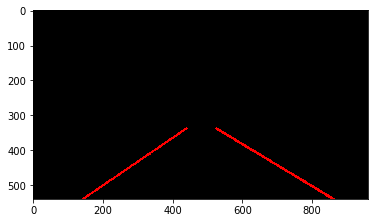

 74%|███████▍  | 507/682 [04:08<01:06,  2.64it/s]

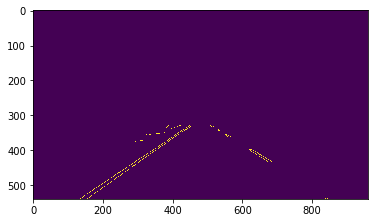

[[-0.70833333]
 [-0.62162162]
 [-0.75      ]
 [-0.64516129]
 [ 0.56756757]
 [-0.58333333]
 [-0.8       ]
 [-0.70967742]
 [ 0.625     ]
 [-0.72222222]
 [-0.61290323]
 [-0.66666667]
 [-0.71428571]
 [-0.63157895]
 [-0.69444444]
 [-0.75      ]
 [-0.75      ]
 [-0.77777778]
 [ 0.61538462]
 [-0.8125    ]
 [ 0.6       ]
 [-0.8       ]
 [-0.73333333]
 [ 0.1       ]
 [-0.66666667]
 [-0.64285714]
 [-0.65      ]
 [-0.63636364]
 [-0.35714286]]
left_m = -0.676845824353  right_m = 0.509626023457
left_c = 634.992631115  right_c = 84.7790440363
left_y = 327.704626859  right_y = 406.353064837  min y = 327.704626859
left_y = 534.819449111  right_y = 433.872870104  max y = 534.819449111


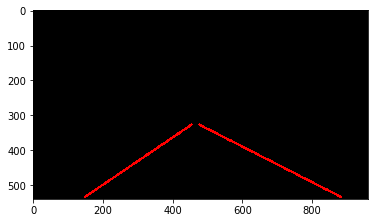

 74%|███████▍  | 508/682 [04:09<01:08,  2.54it/s]

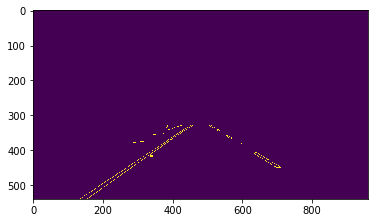

[[-0.60526316]
 [-0.75      ]
 [-0.78571429]
 [-0.66      ]
 [-0.64      ]
 [-0.75      ]
 [ 0.        ]
 [ 0.0625    ]
 [-0.58333333]
 [-0.8       ]
 [-0.6875    ]
 [-0.58333333]
 [-0.78571429]
 [-0.68      ]
 [-0.69230769]
 [ 0.75      ]
 [-0.5625    ]
 [-0.64705882]
 [-0.76923077]
 [ 0.56521739]
 [ 0.54545455]
 [-0.68965517]
 [-0.6       ]
 [-0.6       ]
 [-0.57142857]
 [-0.6       ]
 [ 0.61538462]
 [ 0.69230769]
 [-0.75      ]
 [-0.5625    ]]
left_m = -0.68001239454  right_m = 0.588933576655
left_c = 636.84689619  right_c = 33.9287486047
left_y = 326.081231885  right_y = 360.197950072  min y = 326.081231885
left_y = 543.685198138  right_y = 445.00438511  max y = 543.685198138


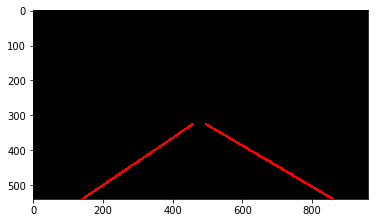

 75%|███████▍  | 509/682 [04:09<01:06,  2.61it/s]

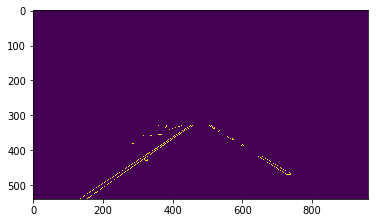

[[-0.66666667]
 [-0.71875   ]
 [-0.77777778]
 [-0.66666667]
 [-0.75      ]
 [-0.83333333]
 [-0.75      ]
 [-0.83333333]
 [ 0.59459459]
 [-0.75      ]
 [ 0.64285714]
 [-0.69444444]
 [-0.61538462]
 [ 0.55555556]
 [-0.75      ]
 [ 0.57142857]
 [-0.72727273]
 [ 0.64      ]
 [-0.81818182]
 [-0.53333333]
 [ 0.7       ]
 [-0.78571429]
 [-0.30434783]
 [-0.73684211]
 [-0.8       ]
 [-0.6       ]
 [-0.78947368]
 [ 0.69230769]
 [-0.07692308]
 [ 0.57142857]]
left_m = -0.68656000049  right_m = 0.613244882531
left_c = 639.474028143  right_c = 20.5423990427
left_y = 336.701067927  right_y = 329.617819838  min y = 329.617819838
left_y = 546.788428077  right_y = 466.371428643  max y = 546.788428077


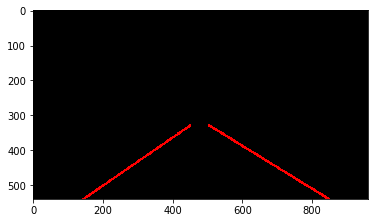

 75%|███████▍  | 510/682 [04:10<01:05,  2.64it/s]

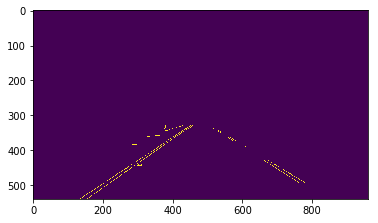

[[-0.71428571]
 [-0.70833333]
 [-0.64705882]
 [-0.83333333]
 [ 0.62686567]
 [-0.75      ]
 [-0.61538462]
 [-0.72727273]
 [-0.65625   ]
 [-0.625     ]
 [-0.78571429]
 [-0.75      ]
 [-0.6       ]
 [ 0.5625    ]
 [ 0.6031746 ]
 [-0.8       ]
 [-0.58333333]
 [ 0.6       ]
 [-0.78947368]
 [ 0.6       ]
 [-0.84615385]
 [-0.61538462]
 [-0.7       ]
 [-0.75      ]
 [-0.6       ]
 [-0.61538462]
 [ 0.6       ]
 [-0.72727273]
 [ 0.5       ]
 [-0.33333333]
 [-0.07692308]
 [-0.66666667]]
left_m = -0.691148545462  right_m = 0.607348971423
left_c = 641.345585014  right_c = 23.5724790894
left_y = 324.799551193  right_y = 363.080554115  min y = 324.799551193
left_y = 548.040531377  right_y = 494.875280914  max y = 548.040531377


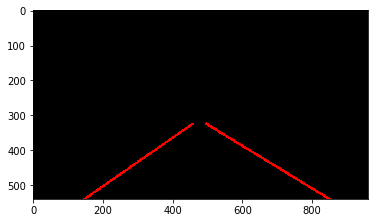

 75%|███████▍  | 511/682 [04:10<01:03,  2.69it/s]

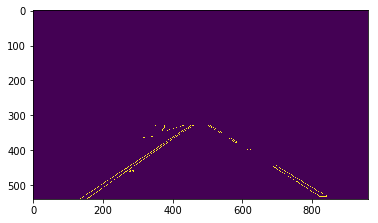

[[-0.63636364]
 [-0.61904762]
 [-0.33333333]
 [ 0.6       ]
 [ 0.61818182]
 [-0.65517241]
 [-0.7       ]
 [-0.63636364]
 [-0.671875  ]
 [-0.8       ]
 [-0.77777778]
 [ 0.625     ]
 [ 0.63636364]
 [-0.68421053]
 [-0.72222222]
 [ 0.58333333]
 [-0.66666667]
 [-0.625     ]
 [-0.8125    ]
 [-0.75      ]
 [-0.8       ]
 [-0.57142857]
 [-0.66666667]
 [ 0.6097561 ]
 [ 0.53846154]
 [ 0.58064516]
 [ 0.61290323]
 [-0.57142857]
 [-0.09090909]
 [-0.6       ]
 [ 0.5       ]
 [-0.63636364]
 [-0.66666667]
 [-0.63636364]
 [-0.66666667]
 [ 0.5625    ]]
left_m = -0.689517012078  right_m = 0.623206240013
left_c = 641.624643803  right_c = 14.5941832414
left_y = 325.825852272  right_y = 371.068152529  min y = 325.825852272
left_y = 547.850330161  right_y = 528.116125012  max y = 547.850330161


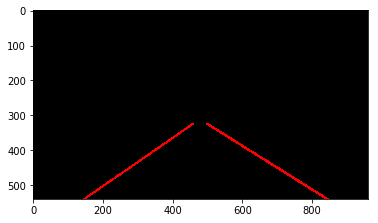

 75%|███████▌  | 512/682 [04:10<01:02,  2.70it/s]

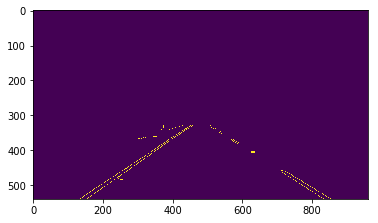

[[ 0.55      ]
 [-0.77272727]
 [-0.75      ]
 [-0.64285714]
 [-0.66666667]
 [-0.671875  ]
 [-0.72093023]
 [ 0.6509434 ]
 [ 0.6       ]
 [-0.57142857]
 [-0.73913043]
 [-0.64705882]
 [ 0.6       ]
 [-0.76      ]
 [-0.62068966]
 [ 0.57894737]
 [ 0.56756757]
 [-0.7       ]
 [-0.5625    ]
 [-0.5       ]
 [-0.83333333]
 [ 0.5       ]
 [-0.7       ]
 [-0.68181818]
 [-0.31578947]
 [-0.6       ]
 [-0.8125    ]
 [ 0.55555556]
 [-0.66666667]
 [-0.69230769]
 [-0.78571429]
 [-0.7       ]]
left_m = -0.666672637676  right_m = 0.605215759862
left_c = 632.943876623  right_c = 24.1772631247
left_y = 327.607808568  right_y = 329.206006095  min y = 327.607808568
left_y = 542.943070537  right_y = 539.821090527  max y = 542.943070537


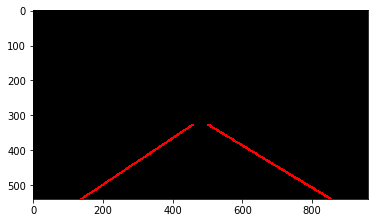

 75%|███████▌  | 513/682 [04:11<01:02,  2.71it/s]

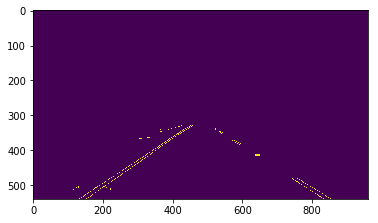

[[-0.72222222]
 [-0.71428571]
 [-0.75      ]
 [ 0.6       ]
 [-0.73076923]
 [-0.53846154]
 [-0.66666667]
 [-0.5       ]
 [-0.76923077]
 [ 0.65168539]
 [ 0.69230769]
 [ 0.58333333]
 [-0.71875   ]
 [-0.76190476]
 [-0.70588235]
 [-0.72916667]
 [ 0.36363636]
 [-0.6       ]
 [-0.81818182]
 [ 0.6       ]
 [-0.33333333]
 [-0.8       ]
 [ 0.        ]
 [-0.1       ]
 [-0.72727273]
 [-0.7       ]
 [-0.72727273]]
left_m = -0.624454267651  right_m = 0.610170332502
left_c = 616.773205003  right_c = 21.955326532
left_y = 338.26660163  right_y = 374.023608386  min y = 338.26660163
left_y = 542.463147152  right_y = 539.989938826  max y = 542.463147152


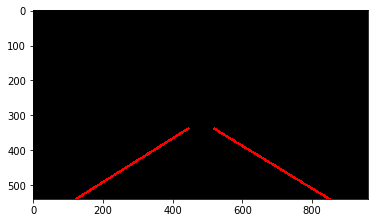

 75%|███████▌  | 514/682 [04:11<01:04,  2.61it/s]

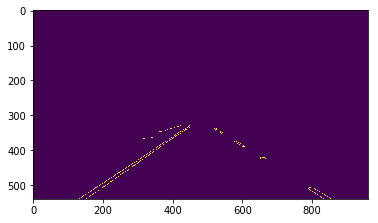

[[-0.6746988 ]
 [-0.65714286]
 [-0.625     ]
 [-0.75      ]
 [-0.625     ]
 [-0.78571429]
 [-0.68181818]
 [-0.36363636]
 [-0.63157895]
 [ 0.63636364]
 [ 0.66666667]
 [-0.75      ]
 [-0.59259259]
 [ 0.6       ]
 [-0.75      ]
 [ 0.53846154]
 [ 0.6       ]
 [ 0.        ]
 [-0.71428571]
 [ 0.6       ]
 [ 0.59090909]
 [-0.68      ]
 [-0.625     ]
 [ 0.5       ]
 [-0.53333333]
 [-0.66666667]
 [-0.8       ]
 [-0.08333333]]
left_m = -0.672677040947  right_m = 0.611272871737
left_c = 634.101553806  right_c = 20.8105943104
left_y = 328.706177216  right_y = 373.515041302  min y = 328.706177216
left_y = 539.254091032  right_y = 542.226353902  max y = 542.226353902


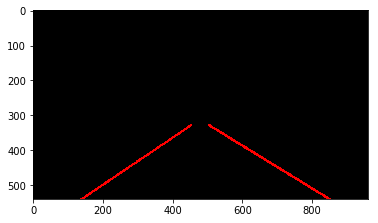

 76%|███████▌  | 515/682 [04:12<01:04,  2.59it/s]

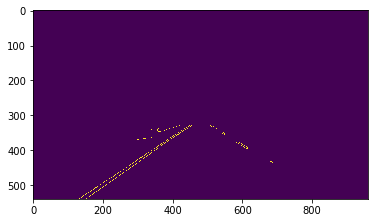

[[-0.6875    ]
 [-0.67857143]
 [-0.67521368]
 [-0.75      ]
 [-0.71428571]
 [-0.57142857]
 [-0.61538462]
 [-0.75      ]
 [-0.6       ]
 [-0.08333333]
 [ 0.09090909]
 [-0.77272727]
 [-0.75      ]
 [-0.75      ]
 [ 0.6       ]
 [-0.72727273]
 [-0.8       ]
 [-0.28571429]
 [ 0.61538462]
 [-0.81818182]
 [ 0.5625    ]
 [ 0.7       ]
 [-0.6       ]
 [-0.58333333]
 [-0.09090909]
 [ 0.58333333]
 [ 0.69230769]
 [-0.66666667]
 [-0.83333333]]
left_m = -0.667324700483  right_m = 0.53960933261
left_c = 631.796283448  right_c = 62.1733586544
left_y = 336.171441134  right_y = 376.225990233  min y = 336.171441134
left_y = 540.372799482  right_y = 394.572707542  max y = 540.372799482


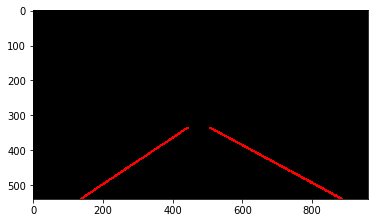

 76%|███████▌  | 516/682 [04:12<01:04,  2.59it/s]

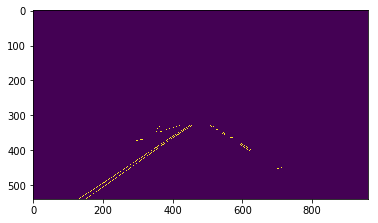

[[-0.67281106]
 [-0.65957447]
 [-0.66666667]
 [-0.58333333]
 [ 0.65517241]
 [-0.6       ]
 [-0.6       ]
 [-0.75      ]
 [-0.64      ]
 [-0.6       ]
 [-0.64285714]
 [ 0.5625    ]
 [ 0.57142857]
 [-0.32258065]
 [-0.63636364]
 [-0.64285714]
 [-0.72      ]
 [-0.63636364]]
left_m = -0.685188265419  right_m = 0.591261335532
left_c = 638.760072661  right_c = 30.7478977741
left_y = 336.592047611  right_y = 379.592085738  min y = 336.592047611
left_y = 539.407774175  right_y = 401.468755153  max y = 539.407774175


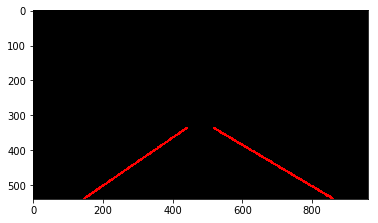

 76%|███████▌  | 517/682 [04:12<01:02,  2.64it/s]

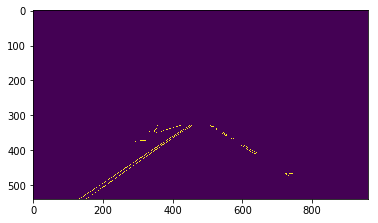

[[-0.67479675]
 [-0.72131148]
 [-0.33333333]
 [-0.69565217]
 [-0.70588235]
 [-0.71929825]
 [ 0.60526316]
 [-0.64285714]
 [ 0.62162162]
 [-0.6875    ]
 [-0.70833333]
 [-0.6       ]
 [-0.7       ]
 [-0.63636364]
 [-0.76470588]
 [-0.66666667]]
left_m = -0.700955845247  right_m = 0.592657038455
left_c = 644.427067267  right_c = 31.0897859753
left_y = 336.006495358  right_y = 384.906037933  min y = 336.006495358
left_y = 550.498984004  right_y = 410.390290586  max y = 550.498984004


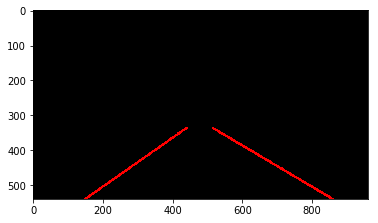

 76%|███████▌  | 518/682 [04:13<01:01,  2.67it/s]

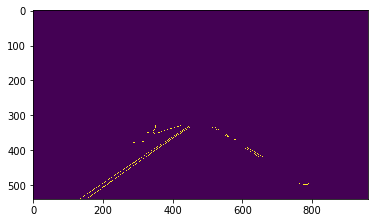

[[-0.68421053]
 [-0.6746988 ]
 [-0.8       ]
 [-0.61538462]
 [-0.63333333]
 [-0.75      ]
 [-0.27272727]
 [-0.57142857]
 [-0.76923077]
 [-0.66666667]
 [-0.6744186 ]
 [-0.75      ]
 [-0.6       ]
 [ 0.68421053]
 [-0.58823529]
 [-0.75      ]
 [-0.75      ]
 [ 0.57142857]
 [-0.36363636]
 [ 0.6       ]
 [-0.63636364]
 [-0.7826087 ]
 [-0.6       ]
 [-0.78947368]
 [-0.63636364]
 [-0.63636364]
 [-0.66666667]
 [-0.63636364]
 [-0.78571429]
 [-0.5       ]]
left_m = -0.66501007135  right_m = 0.639824736803
left_c = 630.300176579  right_c = 2.31254151765
left_y = 340.35578547  right_y = 399.003878336  min y = 340.35578547
left_y = 541.188827018  right_y = 498.17671254  max y = 541.188827018


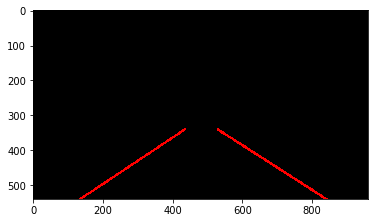

 76%|███████▌  | 519/682 [04:13<01:03,  2.57it/s]

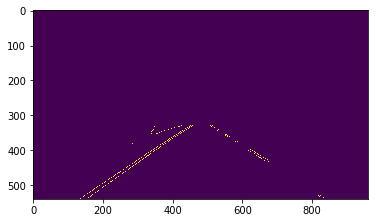

[[-0.66666667]
 [-0.81818182]
 [-0.625     ]
 [-0.6       ]
 [-0.65354331]
 [-0.63888889]
 [-0.8       ]
 [-0.65      ]
 [-0.63157895]
 [ 0.6       ]
 [-0.66666667]
 [-0.64705882]
 [-0.61538462]
 [-0.58333333]
 [-0.64948454]
 [ 0.63636364]
 [-0.58333333]
 [ 0.59459459]
 [-0.63636364]
 [-0.3       ]
 [-0.70588235]
 [-0.58333333]
 [-0.35714286]
 [ 0.        ]
 [-0.6       ]
 [ 0.        ]
 [-0.73333333]
 [-0.69230769]]
left_m = -0.663119752442  right_m = 0.559147685525
left_c = 632.60405359  right_c = 53.2798187607
left_y = 329.558326724  right_y = 397.155645359  min y = 329.558326724
left_y = 536.451689485  right_y = 430.70450649  max y = 536.451689485


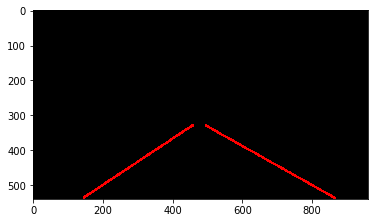

 76%|███████▌  | 520/682 [04:13<01:01,  2.62it/s]

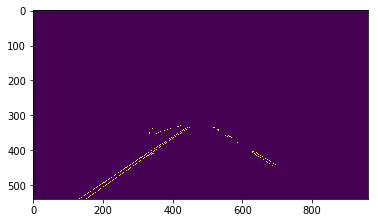

[[-0.8       ]
 [-0.81818182]
 [-0.7032967 ]
 [-0.73333333]
 [-0.67647059]
 [-0.64285714]
 [-0.625     ]
 [ 0.68421053]
 [-0.75      ]
 [ 0.61290323]
 [-0.73333333]
 [-0.57142857]
 [ 0.68421053]
 [-0.72      ]
 [-0.8       ]
 [-0.72      ]
 [-0.2       ]
 [ 0.7       ]
 [ 0.5       ]
 [-0.61538462]
 [-0.71428571]
 [ 0.6875    ]
 [ 0.62857143]
 [-0.73333333]
 [-0.29411765]
 [-0.57142857]
 [-0.27272727]]
left_m = -0.655110462816  right_m = 0.624807267575
left_c = 626.099538449  right_c = 12.6771679793
left_y = 333.920272033  right_y = 357.570779681  min y = 333.920272033
left_y = 538.969846894  right_y = 439.420531733  max y = 538.969846894


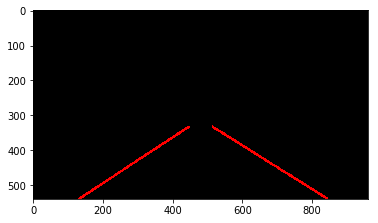

 76%|███████▋  | 521/682 [04:14<01:00,  2.66it/s]

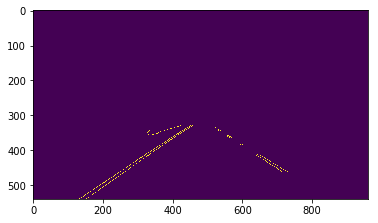

[[-0.7027027 ]
 [-0.67241379]
 [-0.61290323]
 [-0.73333333]
 [-0.625     ]
 [-0.6       ]
 [-0.6       ]
 [-0.58823529]
 [-0.30434783]
 [ 0.61538462]
 [-0.72      ]
 [-0.5625    ]
 [ 0.5       ]
 [-0.6       ]
 [-0.5       ]
 [-0.68965517]
 [ 0.61538462]
 [ 0.58823529]
 [-0.69230769]
 [-0.73333333]
 [ 0.5625    ]
 [-0.58333333]
 [ 0.5       ]
 [-0.75      ]
 [-0.64285714]
 [-0.625     ]]
left_m = -0.657025048919  right_m = 0.633552428426
left_c = 626.85458253  right_c = 6.72513123649
left_y = 333.164385663  right_y = 358.346729013  min y = 333.164385663
left_y = 539.470251024  right_y = 467.317746703  max y = 539.470251024


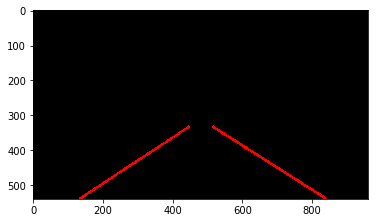

 77%|███████▋  | 522/682 [04:14<00:59,  2.71it/s]

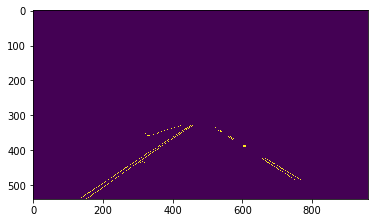

[[-0.72340426]
 [-0.67241379]
 [-0.625     ]
 [-0.8       ]
 [-0.76923077]
 [-0.75      ]
 [ 0.59803922]
 [ 0.6       ]
 [ 0.54545455]
 [-0.26666667]
 [-0.76923077]
 [-0.71875   ]
 [ 0.6       ]
 [ 0.71428571]
 [-0.68181818]
 [-0.73684211]
 [-0.375     ]
 [-0.625     ]
 [-0.72727273]
 [-0.7       ]
 [-0.72      ]
 [-0.8       ]
 [-0.68421053]
 [ 0.57142857]
 [-0.7       ]
 [ 0.54545455]]
left_m = -0.673827524306  right_m = 0.577423795664
left_c = 634.686843837  right_c = 46.1367128886
left_y = 328.769147803  right_y = 428.968689414  min y = 328.769147803
left_y = 538.329507862  right_y = 489.020764163  max y = 538.329507862


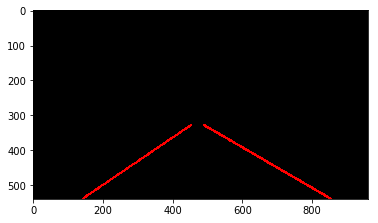

 77%|███████▋  | 523/682 [04:15<00:59,  2.69it/s]

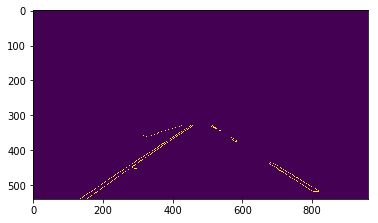

[[-0.65      ]
 [-0.67647059]
 [-0.72413793]
 [-0.83333333]
 [ 0.6       ]
 [-0.63043478]
 [ 0.58139535]
 [-0.2173913 ]
 [-0.68965517]
 [-0.70588235]
 [ 0.63636364]
 [-0.58333333]
 [-0.76470588]
 [-0.66666667]
 [ 0.60606061]
 [ 0.5625    ]
 [ 0.45454545]
 [-0.76923077]
 [ 0.6       ]
 [ 0.6       ]
 [-0.8       ]
 [ 0.64285714]
 [-0.81818182]
 [ 0.6       ]
 [ 0.53333333]
 [ 0.54545455]
 [-0.28571429]
 [-0.68181818]
 [ 0.55555556]
 [ 0.57142857]
 [-0.72727273]
 [ 0.        ]
 [-0.6       ]
 [-0.71428571]]
left_m = -0.668471592011  right_m = 0.61761749571
left_c = 633.488633702  right_c = 15.5769687304
left_y = 327.997116153  right_y = 363.295618815  min y = 327.997116153
left_y = 543.24496878  right_y = 513.994287769  max y = 543.24496878


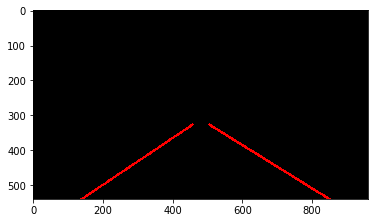

 77%|███████▋  | 524/682 [04:15<00:58,  2.70it/s]

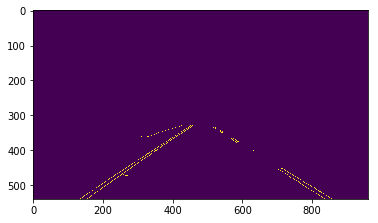

[[-0.69565217]
 [-0.6504065 ]
 [ 0.55      ]
 [ 0.5       ]
 [-0.64935065]
 [ 0.64705882]
 [-0.6       ]
 [-0.68253968]
 [ 0.53846154]
 [-0.33333333]
 [ 0.53333333]
 [-0.65217391]
 [ 0.58333333]
 [-0.7       ]
 [ 0.58333333]
 [ 0.5       ]
 [-0.66666667]
 [-0.72727273]
 [-0.68518519]
 [ 0.66666667]
 [-0.61538462]
 [ 0.58333333]
 [ 0.58333333]
 [ 0.71428571]
 [-0.71428571]
 [-0.75      ]
 [-0.61538462]
 [ 0.66666667]
 [-0.6       ]
 [ 0.45454545]
 [-0.7       ]
 [-0.16666667]
 [ 0.6       ]]
left_m = -0.66779711273  right_m = 0.617891289873
left_c = 634.906080317  right_c = 15.8333119927
left_y = 329.7227998  right_y = 366.177673351  min y = 329.7227998
left_y = 540.746687422  right_y = 544.130364834  max y = 544.130364834


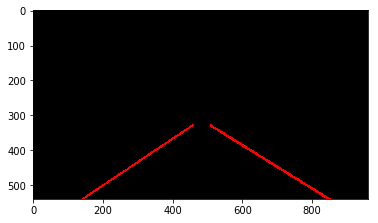

 77%|███████▋  | 525/682 [04:15<01:02,  2.53it/s]

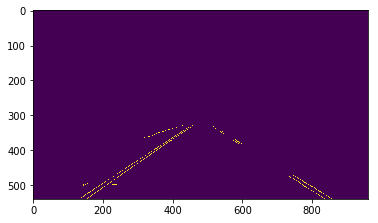

[[-0.64948454]
 [-0.68      ]
 [-0.67857143]
 [ 0.62222222]
 [ 0.64444444]
 [-0.33333333]
 [-0.29411765]
 [-0.68571429]
 [-0.72340426]
 [-0.69230769]
 [ 0.65909091]
 [ 0.65      ]
 [-0.66666667]
 [-0.61538462]
 [-0.78571429]
 [-0.6       ]
 [ 0.59090909]
 [ 0.61538462]
 [ 0.6       ]
 [-0.6       ]
 [-0.75      ]
 [-0.8       ]
 [-0.61538462]
 [-0.33333333]
 [-0.18181818]
 [ 0.63636364]]
left_m = -0.673245013719  right_m = 0.622306173135
left_c = 636.81248255  right_c = 12.4299874323
left_y = 328.466266267  right_y = 368.389118466  min y = 328.466266267
left_y = 537.845465533  right_y = 544.501765463  max y = 544.501765463


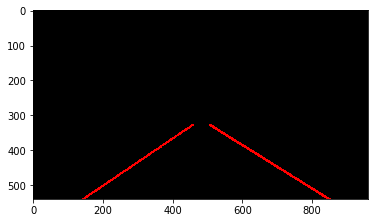

 77%|███████▋  | 526/682 [04:16<00:59,  2.60it/s]

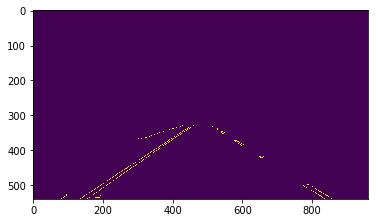

[[-0.69852941]
 [-0.75      ]
 [-0.69565217]
 [-0.75      ]
 [ 0.        ]
 [-0.69444444]
 [-0.71428571]
 [-0.75      ]
 [-0.34782609]
 [-0.67      ]
 [ 0.54545455]
 [-0.8       ]
 [ 0.6       ]
 [ 0.6097561 ]
 [ 0.7       ]
 [-0.8       ]
 [ 0.56      ]
 [-0.73333333]
 [-0.73333333]
 [-0.76923077]
 [-0.72727273]
 [-0.71428571]
 [-0.76923077]
 [-0.28571429]
 [-0.30769231]
 [ 0.6       ]]
left_m = -0.686572405104  right_m = 0.620461278365
left_c = 640.728886984  right_c = 13.6276270687
left_y = 330.398159876  right_y = 371.633784685  min y = 330.398159876
left_y = 539.802743433  right_y = 540.3992524  max y = 540.3992524


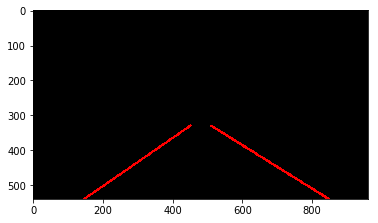

 77%|███████▋  | 527/682 [04:16<00:59,  2.60it/s]

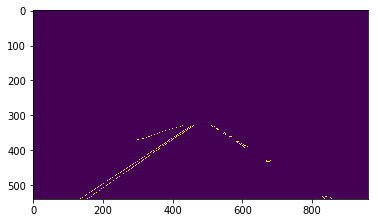

[[-0.63157895]
 [-0.67647059]
 [-0.6728972 ]
 [-0.72727273]
 [ 0.59090909]
 [-0.42857143]
 [-0.67741935]
 [-0.68421053]
 [-0.66666667]
 [-0.66666667]
 [-0.76923077]
 [-0.67857143]
 [-0.33333333]
 [-0.66666667]
 [-0.29411765]
 [-0.35714286]
 [ 0.58333333]
 [-0.57142857]
 [-0.66666667]
 [-0.8       ]
 [ 0.5625    ]
 [-0.58333333]
 [-0.68421053]
 [ 0.64285714]]
left_m = -0.678813244307  right_m = 0.527379949452
left_c = 638.220119003  right_c = 68.8580454928
left_y = 340.221104753  right_y = 381.066975569  min y = 340.221104753
left_y = 545.901517778  right_y = 393.196714406  max y = 545.901517778


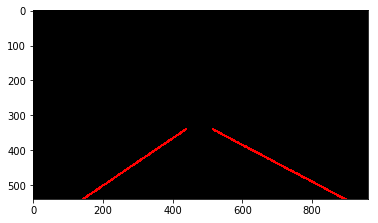

 77%|███████▋  | 528/682 [04:16<00:58,  2.62it/s]

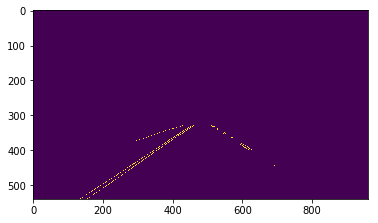

[[-0.67857143]
 [-0.75      ]
 [-0.76470588]
 [-0.64285714]
 [-0.625     ]
 [-0.41666667]
 [ 0.59090909]
 [ 0.7       ]
 [-0.75      ]
 [-0.65      ]
 [-0.64705882]
 [-0.61290323]
 [-0.57142857]
 [-0.81818182]
 [-0.55555556]
 [-0.61111111]
 [-0.61904762]
 [-0.3125    ]
 [-0.68421053]
 [-0.54545455]
 [ 0.58823529]
 [-0.6       ]
 [-0.64285714]
 [-0.58333333]
 [-0.58333333]
 [ 0.63157895]
 [-0.3       ]
 [-0.58333333]
 [-0.54545455]]
left_m = -0.675759242118  right_m = 0.64098189745
left_c = 638.315383667  right_c = -0.692019713771
left_y = 335.575243198  right_y = 349.284096294  min y = 335.575243198
left_y = 534.248460381  right_y = 395.434792911  max y = 534.248460381


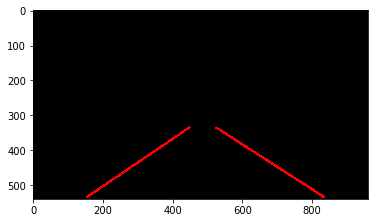

 78%|███████▊  | 529/682 [04:17<00:57,  2.67it/s]

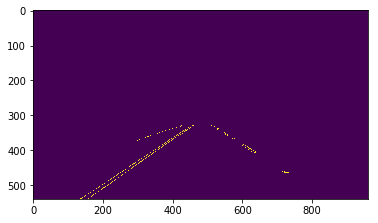

[[-0.57894737]
 [-0.75      ]
 [-0.75      ]
 [-0.63157895]
 [-0.64705882]
 [-0.7       ]
 [-0.61904762]
 [-0.57142857]
 [ 0.        ]
 [-0.6744186 ]
 [-0.67857143]
 [-0.63636364]
 [-0.36363636]
 [-0.64285714]
 [-0.8       ]
 [ 0.58333333]
 [-0.57142857]
 [-0.81818182]
 [-0.5       ]
 [-0.5625    ]
 [-0.57142857]
 [-0.66666667]
 [-0.72727273]
 [ 0.64      ]
 [-0.75      ]
 [-0.34782609]
 [-0.65625   ]
 [-0.38461538]
 [-0.72727273]
 [-0.27272727]
 [-0.8       ]
 [-0.69230769]
 [-0.72222222]
 [-0.45454545]]
left_m = -0.665456758014  right_m = 0.552314274601
left_c = 634.527203581  right_c = 54.1217425126
left_y = 329.082551652  right_y = 383.301050175  min y = 329.082551652
left_y = 544.025084491  right_y = 400.422792688  max y = 544.025084491


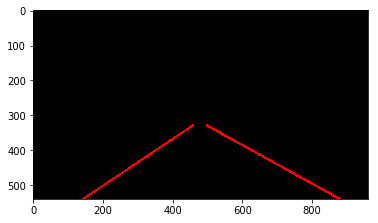

 78%|███████▊  | 530/682 [04:17<00:59,  2.54it/s]

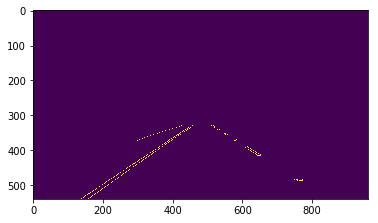

[[-0.5625    ]
 [-0.70121951]
 [-0.66666667]
 [-0.66071429]
 [ 0.5625    ]
 [-0.54545455]
 [-0.71428571]
 [ 0.64102564]
 [-0.28571429]
 [-0.77777778]
 [-0.6       ]
 [-0.8       ]
 [-0.8       ]
 [-0.6875    ]
 [-0.72727273]
 [ 0.5       ]
 [-0.63157895]
 [ 0.57142857]
 [ 0.63636364]
 [-0.72727273]
 [-0.6       ]
 [-0.36363636]
 [-0.8       ]
 [-0.76923077]
 [-0.54545455]
 [ 0.        ]]
left_m = -0.672047642767  right_m = 0.596885813149
left_c = 635.325232889  right_c = 24.9169550173
left_y = 331.559698359  right_y = 386.032871972  min y = 331.559698359
left_y = 542.582658187  right_y = 414.683391003  max y = 542.582658187


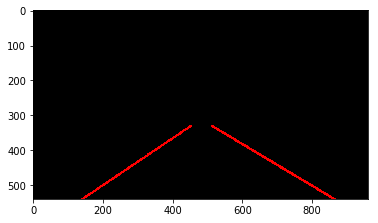

 78%|███████▊  | 531/682 [04:18<00:59,  2.56it/s]

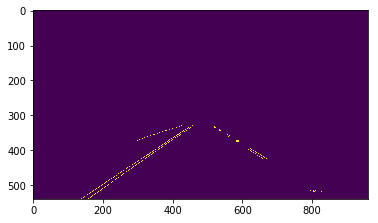

[[-0.72727273]
 [-0.81818182]
 [-0.7037037 ]
 [ 0.        ]
 [-0.63888889]
 [-0.65      ]
 [-0.6       ]
 [-0.75      ]
 [-0.75      ]
 [-0.8       ]
 [-0.58333333]
 [-0.6       ]
 [-0.83333333]
 [-0.57142857]
 [-0.6969697 ]
 [-0.81818182]
 [-0.42105263]
 [ 0.6       ]
 [ 0.53846154]
 [-0.31578947]
 [-0.8       ]
 [-0.75      ]
 [-0.75      ]
 [-0.8       ]
 [-0.6       ]
 [-0.63636364]
 [ 0.6875    ]
 [-0.7       ]
 [ 0.5625    ]
 [-0.5       ]
 [-0.72727273]
 [ 0.54545455]
 [-0.6       ]]
left_m = -0.678295291925  right_m = 0.605189926256
left_c = 638.446724527  right_c = 21.8562960902
left_y = 334.570433744  right_y = 355.921135383  min y = 334.570433744
left_y = 544.163678949  right_y = 427.333546682  max y = 544.163678949


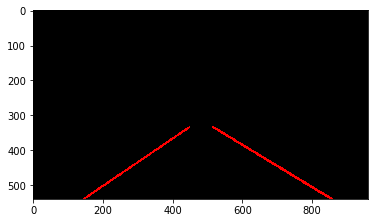

 78%|███████▊  | 532/682 [04:18<00:57,  2.62it/s]

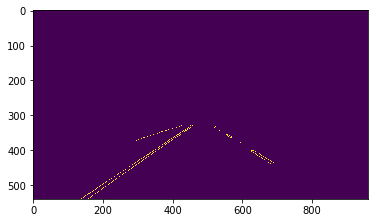

[[-0.67741935]
 [-0.76923077]
 [ 0.58333333]
 [-0.75      ]
 [-0.84615385]
 [-0.71428571]
 [-0.75      ]
 [-0.61904762]
 [-0.72727273]
 [ 0.6       ]
 [-0.76923077]
 [-0.70588235]
 [-0.68518519]
 [-0.8       ]
 [-0.8       ]
 [-0.6       ]
 [ 0.66666667]
 [-0.31034483]
 [-0.5625    ]
 [-0.69230769]
 [-0.58333333]
 [-0.72413793]
 [-0.6875    ]
 [ 0.6       ]
 [ 0.6       ]
 [-0.35714286]
 [ 0.58333333]
 [ 0.71428571]
 [-0.75      ]
 [-0.33333333]
 [-0.7       ]
 [-0.35      ]]
left_m = -0.668831211908  right_m = 0.609513881269
left_c = 635.021657614  right_c = 19.3349453685
left_y = 328.696962561  right_y = 357.005635591  min y = 328.696962561
left_y = 542.054119159  right_y = 431.975842987  max y = 542.054119159


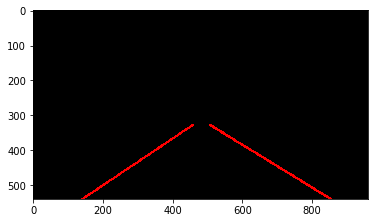

 78%|███████▊  | 533/682 [04:18<00:56,  2.65it/s]

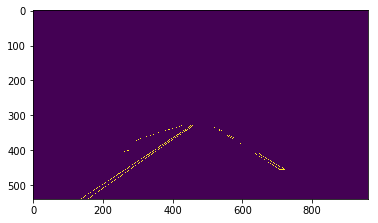

[[-0.70238095]
 [ 0.6       ]
 [-0.63636364]
 [ 0.61538462]
 [ 0.64615385]
 [-0.67241379]
 [ 0.5       ]
 [-0.8       ]
 [-0.65441176]
 [-0.6       ]
 [-0.58333333]
 [-0.75      ]
 [-0.73333333]
 [-0.3       ]
 [ 0.72727273]
 [-0.83333333]
 [-0.71428571]
 [-0.8       ]
 [-0.76923077]
 [-0.64285714]
 [-0.76923077]
 [-0.8       ]
 [-0.3       ]
 [-0.75      ]
 [-0.7       ]
 [ 0.52631579]
 [-0.66666667]
 [-0.58333333]
 [-0.7       ]]
left_m = -0.687447838681  right_m = 0.610409133548
left_c = 642.984639734  right_c = 16.8218589399
left_y = 332.25821665  right_y = 356.819746326  min y = 332.25821665
left_y = 548.116837996  right_y = 455.706025961  max y = 548.116837996


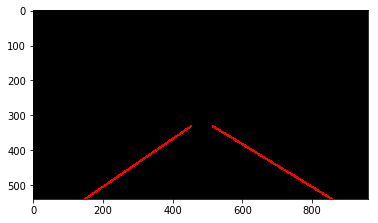

 78%|███████▊  | 534/682 [04:19<00:54,  2.70it/s]

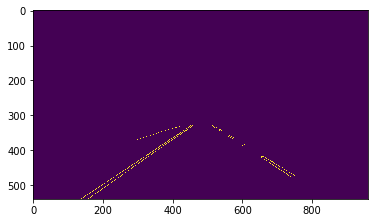

[[-0.78571429]
 [-0.6754386 ]
 [-0.71428571]
 [-0.71428571]
 [ 0.65957447]
 [-0.76923077]
 [-0.64      ]
 [ 0.69230769]
 [-0.8       ]
 [ 0.61904762]
 [-0.3125    ]
 [-0.57142857]
 [-0.6       ]
 [-0.29166667]
 [-0.69444444]
 [-0.78571429]
 [-0.61904762]
 [-0.30769231]
 [-0.6       ]
 [ 0.61111111]
 [-0.83333333]
 [-0.6       ]
 [ 0.45454545]
 [-0.3       ]
 [-0.8       ]
 [-0.75      ]
 [-0.58333333]
 [-0.58333333]
 [-0.83333333]
 [-0.66666667]
 [-0.58333333]
 [ 0.69230769]
 [-0.81818182]
 [-0.61538462]
 [ 0.6       ]]
left_m = -0.691287470579  right_m = 0.613590617906
left_c = 643.867380201  right_c = 16.2468865748
left_y = 332.09673097  right_y = 359.857632602  min y = 332.09673097
left_y = 548.469709261  right_y = 467.849581353  max y = 548.469709261


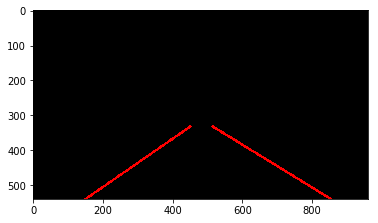

 78%|███████▊  | 535/682 [04:19<00:53,  2.73it/s]

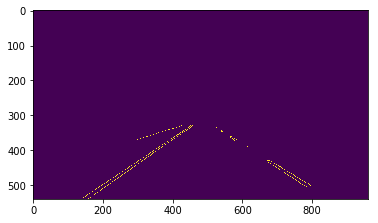

[[-0.83333333]
 [-0.69565217]
 [ 0.62962963]
 [-0.58823529]
 [-0.72413793]
 [ 0.6875    ]
 [-0.57142857]
 [ 0.62745098]
 [-0.8       ]
 [-0.31818182]
 [-0.69230769]
 [-0.65      ]
 [-0.81818182]
 [-0.625     ]
 [-0.78571429]
 [ 0.6       ]
 [-0.61538462]
 [ 0.66666667]
 [ 0.6       ]
 [-0.5       ]
 [-0.8       ]
 [-0.81818182]
 [-0.63636364]
 [-0.8       ]
 [-0.58333333]
 [-0.3       ]
 [ 0.6       ]
 [ 0.57142857]
 [-0.7       ]
 [-0.78571429]
 [ 0.6       ]
 [-0.8       ]
 [-0.3       ]
 [-0.81818182]
 [-0.66666667]
 [ 0.        ]]
left_m = -0.678314633458  right_m = 0.649540515725
left_c = 639.67022561  right_c = -6.00385067363
left_y = 332.393696654  right_y = 360.337000195  min y = 332.393696654
left_y = 544.706176926  right_y = 496.740508498  max y = 544.706176926


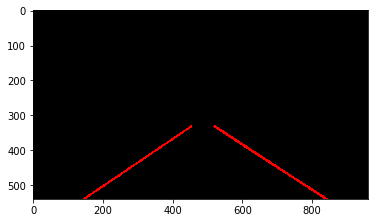

 79%|███████▊  | 536/682 [04:20<00:56,  2.60it/s]

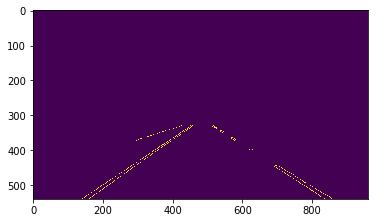

[[ 0.66      ]
 [-0.72058824]
 [-0.75      ]
 [-0.67142857]
 [-0.64      ]
 [ 0.5       ]
 [-0.66666667]
 [ 0.61538462]
 [ 0.60526316]
 [-0.81818182]
 [-0.78571429]
 [-0.625     ]
 [-0.2962963 ]
 [ 0.5       ]
 [-0.78571429]
 [ 0.52941176]
 [-0.64705882]
 [-0.64285714]
 [-0.73333333]
 [ 0.59459459]
 [ 0.6       ]
 [-0.31578947]
 [-0.73333333]
 [ 0.53333333]
 [ 0.55555556]
 [ 0.66666667]
 [-0.33333333]
 [ 0.53333333]
 [-0.70833333]
 [ 0.5       ]
 [ 0.63636364]
 [-0.8       ]]
left_m = -0.681763357527  right_m = 0.62356225411
left_c = 642.746198584  right_c = 10.619663002
left_y = 335.270924339  right_y = 329.883537106  min y = 329.883537106
left_y = 546.617565173  right_y = 536.282643217  max y = 546.617565173


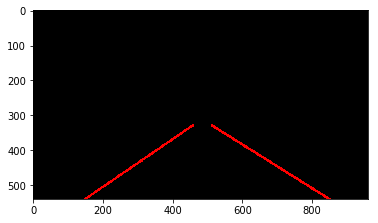

 79%|███████▊  | 537/682 [04:20<00:54,  2.66it/s]

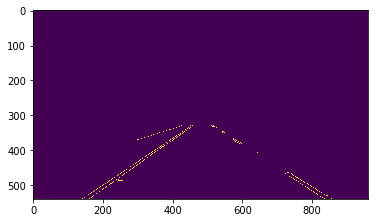

[[-0.67226891]
 [ 0.64285714]
 [-0.71428571]
 [-0.74418605]
 [-0.72727273]
 [ 0.57142857]
 [-0.325     ]
 [ 0.44444444]
 [-0.68888889]
 [-0.68571429]
 [ 0.5       ]
 [-0.61538462]
 [-0.6       ]
 [-0.36363636]
 [ 0.57142857]
 [-0.75      ]
 [-0.64      ]
 [-0.76923077]
 [-0.64864865]
 [ 0.58333333]
 [-0.8       ]
 [ 0.52631579]
 [-0.75      ]
 [-0.8       ]
 [-0.27272727]
 [ 0.6       ]
 [ 0.59090909]
 [ 0.58333333]
 [-0.83333333]
 [ 0.6       ]
 [-0.66666667]
 [ 0.5       ]
 [-0.81818182]
 [-0.81818182]
 [ 0.63636364]
 [ 0.        ]]
left_m = -0.691702750044  right_m = 0.638239532613
left_c = 646.011322685  right_c = 1.81083869351
left_y = 334.745085166  right_y = 369.436809478  min y = 334.745085166
left_y = 548.481234929  right_y = 534.740848425  max y = 548.481234929


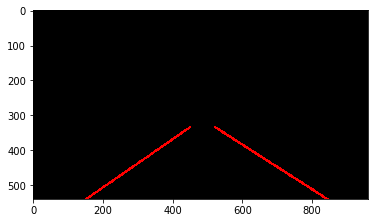

 79%|███████▉  | 538/682 [04:20<00:53,  2.70it/s]

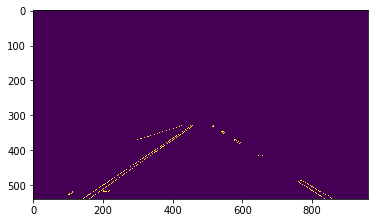

[[-0.8       ]
 [-0.69444444]
 [-0.63636364]
 [ 0.63461538]
 [ 0.5625    ]
 [ 0.55555556]
 [-0.67489712]
 [-0.3       ]
 [ 0.5       ]
 [-0.32142857]
 [-0.58823529]
 [-0.68181818]
 [-0.73333333]
 [-0.32608696]
 [-0.6       ]
 [-0.75      ]
 [-0.69230769]
 [-0.66666667]
 [-0.625     ]
 [-0.625     ]
 [ 0.57142857]
 [-0.8       ]
 [ 0.6       ]
 [ 0.        ]
 [-0.66666667]]
left_m = -0.648340945542  right_m = 0.625017236888
left_c = 630.027397846  right_c = 9.82075040475
left_y = 333.087244788  right_y = 370.455696089  min y = 333.087244788
left_y = 559.358234782  right_y = 534.835229391  max y = 559.358234782


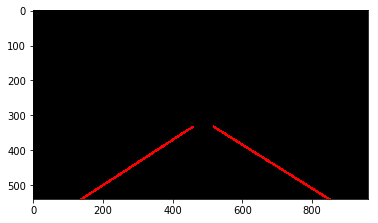

 79%|███████▉  | 539/682 [04:21<00:53,  2.67it/s]

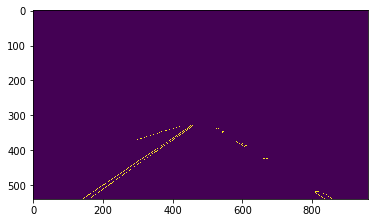

[[-0.81818182]
 [ 0.        ]
 [-0.72222222]
 [-0.57142857]
 [-0.70652174]
 [ 0.66666667]
 [-0.66666667]
 [-0.63157895]
 [-0.6       ]
 [-0.71428571]
 [-0.71428571]
 [-0.6       ]
 [-0.76923077]
 [-0.31914894]
 [-0.8       ]
 [ 0.        ]
 [-0.66666667]
 [-0.81818182]
 [-0.75      ]
 [ 0.6       ]
 [ 0.72222222]
 [-0.6875    ]
 [-0.58333333]
 [-0.36363636]
 [ 0.6875    ]
 [-0.18181818]
 [-0.7       ]]
left_m = -0.696716725403  right_m = 0.651872931833
left_c = 645.530521973  right_c = -6.24896095301
left_y = 337.581729345  right_y = 373.792958306  min y = 337.581729345
left_y = 532.662412458  right_y = 536.761191264  max y = 536.761191264


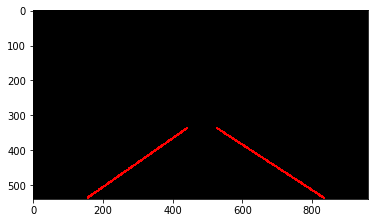

 79%|███████▉  | 540/682 [04:21<00:52,  2.71it/s]

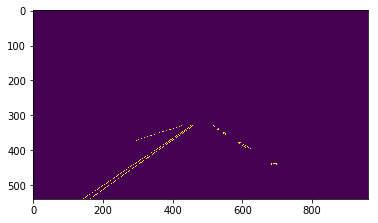

[[-0.7037037 ]
 [-0.672     ]
 [-0.69047619]
 [-0.67857143]
 [-0.7012987 ]
 [-0.66666667]
 [ 0.625     ]
 [-0.31372549]
 [-0.34615385]
 [-0.2       ]
 [-0.66666667]
 [ 0.59090909]
 [-0.6875    ]
 [-0.30769231]
 [-0.07142857]
 [-0.66666667]
 [-0.63636364]
 [ 0.52631579]]
left_m = -0.705856421508  right_m = 0.596795037477
left_c = 650.081542391  right_c = 27.1997932282
left_y = 329.622727027  right_y = 378.115275265  min y = 329.622727027
left_y = 548.438217694  right_y = 396.019126389  max y = 548.438217694


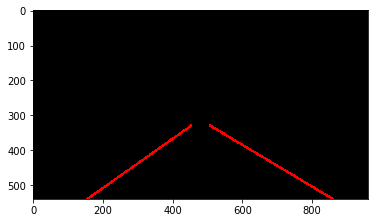

 79%|███████▉  | 541/682 [04:21<00:54,  2.59it/s]

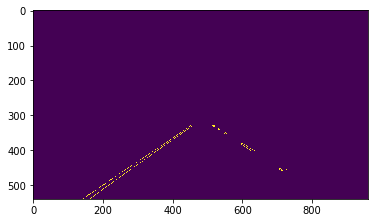

[[-0.63333333]
 [-0.6       ]
 [-0.60714286]
 [-0.83333333]
 [-0.75      ]
 [-0.63636364]
 [-0.61538462]
 [-0.61904762]
 [-0.6       ]
 [-0.65789474]
 [ 0.62962963]
 [-0.63333333]
 [-0.62068966]
 [-0.68421053]
 [-0.65517241]
 [-0.71875   ]
 [-0.83333333]
 [ 0.60606061]
 [-0.71428571]
 [-0.72727273]
 [-0.75      ]
 [-0.58333333]
 [-0.6       ]
 [-0.61538462]
 [-0.7       ]
 [-0.61538462]]
left_m = -0.695281858358  right_m = 0.57619047619
left_c = 645.675399525  right_c = 38.180952381
left_y = 332.798563263  right_y = 382.742857143  min y = 332.798563263
left_y = 535.125584046  right_y = 403.485714286  max y = 535.125584046


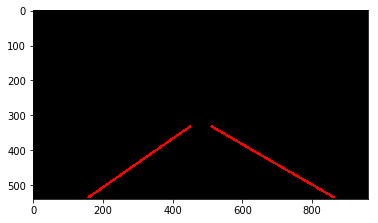

 79%|███████▉  | 542/682 [04:22<00:53,  2.64it/s]

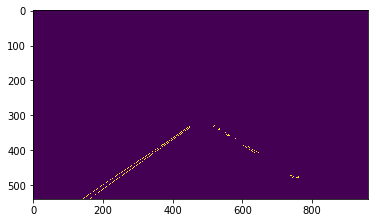

[[-0.69444444]
 [-0.73333333]
 [-0.72413793]
 [ 0.61111111]
 [-0.58823529]
 [-0.68965517]
 [-0.61538462]
 [-0.81818182]
 [-0.57142857]
 [-0.76470588]
 [-0.81818182]
 [ 0.        ]
 [-0.625     ]
 [ 0.64516129]
 [-0.57142857]
 [-0.78571429]
 [-0.66666667]
 [-0.77777778]
 [-0.69444444]
 [-0.64705882]
 [-0.65384615]
 [-0.83333333]
 [-0.81818182]]
left_m = -0.696496543641  right_m = 0.580886945659
left_c = 645.058883081  right_c = 34.7526545909
left_y = 333.028431529  right_y = 385.027482823  min y = 333.028431529
left_y = 539.191408447  right_y = 409.424734541  max y = 539.191408447


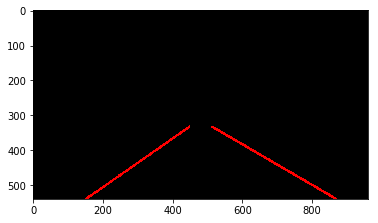

 80%|███████▉  | 543/682 [04:22<00:51,  2.68it/s]

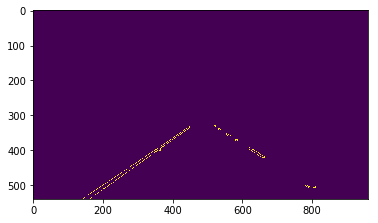

[[-0.73333333]
 [-0.625     ]
 [-0.61538462]
 [-0.61538462]
 [-0.65      ]
 [-0.72307692]
 [-0.76923077]
 [-0.58333333]
 [-0.8       ]
 [ 0.625     ]
 [-0.8       ]
 [ 0.6       ]
 [ 0.57142857]
 [-0.78571429]
 [ 0.        ]
 [-0.71153846]
 [-0.81818182]
 [-0.6       ]
 [-0.58333333]
 [-0.78571429]
 [-0.72727273]
 [-0.57142857]
 [-0.75      ]
 [-0.8       ]
 [-0.57142857]
 [-0.63636364]
 [ 0.54545455]
 [-0.61538462]
 [ 0.5625    ]
 [-0.61538462]
 [ 0.6       ]]
left_m = -0.677267987254  right_m = 0.654877406156
left_c = 639.163929371  right_c = -10.7545953318
left_y = 334.393335107  right_y = 351.392610272  min y = 334.393335107
left_y = 542.314607194  right_y = 418.1901057  max y = 542.314607194


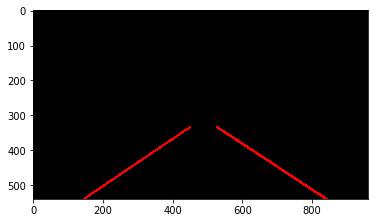

 80%|███████▉  | 544/682 [04:22<00:51,  2.69it/s]

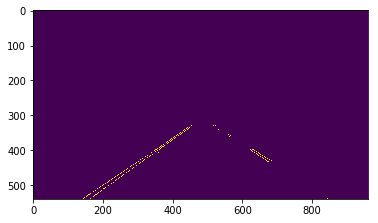

[[-0.67231638]
 [-0.8       ]
 [-0.75757576]
 [-0.83333333]
 [-0.75      ]
 [-0.76923077]
 [ 0.58333333]
 [-0.76923077]
 [-0.78571429]
 [-0.74358974]
 [ 0.57894737]
 [ 0.5625    ]
 [-0.7       ]
 [ 0.60416667]
 [-0.72727273]
 [-0.76190476]
 [-0.8       ]
 [-0.8       ]
 [ 0.53846154]
 [-0.61538462]
 [-0.6       ]
 [-0.8       ]
 [-0.58333333]
 [ 0.54545455]
 [-0.81818182]
 [-0.78571429]
 [ 0.5       ]]
left_m = -0.708894943541  right_m = 0.628698243295
left_c = 652.201166972  right_c = 7.20064333537
left_y = 329.653967661  right_y = 356.128168364  min y = 329.653967661
left_y = 550.829190046  right_y = 433.45805229  max y = 550.829190046


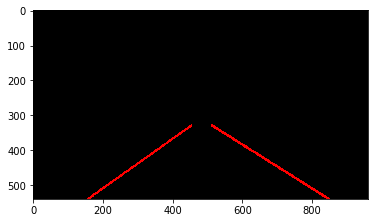

 80%|███████▉  | 545/682 [04:23<00:50,  2.73it/s]

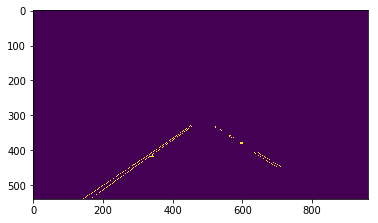

[[-0.64285714]
 [-0.7047619 ]
 [-0.75      ]
 [-0.8125    ]
 [ 0.61538462]
 [ 0.61904762]
 [-0.77777778]
 [ 0.66666667]
 [-0.75862069]
 [-0.75      ]
 [-0.69230769]
 [-0.83333333]
 [ 0.66666667]
 [-0.75      ]
 [-0.63636364]
 [-0.7       ]
 [-0.81818182]
 [-0.8       ]
 [-0.72727273]
 [ 0.6       ]
 [-0.8       ]
 [-0.71428571]
 [ 0.53846154]
 [-0.71428571]
 [-0.81818182]
 [ 0.58333333]
 [-0.72222222]
 [-0.72727273]]
left_m = -0.6982414833  right_m = 0.617515357964
left_c = 647.023547435  right_c = 12.233551693
left_y = 329.323672534  right_y = 356.807121437  min y = 329.323672534
left_y = 546.47677384  right_y = 445.111817626  max y = 546.47677384


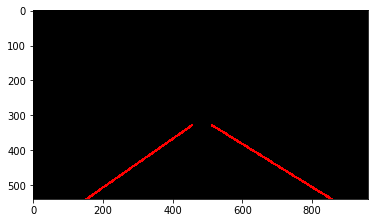

 80%|████████  | 546/682 [04:23<00:49,  2.76it/s]

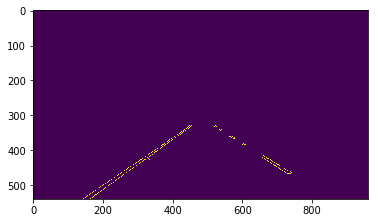

[[-0.68627451]
 [-0.67619048]
 [-0.725     ]
 [-0.69333333]
 [-0.70588235]
 [ 0.65957447]
 [-0.68292683]
 [ 0.66666667]
 [-0.6875    ]
 [ 0.5       ]
 [ 0.61111111]
 [-0.66666667]
 [-0.7037037 ]
 [-0.57142857]
 [ 0.58333333]
 [ 0.6875    ]
 [ 0.75      ]
 [-0.64705882]
 [-0.66666667]
 [-0.64285714]
 [-0.72      ]
 [-0.6       ]
 [ 0.65      ]
 [ 0.68421053]
 [-0.6       ]
 [-0.6       ]
 [-0.58333333]
 [ 0.61538462]]
left_m = -0.68704326036  right_m = 0.623989742683
left_c = 642.645038052  right_c = 7.53684675922
left_y = 334.162614151  right_y = 359.467061632  min y = 334.162614151
left_y = 540.962635519  right_y = 463.67334866  max y = 540.962635519


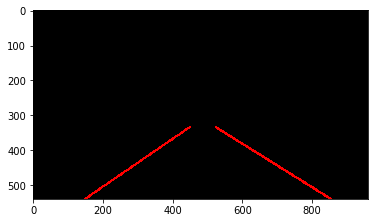

 80%|████████  | 547/682 [04:24<00:52,  2.59it/s]

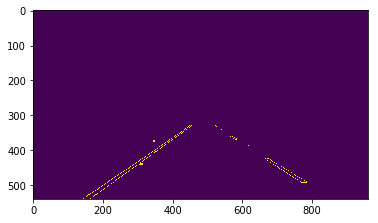

[[-0.71428571]
 [ 0.53333333]
 [-0.6969697 ]
 [ 0.        ]
 [-0.75      ]
 [-0.66666667]
 [-0.65789474]
 [-0.6       ]
 [ 0.6097561 ]
 [-0.69444444]
 [-0.63636364]
 [-0.64285714]
 [ 0.55555556]
 [-0.58333333]
 [ 0.5       ]
 [-0.6       ]
 [ 0.5625    ]
 [ 0.72727273]
 [-0.77777778]
 [-0.57142857]
 [-0.54545455]
 [ 0.5       ]
 [ 0.57692308]
 [ 0.5625    ]
 [-0.6       ]
 [-0.73684211]
 [-0.8       ]
 [-0.63157895]
 [ 0.53846154]
 [ 0.6       ]
 [-0.61538462]
 [-0.81818182]
 [ 0.54545455]
 [-0.66666667]
 [ 0.5       ]
 [ 0.53846154]]
left_m = -0.695785257782  right_m = 0.613094416976
left_c = 646.609763063  right_c = 14.4061735387
left_y = 341.855820154  right_y = 360.80451913  min y = 341.855820154
left_y = 532.500980787  right_y = 491.393629946  max y = 532.500980787


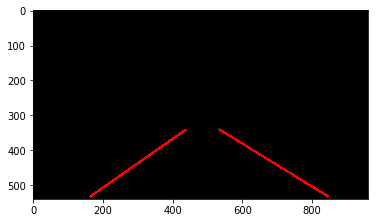

 80%|████████  | 548/682 [04:24<00:50,  2.67it/s]

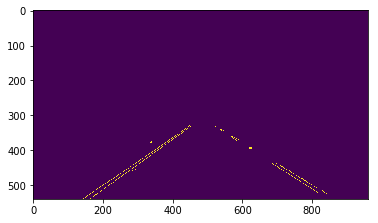

[[-0.83333333]
 [-0.69852941]
 [-0.8       ]
 [ 0.57575758]
 [-0.81818182]
 [-0.6875    ]
 [-0.73684211]
 [ 0.64545455]
 [ 0.55555556]
 [-0.6       ]
 [-0.79166667]
 [ 0.65384615]
 [-0.66666667]
 [-0.68181818]
 [ 0.55555556]
 [-0.57142857]
 [-0.81818182]
 [ 0.6       ]
 [-0.72413793]
 [-0.66666667]
 [-0.58333333]
 [ 0.55555556]
 [-0.53846154]
 [ 0.58823529]
 [-0.70588235]
 [-0.72727273]
 [ 0.65217391]
 [ 0.57142857]
 [ 0.75      ]
 [-0.8       ]
 [ 0.75      ]
 [ 0.        ]
 [ 0.65      ]
 [-0.6       ]
 [-0.72727273]]
left_m = -0.678642605518  right_m = 0.615517836388
left_c = 640.574202181  right_c = 12.0439385819
left_y = 333.827744487  right_y = 361.65806965  min y = 333.827744487
left_y = 534.027313115  right_y = 518.615117929  max y = 534.027313115


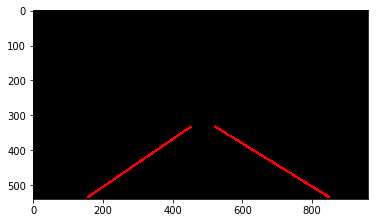

 80%|████████  | 549/682 [04:24<00:49,  2.70it/s]

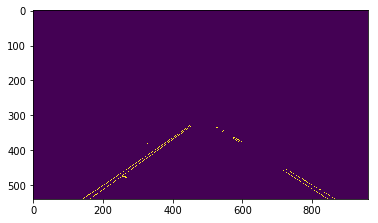

[[ 0.5       ]
 [-0.68055556]
 [-0.72727273]
 [-0.66      ]
 [ 0.58333333]
 [ 0.5       ]
 [-0.75      ]
 [-0.61538462]
 [ 0.5       ]
 [-0.7       ]
 [-0.81818182]
 [-0.75      ]
 [-0.64705882]
 [ 0.5625    ]
 [ 0.68181818]
 [ 0.6875    ]
 [ 0.58333333]
 [ 0.73333333]
 [ 0.6       ]
 [-0.76470588]
 [ 0.5       ]
 [ 0.41666667]
 [ 0.55      ]
 [ 0.63157895]
 [-0.64285714]
 [-0.7       ]
 [ 0.5       ]
 [ 0.7       ]
 [ 0.        ]
 [-0.83333333]
 [-0.66666667]
 [-0.6       ]]
left_m = -0.705388030136  right_m = 0.622703597661
left_c = 648.238043814  right_c = 8.11009532263
left_y = 349.153519036  right_y = 364.296553185  min y = 349.153519036
left_y = 546.662167474  right_y = 546.126003702  max y = 546.662167474


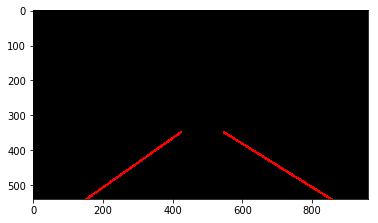

 81%|████████  | 550/682 [04:25<01:00,  2.20it/s]

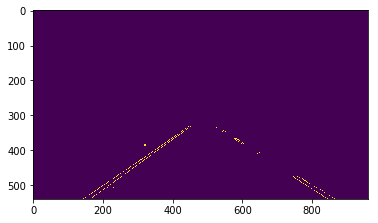

[[-0.70652174]
 [-0.63636364]
 [-0.7       ]
 [-0.68131868]
 [-0.70588235]
 [ 0.46666667]
 [ 0.64615385]
 [-0.7       ]
 [-0.75      ]
 [ 0.5625    ]
 [-0.70588235]
 [-0.6875    ]
 [-0.7037037 ]
 [ 0.5       ]
 [-0.63636364]
 [-0.6       ]
 [-0.83333333]
 [-0.8       ]
 [ 0.61904762]
 [-0.71428571]
 [ 0.53846154]
 [ 0.55      ]
 [ 0.6       ]
 [-0.78571429]
 [ 0.64285714]
 [ 0.5       ]
 [-0.58333333]
 [-0.8       ]
 [-0.6       ]
 [-0.7       ]]
left_m = -0.697913614672  right_m = 0.616958416389
left_c = 646.374363512  right_c = 10.4062420767
left_y = 335.104891368  right_y = 367.008206749  min y = 335.104891368
left_y = 545.176889384  right_y = 543.458313836  max y = 545.176889384


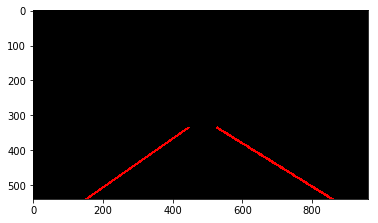

 81%|████████  | 551/682 [04:26<01:38,  1.33it/s]

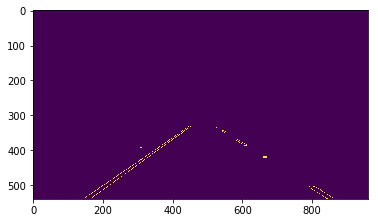

[[-0.58333333]
 [-0.6       ]
 [-0.72972973]
 [-0.6875    ]
 [-0.74418605]
 [-0.69230769]
 [-0.78571429]
 [ 0.7       ]
 [-0.61538462]
 [-0.6       ]
 [ 0.57692308]
 [-0.8       ]
 [-0.83333333]
 [-0.63636364]
 [-0.79166667]
 [-0.72727273]
 [-0.72222222]
 [ 0.61111111]
 [-0.81818182]
 [ 0.54545455]
 [ 0.57894737]
 [ 0.55555556]
 [ 0.72727273]
 [-0.78571429]
 [ 0.5       ]
 [-0.71428571]]
left_m = -0.692836820686  right_m = 0.616278661481
left_c = 643.892133148  right_c = 11.4269000761
left_y = 332.115563839  right_y = 370.717359719  min y = 332.115563839
left_y = 530.266894555  right_y = 538.345155642  max y = 538.345155642


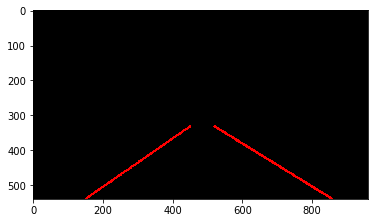

 81%|████████  | 552/682 [04:27<01:44,  1.24it/s]

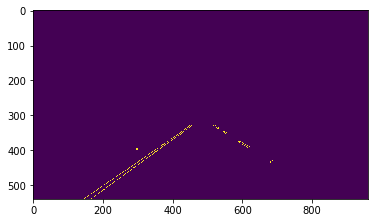

[[-0.7264574 ]
 [-0.67924528]
 [-0.625     ]
 [ 0.59259259]
 [-0.72972973]
 [-0.72727273]
 [-0.71875   ]
 [-0.75      ]
 [ 0.6       ]
 [ 0.59259259]
 [-0.66666667]]
left_m = -0.699674081411  right_m = 0.56434419898
left_c = 646.201328147  right_c = 41.9348061177
left_y = 328.549295187  right_y = 374.333539317  min y = 328.549295187
left_y = 537.751845528  right_y = 392.392553685  max y = 537.751845528


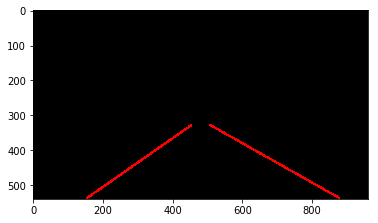

 81%|████████  | 553/682 [04:28<01:28,  1.46it/s]

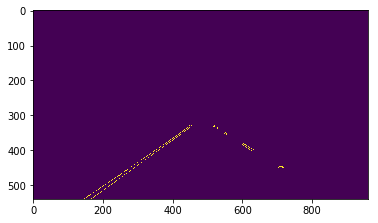

[[-0.72727273]
 [-0.71428571]
 [-0.74358974]
 [-0.64285714]
 [-0.81818182]
 [-0.71428571]
 [-0.70454545]
 [-0.83333333]
 [-0.75      ]
 [-0.71428571]
 [ 0.6       ]
 [-0.8       ]
 [ 0.        ]
 [-0.73684211]
 [ 0.63636364]
 [-0.63636364]
 [ 0.08333333]
 [-0.84615385]
 [-0.84615385]
 [ 0.6       ]
 [ 0.56      ]
 [-0.76470588]
 [-0.76923077]
 [ 0.54545455]
 [-0.78571429]
 [-0.75      ]
 [-0.8       ]]
left_m = -0.701661414932  right_m = 0.631844082914
left_c = 648.813191022  right_c = 2.67762821042
left_y = 333.065554303  right_y = 349.56002973  min y = 333.065554303
left_y = 539.354010293  right_y = 401.371244529  max y = 539.354010293


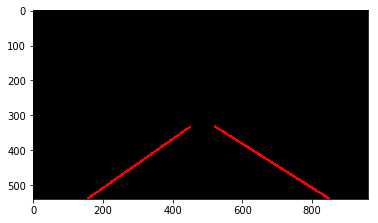

 81%|████████  | 554/682 [05:16<31:42, 14.86s/it]

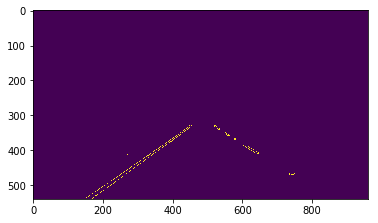

[[-0.58823529]
 [-0.75      ]
 [-0.85714286]
 [-0.68292683]
 [-0.63333333]
 [-0.66666667]
 [-0.7037037 ]
 [-0.75      ]
 [ 0.61290323]
 [ 0.59090909]
 [ 0.63636364]
 [-0.73684211]
 [-0.91666667]
 [ 0.        ]
 [-0.75      ]
 [-0.81818182]
 [-0.81818182]
 [-0.61538462]
 [-0.81818182]
 [-0.6       ]
 [ 0.61111111]
 [-0.8       ]
 [-0.75      ]]
left_m = -0.687162578315  right_m = 0.650296150049
left_c = 644.764929664  right_c = -8.13005923001
left_y = 338.290419735  right_y = 350.833415597  min y = 338.290419735
left_y = 543.064868073  right_y = 412.611549852  max y = 543.064868073


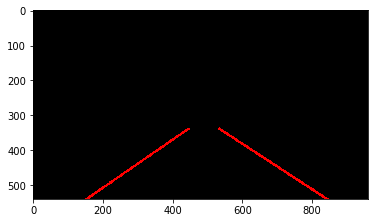

 81%|████████▏ | 555/682 [05:17<22:58, 10.85s/it]

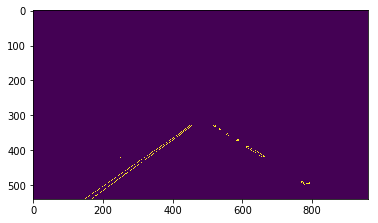

[[-0.71875   ]
 [-0.78947368]
 [ 0.57692308]
 [-0.75      ]
 [-0.6       ]
 [-0.71428571]
 [-0.78571429]
 [-0.8       ]
 [ 0.58333333]
 [-0.76      ]
 [-0.6       ]
 [-0.57142857]
 [ 0.60869565]
 [-0.61538462]
 [-0.70833333]
 [-0.58333333]
 [ 0.58823529]
 [-0.7       ]
 [-0.76470588]
 [-0.8       ]
 [-0.6       ]
 [-0.9       ]
 [-0.75      ]
 [ 0.54545455]
 [-0.7       ]]
left_m = -0.70584999356  right_m = 0.581362521588
left_c = 650.835614265  right_c = 33.4879227815
left_y = 329.673867195  right_y = 354.400034698  min y = 329.673867195
left_y = 537.193765302  right_y = 418.931274594  max y = 537.193765302


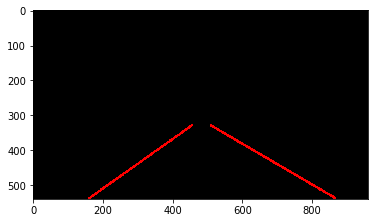

 82%|████████▏ | 556/682 [05:18<16:18,  7.77s/it]

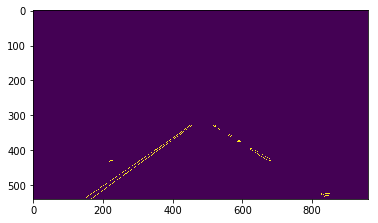

[[-0.61538462]
 [-0.76923077]
 [-0.70175439]
 [-0.72357724]
 [-0.84615385]
 [ 0.55172414]
 [-0.77419355]
 [ 0.59615385]
 [-0.8       ]
 [ 0.55      ]
 [-0.79310345]
 [-0.71428571]
 [-0.71428571]
 [-0.91666667]
 [ 0.53846154]
 [ 0.        ]
 [-0.8       ]
 [-0.77272727]
 [-0.75      ]
 [-0.73333333]
 [-0.63636364]
 [-0.8       ]
 [-0.73333333]
 [ 0.61538462]
 [-0.8125    ]
 [ 0.5       ]]
left_m = -0.702911737628  right_m = 0.525837669271
left_c = 648.585481651  right_c = 70.7133705066
left_y = 329.463552768  right_y = 397.784400793  min y = 329.463552768
left_y = 544.554544483  right_y = 429.334660949  max y = 544.554544483


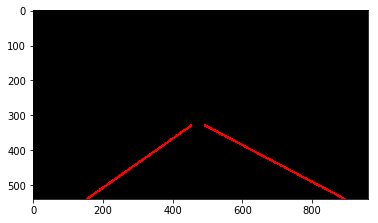

 82%|████████▏ | 557/682 [05:18<11:37,  5.58s/it]

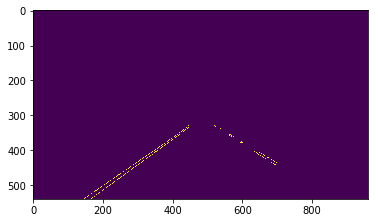

[[-0.70769231]
 [-0.7       ]
 [-0.63636364]
 [ 0.5       ]
 [-0.69791667]
 [-0.82608696]
 [-0.9       ]
 [-0.7       ]
 [ 0.65789474]
 [-0.64705882]
 [ 0.58333333]
 [-0.76923077]
 [-0.69230769]
 [-0.57142857]
 [-0.6       ]
 [-0.66666667]
 [-0.78571429]
 [-0.70588235]
 [ 0.53333333]
 [-0.60869565]
 [-0.63636364]
 [-0.66666667]
 [-0.6       ]
 [-0.6       ]
 [ 0.5       ]
 [ 0.57142857]
 [-0.63636364]
 [-0.63636364]
 [-0.7       ]
 [ 0.54545455]]
left_m = -0.702139035758  right_m = 0.595622673023
left_c = 648.01797203  right_c = 21.4986533978
left_y = 329.948988831  right_y = 353.856104945  min y = 329.948988831
left_y = 531.462892094  right_y = 442.008260552  max y = 531.462892094


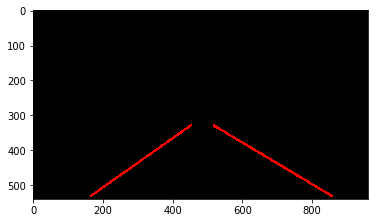

 82%|████████▏ | 558/682 [05:19<08:29,  4.11s/it]

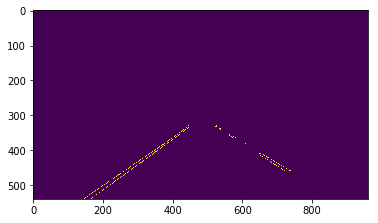

[[-0.72727273]
 [-0.76923077]
 [-0.75      ]
 [-0.77272727]
 [ 0.63888889]
 [-0.69444444]
 [-0.6969697 ]
 [-0.57142857]
 [ 0.56666667]
 [-0.76923077]
 [-0.75      ]
 [-0.78571429]
 [-0.69230769]
 [-0.84615385]
 [ 0.54166667]
 [-0.8       ]
 [-0.6       ]
 [-0.63636364]
 [-0.625     ]
 [-0.76923077]
 [-0.64705882]
 [-0.63157895]
 [-0.6       ]
 [-0.57142857]
 [ 0.5       ]
 [ 0.63636364]
 [-0.6       ]
 [-0.6       ]
 [-0.6       ]
 [ 0.        ]]
left_m = -0.681459022464  right_m = 0.556089408816
left_c = 639.563883925  right_c = 50.2885314393
left_y = 334.951700884  right_y = 412.302736578  min y = 334.951700884
left_y = 540.752325668  right_y = 459.570336328  max y = 540.752325668


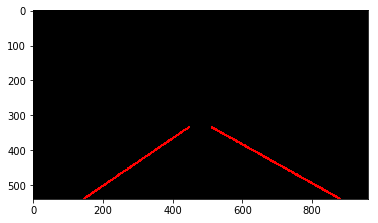

 82%|████████▏ | 559/682 [05:19<06:13,  3.04s/it]

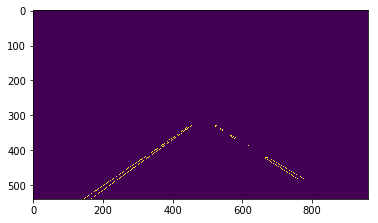

[[-0.77777778]
 [-0.66666667]
 [ 0.625     ]
 [ 0.75      ]
 [ 0.58333333]
 [-0.69230769]
 [-0.71052632]
 [-0.61538462]
 [ 0.4       ]
 [-0.68421053]
 [-0.72093023]
 [-0.71212121]
 [-0.58333333]
 [-0.66666667]
 [-0.58823529]
 [-0.70833333]
 [ 0.53333333]
 [-0.6       ]
 [-0.7       ]
 [-0.8       ]
 [ 0.6       ]
 [ 0.61904762]
 [-0.83333333]
 [ 0.5       ]
 [-0.58333333]
 [-0.58333333]
 [-0.7       ]
 [ 0.53333333]
 [ 0.61538462]
 [-0.7       ]
 [ 0.66666667]]
left_m = -0.705143939973  right_m = 0.625225569009
left_c = 649.177835225  right_c = 3.53111300634
left_y = 329.747630417  right_y = 359.284461772  min y = 329.747630417
left_y = 546.226819989  right_y = 488.080928988  max y = 546.226819989


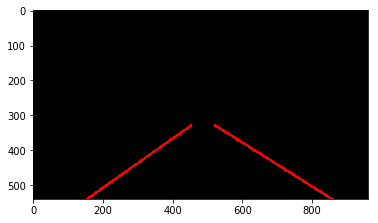

 82%|████████▏ | 560/682 [05:20<04:38,  2.28s/it]

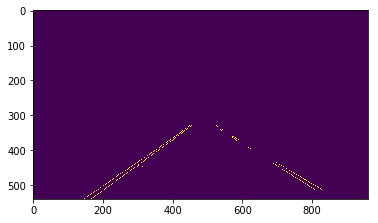

[[-0.74736842]
 [ 0.64179104]
 [-0.69491525]
 [ 0.625     ]
 [ 0.63636364]
 [-0.76923077]
 [-0.76744186]
 [-0.625     ]
 [ 0.54545455]
 [-0.75      ]
 [-0.64285714]
 [ 0.64705882]
 [-0.83333333]
 [-0.9       ]
 [ 0.5625    ]
 [-0.703125  ]
 [-0.78571429]
 [-0.58333333]
 [-0.61538462]
 [ 0.57894737]
 [-0.76470588]
 [-0.83333333]
 [-0.68421053]
 [-0.66666667]
 [ 0.65384615]
 [-0.66666667]
 [ 0.18181818]
 [-0.6       ]
 [-0.7       ]]
left_m = -0.712919229326  right_m = 0.625508627274
left_c = 652.637126217  right_c = 1.85351618342
left_y = 328.971796103  right_y = 360.895468239  min y = 328.971796103
left_y = 532.866695691  right_y = 514.145081921  max y = 532.866695691


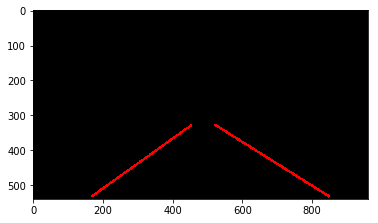

 82%|████████▏ | 561/682 [05:20<03:29,  1.73s/it]

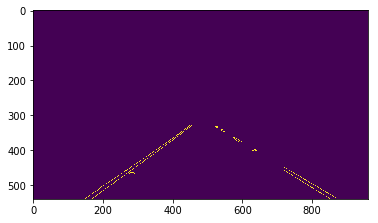

[[-0.84210526]
 [-0.6       ]
 [ 0.63829787]
 [ 0.5952381 ]
 [-0.75      ]
 [ 0.5       ]
 [-0.65909091]
 [-0.64285714]
 [-0.76      ]
 [ 0.53333333]
 [-0.66666667]
 [-0.63636364]
 [ 0.6031746 ]
 [-0.81818182]
 [ 0.55      ]
 [-0.78571429]
 [ 0.65      ]
 [-0.84210526]
 [-0.69230769]
 [ 0.5       ]
 [-0.9       ]
 [-0.61538462]
 [ 0.66666667]
 [-0.76470588]
 [-0.75      ]
 [-0.7       ]
 [-0.74074074]
 [-0.81818182]
 [-0.625     ]
 [-0.9       ]
 [ 0.6       ]
 [-0.6       ]
 [ 0.6       ]]
left_m = -0.693064106456  right_m = 0.597229481763
left_c = 647.09556708  right_c = 22.6517255856
left_y = 336.602847388  right_y = 364.864218636  min y = 336.602847388
left_y = 543.829015218  right_y = 542.838604201  max y = 543.829015218


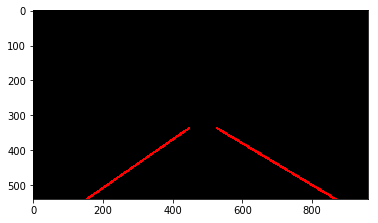

 82%|████████▏ | 562/682 [05:21<02:53,  1.45s/it]

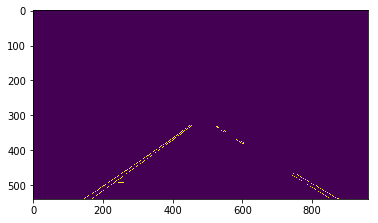

[[-0.63333333]
 [-0.57142857]
 [-0.73015873]
 [-0.65384615]
 [-0.6875    ]
 [-0.72727273]
 [ 0.6875    ]
 [-0.82352941]
 [-0.55      ]
 [-0.76923077]
 [-0.54545455]
 [ 0.58064516]
 [ 0.5       ]
 [-0.66666667]
 [-0.66666667]
 [ 0.64102564]
 [ 0.53333333]
 [-0.72727273]
 [-0.72727273]
 [ 0.55      ]
 [-0.6       ]
 [ 0.63636364]
 [ 0.52631579]
 [-0.69230769]
 [-0.7       ]
 [ 0.57142857]]
left_m = -0.69350625233  right_m = 0.603011182649
left_c = 645.280369826  right_c = 18.298798412
left_y = 330.428531268  right_y = 371.060340262  min y = 330.428531268
left_y = 541.254431976  right_y = 544.124549682  max y = 544.124549682


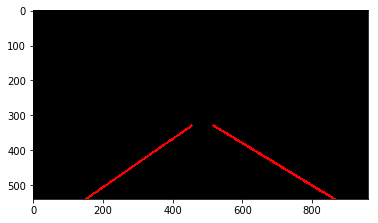

 83%|████████▎ | 563/682 [05:22<02:27,  1.24s/it]

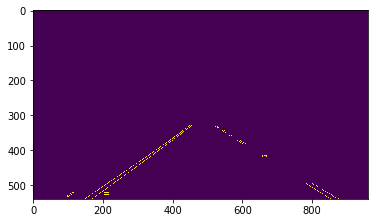

[[-0.73043478]
 [-0.75      ]
 [-0.78571429]
 [ 0.5       ]
 [-0.75      ]
 [-0.73333333]
 [ 0.59701493]
 [-0.75      ]
 [-0.55555556]
 [-0.75      ]
 [ 0.58333333]
 [-0.72839506]
 [-0.71875   ]
 [ 0.53846154]
 [ 0.64705882]
 [ 0.5       ]
 [-0.81818182]
 [-0.8       ]
 [ 0.        ]
 [-0.08333333]
 [ 0.58333333]
 [ 0.5       ]]
left_m = -0.62871869025  right_m = 0.59487558851
left_c = 623.789846778  right_c = 22.7150133902
left_y = 347.153623068  right_y = 370.12235708  min y = 347.153623068
left_y = 562.175415133  right_y = 541.446526571  max y = 562.175415133


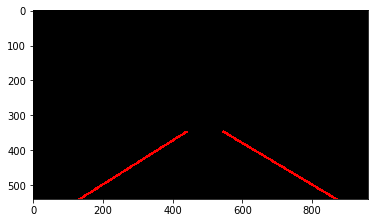

 83%|████████▎ | 564/682 [05:23<02:03,  1.05s/it]

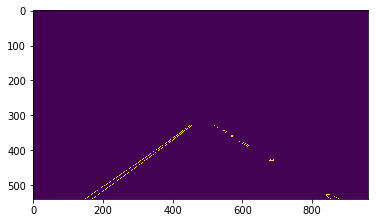

[[-0.77419355]
 [-0.64285714]
 [-0.8       ]
 [-0.83333333]
 [-0.58333333]
 [-0.71875   ]
 [-0.81818182]
 [ 0.6       ]
 [-0.73913043]
 [ 0.3       ]
 [-0.68131868]
 [-0.6       ]
 [ 0.63636364]
 [-0.86666667]
 [-0.76666667]
 [-0.57142857]
 [-0.6       ]
 [-0.84615385]
 [-0.83333333]
 [-0.8       ]
 [-0.6       ]
 [-0.75      ]
 [-0.6       ]]
left_m = -0.700931234105  right_m = 0.645307912702
left_c = 649.078913563  right_c = -11.7841604471
left_y = 335.061720684  right_y = 373.464663436  min y = 335.061720684
left_y = 535.528053638  right_y = 538.018181175  max y = 538.018181175


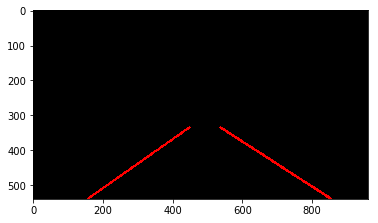

 83%|████████▎ | 565/682 [05:23<01:44,  1.12it/s]

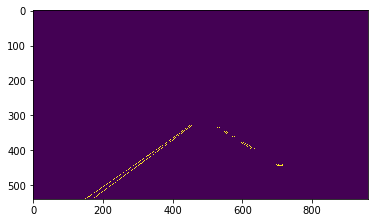

[[-0.75      ]
 [-0.72985782]
 [-0.73239437]
 [ 0.57894737]
 [-0.73015873]
 [-0.72222222]
 [-0.75      ]
 [-0.73076923]
 [-0.76470588]
 [ 0.54545455]
 [-0.77777778]
 [-0.66666667]
 [-0.77777778]
 [-0.77272727]
 [-0.76923077]
 [-0.76470588]
 [ 0.58823529]
 [-0.58333333]
 [ 0.59090909]
 [-0.75      ]
 [-0.58333333]
 [-0.78571429]
 [ 0.6       ]
 [-0.81818182]
 [-0.7       ]]
left_m = -0.706182640848  right_m = 0.598568614447
left_c = 648.98953413  right_c = 18.0255194465
left_y = 327.676432544  right_y = 345.442551549  min y = 327.676432544
left_y = 537.412676876  right_y = 394.525177933  max y = 537.412676876


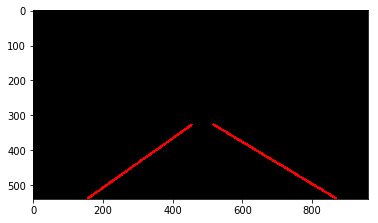

 83%|████████▎ | 566/682 [05:24<01:28,  1.31it/s]

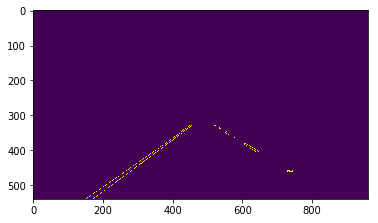

[[-0.75      ]
 [-0.68421053]
 [-0.78125   ]
 [-0.75      ]
 [-0.72222222]
 [-0.81578947]
 [-0.91666667]
 [ 0.54545455]
 [-0.84615385]
 [-0.75      ]
 [-0.84615385]
 [ 0.58333333]
 [ 0.61111111]
 [-0.4       ]
 [ 0.7       ]
 [-0.78947368]
 [-0.72727273]
 [-0.77419355]
 [-0.9       ]
 [-0.6       ]
 [ 0.5       ]
 [-0.8       ]
 [-0.78571429]
 [-0.61538462]
 [-0.81818182]
 [-0.8       ]]
left_m = -0.721206749453  right_m = 0.590297278977
left_c = 655.635914653  right_c = 24.0208192118
left_y = 328.929257151  right_y = 348.684322649  min y = 328.929257151
left_y = 540.96404149  right_y = 398.859591362  max y = 540.96404149


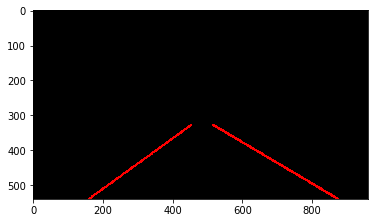

 83%|████████▎ | 567/682 [05:25<01:48,  1.06it/s]

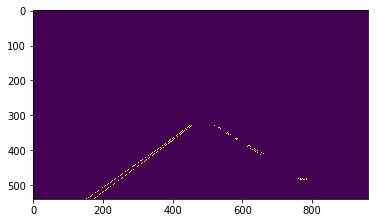

[[-0.75268817]
 [-0.71153846]
 [-0.80645161]
 [ 0.53846154]
 [-0.58333333]
 [-0.6875    ]
 [-0.72727273]
 [ 0.61111111]
 [-0.66666667]
 [-0.70588235]
 [ 0.64285714]
 [ 0.625     ]
 [-0.72727273]
 [-0.91666667]
 [-0.75      ]
 [-0.76923077]
 [-0.78571429]
 [-0.85714286]
 [-0.81818182]
 [-0.6       ]
 [-0.8       ]
 [-0.85714286]
 [ 0.60869565]
 [-0.9       ]
 [-0.75      ]
 [ 0.58333333]]
left_m = -0.707750741339  right_m = 0.636804125659
left_c = 651.461244256  right_c = -5.20132421558
left_y = 328.726906206  right_y = 346.951357274  min y = 328.726906206
left_y = 541.759879349  right_y = 411.905378091  max y = 541.759879349


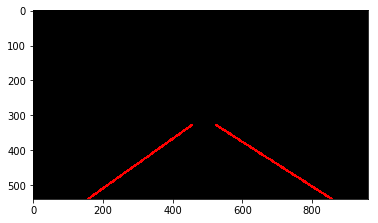

 83%|████████▎ | 568/682 [05:26<01:56,  1.02s/it]

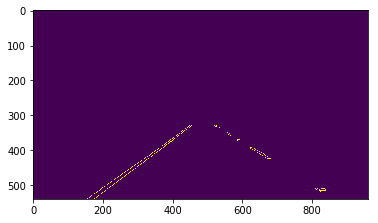

[[-0.82608696]
 [-0.73333333]
 [-0.73333333]
 [-0.6875    ]
 [-0.76666667]
 [-0.58333333]
 [-0.68      ]
 [ 0.58333333]
 [-0.66666667]
 [-0.66666667]
 [ 0.55263158]
 [ 0.63636364]
 [ 0.5       ]
 [-0.7       ]
 [-0.66666667]
 [-0.6875    ]
 [-0.73684211]
 [-0.6       ]
 [-0.75      ]
 [-0.6       ]
 [-0.66666667]
 [ 0.54545455]
 [ 0.58333333]]
left_m = -0.727150606699  right_m = 0.608156059361
left_c = 659.666568792  right_c = 12.4996853642
left_y = 328.813042744  right_y = 350.634454369  min y = 328.813042744
left_y = 546.958224754  right_y = 416.923464839  max y = 546.958224754


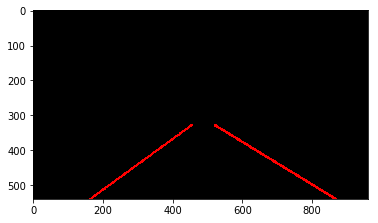

 83%|████████▎ | 569/682 [05:27<01:59,  1.06s/it]

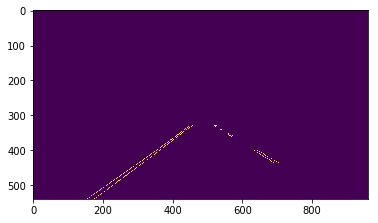

[[-0.77777778]
 [-0.7826087 ]
 [-0.75      ]
 [-0.9       ]
 [-0.6       ]
 [ 0.57142857]
 [-0.77777778]
 [ 0.59259259]
 [-0.73913043]
 [-0.83333333]
 [-0.75      ]
 [-0.83333333]
 [-0.85714286]
 [-0.77777778]
 [-0.875     ]
 [-0.6       ]
 [-0.85714286]
 [-0.76470588]
 [-0.84615385]
 [-0.81818182]
 [ 0.53846154]
 [ 0.58333333]]
left_m = -0.718415335526  right_m = 0.591638966016
left_c = 656.753067822  right_c = 24.4041140354
left_y = 328.437259486  right_y = 355.130296038  min y = 328.437259486
left_y = 543.961860144  right_y = 435.001556451  max y = 543.961860144


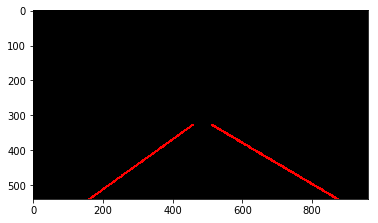

 84%|████████▎ | 570/682 [05:28<01:39,  1.13it/s]

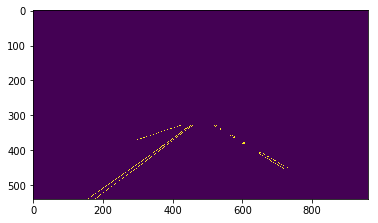

[[-0.70243902]
 [ 0.57377049]
 [-0.76388889]
 [-0.78125   ]
 [-0.70588235]
 [-0.33333333]
 [-0.72413793]
 [-0.7       ]
 [-0.3030303 ]
 [ 0.46666667]
 [-0.69230769]
 [ 0.59090909]
 [ 0.63157895]
 [ 0.64285714]
 [ 0.5625    ]
 [-0.68421053]
 [-0.61538462]
 [-0.68965517]
 [-0.38461538]
 [-0.73333333]
 [ 0.        ]
 [-0.68421053]
 [-0.69230769]
 [-0.71428571]
 [-0.7       ]]
left_m = -0.754958412907  right_m = 0.611702707517
left_c = 671.097227423  right_c = 10.9267563766
left_y = 330.610983202  right_y = 354.703678001  min y = 330.610983202
left_y = 551.813798183  right_y = 450.741003082  max y = 551.813798183


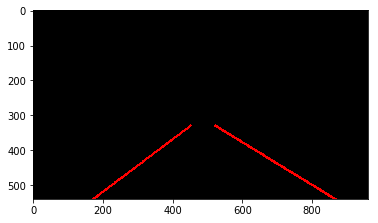

 84%|████████▎ | 571/682 [05:29<01:43,  1.07it/s]

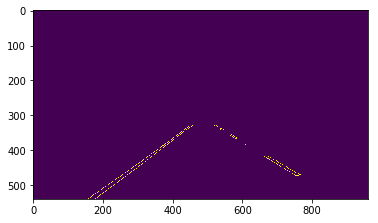

[[-0.77777778]
 [ 0.57142857]
 [-0.63636364]
 [-0.68421053]
 [ 0.5       ]
 [-0.84615385]
 [-0.75      ]
 [-0.58333333]
 [-0.69444444]
 [-0.66666667]
 [ 0.5625    ]
 [ 0.52380952]
 [-0.69230769]
 [-0.63636364]
 [-0.64705882]
 [ 0.5       ]
 [-0.75      ]
 [ 0.6       ]
 [ 0.4375    ]
 [-0.68      ]
 [-0.61538462]
 [-0.74358974]
 [-0.8       ]
 [-0.72222222]
 [-0.6       ]
 [-0.81818182]
 [ 0.45454545]
 [-0.73333333]
 [ 0.5625    ]
 [-0.66666667]
 [ 0.55555556]
 [-0.61538462]
 [-0.69230769]
 [ 0.6       ]
 [-0.63636364]]
left_m = -0.733140641319  right_m = 0.59857109083
left_c = 663.009710019  right_c = 17.4888740222
left_y = 331.630140143  right_y = 355.681540341  min y = 331.630140143
left_y = 547.173488691  right_y = 467.614334326  max y = 547.173488691


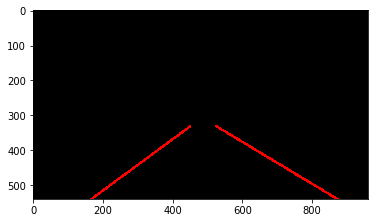

 84%|████████▍ | 572/682 [05:30<01:51,  1.02s/it]

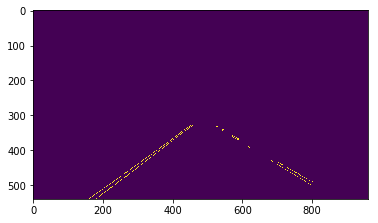

[[-0.7816092 ]
 [-0.90909091]
 [-0.72131148]
 [-0.81081081]
 [ 0.6       ]
 [ 0.6       ]
 [-0.8125    ]
 [-0.625     ]
 [-0.76923077]
 [ 0.57692308]
 [-0.7       ]
 [-0.72727273]
 [-0.64285714]
 [-0.6875    ]
 [ 0.58333333]
 [ 0.52941176]
 [-0.72727273]
 [-0.86666667]
 [ 0.5862069 ]
 [ 0.52941176]
 [-1.        ]
 [-0.58333333]
 [-0.6       ]
 [-0.81818182]
 [ 0.66666667]
 [ 0.6       ]
 [ 0.5625    ]
 [ 0.55555556]]
left_m = -0.73690599528  right_m = 0.607878030941
left_c = 664.419098856  right_c = 11.8455955618
left_y = 332.074494984  right_y = 357.728195167  min y = 332.074494984
left_y = 540.618891649  right_y = 495.10863016  max y = 540.618891649


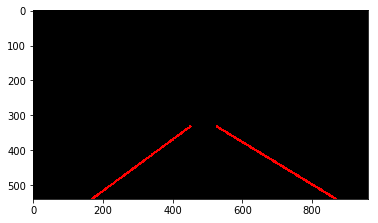

 84%|████████▍ | 573/682 [05:31<02:03,  1.13s/it]

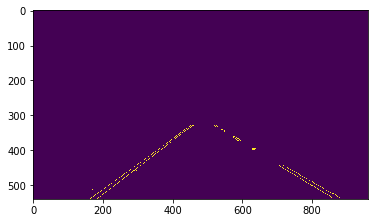

[[-0.8125    ]
 [ 0.55555556]
 [-0.70212766]
 [-0.77941176]
 [-0.72916667]
 [-0.72222222]
 [ 0.59813084]
 [ 0.59756098]
 [-0.84210526]
 [ 0.63157895]
 [-0.78947368]
 [ 0.53333333]
 [-0.83333333]
 [-0.72727273]
 [ 0.6875    ]
 [-0.63636364]
 [-0.76923077]
 [ 0.53846154]
 [ 0.53333333]
 [-0.71428571]
 [-0.72222222]
 [ 0.5       ]
 [ 0.61538462]
 [ 0.53333333]
 [-0.66666667]
 [ 0.63636364]
 [ 0.7       ]
 [-0.77272727]
 [-0.75      ]
 [-0.8       ]]
left_m = -0.732594474294  right_m = 0.565015165919
left_c = 663.325372151  right_c = 41.6702814844
left_y = 327.797102925  right_y = 368.814062551  min y = 327.797102925
left_y = 525.597610984  right_y = 537.753597161  max y = 537.753597161


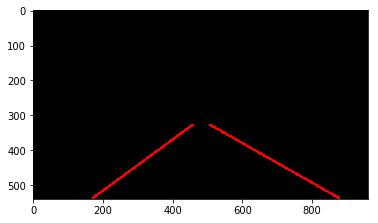

 84%|████████▍ | 574/682 [05:33<02:02,  1.14s/it]

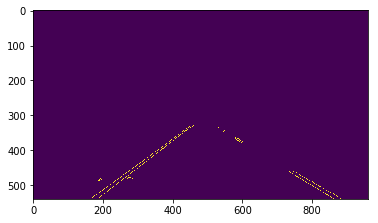

[[ 0.57142857]
 [-0.72222222]
 [ 0.5       ]
 [-0.90909091]
 [-0.63636364]
 [ 0.375     ]
 [-0.76190476]
 [ 0.58823529]
 [ 0.61904762]
 [-0.63636364]
 [ 0.56410256]
 [ 0.52380952]
 [-0.76388889]
 [ 0.58333333]
 [ 0.5       ]
 [ 0.54166667]
 [-0.76190476]
 [-0.73684211]
 [-0.71428571]
 [-0.72727273]
 [-0.76086957]
 [-0.8       ]
 [-0.63636364]
 [-0.77777778]
 [-0.63636364]
 [ 0.57142857]
 [-0.6875    ]
 [-0.8       ]
 [-0.72727273]
 [ 0.57142857]
 [-0.73333333]]
left_m = -0.747188964931  right_m = 0.587419590164
left_c = 669.389288997  right_c = 26.1063646574
left_y = 330.912687883  right_y = 365.634887772  min y = 330.912687883
left_y = 546.103109783  right_y = 540.685925641  max y = 546.103109783


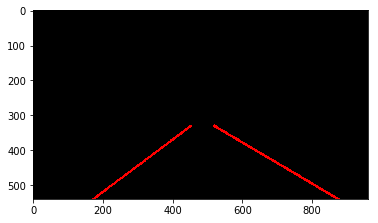

 84%|████████▍ | 575/682 [05:34<02:01,  1.14s/it]

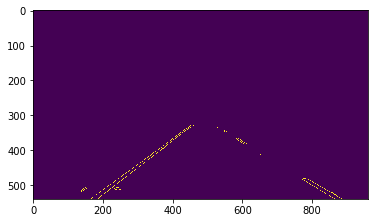

[[-0.72727273]
 [ 0.52631579]
 [-0.7257384 ]
 [-0.78313253]
 [ 0.5       ]
 [-0.78070175]
 [ 0.52941176]
 [ 0.5       ]
 [ 0.61363636]
 [ 0.52380952]
 [ 0.55      ]
 [-0.90909091]
 [ 0.72727273]
 [-0.8       ]
 [-0.77777778]
 [-0.6       ]
 [ 0.7       ]
 [ 0.5       ]
 [ 0.53333333]
 [-0.78571429]
 [-0.76923077]
 [ 0.5       ]]
left_m = -0.688881701045  right_m = 0.584753243508
left_c = 649.49300281  right_c = 25.5196367093
left_y = 340.874000742  right_y = 365.846024431  min y = 340.874000742
left_y = 555.116209767  right_y = 537.763478023  max y = 555.116209767


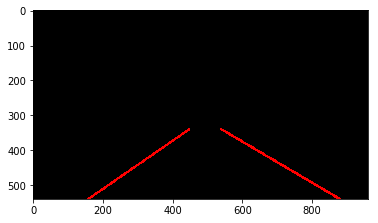

 84%|████████▍ | 576/682 [05:35<02:09,  1.22s/it]

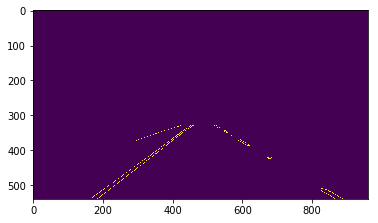

[[-0.66666667]
 [ 0.57142857]
 [-0.69230769]
 [-0.8       ]
 [-0.8       ]
 [-0.73684211]
 [ 0.5       ]
 [-0.71186441]
 [-0.90909091]
 [-0.63636364]
 [-0.75      ]
 [-0.775     ]
 [-0.34883721]
 [ 0.58536585]
 [-0.25      ]
 [-0.6       ]
 [-0.9       ]
 [-0.6       ]
 [-0.6       ]
 [-0.85714286]
 [ 0.58333333]
 [ 0.61904762]
 [-0.84615385]
 [-0.85714286]
 [-0.8       ]
 [-0.2       ]
 [-0.4       ]]
left_m = -0.736973254995  right_m = 0.590708557344
left_c = 664.645989007  right_c = 20.6964831122
left_y = 331.534077749  right_y = 368.623823388  min y = 331.534077749
left_y = 543.045401933  right_y = 543.473556361  max y = 543.473556361


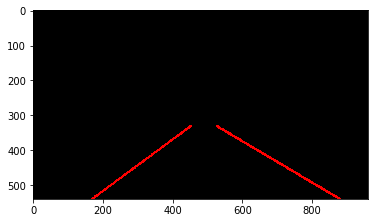

 85%|████████▍ | 577/682 [05:36<01:49,  1.04s/it]

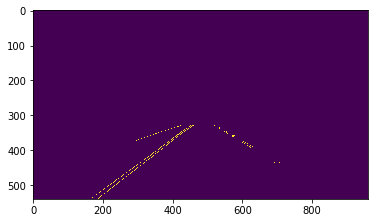

[[-0.78333333]
 [-0.81818182]
 [-0.09090909]
 [-0.70588235]
 [-0.75471698]
 [-0.31666667]
 [-0.73099415]
 [-0.72815534]
 [-0.72727273]
 [ 0.57142857]
 [-0.35714286]
 [-0.6       ]
 [ 0.62068966]
 [-0.63636364]
 [-0.7       ]
 [-0.88235294]
 [-0.4       ]
 [-0.4       ]
 [-0.71428571]
 [ 0.55172414]
 [-0.76470588]
 [ 0.63636364]
 [-0.7       ]
 [-0.66666667]
 [-0.63636364]]
left_m = -0.754223081396  right_m = 0.565167791615
left_c = 671.990058674  right_c = 36.9216655576
left_y = 328.064333557  right_y = 373.196501569  min y = 328.064333557
left_y = 540.00101943  right_y = 391.847038692  max y = 540.00101943


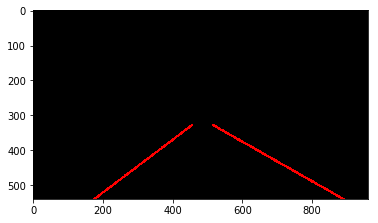

 85%|████████▍ | 578/682 [05:37<01:43,  1.00it/s]

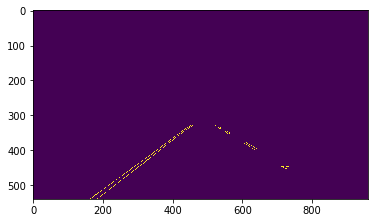

[[ 0.55263158]
 [-0.84210526]
 [-0.78571429]
 [-0.80487805]
 [-0.83333333]
 [-0.75925926]
 [-0.875     ]
 [-0.875     ]
 [-0.91666667]
 [ 0.5       ]
 [ 0.61764706]
 [-0.65384615]
 [-0.80645161]
 [-0.80952381]
 [-0.77777778]
 [-0.91666667]
 [-0.8       ]
 [-0.81818182]
 [-0.8       ]
 [-0.9       ]
 [-0.1       ]]
left_m = -0.736503317357  right_m = 0.608350187807
left_c = 664.344987368  right_c = 9.15655398247
left_y = 327.026468019  right_y = 344.965857652  min y = 327.026468019
left_y = 542.821940004  right_y = 400.325724742  max y = 542.821940004


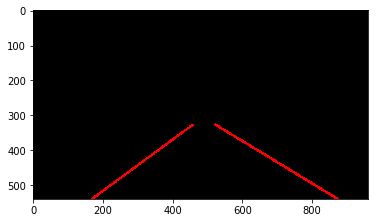

 85%|████████▍ | 579/682 [05:37<01:26,  1.20it/s]

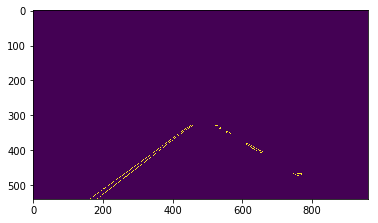

[[-0.9       ]
 [-0.70588235]
 [-0.81481481]
 [ 0.        ]
 [-0.61538462]
 [-0.64285714]
 [-0.91666667]
 [-0.63636364]
 [-0.70833333]
 [-0.83333333]
 [-0.8       ]
 [-0.81818182]
 [-0.68421053]
 [ 0.55555556]
 [-0.9       ]
 [-0.9       ]
 [ 0.54545455]
 [-0.7       ]
 [-0.64285714]
 [ 0.61538462]
 [-0.69230769]
 [-0.85714286]
 [ 0.58823529]
 [ 0.66666667]]
left_m = -0.729317469814  right_m = 0.5618274495
left_c = 659.262361637  right_c = 38.2199358127
left_y = 326.693595402  right_y = 348.910515386  min y = 326.693595402
left_y = 536.737026708  right_y = 401.722295639  max y = 536.737026708


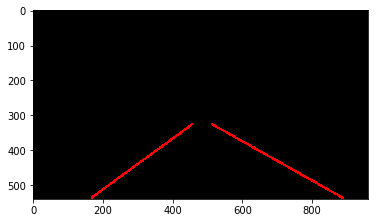

 85%|████████▌ | 580/682 [05:38<01:16,  1.32it/s]

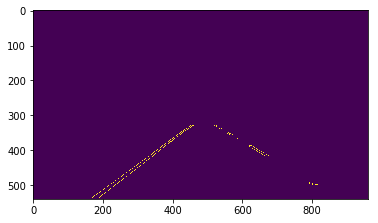

[[-0.75384615]
 [-0.7826087 ]
 [-0.70967742]
 [-0.74193548]
 [-0.81355932]
 [ 0.54545455]
 [ 0.5       ]
 [-0.80769231]
 [ 0.57894737]
 [-0.8125    ]
 [-0.78571429]
 [-0.74285714]
 [-0.2       ]
 [-0.6       ]
 [-0.83333333]
 [-0.8125    ]
 [ 0.55      ]
 [-1.        ]
 [-0.86666667]
 [-0.76923077]
 [-0.63636364]
 [ 0.5       ]]
left_m = -0.741152274414  right_m = 0.591827364555
left_c = 666.476285884  right_c = 19.1854912764
left_y = 340.369285142  right_y = 351.200642792  min y = 340.369285142
left_y = 544.186160605  right_y = 418.077134986  max y = 544.186160605


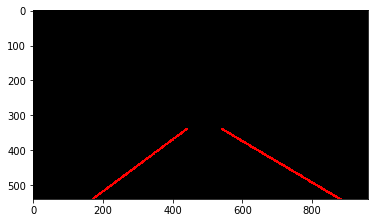

 85%|████████▌ | 581/682 [05:38<01:06,  1.53it/s]

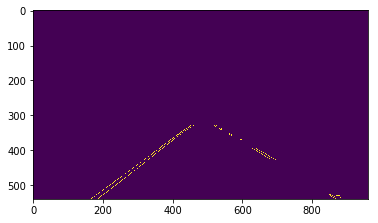

[[-0.80769231]
 [-0.65625   ]
 [-0.81355932]
 [-0.80952381]
 [-0.625     ]
 [-0.66666667]
 [-0.91666667]
 [-0.6       ]
 [ 0.59259259]
 [ 0.63888889]
 [ 0.66666667]
 [-0.8       ]
 [ 0.57142857]
 [-0.64705882]
 [-0.91666667]
 [-0.88235294]
 [-0.81818182]
 [-0.83333333]
 [ 0.        ]
 [-0.8125    ]
 [ 0.5625    ]
 [-0.77777778]
 [-0.81818182]
 [-0.85714286]
 [-0.83333333]
 [ 0.58333333]
 [-0.8       ]
 [-0.90909091]]
left_m = -0.748175039294  right_m = 0.59819224337
left_c = 668.432031673  right_c = 15.7749462451
left_y = 325.019688638  right_y = 395.028828542  min y = 325.019688638
left_y = 540.494099954  right_y = 430.920363144  max y = 540.494099954


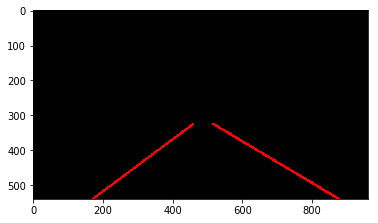

 85%|████████▌ | 582/682 [05:39<00:59,  1.69it/s]

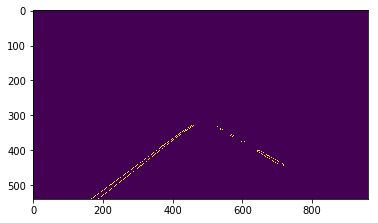

[[-0.65      ]
 [-0.7       ]
 [ 0.63414634]
 [-0.85714286]
 [ 0.5       ]
 [-0.85714286]
 [-0.73333333]
 [-0.84615385]
 [-0.84615385]
 [-0.75      ]
 [ 0.52173913]
 [ 0.54545455]
 [ 0.6       ]
 [-0.90909091]
 [-0.70588235]
 [ 0.54545455]
 [-0.68421053]
 [ 0.5       ]
 [-0.9       ]
 [-0.65517241]
 [-0.86363636]
 [-0.66666667]
 [-0.85      ]
 [-0.90909091]
 [-0.6       ]
 [-0.66666667]
 [-0.7       ]
 [-0.84210526]
 [ 0.7       ]]
left_m = -0.743270348585  right_m = 0.587398573432
left_c = 668.102860614  right_c = 23.0884092956
left_y = 326.941770614  right_y = 354.968603284  min y = 326.941770614
left_y = 543.976712401  right_y = 443.665787873  max y = 543.976712401


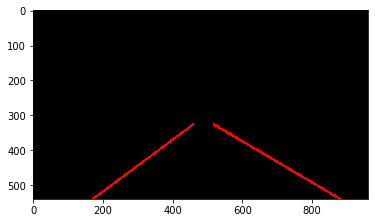

 85%|████████▌ | 583/682 [05:39<01:00,  1.63it/s]

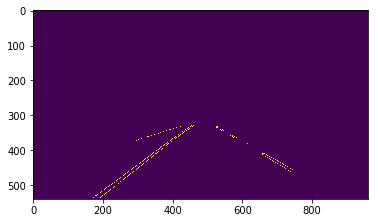

[[ 0.46666667]
 [-0.78947368]
 [-0.6969697 ]
 [-0.72727273]
 [-0.91666667]
 [ 0.62068966]
 [ 0.46153846]
 [-0.75      ]
 [-0.70588235]
 [-0.75      ]
 [-0.84210526]
 [ 0.64285714]
 [ 0.53846154]
 [-0.72727273]
 [-0.33333333]
 [-0.76923077]
 [ 0.63333333]
 [-0.28571429]
 [-0.69565217]
 [-0.35294118]
 [-0.9       ]
 [-0.33333333]
 [ 0.5       ]
 [-0.92307692]
 [-0.72727273]
 [-0.8       ]]
left_m = -0.756885513041  right_m = 0.530944001532
left_c = 673.032895453  right_c = 63.5242165242
left_y = 326.379330481  right_y = 411.823481529  min y = 326.379330481
left_y = 545.876129262  right_y = 451.113337643  max y = 545.876129262


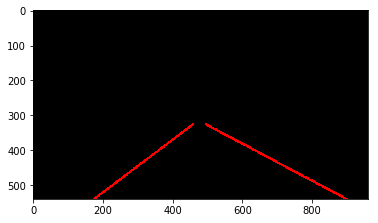

 86%|████████▌ | 584/682 [05:40<00:59,  1.64it/s]

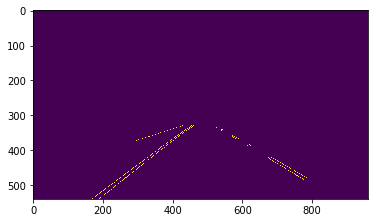

[[-0.75903614]
 [-0.72881356]
 [ 0.56410256]
 [ 0.66666667]
 [-0.77777778]
 [-0.31932773]
 [-0.63636364]
 [-0.84615385]
 [-0.66666667]
 [-0.8       ]
 [-0.72413793]
 [-0.91666667]
 [-0.8125    ]
 [ 0.66666667]
 [ 0.54166667]
 [ 0.57142857]
 [ 0.5       ]
 [-0.92307692]
 [ 0.45454545]
 [-0.9       ]
 [-0.90909091]
 [-0.66666667]
 [-0.6       ]
 [-0.90909091]
 [ 0.54545455]
 [-0.6       ]
 [-0.72727273]
 [ 0.54545455]]
left_m = -0.761485373675  right_m = 0.582582885072
left_c = 673.622857304  right_c = 27.0005343009
left_y = 338.569292888  right_y = 359.655361677  min y = 338.569292888
left_y = 544.17034378  right_y = 478.502270231  max y = 544.17034378


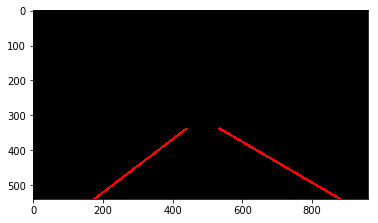

 86%|████████▌ | 585/682 [05:40<00:56,  1.73it/s]

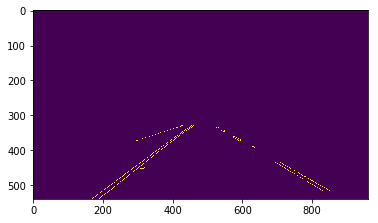

[[-0.78205128]
 [-0.84615385]
 [ 0.5       ]
 [-0.9       ]
 [-0.32      ]
 [-0.85714286]
 [-0.6       ]
 [ 0.54545455]
 [ 0.55813953]
 [-0.76923077]
 [-0.8       ]
 [ 0.5483871 ]
 [-0.8125    ]
 [ 0.5       ]
 [ 0.5625    ]
 [ 0.47368421]
 [ 0.        ]
 [-0.85714286]
 [-0.76470588]
 [ 0.53846154]
 [-0.84615385]
 [ 0.4       ]
 [-0.84615385]
 [-0.80952381]
 [-0.6       ]
 [-0.82352941]
 [ 0.66666667]
 [-0.91666667]
 [-0.75      ]
 [ 0.5       ]
 [-0.9       ]
 [ 0.5       ]
 [ 0.54545455]]
left_m = -0.749290809079  right_m = 0.576339675966
left_c = 669.121097721  right_c = 32.1786464478
left_y = 328.943070399  right_y = 365.302979156  min y = 328.943070399
left_y = 536.496624514  right_y = 511.693256851  max y = 536.496624514


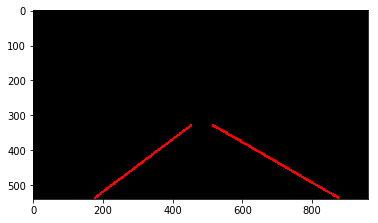

 86%|████████▌ | 586/682 [05:41<00:51,  1.87it/s]

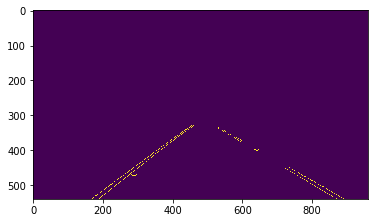

[[-0.77272727]
 [-0.875     ]
 [ 0.45454545]
 [ 0.57142857]
 [ 0.45454545]
 [-0.88235294]
 [ 0.625     ]
 [-0.72307692]
 [ 0.45454545]
 [ 0.45454545]
 [-0.73255814]
 [-0.8       ]
 [-0.71428571]
 [-0.84615385]
 [-0.75      ]
 [-0.73684211]
 [ 0.53846154]
 [ 0.58823529]
 [ 0.52      ]
 [ 0.45454545]
 [ 0.5       ]
 [-0.8       ]
 [ 0.5       ]
 [-0.72727273]
 [ 0.5       ]
 [ 0.55      ]
 [ 0.61538462]
 [ 0.52941176]
 [ 0.52380952]]
left_m = -0.753906817256  right_m = 0.575801455194
left_c = 673.688323582  right_c = 32.5144376252
left_y = 344.984951258  right_y = 366.479281638  min y = 344.984951258
left_y = 531.199935121  right_y = 532.885902189  max y = 532.885902189


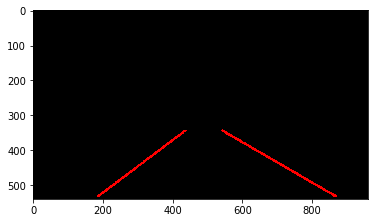

 86%|████████▌ | 587/682 [05:41<00:52,  1.82it/s]

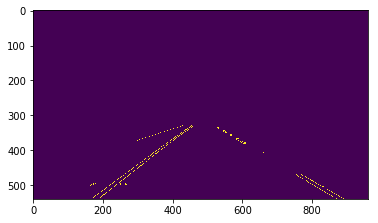

[[-0.85      ]
 [-0.90909091]
 [-0.7       ]
 [-0.74285714]
 [-0.72815534]
 [-0.73684211]
 [-0.70833333]
 [-0.71428571]
 [-0.33333333]
 [ 0.55263158]
 [-0.70114943]
 [ 0.56818182]
 [ 0.53846154]
 [-0.70588235]
 [-0.7       ]
 [ 0.56521739]
 [ 0.53846154]
 [-0.66666667]
 [ 0.66666667]
 [ 0.        ]
 [-0.72      ]
 [ 0.55      ]
 [ 0.6       ]
 [-0.34615385]
 [-0.69230769]
 [-0.33333333]
 [-0.33333333]
 [-0.69230769]
 [-0.73333333]
 [-0.63636364]
 [-0.73333333]
 [ 0.52941176]
 [-0.69230769]
 [ 0.53846154]]
left_m = -0.717046199496  right_m = 0.569007633707
left_c = 659.945736485  right_c = 35.9354273885
left_y = 332.972669515  right_y = 367.097870206  min y = 332.972669515
left_y = 540.916067369  right_y = 542.352221388  max y = 542.352221388


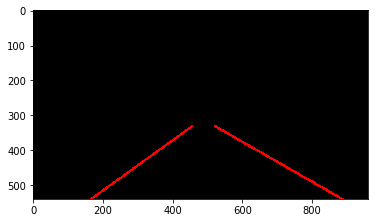

 86%|████████▌ | 588/682 [05:42<00:51,  1.81it/s]

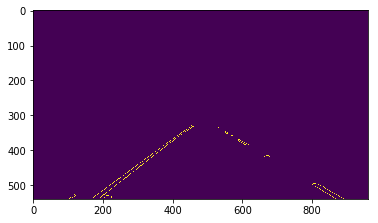

[[-0.91666667]
 [ 0.59259259]
 [-0.72727273]
 [ 0.55357143]
 [-0.70588235]
 [-0.72727273]
 [-0.6969697 ]
 [-0.66666667]
 [-0.83333333]
 [ 0.5952381 ]
 [ 0.5625    ]
 [-0.79166667]
 [-0.77777778]
 [-0.81818182]
 [-0.81818182]
 [-0.76190476]
 [-0.8       ]
 [-0.71428571]
 [ 0.61538462]
 [-0.72727273]
 [-0.81818182]
 [ 0.55555556]
 [ 0.5       ]
 [-0.81818182]]
left_m = -0.735176470936  right_m = 0.579571723738
left_c = 666.235349376  right_c = 28.8726081281
left_y = 327.318996274  right_y = 369.660781686  min y = 327.318996274
left_y = 525.081466956  right_y = 544.691442255  max y = 544.691442255


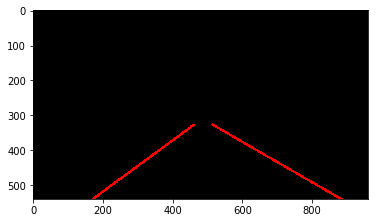

 86%|████████▋ | 589/682 [05:42<00:47,  1.96it/s]

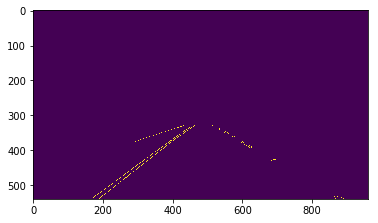

[[-0.75      ]
 [-0.81818182]
 [-0.76666667]
 [-0.7755102 ]
 [ 0.        ]
 [-0.88235294]
 [-0.75      ]
 [-0.33333333]
 [-0.7826087 ]
 [-0.77777778]
 [-0.73913043]
 [-0.92307692]
 [-0.84      ]
 [ 0.54166667]
 [-0.78571429]
 [ 0.57894737]
 [-0.27272727]
 [ 0.56521739]
 [-0.875     ]
 [-0.33333333]
 [-0.78947368]
 [-0.09090909]]
left_m = -0.744077593398  right_m = 0.51016088061
left_c = 669.102455198  right_c = 71.3357324301
left_y = 343.19646929  right_y = 373.861134632  min y = 343.19646929
left_y = 538.888876354  right_y = 388.145639289  max y = 538.888876354


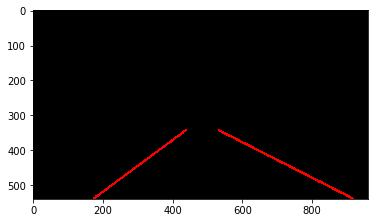

 87%|████████▋ | 590/682 [05:43<00:45,  2.03it/s]

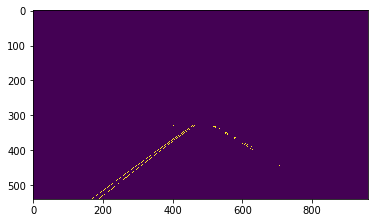

[[ 0.59375   ]
 [-0.73006135]
 [-0.75      ]
 [-0.8       ]
 [-0.8115942 ]
 [-0.80952381]
 [-0.8       ]
 [-0.75      ]
 [-0.75      ]
 [-0.79166667]
 [-0.91666667]
 [ 0.5       ]
 [-0.91666667]
 [-0.76923077]
 [-0.66666667]
 [ 0.54545455]
 [-0.6875    ]
 [ 0.5       ]
 [-0.84210526]
 [-0.86666667]]
left_m = -0.726611920618  right_m = 0.556934334981
left_c = 664.961769566  right_c = 44.0433225643
left_y = 330.720286081  right_y = 329.75063641  min y = 329.75063641
left_y = 542.164354981  right_y = 396.582756607  max y = 542.164354981


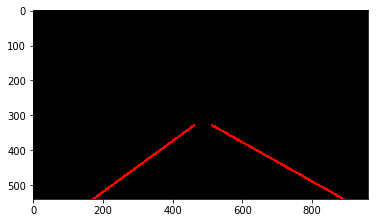

 87%|████████▋ | 591/682 [05:43<00:44,  2.05it/s]

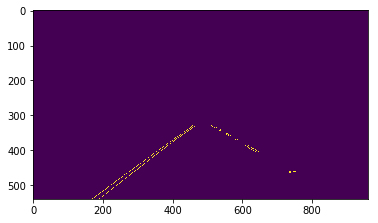

[[-0.725     ]
 [-0.69230769]
 [-0.90909091]
 [-0.9       ]
 [-0.70588235]
 [-0.73333333]
 [-0.76666667]
 [-0.875     ]
 [ 0.53333333]
 [-0.73684211]
 [ 0.56666667]
 [-0.6       ]
 [-0.8       ]
 [-0.9       ]
 [ 0.5       ]
 [-0.71428571]
 [-0.76470588]
 [-0.77272727]
 [-0.73684211]
 [-0.8       ]
 [-0.76923077]
 [ 0.54545455]]
left_m = -0.729236294752  right_m = 0.569304609889
left_c = 666.983864404  right_c = 38.1065632325
left_y = 328.618223639  right_y = 328.451914276  min y = 328.451914276
left_y = 540.096749117  right_y = 409.29316888  max y = 540.096749117


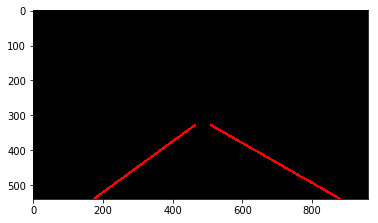

 87%|████████▋ | 592/682 [05:44<00:43,  2.08it/s]

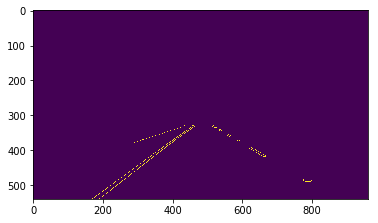

[[-0.76470588]
 [-0.90909091]
 [ 0.66666667]
 [-0.76315789]
 [ 0.61904762]
 [-0.32638889]
 [-0.84615385]
 [-0.72727273]
 [ 0.58823529]
 [-0.61538462]
 [-0.63636364]
 [-0.9       ]
 [-0.66666667]
 [-0.63636364]
 [-0.8125    ]
 [-0.76923077]
 [ 0.5       ]
 [ 0.61538462]
 [-0.63636364]
 [-0.6       ]
 [-0.8       ]
 [-0.8125    ]
 [-0.77777778]
 [ 0.        ]
 [-0.77777778]
 [-0.72727273]
 [-0.6       ]
 [-0.76470588]]
left_m = -0.722818650792  right_m = 0.593190846712
left_c = 662.957790009  right_c = 23.8507009422
left_y = 332.629666597  right_y = 354.851193408  min y = 332.629666597
left_y = 540.078619375  right_y = 420.102186546  max y = 540.078619375


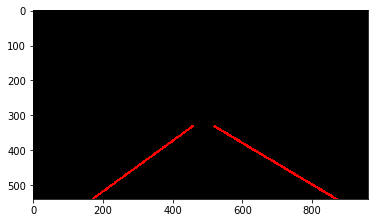

 87%|████████▋ | 593/682 [05:44<00:40,  2.21it/s]

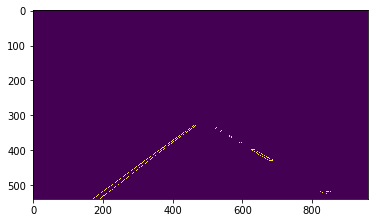

[[-0.77894737]
 [-0.71153846]
 [ 0.6       ]
 [ 0.47368421]
 [-0.75555556]
 [-0.80769231]
 [ 0.625     ]
 [ 0.63157895]
 [-0.8       ]
 [-0.69230769]
 [-0.6875    ]
 [-0.66666667]
 [-0.8       ]
 [-0.9       ]
 [ 0.54545455]
 [-0.64705882]
 [-0.8       ]]
left_m = -0.723731402763  right_m = 0.577966347549
left_c = 663.996811902  right_c = 36.0142515231
left_y = 332.527829437  right_y = 358.519473455  min y = 332.527829437
left_y = 539.515010627  right_y = 427.297468813  max y = 539.515010627


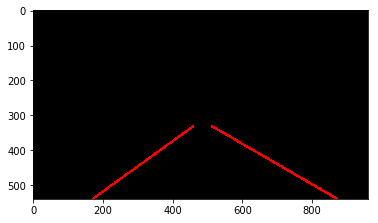

 87%|████████▋ | 594/682 [05:45<00:51,  1.72it/s]

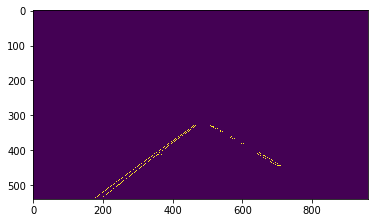

[[-0.72881356]
 [-0.91666667]
 [-0.875     ]
 [ 0.58823529]
 [-0.83333333]
 [ 0.46153846]
 [-0.76470588]
 [-0.76923077]
 [-0.76190476]
 [-0.8       ]
 [-0.71428571]
 [-0.74285714]
 [-0.80952381]
 [ 0.5       ]
 [-0.75      ]
 [ 0.61538462]
 [-0.8125    ]
 [-0.76923077]
 [ 0.5       ]
 [-0.76470588]
 [-0.90909091]
 [-0.66666667]
 [ 0.53846154]
 [-0.69230769]
 [ 0.57142857]]
left_m = -0.737097744794  right_m = 0.573617080272
left_c = 670.788476177  right_c = 38.8676925921
left_y = 328.038024848  right_y = 360.666874625  min y = 328.038024848
left_y = 541.796370838  right_y = 442.120500023  max y = 541.796370838


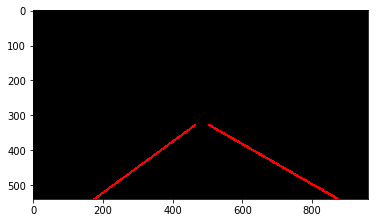

 87%|████████▋ | 595/682 [05:45<00:47,  1.84it/s]

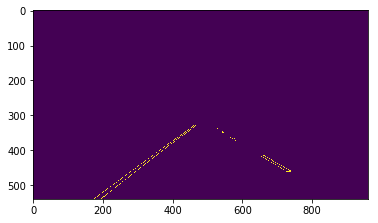

[[-0.81818182]
 [-0.75      ]
 [-0.77419355]
 [-0.69565217]
 [ 0.5625    ]
 [-0.83870968]
 [-0.79166667]
 [ 0.59210526]
 [-0.6       ]
 [-0.9       ]
 [-0.75      ]
 [-0.66666667]
 [-0.8       ]
 [ 0.6       ]
 [-0.8125    ]
 [ 0.6       ]
 [-0.77272727]
 [ 0.53333333]
 [-0.69230769]
 [ 0.        ]
 [-0.7       ]
 [-0.7       ]
 [-0.9       ]
 [-0.75      ]
 [-0.8       ]]
left_m = -0.751740850723  right_m = 0.5841576034
left_c = 677.253807356  right_c = 30.3550008377
left_y = 332.204756875  right_y = 361.572361965  min y = 332.204756875
left_y = 542.692195077  right_y = 461.463312147  max y = 542.692195077


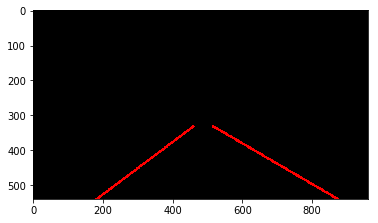

 87%|████████▋ | 596/682 [05:46<00:46,  1.85it/s]

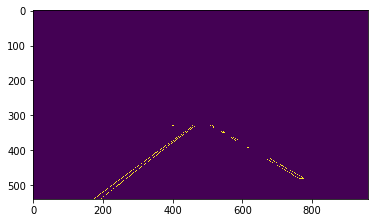

[[ 0.5       ]
 [-0.78571429]
 [-0.8       ]
 [-0.75      ]
 [-0.76190476]
 [ 0.59574468]
 [-0.7       ]
 [-0.6       ]
 [-0.63636364]
 [-0.78571429]
 [-0.68181818]
 [-0.70588235]
 [ 0.57142857]
 [-0.63636364]
 [-0.64285714]
 [-0.83333333]
 [-0.6       ]
 [-0.70588235]
 [ 0.5483871 ]
 [ 0.36363636]
 [-0.76923077]
 [-0.76923077]
 [ 0.58333333]
 [-0.61538462]
 [ 0.54545455]
 [-0.76923077]
 [-0.8       ]
 [-0.78571429]
 [ 0.45454545]
 [ 0.57142857]
 [ 0.6       ]
 [-0.61538462]]
left_m = -0.725602478478  right_m = 0.580941962387
left_c = 666.926280505  right_c = 33.0934332177
left_y = 337.502755276  right_y = 363.068467854  min y = 337.502755276
left_y = 539.945846771  right_y = 477.514034444  max y = 539.945846771


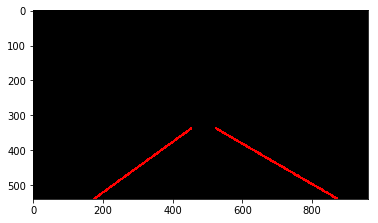

 88%|████████▊ | 597/682 [05:46<00:44,  1.90it/s]

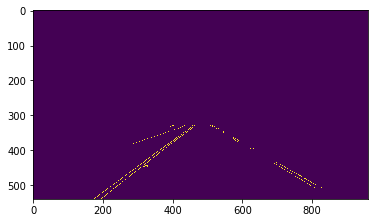

[[-0.73333333]
 [-0.8       ]
 [-0.64285714]
 [-0.75      ]
 [-0.375     ]
 [ 0.578125  ]
 [-0.84615385]
 [-0.66666667]
 [ 0.59259259]
 [ 0.53846154]
 [-0.6       ]
 [-0.35      ]
 [-0.80769231]
 [-0.375     ]
 [-0.63636364]
 [-0.66666667]
 [-0.30769231]
 [-0.83333333]
 [ 0.52941176]
 [ 0.        ]
 [-0.90909091]
 [ 0.58823529]
 [ 0.45454545]
 [ 0.61111111]
 [-0.90909091]
 [ 0.5       ]
 [-0.66666667]
 [-0.83333333]
 [-0.6       ]
 [-0.8       ]
 [ 0.6       ]
 [ 0.45454545]
 [-0.84615385]]
left_m = -0.742428969727  right_m = 0.593380124897
left_c = 672.94656279  right_c = 25.9823204091
left_y = 341.080813322  right_y = 365.39575185  min y = 341.080813322
left_y = 540.051777209  right_y = 504.246701076  max y = 540.051777209


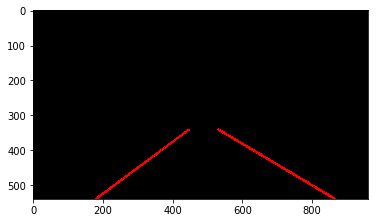

 88%|████████▊ | 598/682 [05:47<00:47,  1.79it/s]

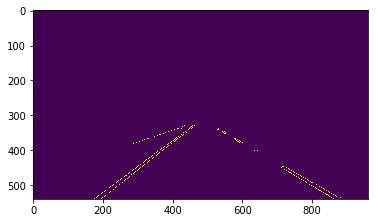

[[-0.73333333]
 [-0.83333333]
 [-0.33333333]
 [-0.64285714]
 [ 0.58      ]
 [ 0.52631579]
 [-0.74358974]
 [-0.84615385]
 [ 0.52631579]
 [ 0.38461538]
 [-0.36842105]
 [ 0.56666667]
 [-0.84      ]
 [-0.66666667]
 [ 0.54285714]
 [-0.83333333]
 [ 0.57142857]
 [-0.78947368]
 [-0.76190476]
 [-0.75      ]
 [-0.71428571]
 [ 0.64      ]
 [-0.73333333]
 [ 0.52173913]
 [-0.33333333]
 [-0.4       ]
 [-0.66666667]
 [-0.6875    ]
 [-0.7       ]
 [-0.69230769]
 [ 0.5625    ]
 [ 0.52380952]
 [-0.72727273]
 [ 0.64285714]
 [-0.36363636]]
left_m = -0.766030962313  right_m = 0.584163125953
left_c = 681.911202036  right_c = 29.6644138471
left_y = 327.238866485  right_y = 366.142374396  min y = 327.238866485
left_y = 546.323721707  right_y = 527.955560285  max y = 546.323721707


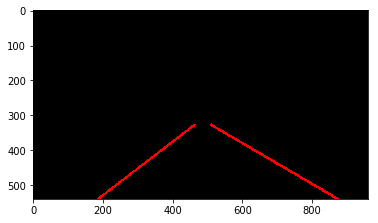

 88%|████████▊ | 599/682 [05:47<00:42,  1.96it/s]

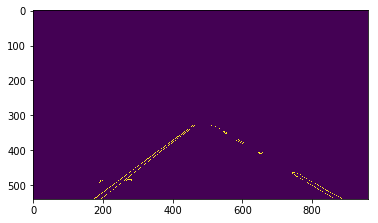

[[-0.81818182]
 [ 0.6       ]
 [-0.80898876]
 [-0.76315789]
 [-0.78571429]
 [ 0.5       ]
 [-0.74285714]
 [-0.75163399]
 [ 0.609375  ]
 [ 0.53333333]
 [-0.88      ]
 [ 0.60869565]
 [-0.6       ]
 [ 0.5       ]
 [ 0.5       ]
 [-0.6       ]
 [-0.6       ]
 [-0.81818182]
 [-0.83333333]
 [ 0.5       ]
 [-0.85      ]
 [-0.7       ]
 [-0.61538462]
 [ 0.4       ]
 [ 0.59375   ]
 [-0.6       ]
 [ 0.        ]
 [-0.9       ]
 [ 0.5       ]
 [-0.72727273]]
left_m = -0.765478838853  right_m = 0.570551753636
left_c = 681.995866342  right_c = 37.0429426861
left_y = 332.172036986  right_y = 368.533511548  min y = 332.172036986
left_y = 533.492971605  right_y = 535.705175364  max y = 535.705175364


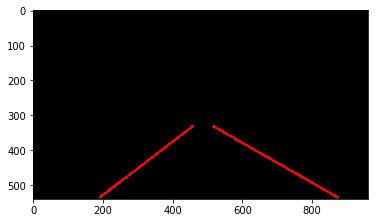

 88%|████████▊ | 600/682 [05:48<00:39,  2.06it/s]

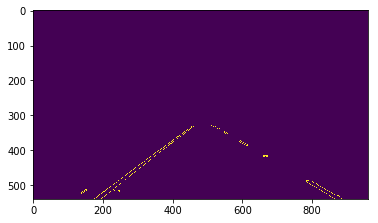

[[-0.92307692]
 [-0.75      ]
 [-0.75247525]
 [-0.75      ]
 [-0.76923077]
 [ 0.54545455]
 [ 0.41176471]
 [-0.9       ]
 [ 0.60493827]
 [-0.76923077]
 [-0.83870968]
 [-0.9       ]
 [ 0.4       ]
 [-0.76190476]
 [ 0.46153846]
 [-0.71428571]
 [-1.        ]
 [-0.6       ]
 [ 0.52941176]
 [-0.76190476]
 [-0.83333333]
 [-0.70833333]
 [-0.83333333]
 [ 0.54545455]
 [-0.83333333]
 [ 0.54545455]
 [ 0.6       ]]
left_m = -0.751960098626  right_m = 0.59108824851
left_c = 677.072816967  right_c = 22.0111345317
left_y = 334.930972092  right_y = 370.753201153  min y = 334.930972092
left_y = 538.71215882  right_y = 534.48464599  max y = 538.71215882


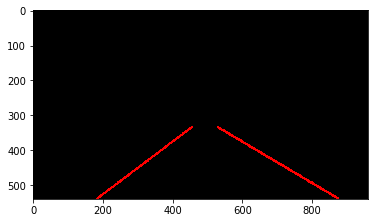

 88%|████████▊ | 601/682 [05:48<00:38,  2.10it/s]

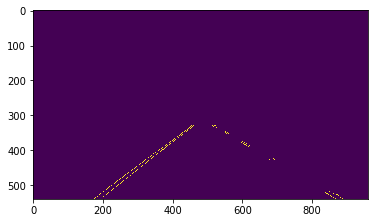

[[-0.81012658]
 [-0.66666667]
 [ 0.8       ]
 [-0.64285714]
 [-0.77272727]
 [-0.86363636]
 [-0.9       ]
 [-0.73333333]
 [-0.63636364]
 [-0.76      ]
 [ 0.52941176]
 [-0.66666667]
 [-0.6       ]
 [-0.77272727]
 [-0.72727273]
 [-0.61538462]
 [ 0.5625    ]
 [-0.72413793]
 [ 0.53846154]
 [ 0.53846154]
 [-0.8       ]
 [-0.72727273]]
left_m = -0.746123380499  right_m = 0.555635565441
left_c = 671.379695462  right_c = 45.1762782844
left_y = 337.116420999  right_y = 378.557617549  min y = 337.116420999
left_y = 539.315857114  right_y = 534.135575872  max y = 539.315857114


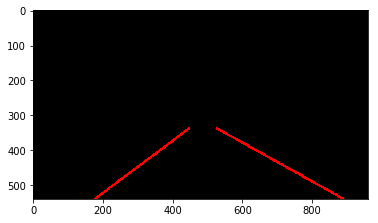

 88%|████████▊ | 602/682 [05:49<00:40,  1.99it/s]

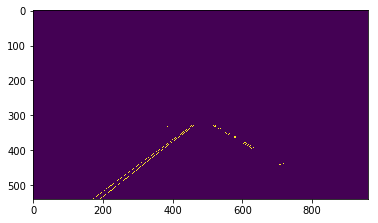

[[-0.83333333]
 [-0.70588235]
 [-0.83333333]
 [-0.73493976]
 [-0.75      ]
 [-0.75609756]
 [-0.72413793]
 [-0.80555556]
 [ 0.5625    ]
 [-0.7       ]
 [ 0.57894737]
 [ 0.57894737]
 [-0.66666667]
 [-0.80645161]
 [-0.76923077]
 [-0.6       ]
 [ 0.54545455]
 [-0.73333333]
 [-0.2       ]]
left_m = -0.736659525996  right_m = 0.506094022055
left_c = 669.231992077  right_c = 73.7011027278
left_y = 336.998545853  right_y = 376.851421938  min y = 336.998545853
left_y = 541.78989408  right_y = 395.576900754  max y = 541.78989408


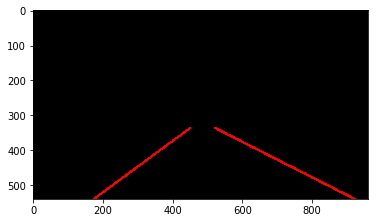

 88%|████████▊ | 603/682 [05:49<00:37,  2.11it/s]

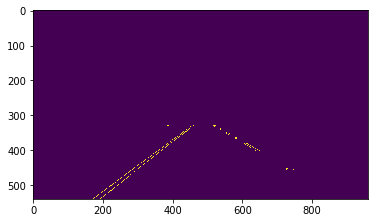

[[-0.78947368]
 [-0.69230769]
 [-0.71875   ]
 [ 0.52631579]
 [-0.78571429]
 [-0.76923077]
 [-0.69444444]
 [ 0.625     ]
 [-0.76      ]
 [-0.72093023]
 [-0.7826087 ]
 [-0.72222222]
 [-0.8       ]
 [-0.71428571]
 [-0.66666667]
 [-0.875     ]
 [-0.83870968]
 [-0.85714286]
 [-0.66666667]
 [ 0.        ]
 [-0.8       ]
 [ 0.61111111]
 [-0.63636364]]
left_m = -0.747814868313  right_m = 0.637027569838
left_c = 672.99752494  right_c = -6.26200474712
left_y = 329.750500384  right_y = 379.776702574  min y = 329.750500384
left_y = 543.625552721  right_y = 400.161584809  max y = 543.625552721


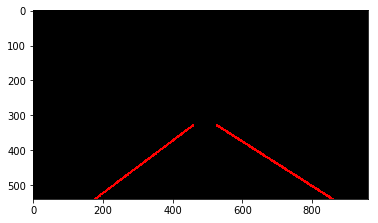

 89%|████████▊ | 604/682 [05:50<00:35,  2.17it/s]

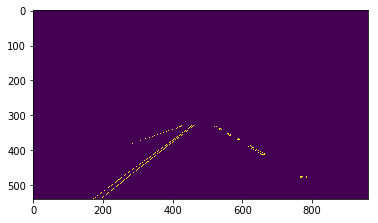

[[-0.72941176]
 [-0.78125   ]
 [-0.69444444]
 [-0.78723404]
 [-0.91666667]
 [-0.34375   ]
 [ 0.5       ]
 [-0.84210526]
 [ 0.5862069 ]
 [-0.27272727]
 [ 0.42857143]
 [-0.6875    ]
 [-0.81818182]
 [-0.41666667]
 [-0.8       ]
 [ 0.54545455]
 [-0.79310345]
 [-0.76190476]
 [-0.71428571]
 [ 0.54545455]]
left_m = -0.753227540162  right_m = 0.628792144026
left_c = 675.130947199  right_c = -1.03011456628
left_y = 330.905961345  right_y = 351.093486088  min y = 330.905961345
left_y = 533.524169649  right_y = 411.457531915  max y = 533.524169649


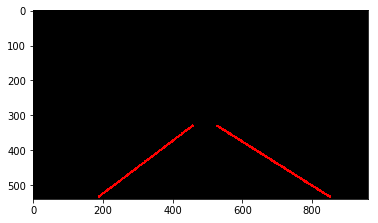

 89%|████████▊ | 605/682 [05:50<00:35,  2.18it/s]

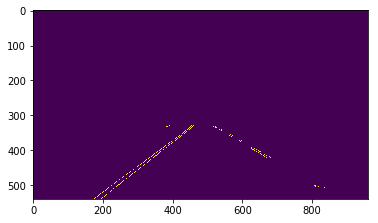

[[-0.84      ]
 [-0.875     ]
 [-0.75342466]
 [ 0.55263158]
 [-1.        ]
 [-0.7       ]
 [-0.72727273]
 [-0.70967742]
 [-0.08333333]
 [-1.        ]
 [-0.85714286]
 [-0.7       ]
 [ 0.57142857]
 [-0.9       ]
 [-0.75      ]
 [-0.68181818]
 [-1.        ]
 [-0.64705882]
 [ 0.5       ]
 [-0.6       ]
 [-0.8       ]
 [ 0.58333333]
 [ 0.57142857]
 [-0.9       ]
 [ 0.        ]]
left_m = -0.746895398356  right_m = 0.578768554953
left_c = 675.261287863  right_c = 29.9343667262
left_y = 348.867998782  right_y = 354.623526055  min y = 348.867998782
left_y = 544.554593151  right_y = 424.075752649  max y = 544.554593151


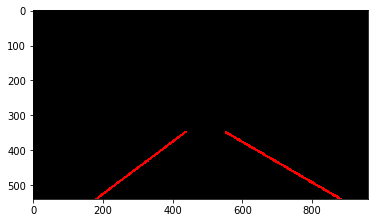

 89%|████████▉ | 606/682 [05:51<00:36,  2.07it/s]

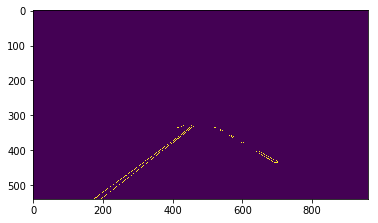

[[-0.7278481 ]
 [-0.86363636]
 [-0.77083333]
 [-0.76470588]
 [ 0.5862069 ]
 [-0.73493976]
 [-0.81818182]
 [-0.74193548]
 [ 0.53846154]
 [-0.69230769]
 [-0.66666667]
 [-0.63636364]
 [ 0.5       ]
 [ 0.5       ]
 [-0.73529412]
 [-0.75      ]
 [ 0.57142857]
 [-0.76923077]
 [-0.72727273]]
left_m = -0.770362161284  right_m = 0.583557457213
left_c = 685.582112248  right_c = 27.5547677262
left_y = 330.445155896  right_y = 356.681173594  min y = 330.445155896
left_y = 550.768734023  right_y = 433.127200489  max y = 550.768734023


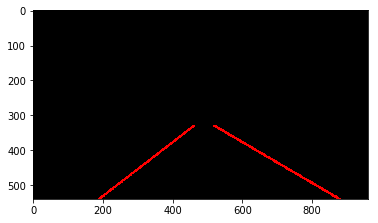

 89%|████████▉ | 607/682 [05:51<00:35,  2.10it/s]

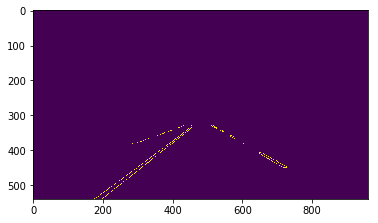

[[-0.82051282]
 [-0.9       ]
 [-0.775     ]
 [-0.74358974]
 [-0.85714286]
 [ 0.54545455]
 [-0.90909091]
 [-0.36363636]
 [-0.90909091]
 [ 0.58536585]
 [ 0.53333333]
 [-0.625     ]
 [-0.85714286]
 [-0.86666667]
 [-0.6875    ]
 [ 0.59183673]
 [ 0.54545455]
 [-0.66666667]
 [-0.33333333]
 [-0.33333333]
 [-0.66666667]
 [-0.69230769]
 [-0.21428571]
 [-0.91666667]
 [-0.83333333]
 [-0.6       ]
 [-0.7826087 ]
 [-0.70588235]
 [-0.91666667]
 [ 0.45454545]
 [-0.63636364]
 [-0.76923077]
 [-0.6       ]]
left_m = -0.735112702691  right_m = 0.535811549203
left_c = 671.090116618  right_c = 59.6733507953
left_y = 337.348949596  right_y = 406.879234679  min y = 337.348949596
left_y = 541.710280945  right_y = 446.52928932  max y = 541.710280945


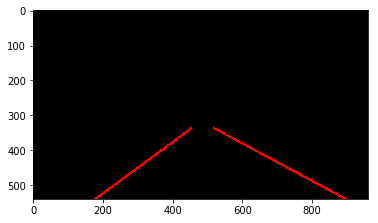

 89%|████████▉ | 608/682 [05:52<00:34,  2.15it/s]

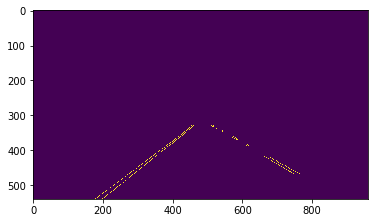

[[-0.78813559]
 [-0.83870968]
 [-0.77419355]
 [-0.75581395]
 [ 0.53333333]
 [ 0.54545455]
 [ 0.5625    ]
 [ 0.58823529]
 [-0.77777778]
 [ 0.55555556]
 [ 0.54166667]
 [ 0.53846154]
 [ 0.5       ]
 [-0.84615385]
 [-0.80952381]
 [ 0.53846154]
 [ 0.53846154]
 [ 0.5       ]
 [-0.7       ]
 [-0.76470588]
 [-0.9       ]
 [-0.71428571]]
left_m = -0.754534680726  right_m = 0.580534098347
left_c = 679.033592216  right_c = 30.1620734522
left_y = 344.020193974  right_y = 359.905441313  min y = 344.020193974
left_y = 543.971884366  right_y = 465.562647212  max y = 543.971884366


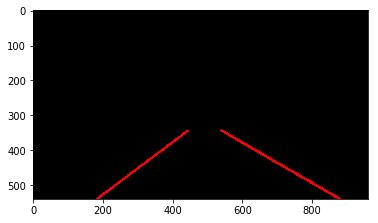

 89%|████████▉ | 609/682 [05:52<00:32,  2.25it/s]

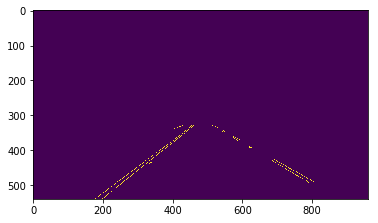

[[-0.75609756]
 [-0.81060606]
 [-0.9047619 ]
 [ 0.54545455]
 [-0.8125    ]
 [-0.9       ]
 [-0.71875   ]
 [-0.72727273]
 [-0.775     ]
 [ 0.54285714]
 [-0.77777778]
 [ 0.5       ]
 [ 0.65217391]
 [-0.86666667]
 [ 0.57142857]
 [ 0.52941176]
 [ 0.66666667]
 [ 0.625     ]
 [ 0.09090909]
 [ 0.5       ]
 [ 0.        ]
 [-0.83333333]
 [ 0.5       ]
 [ 0.45454545]
 [ 0.54545455]]
left_m = -0.741892973911  right_m = 0.583397388003
left_c = 672.312237272  right_c = 27.2043872521
left_y = 338.460399012  right_y = 360.90769319  min y = 338.460399012
left_y = 540.255287916  right_y = 485.754734222  max y = 540.255287916


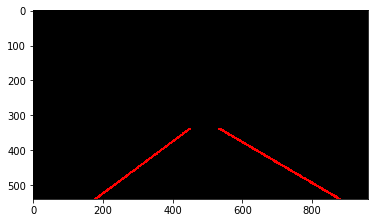

 89%|████████▉ | 610/682 [05:52<00:31,  2.29it/s]

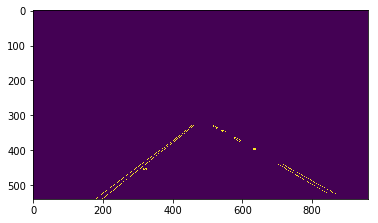

[[ 0.66666667]
 [-0.92857143]
 [-0.83783784]
 [-0.81132075]
 [-0.9       ]
 [ 0.52      ]
 [ 0.65      ]
 [-0.73684211]
 [ 0.5625    ]
 [ 0.61111111]
 [ 0.58333333]
 [-0.75      ]
 [ 0.625     ]
 [ 0.625     ]
 [-0.8       ]
 [-0.72222222]
 [ 0.5       ]
 [-0.92857143]
 [-0.84210526]
 [-0.66666667]
 [-0.70588235]
 [-0.72222222]
 [-0.88888889]
 [ 0.64      ]
 [-0.7       ]
 [ 0.5       ]
 [ 0.72727273]
 [-0.63636364]
 [-0.72222222]
 [-0.76923077]
 [-0.8       ]
 [ 0.63636364]
 [-0.84615385]
 [-0.72727273]
 [ 0.5       ]
 [ 0.6       ]
 [-0.7       ]
 [-0.9       ]]
left_m = -0.755051932531  right_m = 0.563401219456
left_c = 678.622931643  right_c = 41.3423414258
left_y = 334.319250409  right_y = 437.413398704  min y = 334.319250409
left_y = 542.713583788  right_y = 528.120995036  max y = 542.713583788


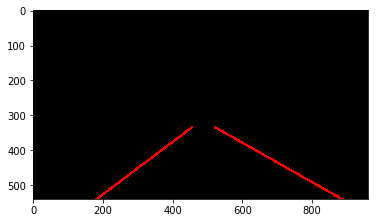

 90%|████████▉ | 611/682 [05:53<00:31,  2.28it/s]

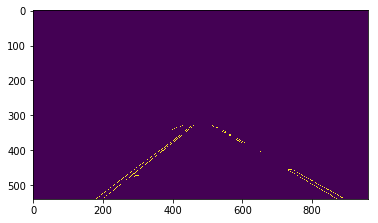

[[-0.70588235]
 [-0.83783784]
 [ 0.5       ]
 [-0.64285714]
 [-0.80666667]
 [-0.73913043]
 [-0.91666667]
 [ 0.55555556]
 [ 0.57894737]
 [ 0.55555556]
 [ 0.52173913]
 [ 0.59090909]
 [-0.63636364]
 [ 0.54545455]
 [-0.64285714]
 [-0.35714286]
 [ 0.55      ]
 [-0.73684211]
 [-0.75      ]
 [ 0.61904762]
 [-0.85185185]
 [ 0.58333333]
 [ 0.        ]
 [-0.83333333]
 [ 0.6       ]
 [ 0.58823529]]
left_m = -0.758235034988  right_m = 0.567109532856
left_c = 677.087862248  right_c = 37.9293403886
left_y = 333.607391398  right_y = 367.419978978  min y = 333.607391398
left_y = 528.47379539  right_y = 542.65682463  max y = 542.65682463


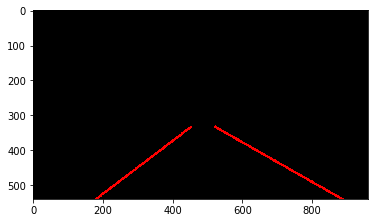

 90%|████████▉ | 612/682 [05:53<00:29,  2.36it/s]

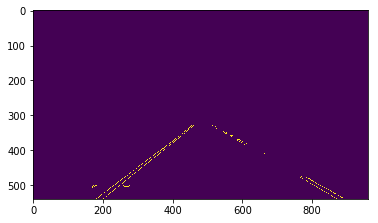

[[-0.6875    ]
 [-0.81481481]
 [-0.8       ]
 [-0.83333333]
 [ 0.55263158]
 [-0.82608696]
 [-1.        ]
 [ 0.53448276]
 [-0.79166667]
 [ 0.6       ]
 [-0.86666667]
 [-0.92857143]
 [-0.72727273]
 [-0.8       ]
 [ 0.58823529]
 [-0.9       ]
 [ 0.54166667]
 [-0.78571429]
 [-0.76923077]
 [-0.70588235]
 [ 0.5       ]
 [ 0.55555556]
 [-0.8       ]
 [ 0.5625    ]
 [ 0.5       ]
 [-0.83333333]
 [-0.86666667]
 [-0.90909091]
 [-0.8       ]]
left_m = -0.76108776783  right_m = 0.573240313989
left_c = 680.584524301  right_c = 35.2760986861
left_y = 338.095028777  right_y = 371.768162997  min y = 338.095028777
left_y = 540.54437502  right_y = 546.03321845  max y = 546.03321845


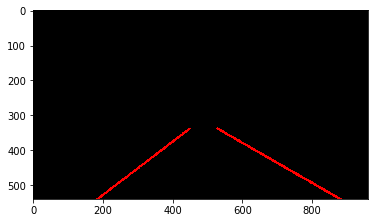

 90%|████████▉ | 613/682 [05:54<00:29,  2.31it/s]

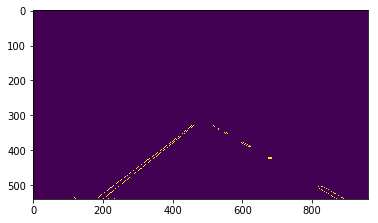

[[-0.79545455]
 [ 0.5       ]
 [-0.75396825]
 [-0.78787879]
 [-0.77777778]
 [-0.87234043]
 [ 0.58823529]
 [-0.7826087 ]
 [-0.82051282]
 [-0.72727273]
 [ 0.61111111]
 [ 0.54545455]
 [ 0.59259259]
 [-0.81818182]
 [ 0.57142857]
 [-0.8       ]
 [-1.        ]
 [-0.09090909]
 [ 0.57894737]
 [ 0.63636364]]
left_m = -0.798030083674  right_m = 0.577914516902
left_c = 694.806340539  right_c = 29.871997378
left_y = 334.894772802  right_y = 373.153220418  min y = 334.894772802
left_y = 528.816083135  right_y = 534.96928515  max y = 534.96928515


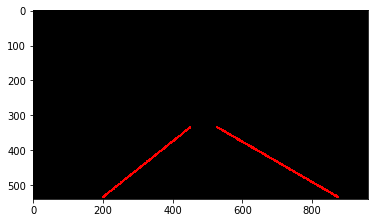

 90%|█████████ | 614/682 [05:54<00:30,  2.26it/s]

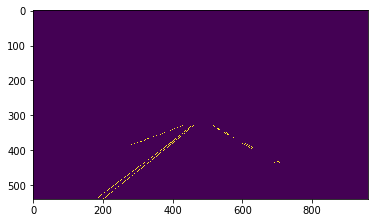

[[-0.75324675]
 [ 0.54545455]
 [-0.77272727]
 [-1.        ]
 [ 0.59259259]
 [-0.8       ]
 [-0.38461538]
 [-0.41176471]
 [-0.3       ]
 [-0.91666667]
 [-0.85185185]
 [-0.8125    ]
 [ 0.51612903]
 [-0.91666667]
 [-0.76923077]
 [ 0.4       ]
 [ 0.5       ]
 [-0.75      ]
 [ 0.        ]
 [-0.375     ]
 [-0.41666667]
 [-0.91666667]
 [-0.92307692]
 [-0.93333333]
 [-0.75      ]
 [-0.4       ]
 [ 0.5       ]
 [-0.8125    ]
 [-0.7       ]
 [-1.        ]]
left_m = -0.801441473552  right_m = 0.544414296063
left_c = 697.153541412  right_c = 51.8304951565
left_y = 330.093346525  right_y = 350.169529399  min y = 330.093346525
left_y = 551.291193225  right_y = 396.444744564  max y = 551.291193225


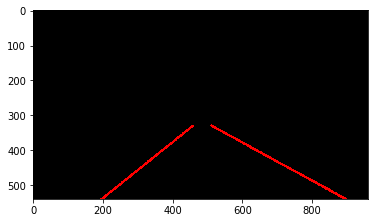

 90%|█████████ | 615/682 [05:55<00:29,  2.25it/s]

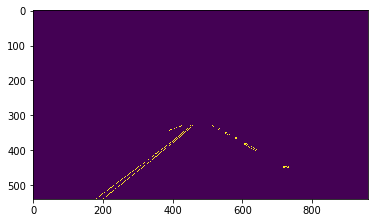

[[-0.80882353]
 [-0.86666667]
 [-0.7962963 ]
 [-0.84210526]
 [-0.91666667]
 [-0.63636364]
 [-0.83870968]
 [-0.3       ]
 [-0.78      ]
 [ 0.5       ]
 [-0.8       ]
 [-0.8       ]
 [ 0.59259259]
 [-0.7       ]
 [-0.8       ]
 [ 0.54545455]
 [-0.90909091]
 [-0.78947368]
 [-0.8125    ]
 [-0.83333333]
 [ 0.45454545]
 [-0.45454545]
 [-0.91666667]
 [ 0.54545455]]
left_m = -0.773616567553  right_m = 0.46362767845
left_c = 685.714532467  right_c = 101.402074519
left_y = 331.398144528  right_y = 383.751330695  min y = 331.398144528
left_y = 534.085685227  right_y = 400.441927119  max y = 534.085685227


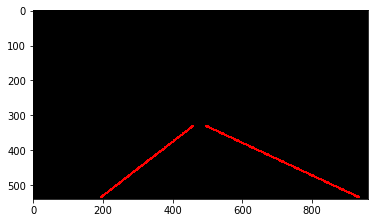

 90%|█████████ | 616/682 [05:55<00:28,  2.28it/s]

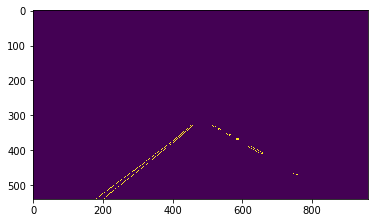

[[-0.66666667]
 [-0.86842105]
 [-0.83333333]
 [ 0.57142857]
 [-0.83333333]
 [-0.69230769]
 [-0.84      ]
 [-0.6875    ]
 [-0.6       ]
 [ 0.5       ]
 [ 0.5       ]
 [-0.85106383]
 [-0.80645161]
 [-0.91666667]
 [ 0.53333333]
 [-0.90909091]
 [-0.66666667]
 [ 0.5       ]
 [-0.91666667]
 [-0.83333333]
 [-0.92307692]
 [-0.86666667]
 [-0.6       ]
 [-0.90909091]
 [ 0.        ]
 [ 0.5       ]]
left_m = -0.751810829815  right_m = 0.538091200044
left_c = 676.588085819  right_c = 56.141409306
left_y = 336.769590743  right_y = 353.70584293  min y = 336.769590743
left_y = 540.510325623  right_y = 409.667327735  max y = 540.510325623


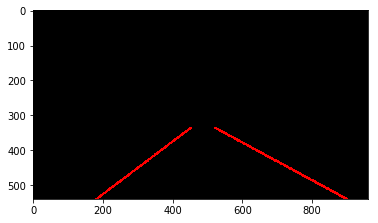

 90%|█████████ | 617/682 [05:56<00:28,  2.30it/s]

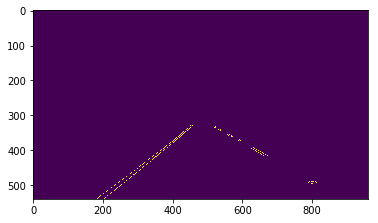

[[-0.83333333]
 [-0.92307692]
 [-0.8       ]
 [-0.79245283]
 [-0.73611111]
 [-0.83333333]
 [-0.8       ]
 [-0.70588235]
 [-0.69565217]
 [-0.8       ]
 [ 0.56521739]
 [-0.9375    ]
 [-0.94117647]
 [-0.7       ]
 [-1.        ]
 [-0.72727273]
 [-0.71428571]
 [-0.79166667]
 [ 0.52380952]
 [ 0.42857143]
 [-0.72222222]
 [-0.6875    ]
 [-0.69230769]
 [-1.        ]]
left_m = -0.762398391985  right_m = 0.520039584364
left_c = 682.255486917  right_c = 68.2543295398
left_y = 333.077023388  right_y = 391.19891143  min y = 333.077023388
left_y = 539.686987616  right_y = 418.761009401  max y = 539.686987616


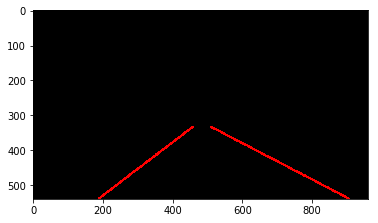

 91%|█████████ | 618/682 [05:56<00:28,  2.22it/s]

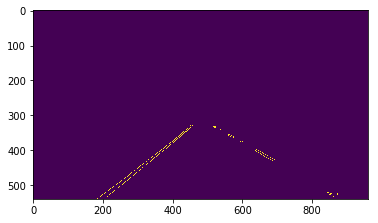

[[-0.76470588]
 [-1.        ]
 [-0.75862069]
 [-0.94444444]
 [-1.        ]
 [-0.81481481]
 [-0.8       ]
 [-0.84615385]
 [-0.77777778]
 [-0.75      ]
 [ 0.53125   ]
 [-0.76      ]
 [ 0.57407407]
 [ 0.52      ]
 [ 0.54545455]
 [-0.66666667]
 [-0.74193548]
 [-0.78571429]
 [-0.74074074]
 [-0.8       ]
 [-0.8       ]
 [-0.72727273]]
left_m = -0.793256692117  right_m = 0.536588541667
left_c = 695.575300941  right_c = 56.9521484375
left_y = 338.609789489  right_y = 396.076106771  min y = 338.609789489
left_y = 533.75093575  right_y = 430.417773437  max y = 533.75093575


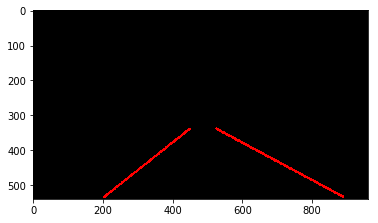

 91%|█████████ | 619/682 [05:56<00:27,  2.32it/s]

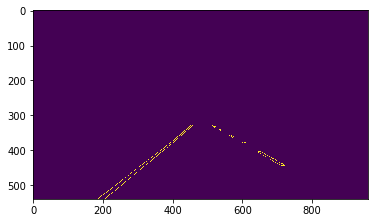

[[-0.84848485]
 [-0.9047619 ]
 [-0.86956522]
 [-0.83333333]
 [-0.82352941]
 [ 0.57894737]
 [-0.94736842]
 [-0.76086957]
 [ 0.53846154]
 [ 0.57142857]
 [-0.73913043]
 [-0.625     ]
 [ 0.5       ]
 [ 0.5       ]
 [-0.78571429]
 [-1.        ]
 [-0.8125    ]
 [ 0.        ]
 [-1.        ]
 [ 0.53571429]
 [-0.88235294]
 [-0.7       ]
 [-0.7       ]]
left_m = -0.783005549953  right_m = 0.578355763196
left_c = 690.680369388  right_c = 30.1987588034
left_y = 332.84683306  right_y = 356.969765009  min y = 332.84683306
left_y = 541.909314897  right_y = 444.879841015  max y = 541.909314897


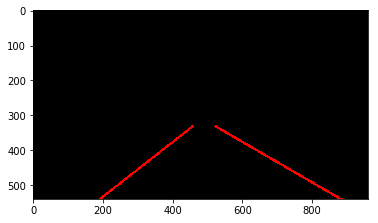

 91%|█████████ | 620/682 [05:57<00:25,  2.39it/s]

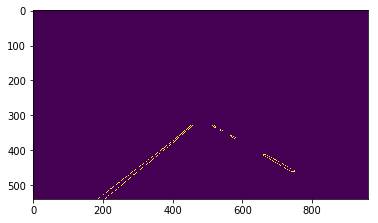

[[-0.91304348]
 [-0.76923077]
 [ 0.57352941]
 [-0.88      ]
 [-0.94117647]
 [-1.        ]
 [-0.92857143]
 [-0.93333333]
 [-1.        ]
 [-0.80555556]
 [-1.        ]
 [ 0.55223881]
 [-0.83333333]
 [-0.74285714]
 [-0.9       ]
 [ 0.55555556]
 [-1.        ]
 [-1.        ]
 [-0.69230769]
 [-0.8       ]
 [ 0.48      ]
 [ 0.5       ]
 [ 0.6       ]
 [ 0.6       ]]
left_m = -0.763279572071  right_m = 0.540533693633
left_c = 679.852379746  right_c = 56.5452626246
left_y = 346.299206751  right_y = 412.756966729  min y = 346.299206751
left_y = 530.24958362  right_y = 455.459128526  max y = 530.24958362


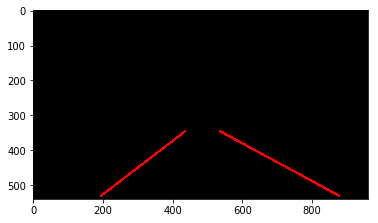

 91%|█████████ | 621/682 [05:57<00:24,  2.48it/s]

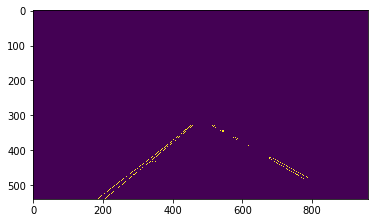

[[-1.        ]
 [-0.82352941]
 [-0.91666667]
 [-0.8       ]
 [ 0.        ]
 [ 0.59770115]
 [-0.8       ]
 [-0.875     ]
 [-0.72727273]
 [-0.72727273]
 [-0.83333333]
 [-0.82608696]
 [-0.79310345]
 [ 0.54320988]
 [-0.83333333]
 [-0.7       ]
 [-1.        ]
 [-0.9       ]
 [ 0.        ]
 [ 0.6       ]
 [-0.93333333]
 [ 0.5       ]
 [ 0.55      ]
 [ 0.6       ]]
left_m = -0.783516952887  right_m = 0.553631741083
left_c = 689.837195785  right_c = 47.5402702001
left_y = 341.17215175  right_y = 364.2176261  min y = 341.17215175
left_y = 528.43270349  right_y = 484.355713915  max y = 528.43270349


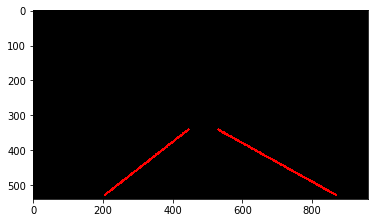

 91%|█████████ | 622/682 [05:58<00:23,  2.52it/s]

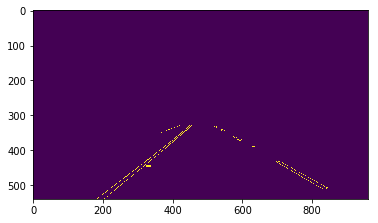

[[ 0.56      ]
 [-1.        ]
 [-1.        ]
 [ 0.5       ]
 [-0.85714286]
 [-0.765625  ]
 [-1.        ]
 [ 0.56862745]
 [ 0.5       ]
 [-0.8       ]
 [-0.88888889]
 [-0.4       ]
 [-1.        ]
 [ 0.45454545]
 [-0.94444444]
 [-0.75      ]
 [ 0.5       ]
 [ 0.6       ]
 [-0.9375    ]
 [ 0.45454545]
 [-0.7826087 ]
 [-0.94117647]
 [-0.91666667]
 [-0.38888889]
 [-0.72222222]
 [-0.71428571]
 [-0.93333333]
 [ 0.54166667]
 [-0.83333333]]
left_m = -0.777337535089  right_m = 0.59686450168
left_c = 686.03780729  right_c = 11.7004479283
left_y = 332.349228825  right_y = 427.715005599  min y = 332.349228825
left_y = 541.453025764  right_y = 506.501119821  max y = 541.453025764


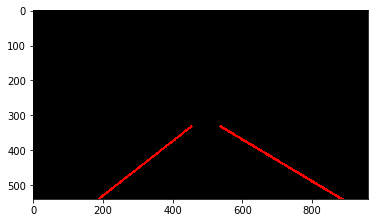

 91%|█████████▏| 623/682 [05:58<00:25,  2.28it/s]

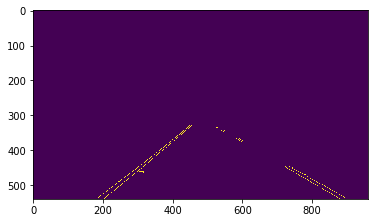

[[-0.92307692]
 [-0.84375   ]
 [-0.8       ]
 [ 0.55555556]
 [ 0.5       ]
 [-0.80645161]
 [-0.84210526]
 [ 0.6       ]
 [ 0.46666667]
 [ 0.58974359]
 [ 0.61538462]
 [-0.92857143]
 [ 0.52173913]
 [ 0.5       ]
 [-0.8       ]
 [-0.83333333]
 [-0.79166667]
 [-0.86666667]
 [ 0.59183673]
 [ 0.4375    ]
 [-0.8       ]
 [-0.76923077]
 [ 0.5       ]
 [ 0.59090909]
 [-0.85714286]
 [-0.8       ]
 [-0.9       ]]
left_m = -0.786292723397  right_m = 0.562550569437
left_c = 686.729246186  right_c = 37.5956666247
left_y = 334.470106104  right_y = 362.749895759  min y = 334.470106104
left_y = 521.607774272  right_y = 540.515875701  max y = 540.515875701


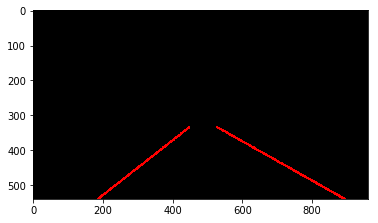

 91%|█████████▏| 624/682 [05:59<00:27,  2.14it/s]

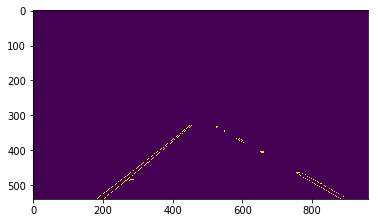

[[-0.80645161]
 [-0.90909091]
 [-0.71428571]
 [-0.92307692]
 [-0.875     ]
 [-0.78571429]
 [-1.        ]
 [-1.        ]
 [ 0.57264957]
 [-1.        ]
 [ 0.53846154]
 [ 0.54545455]
 [-0.84615385]
 [ 0.5625    ]
 [-0.93333333]
 [ 0.5       ]
 [ 0.5       ]
 [-1.        ]
 [ 0.58823529]
 [ 0.        ]
 [-1.        ]
 [-0.85      ]
 [-1.        ]
 [-1.        ]
 [ 0.5       ]
 [-1.        ]
 [ 0.58333333]]
left_m = -0.79708540894  right_m = 0.545996497267
left_c = 692.438679923  right_c = 47.3171734593
left_y = 383.966626663  right_y = 365.087134869  min y = 365.087134869
left_y = 535.412854362  right_y = 529.978077043  max y = 535.412854362


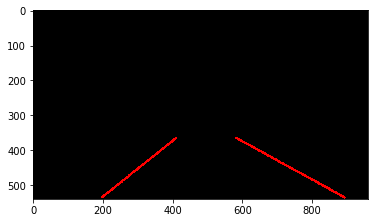

 92%|█████████▏| 625/682 [05:59<00:25,  2.20it/s]

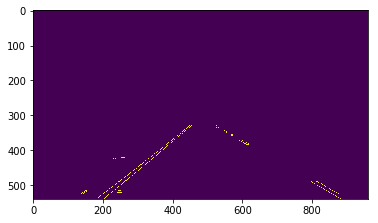

[[-0.8125    ]
 [-0.82608696]
 [-0.84313725]
 [-0.92857143]
 [-0.92857143]
 [-1.        ]
 [-0.86956522]
 [ 0.56140351]
 [ 0.52380952]
 [-0.1       ]
 [-0.78571429]
 [ 0.52941176]
 [-0.72413793]
 [-0.7       ]
 [ 0.53846154]
 [-0.63636364]
 [ 0.53571429]
 [-0.70588235]
 [ 0.5       ]
 [ 0.5       ]
 [ 0.5       ]
 [-1.        ]
 [-0.69230769]]
left_m = -0.778029333559  right_m = 0.565206994973
left_c = 683.2524018  right_c = 33.8773423232
left_y = 330.027084364  right_y = 341.915154583  min y = 330.027084364
left_y = 541.651063093  right_y = 528.998669919  max y = 541.651063093


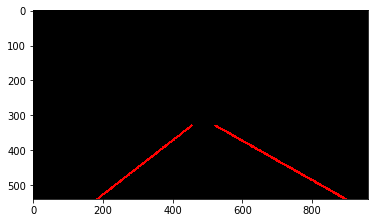

 92%|█████████▏| 626/682 [05:59<00:24,  2.28it/s]

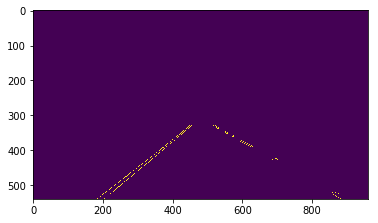

[[-0.83928571]
 [-0.9       ]
 [-0.8       ]
 [-0.90909091]
 [-0.6875    ]
 [-0.94444444]
 [ 0.55555556]
 [ 0.47826087]
 [ 0.4       ]
 [-0.77777778]
 [-0.72727273]
 [-0.76      ]
 [ 0.55      ]
 [-0.8       ]
 [-0.86363636]
 [-0.75      ]
 [-0.8       ]
 [ 0.5       ]
 [-0.69230769]]
left_m = -0.7759249378  right_m = 0.578562733007
left_c = 683.092119519  right_c = 28.3572846179
left_y = 332.374047633  right_y = 372.023548024  min y = 332.374047633
left_y = 540.321930963  right_y = 538.071052397  max y = 540.321930963


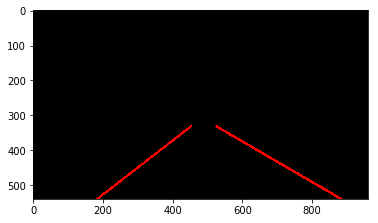

 92%|█████████▏| 627/682 [06:00<00:23,  2.31it/s]

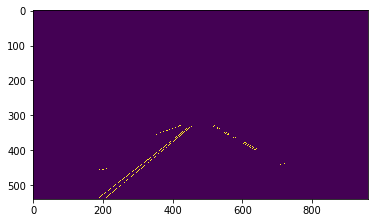

[[-0.84375   ]
 [-0.88      ]
 [-0.80952381]
 [ 0.54545455]
 [ 0.5       ]
 [-0.93333333]
 [ 0.5       ]
 [-0.85714286]
 [-0.875     ]
 [ 0.46666667]
 [ 0.36363636]
 [-0.38461538]
 [-0.91666667]
 [-0.81818182]
 [-0.88235294]
 [ 0.        ]
 [ 0.58333333]
 [-0.90909091]
 [-0.38461538]
 [-0.90909091]
 [-0.83333333]
 [ 0.58333333]]
left_m = -0.808332600861  right_m = 0.60321742464
left_c = 696.795599675  right_c = 16.1169972597
left_y = 331.429264085  right_y = 347.886580812  min y = 331.429264085
left_y = 535.937412103  right_y = 399.763279331  max y = 535.937412103


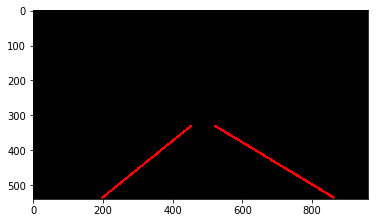

 92%|█████████▏| 628/682 [06:00<00:24,  2.21it/s]

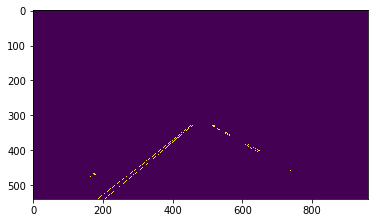

[[-1.        ]
 [ 0.625     ]
 [-0.87878788]
 [-1.        ]
 [-1.        ]
 [-0.83333333]
 [-0.75      ]
 [-0.90909091]
 [ 0.53571429]
 [-0.81818182]
 [-0.79166667]
 [-0.94444444]
 [-0.82142857]
 [-0.92307692]
 [-0.89655172]
 [-0.8       ]
 [-1.        ]
 [ 0.61538462]
 [-0.9       ]
 [-0.9375    ]
 [-0.7       ]
 [-0.76923077]
 [ 0.        ]]
left_m = -0.797909084028  right_m = 0.465330333402
left_c = 692.761530717  right_c = 100.808754346
left_y = 330.510806569  right_y = 383.729597055  min y = 330.510806569
left_y = 543.552532004  right_y = 400.016158724  max y = 543.552532004


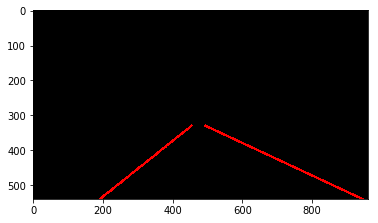

 92%|█████████▏| 629/682 [06:01<00:24,  2.17it/s]

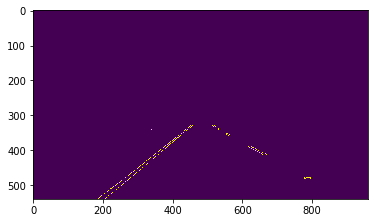

[[-0.87719298]
 [-1.        ]
 [-0.92857143]
 [-0.7962963 ]
 [ 0.58139535]
 [-0.84615385]
 [-0.71428571]
 [-0.88235294]
 [ 0.6       ]
 [-0.93333333]
 [-0.88235294]
 [ 0.54545455]
 [ 0.47619048]
 [-1.        ]
 [-1.        ]
 [-0.70588235]
 [-0.72222222]
 [ 0.5625    ]
 [-0.7       ]
 [-0.91666667]
 [-0.80952381]]
left_m = -0.784385147811  right_m = 0.568240334612
left_c = 687.084496766  right_c = 36.6823015784
left_y = 351.367653503  right_y = 353.192167957  min y = 351.367653503
left_y = 537.266933534  right_y = 416.835085434  max y = 537.266933534


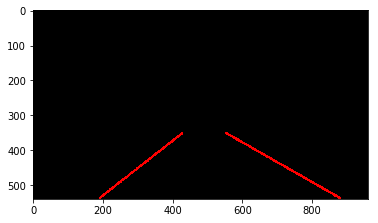

 92%|█████████▏| 630/682 [06:01<00:23,  2.22it/s]

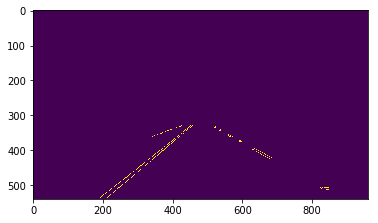

[[-0.80869565]
 [ 0.58695652]
 [-0.875     ]
 [-0.90625   ]
 [-1.        ]
 [-0.35294118]
 [-1.        ]
 [-0.72727273]
 [-0.84615385]
 [ 0.5625    ]
 [-0.94117647]
 [-0.78571429]
 [-0.82352941]
 [ 0.52727273]
 [-0.86666667]
 [-0.38461538]
 [-0.76923077]
 [-0.69230769]
 [-0.75      ]
 [-0.85714286]]
left_m = -0.812282093909  right_m = 0.515429239994
left_c = 698.465632327  right_c = 72.2338517038
left_y = 353.245742416  right_y = 394.89255594  min y = 353.245742416
left_y = 544.132034484  right_y = 426.33373958  max y = 544.132034484


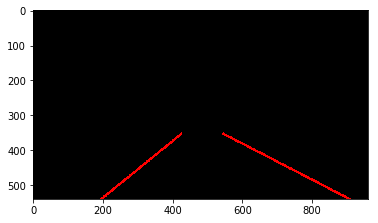

 93%|█████████▎| 631/682 [06:02<00:22,  2.27it/s]

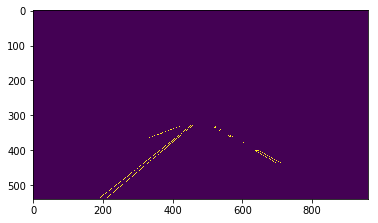

[[-0.71428571]
 [-0.84057971]
 [ 0.55172414]
 [-0.92307692]
 [-0.83333333]
 [-0.91666667]
 [-0.80769231]
 [-0.80952381]
 [-0.83333333]
 [-0.4       ]
 [ 0.5       ]
 [-0.9       ]
 [ 0.55555556]
 [-1.        ]
 [-0.35714286]
 [-0.92307692]
 [-0.41666667]
 [-0.88235294]
 [ 0.53125   ]
 [ 0.46666667]
 [ 0.        ]
 [-0.88235294]
 [-0.6875    ]
 [ 0.42857143]
 [-0.78571429]
 [-0.4       ]
 [-0.72      ]
 [-0.91666667]]
left_m = -0.815758939368  right_m = 0.538370464749
left_c = 698.998877739  right_c = 57.5686425348
left_y = 330.275837144  right_y = 358.517732329  min y = 330.275837144
left_y = 540.741643501  right_y = 435.504708788  max y = 540.741643501


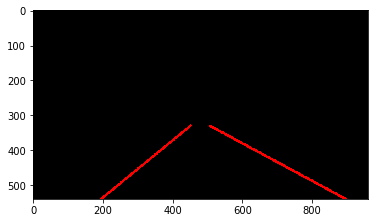

 93%|█████████▎| 632/682 [06:02<00:21,  2.38it/s]

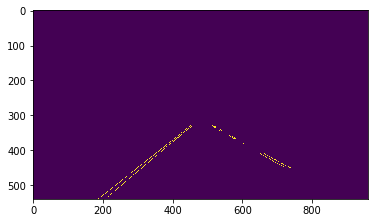

[[-0.875     ]
 [ 0.53846154]
 [-0.75      ]
 [-0.92307692]
 [-0.8       ]
 [-1.        ]
 [ 0.46153846]
 [-0.76190476]
 [ 0.45454545]
 [ 0.56756757]
 [-0.93333333]
 [-0.72727273]
 [ 0.45454545]
 [-1.        ]
 [-0.71428571]
 [-1.        ]
 [-0.76923077]
 [ 0.63636364]
 [-0.875     ]
 [-0.92      ]
 [-0.82352941]
 [-1.        ]
 [ 0.5       ]
 [ 0.6       ]
 [-0.90909091]
 [ 0.58333333]
 [ 0.5       ]]
left_m = -0.819992520376  right_m = 0.497862772163
left_c = 701.515419203  right_c = 85.9145554121
left_y = 327.598829912  right_y = 410.521082862  min y = 327.598829912
left_y = 547.356825372  right_y = 449.852241863  max y = 547.356825372


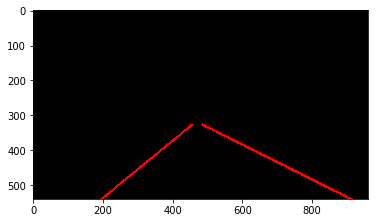

 93%|█████████▎| 633/682 [06:02<00:19,  2.45it/s]

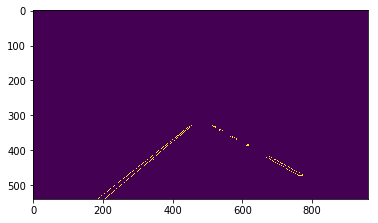

[[-0.72727273]
 [-0.77777778]
 [-0.86956522]
 [-0.75      ]
 [ 0.35714286]
 [-0.76923077]
 [-0.80952381]
 [-1.        ]
 [-1.        ]
 [ 0.58333333]
 [-0.81818182]
 [-0.81481481]
 [ 0.52941176]
 [-0.8       ]
 [-0.76470588]
 [ 0.53846154]
 [-1.        ]
 [-0.8       ]
 [ 0.5       ]
 [-1.        ]
 [-1.        ]
 [ 0.55555556]
 [-0.92307692]
 [-1.        ]
 [-0.85185185]
 [ 0.58333333]
 [-0.76923077]
 [ 0.54545455]]
left_m = -0.825286175521  right_m = 0.571341991342
left_c = 701.216245964  right_c = 34.701038961
left_y = 333.138611682  right_y = 360.365974026  min y = 333.138611682
left_y = 533.683152333  right_y = 466.064242424  max y = 533.683152333


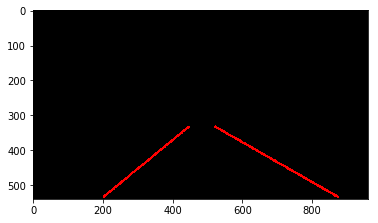

 93%|█████████▎| 634/682 [06:03<00:19,  2.50it/s]

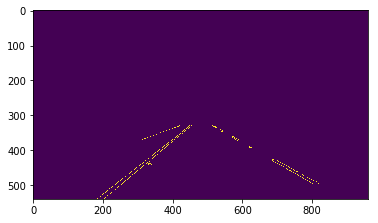

[[-0.8358209 ]
 [-0.78151261]
 [ 0.5       ]
 [ 0.52173913]
 [ 0.6       ]
 [-0.81944444]
 [ 0.46666667]
 [-0.76923077]
 [ 0.56097561]
 [ 0.58333333]
 [-0.36363636]
 [-0.83333333]
 [ 0.5       ]
 [-0.77777778]
 [-0.76923077]
 [ 0.46153846]
 [-0.78571429]
 [ 0.45454545]
 [-0.8125    ]
 [ 0.66666667]
 [-0.75      ]
 [ 0.58333333]
 [ 0.5       ]
 [-0.4       ]
 [ 0.5       ]
 [ 0.5       ]
 [ 0.53333333]
 [-0.4       ]
 [ 0.54545455]
 [-0.81818182]]
left_m = -0.830406920898  right_m = 0.558950257775
left_c = 705.840823175  right_c = 43.0050897688
left_y = 332.988115692  right_y = 363.283587474  min y = 332.988115692
left_y = 553.04594973  right_y = 493.518997535  max y = 553.04594973


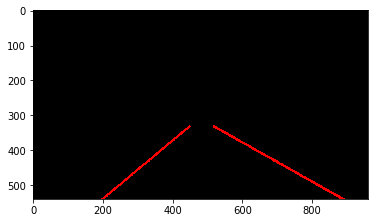

 93%|█████████▎| 635/682 [06:03<00:19,  2.40it/s]

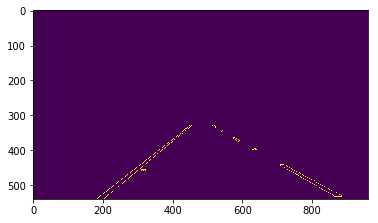

[[-0.9047619 ]
 [-0.73913043]
 [-0.91304348]
 [ 0.58139535]
 [-0.71428571]
 [ 0.4       ]
 [-0.75      ]
 [-0.91666667]
 [-0.7       ]
 [-0.92857143]
 [-1.        ]
 [-0.84210526]
 [-1.        ]
 [ 0.58823529]
 [-1.        ]
 [ 0.5862069 ]
 [-1.        ]
 [-1.        ]
 [ 0.51428571]
 [ 0.5       ]
 [ 0.58823529]
 [ 0.5       ]
 [ 0.56666667]
 [-0.76470588]
 [-0.8       ]
 [-1.        ]
 [ 0.57142857]
 [-1.        ]
 [-0.9       ]
 [ 0.5       ]
 [ 0.3       ]
 [ 0.54545455]]
left_m = -0.77000723204  right_m = 0.55019660695
left_c = 678.822961401  right_c = 49.0506502111
left_y = 328.469670823  right_y = 364.313305994  min y = 328.469670823
left_y = 533.291594545  right_y = 524.420518616  max y = 533.291594545


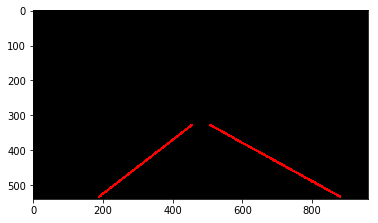

 93%|█████████▎| 636/682 [06:04<00:19,  2.41it/s]

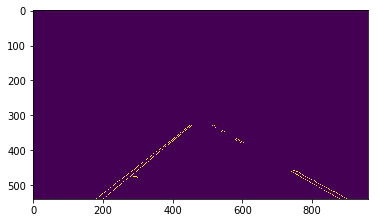

[[ 0.52631579]
 [-0.70588235]
 [-0.84210526]
 [-1.        ]
 [-0.71428571]
 [-0.72727273]
 [-0.74285714]
 [-0.83870968]
 [ 0.55789474]
 [ 0.56521739]
 [-0.90909091]
 [-0.80555556]
 [-0.72727273]
 [ 0.57142857]
 [ 0.53846154]
 [-0.91666667]
 [ 0.55172414]
 [-0.82352941]
 [-1.        ]
 [-0.93333333]
 [-1.        ]
 [ 0.45454545]
 [-0.76923077]
 [ 0.5625    ]
 [ 0.52941176]
 [-0.90909091]
 [-0.76923077]
 [ 0.5       ]
 [-0.69230769]
 [-0.9       ]
 [ 0.57894737]
 [ 0.36363636]
 [-0.90909091]
 [ 0.6       ]
 [-0.66666667]]
left_m = -0.778029119467  right_m = 0.548532737502
left_c = 682.899990156  right_c = 50.2036684857
left_y = 337.455061113  right_y = 368.352656237  min y = 337.455061113
left_y = 531.18431186  right_y = 542.786066763  max y = 542.786066763


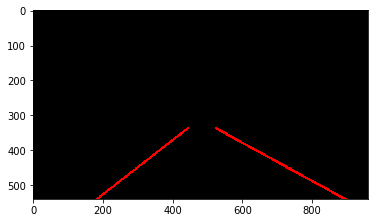

 93%|█████████▎| 637/682 [06:04<00:17,  2.51it/s]

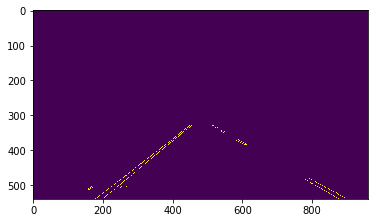

[[-0.70588235]
 [-0.84375   ]
 [-0.8172043 ]
 [ 0.57142857]
 [-0.71428571]
 [-0.92307692]
 [-0.57142857]
 [ 0.48484848]
 [-0.81081081]
 [-0.80882353]
 [ 0.3       ]
 [-0.81818182]
 [ 0.57142857]
 [-0.81081081]
 [-0.93333333]
 [ 0.52380952]
 [ 0.47058824]
 [-1.        ]
 [ 0.5       ]
 [ 0.55555556]
 [-0.86666667]
 [-0.85714286]
 [ 0.52631579]
 [-0.71428571]
 [ 0.5       ]
 [ 0.5       ]
 [-0.84615385]
 [-0.875     ]]
left_m = -0.721358153723  right_m = 0.566866137222
left_c = 660.488724491  right_c = 37.6817397893
left_y = 333.713480854  right_y = 371.565894613  min y = 333.713480854
left_y = 546.514136203  right_y = 541.62573578  max y = 546.514136203


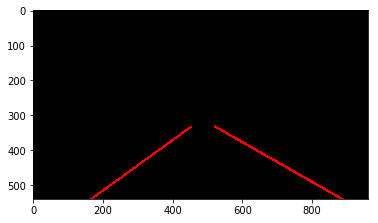

 94%|█████████▎| 638/682 [06:04<00:17,  2.56it/s]

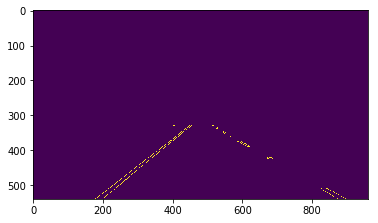

[[-0.78181818]
 [-0.80487805]
 [-0.75      ]
 [-0.7       ]
 [-0.78125   ]
 [-0.875     ]
 [-0.81052632]
 [-0.66666667]
 [ 0.575     ]
 [-0.81818182]
 [ 0.5       ]
 [ 0.5       ]
 [ 0.63636364]
 [-0.84615385]
 [-0.80769231]
 [ 0.57142857]
 [-0.18181818]
 [ 0.5625    ]
 [-1.        ]
 [-0.78571429]
 [ 0.5       ]
 [-0.75      ]
 [ 0.54545455]
 [ 0.53333333]
 [-0.6       ]]
left_m = -0.781188760133  right_m = 0.554203994179
left_c = 683.52936759  right_c = 46.255052555
left_y = 340.587501892  right_y = 377.669041074  min y = 340.587501892
left_y = 537.447069446  right_y = 542.267627345  max y = 542.267627345


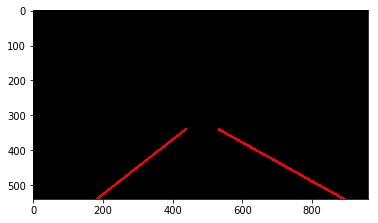

 94%|█████████▎| 639/682 [06:05<00:16,  2.58it/s]

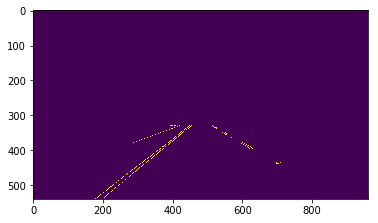

[[-0.76190476]
 [-0.75      ]
 [-0.83333333]
 [-0.81538462]
 [-1.        ]
 [-0.70588235]
 [-0.76923077]
 [-0.75      ]
 [ 0.56      ]
 [ 0.5       ]
 [-0.36842105]
 [-1.        ]
 [-0.76190476]
 [-0.72413793]
 [-0.35294118]
 [-0.76190476]
 [-0.34782609]
 [-0.08333333]
 [-0.41666667]
 [ 0.5       ]]
left_m = -0.788401339701  right_m = 0.436050751057
left_c = 685.144307661  right_c = 119.166982645
left_y = 331.940507475  right_y = 377.745078022  min y = 331.940507475
left_y = 544.020467855  right_y = 393.878955812  max y = 544.020467855


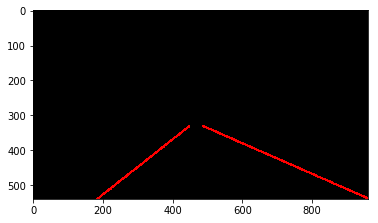

 94%|█████████▍| 640/682 [06:05<00:16,  2.49it/s]

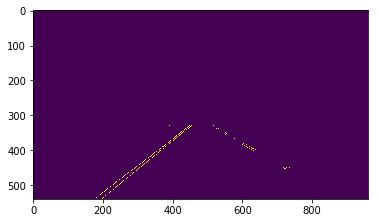

[[-0.83333333]
 [-0.81343284]
 [-0.73684211]
 [-0.76923077]
 [-0.77777778]
 [-0.80952381]
 [ 0.54545455]
 [-0.6       ]
 [-0.83333333]
 [ 0.51851852]
 [-1.        ]
 [ 0.5       ]
 [-1.        ]
 [-0.8125    ]
 [-1.        ]
 [ 0.45454545]
 [ 0.4       ]]
left_m = -0.760113180473  right_m = 0.574856046065
left_c = 674.127307372  right_c = 35.0284708893
left_y = 329.035923437  right_y = 349.474728087  min y = 329.035923437
left_y = 539.587274428  right_y = 404.086052463  max y = 539.587274428


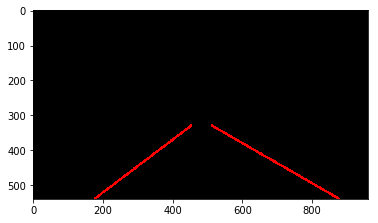

 94%|█████████▍| 641/682 [06:06<00:16,  2.49it/s]

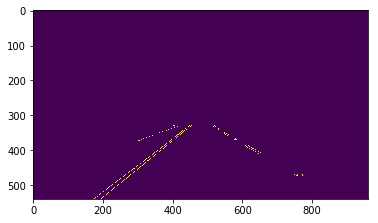

[[-0.92307692]
 [-0.75490196]
 [-0.76470588]
 [ 0.1       ]
 [-0.92307692]
 [-0.9       ]
 [-0.35897436]
 [-0.79591837]
 [-0.84615385]
 [-0.37142857]
 [-0.78947368]
 [-0.72727273]
 [ 0.58333333]
 [-0.9       ]
 [-0.44444444]
 [-0.76190476]
 [ 0.        ]
 [-0.92307692]
 [ 0.58333333]
 [-0.91666667]
 [ 0.56521739]
 [ 0.57142857]
 [-0.83333333]]
left_m = -0.789675080213  right_m = 0.478191148172
left_c = 687.080920941  right_c = 96.8976908275
left_y = 338.834210567  right_y = 395.767158435  min y = 338.834210567
left_y = 548.887781904  right_y = 410.591084028  max y = 548.887781904


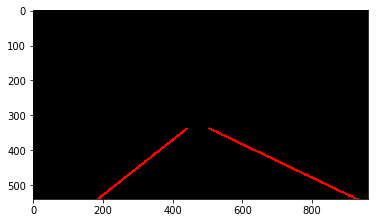

 94%|█████████▍| 642/682 [06:06<00:15,  2.53it/s]

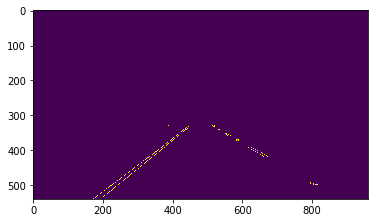

[[-0.81105991]
 [-0.78333333]
 [ 0.62962963]
 [-0.9       ]
 [ 0.51282051]
 [-0.81481481]
 [ 0.46666667]
 [-0.84210526]
 [-0.875     ]
 [ 0.6       ]
 [ 0.6       ]
 [-0.82608696]
 [-0.86666667]
 [-0.81818182]
 [-0.90909091]
 [ 0.63636364]
 [-0.75      ]]
left_m = -0.7633945941  right_m = 0.576271023361
left_c = 673.153653903  right_c = 34.6051841589
left_y = 332.679664935  right_y = 351.554247008  min y = 332.679664935
left_y = 536.50602156  right_y = 418.977956741  max y = 536.50602156


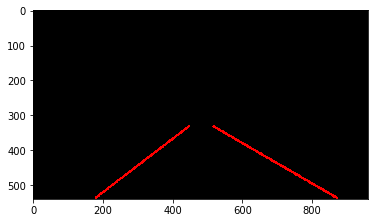

 94%|█████████▍| 643/682 [06:06<00:15,  2.58it/s]

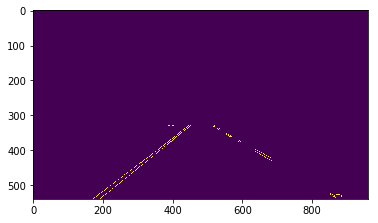

[[-0.84090909]
 [-0.75      ]
 [-0.82352941]
 [-0.75      ]
 [-0.90909091]
 [-0.85185185]
 [-0.79310345]
 [-0.91666667]
 [-0.9       ]
 [ 0.53846154]
 [-0.9       ]
 [ 0.54545455]
 [ 0.55555556]
 [ 0.52380952]
 [-0.8       ]
 [-0.69565217]
 [-0.8       ]
 [-0.76470588]
 [-0.72727273]
 [-0.9       ]
 [ 0.53846154]
 [-0.63636364]
 [ 0.5       ]
 [ 0.57142857]
 [-0.6       ]
 [ 0.09090909]]
left_m = -0.768876247038  right_m = 0.58836809804
left_c = 676.490560854  right_c = 26.1815320679
left_y = 328.958497193  right_y = 352.72582648  min y = 328.958497193
left_y = 537.323960141  right_y = 532.766464481  max y = 537.323960141


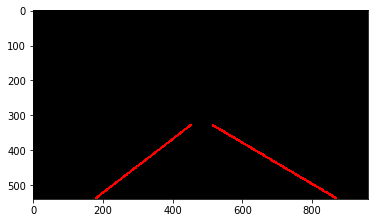

 94%|█████████▍| 644/682 [06:07<00:14,  2.55it/s]

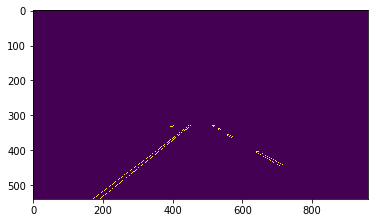

[[-0.71428571]
 [-0.84615385]
 [-0.9       ]
 [-0.92307692]
 [-0.78571429]
 [-0.80645161]
 [ 0.52173913]
 [-0.85      ]
 [-0.76      ]
 [ 0.57446809]
 [ 0.56666667]
 [-0.6       ]
 [-0.77272727]
 [ 0.47619048]
 [ 0.5       ]
 [-0.78125   ]
 [ 0.5       ]
 [-0.72727273]
 [-0.90909091]
 [ 0.5       ]
 [-0.8125    ]
 [-0.9       ]
 [-0.66666667]
 [-0.75      ]
 [-0.7       ]]
left_m = -0.770340278785  right_m = 0.534299703685
left_c = 676.281032443  right_c = 61.2391691108
left_y = 328.857566711  right_y = 358.844104064  min y = 328.857566711
left_y = 540.701143377  right_y = 441.660558135  max y = 540.701143377


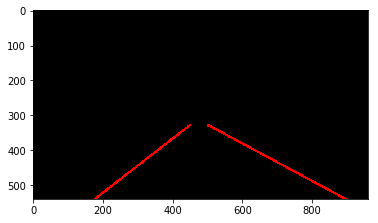

 95%|█████████▍| 645/682 [06:07<00:14,  2.60it/s]

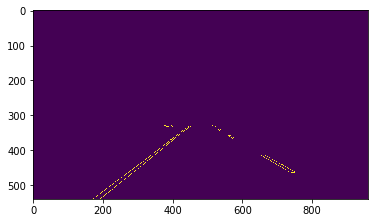

[[-0.75661376]
 [-0.9375    ]
 [-0.84210526]
 [-0.8       ]
 [-0.91666667]
 [-0.90909091]
 [-0.83333333]
 [-0.88235294]
 [ 0.51515152]
 [ 0.55555556]
 [-0.70588235]
 [-0.8       ]
 [-0.76190476]
 [-0.76470588]
 [-0.72727273]
 [-0.86666667]
 [ 0.4       ]
 [ 0.5       ]
 [ 0.11764706]
 [ 0.5       ]
 [ 0.5       ]
 [ 0.57142857]]
left_m = -0.788855785378  right_m = 0.539990453694
left_c = 685.451724231  right_c = 60.1717723084
left_y = 339.932890235  right_y = 419.265424015  min y = 339.932890235
left_y = 548.97967336  right_y = 459.224717588  max y = 548.97967336


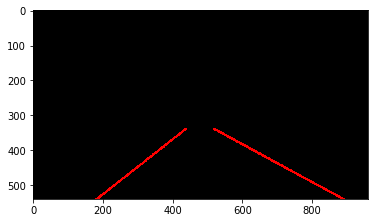

 95%|█████████▍| 646/682 [06:08<00:14,  2.45it/s]

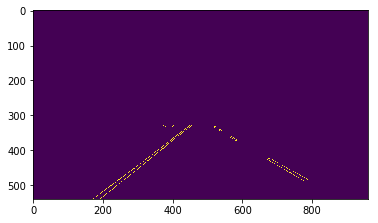

[[-0.82352941]
 [-0.69230769]
 [-0.78217822]
 [ 0.5625    ]
 [-0.84444444]
 [-0.79166667]
 [ 0.5862069 ]
 [ 0.55319149]
 [ 0.52941176]
 [-0.8125    ]
 [ 0.5625    ]
 [-0.76470588]
 [-0.76923077]
 [-0.75      ]
 [ 0.5       ]
 [-0.83333333]
 [-0.61538462]
 [-0.66666667]
 [-0.66666667]
 [ 0.63157895]
 [-0.7826087 ]
 [-0.7       ]
 [-0.77777778]
 [-0.66666667]
 [ 0.55555556]
 [-0.72727273]
 [ 0.        ]
 [-0.85714286]]
left_m = -0.75213347531  right_m = 0.577795827707
left_c = 672.583398907  right_c = 34.9556033609
left_y = 331.866934592  right_y = 361.988041843  min y = 331.866934592
left_y = 542.464307679  right_y = 486.791940627  max y = 542.464307679


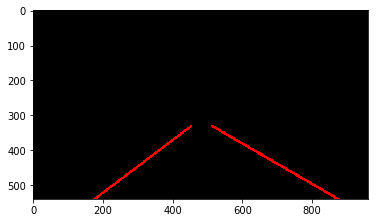

 95%|█████████▍| 647/682 [06:08<00:13,  2.51it/s]

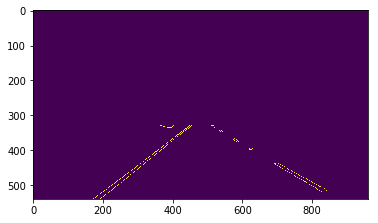

[[-0.84615385]
 [ 0.58024691]
 [-0.79166667]
 [-0.77777778]
 [-0.76119403]
 [-0.76785714]
 [-0.72727273]
 [-0.84615385]
 [-0.76      ]
 [ 0.53846154]
 [-0.66666667]
 [-0.63636364]
 [ 0.55555556]
 [ 0.47826087]
 [-0.84615385]
 [ 0.55555556]
 [-0.84210526]
 [-0.90909091]
 [ 0.54545455]
 [-0.8       ]
 [ 0.55555556]
 [ 0.59259259]
 [ 0.5       ]
 [-0.75      ]
 [ 0.53846154]
 [ 0.5625    ]
 [-0.83333333]
 [-0.78571429]
 [ 0.52173913]
 [ 0.5       ]
 [ 0.52941176]
 [-0.90909091]]
left_m = -0.774849160479  right_m = 0.572446051313
left_c = 679.785289647  right_c = 38.8276893394
left_y = 329.553469111  right_y = 362.832154382  min y = 329.553469111
left_y = 545.736384884  right_y = 517.392588237  max y = 545.736384884


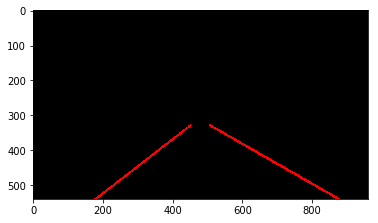

 95%|█████████▌| 648/682 [06:08<00:13,  2.56it/s]

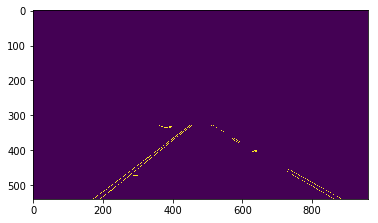

[[-0.76666667]
 [-0.70588235]
 [ 0.55555556]
 [-0.91666667]
 [ 0.56666667]
 [-0.85714286]
 [-0.875     ]
 [ 0.61538462]
 [-0.80769231]
 [ 0.        ]
 [-0.79166667]
 [-0.76923077]
 [-0.76923077]
 [-0.8       ]
 [-0.66666667]
 [-0.92857143]
 [-0.66666667]
 [ 0.61764706]
 [-0.9       ]
 [ 0.45454545]
 [ 0.64705882]
 [-0.8125    ]
 [ 0.5625    ]
 [ 0.53333333]
 [-0.69230769]
 [ 0.66666667]
 [-0.64285714]
 [ 0.41176471]
 [ 0.54545455]
 [-0.8       ]
 [ 0.        ]
 [-0.6       ]]
left_m = -0.761105244632  right_m = 0.574419518876
left_c = 673.731929519  right_c = 37.4724437907
left_y = 339.606727126  right_y = 365.465989069  min y = 339.606727126
left_y = 542.060722198  right_y = 540.089522807  max y = 542.060722198


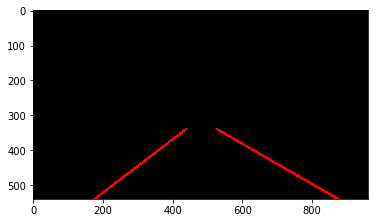

 95%|█████████▌| 649/682 [06:09<00:12,  2.56it/s]

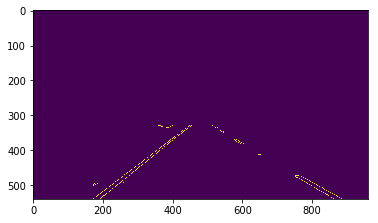

[[-0.80769231]
 [-0.86956522]
 [-0.75555556]
 [ 0.55045872]
 [-0.78571429]
 [-0.72727273]
 [-0.77777778]
 [-0.79069767]
 [-0.76923077]
 [-0.72727273]
 [ 0.57575758]
 [-0.76470588]
 [ 0.62162162]
 [ 0.5       ]
 [-0.76923077]
 [-0.78947368]
 [ 0.54545455]
 [ 0.61538462]
 [-0.7       ]
 [ 0.5       ]
 [-0.9       ]]
left_m = -0.7604323697  right_m = 0.575686992857
left_c = 674.871810162  right_c = 37.2572120821
left_y = 334.958540907  right_y = 372.882728918  min y = 334.958540907
left_y = 528.10836281  right_y = 540.983330832  max y = 540.983330832


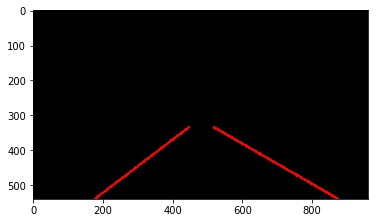

 95%|█████████▌| 650/682 [06:09<00:12,  2.58it/s]

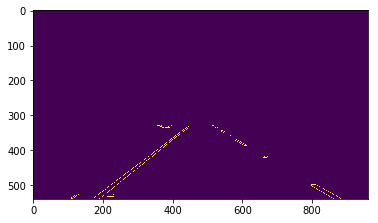

[[-0.9       ]
 [ 0.57142857]
 [-0.7826087 ]
 [-0.79012346]
 [-0.79032258]
 [-0.78947368]
 [ 0.58333333]
 [-0.7       ]
 [-0.76470588]
 [-0.80769231]
 [-0.9       ]
 [-0.77777778]
 [ 0.        ]
 [-0.66666667]
 [ 0.6       ]
 [-0.58333333]
 [-0.70588235]
 [-0.84615385]
 [-0.69230769]
 [ 0.53571429]
 [-0.85714286]
 [-0.86666667]
 [ 0.        ]
 [-1.        ]
 [ 0.5625    ]
 [-0.8       ]]
left_m = -0.717783540464  right_m = 0.592736324081
left_c = 657.770951468  right_c = 23.9299858246
left_y = 333.332791179  right_y = 369.495262764  min y = 333.332791179
left_y = 573.072493694  right_y = 546.723423664  max y = 573.072493694


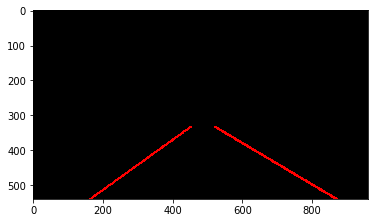

 95%|█████████▌| 651/682 [06:10<00:12,  2.49it/s]

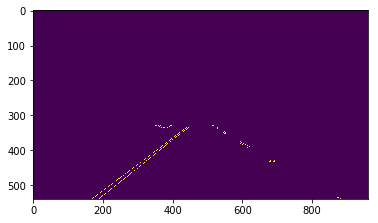

[[-0.85714286]
 [-0.86666667]
 [-0.81060606]
 [-0.92307692]
 [-0.85      ]
 [-0.85714286]
 [-0.6       ]
 [-0.82608696]
 [-0.8       ]
 [-0.81818182]
 [-0.83333333]
 [ 0.15384615]
 [-0.80645161]
 [-0.8       ]
 [ 0.61538462]
 [ 0.5862069 ]
 [-0.69230769]
 [-0.9       ]
 [-0.81818182]
 [ 0.6       ]
 [-0.76923077]
 [-0.9       ]]
left_m = -0.760319128517  right_m = 0.511693481506
left_c = 670.976163683  right_c = 74.1656991209
left_y = 333.394470622  right_y = 374.018079283  min y = 333.394470622
left_y = 541.721911836  right_y = 391.415657655  max y = 541.721911836


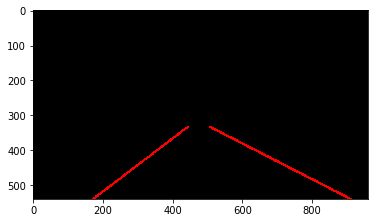

 96%|█████████▌| 652/682 [06:10<00:12,  2.49it/s]

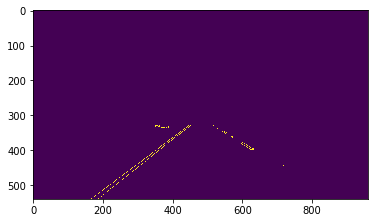

[[-0.66666667]
 [-0.79166667]
 [-0.82051282]
 [-0.73913043]
 [-0.79310345]
 [-0.8125    ]
 [-0.7826087 ]
 [-0.83333333]
 [ 0.55555556]
 [-0.66666667]
 [-0.66666667]
 [-0.66666667]
 [-0.9       ]
 [-0.78787879]
 [-0.82352941]
 [-0.76470588]
 [-0.9       ]
 [ 0.55      ]
 [-0.90909091]
 [-0.69230769]
 [-0.7       ]
 [ 0.57142857]
 [-0.8       ]
 [-0.90909091]
 [ 0.6       ]
 [ 0.        ]]
left_m = -0.769428705794  right_m = 0.451983298539
left_c = 673.793261841  right_c = 111.852296451
left_y = 326.780915528  right_y = 382.590292276  min y = 326.780915528
left_y = 545.298667974  right_y = 397.505741127  max y = 545.298667974


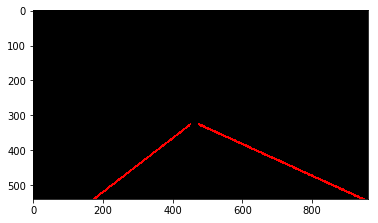

 96%|█████████▌| 653/682 [06:10<00:11,  2.55it/s]

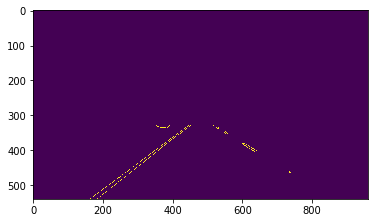

[[-0.75268817]
 [-0.752     ]
 [-0.80952381]
 [-0.91666667]
 [ 0.53846154]
 [-0.81481481]
 [-0.76923077]
 [-0.75      ]
 [-0.78125   ]
 [-0.82142857]
 [ 0.5       ]
 [ 0.61904762]
 [-0.8       ]
 [-0.78947368]
 [-0.72727273]
 [-0.92307692]]
left_m = -0.745000509563  right_m = 0.486828240253
left_c = 665.564927102  right_c = 89.0590094837
left_y = 331.059698308  right_y = 381.642781876  min y = 331.059698308
left_y = 540.404841495  right_y = 396.247629083  max y = 540.404841495


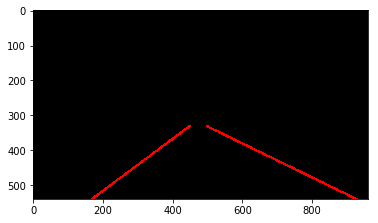

 96%|█████████▌| 654/682 [06:11<00:10,  2.59it/s]

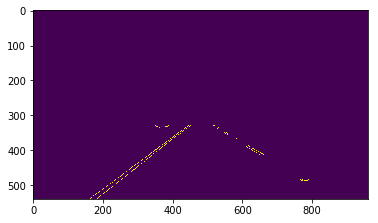

[[-0.69565217]
 [-0.6       ]
 [-0.77777778]
 [-0.77876106]
 [ 0.4       ]
 [-0.66666667]
 [ 0.55172414]
 [-0.6875    ]
 [-0.68965517]
 [-0.7826087 ]
 [ 0.53125   ]
 [-0.6       ]
 [ 0.1       ]
 [-0.6       ]
 [-0.6875    ]
 [-0.76      ]
 [-0.71428571]
 [-0.69230769]
 [-0.75      ]
 [-0.66666667]
 [-0.66666667]
 [ 0.5       ]
 [ 0.1       ]
 [-0.58333333]]
left_m = -0.7436013727  right_m = 0.502058742794
left_c = 662.37563054  right_c = 81.4375514686
left_y = 327.011411452  right_y = 389.199560802  min y = 327.011411452
left_y = 529.270984827  right_y = 412.796321713  max y = 529.270984827


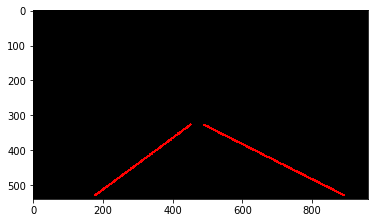

 96%|█████████▌| 655/682 [06:11<00:10,  2.62it/s]

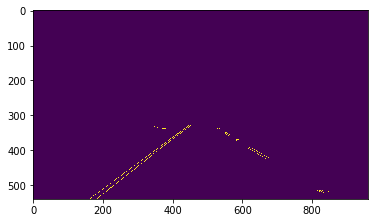

[[-0.8125    ]
 [-0.7804878 ]
 [-0.75438596]
 [-0.63636364]
 [-0.05882353]
 [-0.75757576]
 [-0.66666667]
 [ 0.6       ]
 [ 0.6       ]
 [-0.63636364]
 [-0.78571429]
 [ 0.63636364]
 [-0.63636364]
 [ 0.56      ]
 [-0.8125    ]
 [-0.71428571]
 [-0.80952381]
 [ 0.5       ]
 [ 0.        ]
 [ 0.53333333]]
left_m = -0.772259748105  right_m = 0.605372408531
left_c = 672.270746942  right_c = 16.0769821049
left_y = 323.981600547  right_y = 350.847924022  min y = 323.981600547
left_y = 546.392408001  right_y = 427.124847497  max y = 546.392408001


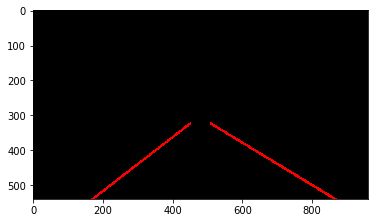

 96%|█████████▌| 656/682 [06:11<00:09,  2.66it/s]

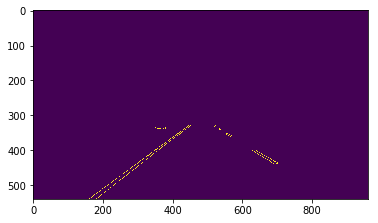

[[-0.85      ]
 [-0.78947368]
 [-0.875     ]
 [-0.85714286]
 [-0.7       ]
 [-0.8125    ]
 [-0.75342466]
 [-0.75362319]
 [-0.7826087 ]
 [ 0.54545455]
 [ 0.5       ]
 [-0.80952381]
 [ 0.61111111]
 [-0.90909091]
 [-0.88235294]
 [-0.91666667]
 [ 0.53846154]
 [-0.84615385]
 [-0.84615385]
 [ 0.64285714]
 [-0.75      ]
 [ 0.6       ]
 [ 0.54545455]
 [-0.66666667]
 [ 0.        ]
 [-0.8       ]
 [ 0.63636364]
 [-0.8       ]]
left_m = -0.764199552968  right_m = 0.605127465959
left_c = 671.226250187  right_c = 15.8841246505
left_y = 328.864850457  right_y = 352.334995724  min y = 328.864850457
left_y = 539.783927076  right_y = 432.211821231  max y = 539.783927076


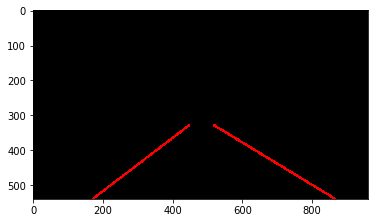

 96%|█████████▋| 657/682 [06:12<00:09,  2.53it/s]

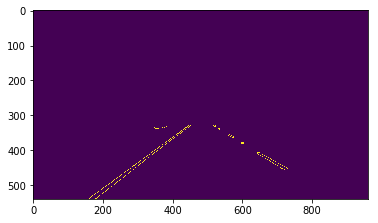

[[-0.64285714]
 [-0.78365385]
 [ 0.58333333]
 [ 0.4       ]
 [ 0.60606061]
 [-0.71153846]
 [-0.77777778]
 [-0.73076923]
 [-0.77777778]
 [-0.64285714]
 [-0.68421053]
 [-0.66666667]
 [ 0.03846154]
 [-0.8       ]
 [ 0.56521739]
 [-0.78571429]
 [-0.81818182]
 [-0.70588235]
 [-0.81818182]]
left_m = -0.730188629959  right_m = 0.516888944285
left_c = 656.890820248  right_c = 76.337072583
left_y = 327.575748136  right_y = 408.179774814  min y = 327.575748136
left_y = 540.060639455  right_y = 448.497112468  max y = 540.060639455


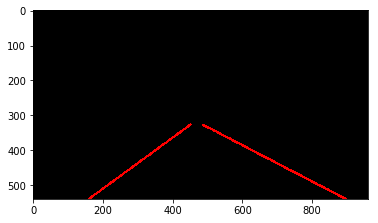

 96%|█████████▋| 658/682 [06:12<00:09,  2.59it/s]

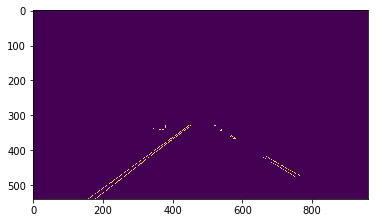

[[ 0.76923077]
 [-0.90909091]
 [-0.69444444]
 [-0.81481481]
 [-0.7       ]
 [-0.73493976]
 [-0.66666667]
 [-0.75      ]
 [ 0.57446809]
 [-0.68421053]
 [-0.68181818]
 [-0.81818182]
 [ 0.58823529]
 [-0.6       ]
 [-0.75      ]
 [-0.78947368]
 [-0.72727273]
 [-0.7       ]
 [ 0.6025641 ]
 [-0.8       ]
 [-0.76923077]
 [ 0.6       ]
 [-0.76923077]
 [-0.84615385]
 [ 0.09090909]
 [ 0.6       ]]
left_m = -0.741929975412  right_m = 0.609211614364
left_c = 661.831639941  right_c = 15.672312375
left_y = 327.963151006  right_y = 356.830816419  min y = 327.963151006
left_y = 539.413193998  right_y = 478.673139291  max y = 539.413193998


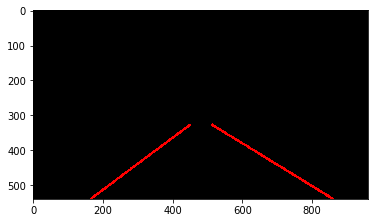

 97%|█████████▋| 659/682 [06:13<00:09,  2.51it/s]

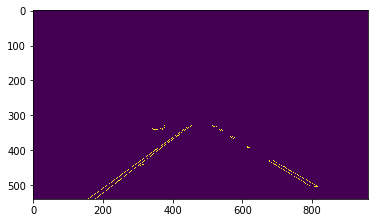

[[-0.80555556]
 [-0.8125    ]
 [-0.728     ]
 [ 0.5625    ]
 [ 0.45454545]
 [ 0.55882353]
 [ 0.61904762]
 [-0.84615385]
 [-0.9       ]
 [ 0.61538462]
 [-0.81818182]
 [-0.8       ]
 [ 0.54545455]
 [ 0.66666667]
 [-0.75757576]
 [-0.75      ]
 [-0.69565217]
 [-0.14285714]
 [-0.73076923]
 [ 0.56      ]
 [-0.6       ]
 [ 0.55      ]
 [ 0.        ]
 [ 0.46153846]
 [ 0.6       ]
 [ 0.66666667]]
left_m = -0.752100782492  right_m = 0.588901584331
left_c = 667.536044503  right_c = 29.9934053675
left_y = 327.586490817  right_y = 428.67977796  min y = 327.586490817
left_y = 547.952020087  right_y = 501.114672832  max y = 547.952020087


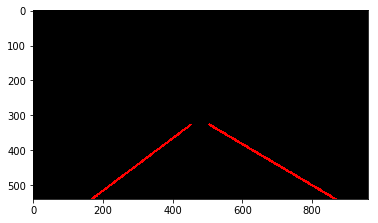

 97%|█████████▋| 660/682 [06:13<00:08,  2.53it/s]

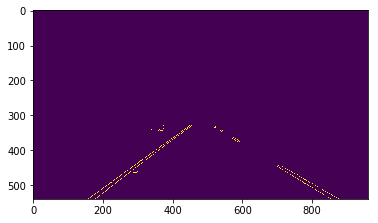

[[-0.7816092 ]
 [-0.72839506]
 [-0.77777778]
 [ 0.55555556]
 [ 0.60526316]
 [ 0.57142857]
 [-0.75609756]
 [-0.75      ]
 [ 0.55555556]
 [ 0.56666667]
 [ 0.6       ]
 [-0.8       ]
 [-0.7826087 ]
 [-0.9       ]
 [ 0.58333333]
 [ 0.58333333]
 [-0.61538462]
 [-0.78571429]
 [ 0.63157895]
 [-0.71428571]
 [-0.7       ]
 [ 0.54545455]
 [-0.7       ]
 [-0.8125    ]
 [ 0.54545455]
 [-0.8       ]
 [ 0.54545455]]
left_m = -0.727951490165  right_m = 0.594201786688
left_c = 659.187842336  right_c = 25.8903138639
left_y = 328.697865801  right_y = 365.77373585  min y = 328.697865801
left_y = 528.156574106  right_y = 539.874859349  max y = 539.874859349


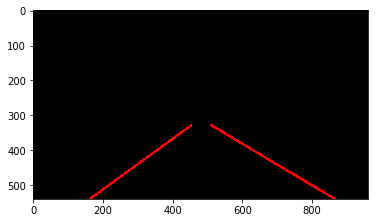

 97%|█████████▋| 661/682 [06:13<00:08,  2.56it/s]

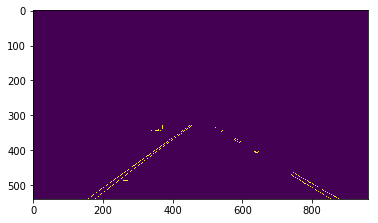

[[-0.69230769]
 [-0.9       ]
 [-0.69444444]
 [-0.75      ]
 [-0.63636364]
 [ 0.5       ]
 [ 0.56603774]
 [ 0.61111111]
 [ 0.57142857]
 [ 0.55172414]
 [-0.6       ]
 [ 0.5       ]
 [-0.6875    ]
 [-0.8       ]
 [-0.75      ]
 [ 0.6       ]
 [ 0.54347826]
 [ 0.        ]
 [-0.90909091]
 [-0.84210526]
 [-0.9       ]
 [-0.70833333]
 [-0.74285714]
 [-0.84615385]
 [-0.86666667]
 [ 0.58333333]
 [ 0.53846154]
 [ 0.58      ]
 [-0.7826087 ]
 [ 0.        ]
 [-0.81818182]
 [-0.90909091]
 [ 0.57142857]]
left_m = -0.712200346072  right_m = 0.606195486052
left_c = 652.354949315  right_c = 17.7814906974
left_y = 328.303791852  right_y = 365.131504205  min y = 328.303791852
left_y = 539.827294635  right_y = 542.746781619  max y = 542.746781619


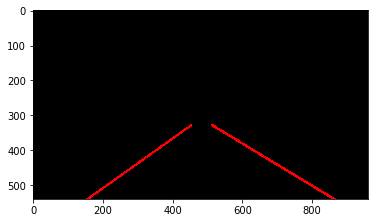

 97%|█████████▋| 662/682 [06:14<00:08,  2.46it/s]

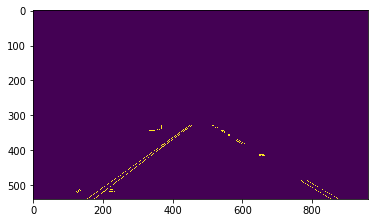

[[-0.77777778]
 [ 0.55555556]
 [ 0.57142857]
 [-0.75      ]
 [-0.8       ]
 [-0.81481481]
 [-0.9       ]
 [ 0.55      ]
 [ 0.61904762]
 [-0.69767442]
 [-0.74193548]
 [-0.7260274 ]
 [-0.78125   ]
 [ 0.        ]
 [-0.9       ]
 [-0.76      ]
 [-0.86666667]
 [-0.72727273]
 [-0.6875    ]
 [ 0.66666667]
 [-0.8       ]
 [-0.9       ]
 [-0.7       ]
 [-0.83333333]
 [-0.85714286]
 [-0.2       ]
 [ 0.4       ]
 [-0.07142857]]
left_m = -0.687293443465  right_m = 0.608227596982
left_c = 644.813098268  right_c = 16.1546769632
left_y = 337.592929039  right_y = 367.710228019  min y = 337.592929039
left_y = 560.276004722  right_y = 536.189272382  max y = 560.276004722


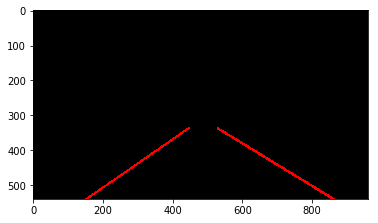

 97%|█████████▋| 663/682 [06:14<00:07,  2.51it/s]

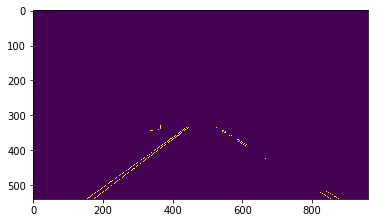

[[-0.78      ]
 [-0.63636364]
 [-0.80952381]
 [-0.72941176]
 [-0.67857143]
 [-0.73913043]
 [-0.71428571]
 [-0.69047619]
 [-0.66666667]
 [-0.68421053]
 [ 0.66666667]
 [-0.72      ]
 [-0.86666667]
 [-0.8       ]
 [-0.68      ]
 [ 0.56521739]
 [-0.84615385]
 [ 0.61538462]
 [ 0.58823529]
 [-0.9       ]
 [-0.8       ]
 [ 0.63636364]
 [-0.7       ]]
left_m = -0.724886938812  right_m = 0.589964028327
left_c = 657.014800284  right_c = 25.9641837933
left_y = 328.641017002  right_y = 370.503176336  min y = 328.641017002
left_y = 544.657324768  right_y = 542.772672608  max y = 544.657324768


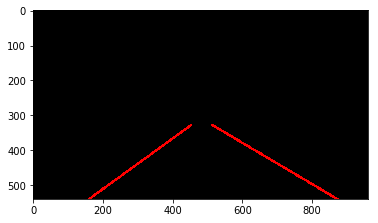

 97%|█████████▋| 664/682 [06:15<00:07,  2.56it/s]

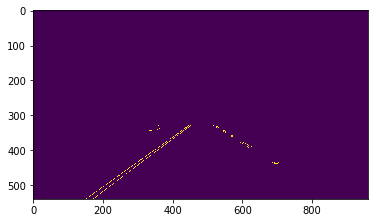

[[-0.66666667]
 [-0.71428571]
 [-0.6875    ]
 [-0.66666667]
 [-0.73684211]
 [ 0.5       ]
 [ 0.53333333]
 [-0.8       ]
 [ 0.62962963]
 [-0.72340426]
 [-0.77777778]
 [-0.66666667]
 [-0.83333333]
 [-0.8125    ]
 [-0.6875    ]
 [-0.6875    ]
 [-0.72727273]
 [-0.81818182]
 [-0.77272727]
 [-0.6       ]
 [-0.64285714]
 [ 0.61538462]
 [-0.66666667]
 [-0.69230769]
 [-0.63636364]
 [-0.9       ]
 [-0.75      ]]
left_m = -0.729555426888  right_m = 0.560907271514
left_c = 656.194057274  right_c = 42.4166777852
left_y = 327.164559748  right_y = 373.351967979  min y = 327.164559748
left_y = 528.521857569  right_y = 393.544629753  max y = 528.521857569


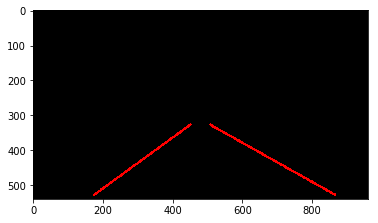

 98%|█████████▊| 665/682 [06:15<00:06,  2.59it/s]

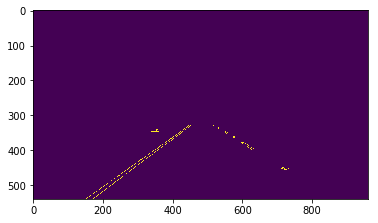

[[-0.75      ]
 [-0.63636364]
 [-0.86666667]
 [-0.68421053]
 [ 0.57142857]
 [-0.75      ]
 [-0.6875    ]
 [-0.8       ]
 [ 0.58333333]
 [-0.84210526]
 [-0.81818182]
 [ 0.6       ]
 [-0.73333333]
 [ 0.        ]
 [-0.81818182]
 [-0.65      ]
 [-0.80769231]
 [-0.76923077]
 [-0.66666667]
 [-0.65      ]
 [-0.76923077]
 [-0.63636364]
 [-0.9       ]
 [ 0.6       ]
 [-0.81818182]]
left_m = -0.720065778525  right_m = 0.656584484713
left_c = 653.594544278  right_c = -15.5252022522
left_y = 328.124812384  right_y = 344.939679855  min y = 328.124812384
left_y = 543.424480164  right_y = 399.436192087  max y = 543.424480164


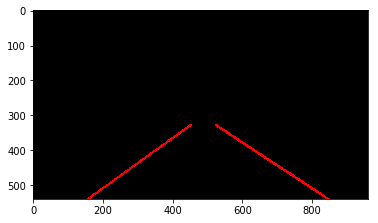

 98%|█████████▊| 666/682 [06:15<00:06,  2.55it/s]

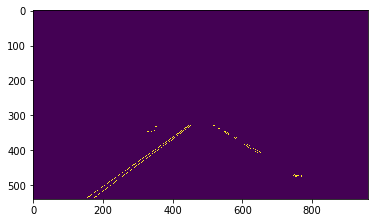

[[-0.75308642]
 [-0.76923077]
 [-0.77777778]
 [ 0.41666667]
 [-0.8125    ]
 [-0.75510204]
 [-0.82352941]
 [-0.72580645]
 [-0.81818182]
 [-0.625     ]
 [ 0.59459459]
 [-0.75      ]
 [ 0.61111111]
 [-0.84615385]
 [-0.75      ]
 [ 0.        ]
 [ 0.58823529]
 [-0.77272727]
 [-0.8       ]]
left_m = -0.720627594681  right_m = 0.571219103477
left_c = 652.613309715  right_c = 37.3688730624
left_y = 343.464071596  right_y = 384.098868873  min y = 343.464071596
left_y = 543.077915323  right_y = 406.947633012  max y = 543.077915323


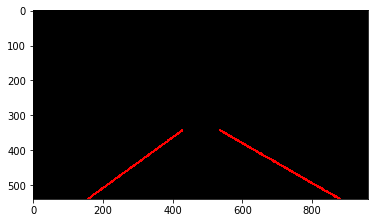

 98%|█████████▊| 667/682 [06:16<00:06,  2.49it/s]

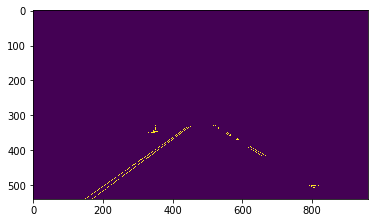

[[-0.71794872]
 [-0.78571429]
 [-0.83333333]
 [-0.6875    ]
 [-0.76086957]
 [ 0.63043478]
 [-0.69565217]
 [-0.75      ]
 [-0.6       ]
 [ 0.56756757]
 [-0.61538462]
 [-0.73333333]
 [ 0.58333333]
 [-0.6       ]
 [ 0.60606061]
 [-0.7       ]
 [-0.8       ]
 [-0.76923077]
 [-0.63636364]
 [-0.83333333]
 [-0.81818182]
 [-0.85714286]
 [-0.63636364]]
left_m = -0.715927125431  right_m = 0.542498390212
left_c = 652.532871062  right_c = 56.0910334836
left_y = 339.672717249  right_y = 389.185045074  min y = 339.672717249
left_y = 545.143802248  right_y = 415.767466194  max y = 545.143802248


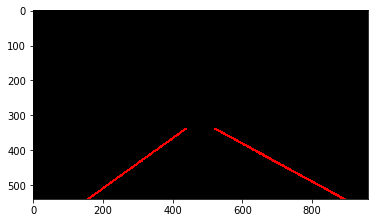

 98%|█████████▊| 668/682 [06:16<00:05,  2.38it/s]

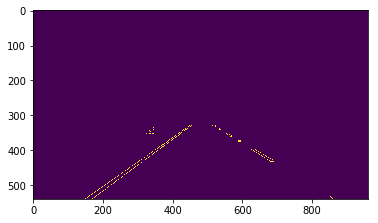

[[-0.73333333]
 [-0.6       ]
 [-0.775     ]
 [-0.80952381]
 [-0.77777778]
 [ 0.59090909]
 [-0.81818182]
 [-0.6       ]
 [-0.69230769]
 [ 0.64102564]
 [-0.75      ]
 [-0.76923077]
 [-0.8125    ]
 [-0.8125    ]
 [-0.75      ]
 [-0.68571429]
 [ 0.66666667]
 [-0.8       ]
 [ 0.53333333]
 [-0.6875    ]
 [-0.6875    ]
 [-0.1       ]
 [-0.8       ]
 [-0.78571429]
 [-0.61538462]
 [-0.68421053]
 [-0.9       ]
 [ 0.6       ]]
left_m = -0.703751852221  right_m = 0.570914552448
left_c = 648.554169893  right_c = 38.4997838959
left_y = 336.088347507  right_y = 355.928275057  min y = 336.088347507
left_y = 542.99139206  right_y = 432.430825085  max y = 542.99139206


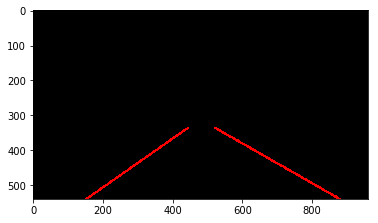

 98%|█████████▊| 669/682 [06:17<00:05,  2.42it/s]

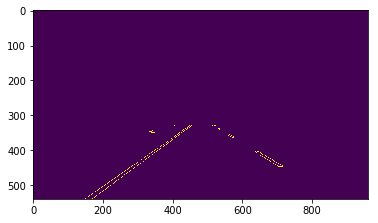

[[-0.734375  ]
 [-0.69811321]
 [-0.72413793]
 [-0.73404255]
 [-0.6       ]
 [-0.67647059]
 [ 0.61538462]
 [-0.75324675]
 [ 0.63636364]
 [-0.76923077]
 [ 0.60714286]
 [-0.58333333]
 [-0.83333333]
 [-0.66666667]
 [-0.64285714]
 [ 0.625     ]
 [-0.69230769]
 [-0.81818182]
 [ 0.5       ]
 [-0.7       ]
 [ 0.625     ]
 [-0.7       ]]
left_m = -0.706307132489  right_m = 0.613672133639
left_c = 648.546644432  right_c = 10.2285093004
left_y = 331.414741944  right_y = 353.884904138  min y = 331.414741944
left_y = 541.187960294  right_y = 442.867363516  max y = 541.187960294


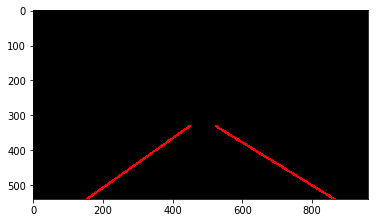

 98%|█████████▊| 670/682 [06:17<00:04,  2.51it/s]

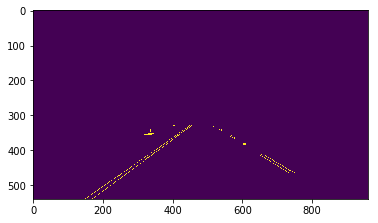

[[-0.72535211]
 [-0.69863014]
 [-0.8       ]
 [-0.83333333]
 [-0.81818182]
 [-0.7       ]
 [-0.72      ]
 [ 0.57142857]
 [-0.66666667]
 [ 0.        ]
 [-0.7       ]
 [-0.6       ]
 [-0.6       ]
 [ 0.58333333]
 [-0.75862069]
 [-0.90909091]
 [ 0.6       ]
 [ 0.        ]
 [ 0.57894737]
 [ 0.57894737]
 [-0.78571429]
 [ 0.61538462]
 [ 0.625     ]
 [ 0.53846154]
 [-0.78571429]
 [ 0.58333333]]
left_m = -0.692718133026  right_m = 0.605300821407
left_c = 644.430138037  right_c = 16.4006539129
left_y = 329.936105644  right_y = 355.974414722  min y = 329.936105644
left_y = 540.522418084  right_y = 463.717960933  max y = 540.522418084


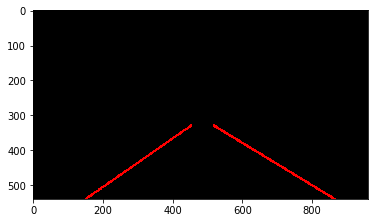

 98%|█████████▊| 671/682 [06:17<00:04,  2.58it/s]

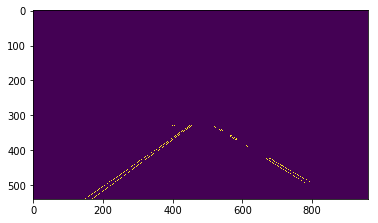

[[ 0.5       ]
 [-0.9       ]
 [-0.85714286]
 [ 0.61682243]
 [-0.75      ]
 [-0.6969697 ]
 [-0.65957447]
 [-0.58333333]
 [ 0.55172414]
 [-0.8125    ]
 [-0.84615385]
 [-0.69230769]
 [-0.64705882]
 [-0.8125    ]
 [ 0.5       ]
 [ 0.53846154]
 [-0.76923077]
 [ 0.46666667]
 [-0.64285714]
 [-0.8       ]
 [ 0.58333333]
 [-0.75      ]
 [ 0.66666667]
 [-0.8       ]
 [-0.66666667]
 [-0.7       ]
 [ 0.        ]
 [ 0.45454545]
 [ 0.64285714]]
left_m = -0.713632644324  right_m = 0.586732397048
left_c = 652.732573288  right_c = 28.1211689186
left_y = 330.884250698  right_y = 359.624973251  min y = 330.884250698
left_y = 528.560493176  right_y = 483.425509028  max y = 528.560493176


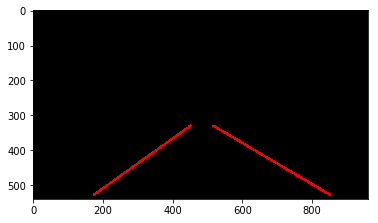

 99%|█████████▊| 672/682 [06:18<00:03,  2.60it/s]

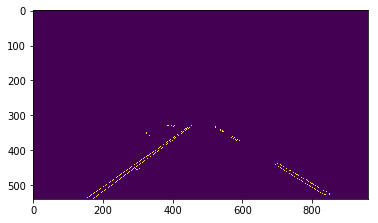

[[-0.71052632]
 [-0.6       ]
 [-0.76      ]
 [-0.72222222]
 [ 0.61290323]
 [ 0.52173913]
 [-0.7244898 ]
 [ 0.57142857]
 [-0.84615385]
 [-0.78571429]
 [-0.83333333]
 [-0.70967742]
 [ 0.55      ]
 [ 0.1       ]
 [-0.84210526]
 [-0.83333333]
 [-0.78571429]
 [-0.80769231]
 [ 0.66666667]
 [ 0.63636364]
 [ 0.55555556]
 [-0.74074074]
 [ 0.5625    ]
 [ 0.5       ]
 [-0.82352941]
 [-0.76470588]
 [-0.78947368]
 [-0.8       ]
 [ 0.66666667]
 [ 0.63636364]]
left_m = -0.715019278352  right_m = 0.590243836794
left_c = 655.035914554  right_c = 26.6357467062
left_y = 330.417162182  right_y = 362.484489842  min y = 330.417162182
left_y = 547.068003523  right_y = 520.079594266  max y = 547.068003523


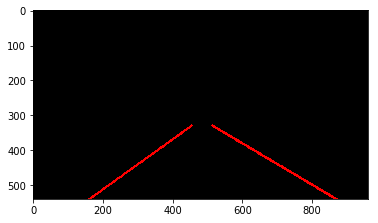

 99%|█████████▊| 673/682 [06:18<00:03,  2.49it/s]

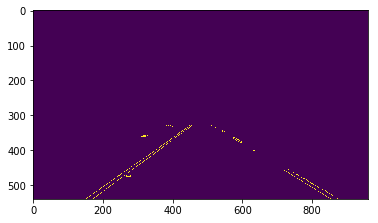

[[-0.75      ]
 [ 0.5       ]
 [-0.7       ]
 [-0.75384615]
 [-0.69230769]
 [-0.68571429]
 [ 0.61818182]
 [-0.75      ]
 [ 0.57142857]
 [-0.63636364]
 [-0.76190476]
 [ 0.53333333]
 [ 0.54166667]
 [ 0.53846154]
 [-0.66666667]
 [ 0.69230769]
 [-0.8       ]
 [-0.6       ]
 [-0.8       ]
 [ 0.54545455]
 [-0.76470588]
 [ 0.        ]
 [-0.69230769]
 [-0.6       ]
 [-0.81818182]
 [-0.81818182]
 [-0.72727273]]
left_m = -0.707261206491  right_m = 0.58729422407
left_c = 650.686175451  right_c = 28.6076271894
left_y = 332.41863253  right_y = 366.889100254  min y = 332.41863253
left_y = 542.475210858  right_y = 530.744188769  max y = 542.475210858


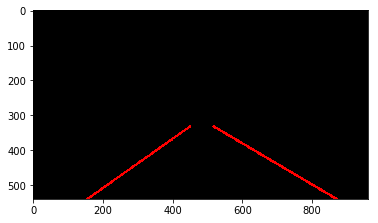

 99%|█████████▉| 674/682 [06:19<00:03,  2.39it/s]

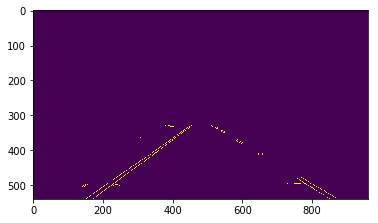

[[ 0.63636364]
 [-0.67961165]
 [-0.74647887]
 [-0.68421053]
 [-0.86666667]
 [-0.85714286]
 [-0.77777778]
 [ 0.5       ]
 [-0.63636364]
 [-0.75      ]
 [-0.7       ]
 [ 0.54545455]
 [ 0.57142857]
 [-0.85714286]
 [-0.63636364]
 [-0.8       ]
 [-0.8       ]
 [ 0.65217391]
 [-0.61538462]
 [ 0.        ]
 [-0.6       ]
 [-0.58333333]
 [ 0.61111111]
 [-0.6       ]
 [-0.58333333]
 [ 0.1       ]
 [ 0.64285714]
 [-0.84615385]
 [-0.9       ]
 [-0.61538462]
 [ 0.54545455]
 [ 0.68421053]
 [-0.6       ]
 [ 0.6       ]
 [-0.78571429]]
left_m = -0.667584681587  right_m = 0.61013564971
left_c = 637.037028318  right_c = 15.4176355169
left_y = 335.956336922  right_y = 368.076041049  min y = 335.956336922
left_y = 543.575172896  right_y = 540.744429917  max y = 543.575172896


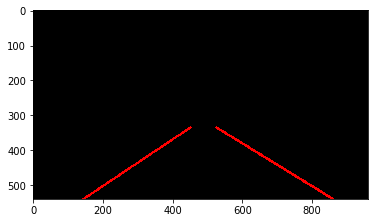

 99%|█████████▉| 675/682 [06:19<00:02,  2.44it/s]

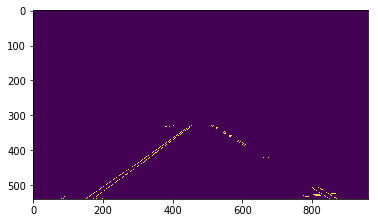

[[-0.66666667]
 [-0.8       ]
 [-0.72289157]
 [ 0.6       ]
 [-0.6       ]
 [-0.66666667]
 [ 0.57142857]
 [-0.83333333]
 [-0.76470588]
 [-0.75675676]
 [-0.8       ]
 [ 0.58333333]
 [-0.85714286]
 [-0.77777778]
 [ 0.61904762]
 [ 0.        ]
 [-0.6       ]
 [-0.84615385]
 [-0.6       ]
 [ 0.        ]
 [-0.84615385]
 [-0.9       ]
 [-0.6       ]
 [-0.61538462]
 [ 0.        ]
 [ 0.6       ]]
left_m = -0.708553629505  right_m = 0.60645475949
left_c = 653.409219946  right_c = 18.1538251011
left_y = 331.017318521  right_y = 374.142768922  min y = 331.017318521
left_y = 542.874853743  right_y = 531.821006389  max y = 542.874853743


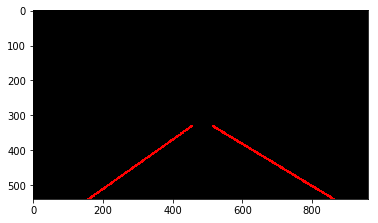

 99%|█████████▉| 676/682 [06:19<00:02,  2.51it/s]

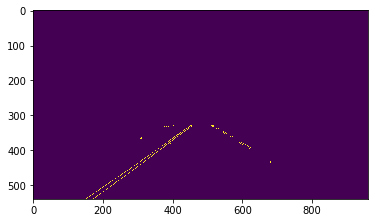

[[-0.68421053]
 [-0.7       ]
 [ 0.5       ]
 [-0.58333333]
 [-0.73333333]
 [-0.72222222]
 [-0.77777778]
 [-0.64285714]
 [-0.76470588]
 [-0.83333333]
 [-0.72857143]
 [-0.58333333]
 [-0.66666667]
 [-0.63636364]
 [-0.63636364]
 [-0.75      ]
 [-0.64285714]
 [-0.76470588]
 [-0.8       ]
 [-0.70588235]
 [-0.58333333]
 [-0.76470588]
 [-0.6       ]
 [-0.6       ]
 [ 0.        ]
 [-0.75      ]
 [-0.58333333]
 [-0.57142857]]
left_m = -0.693340886435  right_m = 0.5
left_c = 647.319482602  right_c = 83.5
left_y = 339.476129025  right_y = 378.0  min y = 339.476129025
left_y = 541.931667864  right_y = 384.0  max y = 541.931667864


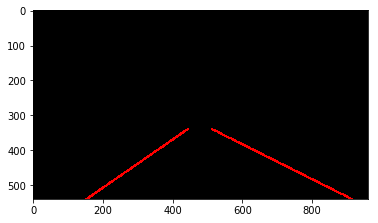

 99%|█████████▉| 677/682 [06:20<00:01,  2.53it/s]

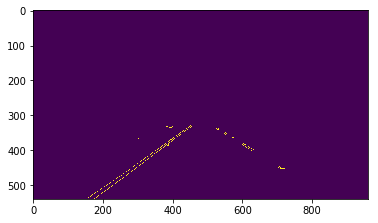

[[-0.73469388]
 [-0.6       ]
 [-0.61538462]
 [-0.70967742]
 [-0.66071429]
 [-0.68      ]
 [-0.9       ]
 [ 0.5625    ]
 [ 0.58823529]
 [ 0.57142857]
 [-0.63636364]
 [-0.68965517]
 [-0.78571429]
 [-0.81818182]
 [ 0.58823529]
 [-0.9       ]
 [-0.63636364]
 [ 0.05555556]
 [-0.6875    ]
 [-0.84210526]
 [-0.6875    ]
 [-0.64285714]
 [-0.78947368]
 [-0.66666667]
 [-0.72727273]
 [-0.66666667]]
left_m = -0.729923177886  right_m = 0.497239915074
left_c = 660.9576122  right_c = 85.3859872611
left_y = 331.762258973  right_y = 381.740976645  min y = 331.762258973
left_y = 536.870671959  right_y = 401.133333333  max y = 536.870671959


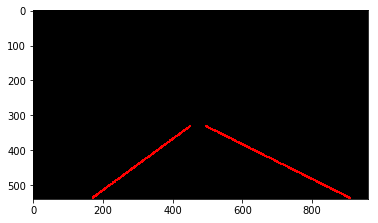

 99%|█████████▉| 678/682 [06:20<00:01,  2.58it/s]

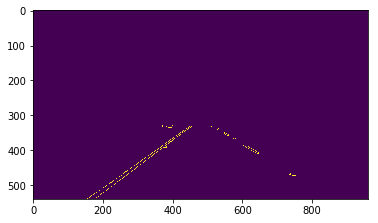

[[-0.70192308]
 [-0.76470588]
 [-0.78125   ]
 [ 0.55172414]
 [-0.77777778]
 [-0.73214286]
 [-0.80952381]
 [-0.66666667]
 [-0.83333333]
 [ 0.57142857]
 [-0.6       ]
 [-0.64285714]
 [-0.8       ]
 [-0.85714286]
 [ 0.        ]
 [ 0.5       ]
 [-0.6       ]]
left_m = -0.730607658937  right_m = 0.507235890014
left_c = 660.862660341  right_c = 79.6225277376
left_y = 328.436175525  right_y = 388.021948866  min y = 328.436175525
left_y = 543.965434912  right_y = 408.311384467  max y = 543.965434912


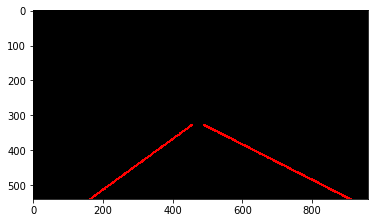

100%|█████████▉| 679/682 [06:21<00:01,  2.45it/s]

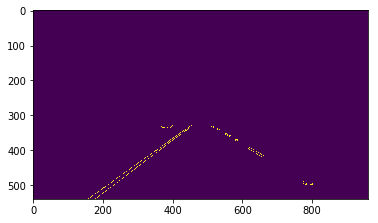

[[-0.6875    ]
 [-0.7826087 ]
 [-0.80952381]
 [-0.92307692]
 [-0.78947368]
 [ 0.53846154]
 [-0.6       ]
 [-0.85714286]
 [-0.68      ]
 [-0.72727273]
 [ 0.65116279]
 [-0.70588235]
 [ 0.65517241]
 [-0.63636364]
 [ 0.64285714]
 [-0.85714286]
 [-0.85714286]
 [-0.66666667]
 [-0.73684211]
 [-0.82352941]
 [-0.83333333]
 [-0.6       ]
 [-0.70967742]
 [ 0.6       ]
 [-0.66666667]]
left_m = -0.753914276136  right_m = 0.564533955545
left_c = 670.156207633  right_c = 44.5483237136
left_y = 333.1565262  right_y = 390.043104507  min y = 333.1565262
left_y = 534.451637928  right_y = 415.447132506  max y = 534.451637928


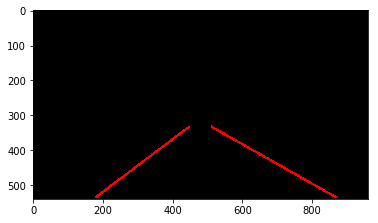

100%|█████████▉| 680/682 [06:21<00:00,  2.51it/s]

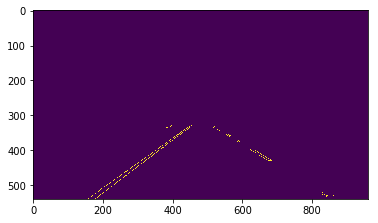

[[-0.75      ]
 [-0.81818182]
 [-0.63636364]
 [-0.8       ]
 [-0.85      ]
 [-0.77777778]
 [ 0.6       ]
 [-0.57142857]
 [-0.58333333]
 [-0.73076923]
 [-0.09090909]
 [-0.80645161]
 [ 0.54545455]
 [-0.81818182]
 [-0.84615385]
 [-0.63636364]
 [ 0.58333333]
 [-0.7       ]
 [ 0.57142857]
 [ 0.60526316]
 [-0.90909091]
 [-0.85714286]
 [ 0.5       ]
 [-0.63636364]
 [ 0.52941176]
 [ 0.        ]
 [-0.66666667]
 [-0.72      ]
 [-0.77272727]
 [-0.61538462]]
left_m = -0.723302615306  right_m = 0.636565406967
left_c = 657.936664791  right_c = -1.78295161301
left_y = 333.173790519  right_y = 351.510849254  min y = 333.173790519
left_y = 543.654851573  right_y = 532.295424832  max y = 543.654851573


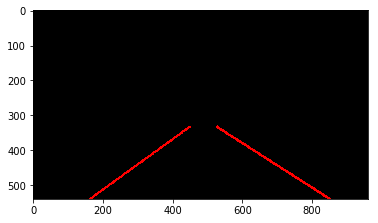

100%|█████████▉| 681/682 [06:21<00:00,  2.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 6min 31s, sys: 1min 25s, total: 7min 56s
Wall time: 6min 22s


In [37]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))